In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

class LSTM_output(torch.nn.Module):
    def forward(self, x):
        return x[0].unsqueeze(0)


for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run1"
    nonlinear_func= torch.nn.Sequential(
#                     LSTM_input(),
                    torch.nn.LSTM(input_dim[1],input_dim[1]),
                    LSTM_output(),
                    torch.nn.Sigmoid(),
#                     EEGNet_input()
                        ).to(DEVICE)
    model = EEGNet_NeuralFS_EEG_Wrapper(DEVICE, classifier, input_dim[0],
                                nonlinear_func=nonlinear_func
                                 ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_EEG-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_pairwise_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_EEG-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7130073577749962


Iterations:   0%|                                   | 1/300 [00:02<14:02,  2.82s/it]

Epoch:  0
t_loss:  0.7130073577749962 , v_loss:  0.690017580986023
t_acc:  0.49206349206349204 , v_acc:  0.6894409937888198
t_recall:  0.5075218566860186 , v_recall:  0.5
t_prec:  0.5064048575867265 , v_prec:  0.3447204968944099
t_f:  0.47888225374687654 , v_f:  0.4080882352941176
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:13,  1.66s/it]

Epoch  1 , loss 0.6860140526995939
Epoch  2 , loss 0.6558388097613466


Iterations:   1%|▎                                  | 3/300 [00:04<07:22,  1.49s/it]

Epoch:  2
t_loss:  0.6558388097613466 , v_loss:  0.6833405296007792
t_acc:  0.5876128229069405 , v_acc:  0.6894409937888198
t_recall:  0.5215705246977121 , v_recall:  0.5
t_prec:  0.5208948589681774 , v_prec:  0.3447204968944099
t_f:  0.5210231808252885 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:12,  1.26s/it]

Epoch  3 , loss 0.6323761414079105
Epoch  4 , loss 0.6106908040888169


Iterations:   2%|▌                                  | 5/300 [00:07<06:19,  1.29s/it]

Epoch:  4
t_loss:  0.6106908040888169 , v_loss:  0.6738792856534322
t_acc:  0.6308745720510427 , v_acc:  0.6894409937888198
t_recall:  0.5029233746448717 , v_recall:  0.5
t_prec:  0.5043502769472085 , v_prec:  0.3447204968944099
t_f:  0.4912990196078431 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:37,  1.15s/it]

Epoch  5 , loss 0.5952964600394753
Epoch  6 , loss 0.576408230790905


Iterations:   2%|▊                                  | 7/300 [00:09<05:54,  1.21s/it]

Epoch:  6
t_loss:  0.576408230790905 , v_loss:  0.6607173482577006
t_acc:  0.6676003734827264 , v_acc:  0.6894409937888198
t_recall:  0.5077565501434238 , v_recall:  0.5
t_prec:  0.5203820224178805 , v_prec:  0.3447204968944099
t_f:  0.47345391292392414 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:17,  1.09s/it]

Epoch  7 , loss 0.5618111748321384
Epoch  8 , loss 0.543721569519417


Iterations:   3%|█                                  | 9/300 [00:11<05:36,  1.16s/it]

Epoch:  8
t_loss:  0.543721569519417 , v_loss:  0.6484856605529785
t_acc:  0.6872082166199813 , v_acc:  0.6894409937888198
t_recall:  0.5074738200134502 , v_recall:  0.5
t_prec:  0.543665070082217 , v_prec:  0.3447204968944099
t_f:  0.448435383259659 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:05,  1.05s/it]

Epoch  9 , loss 0.533149938957364
Epoch  10 , loss 0.5183001522924385


Iterations:   4%|█▏                                | 11/300 [00:13<05:29,  1.14s/it]

Epoch:  10
t_loss:  0.5183001522924385 , v_loss:  0.6401023666063944
t_acc:  0.6893868658574541 , v_acc:  0.6894409937888198
t_recall:  0.5030016057973401 , v_recall:  0.5
t_prec:  0.5290114613180515 , v_prec:  0.3447204968944099
t_f:  0.4319419642857143 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:00,  1.04s/it]

Epoch  11 , loss 0.5062741777476143
Epoch  12 , loss 0.497609874197081


Iterations:   4%|█▍                                | 13/300 [00:15<05:30,  1.15s/it]

Epoch:  12
t_loss:  0.497609874197081 , v_loss:  0.6378644605477651
t_acc:  0.6928104575163399 , v_acc:  0.6894409937888198
t_recall:  0.5017245165452026 , v_recall:  0.5
t_prec:  0.5338892385147892 , v_prec:  0.3447204968944099
t_f:  0.4216637618223395 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:01,  1.05s/it]

Epoch  13 , loss 0.4879138574880712
Epoch  14 , loss 0.48381414892626745


Iterations:   5%|█▋                                | 15/300 [00:18<05:25,  1.14s/it]

Epoch:  14
t_loss:  0.48381414892626745 , v_loss:  0.6371939778327942
t_acc:  0.6918767507002801 , v_acc:  0.6894409937888198
t_recall:  0.49817803763330176 , v_recall:  0.5
t_prec:  0.4307511737089202 , v_prec:  0.3447204968944099
t_f:  0.4118518271982959 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:00,  1.06s/it]

Epoch  15 , loss 0.4804048304464303
Epoch  16 , loss 0.4729665400935154


Iterations:   6%|█▉                                | 17/300 [00:20<05:22,  1.14s/it]

Epoch:  16
t_loss:  0.4729665400935154 , v_loss:  0.639159103234609
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5015014891368497 , v_recall:  0.5
t_prec:  0.5788942307692309 , v_prec:  0.3447204968944099
t_f:  0.4159900929896205 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:21<04:58,  1.06s/it]

Epoch  17 , loss 0.4653759096183029
Epoch  18 , loss 0.4598088439773111


Iterations:   6%|██▏                               | 19/300 [00:22<05:19,  1.14s/it]

Epoch:  18
t_loss:  0.4598088439773111 , v_loss:  0.640370766321818
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49990392665486333 , v_recall:  0.5
t_prec:  0.49064254522769807 , v_prec:  0.3447204968944099
t_f:  0.4118815871597207 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:23<04:56,  1.06s/it]

Epoch  19 , loss 0.46010204214675754
Epoch  20 , loss 0.453952060026281


Iterations:   7%|██▍                               | 21/300 [00:24<05:15,  1.13s/it]

Epoch:  20
t_loss:  0.453952060026281 , v_loss:  0.6420620381832123
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:25<04:50,  1.04s/it]

Epoch  21 , loss 0.4557366867860158
Epoch  22 , loss 0.4526037030360278


Iterations:   8%|██▌                               | 23/300 [00:26<05:13,  1.13s/it]

Epoch:  22
t_loss:  0.4526037030360278 , v_loss:  0.6437539060910543
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:49,  1.05s/it]

Epoch  23 , loss 0.45259251956846197
Epoch  24 , loss 0.44745343514517244


Iterations:   8%|██▊                               | 25/300 [00:29<05:14,  1.14s/it]

Epoch:  24
t_loss:  0.44745343514517244 , v_loss:  0.6419581373532613
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:47,  1.05s/it]

Epoch  25 , loss 0.45143277913916346
Epoch  26 , loss 0.4480920609305887


Iterations:   9%|███                               | 27/300 [00:31<05:09,  1.14s/it]

Epoch:  26
t_loss:  0.4480920609305887 , v_loss:  0.6405424376328787
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:45,  1.05s/it]

Epoch  27 , loss 0.44184261268260433
Epoch  28 , loss 0.4474932352701823


Iterations:  10%|███▎                              | 29/300 [00:33<05:14,  1.16s/it]

Epoch:  28
t_loss:  0.4474932352701823 , v_loss:  0.6372310519218445
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:49,  1.07s/it]

Epoch  29 , loss 0.4491757709606021
Epoch  30 , loss 0.4403996853267445


Iterations:  10%|███▌                              | 31/300 [00:35<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.4403996853267445 , v_loss:  0.6335136592388153
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5018212761285187 , v_recall:  0.5
t_prec:  0.7481920199501246 , v_prec:  0.3447204968944099
t_f:  0.4145045976343382 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:45,  1.06s/it]

Epoch  31 , loss 0.4420453859310524
Epoch  32 , loss 0.43723122921644475


Iterations:  11%|███▋                              | 33/300 [00:38<05:14,  1.18s/it]

Epoch:  32
t_loss:  0.43723122921644475 , v_loss:  0.6305377235015234
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:44,  1.07s/it]

Epoch  33 , loss 0.4383362876433952
Epoch  34 , loss 0.43899986089444626


Iterations:  12%|███▉                              | 35/300 [00:40<05:05,  1.15s/it]

Epoch:  34
t_loss:  0.43899986089444626 , v_loss:  0.6250953574975332
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:41<04:40,  1.06s/it]

Epoch  35 , loss 0.43256140982403474
Epoch  36 , loss 0.4388108545658635


Iterations:  12%|████▏                             | 37/300 [00:42<05:09,  1.18s/it]

Epoch:  36
t_loss:  0.4388108545658635 , v_loss:  0.6201566010713577
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:45,  1.09s/it]

Epoch  37 , loss 0.43823947626001697
Epoch  38 , loss 0.43561458295466854


Iterations:  13%|████▍                             | 39/300 [00:44<05:07,  1.18s/it]

Epoch:  38
t_loss:  0.43561458295466854 , v_loss:  0.6151978671550751
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5026200573695119 , v_recall:  0.5
t_prec:  0.7233619344773792 , v_prec:  0.3447204968944099
t_f:  0.4165631338742394 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:45,  1.10s/it]

Epoch  39 , loss 0.4282562767758089
Epoch  40 , loss 0.43187180336783915


Iterations:  14%|████▋                             | 41/300 [00:47<05:27,  1.26s/it]

Epoch:  40
t_loss:  0.43187180336783915 , v_loss:  0.6094346245129904
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5023325235722814 , v_recall:  0.5
t_prec:  0.7649672591206735 , v_prec:  0.3447204968944099
t_f:  0.4155921424153602 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:51,  1.13s/it]

Epoch  41 , loss 0.4347319269881529
Epoch  42 , loss 0.43207896164819304


Iterations:  14%|████▊                             | 43/300 [00:49<05:30,  1.28s/it]

Epoch:  42
t_loss:  0.43207896164819304 , v_loss:  0.6057316859563192
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5039939062049656 , v_recall:  0.5
t_prec:  0.6819887429643527 , v_prec:  0.3447204968944099
t_f:  0.42052512257253005 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:59,  1.17s/it]

Epoch  43 , loss 0.43256939684643464
Epoch  44 , loss 0.42856134737239165


Iterations:  15%|█████                             | 45/300 [00:52<05:24,  1.27s/it]

Epoch:  44
t_loss:  0.42856134737239165 , v_loss:  0.6006626139084498
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5030674846625767 , v_recall:  0.5
t_prec:  0.8484565014031805 , v_prec:  0.3447204968944099
t_f:  0.41679215855003093 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:59,  1.18s/it]

Epoch  45 , loss 0.4284893817761365
Epoch  46 , loss 0.4281209397549723


Iterations:  16%|█████▎                            | 47/300 [00:54<05:21,  1.27s/it]

Epoch:  46
t_loss:  0.4281209397549723 , v_loss:  0.597821851571401
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5007027078958565 , v_recall:  0.5
t_prec:  0.5479550421479863 , v_prec:  0.3447204968944099
t_f:  0.4139419261368121 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:49,  1.15s/it]

Epoch  47 , loss 0.42299850957066404
Epoch  48 , loss 0.42300892168400334


Iterations:  16%|█████▌                            | 49/300 [00:56<05:12,  1.25s/it]

Epoch:  48
t_loss:  0.42300892168400334 , v_loss:  0.5914699037869772
t_acc:  0.6993464052287581 , v_acc:  0.6894409937888198
t_recall:  0.5069975707168444 , v_recall:  0.5
t_prec:  0.765962441314554 , v_prec:  0.3447204968944099
t_f:  0.4261099647207615 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:41,  1.13s/it]

Epoch  49 , loss 0.4294651653252396
Epoch  50 , loss 0.42346741931111204


Iterations:  17%|█████▊                            | 51/300 [00:59<05:06,  1.23s/it]

Epoch:  50
t_loss:  0.42346741931111204 , v_loss:  0.58623306453228
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5036102990625986 , v_recall:  0.51
t_prec:  0.6235750078296274 , v_prec:  0.846875
t_f:  0.42111784364602456 , v_f:  0.42920193907821425
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:39,  1.13s/it]

Epoch  51 , loss 0.4289396574684218
Epoch  52 , loss 0.4244978772658928


Iterations:  18%|██████                            | 53/300 [01:01<05:02,  1.22s/it]

Epoch:  52
t_loss:  0.4244978772658928 , v_loss:  0.5817861805359522
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5032589451146704 , v_recall:  0.51
t_prec:  0.6484990619136961 , v_prec:  0.846875
t_f:  0.41933401285531013 , v_f:  0.42920193907821425
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:45,  1.16s/it]

Epoch  53 , loss 0.42218825571677265
Epoch  54 , loss 0.4232643083030102


Iterations:  18%|██████▏                           | 55/300 [01:04<05:20,  1.31s/it]

Epoch:  54
t_loss:  0.4232643083030102 , v_loss:  0.5765896290540695
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.5086589533495286 , v_recall:  0.53
t_prec:  0.7200251098556183 , v_prec:  0.8512658227848101
t_f:  0.4308947790103165 , v_f:  0.4692431787893666
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<05:02,  1.24s/it]

Epoch  55 , loss 0.4183625315918642
Epoch  56 , loss 0.4218315692508922


Iterations:  19%|██████▍                           | 57/300 [01:06<05:26,  1.35s/it]

Epoch:  56
t_loss:  0.4218315692508922 , v_loss:  0.5701574981212616
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.508882666996061 , v_recall:  0.54
t_prec:  0.7343172986411142 , v_prec:  0.8535031847133758
t_f:  0.43102323277895427 , v_f:  0.488253178551686
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<05:03,  1.25s/it]

Epoch  57 , loss 0.4175854842452442
Epoch  58 , loss 0.4270212264621959


Iterations:  20%|██████▋                           | 59/300 [01:09<05:18,  1.32s/it]

Epoch:  58
t_loss:  0.4270212264621959 , v_loss:  0.5631921390692393
t_acc:  0.6984126984126984 , v_acc:  0.7391304347826086
t_recall:  0.5069014973717078 , v_recall:  0.58
t_prec:  0.6892785445420326 , v_prec:  0.8627450980392157
t_f:  0.42760745975240416 , v_f:  0.5583855799373041
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:44,  1.18s/it]

Epoch  59 , loss 0.4246267419235379
Epoch  60 , loss 0.416140827478147


Iterations:  20%|██████▉                           | 61/300 [01:11<04:55,  1.24s/it]

Epoch:  60
t_loss:  0.416140827478147 , v_loss:  0.55670598646005
t_acc:  0.6981014628073452 , v_acc:  0.7515527950310559
t_recall:  0.5066777837251754 , v_recall:  0.6
t_prec:  0.6761543288841689 , v_prec:  0.8675496688741722
t_f:  0.42748188360537925 , v_f:  0.5903307888040712
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:28,  1.13s/it]

Epoch  61 , loss 0.41620148221651715
Epoch  62 , loss 0.4155596629077313


Iterations:  21%|███████▏                          | 63/300 [01:13<04:46,  1.21s/it]

Epoch:  62
t_loss:  0.4155596629077313 , v_loss:  0.5502004027366638
t_acc:  0.7012138188608776 , v_acc:  0.7577639751552795
t_recall:  0.5129403933517245 , v_recall:  0.61
t_prec:  0.7028565076450846 , v_prec:  0.87
t_f:  0.4415095870131714 , v_f:  0.6056152251742981
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:25,  1.12s/it]

Epoch  63 , loss 0.4159275381004109
Epoch  64 , loss 0.4234354899210088


Iterations:  22%|███████▎                          | 65/300 [01:16<04:43,  1.21s/it]

Epoch:  64
t_loss:  0.4234354899210088 , v_loss:  0.5453961988290151
t_acc:  0.7021475256769374 , v_acc:  0.7639751552795031
t_recall:  0.5150492032774735 , v_recall:  0.62
t_prec:  0.7039848197343453 , v_prec:  0.8724832214765101
t_f:  0.4463250558700412 , v_f:  0.6204714640198511
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:31,  1.16s/it]

Epoch  65 , loss 0.41605876999742847
Epoch  66 , loss 0.42122652951408834


Iterations:  22%|███████▌                          | 67/300 [01:18<04:45,  1.23s/it]

Epoch:  66
t_loss:  0.42122652951408834 , v_loss:  0.5398519684871038
t_acc:  0.7005913476501712 , v_acc:  0.7639751552795031
t_recall:  0.51278049985589 , v_recall:  0.62
t_prec:  0.6838862559241705 , v_prec:  0.8724832214765101
t_f:  0.4421150097465887 , v_f:  0.6204714640198511
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:39,  1.20s/it]

Epoch  67 , loss 0.413351355230107
Epoch  68 , loss 0.4156130242581461


Iterations:  23%|███████▊                          | 69/300 [01:21<04:48,  1.25s/it]

Epoch:  68
t_loss:  0.4156130242581461 , v_loss:  0.5331998417774836
t_acc:  0.706504824151883 , v_acc:  0.7639751552795031
t_recall:  0.5216315998956917 , v_recall:  0.62
t_prec:  0.7459172422401598 , v_prec:  0.8724832214765101
t_f:  0.45867274315434814 , v_f:  0.6204714640198511
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:38,  1.21s/it]

Epoch  69 , loss 0.41617118552619337
Epoch  70 , loss 0.40925093141256597


Iterations:  24%|████████                          | 71/300 [01:23<04:46,  1.25s/it]

Epoch:  70
t_loss:  0.40925093141256597 , v_loss:  0.5278881440560023
t_acc:  0.7043261749144102 , v_acc:  0.7763975155279503
t_recall:  0.5174778001948916 , v_recall:  0.64
t_prec:  0.7415649699652229 , v_prec:  0.8775510204081632
t_f:  0.4499421892818063 , v_f:  0.6489825581395349
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:34,  1.20s/it]

Epoch  71 , loss 0.4144730620524463
Epoch  72 , loss 0.40988997384613635


Iterations:  24%|████████▎                         | 73/300 [01:26<04:46,  1.26s/it]

Epoch:  72
t_loss:  0.40988997384613635 , v_loss:  0.5269323289394379
t_acc:  0.7083722377840025 , v_acc:  0.782608695652174
t_recall:  0.527574422530572 , v_recall:  0.65
t_prec:  0.7216228737838375 , v_prec:  0.8801369863013699
t_f:  0.472703484477092 , v_f:  0.662675845555223
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:23,  1.17s/it]

Epoch  73 , loss 0.4078282988538929
Epoch  74 , loss 0.4065397656431385


Iterations:  25%|████████▌                         | 75/300 [01:28<04:45,  1.27s/it]

Epoch:  74
t_loss:  0.4065397656431385 , v_loss:  0.5225411454836527
t_acc:  0.7049486461251168 , v_acc:  0.782608695652174
t_recall:  0.5202254978657992 , v_recall:  0.65
t_prec:  0.7193627937440457 , v_prec:  0.8801369863013699
t_f:  0.45706693323218295 , v_f:  0.662675845555223
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:16,  1.14s/it]

Epoch  75 , loss 0.4118298479154998
Epoch  76 , loss 0.40559491310633866


Iterations:  26%|████████▋                         | 77/300 [01:30<04:38,  1.25s/it]

Epoch:  76
t_loss:  0.40559491310633866 , v_loss:  0.5206281592448553
t_acc:  0.7055711173358232 , v_acc:  0.7950310559006211
t_recall:  0.5226856617394765 , v_recall:  0.67
t_prec:  0.7079886918443703 , v_prec:  0.8854166666666667
t_f:  0.46318425287632414 , v_f:  0.689025460930641
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:09,  1.12s/it]

Epoch  77 , loss 0.4085756084498237
Epoch  78 , loss 0.40669066531985415


Iterations:  26%|████████▉                         | 79/300 [01:33<04:33,  1.24s/it]

Epoch:  78
t_loss:  0.40669066531985415 , v_loss:  0.518468459447225
t_acc:  0.706504824151883 , v_acc:  0.7950310559006211
t_recall:  0.5247944716652255 , v_recall:  0.67
t_prec:  0.7086165749259017 , v_prec:  0.8854166666666667
t_f:  0.4677234808990797 , v_f:  0.689025460930641
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:08,  1.13s/it]

Epoch  79 , loss 0.40541088172033724
Epoch  80 , loss 0.409899467346715


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:43,  1.29s/it]

Epoch:  80
t_loss:  0.409899467346715 , v_loss:  0.5184633533159891
t_acc:  0.7074385309679427 , v_acc:  0.7950310559006211
t_recall:  0.5254656126048228 , v_recall:  0.67
t_prec:  0.7220854612192786 , v_prec:  0.8854166666666667
t_f:  0.46820970872692336 , v_f:  0.689025460930641
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:20,  1.19s/it]

Epoch  81 , loss 0.40377583866025885
Epoch  82 , loss 0.4074440943259819


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:43,  1.31s/it]

Epoch:  82
t_loss:  0.4074440943259819 , v_loss:  0.516126478711764
t_acc:  0.7086834733893558 , v_acc:  0.7950310559006211
t_recall:  0.5286607375687954 , v_recall:  0.67
t_prec:  0.718183622863352 , v_prec:  0.8854166666666667
t_f:  0.4752381816532075 , v_f:  0.689025460930641
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<04:13,  1.18s/it]

Epoch  83 , loss 0.4016040703829597
Epoch  84 , loss 0.40209054713155706


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:24,  1.23s/it]

Epoch:  84
t_loss:  0.40209054713155706 , v_loss:  0.5162199636300405
t_acc:  0.7145969498910676 , v_acc:  0.7888198757763976
t_recall:  0.5363617024196758 , v_recall:  0.66
t_prec:  0.7629610391329089 , v_prec:  0.8827586206896552
t_f:  0.48780345338623954 , v_f:  0.6760179924242424
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:57,  1.11s/it]

Epoch  85 , loss 0.39934048290346186
Epoch  86 , loss 0.3935394801345526


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.3935394801345526 , v_loss:  0.5141639014085134
t_acc:  0.7161531279178338 , v_acc:  0.7950310559006211
t_recall:  0.5406431424218717 , v_recall:  0.6754954954954955
t_prec:  0.7514648188719621 , v_prec:  0.8610081541882876
t_f:  0.4969282685818118 , v_f:  0.6956521739130435
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:52,  1.10s/it]

Epoch  87 , loss 0.3948977104589051
Epoch  88 , loss 0.39684539682724895


Iterations:  30%|██████████                        | 89/300 [01:45<04:11,  1.19s/it]

Epoch:  88
t_loss:  0.39684539682724895 , v_loss:  0.5104527870814005
t_acc:  0.7124183006535948 , v_acc:  0.7950310559006211
t_recall:  0.5347957068939487 , v_recall:  0.6754954954954955
t_prec:  0.7352274414231634 , v_prec:  0.8610081541882876
t_f:  0.48656084319346515 , v_f:  0.6956521739130435
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:56,  1.13s/it]

Epoch  89 , loss 0.4020187439871769
Epoch  90 , loss 0.3930182281662436


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:16,  1.23s/it]

Epoch:  90
t_loss:  0.3930182281662436 , v_loss:  0.5068360517422358
t_acc:  0.7136632430750078 , v_acc:  0.8074534161490683
t_recall:  0.5356905614800784 , v_recall:  0.6954954954954955
t_prec:  0.7506055252168327 , v_prec:  0.8690476190476191
t_f:  0.48727039602133093 , v_f:  0.7199371527972616
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<04:10,  1.20s/it]

Epoch  91 , loss 0.3935587961299747
Epoch  92 , loss 0.39521489657607733


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:37,  1.34s/it]

Epoch:  92
t_loss:  0.39521489657607733 , v_loss:  0.5101368874311447
t_acc:  0.7155306567071273 , v_acc:  0.7950310559006211
t_recall:  0.54278351930388 , v_recall:  0.680990990990991
t_prec:  0.7266618353506905 , v_prec:  0.8416666666666667
t_f:  0.5030295297070586 , v_f:  0.7018685820099881
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<04:25,  1.29s/it]

Epoch  93 , loss 0.39252811611867416
Epoch  94 , loss 0.39322391853613015


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:37,  1.35s/it]

Epoch:  94
t_loss:  0.39322391853613015 , v_loss:  0.5083869993686676
t_acc:  0.7121070650482415 , v_acc:  0.7950310559006211
t_recall:  0.5354345946391074 , v_recall:  0.680990990990991
t_prec:  0.7249464164357782 , v_prec:  0.8416666666666667
t_f:  0.4886392671154284 , v_f:  0.7018685820099881
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<04:12,  1.24s/it]

Epoch  95 , loss 0.3932512046075335
Epoch  96 , loss 0.39024318667019114


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:22,  1.29s/it]

Epoch:  96
t_loss:  0.39024318667019114 , v_loss:  0.5058042456706365
t_acc:  0.7170868347338936 , v_acc:  0.7950310559006211
t_recall:  0.5427519523476209 , v_recall:  0.680990990990991
t_prec:  0.7497741438850459 , v_prec:  0.8416666666666667
t_f:  0.5011221526199304 , v_f:  0.7018685820099881
////////


Iterations:  33%|███████████                       | 98/300 [01:56<04:02,  1.20s/it]

Epoch  97 , loss 0.3908313945227978
Epoch  98 , loss 0.39627646231183816


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.39627646231183816 , v_loss:  0.5063623736302058
t_acc:  0.721444133208839 , v_acc:  0.8074534161490683
t_recall:  0.5513470855464515 , v_recall:  0.7009909909909909
t_prec:  0.7522951040776873 , v_prec:  0.8514492753623188
t_f:  0.5171276058226757 , v_f:  0.7254222368927765
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:57,  1.19s/it]

Epoch  99 , loss 0.38712550787364736
Epoch  100 , loss 0.3880134902748407


Iterations:  34%|███████████                      | 101/300 [02:00<04:06,  1.24s/it]

Epoch:  100
t_loss:  0.3880134902748407 , v_loss:  0.5025716125965118
t_acc:  0.7192654839713664 , v_acc:  0.8012422360248447
t_recall:  0.5471932858456513 , v_recall:  0.690990990990991
t_prec:  0.7500242373711178 , v_prec:  0.8466317854807064
t_f:  0.5095543061222831 , v_f:  0.7137777777777778
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:54,  1.18s/it]

Epoch  101 , loss 0.3966980699230643
Epoch  102 , loss 0.39060134864320945


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.39060134864320945 , v_loss:  0.4978562941153844
t_acc:  0.7208216619981326 , v_acc:  0.8012422360248447
t_recall:  0.552049793442308 , v_recall:  0.690990990990991
t_prec:  0.7400303803877719 , v_prec:  0.8466317854807064
t_f:  0.5194137238328229 , v_f:  0.7137777777777778
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:52,  1.19s/it]

Epoch  103 , loss 0.3898232894785264
Epoch  104 , loss 0.39277979439380123


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:05,  1.26s/it]

Epoch:  104
t_loss:  0.39277979439380123 , v_loss:  0.49580705165863037
t_acc:  0.7149081854964208 , v_acc:  0.7888198757763976
t_recall:  0.5434862271997365 , v_recall:  0.6764864864864866
t_prec:  0.7150843108504399 , v_prec:  0.8203073904512754
t_f:  0.5054504319210202 , v_f:  0.695888888888889
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:45,  1.16s/it]

Epoch  105 , loss 0.3891171152685203
Epoch  106 , loss 0.38115528810258004


Iterations:  36%|███████████▊                     | 107/300 [02:07<04:06,  1.28s/it]

Epoch:  106
t_loss:  0.38115528810258004 , v_loss:  0.49689624706904095
t_acc:  0.7273576097105509 , v_acc:  0.7950310559006211
t_recall:  0.5593355841945623 , v_recall:  0.680990990990991
t_prec:  0.7787562973916333 , v_prec:  0.8416666666666667
t_f:  0.5296854530385263 , v_f:  0.7018685820099881
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:42,  1.16s/it]

Epoch  107 , loss 0.3817870038397172
Epoch  108 , loss 0.3785477628310521


Iterations:  36%|███████████▉                     | 109/300 [02:10<04:07,  1.30s/it]

Epoch:  108
t_loss:  0.3785477628310521 , v_loss:  0.49723468720912933
t_acc:  0.7261126672891379 , v_acc:  0.7888198757763976
t_recall:  0.5581531958112022 , v_recall:  0.6764864864864866
t_prec:  0.7698297126214746 , v_prec:  0.8203073904512754
t_f:  0.5281944624289648 , v_f:  0.695888888888889
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:43,  1.18s/it]

Epoch  109 , loss 0.37836210517322316
Epoch  110 , loss 0.38127479483099547


Iterations:  37%|████████████▏                    | 111/300 [02:12<04:03,  1.29s/it]

Epoch:  110
t_loss:  0.38127479483099547 , v_loss:  0.4976906230052312
t_acc:  0.7301587301587301 , v_acc:  0.782608695652174
t_recall:  0.565374480174579 , v_recall:  0.6664864864864866
t_prec:  0.7747067372573446 , v_prec:  0.8142857142857143
t_f:  0.5405664564336786 , v_f:  0.6838000112227147
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:40,  1.17s/it]

Epoch  111 , loss 0.38111838230899736
Epoch  112 , loss 0.3803938767489265


Iterations:  38%|████████████▍                    | 113/300 [02:14<03:55,  1.26s/it]

Epoch:  112
t_loss:  0.3803938767489265 , v_loss:  0.4912714809179306
t_acc:  0.7323373793962029 , v_acc:  0.7888198757763976
t_recall:  0.5695282798753791 , v_recall:  0.670990990990991
t_prec:  0.7754993274623759 , v_prec:  0.8365248226950355
t_f:  0.5476544390167241 , v_f:  0.6896825396825397
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:33,  1.15s/it]

Epoch  113 , loss 0.3736875352321887
Epoch  114 , loss 0.3766758383489123


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.3766758383489123 , v_loss:  0.49042142430941266
t_acc:  0.7382508558979147 , v_acc:  0.7763975155279503
t_recall:  0.5778043123207203 , v_recall:  0.661981981981982
t_prec:  0.7946403512115343 , v_prec:  0.7939829954218444
t_f:  0.560302260231297 , v_f:  0.6779999999999999
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:35,  1.17s/it]

Epoch  115 , loss 0.38107744969573676
Epoch  116 , loss 0.3699293165814643


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:56,  1.29s/it]

Epoch:  116
t_loss:  0.3699293165814643 , v_loss:  0.4899924198786418
t_acc:  0.7366946778711485 , v_acc:  0.7763975155279503
t_recall:  0.5781234130742098 , v_recall:  0.661981981981982
t_prec:  0.7756747201513621 , v_prec:  0.7939829954218444
t_f:  0.5620420950328427 , v_f:  0.6779999999999999
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:43,  1.23s/it]

Epoch  117 , loss 0.38111281745574055
Epoch  118 , loss 0.37727828411494985


Iterations:  40%|█████████████                    | 119/300 [02:22<03:59,  1.32s/it]

Epoch:  118
t_loss:  0.37727828411494985 , v_loss:  0.4869561642408371
t_acc:  0.7326486150015562 , v_acc:  0.7701863354037267
t_recall:  0.5723397976969846 , v_recall:  0.662972972972973
t_prec:  0.7636315285785263 , v_prec:  0.766029411764706
t_f:  0.5532641003108898 , v_f:  0.6784345479082321
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:43,  1.24s/it]

Epoch  119 , loss 0.37119633368417326
Epoch  120 , loss 0.3690946242388557


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:59,  1.34s/it]

Epoch:  120
t_loss:  0.3690946242388557 , v_loss:  0.48889480034510296
t_acc:  0.7413632119514473 , v_acc:  0.7763975155279503
t_recall:  0.5872297937168032 , v_recall:  0.6674774774774774
t_prec:  0.7767971465154564 , v_prec:  0.7826946472019465
t_f:  0.5766840701638231 , v_f:  0.6841761115954664
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:42,  1.25s/it]

Epoch  121 , loss 0.3681834638118744
Epoch  122 , loss 0.36056246243271173


Iterations:  41%|█████████████▌                   | 123/300 [02:27<03:57,  1.34s/it]

Epoch:  122
t_loss:  0.36056246243271173 , v_loss:  0.4920886705319087
t_acc:  0.7407407407407407 , v_acc:  0.7639751552795031
t_recall:  0.5850571636403563 , v_recall:  0.652972972972973
t_prec:  0.7811728712464006 , v_prec:  0.7582116788321167
t_f:  0.5729447711113128 , v_f:  0.6666303400174368
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:45,  1.28s/it]

Epoch  123 , loss 0.35883132821204616
Epoch  124 , loss 0.3640451083580653


Iterations:  42%|█████████████▊                   | 125/300 [02:30<04:04,  1.40s/it]

Epoch:  124
t_loss:  0.3640451083580653 , v_loss:  0.4943571388721466
t_acc:  0.7394957983193278 , v_acc:  0.7639751552795031
t_recall:  0.5841623090542265 , v_recall:  0.652972972972973
t_prec:  0.7736345381526104 , v_prec:  0.7582116788321167
t_f:  0.5719933365896002 , v_f:  0.6666303400174368
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:46,  1.30s/it]

Epoch  125 , loss 0.3638218314039941
Epoch  126 , loss 0.3625666411483989


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:52,  1.35s/it]

Epoch:  126
t_loss:  0.3625666411483989 , v_loss:  0.500934878985087
t_acc:  0.744786803610333 , v_acc:  0.7639751552795031
t_recall:  0.5902657114231208 , v_recall:  0.652972972972973
t_prec:  0.7946899046503848 , v_prec:  0.7582116788321167
t_f:  0.5804179099153275 , v_f:  0.6666303400174368
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:30,  1.22s/it]

Epoch  127 , loss 0.36471854851526375
Epoch  128 , loss 0.3569406452132206


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:38,  1.28s/it]

Epoch:  128
t_loss:  0.3569406452132206 , v_loss:  0.4986231525739034
t_acc:  0.7500778089013383 , v_acc:  0.7701863354037267
t_recall:  0.5995319855615487 , v_recall:  0.662972972972973
t_prec:  0.7991913746630728 , v_prec:  0.766029411764706
t_f:  0.5945418934827366 , v_f:  0.6784345479082321
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:23,  1.19s/it]

Epoch  129 , loss 0.35737093348129123
Epoch  130 , loss 0.35568196019705606


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:30,  1.25s/it]

Epoch:  130
t_loss:  0.35568196019705606 , v_loss:  0.5036059468984604
t_acc:  0.7507002801120448 , v_acc:  0.7701863354037267
t_recall:  0.601129548043535 , v_recall:  0.662972972972973
t_prec:  0.7973279064700012 , v_prec:  0.766029411764706
t_f:  0.5970616145353934 , v_f:  0.6784345479082321
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:21,  1.20s/it]

Epoch  131 , loss 0.35343241370191764
Epoch  132 , loss 0.3508375731169009


Iterations:  44%|██████████████▋                  | 133/300 [02:40<03:29,  1.26s/it]

Epoch:  132
t_loss:  0.3508375731169009 , v_loss:  0.507797489563624
t_acc:  0.7491441020852786 , v_acc:  0.7639751552795031
t_recall:  0.6005860474053334 , v_recall:  0.6584684684684685
t_prec:  0.7863632811482456 , v_prec:  0.7505698005698005
t_f:  0.5967956997819001 , v_f:  0.6727642276422765
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:20,  1.20s/it]

Epoch  133 , loss 0.3501579574510163
Epoch  134 , loss 0.3456718664543301


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:33,  1.29s/it]

Epoch:  134
t_loss:  0.3456718664543301 , v_loss:  0.5106516430775324
t_acc:  0.7587924058512294 , v_acc:  0.7639751552795031
t_recall:  0.619310056134283 , v_recall:  0.6584684684684685
t_prec:  0.7889586071032063 , v_prec:  0.7505698005698005
t_f:  0.62394623166963 , v_f:  0.6727642276422765
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:15,  1.19s/it]

Epoch  135 , loss 0.3494189200448055
Epoch  136 , loss 0.34003478873009774


Iterations:  46%|███████████████                  | 137/300 [02:45<03:33,  1.31s/it]

Epoch:  136
t_loss:  0.34003478873009774 , v_loss:  0.5178405344486237
t_acc:  0.7662620603797075 , v_acc:  0.7701863354037267
t_recall:  0.6272669878261347 , v_recall:  0.6684684684684685
t_prec:  0.8136446659300516 , v_prec:  0.7584300718629077
t_f:  0.6343147175503894 , v_f:  0.6842300556586272
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:11,  1.18s/it]

Epoch  137 , loss 0.33960579072727876
Epoch  138 , loss 0.3443781067343319


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:31,  1.31s/it]

Epoch:  138
t_loss:  0.3443781067343319 , v_loss:  0.524956559141477
t_acc:  0.7653283535636477 , v_acc:  0.7763975155279503
t_recall:  0.6265958468865374 , v_recall:  0.6784684684684684
t_prec:  0.8092708496322953 , v_prec:  0.7659774436090225
t_f:  0.6334966202927668 , v_f:  0.6954602774274905
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<03:09,  1.19s/it]

Epoch  139 , loss 0.3464517637210734
Epoch  140 , loss 0.3357532334093954


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:24,  1.29s/it]

Epoch:  140
t_loss:  0.3357532334093954 , v_loss:  0.5276788075764974
t_acc:  0.7684407096171803 , v_acc:  0.782608695652174
t_recall:  0.6305581861352438 , v_recall:  0.6884684684684684
t_prec:  0.8171113308812907 , v_prec:  0.7732497387669801
t_f:  0.6387784114949143 , v_f:  0.706464551752878
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:04,  1.17s/it]

Epoch  141 , loss 0.3414858702351065
Epoch  142 , loss 0.33215352191644554


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.33215352191644554 , v_loss:  0.5303409745295843
t_acc:  0.7734204793028322 , v_acc:  0.7763975155279503
t_recall:  0.6442012873828249 , v_recall:  0.683963963963964
t_prec:  0.8039426789426789 , v_prec:  0.759796437659033
t_f:  0.657165872653871 , v_f:  0.7006198347107437
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<02:57,  1.14s/it]

Epoch  143 , loss 0.33534585465403166
Epoch  144 , loss 0.33409781257311505


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:10,  1.23s/it]

Epoch:  144
t_loss:  0.33409781257311505 , v_loss:  0.5328039129575094
t_acc:  0.76937441643324 , v_acc:  0.7763975155279503
t_recall:  0.6372675368166784 , v_recall:  0.6894594594594595
t_prec:  0.8001827848121528 , v_prec:  0.7547238372093024
t_f:  0.6481374881343372 , v_f:  0.7054878048780489
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<02:55,  1.14s/it]

Epoch  145 , loss 0.32701528335318847
Epoch  146 , loss 0.33413081192502786


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:13,  1.26s/it]

Epoch:  146
t_loss:  0.33413081192502786 , v_loss:  0.5357660303513209
t_acc:  0.7762215997510116 , v_acc:  0.7639751552795031
t_recall:  0.6447770412154651 , v_recall:  0.6749549549549549
t_prec:  0.8198289976350737 , v_prec:  0.7352228682170543
t_f:  0.6578203297780018 , v_f:  0.6891260162601626
////////


Iterations:  49%|████████████████▎                | 148/300 [02:58<03:01,  1.19s/it]

Epoch  147 , loss 0.33362697269402297
Epoch  148 , loss 0.33105021919689925


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:21,  1.33s/it]

Epoch:  148
t_loss:  0.33105021919689925 , v_loss:  0.5447845508654913
t_acc:  0.774354186118892 , v_acc:  0.7701863354037267
t_recall:  0.6437222931335007 , v_recall:  0.6794594594594595
t_prec:  0.8111714772479646 , v_prec:  0.7471464019851117
t_f:  0.6565002001785756 , v_f:  0.6948414527944264
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<03:10,  1.27s/it]

Epoch  149 , loss 0.3173569098991506
Epoch  150 , loss 0.3186088163478702


Iterations:  50%|████████████████▌                | 151/300 [03:02<03:28,  1.40s/it]

Epoch:  150
t_loss:  0.3186088163478702 , v_loss:  0.5463705360889435
t_acc:  0.7777777777777778 , v_acc:  0.7701863354037267
t_recall:  0.6496335488121217 , v_recall:  0.684954954954955
t_prec:  0.8138895126880754 , v_prec:  0.7430160984848485
t_f:  0.6641270661157025 , v_f:  0.699702575994354
////////


Iterations:  51%|████████████████▋                | 152/300 [03:03<03:10,  1.29s/it]

Epoch  151 , loss 0.32335491975148517
Epoch  152 , loss 0.32413333479095907


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:20,  1.37s/it]

Epoch:  152
t_loss:  0.32413333479095907 , v_loss:  0.5598060091336569
t_acc:  0.7818238406473701 , v_acc:  0.7577639751552795
t_recall:  0.6559922317838075 , v_recall:  0.6814414414414414
t_prec:  0.8189126726102067 , v_prec:  0.719485614646905
t_f:  0.6722098962263533 , v_f:  0.6928833455612619
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<03:02,  1.25s/it]

Epoch  153 , loss 0.3151428708258797
Epoch  154 , loss 0.31256964013857


Iterations:  52%|█████████████████                | 155/300 [03:07<03:06,  1.29s/it]

Epoch:  154
t_loss:  0.31256964013857 , v_loss:  0.569111168384552
t_acc:  0.7883597883597884 , v_acc:  0.7453416149068323
t_recall:  0.6673034956972866 , v_recall:  0.6669369369369369
t_prec:  0.823619363162841 , v_prec:  0.7019398430688752
t_f:  0.6862430853538748 , v_f:  0.6771337735387625
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:08<02:55,  1.22s/it]

Epoch  155 , loss 0.3076232286060558
Epoch  156 , loss 0.31115207192944544


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:01,  1.27s/it]

Epoch:  156
t_loss:  0.31115207192944544 , v_loss:  0.5859511295954386
t_acc:  0.7896047307812014 , v_acc:  0.7391304347826086
t_recall:  0.6710736882557198 , v_recall:  0.6624324324324324
t_prec:  0.8200674478520256 , v_prec:  0.6928754813863929
t_f:  0.6906828370749714 , v_f:  0.6716200466200466
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:50,  1.20s/it]

Epoch  157 , loss 0.31989821820866826
Epoch  158 , loss 0.31786080143030954


Iterations:  53%|█████████████████▍               | 159/300 [03:12<02:55,  1.25s/it]

Epoch:  158
t_loss:  0.31786080143030954 , v_loss:  0.5853527734676996
t_acc:  0.7871148459383753 , v_acc:  0.7391304347826086
t_recall:  0.6681338438945389 , v_recall:  0.6624324324324324
t_prec:  0.8145671953505491 , v_prec:  0.6928754813863929
t_f:  0.6870222789338468 , v_f:  0.6716200466200466
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:13<02:44,  1.18s/it]

Epoch  159 , loss 0.3132762520336637
Epoch  160 , loss 0.313980073613279


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:51,  1.24s/it]

Epoch:  160
t_loss:  0.313980073613279 , v_loss:  0.5989105254411697
t_acc:  0.7924058512293807 , v_acc:  0.7329192546583851
t_recall:  0.6748123138578938 , v_recall:  0.657927927927928
t_prec:  0.8250804810486698 , v_prec:  0.6842160571668768
t_f:  0.6952736850741521 , v_f:  0.6661522881805468
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:45,  1.20s/it]

Epoch  161 , loss 0.31517276518485127
Epoch  162 , loss 0.30110130561333076


Iterations:  54%|█████████████████▉               | 163/300 [03:17<02:50,  1.25s/it]

Epoch:  162
t_loss:  0.30110130561333076 , v_loss:  0.6008574863274893
t_acc:  0.7995642701525054 , v_acc:  0.7329192546583851
t_recall:  0.6851333360782861 , v_recall:  0.657927927927928
t_prec:  0.8355233374734472 , v_prec:  0.6842160571668768
t_f:  0.7077344907347247 , v_f:  0.6661522881805468
////////


Iterations:  55%|██████████████████               | 164/300 [03:18<02:39,  1.17s/it]

Epoch  163 , loss 0.29955164591471356
Epoch  164 , loss 0.3004489102784325


Iterations:  55%|██████████████████▏              | 165/300 [03:19<02:48,  1.25s/it]

Epoch:  164
t_loss:  0.3004489102784325 , v_loss:  0.6023961106936137
t_acc:  0.8017429193899782 , v_acc:  0.7267080745341615
t_recall:  0.693312608940311 , v_recall:  0.6534234234234234
t_prec:  0.826035477847564 , v_prec:  0.6759297520661156
t_f:  0.7164761090081697 , v_f:  0.6607279693486591
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:20<02:34,  1.16s/it]

Epoch  165 , loss 0.2941380940815982
Epoch  166 , loss 0.3018038281623055


Iterations:  56%|██████████████████▎              | 167/300 [03:22<02:46,  1.25s/it]

Epoch:  166
t_loss:  0.3018038281623055 , v_loss:  0.6020839611689249
t_acc:  0.8023653906006847 , v_acc:  0.7329192546583851
t_recall:  0.6903096306666118 , v_recall:  0.6634234234234234
t_prec:  0.8364476116991075 , v_prec:  0.6843495934959349
t_f:  0.7137056799166482 , v_f:  0.6706626706626706
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:23<02:31,  1.15s/it]

Epoch  167 , loss 0.29184333483378094
Epoch  168 , loss 0.30370962181512046


Iterations:  56%|██████████████████▌              | 169/300 [03:24<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.30370962181512046 , v_loss:  0.614609827597936
t_acc:  0.8061002178649237 , v_acc:  0.7267080745341615
t_recall:  0.6964445999917652 , v_recall:  0.6534234234234234
t_prec:  0.8396877269426289 , v_prec:  0.6759297520661156
t_f:  0.7207915870028887 , v_f:  0.6607279693486591
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:25<02:29,  1.15s/it]

Epoch  169 , loss 0.2955556283978855
Epoch  170 , loss 0.29080910893047557


Iterations:  57%|██████████████████▊              | 171/300 [03:27<02:48,  1.31s/it]

Epoch:  170
t_loss:  0.29080910893047557 , v_loss:  0.63373664021492
t_acc:  0.80765639589169 , v_acc:  0.7204968944099379
t_recall:  0.7013011075884218 , v_recall:  0.648918918918919
t_prec:  0.835414379802415 , v_prec:  0.6679878048780488
t_f:  0.725867775988549 , v_f:  0.6553446553446554
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:28<02:33,  1.20s/it]

Epoch  171 , loss 0.2885654685544033
Epoch  172 , loss 0.28315453844911914


Iterations:  58%|███████████████████              | 173/300 [03:29<02:44,  1.30s/it]

Epoch:  172
t_loss:  0.28315453844911914 , v_loss:  0.637869785229365
t_acc:  0.8141923436041083 , v_acc:  0.7391304347826086
t_recall:  0.7117497701102098 , v_recall:  0.6789189189189189
t_prec:  0.8417660671379605 , v_prec:  0.6928904428904429
t_f:  0.7375859357867308 , v_f:  0.6844904815229564
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:29,  1.18s/it]

Epoch  173 , loss 0.28695769082097444
Epoch  174 , loss 0.2846140502130284


Iterations:  58%|███████████████████▎             | 175/300 [03:32<02:34,  1.23s/it]

Epoch:  174
t_loss:  0.2846140502130284 , v_loss:  0.646880308787028
t_acc:  0.8219732337379396 , v_acc:  0.7018633540372671
t_recall:  0.7251060237987401 , v_recall:  0.6299099099099099
t_prec:  0.84707656170645 , v_prec:  0.6442577030812324
t_f:  0.7519628801865708 , v_f:  0.6347826086956521
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:17,  1.11s/it]

Epoch  175 , loss 0.2763356367746989
Epoch  176 , loss 0.2703499327979836


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.2703499327979836 , v_loss:  0.6519428888956705
t_acc:  0.8225957049486461 , v_acc:  0.7080745341614907
t_recall:  0.7255534510918049 , v_recall:  0.6344144144144144
t_prec:  0.8488288916781405 , v_prec:  0.6516260162601626
t_f:  0.7526020278039545 , v_f:  0.6400266400266401
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:14,  1.10s/it]

Epoch  177 , loss 0.276998874019174
Epoch  178 , loss 0.27430180913093044


Iterations:  60%|███████████████████▋             | 179/300 [03:36<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.27430180913093044 , v_loss:  0.6581139862537384
t_acc:  0.8235294117647058 , v_acc:  0.7018633540372671
t_recall:  0.7244993892480203 , v_recall:  0.6299099099099099
t_prec:  0.8554064467720511 , v_prec:  0.6442577030812324
t_f:  0.7521802243527003 , v_f:  0.6347826086956521
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:37<02:18,  1.15s/it]

Epoch  179 , loss 0.27216921775948766
Epoch  180 , loss 0.27485675876047094


Iterations:  60%|███████████████████▉             | 181/300 [03:39<02:30,  1.26s/it]

Epoch:  180
t_loss:  0.27485675876047094 , v_loss:  0.681855688492457
t_acc:  0.8278867102396514 , v_acc:  0.7142857142857143
t_recall:  0.7353947928246936 , v_recall:  0.6499099099099099
t_prec:  0.8507951528605187 , v_prec:  0.6616161616161615
t_f:  0.7626997108385656 , v_f:  0.654441955953714
////////


Iterations:  61%|████████████████████             | 182/300 [03:40<02:24,  1.22s/it]

Epoch  181 , loss 0.27274182380414475
Epoch  182 , loss 0.2686900499404645


Iterations:  61%|████████████████████▏            | 183/300 [03:41<02:34,  1.32s/it]

Epoch:  182
t_loss:  0.2686900499404645 , v_loss:  0.6884690324465433
t_acc:  0.830999066293184 , v_acc:  0.7267080745341615
t_recall:  0.7399321996678607 , v_recall:  0.6644144144144144
t_prec:  0.8545044180311911 , v_prec:  0.6772533022533023
t_f:  0.7676169152008907 , v_f:  0.6694662187383352
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:30,  1.30s/it]

Epoch  183 , loss 0.2632981582599528
Epoch  184 , loss 0.2697071526564804


Iterations:  62%|████████████████████▎            | 185/300 [03:44<02:38,  1.38s/it]

Epoch:  184
t_loss:  0.2697071526564804 , v_loss:  0.7027203043301901
t_acc:  0.8285091814503579 , v_acc:  0.7142857142857143
t_recall:  0.7344045511316067 , v_recall:  0.6554054054054055
t_prec:  0.8554939824573332 , v_prec:  0.6630434782608696
t_f:  0.7622701526382669 , v_f:  0.6586467551622419
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:29,  1.31s/it]

Epoch  185 , loss 0.26092319453463836
Epoch  186 , loss 0.25225410829572115


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:34,  1.37s/it]

Epoch:  186
t_loss:  0.25225410829572115 , v_loss:  0.7179246445496877
t_acc:  0.8394024276377218 , v_acc:  0.7080745341614907
t_recall:  0.7540234144466862 , v_recall:  0.6399099099099099
t_prec:  0.8606886220932272 , v_prec:  0.6530350808040993
t_f:  0.7819737806950082 , v_f:  0.6446917406207446
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:22,  1.27s/it]

Epoch  187 , loss 0.2589265926211488
Epoch  188 , loss 0.2695736189683278


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:25,  1.31s/it]

Epoch:  188
t_loss:  0.2695736189683278 , v_loss:  0.7183188398679098
t_acc:  0.8390911920323685 , v_acc:  0.7018633540372671
t_recall:  0.7520744980167717 , v_recall:  0.6409009009009009
t_prec:  0.8632475195306062 , v_prec:  0.6478260869565218
t_f:  0.7805005676045345 , v_f:  0.6438053097345132
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:50<02:12,  1.21s/it]

Epoch  189 , loss 0.2470029855475706
Epoch  190 , loss 0.24883119294456407


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:17,  1.26s/it]

Epoch:  190
t_loss:  0.24883119294456407 , v_loss:  0.743369330962499
t_acc:  0.8440709617180205 , v_acc:  0.6894409937888198
t_recall:  0.7611170585086673 , v_recall:  0.6209009009009009
t_prec:  0.8654597528929049 , v_prec:  0.6303418803418803
t_f:  0.7893135435992579 , v_f:  0.6243934303844718
////////


Iterations:  64%|█████████████████████            | 192/300 [03:53<02:05,  1.16s/it]

Epoch  191 , loss 0.25703217615099516
Epoch  192 , loss 0.2501416551131828


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.2501416551131828 , v_loss:  0.745446095863978
t_acc:  0.8403361344537815 , v_acc:  0.6832298136645962
t_recall:  0.7538319539945925 , v_recall:  0.6273873873873874
t_prec:  0.8647887666571115 , v_prec:  0.6288265306122449
t_f:  0.7823896398462982 , v_f:  0.6280744666394891
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:55<02:02,  1.15s/it]

Epoch  193 , loss 0.2434065959909383
Epoch  194 , loss 0.25284525985811274


Iterations:  65%|█████████████████████▍           | 195/300 [03:56<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.25284525985811274 , v_loss:  0.7690006097157797
t_acc:  0.8490507314036726 , v_acc:  0.6832298136645962
t_recall:  0.7690094838116412 , v_recall:  0.6273873873873874
t_prec:  0.8698583866621546 , v_prec:  0.6288265306122449
t_f:  0.797253913710304 , v_f:  0.6280744666394891
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:57<02:03,  1.19s/it]

Epoch  195 , loss 0.24789387601263382
Epoch  196 , loss 0.25641297592836265


Iterations:  66%|█████████████████████▋           | 197/300 [03:59<02:10,  1.26s/it]

Epoch:  196
t_loss:  0.25641297592836265 , v_loss:  0.7663870056470236
t_acc:  0.8465608465608465 , v_acc:  0.6956521739130435
t_recall:  0.7646319704643088 , v_recall:  0.6418918918918919
t_prec:  0.8684775629183622 , v_prec:  0.6434948979591837
t_f:  0.7930323373376036 , v_f:  0.6426597816732346
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<02:03,  1.21s/it]

Epoch  197 , loss 0.23779066462142795
Epoch  198 , loss 0.23835345313829534


Iterations:  66%|█████████████████████▉           | 199/300 [04:02<02:14,  1.33s/it]

Epoch:  198
t_loss:  0.23835345313829534 , v_loss:  0.7764404316743215
t_acc:  0.8527855586679116 , v_acc:  0.6956521739130435
t_recall:  0.7731317165561824 , v_recall:  0.6473873873873874
t_prec:  0.8764698871762275 , v_prec:  0.6458110516934046
t_f:  0.8021029513276462 , v_f:  0.64656601406747
////////


Iterations:  67%|██████████████████████           | 200/300 [04:02<01:59,  1.20s/it]

Epoch  199 , loss 0.24233243161556767
Epoch  200 , loss 0.23621266408293856


Iterations:  67%|██████████████████████           | 201/300 [04:04<02:12,  1.33s/it]

Epoch:  200
t_loss:  0.23621266408293856 , v_loss:  0.7883338828881582
t_acc:  0.8583877995642701 , v_acc:  0.6956521739130435
t_recall:  0.7820466367466821 , v_recall:  0.6473873873873874
t_prec:  0.8811474497681607 , v_prec:  0.6458110516934046
t_f:  0.8109087912993327 , v_f:  0.64656601406747
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:05<01:57,  1.20s/it]

Epoch  201 , loss 0.23085004587968191
Epoch  202 , loss 0.2237536693904914


Iterations:  68%|██████████████████████▎          | 203/300 [04:06<02:05,  1.29s/it]

Epoch:  202
t_loss:  0.2237536693904914 , v_loss:  0.7976042330265045
t_acc:  0.8615001556178027 , v_acc:  0.6894409937888198
t_recall:  0.7903219829538436 , v_recall:  0.6483783783783784
t_prec:  0.8778940767895042 , v_prec:  0.6425233644859814
t_f:  0.8174731290895199 , v_f:  0.6449364855328159
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:07<01:52,  1.17s/it]

Epoch  203 , loss 0.24016258032882914
Epoch  204 , loss 0.23080150461664387


Iterations:  68%|██████████████████████▌          | 205/300 [04:09<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.23080150461664387 , v_loss:  0.8333264291286469
t_acc:  0.8549642079053844 , v_acc:  0.7204968944099379
t_recall:  0.7792982528375949 , v_recall:  0.6818918918918919
t_prec:  0.8733739387408369 , v_prec:  0.6763626834381551
t_f:  0.8070585585260526 , v_f:  0.6788136720308552
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:10<01:45,  1.12s/it]

Epoch  205 , loss 0.22329702038390964
Epoch  206 , loss 0.22856797234100454


Iterations:  69%|██████████████████████▊          | 207/300 [04:11<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.22856797234100454 , v_loss:  0.8520772755146027
t_acc:  0.864301276065982 , v_acc:  0.7018633540372671
t_recall:  0.7917603381781748 , v_recall:  0.6573873873873874
t_prec:  0.8854718465990827 , v_prec:  0.6541107974594214
t_f:  0.8202191761694684 , v_f:  0.6556149732620321
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:12<01:41,  1.10s/it]

Epoch  207 , loss 0.22220042946876264
Epoch  208 , loss 0.21699106576395968


Iterations:  70%|██████████████████████▉          | 209/300 [04:13<01:48,  1.20s/it]

Epoch:  208
t_loss:  0.21699106576395968 , v_loss:  0.8515442411104838
t_acc:  0.8667911609088079 , v_acc:  0.6894409937888198
t_recall:  0.799875790889502 , v_recall:  0.6373873873873874
t_prec:  0.8805517173312278 , v_prec:  0.6373873873873874
t_f:  0.8260462795799904 , v_f:  0.6373873873873874
////////


Iterations:  70%|███████████████████████          | 210/300 [04:14<01:40,  1.11s/it]

Epoch  209 , loss 0.2189935308461096
Epoch  210 , loss 0.20771963426879808


Iterations:  70%|███████████████████████▏         | 211/300 [04:16<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.20771963426879808 , v_loss:  0.8783344129721323
t_acc:  0.8758169934640523 , v_acc:  0.6832298136645962
t_recall:  0.8106764935973978 , v_recall:  0.6328828828828829
t_prec:  0.8938346869323757 , v_prec:  0.6314616755793226
t_f:  0.8378966151787208 , v_f:  0.6321401370906321
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:17<01:39,  1.13s/it]

Epoch  211 , loss 0.2176535360369028
Epoch  212 , loss 0.21228250247590683


Iterations:  71%|███████████████████████▍         | 213/300 [04:18<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.21228250247590683 , v_loss:  0.8808691203594208
t_acc:  0.8727046374105197 , v_acc:  0.6708074534161491
t_recall:  0.8052764853625396 , v_recall:  0.6183783783783784
t_prec:  0.8920726161265758 , v_prec:  0.6171122994652407
t_f:  0.8330434722951163 , v_f:  0.6177142601137942
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:19<01:40,  1.17s/it]

Epoch  213 , loss 0.21830306991058238
Epoch  214 , loss 0.2144456996637232


Iterations:  72%|███████████████████████▋         | 215/300 [04:21<01:47,  1.26s/it]

Epoch:  214
t_loss:  0.2144456996637232 , v_loss:  0.8851790130138397
t_acc:  0.875505757858699 , v_acc:  0.6832298136645962
t_recall:  0.8124655165314778 , v_recall:  0.6273873873873874
t_prec:  0.889875570260162 , v_prec:  0.6288265306122449
t_f:  0.8384381448897579 , v_f:  0.6280744666394891
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:22<01:40,  1.20s/it]

Epoch  215 , loss 0.19541079244192908
Epoch  216 , loss 0.20890493354960984


Iterations:  72%|███████████████████████▊         | 217/300 [04:23<01:47,  1.29s/it]

Epoch:  216
t_loss:  0.20890493354960984 , v_loss:  0.9058322906494141
t_acc:  0.8758169934640523 , v_acc:  0.7018633540372671
t_recall:  0.8132642977724709 , v_recall:  0.6573873873873874
t_prec:  0.8896591106968359 , v_prec:  0.6541107974594214
t_f:  0.8390287231169278 , v_f:  0.6556149732620321
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:24<01:41,  1.23s/it]

Epoch  217 , loss 0.19736530441863864
Epoch  218 , loss 0.20093747330646888


Iterations:  73%|████████████████████████         | 219/300 [04:26<01:48,  1.34s/it]

Epoch:  218
t_loss:  0.20093747330646888 , v_loss:  0.9122399588425955
t_acc:  0.8823529411764706 , v_acc:  0.6832298136645962
t_recall:  0.8225628251053375 , v_recall:  0.6328828828828829
t_prec:  0.8967450327212978 , v_prec:  0.6314616755793226
t_f:  0.848142926305218 , v_f:  0.6321401370906321
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:27<01:43,  1.29s/it]

Epoch  219 , loss 0.19285228841152846
Epoch  220 , loss 0.19365677368991516


Iterations:  74%|████████████████████████▎        | 221/300 [04:29<01:48,  1.37s/it]

Epoch:  220
t_loss:  0.19365677368991516 , v_loss:  0.9136237402757009
t_acc:  0.8904450669156552 , v_acc:  0.6956521739130435
t_recall:  0.8347051234542484 , v_recall:  0.6473873873873874
t_prec:  0.9044091471908373 , v_prec:  0.6458110516934046
t_f:  0.8595465654618794 , v_f:  0.64656601406747
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:30<01:40,  1.28s/it]

Epoch  221 , loss 0.1958112222891228
Epoch  222 , loss 0.19149342033208586


Iterations:  74%|████████████████████████▌        | 223/300 [04:31<01:43,  1.34s/it]

Epoch:  222
t_loss:  0.19149342033208586 , v_loss:  0.9519925812880198
t_acc:  0.8885776532835357 , v_acc:  0.6645962732919255
t_recall:  0.8322127063861324 , v_recall:  0.6028828828828828
t_prec:  0.9021797645276097 , v_prec:  0.6052728613569321
t_f:  0.8570453854000752 , v_f:  0.6039540816326531
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:32<01:33,  1.23s/it]

Epoch  223 , loss 0.19555595750902213
Epoch  224 , loss 0.1941941085399366


Iterations:  75%|████████████████████████▊        | 225/300 [04:33<01:36,  1.29s/it]

Epoch:  224
t_loss:  0.1941941085399366 , v_loss:  0.9476693272590637
t_acc:  0.8904450669156552 , v_acc:  0.6708074534161491
t_recall:  0.8352801910487092 , v_recall:  0.6183783783783784
t_prec:  0.9035398537078518 , v_prec:  0.6171122994652407
t_f:  0.8597562608812106 , v_f:  0.6177142601137942
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:34<01:28,  1.20s/it]

Epoch  225 , loss 0.18800825698702944
Epoch  226 , loss 0.19150061072672114


Iterations:  76%|████████████████████████▉        | 227/300 [04:36<01:31,  1.26s/it]

Epoch:  226
t_loss:  0.19150061072672114 , v_loss:  0.9717934926350912
t_acc:  0.892623716153128 , v_acc:  0.6770186335403726
t_recall:  0.8397215245467398 , v_recall:  0.6283783783783784
t_prec:  0.9038666746434904 , v_prec:  0.6257057163020466
t_f:  0.8632052076760626 , v_f:  0.6269162210338681
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:37<01:26,  1.20s/it]

Epoch  227 , loss 0.1753473444020047
Epoch  228 , loss 0.1961051371752047


Iterations:  76%|█████████████████████████▏       | 229/300 [04:38<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.1961051371752047 , v_loss:  0.9826308290163676
t_acc:  0.8870214752567693 , v_acc:  0.6770186335403726
t_recall:  0.831669205747931 , v_recall:  0.6283783783783784
t_prec:  0.8980456589415426 , v_prec:  0.6257057163020466
t_f:  0.8555350312861953 , v_f:  0.6269162210338681
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:39<01:24,  1.21s/it]

Epoch  229 , loss 0.17354230348970376
Epoch  230 , loss 0.1704571404877831


Iterations:  77%|█████████████████████████▍       | 231/300 [04:41<01:27,  1.27s/it]

Epoch:  230
t_loss:  0.1704571404877831 , v_loss:  0.9879551529884338
t_acc:  0.902583255524432 , v_acc:  0.6832298136645962
t_recall:  0.8534936385720756 , v_recall:  0.6383783783783784
t_prec:  0.914840979154788 , v_prec:  0.6341719077568134
t_f:  0.8765261437583496 , v_f:  0.6359888283016358
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:42<01:20,  1.18s/it]

Epoch  231 , loss 0.17442762471881568
Epoch  232 , loss 0.18046425808878505


Iterations:  78%|█████████████████████████▋       | 233/300 [04:43<01:27,  1.31s/it]

Epoch:  232
t_loss:  0.18046425808878505 , v_loss:  1.0111700495084126
t_acc:  0.898848428260193 , v_acc:  0.6645962732919255
t_recall:  0.8467836016524615 , v_recall:  0.6083783783783784
t_prec:  0.9130372001024406 , v_prec:  0.6083783783783784
t_f:  0.8710404264134796 , v_f:  0.6083783783783784
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:44<01:18,  1.18s/it]

Epoch  233 , loss 0.17422531778905906
Epoch  234 , loss 0.18176155741892608


Iterations:  78%|█████████████████████████▊       | 235/300 [04:46<01:26,  1.34s/it]

Epoch:  234
t_loss:  0.18176155741892608 , v_loss:  1.0370008945465088
t_acc:  0.8938686585745409 , v_acc:  0.6770186335403726
t_recall:  0.84119144672733 , v_recall:  0.6283783783783784
t_prec:  0.9056141429084223 , v_prec:  0.6257057163020466
t_f:  0.8647912342537314 , v_f:  0.6269162210338681
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:47<01:16,  1.20s/it]

Epoch  235 , loss 0.17292473728165908
Epoch  236 , loss 0.16836589194980323


Iterations:  79%|██████████████████████████       | 237/300 [04:48<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.16836589194980323 , v_loss:  1.075866202513377
t_acc:  0.906318082788671 , v_acc:  0.6708074534161491
t_recall:  0.8581909389110773 , v_recall:  0.6238738738738738
t_prec:  0.9195907012538238 , v_prec:  0.6201083158630328
t_f:  0.8813459174575708 , v_f:  0.6217138803918961
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:49<01:13,  1.19s/it]

Epoch  237 , loss 0.17340879522117914
Epoch  238 , loss 0.1618788373820922


Iterations:  80%|██████████████████████████▎      | 239/300 [04:51<01:16,  1.26s/it]

Epoch:  238
t_loss:  0.1618788373820922 , v_loss:  1.0855609774589539
t_acc:  0.91005291005291 , v_acc:  0.6583850931677019
t_recall:  0.8651885096279217 , v_recall:  0.6038738738738739
t_prec:  0.9209935625282819 , v_prec:  0.6027629233511587
t_f:  0.8868087299548859 , v_f:  0.6032883831369562
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:52<01:10,  1.17s/it]

Epoch  239 , loss 0.16184653663167767
Epoch  240 , loss 0.15464340537494303


Iterations:  80%|██████████████████████████▌      | 241/300 [04:53<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.15464340537494303 , v_loss:  1.1000746488571167
t_acc:  0.9081854964207905 , v_acc:  0.6708074534161491
t_recall:  0.8624085587625754 , v_recall:  0.6183783783783784
t_prec:  0.9192561327370399 , v_prec:  0.6171122994652407
t_f:  0.8842942226520304 , v_f:  0.6177142601137942
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:54<01:08,  1.18s/it]

Epoch  241 , loss 0.16071001776293212
Epoch  242 , loss 0.1550065727502692


Iterations:  81%|██████████████████████████▋      | 243/300 [04:56<01:11,  1.25s/it]

Epoch:  242
t_loss:  0.1550065727502692 , v_loss:  1.093389054139455
t_acc:  0.9147214441332089 , v_acc:  0.6708074534161491
t_recall:  0.8691192819203689 , v_recall:  0.6183783783783784
t_prec:  0.9296779141104294 , v_prec:  0.6171122994652407
t_f:  0.8922614327253503 , v_f:  0.6177142601137942
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:57<01:06,  1.19s/it]

Epoch  243 , loss 0.16918207719629885
Epoch  244 , loss 0.16208078829096814


Iterations:  82%|██████████████████████████▉      | 245/300 [04:58<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.16208078829096814 , v_loss:  1.1218692660331726
t_acc:  0.9125427948957361 , v_acc:  0.6708074534161491
t_recall:  0.8704286243669452 , v_recall:  0.6183783783783784
t_prec:  0.9212088580926073 , v_prec:  0.6171122994652407
t_f:  0.8905602084131083 , v_f:  0.6177142601137942
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:59<01:06,  1.23s/it]

Epoch  245 , loss 0.16790889429987646
Epoch  246 , loss 0.15909957505908667


Iterations:  82%|███████████████████████████▏     | 247/300 [05:01<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.15909957505908667 , v_loss:  1.1508714159329732
t_acc:  0.9088079676314971 , v_acc:  0.6708074534161491
t_recall:  0.8640061212445616 , v_recall:  0.6183783783783784
t_prec:  0.9189001006637914 , v_prec:  0.6171122994652407
t_f:  0.885323427113283 , v_f:  0.6177142601137942
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:02<01:06,  1.27s/it]

Epoch  247 , loss 0.14765180486674404
Epoch  248 , loss 0.1503296915953066


Iterations:  83%|███████████████████████████▍     | 249/300 [05:03<01:08,  1.35s/it]

Epoch:  248
t_loss:  0.1503296915953066 , v_loss:  1.1588560342788696
t_acc:  0.9150326797385621 , v_acc:  0.6645962732919255
t_recall:  0.8742310701198173 , v_recall:  0.6138738738738738
t_prec:  0.9233956621387445 , v_prec:  0.6115031757233592
t_f:  0.8938977113015305 , v_f:  0.6125668449197861
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:05<01:03,  1.28s/it]

Epoch  249 , loss 0.1416424745145966
Epoch  250 , loss 0.14161953739091462


Iterations:  84%|███████████████████████████▌     | 251/300 [05:06<01:05,  1.35s/it]

Epoch:  250
t_loss:  0.14161953739091462 , v_loss:  1.2054218252499898
t_acc:  0.9184562713974479 , v_acc:  0.6708074534161491
t_recall:  0.8815799947845898 , v_recall:  0.6238738738738738
t_prec:  0.9237001507719442 , v_prec:  0.6201083158630328
t_f:  0.8989725468433766 , v_f:  0.6217138803918961
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:07<00:59,  1.23s/it]

Epoch  251 , loss 0.14305846247018553
Epoch  252 , loss 0.1588184848866042


Iterations:  84%|███████████████████████████▊     | 253/300 [05:08<01:00,  1.28s/it]

Epoch:  252
t_loss:  0.1588184848866042 , v_loss:  1.2136553923288982
t_acc:  0.9128540305010894 , v_acc:  0.6770186335403726
t_recall:  0.8718024732023991 , v_recall:  0.6338738738738738
t_prec:  0.9202977624375395 , v_prec:  0.6285912080304603
t_f:  0.8912148664793202 , v_f:  0.6307339449541285
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:09<00:52,  1.15s/it]

Epoch  253 , loss 0.1533913130269331
Epoch  254 , loss 0.1453041443783863


Iterations:  85%|████████████████████████████     | 255/300 [05:11<00:54,  1.22s/it]

Epoch:  254
t_loss:  0.1453041443783863 , v_loss:  1.2129451632499695
t_acc:  0.9215686274509803 , v_acc:  0.6894409937888198
t_recall:  0.8855423340332963 , v_recall:  0.6483783783783784
t_prec:  0.9274211299908403 , v_prec:  0.6425233644859814
t_f:  0.9028942846369576 , v_f:  0.6449364855328159
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:12<00:49,  1.12s/it]

Epoch  255 , loss 0.13855408212425663
Epoch  256 , loss 0.13631681798427714


Iterations:  86%|████████████████████████████▎    | 257/300 [05:13<00:51,  1.21s/it]

Epoch:  256
t_loss:  0.13631681798427714 , v_loss:  1.2613424857457478
t_acc:  0.9225023342670402 , v_acc:  0.6708074534161491
t_recall:  0.8847758059867419 , v_recall:  0.6293693693693694
t_prec:  0.931044741697417 , v_prec:  0.623156089193825
t_f:  0.9036249207201054 , v_f:  0.6254992319508449
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:14<00:47,  1.14s/it]

Epoch  257 , loss 0.133572275585988
Epoch  258 , loss 0.13922154918020846


Iterations:  86%|████████████████████████████▍    | 259/300 [05:15<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.13922154918020846 , v_loss:  1.2577697237332661
t_acc:  0.9197012138188608 , v_acc:  0.6645962732919255
t_recall:  0.8787369100067252 , v_recall:  0.6303603603603604
t_prec:  0.9310202188176516 , v_prec:  0.621108135252762
t_f:  0.8994828109706352 , v_f:  0.6238317757009346
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:16<00:46,  1.16s/it]

Epoch  259 , loss 0.13975241641495742
Epoch  260 , loss 0.13161760210698725


Iterations:  87%|████████████████████████████▋    | 261/300 [05:18<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.13161760210698725 , v_loss:  1.2823853691418965
t_acc:  0.9315281668222845 , v_acc:  0.6832298136645962
t_recall:  0.8975892452752501 , v_recall:  0.6493693693693694
t_prec:  0.9400806672135631 , v_prec:  0.6398448043184886
t_f:  0.915282392026578 , v_f:  0.6430775918278635
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:19<00:43,  1.15s/it]

Epoch  261 , loss 0.13515637734649227
Epoch  262 , loss 0.13775003117089177


Iterations:  88%|████████████████████████████▉    | 263/300 [05:20<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.13775003117089177 , v_loss:  1.285107970237732
t_acc:  0.9287270463741052 , v_acc:  0.6770186335403726
t_recall:  0.8981636266315313 , v_recall:  0.6393693693693694
t_prec:  0.9316860854426141 , v_prec:  0.631547619047619
t_f:  0.9126048569605139 , v_f:  0.6343466107617051
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:21<00:40,  1.13s/it]

Epoch  263 , loss 0.13350500078762279
Epoch  264 , loss 0.1214988226545792


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:22<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.1214988226545792 , v_loss:  1.277253230412801
t_acc:  0.9318394024276377 , v_acc:  0.6583850931677019
t_recall:  0.9006882968940859 , v_recall:  0.6093693693693694
t_prec:  0.9370437255052639 , v_prec:  0.6060447239692524
t_f:  0.9162008259074114 , v_f:  0.6074389324821563
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:23<00:38,  1.13s/it]

Epoch  265 , loss 0.12824764913495848
Epoch  266 , loss 0.12627728882373548


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:25<00:42,  1.28s/it]

Epoch:  266
t_loss:  0.12627728882373548 , v_loss:  1.301383912563324
t_acc:  0.9312169312169312 , v_acc:  0.6956521739130435
t_recall:  0.9022536061816335 , v_recall:  0.6583783783783784
t_prec:  0.933548482532482 , v_prec:  0.6507718696397942
t_f:  0.9158779455241302 , v_f:  0.6537634408602151
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:26<00:36,  1.15s/it]

Epoch  267 , loss 0.12010971018496681
Epoch  268 , loss 0.12019349042983617


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:28<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.12019349042983617 , v_loss:  1.325090487798055
t_acc:  0.933395580454404 , v_acc:  0.6832298136645962
t_recall:  0.9006567299378267 , v_recall:  0.6493693693693694
t_prec:  0.9413959374744845 , v_prec:  0.6398448043184886
t_f:  0.917758936952609 , v_f:  0.6430775918278635
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:28<00:35,  1.18s/it]

Epoch  269 , loss 0.12923026201771756
Epoch  270 , loss 0.11735246695724189


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:30<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.11735246695724189 , v_loss:  1.369899034500122
t_acc:  0.9399315281668222 , v_acc:  0.6708074534161491
t_recall:  0.9122555276485362 , v_recall:  0.6238738738738738
t_prec:  0.944981956197113 , v_prec:  0.6201083158630328
t_f:  0.9264881139727104 , v_f:  0.6217138803918961
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:31<00:32,  1.17s/it]

Epoch  271 , loss 0.12378926071174004
Epoch  272 , loss 0.12427023104300686


Iterations:  91%|██████████████████████████████   | 273/300 [05:32<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.12427023104300686 , v_loss:  1.3754493196805317
t_acc:  0.933395580454404 , v_acc:  0.6645962732919255
t_recall:  0.9032445341128998 , v_recall:  0.6248648648648649
t_prec:  0.9381767095584945 , v_prec:  0.6178571428571429
t_f:  0.9182489406326242 , v_f:  0.6202830188679245
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:33<00:29,  1.13s/it]

Epoch  273 , loss 0.10850976524399776
Epoch  274 , loss 0.11540719282393362


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:35<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.11540719282393362 , v_loss:  1.4018768668174744
t_acc:  0.9368191721132898 , v_acc:  0.6583850931677019
t_recall:  0.9074305870081387 , v_recall:  0.6148648648648649
t_prec:  0.9423937449082997 , v_prec:  0.6093481989708405
t_f:  0.9224765836111128 , v_f:  0.6113671274961597
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:35<00:26,  1.12s/it]

Epoch  275 , loss 0.11888190782537647
Epoch  276 , loss 0.11002290657922334


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:37<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.11002290657922334 , v_loss:  1.4422888159751892
t_acc:  0.9399315281668222 , v_acc:  0.6583850931677019
t_recall:  0.913693196634688 , v_recall:  0.6148648648648649
t_prec:  0.9432918178600527 , v_prec:  0.6093481989708405
t_f:  0.9267259475594163 , v_f:  0.6113671274961597
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:38<00:25,  1.14s/it]

Epoch  277 , loss 0.11630728848132432
Epoch  278 , loss 0.11609654705606255


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:39<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.11609654705606255 , v_loss:  1.4534072875976562
t_acc:  0.938375350140056 , v_acc:  0.6708074534161491
t_recall:  0.9085491552408009 , v_recall:  0.6238738738738738
t_prec:  0.945280525748933 , v_prec:  0.6201083158630328
t_f:  0.9242613933996857 , v_f:  0.6217138803918961
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:40<00:23,  1.18s/it]

Epoch  279 , loss 0.1068813477953275
Epoch  280 , loss 0.10592400640541431


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:42<00:24,  1.30s/it]

Epoch:  280
t_loss:  0.10592400640541431 , v_loss:  1.4503671725591023
t_acc:  0.9417989417989417 , v_acc:  0.6583850931677019
t_recall:  0.9156105461083432 , v_recall:  0.6093693693693694
t_prec:  0.9459904483989678 , v_prec:  0.6060447239692524
t_f:  0.9289580631807859 , v_f:  0.6074389324821563
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:43<00:22,  1.24s/it]

Epoch  281 , loss 0.10168964284307816
Epoch  282 , loss 0.11477368083946846


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:45<00:22,  1.33s/it]

Epoch:  282
t_loss:  0.11477368083946846 , v_loss:  1.492464284102122
t_acc:  0.9461562402738873 , v_acc:  0.639751552795031
t_recall:  0.9198926723487189 , v_recall:  0.5903603603603603
t_prec:  0.9525598481299771 , v_prec:  0.5867947386638975
t_f:  0.9341487989849526 , v_f:  0.5881263232180665
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:46<00:19,  1.23s/it]

Epoch  283 , loss 0.11092955830926989
Epoch  284 , loss 0.10820356624967911


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:47<00:19,  1.29s/it]

Epoch:  284
t_loss:  0.10820356624967911 , v_loss:  1.4858008821805317
t_acc:  0.9427326486150016 , v_acc:  0.6583850931677019
t_recall:  0.9177193560340924 , v_recall:  0.6093693693693694
t_prec:  0.9460033938839749 , v_prec:  0.6060447239692524
t_f:  0.9302550773386337 , v_f:  0.6074389324821563
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:48<00:16,  1.16s/it]

Epoch  285 , loss 0.10464055149578581
Epoch  286 , loss 0.09976420142486983


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:49<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.09976420142486983 , v_loss:  1.4703240593274434
t_acc:  0.9495798319327731 , v_acc:  0.6583850931677019
t_recall:  0.9232161238522667 , v_recall:  0.6148648648648649
t_prec:  0.9578259320297537 , v_prec:  0.6093481989708405
t_f:  0.9382352941176471 , v_f:  0.6113671274961597
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:50<00:13,  1.14s/it]

Epoch  287 , loss 0.10429365757633657
Epoch  288 , loss 0.09601925638522588


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:52<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.09601925638522588 , v_loss:  1.5048828919728596
t_acc:  0.9498910675381264 , v_acc:  0.6521739130434783
t_recall:  0.9266027092683329 , v_recall:  0.6158558558558558
t_prec:  0.954517139422866 , v_prec:  0.6076330766655507
t_f:  0.9390317766248699 , v_f:  0.6098996192454136
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:53<00:11,  1.20s/it]

Epoch  289 , loss 0.09970780352459234
Epoch  290 , loss 0.09988091886043549


Iterations:  97%|████████████████████████████████ | 291/300 [05:54<00:11,  1.27s/it]

Epoch:  290
t_loss:  0.09988091886043549 , v_loss:  1.5279963215192158
t_acc:  0.9480236539060068 , v_acc:  0.6645962732919255
t_recall:  0.9243978259974472 , v_recall:  0.6193693693693694
t_prec:  0.9521679812593768 , v_prec:  0.6146590515749394
t_f:  0.936759668921449 , v_f:  0.6165314043754411
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:55<00:09,  1.21s/it]

Epoch  291 , loss 0.09601742021885573
Epoch  292 , loss 0.10079236869134155


Iterations:  98%|████████████████████████████████▏| 293/300 [05:57<00:09,  1.30s/it]

Epoch:  292
t_loss:  0.10079236869134155 , v_loss:  1.5315446853637695
t_acc:  0.9505135387488328 , v_acc:  0.6521739130434783
t_recall:  0.9307880759253921 , v_recall:  0.6048648648648649
t_prec:  0.9514195107218364 , v_prec:  0.6007268951194185
t_f:  0.940243498034014 , v_f:  0.6023288637967538
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:58<00:07,  1.19s/it]

Epoch  293 , loss 0.09167765420587624
Epoch  294 , loss 0.08966514581412661


Iterations:  98%|████████████████████████████████▍| 295/300 [05:59<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.08966514581412661 , v_loss:  1.5966046055157979
t_acc:  0.9570494864612512 , v_acc:  0.6583850931677019
t_recall:  0.9383614004748768 , v_recall:  0.6148648648648649
t_prec:  0.9596658130736926 , v_prec:  0.6093481989708405
t_f:  0.9481196937218599 , v_f:  0.6113671274961597
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:00<00:04,  1.17s/it]

Epoch  295 , loss 0.09695143011562965
Epoch  296 , loss 0.08566916350494413


Iterations:  99%|████████████████████████████████▋| 297/300 [06:02<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.08566916350494413 , v_loss:  1.5746590097745259
t_acc:  0.9623404917522564 , v_acc:  0.6521739130434783
t_recall:  0.9438897352493103 , v_recall:  0.6158558558558558
t_prec:  0.9670468920581559 , v_prec:  0.6076330766655507
t_f:  0.9544395517468689 , v_f:  0.6098996192454136
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:03<00:02,  1.18s/it]

Epoch  297 , loss 0.0883897317244726
Epoch  298 , loss 0.10096014933843239


Iterations: 100%|████████████████████████████████▉| 299/300 [06:04<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.10096014933843239 , v_loss:  1.586048185825348
t_acc:  0.9498910675381264 , v_acc:  0.6583850931677019
t_recall:  0.930053114835097 , v_recall:  0.6148648648648649
t_prec:  0.9506493506493506 , v_prec:  0.6093481989708405
t_f:  0.9394918439212343 , v_f:  0.6113671274961597
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:05<00:00,  1.22s/it]

Epoch  299 , loss 0.0819345496448816


80 23

c0_acc 0.7207207207207207 , c1_acc 0.46 , b_acc 0.5903603603603603


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6192549630707386


Iterations:   0%|                                   | 1/300 [00:01<06:43,  1.35s/it]

Epoch:  0
t_loss:  0.6192549630707386 , v_loss:  0.6914958953857422
t_acc:  0.611353711790393 , v_acc:  0.5714285714285714
t_recall:  0.5131735797446242 , v_recall:  0.4987694831829368
t_prec:  0.5151040291291049 , v_prec:  0.4987430869783811
t_f:  0.5117566793925785 , v_f:  0.4986737400530504
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:50,  1.18s/it]

Epoch  1 , loss 0.6004402567358578
Epoch  2 , loss 0.5789835394597521


Iterations:   1%|▎                                  | 3/300 [00:03<06:16,  1.27s/it]

Epoch:  2
t_loss:  0.5789835394597521 , v_loss:  0.6864502429962158
t_acc:  0.6547099189020587 , v_acc:  0.6190476190476191
t_recall:  0.5166097760001839 , v_recall:  0.5030352748154225
t_prec:  0.5290245563974525 , v_prec:  0.5043560160113021
t_f:  0.5010902363713425 , v_f:  0.49206349206349215
////////


Iterations:   1%|▍                                  | 4/300 [00:04<06:06,  1.24s/it]

Epoch  3 , loss 0.563926080862681
Epoch  4 , loss 0.5515325887530458


Iterations:   2%|▌                                  | 5/300 [00:06<06:36,  1.34s/it]

Epoch:  4
t_loss:  0.5515325887530458 , v_loss:  0.6775520443916321
t_acc:  0.6759201497192764 , v_acc:  0.6369047619047619
t_recall:  0.5145272328149961 , v_recall:  0.4906480721903199
t_prec:  0.5406855777352038 , v_prec:  0.4788888888888889
t_f:  0.48028496506742413 , v_f:  0.45532819558862614
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:56,  1.21s/it]

Epoch  5 , loss 0.53422444766643
Epoch  6 , loss 0.5255427798804115


Iterations:   2%|▊                                  | 7/300 [00:09<06:33,  1.34s/it]

Epoch:  6
t_loss:  0.5255427798804115 , v_loss:  0.6666160623232523
t_acc:  0.6840299438552714 , v_acc:  0.6845238095238095
t_recall:  0.5082285740555574 , v_recall:  0.5203445447087777
t_prec:  0.5380823305135232 , v_prec:  0.596875
t_f:  0.4554993396771938 , v_f:  0.469210134128167
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:50,  1.20s/it]

Epoch  7 , loss 0.5182545675950891
Epoch  8 , loss 0.5009313734138713


Iterations:   3%|█                                  | 9/300 [00:11<06:19,  1.30s/it]

Epoch:  8
t_loss:  0.5009313734138713 , v_loss:  0.6584240794181824
t_acc:  0.6883967560823456 , v_acc:  0.7023809523809523
t_recall:  0.5047259478904481 , v_recall:  0.5283018867924528
t_prec:  0.535141935130996 , v_prec:  0.8484848484848485
t_f:  0.439254074160836 , v_f:  0.4642857142857143
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:42,  1.18s/it]

Epoch  9 , loss 0.5054573153748232
Epoch  10 , loss 0.48817922496328164


Iterations:   4%|█▏                                | 11/300 [00:13<06:10,  1.28s/it]

Epoch:  10
t_loss:  0.48817922496328164 , v_loss:  0.6543998916943868
t_acc:  0.6918278228321897 , v_acc:  0.6845238095238095
t_recall:  0.5034380351457894 , v_recall:  0.5
t_prec:  0.5416645774487028 , v_prec:  0.34226190476190477
t_f:  0.4294962681190744 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:32,  1.16s/it]

Epoch  11 , loss 0.484236676903332
Epoch  12 , loss 0.48899080239090265


Iterations:   4%|█▍                                | 13/300 [00:16<06:06,  1.28s/it]

Epoch:  12
t_loss:  0.48899080239090265 , v_loss:  0.6532026628653208
t_acc:  0.6930754834684966 , v_acc:  0.6845238095238095
t_recall:  0.5002926134078084 , v_recall:  0.5
t_prec:  0.5080037723986168 , v_prec:  0.34226190476190477
t_f:  0.41709090909090907 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:30,  1.15s/it]

Epoch  13 , loss 0.47420202341734197
Epoch  14 , loss 0.46757325121000703


Iterations:   5%|█▋                                | 15/300 [00:18<05:58,  1.26s/it]

Epoch:  14
t_loss:  0.46757325121000703 , v_loss:  0.6532791753609976
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5046496339459137 , v_recall:  0.5
t_prec:  0.6443867062585655 , v_prec:  0.34226190476190477
t_f:  0.42338076093469695 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:21,  1.13s/it]

Epoch  15 , loss 0.47321583476721074
Epoch  16 , loss 0.4575406169774486


Iterations:   6%|█▉                                | 17/300 [00:21<05:53,  1.25s/it]

Epoch:  16
t_loss:  0.4575406169774486 , v_loss:  0.6543547213077545
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.5003875461159191 , v_recall:  0.5
t_prec:  0.5146905060644081 , v_prec:  0.34226190476190477
t_f:  0.41552744093318295 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:21<05:21,  1.14s/it]

Epoch  17 , loss 0.4565484342621822
Epoch  18 , loss 0.4563973581089693


Iterations:   6%|██▏                               | 19/300 [00:23<05:50,  1.25s/it]

Epoch:  18
t_loss:  0.4563973581089693 , v_loss:  0.6555391152699789
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5012840051029204 , v_recall:  0.5
t_prec:  0.5625 , v_prec:  0.34226190476190477
t_f:  0.41598744216997335 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:20,  1.14s/it]

Epoch  19 , loss 0.44937269185103623
Epoch  20 , loss 0.4483869268613703


Iterations:   7%|██▍                               | 21/300 [00:25<05:41,  1.22s/it]

Epoch:  20
t_loss:  0.4483869268613703 , v_loss:  0.6566081444422404
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.4997455435644588 , v_recall:  0.5
t_prec:  0.4842509603072983 , v_prec:  0.34226190476190477
t_f:  0.4127366619589102 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:21,  1.16s/it]

Epoch  21 , loss 0.44255688260583315
Epoch  22 , loss 0.4463794050263424


Iterations:   8%|██▌                               | 23/300 [00:28<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.4463794050263424 , v_loss:  0.6590815583864847
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5018917583238516 , v_recall:  0.5
t_prec:  0.6608427141963727 , v_prec:  0.34226190476190477
t_f:  0.41547512351718013 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:21,  1.16s/it]

Epoch  23 , loss 0.4425138106533125
Epoch  24 , loss 0.44662996542220024


Iterations:   8%|██▊                               | 25/300 [00:30<05:51,  1.28s/it]

Epoch:  24
t_loss:  0.44662996542220024 , v_loss:  0.660031795501709
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.4997455435644588 , v_recall:  0.5
t_prec:  0.4842509603072983 , v_prec:  0.34226190476190477
t_f:  0.4127366619589102 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:16,  1.15s/it]

Epoch  25 , loss 0.4421654758500118
Epoch  26 , loss 0.43815360232895495


Iterations:   9%|███                               | 27/300 [00:33<05:50,  1.28s/it]

Epoch:  26
t_loss:  0.43815360232895495 , v_loss:  0.6620176136493683
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5028528083301728 , v_recall:  0.5
t_prec:  0.777117849327915 , v_prec:  0.34226190476190477
t_f:  0.4167913792650771 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:16,  1.16s/it]

Epoch  27 , loss 0.4434614987934337
Epoch  28 , loss 0.443573977432999


Iterations:  10%|███▎                              | 29/300 [00:35<05:51,  1.30s/it]

Epoch:  28
t_loss:  0.443573977432999 , v_loss:  0.6623603701591492
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:14,  1.17s/it]

Epoch  29 , loss 0.43804312804166007
Epoch  30 , loss 0.43747178362865075


Iterations:  10%|███▌                              | 31/300 [00:38<05:43,  1.28s/it]

Epoch:  30
t_loss:  0.43747178362865075 , v_loss:  0.6627270579338074
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5004824788240297 , v_recall:  0.5
t_prec:  0.5298620002845356 , v_prec:  0.34226190476190477
t_f:  0.41393515856715724 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:07,  1.15s/it]

Epoch  31 , loss 0.4367921001770917
Epoch  32 , loss 0.4339272970078038


Iterations:  11%|███▋                              | 33/300 [00:40<05:28,  1.23s/it]

Epoch:  32
t_loss:  0.4339272970078038 , v_loss:  0.6632525821526846
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:41<04:57,  1.12s/it]

Epoch  33 , loss 0.43340739607810974
Epoch  34 , loss 0.4370150922560224


Iterations:  12%|███▉                              | 35/300 [00:42<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.4370150922560224 , v_loss:  0.665041426817576
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5021804640899217 , v_recall:  0.5
t_prec:  0.6484042553191489 , v_prec:  0.34226190476190477
t_f:  0.41644699981947747 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:43<05:03,  1.15s/it]

Epoch  35 , loss 0.43558503891907485
Epoch  36 , loss 0.43513577942754705


Iterations:  12%|████▏                             | 37/300 [00:45<05:37,  1.28s/it]

Epoch:  36
t_loss:  0.43513577942754705 , v_loss:  0.6650692224502563
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5007065935707801 , v_recall:  0.5
t_prec:  0.5480913642052565 , v_prec:  0.34226190476190477
t_f:  0.4140480152349738 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:13,  1.20s/it]

Epoch  37 , loss 0.43175270627526674
Epoch  38 , loss 0.44576481159995585


Iterations:  13%|████▍                             | 39/300 [00:47<05:40,  1.31s/it]

Epoch:  38
t_loss:  0.44576481159995585 , v_loss:  0.6650702158610026
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5016676435771013 , v_recall:  0.5
t_prec:  0.6260730545997985 , v_prec:  0.34226190476190477
t_f:  0.4153613302897951 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:21,  1.24s/it]

Epoch  39 , loss 0.4240820253012227
Epoch  40 , loss 0.4352073803836224


Iterations:  14%|████▋                             | 41/300 [00:50<05:52,  1.36s/it]

Epoch:  40
t_loss:  0.4352073803836224 , v_loss:  0.6671548883120219
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5029819903688124 , v_recall:  0.5
t_prec:  0.656267315521935 , v_prec:  0.34226190476190477
t_f:  0.41849539608039843 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:26,  1.27s/it]

Epoch  41 , loss 0.42174048751008275
Epoch  42 , loss 0.4306769172350566


Iterations:  14%|████▊                             | 43/300 [00:53<05:42,  1.33s/it]

Epoch:  42
t_loss:  0.4306769172350566 , v_loss:  0.6680823663870493
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:06,  1.20s/it]

Epoch  43 , loss 0.4231066779763091
Epoch  44 , loss 0.42067428722101097


Iterations:  15%|█████                             | 45/300 [00:55<05:20,  1.26s/it]

Epoch:  44
t_loss:  0.42067428722101097 , v_loss:  0.6667624811331431
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5086230160098381 , v_recall:  0.5
t_prec:  0.7456133459040435 , v_prec:  0.34226190476190477
t_f:  0.4302512377516996 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<04:50,  1.14s/it]

Epoch  45 , loss 0.42335687723814275
Epoch  46 , loss 0.42386501560024187


Iterations:  16%|█████▎                            | 47/300 [00:57<05:07,  1.21s/it]

Epoch:  46
t_loss:  0.42386501560024187 , v_loss:  0.6656247774759928
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5080456044776976 , v_recall:  0.5
t_prec:  0.7746547394852479 , v_prec:  0.34226190476190477
t_f:  0.42838319342698356 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:41,  1.12s/it]

Epoch  47 , loss 0.42687806019596025
Epoch  48 , loss 0.43026940086308646


Iterations:  16%|█████▌                            | 49/300 [00:59<05:00,  1.20s/it]

Epoch:  48
t_loss:  0.43026940086308646 , v_loss:  0.6647551357746124
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5060285717569447 , v_recall:  0.5
t_prec:  0.6423322805075271 , v_prec:  0.34226190476190477
t_f:  0.42725031825361276 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:43,  1.13s/it]

Epoch  49 , loss 0.42052871514769163
Epoch  50 , loss 0.41537625883139817


Iterations:  17%|█████▊                            | 51/300 [01:02<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.41537625883139817 , v_loss:  0.6623741686344147
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5082393775356572 , v_recall:  0.5
t_prec:  0.6945285619701953 , v_prec:  0.34226190476190477
t_f:  0.4307930997901883 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:53,  1.18s/it]

Epoch  51 , loss 0.4164047621044458
Epoch  52 , loss 0.41918600861932714


Iterations:  18%|██████                            | 53/300 [01:04<05:07,  1.25s/it]

Epoch:  52
t_loss:  0.41918600861932714 , v_loss:  0.6617927849292755
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5077265570228368 , v_recall:  0.5
t_prec:  0.6888766519823788 , v_prec:  0.34226190476190477
t_f:  0.42973999060315815 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:58,  1.22s/it]

Epoch  53 , loss 0.41544092519610537
Epoch  54 , loss 0.4189916083625719


Iterations:  18%|██████▏                           | 55/300 [01:07<05:12,  1.27s/it]

Epoch:  54
t_loss:  0.4189916083625719 , v_loss:  0.6629635095596313
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5077911480421565 , v_recall:  0.5
t_prec:  0.6721869443738888 , v_prec:  0.34226190476190477
t_f:  0.4305355436746888 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:51,  1.19s/it]

Epoch  55 , loss 0.4173737121563332
Epoch  56 , loss 0.4204401958222483


Iterations:  19%|██████▍                           | 57/300 [01:09<05:15,  1.30s/it]

Epoch:  56
t_loss:  0.4204401958222483 , v_loss:  0.663889209429423
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5106136146835385 , v_recall:  0.5
t_prec:  0.6523049926113573 , v_prec:  0.34226190476190477
t_f:  0.4388137596824348 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:45,  1.18s/it]

Epoch  57 , loss 0.41551892722354217
Epoch  58 , loss 0.4179217511532353


Iterations:  20%|██████▋                           | 59/300 [01:12<05:14,  1.31s/it]

Epoch:  58
t_loss:  0.4179217511532353 , v_loss:  0.6644499599933624
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5121824179107909 , v_recall:  0.5
t_prec:  0.7042114591762031 , v_prec:  0.34226190476190477
t_f:  0.4397738482282005 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:44,  1.18s/it]

Epoch  59 , loss 0.41306619609103484
Epoch  60 , loss 0.4163478776520374


Iterations:  20%|██████▉                           | 61/300 [01:14<05:05,  1.28s/it]

Epoch:  60
t_loss:  0.4163478776520374 , v_loss:  0.6662896970907847
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5084977416129366 , v_recall:  0.5
t_prec:  0.6424459600046237 , v_prec:  0.34226190476190477
t_f:  0.43392597608026945 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:35,  1.16s/it]

Epoch  61 , loss 0.4198521404874091
Epoch  62 , loss 0.41208267971581103


Iterations:  21%|███████▏                          | 63/300 [01:16<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.41208267971581103 , v_loss:  0.6693412760893503
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.513177717247641 , v_recall:  0.5
t_prec:  0.6715317547229652 , v_prec:  0.34226190476190477
t_f:  0.4439208838986824 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:26,  1.13s/it]

Epoch  63 , loss 0.41028522276410867
Epoch  64 , loss 0.41209981137630985


Iterations:  22%|███████▎                          | 65/300 [01:19<04:41,  1.20s/it]

Epoch:  64
t_loss:  0.41209981137630985 , v_loss:  0.6670463383197784
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5192023813628475 , v_recall:  0.5
t_prec:  0.7249627032471064 , v_prec:  0.34226190476190477
t_f:  0.4546022803699865 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:21,  1.12s/it]

Epoch  65 , loss 0.41068829216209113
Epoch  66 , loss 0.40116531767097174


Iterations:  22%|███████▌                          | 67/300 [01:21<04:48,  1.24s/it]

Epoch:  66
t_loss:  0.40116531767097174 , v_loss:  0.6697823603947958
t_acc:  0.7067997504678727 , v_acc:  0.6845238095238095
t_recall:  0.5205470698433495 , v_recall:  0.5
t_prec:  0.7674571686743383 , v_prec:  0.34226190476190477
t_f:  0.4555058654841265 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:36,  1.19s/it]

Epoch  67 , loss 0.40858008873228935
Epoch  68 , loss 0.4038742365790348


Iterations:  23%|███████▊                          | 69/300 [01:24<05:04,  1.32s/it]

Epoch:  68
t_loss:  0.4038742365790348 , v_loss:  0.6686644852161407
t_acc:  0.7046163443543356 , v_acc:  0.6785714285714286
t_recall:  0.5195556781482376 , v_recall:  0.500738310090238
t_prec:  0.7115392266072565 , v_prec:  0.509090909090909
t_f:  0.45614752549329185 , v_f:  0.4214285714285715
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:44,  1.24s/it]

Epoch  69 , loss 0.40356967145321415
Epoch  70 , loss 0.3994764907687318


Iterations:  24%|████████                          | 71/300 [01:27<05:08,  1.35s/it]

Epoch:  70
t_loss:  0.3994764907687318 , v_loss:  0.6731346050898234
t_acc:  0.7043044291952589 , v_acc:  0.6785714285714286
t_recall:  0.5210637979979083 , v_recall:  0.500738310090238
t_prec:  0.6901711264127371 , v_prec:  0.509090909090909
t_f:  0.4609968219737812 , v_f:  0.4214285714285715
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:54,  1.29s/it]

Epoch  71 , loss 0.3980242411295573
Epoch  72 , loss 0.3990913933398677


Iterations:  24%|████████▎                         | 73/300 [01:29<05:19,  1.41s/it]

Epoch:  72
t_loss:  0.3990913933398677 , v_loss:  0.6779091954231262
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.52289096530244 , v_recall:  0.5145200984413454
t_prec:  0.6943763467724307 , v_prec:  0.6787878787878787
t_f:  0.46474483833268404 , v_f:  0.44285714285714284
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:57,  1.31s/it]

Epoch  73 , loss 0.3990052932617711
Epoch  74 , loss 0.39793676254796045


Iterations:  25%|████████▌                         | 75/300 [01:32<05:10,  1.38s/it]

Epoch:  74
t_loss:  0.39793676254796045 , v_loss:  0.6781496852636337
t_acc:  0.7096069868995634 , v_acc:  0.6904761904761905
t_recall:  0.5300704524819272 , v_recall:  0.5196062346185398
t_prec:  0.7190849410503751 , v_prec:  0.6466257668711657
t_f:  0.4782035138214307 , v_f:  0.45819895807491934
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:38,  1.24s/it]

Epoch  75 , loss 0.39379485389765573
Epoch  76 , loss 0.3989841260162054


Iterations:  26%|████████▋                         | 77/300 [01:34<04:47,  1.29s/it]

Epoch:  76
t_loss:  0.3989841260162054 , v_loss:  0.6798450549443563
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.5320571435138893 , v_recall:  0.5384741591468417
t_prec:  0.7312259386616176 , v_prec:  0.7080745341614907
t_f:  0.4813928950751858 , v_f:  0.49275362318840576
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:26,  1.20s/it]

Epoch  77 , loss 0.3916288760362887
Epoch  78 , loss 0.3938820908466975


Iterations:  26%|████████▉                         | 79/300 [01:37<04:37,  1.25s/it]

Epoch:  78
t_loss:  0.3938820908466975 , v_loss:  0.6828577021757761
t_acc:  0.7164691203992514 , v_acc:  0.7083333333333334
t_recall:  0.5433734441264697 , v_recall:  0.5479081214109927
t_prec:  0.7325146389069617 , v_prec:  0.728125
t_f:  0.5037570017547489 , v_f:  0.5092697466467959
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:20,  1.18s/it]

Epoch  79 , loss 0.39684290862550925
Epoch  80 , loss 0.3904852423013425


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.3904852423013425 , v_loss:  0.6902745763460795
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5408739325816869 , v_recall:  0.5333880229696473
t_prec:  0.7223417025107532 , v_prec:  0.7496932515337423
t_f:  0.49976595412700897 , v_f:  0.4790374596874225
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:21,  1.20s/it]

Epoch  81 , loss 0.38705752702320323
Epoch  82 , loss 0.3841671467411752


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:34,  1.27s/it]

Epoch:  82
t_loss:  0.3841671467411752 , v_loss:  0.6968897581100464
t_acc:  0.7170929507174049 , v_acc:  0.6964285714285714
t_recall:  0.5443990851521107 , v_recall:  0.5239540607054963
t_prec:  0.7346130674751243 , v_prec:  0.7225609756097561
t_f:  0.5055554072443469 , v_f:  0.46123372948500285
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:22,  1.21s/it]

Epoch  83 , loss 0.3841613417162615
Epoch  84 , loss 0.3777908437392291


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:33,  1.27s/it]

Epoch:  84
t_loss:  0.3777908437392291 , v_loss:  0.6954127053419749
t_acc:  0.7248908296943232 , v_acc:  0.7083333333333334
t_recall:  0.5566421864404831 , v_recall:  0.5479081214109927
t_prec:  0.7605375286791216 , v_prec:  0.728125
t_f:  0.5262434114189785 , v_f:  0.5092697466467959
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:14,  1.19s/it]

Epoch  85 , loss 0.3807126365455927
Epoch  86 , loss 0.3794717163431878


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:38,  1.31s/it]

Epoch:  86
t_loss:  0.3794717163431878 , v_loss:  0.6991615096728007
t_acc:  0.7242669993761697 , v_acc:  0.7261904761904762
t_recall:  0.557060074245193 , v_recall:  0.5762100082034455
t_prec:  0.750234370747305 , v_prec:  0.7689635205558772
t_f:  0.5277919401674028 , v_f:  0.5560661764705882
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:08,  1.17s/it]

Epoch  87 , loss 0.37698598878056394
Epoch  88 , loss 0.38510805017807903


Iterations:  30%|██████████                        | 89/300 [01:49<04:41,  1.33s/it]

Epoch:  88
t_loss:  0.38510805017807903 , v_loss:  0.7053953756888708
t_acc:  0.7276980661260137 , v_acc:  0.7202380952380952
t_recall:  0.5621236883540783 , v_recall:  0.571862182116489
t_prec:  0.7618247694334651 , v_prec:  0.733974358974359
t_f:  0.5359027909625973 , v_f:  0.5517456713028669
////////


Iterations:  30%|██████████▏                       | 90/300 [01:50<04:13,  1.21s/it]

Epoch  89 , loss 0.3687794854243596
Epoch  90 , loss 0.3792177324785906


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:38,  1.33s/it]

Epoch:  90
t_loss:  0.3792177324785906 , v_loss:  0.7104973495006561
t_acc:  0.727386150966937 , v_acc:  0.7142857142857143
t_recall:  0.5642092197358894 , v_recall:  0.5675143560295324
t_prec:  0.7473983842083913 , v_prec:  0.7042183622828784
t_f:  0.5406861732644865 , v_f:  0.5474747474747476
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<04:10,  1.20s/it]

Epoch  91 , loss 0.38341107204848646
Epoch  92 , loss 0.36915284570525675


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:24,  1.28s/it]

Epoch:  92
t_loss:  0.36915284570525675 , v_loss:  0.715170830488205
t_acc:  0.7323767935121647 , v_acc:  0.7023809523809523
t_recall:  0.5724143479410176 , v_recall:  0.5486464315012305
t_prec:  0.7583910342531033 , v_prec:  0.671685002895194
t_f:  0.5538593485328072 , v_f:  0.5174632352941176
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<04:03,  1.18s/it]

Epoch  93 , loss 0.3694537375487533
Epoch  94 , loss 0.37949510152433436


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:22,  1.28s/it]

Epoch:  94
t_loss:  0.37949510152433436 , v_loss:  0.71816319723924
t_acc:  0.7351840299438552 , v_acc:  0.7083333333333334
t_recall:  0.5744313806617707 , v_recall:  0.5631665299425759
t_prec:  0.7770789693459837 , v_prec:  0.6785714285714286
t_f:  0.5559040225861457 , v_f:  0.5432502912944571
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<04:08,  1.22s/it]

Epoch  95 , loss 0.36857404603677635
Epoch  96 , loss 0.3695336974718991


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:24,  1.30s/it]

Epoch:  96
t_loss:  0.3695336974718991 , v_loss:  0.7194297065337499
t_acc:  0.7386150966936993 , v_acc:  0.7083333333333334
t_recall:  0.5829594639634981 , v_recall:  0.5580803937653814
t_prec:  0.7690454359089045 , v_prec:  0.6891025641025641
t_f:  0.570441928882067 , v_f:  0.5326710190178825
////////


Iterations:  33%|███████████                       | 98/300 [02:00<04:16,  1.27s/it]

Epoch  97 , loss 0.3610912871127035
Epoch  98 , loss 0.3690306520929523


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:36,  1.38s/it]

Epoch:  98
t_loss:  0.3690306520929523 , v_loss:  0.7235600451628367
t_acc:  0.7407985028072365 , v_acc:  0.7142857142857143
t_recall:  0.5862605017871715 , v_recall:  0.5675143560295324
t_prec:  0.7741292660121553 , v_prec:  0.7042183622828784
t_f:  0.5753902941061626 , v_f:  0.5474747474747476
////////


Iterations:  33%|███████████                      | 100/300 [02:03<04:24,  1.32s/it]

Epoch  99 , loss 0.37985753253394483
Epoch  100 , loss 0.37221913127338185


Iterations:  34%|███████████                      | 101/300 [02:05<04:39,  1.40s/it]

Epoch:  100
t_loss:  0.37221913127338185 , v_loss:  0.735799103975296
t_acc:  0.7395508421709295 , v_acc:  0.6964285714285714
t_recall:  0.5876736889287315 , v_recall:  0.5544708777686629
t_prec:  0.7580649526387009 , v_prec:  0.6365131578947368
t_f:  0.5786939877165441 , v_f:  0.5349291646311676
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<04:19,  1.31s/it]

Epoch  101 , loss 0.36190933105992334
Epoch  102 , loss 0.3695073136511971


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:29,  1.37s/it]

Epoch:  102
t_loss:  0.3695073136511971 , v_loss:  0.7409122983614603
t_acc:  0.7448533998752339 , v_acc:  0.7083333333333334
t_recall:  0.5932158742199083 , v_recall:  0.5631665299425759
t_prec:  0.7795049934867564 , v_prec:  0.6785714285714286
t_f:  0.5859790598398545 , v_f:  0.5432502912944571
////////


Iterations:  35%|███████████▍                     | 104/300 [02:09<04:12,  1.29s/it]

Epoch  103 , loss 0.3568007913874645
Epoch  104 , loss 0.3557844988855661


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:16,  1.31s/it]

Epoch:  104
t_loss:  0.3557844988855661 , v_loss:  0.7375839253266653
t_acc:  0.7445414847161572 , v_acc:  0.7023809523809523
t_recall:  0.592991759473158 , v_recall:  0.5588187038556194
t_prec:  0.7777933421226104 , v_prec:  0.6562091503267974
t_f:  0.5857326302327266 , v_f:  0.5390693590869183
////////


Iterations:  35%|███████████▋                     | 106/300 [02:11<04:02,  1.25s/it]

Epoch  105 , loss 0.36186232169469196
Epoch  106 , loss 0.3563297963609882


Iterations:  36%|███████████▊                     | 107/300 [02:12<04:10,  1.30s/it]

Epoch:  106
t_loss:  0.3563297963609882 , v_loss:  0.7499663829803467
t_acc:  0.7495321272613849 , v_acc:  0.7023809523809523
t_recall:  0.6029291222747072 , v_recall:  0.5588187038556194
t_prec:  0.7786941974288246 , v_prec:  0.6562091503267974
t_f:  0.6007779688790738 , v_f:  0.5390693590869183
////////


Iterations:  36%|███████████▉                     | 108/300 [02:14<03:59,  1.25s/it]

Epoch  107 , loss 0.37394144605187807
Epoch  108 , loss 0.36283492749812557


Iterations:  36%|███████████▉                     | 109/300 [02:15<04:09,  1.31s/it]

Epoch:  108
t_loss:  0.36283492749812557 , v_loss:  0.75301793217659
t_acc:  0.7498440424204617 , v_acc:  0.7023809523809523
t_recall:  0.6048854716178786 , v_recall:  0.5588187038556194
t_prec:  0.7740583914424886 , v_prec:  0.6562091503267974
t_f:  0.6039121808143547 , v_f:  0.5390693590869183
////////


Iterations:  37%|████████████                     | 110/300 [02:16<03:48,  1.20s/it]

Epoch  109 , loss 0.35520858916581843
Epoch  110 , loss 0.3503395605321024


Iterations:  37%|████████████▏                    | 111/300 [02:17<04:04,  1.29s/it]

Epoch:  110
t_loss:  0.3503395605321024 , v_loss:  0.7633773187796274
t_acc:  0.7507797878976918 , v_acc:  0.7083333333333334
t_recall:  0.6064239331563401 , v_recall:  0.5682526661197703
t_prec:  0.7754645495392583 , v_prec:  0.6710526315789473
t_f:  0.6061017467281811 , v_f:  0.5531672366064159
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:39,  1.17s/it]

Epoch  111 , loss 0.3506108382168938
Epoch  112 , loss 0.35167786362124426


Iterations:  38%|████████████▍                    | 113/300 [02:20<04:01,  1.29s/it]

Epoch:  112
t_loss:  0.35167786362124426 , v_loss:  0.7818864981333414
t_acc:  0.7551466001247661 , v_acc:  0.6964285714285714
t_recall:  0.6101389511429852 , v_recall:  0.5544708777686629
t_prec:  0.7943264241066164 , v_prec:  0.6365131578947368
t_f:  0.6106711599082149 , v_f:  0.5349291646311676
////////


Iterations:  38%|████████████▌                    | 114/300 [02:21<03:38,  1.18s/it]

Epoch  113 , loss 0.3474011473795947
Epoch  114 , loss 0.34671495708764766


Iterations:  38%|████████████▋                    | 115/300 [02:22<03:59,  1.29s/it]

Epoch:  114
t_loss:  0.34671495708764766 , v_loss:  0.7864613036314646
t_acc:  0.7551466001247661 , v_acc:  0.6904761904761905
t_recall:  0.6138921261018975 , v_recall:  0.5602953240360952
t_prec:  0.7808192625775328 , v_prec:  0.6190476190476191
t_f:  0.6166536204208096 , v_f:  0.5494120074272746
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:35,  1.17s/it]

Epoch  115 , loss 0.35881722207162897
Epoch  116 , loss 0.35738906936318265


Iterations:  39%|████████████▊                    | 117/300 [02:25<03:52,  1.27s/it]

Epoch:  116
t_loss:  0.35738906936318265 , v_loss:  0.7834139466285706
t_acc:  0.7535870243293824 , v_acc:  0.6845238095238095
t_recall:  0.6136376696663564 , v_recall:  0.5508613617719442
t_prec:  0.7714362581190668 , v_prec:  0.6047297297297297
t_f:  0.6166801364534809 , v_f:  0.5362258450960988
////////


Iterations:  39%|████████████▉                    | 118/300 [02:26<03:29,  1.15s/it]

Epoch  117 , loss 0.3440761385010738
Epoch  118 , loss 0.3390781335970935


Iterations:  40%|█████████████                    | 119/300 [02:27<03:41,  1.23s/it]

Epoch:  118
t_loss:  0.3390781335970935 , v_loss:  0.7841978669166565
t_acc:  0.7579538365564567 , v_acc:  0.6785714285714286
t_recall:  0.618218804951212 , v_recall:  0.5515996718621822
t_prec:  0.7856155140529464 , v_prec:  0.5943028485757121
t_f:  0.6225967212557699 , v_f:  0.5408906882591094
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:28<03:25,  1.14s/it]

Epoch  119 , loss 0.3430903390342114
Epoch  120 , loss 0.3353921551914776


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:43,  1.25s/it]

Epoch:  120
t_loss:  0.3353921551914776 , v_loss:  0.8009364108244578
t_acc:  0.77386150966937 , v_acc:  0.6785714285714286
t_recall:  0.6432178280407774 , v_recall:  0.5515996718621822
t_prec:  0.8085662950372818 , v_prec:  0.5943028485757121
t_f:  0.6559223733281108 , v_f:  0.5408906882591094
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:31<03:31,  1.19s/it]

Epoch  121 , loss 0.33890535755484713
Epoch  122 , loss 0.33810147964486886


Iterations:  41%|█████████████▌                   | 123/300 [02:32<03:50,  1.30s/it]

Epoch:  122
t_loss:  0.33810147964486886 , v_loss:  0.8113123079140981
t_acc:  0.7676232064878353 , v_acc:  0.6547619047619048
t_recall:  0.636137181211139 , v_recall:  0.5240360951599672
t_prec:  0.7918677311255666 , v_prec:  0.543928035982009
t_f:  0.6468228965736289 , v_f:  0.5068825910931174
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:33<03:34,  1.22s/it]

Epoch  123 , loss 0.3273484774079977
Epoch  124 , loss 0.341632695759044


Iterations:  42%|█████████████▊                   | 125/300 [02:35<03:50,  1.32s/it]

Epoch:  124
t_loss:  0.341632695759044 , v_loss:  0.8048100670178732
t_acc:  0.7676232064878353 , v_acc:  0.6785714285714286
t_recall:  0.639312944637911 , v_recall:  0.5465135356849877
t_prec:  0.7834813243229084 , v_prec:  0.5918367346938775
t_f:  0.6510547308208082 , v_f:  0.5320817000206313
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:36<03:36,  1.24s/it]

Epoch  125 , loss 0.33314227181322437
Epoch  126 , loss 0.33876291793935437


Iterations:  42%|█████████████▉                   | 127/300 [02:37<03:58,  1.38s/it]

Epoch:  126
t_loss:  0.33876291793935437 , v_loss:  0.8181319733460745
t_acc:  0.7747972551466001 , v_acc:  0.6666666666666666
t_recall:  0.6461998184095898 , v_recall:  0.5327317473338803
t_prec:  0.8052246204817485 , v_prec:  0.564625850340136
t_f:  0.6597953538684939 , v_f:  0.5147513926139881
////////


Iterations:  43%|██████████████                   | 128/300 [02:39<03:43,  1.30s/it]

Epoch  127 , loss 0.32541527759795097
Epoch  128 , loss 0.3200837537354114


Iterations:  43%|██████████████▏                  | 129/300 [02:40<03:56,  1.39s/it]

Epoch:  128
t_loss:  0.3200837537354114 , v_loss:  0.8210230767726898
t_acc:  0.7754210854647536 , v_acc:  0.6785714285714286
t_recall:  0.647514165201301 , v_recall:  0.5465135356849877
t_prec:  0.8050780340088517 , v_prec:  0.5918367346938775
t_f:  0.6614788799730629 , v_f:  0.5320817000206313
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:41<03:30,  1.24s/it]

Epoch  129 , loss 0.33119647760017246
Epoch  130 , loss 0.3269639576182646


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:37,  1.29s/it]

Epoch:  130
t_loss:  0.3269639576182646 , v_loss:  0.825271854797999
t_acc:  0.7723019338739863 , v_acc:  0.6845238095238095
t_recall:  0.6444069004355871 , v_recall:  0.5508613617719442
t_prec:  0.7958836689038031 , v_prec:  0.6047297297297297
t_f:  0.6575237426284444 , v_f:  0.5362258450960988
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:19,  1.19s/it]

Epoch  131 , loss 0.32472022374471027
Epoch  132 , loss 0.32840631142550825


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:26,  1.24s/it]

Epoch:  132
t_loss:  0.32840631142550825 , v_loss:  0.8271328409512838
t_acc:  0.77386150966937 , v_acc:  0.6666666666666666
t_recall:  0.6463935914675494 , v_recall:  0.5378178835110746
t_prec:  0.7992622735132697 , v_prec:  0.5691154422788606
t_f:  0.660054076023805 , v_f:  0.5238866396761134
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:13,  1.16s/it]

Epoch  133 , loss 0.321078621581489
Epoch  134 , loss 0.3222896783959632


Iterations:  45%|██████████████▊                  | 135/300 [02:47<03:24,  1.24s/it]

Epoch:  134
t_loss:  0.3222896783959632 , v_loss:  0.8251386682192484
t_acc:  0.7882096069868996 , v_acc:  0.6607142857142857
t_recall:  0.6685398062269421 , v_recall:  0.5385561936013126
t_prec:  0.8184806554961741 , v_prec:  0.5636511375947996
t_f:  0.6876649198133342 , v_f:  0.5283455646948727
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:14,  1.19s/it]

Epoch  135 , loss 0.3297049327223909
Epoch  136 , loss 0.3138815573617524


Iterations:  46%|███████████████                  | 137/300 [02:50<03:23,  1.25s/it]

Epoch:  136
t_loss:  0.3138815573617524 , v_loss:  0.8354145189126333
t_acc:  0.7838427947598253 , v_acc:  0.6666666666666666
t_recall:  0.6613603190474548 , v_recall:  0.5378178835110746
t_prec:  0.8140658778221592 , v_prec:  0.5691154422788606
t_f:  0.6788692770317235 , v_f:  0.5238866396761134
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:14,  1.20s/it]

Epoch  137 , loss 0.32756441831588745
Epoch  138 , loss 0.3212104097885244


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:25,  1.28s/it]

Epoch:  138
t_loss:  0.3212104097885244 , v_loss:  0.8464793264865875
t_acc:  0.7782283218964442 , v_acc:  0.6607142857142857
t_recall:  0.6584810766702295 , v_recall:  0.543642329778507
t_prec:  0.7922527569415243 , v_prec:  0.5678571428571428
t_f:  0.6749743019828218 , v_f:  0.5363834422657952
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:08,  1.18s/it]

Epoch  139 , loss 0.32266417730088326
Epoch  140 , loss 0.3188199462259517


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:26,  1.30s/it]

Epoch:  140
t_loss:  0.3188199462259517 , v_loss:  0.8515577216943105
t_acc:  0.7872738615096694 , v_acc:  0.6726190476190477
t_recall:  0.6687335792849016 , v_recall:  0.55233798195242
t_prec:  0.8130389727800356 , v_prec:  0.5864030335861322
t_f:  0.687748202885437 , v_f:  0.5448948431266316
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:06,  1.18s/it]

Epoch  141 , loss 0.31745650312479806
Epoch  142 , loss 0.31045659879843396


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:30,  1.34s/it]

Epoch:  142
t_loss:  0.31045659879843396 , v_loss:  0.8634601831436157
t_acc:  0.7885215221459763 , v_acc:  0.6547619047619048
t_recall:  0.6725170959326047 , v_recall:  0.5240360951599672
t_prec:  0.8101215401308868 , v_prec:  0.543928035982009
t_f:  0.692115014164306 , v_f:  0.5068825910931174
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:08,  1.21s/it]

Epoch  143 , loss 0.3077090344592637
Epoch  144 , loss 0.3030640208253674


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:27,  1.34s/it]

Epoch:  144
t_loss:  0.3030640208253674 , v_loss:  0.8785893718401591
t_acc:  0.7894572676232064 , v_acc:  0.6607142857142857
t_recall:  0.6757877920674873 , v_recall:  0.5385561936013126
t_prec:  0.8071782957693074 , v_prec:  0.5636511375947996
t_f:  0.6957867294947211 , v_f:  0.5283455646948727
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:07,  1.22s/it]

Epoch  145 , loss 0.31017162694650535
Epoch  146 , loss 0.3130754714503008


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:19,  1.30s/it]

Epoch:  146
t_loss:  0.3130754714503008 , v_loss:  0.874343732992808
t_acc:  0.7966313162819713 , v_acc:  0.6488095238095238
t_recall:  0.6844069004355872 , v_recall:  0.5298605414273995
t_prec:  0.821645100789105 , v_prec:  0.5464285714285714
t_f:  0.7062993736820571 , v_f:  0.5201161946259986
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<03:03,  1.21s/it]

Epoch  147 , loss 0.30373282993541045
Epoch  148 , loss 0.31398267284327863


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:13,  1.28s/it]

Epoch:  148
t_loss:  0.31398267284327863 , v_loss:  0.8805532356103262
t_acc:  0.7997504678727386 , v_acc:  0.6488095238095238
t_recall:  0.6883802824995116 , v_recall:  0.5247744052502051
t_prec:  0.8273690685904427 , v_prec:  0.5408992416034669
t_f:  0.7110925204863383 , v_f:  0.5117962862631138
////////


Iterations:  50%|████████████████▌                | 150/300 [03:06<02:58,  1.19s/it]

Epoch  149 , loss 0.31569166948982313
Epoch  150 , loss 0.2990226320484105


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:08,  1.26s/it]

Epoch:  150
t_loss:  0.2990226320484105 , v_loss:  0.8786191344261169
t_acc:  0.7972551466001248 , v_acc:  0.6547619047619048
t_recall:  0.6839890126308773 , v_recall:  0.5342083675143561
t_prec:  0.8257389237737507 , v_prec:  0.5547675334909378
t_f:  0.7060225938967135 , v_f:  0.52421875
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:56,  1.19s/it]

Epoch  151 , loss 0.29829518292464463
Epoch  152 , loss 0.30580391165088205


Iterations:  51%|████████████████▊                | 153/300 [03:10<03:05,  1.26s/it]

Epoch:  152
t_loss:  0.30580391165088205 , v_loss:  0.8795475562413534
t_acc:  0.8019338739862757 , v_acc:  0.6547619047619048
t_recall:  0.6939909664517463 , v_recall:  0.5342083675143561
t_prec:  0.8247252747252747 , v_prec:  0.5547675334909378
t_f:  0.7171861956756844 , v_f:  0.52421875
////////


Iterations:  51%|████████████████▉                | 154/300 [03:11<02:51,  1.18s/it]

Epoch  153 , loss 0.29835010597518846
Epoch  154 , loss 0.289395718013539


Iterations:  52%|█████████████████                | 155/300 [03:12<03:03,  1.26s/it]

Epoch:  154
t_loss:  0.289395718013539 , v_loss:  0.8923703531424204
t_acc:  0.8025577043044292 , v_acc:  0.6488095238095238
t_recall:  0.6944391959452471 , v_recall:  0.5298605414273995
t_prec:  0.8266096150638471 , v_prec:  0.5464285714285714
t_f:  0.717801586814894 , v_f:  0.5201161946259986
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:50,  1.19s/it]

Epoch  155 , loss 0.30620961358734206
Epoch  156 , loss 0.28988321592994765


Iterations:  52%|█████████████████▎               | 157/300 [03:15<03:04,  1.29s/it]

Epoch:  156
t_loss:  0.28988321592994765 , v_loss:  0.906444768110911
t_acc:  0.8028696194635059 , v_acc:  0.6369047619047619
t_recall:  0.6955294279902079 , v_recall:  0.5211648892534865
t_prec:  0.8256084481099467 , v_prec:  0.5311594202898551
t_f:  0.7189331235195449 , v_f:  0.5119767607981333
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:16<02:57,  1.25s/it]

Epoch  157 , loss 0.2916584683983934
Epoch  158 , loss 0.28352185002729


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:10,  1.35s/it]

Epoch:  158
t_loss:  0.28352185002729 , v_loss:  0.9075378278891245
t_acc:  0.810979413599501 , v_acc:  0.6369047619047619
t_recall:  0.7062644094289097 , v_recall:  0.5211648892534865
t_prec:  0.8388365996980711 , v_prec:  0.5311594202898551
t_f:  0.7315375367906148 , v_f:  0.5119767607981333
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:59,  1.28s/it]

Epoch  159 , loss 0.2967951551956289
Epoch  160 , loss 0.29666951035752015


Iterations:  54%|█████████████████▋               | 161/300 [03:20<03:04,  1.32s/it]

Epoch:  160
t_loss:  0.29666951035752015 , v_loss:  0.8996370335419973
t_acc:  0.8140985651902682 , v_acc:  0.6488095238095238
t_recall:  0.713413554919606 , v_recall:  0.5298605414273995
t_prec:  0.8370905024525377 , v_prec:  0.5464285714285714
t_f:  0.738966311094645 , v_f:  0.5201161946259986
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<02:44,  1.19s/it]

Epoch  161 , loss 0.28108111958877713
Epoch  162 , loss 0.2854572987439586


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:51,  1.25s/it]

Epoch:  162
t_loss:  0.2854572987439586 , v_loss:  0.9187946915626526
t_acc:  0.8206487835308796 , v_acc:  0.6428571428571429
t_recall:  0.7238940799227667 , v_recall:  0.525512715340443
t_prec:  0.8433877654623911 , v_prec:  0.5385760357231456
t_f:  0.750380329951043 , v_f:  0.5160361052429422
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:38,  1.17s/it]

Epoch  163 , loss 0.28940680593836543
Epoch  164 , loss 0.2843909377560896


Iterations:  55%|██████████████████▏              | 165/300 [03:24<02:45,  1.23s/it]

Epoch:  164
t_loss:  0.2843909377560896 , v_loss:  0.9146741131941477
t_acc:  0.8144104803493449 , v_acc:  0.6369047619047619
t_recall:  0.7142150811984966 , v_recall:  0.5211648892534865
t_prec:  0.8367565520550876 , v_prec:  0.5311594202898551
t_f:  0.7397708457730583 , v_f:  0.5119767607981333
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:26<02:38,  1.18s/it]

Epoch  165 , loss 0.2782775306818532
Epoch  166 , loss 0.2792119369202969


Iterations:  56%|██████████████████▎              | 167/300 [03:27<02:48,  1.27s/it]

Epoch:  166
t_loss:  0.2792119369202969 , v_loss:  0.9320578475793203
t_acc:  0.8222083593262632 , v_acc:  0.6488095238095238
t_recall:  0.7247259478904481 , v_recall:  0.5349466776045939
t_prec:  0.8483654252502657 , v_prec:  0.5514492753623188
t_f:  0.7517487704403593 , v_f:  0.5279775227391781
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:43,  1.24s/it]

Epoch  167 , loss 0.27047482804924833
Epoch  168 , loss 0.28311758619897504


Iterations:  56%|██████████████████▌              | 169/300 [03:30<02:53,  1.32s/it]

Epoch:  168
t_loss:  0.28311758619897504 , v_loss:  0.9388373692830404
t_acc:  0.8128509045539614 , v_acc:  0.6547619047619048
t_recall:  0.714826742061166 , v_recall:  0.5392945036915504
t_prec:  0.8289835788584403 , v_prec:  0.5594145373356487
t_f:  0.7396472000298845 , v_f:  0.5321682350681775
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:31<02:38,  1.22s/it]

Epoch  169 , loss 0.2780786092374839
Epoch  170 , loss 0.26853174058830037


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:51,  1.33s/it]

Epoch:  170
t_loss:  0.26853174058830037 , v_loss:  0.9420184393723806
t_acc:  0.8181534622582658 , v_acc:  0.6428571428571429
t_recall:  0.7229672792469745 , v_recall:  0.5356849876948319
t_prec:  0.8349179078092545 , v_prec:  0.5488215488215489
t_f:  0.7485225295988533 , v_f:  0.5311627906976744
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:32,  1.19s/it]

Epoch  171 , loss 0.2786606056433098
Epoch  172 , loss 0.2628716677427292


Iterations:  58%|███████████████████              | 173/300 [03:35<02:44,  1.30s/it]

Epoch:  172
t_loss:  0.2628716677427292 , v_loss:  0.9440636138121287
t_acc:  0.8300062383031815 , v_acc:  0.625
t_recall:  0.7421657529680838 , v_recall:  0.5175553732567678
t_prec:  0.8458551093836174 , v_prec:  0.5234855136084284
t_f:  0.7686542511322207 , v_f:  0.5114250103863731
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:36<02:26,  1.16s/it]

Epoch  173 , loss 0.273011246732637
Epoch  174 , loss 0.2653062068948559


Iterations:  58%|███████████████████▎             | 175/300 [03:37<02:41,  1.29s/it]

Epoch:  174
t_loss:  0.2653062068948559 , v_loss:  0.9674513141314188
t_acc:  0.8228321896444167 , v_acc:  0.6369047619047619
t_recall:  0.7286386465767909 , v_recall:  0.5262510254306809
t_prec:  0.8429355040010481 , v_prec:  0.5367647058823529
t_f:  0.7551039290786246 , v_f:  0.5196625263651278
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:25,  1.17s/it]

Epoch  175 , loss 0.26335698687562753
Epoch  176 , loss 0.2619518035767125


Iterations:  59%|███████████████████▍             | 177/300 [03:40<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.2619518035767125 , v_loss:  0.9712539513905843
t_acc:  0.8356207111665627 , v_acc:  0.6309523809523809
t_recall:  0.7470659357078003 , v_recall:  0.5219031993437244
t_prec:  0.8586690728144455 , v_prec:  0.52996632996633
t_f:  0.7751108864299074 , v_f:  0.5155348837209303
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:40<02:21,  1.16s/it]

Epoch  177 , loss 0.2698819999601327
Epoch  178 , loss 0.26035649373250846


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:31,  1.25s/it]

Epoch:  178
t_loss:  0.26035649373250846 , v_loss:  0.9608176052570343
t_acc:  0.8312538989394884 , v_acc:  0.6369047619047619
t_recall:  0.7369993908676115 , v_recall:  0.5313371616078754
t_prec:  0.8613047780842809 , v_prec:  0.5419227392449517
t_f:  0.7655719094907745 , v_f:  0.5269353275169644
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:17,  1.14s/it]

Epoch  179 , loss 0.2609376518749723
Epoch  180 , loss 0.25760722131121394


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:28,  1.24s/it]

Epoch:  180
t_loss:  0.25760722131121394 , v_loss:  0.973024864991506
t_acc:  0.8356207111665627 , v_acc:  0.6428571428571429
t_recall:  0.748220758772081 , v_recall:  0.5356849876948319
t_prec:  0.8564216307562316 , v_prec:  0.5488215488215489
t_f:  0.7759026534035616 , v_f:  0.5311627906976744
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:16,  1.16s/it]

Epoch  181 , loss 0.2541763203985551
Epoch  182 , loss 0.24928560005683525


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:28,  1.26s/it]

Epoch:  182
t_loss:  0.24928560005683525 , v_loss:  0.9704091846942902
t_acc:  0.8446662507797879 , v_acc:  0.6190476190476191
t_recall:  0.7642473767081566 , v_recall:  0.5182936833470058
t_prec:  0.8616195315660371 , v_prec:  0.5230039199504849
t_f:  0.7915820770204394 , v_f:  0.5143631436314363
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:17,  1.19s/it]

Epoch  183 , loss 0.25133023557125356
Epoch  184 , loss 0.2588653739760904


Iterations:  62%|████████████████████▎            | 185/300 [03:49<02:29,  1.30s/it]

Epoch:  184
t_loss:  0.2588653739760904 , v_loss:  0.9682517846425375
t_acc:  0.8406113537117904 , v_acc:  0.6190476190476191
t_recall:  0.7564258869772092 , v_recall:  0.5182936833470058
t_prec:  0.8604447982795342 , v_prec:  0.5230039199504849
t_f:  0.7842148070728644 , v_f:  0.5143631436314363
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:50<02:21,  1.24s/it]

Epoch  185 , loss 0.2498903733258154
Epoch  186 , loss 0.2422859458362355


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:31,  1.34s/it]

Epoch:  186
t_loss:  0.2422859458362355 , v_loss:  0.9745215574900309
t_acc:  0.8449781659388647 , v_acc:  0.625
t_recall:  0.7621618453263456 , v_recall:  0.5226415094339623
t_prec:  0.8665953097276864 , v_prec:  0.5290404040404041
t_f:  0.7904881271538684 , v_f:  0.5185370513578674
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:22,  1.28s/it]

Epoch  187 , loss 0.2457313032126894
Epoch  188 , loss 0.24632087758943147


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:32,  1.38s/it]

Epoch:  188
t_loss:  0.24632087758943147 , v_loss:  0.988296757141749
t_acc:  0.8431066749844043 , v_acc:  0.625
t_recall:  0.7625493914422646 , v_recall:  0.5226415094339623
t_prec:  0.8588490770901194 , v_prec:  0.5290404040404041
t_f:  0.7895783876999072 , v_f:  0.5185370513578674
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:56<02:24,  1.31s/it]

Epoch  189 , loss 0.2433205508426124
Epoch  190 , loss 0.24267950624811882


Iterations:  64%|█████████████████████            | 191/300 [03:58<02:34,  1.42s/it]

Epoch:  190
t_loss:  0.24267950624811882 , v_loss:  0.9859623710314432
t_acc:  0.8431066749844043 , v_acc:  0.6309523809523809
t_recall:  0.7587962164833523 , v_recall:  0.5371616078753076
t_prec:  0.8656917312379497 , v_prec:  0.545020870602266
t_f:  0.7872251265241647 , v_f:  0.5359942979330008
////////


Iterations:  64%|█████████████████████            | 192/300 [03:59<02:22,  1.32s/it]

Epoch  191 , loss 0.23003204137671227
Epoch  192 , loss 0.23858425985364354


Iterations:  64%|█████████████████████▏           | 193/300 [04:00<02:26,  1.37s/it]

Epoch:  192
t_loss:  0.23858425985364354 , v_loss:  0.9882390101750692
t_acc:  0.845601996257018 , v_acc:  0.6190476190476191
t_recall:  0.7675180728430393 , v_recall:  0.5233798195242002
t_prec:  0.859430358792922 , v_prec:  0.528324388789505
t_f:  0.7941359950093575 , v_f:  0.5210263720598717
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:01<02:14,  1.26s/it]

Epoch  193 , loss 0.24301582531017416
Epoch  194 , loss 0.2379542308695176


Iterations:  65%|█████████████████████▍           | 195/300 [04:03<02:17,  1.31s/it]

Epoch:  194
t_loss:  0.2379542308695176 , v_loss:  0.9861791034539541
t_acc:  0.8530879600748597 , v_acc:  0.625
t_recall:  0.7743403555953983 , v_recall:  0.5328137817883511
t_prec:  0.8749648128041179 , v_prec:  0.5390625
t_f:  0.8029650509078652 , v_f:  0.5316606929510156
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:04<02:09,  1.24s/it]

Epoch  195 , loss 0.23692091627448214
Epoch  196 , loss 0.25911114204163643


Iterations:  66%|█████████████████████▋           | 197/300 [04:05<02:12,  1.29s/it]

Epoch:  196
t_loss:  0.25911114204163643 , v_loss:  0.995409737030665
t_acc:  0.8562071116656269 , v_acc:  0.6309523809523809
t_recall:  0.7826443241503753 , v_recall:  0.5371616078753076
t_prec:  0.8717679711687307 , v_prec:  0.545020870602266
t_f:  0.8096927832632927 , v_f:  0.5359942979330008
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:06<02:06,  1.24s/it]

Epoch  197 , loss 0.23418419442924798
Epoch  198 , loss 0.23201800415328905


Iterations:  66%|█████████████████████▉           | 199/300 [04:08<02:08,  1.28s/it]

Epoch:  198
t_loss:  0.23201800415328905 , v_loss:  1.003595769405365
t_acc:  0.8624454148471615 , v_acc:  0.625
t_recall:  0.7888588536818031 , v_recall:  0.5277276456111567
t_prec:  0.8835077735134133 , v_prec:  0.5342105263157895
t_f:  0.817351129801143 , v_f:  0.5252747252747253
////////


Iterations:  67%|██████████████████████           | 200/300 [04:09<02:03,  1.24s/it]

Epoch  199 , loss 0.23191499038069857
Epoch  200 , loss 0.23676074398498909


Iterations:  67%|██████████████████████           | 201/300 [04:10<02:07,  1.29s/it]

Epoch:  200
t_loss:  0.23676074398498909 , v_loss:  1.0023624102274578
t_acc:  0.8583905177791641 , v_acc:  0.625
t_recall:  0.7871001850383293 , v_recall:  0.5328137817883511
t_prec:  0.872068838759992 , v_prec:  0.5390625
t_f:  0.813567693216512 , v_f:  0.5316606929510156
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:11<01:58,  1.21s/it]

Epoch  201 , loss 0.2295188635003333
Epoch  202 , loss 0.223988531851301


Iterations:  68%|██████████████████████▎          | 203/300 [04:13<02:06,  1.30s/it]

Epoch:  202
t_loss:  0.223988531851301 , v_loss:  1.0097719828287761
t_acc:  0.8649407361197754 , v_acc:  0.6190476190476191
t_recall:  0.7935388293165075 , v_recall:  0.5284659557013945
t_prec:  0.8843222583363428 , v_prec:  0.5333205300556942
t_f:  0.8215425752438497 , v_f:  0.5273430631264286
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:14<01:53,  1.18s/it]

Epoch  203 , loss 0.23556605653435575
Epoch  204 , loss 0.22768822750624487


Iterations:  68%|██████████████████████▌          | 205/300 [04:15<02:03,  1.30s/it]

Epoch:  204
t_loss:  0.22768822750624487 , v_loss:  1.0166321496168773
t_acc:  0.8643169058016219 , v_acc:  0.6309523809523809
t_recall:  0.7945341286533577 , v_recall:  0.5422477440525021
t_prec:  0.8804212031389538 , v_prec:  0.5494526598809295
t_f:  0.8215852648344726 , v_f:  0.5421135924037278
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:16<01:50,  1.17s/it]

Epoch  205 , loss 0.2167695016399318
Epoch  206 , loss 0.21964006169753916


Iterations:  69%|██████████████████████▊          | 207/300 [04:18<01:59,  1.29s/it]

Epoch:  206
t_loss:  0.21964006169753916 , v_loss:  1.0376345813274384
t_acc:  0.8640049906425452 , v_acc:  0.6071428571428571
t_recall:  0.7920003677780459 , v_recall:  0.5197703035274815
t_prec:  0.8836304028633674 , v_prec:  0.5224186046511627
t_f:  0.8200865448723065 , v_f:  0.51875
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:47,  1.17s/it]

Epoch  207 , loss 0.22002439493057774
Epoch  208 , loss 0.22430897021994872


Iterations:  70%|██████████████████████▉          | 209/300 [04:20<01:55,  1.27s/it]

Epoch:  208
t_loss:  0.22430897021994872 , v_loss:  1.0399270554383595
t_acc:  0.8574547723019339 , v_acc:  0.6071428571428571
t_recall:  0.7867165465641486 , v_recall:  0.5197703035274815
t_prec:  0.8694990425905036 , v_prec:  0.5224186046511627
t_f:  0.8127122681516312 , v_f:  0.51875
////////


Iterations:  70%|███████████████████████          | 210/300 [04:21<01:43,  1.15s/it]

Epoch  209 , loss 0.2111042688290278
Epoch  210 , loss 0.2132905845840772


Iterations:  70%|███████████████████████▏         | 211/300 [04:22<01:50,  1.24s/it]

Epoch:  210
t_loss:  0.2132905845840772 , v_loss:  1.0540127058823903
t_acc:  0.8739862757330006 , v_acc:  0.6071428571428571
t_recall:  0.8072558011240216 , v_recall:  0.524856439704676
t_prec:  0.8929196906498293 , v_prec:  0.5273712737127372
t_f:  0.8348947001568929 , v_f:  0.524609843937575
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:23<01:39,  1.14s/it]

Epoch  211 , loss 0.21615245704557381
Epoch  212 , loss 0.2115648082073997


Iterations:  71%|███████████████████████▍         | 213/300 [04:25<01:47,  1.23s/it]

Epoch:  212
t_loss:  0.2115648082073997 , v_loss:  1.0589567720890045
t_acc:  0.8696194635059263 , v_acc:  0.5952380952380952
t_recall:  0.8055617234998678 , v_recall:  0.5161607875307629
t_prec:  0.8808654868220119 , v_prec:  0.5173202039739757
t_f:  0.8307760691186165 , v_f:  0.5159322033898305
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:26<01:42,  1.20s/it]

Epoch  213 , loss 0.20939336921654494
Epoch  214 , loss 0.2141501881620463


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:52,  1.33s/it]

Epoch:  214
t_loss:  0.2141501881620463 , v_loss:  1.0785912076632183
t_acc:  0.8739862757330006 , v_acc:  0.6130952380952381
t_recall:  0.8118750933811445 , v_recall:  0.5342904019688269
t_prec:  0.885539344252047 , v_prec:  0.5372416250890948
t_f:  0.8369485470914386 , v_f:  0.5345863700294079
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:28<01:45,  1.26s/it]

Epoch  215 , loss 0.20775547886596007
Epoch  216 , loss 0.20181291835273013


Iterations:  72%|███████████████████████▊         | 217/300 [04:30<01:52,  1.36s/it]

Epoch:  216
t_loss:  0.20181291835273013 , v_loss:  1.0870307286580403
t_acc:  0.875857766687461 , v_acc:  0.6011904761904762
t_recall:  0.8135084876277168 , v_recall:  0.515422477440525
t_prec:  0.8891544305415509 , v_prec:  0.5172287390029325
t_f:  0.8391222143043382 , v_f:  0.5144718112409956
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:31<01:43,  1.26s/it]

Epoch  217 , loss 0.20386926669116115
Epoch  218 , loss 0.22057848248411627


Iterations:  73%|████████████████████████         | 219/300 [04:33<01:51,  1.38s/it]

Epoch:  218
t_loss:  0.22057848248411627 , v_loss:  1.091120849053065
t_acc:  0.8702432938240798 , v_acc:  0.5892857142857143
t_recall:  0.8051438356951579 , v_recall:  0.506726825266612
t_prec:  0.883551673944687 , v_prec:  0.5073057733428368
t_f:  0.8310601051364874 , v_f:  0.5059455312619869
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:34<01:44,  1.31s/it]

Epoch  219 , loss 0.21601754514610066
Epoch  220 , loss 0.2018290584286054


Iterations:  74%|████████████████████████▎        | 221/300 [04:36<01:51,  1.42s/it]

Epoch:  220
t_loss:  0.2018290584286054 , v_loss:  1.0798790256182353
t_acc:  0.8808484092326887 , v_acc:  0.6130952380952381
t_recall:  0.8214249100667748 , v_recall:  0.5393765381460213
t_prec:  0.893343437360936 , v_prec:  0.5416666666666667
t_f:  0.8464165038063173 , v_f:  0.5399199494417527
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:37<01:43,  1.32s/it]

Epoch  221 , loss 0.19790462462925443
Epoch  222 , loss 0.195212129138264


Iterations:  74%|████████████████████████▌        | 223/300 [04:38<01:47,  1.40s/it]

Epoch:  222
t_loss:  0.195212129138264 , v_loss:  1.086046616236369
t_acc:  0.8799126637554585 , v_acc:  0.6071428571428571
t_recall:  0.8210412715925939 , v_recall:  0.5299425758818703
t_prec:  0.8909221085724011 , v_prec:  0.5320907332512749
t_f:  0.8455039742694792 , v_f:  0.5301694915254238
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:39<01:35,  1.26s/it]

Epoch  223 , loss 0.20064292059225194
Epoch  224 , loss 0.19789674732030607


Iterations:  75%|████████████████████████▊        | 225/300 [04:41<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.19789674732030607 , v_loss:  1.1065186560153961
t_acc:  0.8880224578914535 , v_acc:  0.625
t_recall:  0.8311988414991552 , v_recall:  0.5480721903199344
t_prec:  0.9017021959934161 , v_prec:  0.5522095509622238
t_f:  0.8561551137276123 , v_f:  0.5489067894131185
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:42<01:27,  1.19s/it]

Epoch  225 , loss 0.19525378372739344
Epoch  226 , loss 0.19606810545220094


Iterations:  76%|████████████████████████▉        | 227/300 [04:43<01:30,  1.25s/it]

Epoch:  226
t_loss:  0.19606810545220094 , v_loss:  1.1038244167963664
t_acc:  0.8783530879600748 , v_acc:  0.6190476190476191
t_recall:  0.8193432863267018 , v_recall:  0.533552091878589
t_prec:  0.8884698345163977 , v_prec:  0.538046511627907
t_f:  0.8435567669449514 , v_f:  0.5333333333333333
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:44<01:23,  1.16s/it]

Epoch  227 , loss 0.200792601295546
Epoch  228 , loss 0.1926700582399088


Iterations:  76%|█████████████████████████▏       | 229/300 [04:45<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.1926700582399088 , v_loss:  1.1167371074358623
t_acc:  0.8923892701185278 , v_acc:  0.6130952380952381
t_recall:  0.8386670344447127 , v_recall:  0.5292042657916325
t_prec:  0.904460015021544 , v_prec:  0.5326246334310851
t_f:  0.862589536321213 , v_f:  0.528965190009921
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:46<01:20,  1.15s/it]

Epoch  229 , loss 0.18103641008629517
Epoch  230 , loss 0.18932782975482007


Iterations:  77%|█████████████████████████▍       | 231/300 [04:48<01:24,  1.22s/it]

Epoch:  230
t_loss:  0.18932782975482007 , v_loss:  1.1126904686292012
t_acc:  0.8855271366188396 , v_acc:  0.6071428571428571
t_recall:  0.8291172177590824 , v_recall:  0.5197703035274815
t_prec:  0.896846091761346 , v_prec:  0.5224186046511627
t_f:  0.8532810386577494 , v_f:  0.51875
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:49<01:20,  1.18s/it]

Epoch  231 , loss 0.19273177928784313
Epoch  232 , loss 0.19856869487785825


Iterations:  78%|█████████████████████████▋       | 233/300 [04:50<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.19856869487785825 , v_loss:  1.1172049045562744
t_acc:  0.8849033063006863 , v_acc:  0.6071428571428571
t_recall:  0.8315560459262834 , v_recall:  0.5197703035274815
t_prec:  0.8915358306188925 , v_prec:  0.5224186046511627
t_f:  0.8536792794129925 , v_f:  0.51875
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:51<01:17,  1.18s/it]

Epoch  233 , loss 0.1950445404531909
Epoch  234 , loss 0.19035064136865093


Iterations:  78%|█████████████████████████▊       | 235/300 [04:53<01:22,  1.26s/it]

Epoch:  234
t_loss:  0.19035064136865093 , v_loss:  1.1271199584007263
t_acc:  0.8930131004366813 , v_acc:  0.6130952380952381
t_recall:  0.8399813812364239 , v_recall:  0.5342904019688269
t_prec:  0.9044964469492771 , v_prec:  0.5372416250890948
t_f:  0.8635882607242118 , v_f:  0.5345863700294079
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:54<01:17,  1.21s/it]

Epoch  235 , loss 0.19272219842555477
Epoch  236 , loss 0.21149984615690567


Iterations:  79%|██████████████████████████       | 237/300 [04:55<01:23,  1.32s/it]

Epoch:  236
t_loss:  0.21149984615690567 , v_loss:  1.1313157478968303
t_acc:  0.8936369307548346 , v_acc:  0.6130952380952381
t_recall:  0.8407183164959946 , v_recall:  0.5342904019688269
t_prec:  0.9053732234746386 , v_prec:  0.5372416250890948
t_f:  0.8643836644517675 , v_f:  0.5345863700294079
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:56<01:15,  1.21s/it]

Epoch  237 , loss 0.1805592028825891
Epoch  238 , loss 0.1799542515301237


Iterations:  80%|██████████████████████████▎      | 239/300 [04:58<01:19,  1.31s/it]

Epoch:  238
t_loss:  0.1799542515301237 , v_loss:  1.147039790948232
t_acc:  0.8980037429819089 , v_acc:  0.6130952380952381
t_recall:  0.8496300382719029 , v_recall:  0.5342904019688269
t_prec:  0.9061795016406891 , v_prec:  0.5372416250890948
t_f:  0.8711780082420064 , v_f:  0.5345863700294079
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:59<01:12,  1.21s/it]

Epoch  239 , loss 0.19036703045461692
Epoch  240 , loss 0.18323903048739715


Iterations:  80%|██████████████████████████▌      | 241/300 [05:00<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.18323903048739715 , v_loss:  1.1444091796875
t_acc:  0.8927011852776044 , v_acc:  0.5892857142857143
t_recall:  0.8403346780218138 , v_recall:  0.506726825266612
t_prec:  0.9030243244905881 , v_prec:  0.5073057733428368
t_f:  0.8634423700313762 , v_f:  0.5059455312619869
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:01<01:06,  1.14s/it]

Epoch  241 , loss 0.18225277215242386
Epoch  242 , loss 0.1812867793966742


Iterations:  81%|██████████████████████████▋      | 243/300 [05:02<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.1812867793966742 , v_loss:  1.1465235948562622
t_acc:  0.8961322520274485 , v_acc:  0.5952380952380952
t_recall:  0.8462644094289097 , v_recall:  0.5110746513535684
t_prec:  0.9051743985884582 , v_prec:  0.5121951219512195
t_f:  0.8684348387072922 , v_f:  0.510204081632653
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:03<01:02,  1.12s/it]

Epoch  243 , loss 0.1759153911296059
Epoch  244 , loss 0.1764372321320515


Iterations:  82%|██████████████████████████▉      | 245/300 [05:05<01:06,  1.20s/it]

Epoch:  244
t_loss:  0.1764372321320515 , v_loss:  1.139441192150116
t_acc:  0.8939488459139114 , v_acc:  0.5833333333333334
t_recall:  0.8446956062016573 , v_recall:  0.5074651353568499
t_prec:  0.9008046664560518 , v_prec:  0.5078031212484994
t_f:  0.8660084522208592 , v_f:  0.5072900955253896
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:06<01:03,  1.18s/it]

Epoch  245 , loss 0.16924376654274323
Epoch  246 , loss 0.1666829766449975


Iterations:  82%|███████████████████████████▏     | 247/300 [05:07<01:07,  1.27s/it]

Epoch:  246
t_loss:  0.1666829766449975 , v_loss:  1.1567439238230388
t_acc:  0.9023705552089831 , v_acc:  0.5892857142857143
t_recall:  0.8544998793228287 , v_recall:  0.506726825266612
t_prec:  0.9125738346958867 , v_prec:  0.5073057733428368
t_f:  0.8766045298136018 , v_f:  0.5059455312619869
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:08<01:04,  1.25s/it]

Epoch  247 , loss 0.1678486608114897
Epoch  248 , loss 0.1753580437279215


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:08,  1.35s/it]

Epoch:  248
t_loss:  0.1753580437279215 , v_loss:  1.1589573820432026
t_acc:  0.9004990642545228 , v_acc:  0.5892857142857143
t_recall:  0.8525777793101863 , v_recall:  0.506726825266612
t_prec:  0.9096040128520646 , v_prec:  0.5073057733428368
t_f:  0.8743296166030582 , v_f:  0.5059455312619869
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<01:03,  1.27s/it]

Epoch  249 , loss 0.17000342949348338
Epoch  250 , loss 0.1691479295784352


Iterations:  84%|███████████████████████████▌     | 251/300 [05:13<01:06,  1.36s/it]

Epoch:  250
t_loss:  0.1691479295784352 , v_loss:  1.1709874272346497
t_acc:  0.8992514036182159 , v_acc:  0.5952380952380952
t_recall:  0.851681320323185 , v_recall:  0.5161607875307629
t_prec:  0.907113602207075 , v_prec:  0.5173202039739757
t_f:  0.8729363029931576 , v_f:  0.5159322033898305
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:14<01:00,  1.25s/it]

Epoch  251 , loss 0.17675248197480745
Epoch  252 , loss 0.16279931001219095


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<01:01,  1.32s/it]

Epoch:  252
t_loss:  0.16279931001219095 , v_loss:  1.1967905163764954
t_acc:  0.9101684341859014 , v_acc:  0.5833333333333334
t_recall:  0.8684752152076222 , v_recall:  0.5023789991796554
t_prec:  0.9167634241597178 , v_prec:  0.5025496746966767
t_f:  0.8877796429962181 , v_f:  0.5016949152542374
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:55,  1.21s/it]

Epoch  253 , loss 0.1689978519491121
Epoch  254 , loss 0.16355141033144557


Iterations:  85%|████████████████████████████     | 255/300 [05:17<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.16355141033144557 , v_loss:  1.191429078578949
t_acc:  0.9101684341859014 , v_acc:  0.5833333333333334
t_recall:  0.8681865094415521 , v_recall:  0.5023789991796554
t_prec:  0.9171352930483918 , v_prec:  0.5025496746966767
t_f:  0.8877014088892348 , v_f:  0.5016949152542374
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:18<00:50,  1.15s/it]

Epoch  255 , loss 0.1689159989941354
Epoch  256 , loss 0.16833076713716283


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.16833076713716283 , v_loss:  1.1990006963411968
t_acc:  0.9045539613225203 , v_acc:  0.5952380952380952
t_recall:  0.8592444459768529 , v_recall:  0.5161607875307629
t_prec:  0.912602135776232 , v_prec:  0.5173202039739757
t_f:  0.8800093347110349 , v_f:  0.5159322033898305
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:46,  1.11s/it]

Epoch  257 , loss 0.1647664581735929
Epoch  258 , loss 0.1576821197773896


Iterations:  86%|████████████████████████████▍    | 259/300 [05:22<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.1576821197773896 , v_loss:  1.207094132900238
t_acc:  0.9132875857766688 , v_acc:  0.5892857142857143
t_recall:  0.8736034203358274 , v_recall:  0.5118129614438064
t_prec:  0.9190814847360189 , v_prec:  0.5125
t_f:  0.8920506296243184 , v_f:  0.5116073309458605
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:23<00:46,  1.16s/it]

Epoch  259 , loss 0.16779831197916292
Epoch  260 , loss 0.1620862434307734


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.1620862434307734 , v_loss:  1.2370333472887676
t_acc:  0.9167186525265127 , v_acc:  0.5833333333333334
t_recall:  0.8766460940822214 , v_recall:  0.5023789991796554
t_prec:  0.9249411828166688 , v_prec:  0.5025496746966767
t_f:  0.896070793107907 , v_f:  0.5016949152542374
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:26<00:44,  1.17s/it]

Epoch  261 , loss 0.15339770708598344
Epoch  262 , loss 0.16380830839568494


Iterations:  88%|████████████████████████████▉    | 263/300 [05:27<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.16380830839568494 , v_loss:  1.2240937948226929
t_acc:  0.9107922645040549 , v_acc:  0.6011904761904762
t_recall:  0.8660363870404211 , v_recall:  0.5255947497949138
t_prec:  0.9218712331104262 , v_prec:  0.5270833333333333
t_f:  0.88769230015482 , v_f:  0.5257636401938066
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:28<00:41,  1.15s/it]

Epoch  263 , loss 0.1569541266151503
Epoch  264 , loss 0.15271522630663478


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:29<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.15271522630663478 , v_loss:  1.2527974049250286
t_acc:  0.9123518402994385 , v_acc:  0.5952380952380952
t_recall:  0.8703327242009448 , v_recall:  0.5161607875307629
t_prec:  0.9206282817649787 , v_prec:  0.5173202039739757
t_f:  0.8903159895815007 , v_f:  0.5159322033898305
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:30<00:38,  1.12s/it]

Epoch  265 , loss 0.14685070164063396
Epoch  266 , loss 0.1485739709699855


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:32<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.1485739709699855 , v_loss:  1.2903799414634705
t_acc:  0.9132875857766688 , v_acc:  0.6011904761904762
t_recall:  0.8707163626751255 , v_recall:  0.5205086136177194
t_prec:  0.9228557959489526 , v_prec:  0.5222736992159658
t_f:  0.8912964784307298 , v_f:  0.5202659506456975
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:33<00:36,  1.14s/it]

Epoch  267 , loss 0.14895882092270196
Epoch  268 , loss 0.1578854353112333


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:34<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.1578854353112333 , v_loss:  1.3127791086832683
t_acc:  0.9170305676855895 , v_acc:  0.5714285714285714
t_recall:  0.8742718569343402 , v_recall:  0.49368334700574246
t_prec:  0.9291174562212177 , v_prec:  0.49339735894357745
t_f:  0.8957682798703257 , v_f:  0.4932126696832579
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:35<00:35,  1.18s/it]

Epoch  269 , loss 0.14761145427530886
Epoch  270 , loss 0.15811118257104181


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:37<00:37,  1.30s/it]

Epoch:  270
t_loss:  0.15811118257104181 , v_loss:  1.3007334272066753
t_acc:  0.9151590767311292 , v_acc:  0.5714285714285714
t_recall:  0.8732158742199083 , v_recall:  0.488597210828548
t_prec:  0.9249821359863684 , v_prec:  0.4877791454193775
t_f:  0.8937173150078808 , v_f:  0.4874576271186441
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:38<00:33,  1.18s/it]

Epoch  271 , loss 0.1436745083945639
Epoch  272 , loss 0.14459947978748994


Iterations:  91%|██████████████████████████████   | 273/300 [05:39<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.14459947978748994 , v_loss:  1.2729168335596721
t_acc:  0.9182782283218964 , v_acc:  0.5773809523809523
t_recall:  0.8818085485409555 , v_recall:  0.5082034454470877
t_prec:  0.9228014712433024 , v_prec:  0.508289124668435
t_f:  0.8988180591693167 , v_f:  0.5082251082251081
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:40<00:31,  1.20s/it]

Epoch  273 , loss 0.14441009559759907
Epoch  274 , loss 0.15156201273202896


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:42<00:31,  1.28s/it]

Epoch:  274
t_loss:  0.15156201273202896 , v_loss:  1.315430502096812
t_acc:  0.9226450405489707 , v_acc:  0.5773809523809523
t_recall:  0.8872558011240217 , v_recall:  0.5031173092698934
t_prec:  0.9281561303485303 , v_prec:  0.5032203389830509
t_f:  0.9042895216450269 , v_f:  0.5029792908037836
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:43<00:28,  1.21s/it]

Epoch  275 , loss 0.138457363727046
Epoch  276 , loss 0.14524509531317972


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:44<00:29,  1.29s/it]

Epoch:  276
t_loss:  0.14524509531317972 , v_loss:  1.31798654794693
t_acc:  0.9195258889582034 , v_acc:  0.5654761904761905
t_recall:  0.8821275959958166 , v_recall:  0.4842493847415915
t_prec:  0.925867385861248 , v_prec:  0.4833333333333334
t_f:  0.9000913149350649 , v_f:  0.4832947124499684
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:45<00:26,  1.22s/it]

Epoch  277 , loss 0.1451226019976186
Epoch  278 , loss 0.13946428946128078


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:47<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.13946428946128078 , v_loss:  1.3202583988507588
t_acc:  0.9235807860262009 , v_acc:  0.5892857142857143
t_recall:  0.8879281453642727 , v_recall:  0.506726825266612
t_prec:  0.9299188696779241 , v_prec:  0.5073057733428368
t_f:  0.905351227836068 , v_f:  0.5059455312619869
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:48<00:24,  1.25s/it]

Epoch  279 , loss 0.140098213419026
Epoch  280 , loss 0.129415841663585


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:49<00:25,  1.36s/it]

Epoch:  280
t_loss:  0.129415841663585 , v_loss:  1.3429822723070781
t_acc:  0.9242046163443544 , v_acc:  0.5773809523809523
t_recall:  0.8869328460274224 , v_recall:  0.5031173092698934
t_prec:  0.9329717973093654 , v_prec:  0.5032203389830509
t_f:  0.9057386832831712 , v_f:  0.5029792908037836
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:51<00:23,  1.29s/it]

Epoch  281 , loss 0.13332653695753977
Epoch  282 , loss 0.1526172919308438


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:52<00:23,  1.37s/it]

Epoch:  282
t_loss:  0.1526172919308438 , v_loss:  1.3429711659749348
t_acc:  0.9260761072988147 , v_acc:  0.5773809523809523
t_recall:  0.894051649829328 , v_recall:  0.49803117309269895
t_prec:  0.9293139199423008 , v_prec:  0.4979166666666667
t_f:  0.9091144948375107 , v_f:  0.49745102169791444
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:53<00:20,  1.27s/it]

Epoch  283 , loss 0.13318241650567336
Epoch  284 , loss 0.12745783865159632


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:55<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.12745783865159632 , v_loss:  1.334549884001414
t_acc:  0.9270118527760449 , v_acc:  0.6011904761904762
t_recall:  0.891259524876737 , v_recall:  0.5205086136177194
t_prec:  0.9353442256668063 , v_prec:  0.5222736992159658
t_f:  0.9094469655600956 , v_f:  0.5202659506456975
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:56<00:16,  1.20s/it]

Epoch  285 , loss 0.13156032313903174
Epoch  286 , loss 0.17956276676234076


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:57<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.17956276676234076 , v_loss:  1.3247791131337483
t_acc:  0.9242046163443544 , v_acc:  0.5952380952380952
t_recall:  0.8892424921559838 , v_recall:  0.5161607875307629
t_prec:  0.93001365171073 , v_prec:  0.5173202039739757
t_f:  0.9062508461163845 , v_f:  0.5159322033898305
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:58<00:14,  1.18s/it]

Epoch  287 , loss 0.12981117881980597
Epoch  288 , loss 0.11885869619893093


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:59<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.11885869619893093 , v_loss:  1.3389074603716533
t_acc:  0.932626325639426 , v_acc:  0.5833333333333334
t_recall:  0.8999128825753657 , v_recall:  0.5074651353568499
t_prec:  0.9400751451022886 , v_prec:  0.5078031212484994
t_f:  0.9168076239976012 , v_f:  0.5072900955253896
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:00<00:11,  1.18s/it]

Epoch  289 , loss 0.12294173876152319
Epoch  290 , loss 0.12473154425913212


Iterations:  97%|████████████████████████████████ | 291/300 [06:02<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.12473154425913212 , v_loss:  1.3638996680577595
t_acc:  0.9332501559575795 , v_acc:  0.5654761904761905
t_recall:  0.9072900504545507 , v_recall:  0.48933552091878585
t_prec:  0.933134451238442 , v_prec:  0.48898305084745763
t_f:  0.9188117387165685 , v_f:  0.4889787074461436
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:03<00:09,  1.23s/it]

Epoch  291 , loss 0.13144118557958043
Epoch  292 , loss 0.12334151295762436


Iterations:  98%|████████████████████████████████▏| 293/300 [06:04<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.12334151295762436 , v_loss:  1.3767849802970886
t_acc:  0.9344978165938864 , v_acc:  0.5773809523809523
t_recall:  0.9061655690790608 , v_recall:  0.49803117309269895
t_prec:  0.9375838577149098 , v_prec:  0.4979166666666667
t_f:  0.9198646533205357 , v_f:  0.49745102169791444
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:05<00:07,  1.23s/it]

Epoch  293 , loss 0.12941679183174581
Epoch  294 , loss 0.1204247313971613


Iterations:  98%|████████████████████████████████▍| 295/300 [06:07<00:06,  1.39s/it]

Epoch:  294
t_loss:  0.1204247313971613 , v_loss:  1.3832410176595051
t_acc:  0.9316905801621959 , v_acc:  0.5833333333333334
t_recall:  0.9001066556333253 , v_recall:  0.5074651353568499
t_prec:  0.9372405158935899 , v_prec:  0.5078031212484994
t_f:  0.9159055780163526 , v_f:  0.5072900955253896
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:08<00:05,  1.26s/it]

Epoch  295 , loss 0.12528785990149366
Epoch  296 , loss 0.12616506606048228


Iterations:  99%|████████████████████████████████▋| 297/300 [06:10<00:04,  1.34s/it]

Epoch:  296
t_loss:  0.12616506606048228 , v_loss:  1.3991156617800395
t_acc:  0.9310667498440425 , v_acc:  0.5833333333333334
t_recall:  0.8985036030755439 , v_recall:  0.5125512715340443
t_prec:  0.9375037853552177 , v_prec:  0.5128205128205128
t_f:  0.9149674685994246 , v_f:  0.5125994694960212
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:11<00:02,  1.20s/it]

Epoch  297 , loss 0.1460492616774989
Epoch  298 , loss 0.11818180605769157


Iterations: 100%|████████████████████████████████▉| 299/300 [06:12<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.11818180605769157 , v_loss:  1.4204797347386677
t_acc:  0.9354335620711166 , v_acc:  0.5714285714285714
t_recall:  0.9048169729568205 , v_recall:  0.49368334700574246
t_prec:  0.9417133845122818 , v_prec:  0.49339735894357745
t_f:  0.920566313415005 , v_f:  0.4932126696832579
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:13<00:00,  1.24s/it]

Epoch  299 , loss 0.11350792135093726


81 17

c0_acc 0.7043478260869566 , c1_acc 0.32075471698113206 , b_acc 0.5125512715340443


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7161062014102936


Iterations:   0%|                                   | 1/300 [00:01<06:42,  1.35s/it]

Epoch:  0
t_loss:  0.7161062014102936 , v_loss:  0.6917207638422648
t_acc:  0.4996873045653533 , v_acc:  0.6136363636363636
t_recall:  0.5108591992802519 , v_recall:  0.49271360638134687
t_prec:  0.5092274054706971 , v_prec:  0.49037487335359675
t_f:  0.4846656611362494 , v_f:  0.48484848484848486
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.6910556137561799
Epoch  2 , loss 0.6604631662368774


Iterations:   1%|▎                                  | 3/300 [00:03<06:18,  1.27s/it]

Epoch:  2
t_loss:  0.6604631662368774 , v_loss:  0.683707038561503
t_acc:  0.5672295184490307 , v_acc:  0.6988636363636364
t_recall:  0.5139541160593792 , v_recall:  0.5107378432274889
t_prec:  0.5128662496251093 , v_prec:  0.6017441860465116
t_f:  0.5117514164180949 , v_f:  0.44525721082366937
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:16,  1.27s/it]

Epoch  3 , loss 0.6397134053707123
Epoch  4 , loss 0.6159399461746216


Iterations:   2%|▌                                  | 5/300 [00:06<06:51,  1.39s/it]

Epoch:  4
t_loss:  0.6159399461746216 , v_loss:  0.6704310774803162
t_acc:  0.6163227016885553 , v_acc:  0.6931818181818182
t_recall:  0.5141430499325236 , v_recall:  0.5066728025770824
t_prec:  0.5167895733101979 , v_prec:  0.5508771929824561
t_f:  0.5119326278647767 , v_f:  0.44264602392681207
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:19,  1.29s/it]

Epoch  5 , loss 0.5861971580982208
Epoch  6 , loss 0.5699806952476502


Iterations:   2%|▊                                  | 7/300 [00:09<06:44,  1.38s/it]

Epoch:  6
t_loss:  0.5699806952476502 , v_loss:  0.6561368902524313
t_acc:  0.6588492808005003 , v_acc:  0.6988636363636364
t_recall:  0.5145029239766082 , v_recall:  0.5107378432274889
t_prec:  0.5282071069633884 , v_prec:  0.6017441860465116
t_f:  0.4940943908566842 , v_f:  0.44525721082366937
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:02,  1.24s/it]

Epoch  7 , loss 0.5611361169815063
Epoch  8 , loss 0.5391776424646377


Iterations:   3%|█                                  | 9/300 [00:11<06:17,  1.30s/it]

Epoch:  8
t_loss:  0.5391776424646377 , v_loss:  0.6445163289705912
t_acc:  0.6701063164477798 , v_acc:  0.6931818181818182
t_recall:  0.512523616734143 , v_recall:  0.4959349593495935
t_prec:  0.5319886111870575 , v_prec:  0.3485714285714286
t_f:  0.4808156353760431 , v_f:  0.40939597315436244
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:37,  1.16s/it]

Epoch  9 , loss 0.5293863540887833
Epoch  10 , loss 0.5191668921709061


Iterations:   4%|█▏                                | 11/300 [00:13<05:50,  1.21s/it]

Epoch:  10
t_loss:  0.5191668921709061 , v_loss:  0.6405339042345682
t_acc:  0.6760475297060663 , v_acc:  0.6988636363636364
t_recall:  0.5003868645973909 , v_recall:  0.5
t_prec:  0.5017353027001186 , v_prec:  0.3494318181818182
t_f:  0.44476821937863364 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:20,  1.11s/it]

Epoch  11 , loss 0.5051060974597931
Epoch  12 , loss 0.4916626214981079


Iterations:   4%|█▍                                | 13/300 [00:16<05:41,  1.19s/it]

Epoch:  12
t_loss:  0.4916626214981079 , v_loss:  0.6403381725152334
t_acc:  0.6866791744840526 , v_acc:  0.6988636363636364
t_recall:  0.5048672964462438 , v_recall:  0.5
t_prec:  0.5330928368649717 , v_prec:  0.3494318181818182
t_f:  0.44104211481850764 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:13,  1.10s/it]

Epoch  13 , loss 0.48959804713726046
Epoch  14 , loss 0.4783112633228302


Iterations:   5%|█▋                                | 15/300 [00:18<05:38,  1.19s/it]

Epoch:  14
t_loss:  0.4783112633228302 , v_loss:  0.6470098793506622
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.5080251911830859 , v_recall:  0.5
t_prec:  0.5841460582839894 , v_prec:  0.3494318181818182
t_f:  0.43836916130525216 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:26,  1.15s/it]

Epoch  15 , loss 0.47103818237781525
Epoch  16 , loss 0.47013299107551576


Iterations:   6%|█▉                                | 17/300 [00:20<05:42,  1.21s/it]

Epoch:  16
t_loss:  0.47013299107551576 , v_loss:  0.6532198588053385
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5074224021592443 , v_recall:  0.5
t_prec:  0.6042605038204548 , v_prec:  0.3494318181818182
t_f:  0.4337588130584512 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:21<05:36,  1.19s/it]

Epoch  17 , loss 0.46523413360118865
Epoch  18 , loss 0.4630734896659851


Iterations:   6%|██▏                               | 19/300 [00:23<05:48,  1.24s/it]

Epoch:  18
t_loss:  0.4630734896659851 , v_loss:  0.6601320306460062
t_acc:  0.6929330831769857 , v_acc:  0.6988636363636364
t_recall:  0.5024561403508772 , v_recall:  0.5
t_prec:  0.5480872589313943 , v_prec:  0.3494318181818182
t_f:  0.4226991135801289 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:37,  1.20s/it]

Epoch  19 , loss 0.45411797881126403
Epoch  20 , loss 0.45390719175338745


Iterations:   7%|██▍                               | 21/300 [00:25<05:45,  1.24s/it]

Epoch:  20
t_loss:  0.45390719175338745 , v_loss:  0.6647981007893881
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5038686459739091 , v_recall:  0.5
t_prec:  0.582764134554643 , v_prec:  0.3494318181818182
t_f:  0.4242481143776824 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:35,  1.21s/it]

Epoch  21 , loss 0.4471577042341232
Epoch  22 , loss 0.45250346064567565


Iterations:   8%|██▌                               | 23/300 [00:28<05:49,  1.26s/it]

Epoch:  22
t_loss:  0.45250346064567565 , v_loss:  0.6725992063681284
t_acc:  0.6926203877423389 , v_acc:  0.6988636363636364
t_recall:  0.500791722896986 , v_recall:  0.5
t_prec:  0.5208070617906684 , v_prec:  0.3494318181818182
t_f:  0.4178881359604252 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:31,  1.20s/it]

Epoch  23 , loss 0.44735207974910735
Epoch  24 , loss 0.4463657647371292


Iterations:   8%|██▊                               | 25/300 [00:30<05:47,  1.26s/it]

Epoch:  24
t_loss:  0.4463657647371292 , v_loss:  0.6764740248521169
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5047053531264057 , v_recall:  0.5
t_prec:  0.6285660258430508 , v_prec:  0.3494318181818182
t_f:  0.42393328391401036 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:20,  1.17s/it]

Epoch  25 , loss 0.4390040522813797
Epoch  26 , loss 0.444394593834877


Iterations:   9%|███                               | 27/300 [00:33<05:47,  1.27s/it]

Epoch:  26
t_loss:  0.444394593834877 , v_loss:  0.6795601844787598
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5044444444444445 , v_recall:  0.5
t_prec:  0.5846247100990933 , v_prec:  0.3494318181818182
t_f:  0.42610008568696983 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:13,  1.15s/it]

Epoch  27 , loss 0.43733010172843934
Epoch  28 , loss 0.44117328941822054


Iterations:  10%|███▎                              | 29/300 [00:35<05:44,  1.27s/it]

Epoch:  28
t_loss:  0.44117328941822054 , v_loss:  0.6828078428904215
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5042555105713 , v_recall:  0.5
t_prec:  0.6077297732926872 , v_prec:  0.3494318181818182
t_f:  0.4236865534781383 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:11,  1.15s/it]

Epoch  29 , loss 0.4370268648862839
Epoch  30 , loss 0.43526620388031007


Iterations:  10%|███▌                              | 31/300 [00:38<05:43,  1.28s/it]

Epoch:  30
t_loss:  0.43526620388031007 , v_loss:  0.6842931807041168
t_acc:  0.698874296435272 , v_acc:  0.6931818181818182
t_recall:  0.5087449392712551 , v_recall:  0.4959349593495935
t_prec:  0.6994318181818182 , v_prec:  0.3485714285714286
t_f:  0.4315799965115989 , v_f:  0.40939597315436244
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:11,  1.16s/it]

Epoch  31 , loss 0.43622809171676635
Epoch  32 , loss 0.43235437929630277


Iterations:  11%|███▋                              | 33/300 [00:40<05:38,  1.27s/it]

Epoch:  32
t_loss:  0.43235437929630277 , v_loss:  0.684986799955368
t_acc:  0.6985616010006254 , v_acc:  0.6931818181818182
t_recall:  0.5088079172289698 , v_recall:  0.4959349593495935
t_prec:  0.682780410742496 , v_prec:  0.3485714285714286
t_f:  0.43236734188849996 , v_f:  0.40939597315436244
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:03,  1.14s/it]

Epoch  33 , loss 0.4335360586643219
Epoch  34 , loss 0.4322092694044113


Iterations:  12%|███▉                              | 35/300 [00:42<05:25,  1.23s/it]

Epoch:  34
t_loss:  0.4322092694044113 , v_loss:  0.6862676640351614
t_acc:  0.698874296435272 , v_acc:  0.6931818181818182
t_recall:  0.5098965362123257 , v_recall:  0.4959349593495935
t_prec:  0.6786309127248501 , v_prec:  0.3485714285714286
t_f:  0.4352309077295181 , v_f:  0.40939597315436244
////////


Iterations:  12%|████                              | 36/300 [00:43<04:55,  1.12s/it]

Epoch  35 , loss 0.42841029703617095
Epoch  36 , loss 0.4294334632158279


Iterations:  12%|████▏                             | 37/300 [00:45<05:25,  1.24s/it]

Epoch:  36
t_loss:  0.4294334632158279 , v_loss:  0.6879263321558634
t_acc:  0.6985616010006254 , v_acc:  0.6931818181818182
t_recall:  0.5096716149347729 , v_recall:  0.4959349593495935
t_prec:  0.6701487812598924 , v_prec:  0.3485714285714286
t_f:  0.43509704713718095 , v_f:  0.40939597315436244
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:04,  1.16s/it]

Epoch  37 , loss 0.42999226033687593
Epoch  38 , loss 0.43212898313999176


Iterations:  13%|████▍                             | 39/300 [00:47<05:41,  1.31s/it]

Epoch:  38
t_loss:  0.43212898313999176 , v_loss:  0.6916548609733582
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5081601439496176 , v_recall:  0.4959349593495935
t_prec:  0.6146233660183666 , v_prec:  0.3485714285714286
t_f:  0.43492152596798217 , v_f:  0.40939597315436244
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:17,  1.22s/it]

Epoch  39 , loss 0.42884354054927826
Epoch  40 , loss 0.4274856072664261


Iterations:  14%|████▋                             | 41/300 [00:50<05:43,  1.33s/it]

Epoch:  40
t_loss:  0.4274856072664261 , v_loss:  0.6940413514773051
t_acc:  0.7032520325203252 , v_acc:  0.6875
t_recall:  0.5170760233918128 , v_recall:  0.491869918699187
t_prec:  0.7262396694214877 , v_prec:  0.34770114942528735
t_f:  0.4495969595733595 , v_f:  0.4074074074074074
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:09,  1.20s/it]

Epoch  41 , loss 0.4270025581121445
Epoch  42 , loss 0.4221774530410767


Iterations:  14%|████▊                             | 43/300 [00:52<05:24,  1.26s/it]

Epoch:  42
t_loss:  0.4221774530410767 , v_loss:  0.6948627829551697
t_acc:  0.7023139462163852 , v_acc:  0.6875
t_recall:  0.5161133603238867 , v_recall:  0.491869918699187
t_prec:  0.7095239523652398 , v_prec:  0.34770114942528735
t_f:  0.44829135908424034 , v_f:  0.4074074074074074
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:52,  1.14s/it]

Epoch  43 , loss 0.4252869999408722
Epoch  44 , loss 0.4237016063928604


Iterations:  15%|█████                             | 45/300 [00:54<05:17,  1.25s/it]

Epoch:  44
t_loss:  0.4237016063928604 , v_loss:  0.69431005915006
t_acc:  0.7020012507817386 , v_acc:  0.6818181818181818
t_recall:  0.5176158344579397 , v_recall:  0.4878048780487805
t_prec:  0.68470625798212 , v_prec:  0.3468208092485549
t_f:  0.45328479134208916 , v_f:  0.40540540540540543
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:45,  1.13s/it]

Epoch  45 , loss 0.42386750757694247
Epoch  46 , loss 0.4236036419868469


Iterations:  16%|█████▎                            | 47/300 [00:57<05:11,  1.23s/it]

Epoch:  46
t_loss:  0.4236036419868469 , v_loss:  0.6946019728978475
t_acc:  0.7054409005628518 , v_acc:  0.6761363636363636
t_recall:  0.5212415654520918 , v_recall:  0.483739837398374
t_prec:  0.7331054910002278 , v_prec:  0.34593023255813954
t_f:  0.45833683951608206 , v_f:  0.40338983050847455
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:41,  1.12s/it]

Epoch  47 , loss 0.42158525466918945
Epoch  48 , loss 0.4237606930732727


Iterations:  16%|█████▌                            | 49/300 [00:59<05:00,  1.20s/it]

Epoch:  48
t_loss:  0.4237606930732727 , v_loss:  0.6939568867286047
t_acc:  0.7057535959974984 , v_acc:  0.6818181818181818
t_recall:  0.5234817813765182 , v_recall:  0.49317379966252495
t_prec:  0.7145006574732796 , v_prec:  0.447953216374269
t_f:  0.46430492052203837 , v_f:  0.42200328407224963
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:38,  1.11s/it]

Epoch  49 , loss 0.41792009592056273
Epoch  50 , loss 0.4172232121229172


Iterations:  17%|█████▊                            | 51/300 [01:01<04:55,  1.19s/it]

Epoch:  50
t_loss:  0.4172232121229172 , v_loss:  0.694749986131986
t_acc:  0.7038774233896186 , v_acc:  0.6875
t_recall:  0.5206927575348628 , v_recall:  0.5026077619266759
t_prec:  0.6992695670718703 , v_prec:  0.5166666666666666
t_f:  0.45923427296214214 , v_f:  0.4400416497946434
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:31,  1.09s/it]

Epoch  51 , loss 0.4223838198184967
Epoch  52 , loss 0.4116836047172546


Iterations:  18%|██████                            | 53/300 [01:04<04:53,  1.19s/it]

Epoch:  52
t_loss:  0.4116836047172546 , v_loss:  0.6966147472461065
t_acc:  0.7035647279549718 , v_acc:  0.6818181818181818
t_recall:  0.5219073324336482 , v_recall:  0.49854272127626936
t_prec:  0.6836527490378851 , v_prec:  0.4919695688926458
t_f:  0.46318757476621947 , v_f:  0.43744292237442917
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:31,  1.11s/it]

Epoch  53 , loss 0.42009027481079103
Epoch  54 , loss 0.4152306264638901


Iterations:  18%|██████▏                           | 55/300 [01:06<04:51,  1.19s/it]

Epoch:  54
t_loss:  0.4152306264638901 , v_loss:  0.6955940375725428
t_acc:  0.7048155096935584 , v_acc:  0.6818181818181818
t_recall:  0.5222312190733244 , v_recall:  0.49854272127626936
t_prec:  0.7057188600704452 , v_prec:  0.4919695688926458
t_f:  0.4621858799636578 , v_f:  0.43744292237442917
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:35,  1.13s/it]

Epoch  55 , loss 0.41982598960399625
Epoch  56 , loss 0.4113663339614868


Iterations:  19%|██████▍                           | 57/300 [01:08<04:56,  1.22s/it]

Epoch:  56
t_loss:  0.4113663339614868 , v_loss:  0.6922365576028824
t_acc:  0.7101313320825516 , v_acc:  0.6818181818181818
t_recall:  0.5295096716149348 , v_recall:  0.49854272127626936
t_prec:  0.7503209242618742 , v_prec:  0.4919695688926458
t_f:  0.47468078647988066 , v_f:  0.43744292237442917
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:39,  1.16s/it]

Epoch  57 , loss 0.4144326049089432
Epoch  58 , loss 0.4111452251672745


Iterations:  20%|██████▋                           | 59/300 [01:11<04:57,  1.24s/it]

Epoch:  58
t_loss:  0.4111452251672745 , v_loss:  0.6928679198026657
t_acc:  0.7085678549093183 , v_acc:  0.6761363636363636
t_recall:  0.5292487629329734 , v_recall:  0.49447768062586284
t_prec:  0.7195366474468858 , v_prec:  0.4732142857142857
t_f:  0.4762079495225563 , v_f:  0.43484874091600473
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:37,  1.16s/it]

Epoch  59 , loss 0.40980374097824096
Epoch  60 , loss 0.41377548933029173


Iterations:  20%|██████▉                           | 61/300 [01:13<05:04,  1.27s/it]

Epoch:  60
t_loss:  0.41377548933029173 , v_loss:  0.6938262035449346
t_acc:  0.707942464040025 , v_acc:  0.6704545454545454
t_recall:  0.530238416554206 , v_recall:  0.49041263997545637
t_prec:  0.7018059212045633 , v_prec:  0.458416500332668
t_f:  0.479744586573029 , v_f:  0.43225806451612914
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:31,  1.14s/it]

Epoch  61 , loss 0.4091972517967224
Epoch  62 , loss 0.4113116818666458


Iterations:  21%|███████▏                          | 63/300 [01:16<04:59,  1.26s/it]

Epoch:  62
t_loss:  0.4113116818666458 , v_loss:  0.6980029990275701
t_acc:  0.706066291432145 , v_acc:  0.6704545454545454
t_recall:  0.5260098965362123 , v_recall:  0.49041263997545637
t_prec:  0.6993884776311554 , v_prec:  0.458416500332668
t_f:  0.4709193245778612 , v_f:  0.43225806451612914
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:30,  1.15s/it]

Epoch  63 , loss 0.4110605424642563
Epoch  64 , loss 0.40778604209423064


Iterations:  22%|███████▎                          | 65/300 [01:18<05:00,  1.28s/it]

Epoch:  64
t_loss:  0.40778604209423064 , v_loss:  0.6991658508777618
t_acc:  0.716072545340838 , v_acc:  0.6647727272727273
t_recall:  0.5412685560053981 , v_recall:  0.48634759932504984
t_prec:  0.7522853234427224 , v_prec:  0.44638554216867465
t_f:  0.4979227255279638 , v_f:  0.4296699071785577
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:31,  1.16s/it]

Epoch  65 , loss 0.4086730617284775
Epoch  66 , loss 0.4013435733318329


Iterations:  22%|███████▌                          | 67/300 [01:20<04:52,  1.26s/it]

Epoch:  66
t_loss:  0.4013435733318329 , v_loss:  0.700174922744433
t_acc:  0.7188868042526579 , v_acc:  0.6647727272727273
t_recall:  0.5447323436797121 , v_recall:  0.48634759932504984
t_prec:  0.7711908970887691 , v_prec:  0.44638554216867465
t_f:  0.5032612817923356 , v_f:  0.4296699071785577
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:24,  1.14s/it]

Epoch  67 , loss 0.4097633159160614
Epoch  68 , loss 0.406379417181015


Iterations:  23%|███████▊                          | 69/300 [01:23<04:47,  1.25s/it]

Epoch:  68
t_loss:  0.406379417181015 , v_loss:  0.6976728041966757
t_acc:  0.7113821138211383 , v_acc:  0.6704545454545454
t_recall:  0.5367431399010346 , v_recall:  0.4957815615892008
t_prec:  0.7122140740582831 , v_prec:  0.48484848484848486
t_f:  0.49221529732566793 , v_f:  0.4461805555555556
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:24,  1.15s/it]

Epoch  69 , loss 0.4074494779109955
Epoch  70 , loss 0.3973459589481354


Iterations:  24%|████████                          | 71/300 [01:25<04:48,  1.26s/it]

Epoch:  70
t_loss:  0.3973459589481354 , v_loss:  0.6994502792755762
t_acc:  0.7129455909943715 , v_acc:  0.6761363636363636
t_recall:  0.536140350877193 , v_recall:  0.5052155238533518
t_prec:  0.7411944021061383 , v_prec:  0.5172764227642276
t_f:  0.4886568848758465 , v_f:  0.4622353256499597
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:28,  1.18s/it]

Epoch  71 , loss 0.401395308971405
Epoch  72 , loss 0.40432612359523773


Iterations:  24%|████████▎                         | 73/300 [01:28<04:51,  1.28s/it]

Epoch:  72
t_loss:  0.40432612359523773 , v_loss:  0.6983498136202494
t_acc:  0.7123202001250781 , v_acc:  0.6761363636363636
t_recall:  0.5377058029689609 , v_recall:  0.5052155238533518
t_prec:  0.71950246698378 , v_prec:  0.5172764227642276
t_f:  0.493499517972731 , v_f:  0.4622353256499597
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:34,  1.22s/it]

Epoch  73 , loss 0.4055284756422043
Epoch  74 , loss 0.3974041962623596


Iterations:  25%|████████▌                         | 75/300 [01:30<04:52,  1.30s/it]

Epoch:  74
t_loss:  0.3974041962623596 , v_loss:  0.7004249592622122
t_acc:  0.7176360225140713 , v_acc:  0.6818181818181818
t_recall:  0.5446963562753037 , v_recall:  0.5146494861175027
t_prec:  0.7502790178571428 , v_prec:  0.5450684285040114
t_f:  0.504649134317759 , v_f:  0.47785547785547783
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:40,  1.25s/it]

Epoch  75 , loss 0.400257003903389
Epoch  76 , loss 0.39316776871681214


Iterations:  26%|████████▋                         | 77/300 [01:33<05:01,  1.35s/it]

Epoch:  76
t_loss:  0.39316776871681214 , v_loss:  0.7003631939490637
t_acc:  0.7201375859912446 , v_acc:  0.6761363636363636
t_recall:  0.550238416554206 , v_recall:  0.5105844454670962
t_prec:  0.7475987775594848 , v_prec:  0.5304232804232805
t_f:  0.5152873946881631 , v_f:  0.47462686567164186
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:49,  1.31s/it]

Epoch  77 , loss 0.39795950531959534
Epoch  78 , loss 0.4021257030963898


Iterations:  26%|████████▉                         | 79/300 [01:36<05:10,  1.40s/it]

Epoch:  78
t_loss:  0.4021257030963898 , v_loss:  0.7019886275132498
t_acc:  0.7141963727329581 , v_acc:  0.6761363636363636
t_recall:  0.5427980206927575 , v_recall:  0.5105844454670962
t_prec:  0.7152054232003285 , v_prec:  0.5304232804232805
t_f:  0.503948761811665 , v_f:  0.47462686567164186
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:50,  1.32s/it]

Epoch  79 , loss 0.3959313875436783
Epoch  80 , loss 0.3970453441143036


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:58,  1.36s/it]

Epoch:  80
t_loss:  0.3970453441143036 , v_loss:  0.6994433104991913
t_acc:  0.7226391494684178 , v_acc:  0.6875
t_recall:  0.5546288798920378 , v_recall:  0.5294523699953981
t_prec:  0.7525811901633189 , v_prec:  0.575
t_f:  0.5229709592776723 , v_f:  0.5042761304859937
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:33,  1.25s/it]

Epoch  81 , loss 0.394829763174057
Epoch  82 , loss 0.39368147909641266


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:42,  1.30s/it]

Epoch:  82
t_loss:  0.39368147909641266 , v_loss:  0.7006294230620066
t_acc:  0.7204502814258912 , v_acc:  0.6761363636363636
t_recall:  0.554493927125506 , v_recall:  0.5159533670808406
t_prec:  0.7281831933649783 , v_prec:  0.540625
t_f:  0.5248047868362005 , v_f:  0.48624980795821177
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:25,  1.23s/it]

Epoch  83 , loss 0.3940216314792633
Epoch  84 , loss 0.38836229741573336


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:33,  1.27s/it]

Epoch:  84
t_loss:  0.38836229741573336 , v_loss:  0.7051298667987188
t_acc:  0.7201375859912446 , v_acc:  0.6818181818181818
t_recall:  0.5516779127305442 , v_recall:  0.5253873293449915
t_prec:  0.7389371469529157 , v_prec:  0.561228264890862
t_f:  0.5186685553027247 , v_f:  0.5007092198581561
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:19,  1.21s/it]

Epoch  85 , loss 0.3913598108291626
Epoch  86 , loss 0.38876705527305605


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:30,  1.27s/it]

Epoch:  86
t_loss:  0.38876705527305605 , v_loss:  0.7038777768611908
t_acc:  0.7273295809881176 , v_acc:  0.6818181818181818
t_recall:  0.5603058929374719 , v_recall:  0.5253873293449915
t_prec:  0.7771214739274697 , v_prec:  0.561228264890862
t_f:  0.5313640014922915 , v_f:  0.5007092198581561
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:14,  1.20s/it]

Epoch  87 , loss 0.38528241276741026
Epoch  88 , loss 0.38999159276485446


Iterations:  30%|██████████                        | 89/300 [01:48<04:29,  1.28s/it]

Epoch:  88
t_loss:  0.38999159276485446 , v_loss:  0.7063804517189661
t_acc:  0.7282676672920575 , v_acc:  0.6931818181818182
t_recall:  0.566450742240216 , v_recall:  0.5442552538732934
t_prec:  0.7520069288913773 , v_prec:  0.596714716728126
t_f:  0.5439761146614398 , v_f:  0.5285714285714286
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:05,  1.17s/it]

Epoch  89 , loss 0.38786881119012834
Epoch  90 , loss 0.37752990156412125


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:28,  1.29s/it]

Epoch:  90
t_loss:  0.37752990156412125 , v_loss:  0.7105712741613388
t_acc:  0.734208880550344 , v_acc:  0.6988636363636364
t_recall:  0.5738911381016644 , v_recall:  0.5483202945237
t_prec:  0.7761433879630668 , v_prec:  0.610759493670886
t_f:  0.5548370994958652 , v_f:  0.5324545135582176
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:02,  1.16s/it]

Epoch  91 , loss 0.38968903064727783
Epoch  92 , loss 0.3776673072576523


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:27,  1.29s/it]

Epoch:  92
t_loss:  0.3776673072576523 , v_loss:  0.7117113222678503
t_acc:  0.7295184490306441 , v_acc:  0.7045454545454546
t_recall:  0.5650472334682861 , v_recall:  0.5523853351741065
t_prec:  0.773884917242987 , v_prec:  0.6263411024787273
t_f:  0.5399054785987946 , v_f:  0.5363728470111448
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<04:03,  1.18s/it]

Epoch  93 , loss 0.3833740609884262
Epoch  94 , loss 0.3828224170207977


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:26,  1.30s/it]

Epoch:  94
t_loss:  0.3828224170207977 , v_loss:  0.7119066168864568
t_acc:  0.7292057535959975 , v_acc:  0.6988636363636364
t_recall:  0.5679892037786775 , v_recall:  0.5483202945237
t_prec:  0.7540868845533782 , v_prec:  0.610759493670886
t_f:  0.5464575625451992 , v_f:  0.5324545135582176
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<03:59,  1.17s/it]

Epoch  95 , loss 0.3821862348914146
Epoch  96 , loss 0.37908255100250243


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:12,  1.24s/it]

Epoch:  96
t_loss:  0.37908255100250243 , v_loss:  0.7129267255465189
t_acc:  0.7295184490306441 , v_acc:  0.6875
t_recall:  0.5679262258209627 , v_recall:  0.540190213222887
t_prec:  0.7576025335946248 , v_prec:  0.583974358974359
t_f:  0.5460751889322732 , v_f:  0.5247213629891491
////////


Iterations:  33%|███████████                       | 98/300 [01:59<03:50,  1.14s/it]

Epoch  97 , loss 0.37984356164932254
Epoch  98 , loss 0.37881802082061766


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:06,  1.23s/it]

Epoch:  98
t_loss:  0.37881802082061766 , v_loss:  0.7122545142968496
t_acc:  0.7367104440275172 , v_acc:  0.6875
t_recall:  0.5768421052631579 , v_recall:  0.540190213222887
t_prec:  0.7871716396679109 , v_prec:  0.583974358974359
t_f:  0.5590268679711983 , v_f:  0.5247213629891491
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:56,  1.18s/it]

Epoch  99 , loss 0.37692401468753817
Epoch  100 , loss 0.3752298906445503


Iterations:  34%|███████████                      | 101/300 [02:03<04:19,  1.30s/it]

Epoch:  100
t_loss:  0.3752298906445503 , v_loss:  0.7134019434452057
t_acc:  0.7345215759849906 , v_acc:  0.6875
t_recall:  0.5764192532613586 , v_recall:  0.540190213222887
t_prec:  0.7663252508361205 , v_prec:  0.583974358974359
t_f:  0.5597354879917704 , v_f:  0.5247213629891491
////////


Iterations:  34%|███████████▏                     | 102/300 [02:04<04:04,  1.23s/it]

Epoch  101 , loss 0.3749690616130829
Epoch  102 , loss 0.3729726982116699


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:23,  1.34s/it]

Epoch:  102
t_loss:  0.3729726982116699 , v_loss:  0.7162772466739019
t_acc:  0.7357723577235772 , v_acc:  0.6875
t_recall:  0.5804858299595141 , v_recall:  0.5455591348366314
t_prec:  0.7597205183482414 , v_prec:  0.5876623376623377
t_f:  0.5668816249532191 , v_f:  0.5340553549939832
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<04:05,  1.25s/it]

Epoch  103 , loss 0.3758999472856522
Epoch  104 , loss 0.3731598848104477


Iterations:  35%|███████████▌                     | 105/300 [02:08<04:25,  1.36s/it]

Epoch:  104
t_loss:  0.3731598848104477 , v_loss:  0.7138886749744415
t_acc:  0.7370231394621638 , v_acc:  0.6875
t_recall:  0.5808097165991903 , v_recall:  0.5455591348366314
t_prec:  0.7696093220860785 , v_prec:  0.5876623376623377
t_f:  0.5667084838378271 , v_f:  0.5340553549939832
////////


Iterations:  35%|███████████▋                     | 106/300 [02:09<04:11,  1.30s/it]

Epoch  105 , loss 0.3735465210676193
Epoch  106 , loss 0.3727469184994698


Iterations:  36%|███████████▊                     | 107/300 [02:11<04:30,  1.40s/it]

Epoch:  106
t_loss:  0.3727469184994698 , v_loss:  0.7162690957387289
t_acc:  0.7439024390243902 , v_acc:  0.6931818181818182
t_recall:  0.5915159694107063 , v_recall:  0.5549930971007824
t_prec:  0.7837552501173051 , v_prec:  0.6018755328218244
t_f:  0.5828718903462077 , v_f:  0.5469107551487413
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<04:11,  1.31s/it]

Epoch  107 , loss 0.367222398519516
Epoch  108 , loss 0.3661871445178986


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:23,  1.38s/it]

Epoch:  108
t_loss:  0.3661871445178986 , v_loss:  0.7225056439638138
t_acc:  0.7439024390243902 , v_acc:  0.6875
t_recall:  0.5926675663517769 , v_recall:  0.5509280564503758
t_prec:  0.7786580019312519 , v_prec:  0.5910087719298246
t_f:  0.5849690441551996 , v_f:  0.5428571428571429
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:54,  1.23s/it]

Epoch  109 , loss 0.36253226339817046
Epoch  110 , loss 0.3631944698095322


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:03,  1.29s/it]

Epoch:  110
t_loss:  0.3631944698095322 , v_loss:  0.720240980386734
t_acc:  0.7457786116322702 , v_acc:  0.6818181818181818
t_recall:  0.5968960863697705 , v_recall:  0.5468630157999693
t_prec:  0.77687470336972 , v_prec:  0.5809271523178808
t_f:  0.5915830071069981 , v_f:  0.5388358600037433
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:44,  1.20s/it]

Epoch  111 , loss 0.36396935194730756
Epoch  112 , loss 0.3626516053080559


Iterations:  38%|████████████▍                    | 113/300 [02:18<03:52,  1.25s/it]

Epoch:  112
t_loss:  0.3626516053080559 , v_loss:  0.7144410461187363
t_acc:  0.7451532207629769 , v_acc:  0.6818181818181818
t_recall:  0.5958704453441296 , v_recall:  0.5468630157999693
t_prec:  0.7758964989802855 , v_prec:  0.5809271523178808
t_f:  0.5900719002408733 , v_f:  0.5388358600037433
////////


Iterations:  38%|████████████▌                    | 114/300 [02:19<03:39,  1.18s/it]

Epoch  113 , loss 0.36262724936008456
Epoch  114 , loss 0.3559243503212929


Iterations:  38%|████████████▋                    | 115/300 [02:21<03:49,  1.24s/it]

Epoch:  114
t_loss:  0.3559243503212929 , v_loss:  0.7211916546026865
t_acc:  0.7510944340212633 , v_acc:  0.6818181818181818
t_recall:  0.6064777327935222 , v_recall:  0.5468630157999693
t_prec:  0.7815529775753132 , v_prec:  0.5809271523178808
t_f:  0.6056891124934942 , v_f:  0.5388358600037433
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:39,  1.19s/it]

Epoch  115 , loss 0.3554894095659256
Epoch  116 , loss 0.3575863337516785


Iterations:  39%|████████████▊                    | 117/300 [02:23<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.3575863337516785 , v_loss:  0.7246673355499903
t_acc:  0.7526579111944965 , v_acc:  0.6988636363636364
t_recall:  0.6081781376518218 , v_recall:  0.5590581377511888
t_prec:  0.7869724860471947 , v_prec:  0.6136363636363636
t_f:  0.6079299995117758 , v_f:  0.5509987966305656
////////


Iterations:  39%|████████████▉                    | 118/300 [02:24<03:36,  1.19s/it]

Epoch  117 , loss 0.34839053243398665
Epoch  118 , loss 0.3588064584136009


Iterations:  40%|█████████████                    | 119/300 [02:26<03:48,  1.26s/it]

Epoch:  118
t_loss:  0.3588064584136009 , v_loss:  0.7283574392398199
t_acc:  0.7504690431519699 , v_acc:  0.6818181818181818
t_recall:  0.6045883940620783 , v_recall:  0.5468630157999693
t_prec:  0.7838827838827839 , v_prec:  0.5809271523178808
t_f:  0.602782634032634 , v_f:  0.5388358600037433
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:30,  1.17s/it]

Epoch  119 , loss 0.3624049898982048
Epoch  120 , loss 0.35785434693098067


Iterations:  40%|█████████████▎                   | 121/300 [02:28<03:51,  1.30s/it]

Epoch:  120
t_loss:  0.35785434693098067 , v_loss:  0.7278445760409037
t_acc:  0.7526579111944965 , v_acc:  0.6818181818181818
t_recall:  0.6073144399460189 , v_recall:  0.5468630157999693
t_prec:  0.7903182321986679 , v_prec:  0.5809271523178808
t_f:  0.6065057991604086 , v_f:  0.5388358600037433
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:29<03:29,  1.18s/it]

Epoch  121 , loss 0.3550059857964516
Epoch  122 , loss 0.3517696851491928


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:54,  1.33s/it]

Epoch:  122
t_loss:  0.3517696851491928 , v_loss:  0.7258543074131012
t_acc:  0.7535959974984365 , v_acc:  0.6761363636363636
t_recall:  0.6123076923076923 , v_recall:  0.5427979751495629
t_prec:  0.7791506163438635 , v_prec:  0.5715384615384616
t_f:  0.6142694455329154 , v_f:  0.5348449019335095
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:30,  1.20s/it]

Epoch  123 , loss 0.3558689567446709
Epoch  124 , loss 0.34524996697902677


Iterations:  42%|█████████████▊                   | 125/300 [02:33<03:49,  1.31s/it]

Epoch:  124
t_loss:  0.34524996697902677 , v_loss:  0.7313193927208582
t_acc:  0.7564102564102564 , v_acc:  0.6647727272727273
t_recall:  0.6157714799820063 , v_recall:  0.5346678938487498
t_prec:  0.7869063517617357 , v_prec:  0.5545366795366795
t_f:  0.6188991738212377 , v_f:  0.5269463805749168
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:34<03:26,  1.19s/it]

Epoch  125 , loss 0.3474163469672203
Epoch  126 , loss 0.34613412380218506


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:43,  1.29s/it]

Epoch:  126
t_loss:  0.34613412380218506 , v_loss:  0.7386953632036845
t_acc:  0.7601626016260162 , v_acc:  0.6704545454545454
t_recall:  0.6222132253711201 , v_recall:  0.5387329344991563
t_prec:  0.7908581417616107 , v_prec:  0.5627641063882675
t_f:  0.6278210256951047 , v_f:  0.5308823529411765
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:24,  1.19s/it]

Epoch  127 , loss 0.34791538208723066
Epoch  128 , loss 0.3441119402647018


Iterations:  43%|██████████████▏                  | 129/300 [02:38<03:41,  1.29s/it]

Epoch:  128
t_loss:  0.3441119402647018 , v_loss:  0.7346343050400416
t_acc:  0.7692307692307693 , v_acc:  0.6704545454545454
t_recall:  0.6350697255960414 , v_recall:  0.5387329344991563
t_prec:  0.80849377803677 , v_prec:  0.5627641063882675
t_f:  0.6449627982682316 , v_f:  0.5308823529411765
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:39<03:25,  1.21s/it]

Epoch  129 , loss 0.344549241065979
Epoch  130 , loss 0.344545214176178


Iterations:  44%|██████████████▍                  | 131/300 [02:41<03:35,  1.27s/it]

Epoch:  130
t_loss:  0.344545214176178 , v_loss:  0.7346354822317759
t_acc:  0.7611006879299562 , v_acc:  0.6647727272727273
t_recall:  0.623463787674314 , v_recall:  0.5292989722350053
t_prec:  0.7930091308551512 , v_prec:  0.548974358974359
t_f:  0.6294911051369897 , v_f:  0.5185236704224045
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:22,  1.20s/it]

Epoch  131 , loss 0.34220521539449694
Epoch  132 , loss 0.33853915959596637


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:34,  1.28s/it]

Epoch:  132
t_loss:  0.33853915959596637 , v_loss:  0.737589051326116
t_acc:  0.7661038148843027 , v_acc:  0.6590909090909091
t_recall:  0.6348358074673863 , v_recall:  0.5252339315845989
t_prec:  0.7895636923900067 , v_prec:  0.5408898831717623
t_f:  0.6449714891254983 , v_f:  0.5147058823529411
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:44<03:22,  1.22s/it]

Epoch  133 , loss 0.33679581493139266
Epoch  134 , loss 0.33774137407541277


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:37,  1.32s/it]

Epoch:  134
t_loss:  0.33774137407541277 , v_loss:  0.7422390133142471
t_acc:  0.7714196372732958 , v_acc:  0.6647727272727273
t_recall:  0.6392352676563203 , v_recall:  0.5292989722350053
t_prec:  0.8089648139957737 , v_prec:  0.548974358974359
t_f:  0.6505123378635778 , v_f:  0.5185236704224045
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:25,  1.25s/it]

Epoch  135 , loss 0.3429831451177597
Epoch  136 , loss 0.33699257075786593


Iterations:  46%|███████████████                  | 137/300 [02:49<03:42,  1.36s/it]

Epoch:  136
t_loss:  0.33699257075786593 , v_loss:  0.7444218943516413
t_acc:  0.766729205753596 , v_acc:  0.6590909090909091
t_recall:  0.6367251461988305 , v_recall:  0.5252339315845989
t_prec:  0.7879604122028365 , v_prec:  0.5408898831717623
t_f:  0.6474811469465412 , v_f:  0.5147058823529411
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:50<03:31,  1.31s/it]

Epoch  137 , loss 0.3329007697105408
Epoch  138 , loss 0.33754880487918854


Iterations:  46%|███████████████▎                 | 139/300 [02:51<03:41,  1.37s/it]

Epoch:  138
t_loss:  0.33754880487918854 , v_loss:  0.7439232369263967
t_acc:  0.7695434646654159 , v_acc:  0.6534090909090909
t_recall:  0.642204228520018 , v_recall:  0.5211688909341924
t_prec:  0.7891449960598896 , v_prec:  0.5333011583011583
t_f:  0.6545706920483839 , v_f:  0.5109106646622021
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:52<03:25,  1.29s/it]

Epoch  139 , loss 0.3320971953868866
Epoch  140 , loss 0.33067007958889005


Iterations:  47%|███████████████▌                 | 141/300 [02:54<03:30,  1.33s/it]

Epoch:  140
t_loss:  0.33067007958889005 , v_loss:  0.7455414136250814
t_acc:  0.773921200750469 , v_acc:  0.6704545454545454
t_recall:  0.6465047233468286 , v_recall:  0.5387329344991563
t_prec:  0.8020512293678516 , v_prec:  0.5627641063882675
t_f:  0.6600274988850909 , v_f:  0.5308823529411765
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:55<03:10,  1.21s/it]

Epoch  141 , loss 0.32900893926620484
Epoch  142 , loss 0.32470389902591706


Iterations:  48%|███████████████▋                 | 143/300 [02:56<03:18,  1.26s/it]

Epoch:  142
t_loss:  0.32470389902591706 , v_loss:  0.753360648949941
t_acc:  0.7786116322701688 , v_acc:  0.6477272727272727
t_recall:  0.6507422402159244 , v_recall:  0.5171038502837859
t_prec:  0.8174821811185448 , v_prec:  0.5261552897020878
t_f:  0.6654378713648139 , v_f:  0.5071364046973803
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:57<03:03,  1.17s/it]

Epoch  143 , loss 0.33193532973527906
Epoch  144 , loss 0.3275628939270973


Iterations:  48%|███████████████▉                 | 145/300 [02:58<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.3275628939270973 , v_loss:  0.7538051505883535
t_acc:  0.775797373358349 , v_acc:  0.6477272727272727
t_recall:  0.6475663517768782 , v_recall:  0.5117349286700414
t_prec:  0.8100488960580703 , v_prec:  0.5190156599552572
t_f:  0.6613710496456896 , v_f:  0.4985294117647059
////////


Iterations:  49%|████████████████                 | 146/300 [02:59<02:58,  1.16s/it]

Epoch  145 , loss 0.324300642311573
Epoch  146 , loss 0.3273551368713379


Iterations:  49%|████████████████▏                | 147/300 [03:01<03:07,  1.23s/it]

Epoch:  146
t_loss:  0.3273551368713379 , v_loss:  0.7573302686214447
t_acc:  0.7808005003126954 , v_acc:  0.6477272727272727
t_recall:  0.6583625730994151 , v_recall:  0.5171038502837859
t_prec:  0.8080034099066762 , v_prec:  0.5261552897020878
t_f:  0.6749405756100235 , v_f:  0.5071364046973803
////////


Iterations:  49%|████████████████▎                | 148/300 [03:02<03:06,  1.23s/it]

Epoch  147 , loss 0.3258168029785156
Epoch  148 , loss 0.3236740827560425


Iterations:  50%|████████████████▍                | 149/300 [03:04<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.3236740827560425 , v_loss:  0.7613645096619924
t_acc:  0.7823639774859287 , v_acc:  0.6534090909090909
t_recall:  0.6612145748987854 , v_recall:  0.5211688909341924
t_prec:  0.8089032104069698 , v_prec:  0.5333011583011583
t_f:  0.6784480965258997 , v_f:  0.5109106646622021
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<03:03,  1.22s/it]

Epoch  149 , loss 0.3223436623811722
Epoch  150 , loss 0.32595820814371107


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:20,  1.35s/it]

Epoch:  150
t_loss:  0.32595820814371107 , v_loss:  0.766144797205925
t_acc:  0.782989368355222 , v_acc:  0.6647727272727273
t_recall:  0.6599370220422852 , v_recall:  0.5346678938487498
t_prec:  0.8158449327904207 , v_prec:  0.5545366795366795
t_f:  0.6769875621818138 , v_f:  0.5269463805749168
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<02:58,  1.21s/it]

Epoch  151 , loss 0.3201198694109917
Epoch  152 , loss 0.3199121853709221


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:17,  1.35s/it]

Epoch:  152
t_loss:  0.3199121853709221 , v_loss:  0.7658560375372568
t_acc:  0.7854909318323953 , v_acc:  0.6590909090909091
t_recall:  0.6669185784975258 , v_recall:  0.5252339315845989
t_prec:  0.8107035291106758 , v_prec:  0.5408898831717623
t_f:  0.6853729096596656 , v_f:  0.5147058823529411
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:56,  1.21s/it]

Epoch  153 , loss 0.32129021525382995
Epoch  154 , loss 0.31576801002025606


Iterations:  52%|█████████████████                | 155/300 [03:11<03:06,  1.29s/it]

Epoch:  154
t_loss:  0.31576801002025606 , v_loss:  0.7614637613296509
t_acc:  0.7889305816135085 , v_acc:  0.6534090909090909
t_recall:  0.6688169140800719 , v_recall:  0.5211688909341924
t_prec:  0.8241546595604443 , v_prec:  0.5333011583011583
t_f:  0.6879861552664379 , v_f:  0.5109106646622021
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:12<02:47,  1.17s/it]

Epoch  155 , loss 0.315028600692749
Epoch  156 , loss 0.3151458057761192


Iterations:  52%|█████████████████▎               | 157/300 [03:13<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.3151458057761192 , v_loss:  0.7690238505601883
t_acc:  0.7926829268292683 , v_acc:  0.6647727272727273
t_recall:  0.676698155645524 , v_recall:  0.5346678938487498
t_prec:  0.8230372144809204 , v_prec:  0.5545366795366795
t_f:  0.6973276485868527 , v_f:  0.5269463805749168
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:14<02:39,  1.12s/it]

Epoch  157 , loss 0.3115359479188919
Epoch  158 , loss 0.31428034484386447


Iterations:  53%|█████████████████▍               | 159/300 [03:16<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.31428034484386447 , v_loss:  0.7726064672072729
t_acc:  0.7923702313946216 , v_acc:  0.6647727272727273
t_recall:  0.6770490328385065 , v_recall:  0.5346678938487498
t_prec:  0.8205196096037152 , v_prec:  0.5545366795366795
t_f:  0.6976448020704236 , v_f:  0.5269463805749168
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:17<02:37,  1.13s/it]

Epoch  159 , loss 0.31334741741418837
Epoch  160 , loss 0.3106351175904274


Iterations:  54%|█████████████████▋               | 161/300 [03:18<02:52,  1.24s/it]

Epoch:  160
t_loss:  0.3106351175904274 , v_loss:  0.7735171864430109
t_acc:  0.793933708567855 , v_acc:  0.6590909090909091
t_recall:  0.6787494376968061 , v_recall:  0.5306028531983433
t_prec:  0.8242297340724672 , v_prec:  0.5467980295566502
t_f:  0.6997684885425974 , v_f:  0.5230352303523036
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:19<02:39,  1.16s/it]

Epoch  161 , loss 0.3085032689571381
Epoch  162 , loss 0.30659828186035154


Iterations:  54%|█████████████████▉               | 163/300 [03:21<02:53,  1.26s/it]

Epoch:  162
t_loss:  0.30659828186035154 , v_loss:  0.7836717863877615
t_acc:  0.7961225766103814 , v_acc:  0.6647727272727273
t_recall:  0.6823391812865497 , v_recall:  0.5346678938487498
t_prec:  0.8262930760460072 , v_prec:  0.5545366795366795
t_f:  0.7040128053638075 , v_f:  0.5269463805749168
////////


Iterations:  55%|██████████████████               | 164/300 [03:22<02:42,  1.20s/it]

Epoch  163 , loss 0.30966536223888397
Epoch  164 , loss 0.29863736540079117


Iterations:  55%|██████████████████▏              | 165/300 [03:23<02:52,  1.28s/it]

Epoch:  164
t_loss:  0.29863736540079117 , v_loss:  0.7844352473815283
t_acc:  0.8036272670419012 , v_acc:  0.6590909090909091
t_recall:  0.6937831758884391 , v_recall:  0.5306028531983433
t_prec:  0.8353010489072253 , v_prec:  0.5467980295566502
t_f:  0.7174708178212741 , v_f:  0.5230352303523036
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:24<02:45,  1.24s/it]

Epoch  165 , loss 0.3074643114209175
Epoch  166 , loss 0.3047478821873665


Iterations:  56%|██████████████████▎              | 167/300 [03:26<02:59,  1.35s/it]

Epoch:  166
t_loss:  0.3047478821873665 , v_loss:  0.7912606000900269
t_acc:  0.797373358348968 , v_acc:  0.6534090909090909
t_recall:  0.68582995951417 , v_recall:  0.5265378125479369
t_prec:  0.82390619910976 , v_prec:  0.5394977168949772
t_f:  0.7078918523931312 , v_f:  0.5191472208536749
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:27<02:53,  1.31s/it]

Epoch  167 , loss 0.3028832989931107
Epoch  168 , loss 0.302383291721344


Iterations:  56%|██████████████████▌              | 169/300 [03:29<03:04,  1.40s/it]

Epoch:  168
t_loss:  0.302383291721344 , v_loss:  0.7959260394175848
t_acc:  0.801125703564728 , v_acc:  0.6420454545454546
t_recall:  0.6931354026090868 , v_recall:  0.5184077312471238
t_prec:  0.8247718059623329 , v_prec:  0.5260416666666667
t_f:  0.716118349062292 , v_f:  0.5114342366159947
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:50,  1.31s/it]

Epoch  169 , loss 0.3028952169418335
Epoch  170 , loss 0.29657684594392775


Iterations:  57%|██████████████████▊              | 171/300 [03:31<02:53,  1.35s/it]

Epoch:  170
t_loss:  0.29657684594392775 , v_loss:  0.798351968328158
t_acc:  0.8061288305190745 , v_acc:  0.6477272727272727
t_recall:  0.6964462438146649 , v_recall:  0.5224727718975303
t_prec:  0.8411541065569501 , v_prec:  0.5325917686318131
t_f:  0.720792296708527 , v_f:  0.5152807391613361
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:32<02:37,  1.23s/it]

Epoch  171 , loss 0.2975980374217033
Epoch  172 , loss 0.298157202899456


Iterations:  58%|███████████████████              | 173/300 [03:34<02:41,  1.27s/it]

Epoch:  172
t_loss:  0.298157202899456 , v_loss:  0.7997834086418152
t_acc:  0.8064415259537211 , v_acc:  0.6477272727272727
t_recall:  0.7018533513270355 , v_recall:  0.5224727718975303
t_prec:  0.8297124167244445 , v_prec:  0.5325917686318131
t_f:  0.7259710281751655 , v_f:  0.5152807391613361
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:28,  1.18s/it]

Epoch  173 , loss 0.29406836479902265
Epoch  174 , loss 0.29352700799703596


Iterations:  58%|███████████████████▎             | 175/300 [03:36<02:34,  1.24s/it]

Epoch:  174
t_loss:  0.29352700799703596 , v_loss:  0.8115098029375076
t_acc:  0.801125703564728 , v_acc:  0.6534090909090909
t_recall:  0.6922717049032838 , v_recall:  0.5319067341616812
t_prec:  0.826753971570759 , v_prec:  0.5451388888888888
t_f:  0.7152824011418224 , v_f:  0.5269442608504076
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:37<02:24,  1.17s/it]

Epoch  175 , loss 0.2909835043549538
Epoch  176 , loss 0.2909932228922844


Iterations:  59%|███████████████████▍             | 177/300 [03:38<02:31,  1.23s/it]

Epoch:  176
t_loss:  0.2909932228922844 , v_loss:  0.8094580670197805
t_acc:  0.8101938711694809 , v_acc:  0.6534090909090909
t_recall:  0.7082950967161494 , v_recall:  0.5319067341616812
t_prec:  0.8325025630148124 , v_prec:  0.5451388888888888
t_f:  0.733069150742075 , v_f:  0.5269442608504076
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:39<02:29,  1.22s/it]

Epoch  177 , loss 0.29116751581430433
Epoch  178 , loss 0.28886520385742187


Iterations:  60%|███████████████████▋             | 179/300 [03:41<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.28886520385742187 , v_loss:  0.8153989116350809
t_acc:  0.8123827392120075 , v_acc:  0.6534090909090909
t_recall:  0.7113090418353576 , v_recall:  0.5319067341616812
t_prec:  0.8356916216447989 , v_prec:  0.5451388888888888
t_f:  0.7365207891523681 , v_f:  0.5269442608504076
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:42<02:28,  1.24s/it]

Epoch  179 , loss 0.28179850816726687
Epoch  180 , loss 0.28382982552051544


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:41,  1.36s/it]

Epoch:  180
t_loss:  0.28382982552051544 , v_loss:  0.8220486293236414
t_acc:  0.815509693558474 , v_acc:  0.6477272727272727
t_recall:  0.7147098515519568 , v_recall:  0.5224727718975303
t_prec:  0.8421907916747857 , v_prec:  0.5325917686318131
t_f:  0.7406675389791744 , v_f:  0.5152807391613361
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:22,  1.21s/it]

Epoch  181 , loss 0.2840326675772667
Epoch  182 , loss 0.28418820798397065


Iterations:  61%|████████████████████▏            | 183/300 [03:46<02:37,  1.35s/it]

Epoch:  182
t_loss:  0.28418820798397065 , v_loss:  0.8234975337982178
t_acc:  0.8130081300813008 , v_acc:  0.6477272727272727
t_recall:  0.7120467836257309 , v_recall:  0.5278416935112747
t_prec:  0.8368636194723151 , v_prec:  0.5384615384615385
t_f:  0.7373990531885268 , v_f:  0.5229935303374716
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:47<02:20,  1.21s/it]

Epoch  183 , loss 0.287354621887207
Epoch  184 , loss 0.28509192138910294


Iterations:  62%|████████████████████▎            | 185/300 [03:49<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.28509192138910294 , v_loss:  0.8295359959204992
t_acc:  0.8142589118198874 , v_acc:  0.6420454545454546
t_recall:  0.7146738641475484 , v_recall:  0.5184077312471238
t_prec:  0.8367404984277127 , v_prec:  0.5260416666666667
t_f:  0.7401330243476691 , v_f:  0.5114342366159947
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:50<02:14,  1.18s/it]

Epoch  185 , loss 0.28359545856714247
Epoch  186 , loss 0.281997911632061


Iterations:  62%|████████████████████▌            | 187/300 [03:51<02:20,  1.24s/it]

Epoch:  186
t_loss:  0.281997911632061 , v_loss:  0.8230023086071014
t_acc:  0.8242651657285803 , v_acc:  0.6647727272727273
t_recall:  0.7290688259109311 , v_recall:  0.5400368154624943
t_prec:  0.84953095684803 , v_prec:  0.5595890410958904
t_f:  0.7561727524126645 , v_f:  0.5349128857437184
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:52<02:07,  1.13s/it]

Epoch  187 , loss 0.28362594425678256
Epoch  188 , loss 0.2761021974682808


Iterations:  63%|████████████████████▊            | 189/300 [03:53<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.2761021974682808 , v_loss:  0.8237105707327524
t_acc:  0.8258286429018137 , v_acc:  0.6534090909090909
t_recall:  0.7324966261808367 , v_recall:  0.5319067341616812
t_prec:  0.8490285196595594 , v_prec:  0.5451388888888888
t_f:  0.7595509170087106 , v_f:  0.5269442608504076
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:54<02:04,  1.13s/it]

Epoch  189 , loss 0.2758744239807129
Epoch  190 , loss 0.28018030256032944


Iterations:  64%|█████████████████████            | 191/300 [03:56<02:14,  1.24s/it]

Epoch:  190
t_loss:  0.28018030256032944 , v_loss:  0.8271823525428772
t_acc:  0.8223889931207005 , v_acc:  0.6534090909090909
t_recall:  0.7239766081871345 , v_recall:  0.5265378125479369
t_prec:  0.8524399141864594 , v_prec:  0.5394977168949772
t_f:  0.75127507426979 , v_f:  0.5191472208536749
////////


Iterations:  64%|█████████████████████            | 192/300 [03:57<02:03,  1.14s/it]

Epoch  191 , loss 0.2826276674866676
Epoch  192 , loss 0.2758518943190575


Iterations:  64%|█████████████████████▏           | 193/300 [03:58<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.2758518943190575 , v_loss:  0.8365880697965622
t_acc:  0.8230143839899937 , v_acc:  0.6420454545454546
t_recall:  0.7270175438596491 , v_recall:  0.5130388096333793
t_prec:  0.8484971680025724 , v_prec:  0.519406392694064
t_f:  0.7539855560967972 , v_f:  0.5033815559636315
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:59<02:04,  1.17s/it]

Epoch  193 , loss 0.2794325324892998
Epoch  194 , loss 0.2797113633155823


Iterations:  65%|█████████████████████▍           | 195/300 [04:01<02:13,  1.27s/it]

Epoch:  194
t_loss:  0.2797113633155823 , v_loss:  0.8355771998564402
t_acc:  0.8245778611632271 , v_acc:  0.6477272727272727
t_recall:  0.7327485380116959 , v_recall:  0.5278416935112747
t_prec:  0.843418300938356 , v_prec:  0.5384615384615385
t_f:  0.7591296823509747 , v_f:  0.5229935303374716
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:02<02:09,  1.24s/it]

Epoch  195 , loss 0.2745198976993561
Epoch  196 , loss 0.2664496544003487


Iterations:  66%|█████████████████████▋           | 197/300 [04:03<02:19,  1.35s/it]

Epoch:  196
t_loss:  0.2664496544003487 , v_loss:  0.8489439636468887
t_acc:  0.8286429018136335 , v_acc:  0.6534090909090909
t_recall:  0.7382636077372919 , v_recall:  0.5265378125479369
t_prec:  0.8490830813657555 , v_prec:  0.5394977168949772
t_f:  0.7652359825102882 , v_f:  0.5191472208536749
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:04<02:12,  1.30s/it]

Epoch  197 , loss 0.2753491276502609
Epoch  198 , loss 0.2782961356639862


Iterations:  66%|█████████████████████▉           | 199/300 [04:06<02:20,  1.39s/it]

Epoch:  198
t_loss:  0.2782961356639862 , v_loss:  0.8410936693350474
t_acc:  0.8242651657285803 , v_acc:  0.6761363636363636
t_recall:  0.7293567251461988 , v_recall:  0.5642736616045406
t_prec:  0.8489238122979845 , v_prec:  0.5867854183927093
t_f:  0.7563960281165542 , v_f:  0.5648666232921276
////////


Iterations:  67%|██████████████████████           | 200/300 [04:07<02:09,  1.29s/it]

Epoch  199 , loss 0.2688836154341698
Epoch  200 , loss 0.2741215759515762


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:13,  1.35s/it]

Epoch:  200
t_loss:  0.2741215759515762 , v_loss:  0.8425694505373637
t_acc:  0.8314571607254534 , v_acc:  0.6647727272727273
t_recall:  0.740863697705803 , v_recall:  0.5454057370762387
t_prec:  0.85539214351456 , v_prec:  0.5642361111111112
t_f:  0.7685755771607403 , v_f:  0.5424542850848204
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:10<02:01,  1.24s/it]

Epoch  201 , loss 0.2675171026587486
Epoch  202 , loss 0.26959156155586245


Iterations:  68%|██████████████████████▎          | 203/300 [04:11<02:04,  1.28s/it]

Epoch:  202
t_loss:  0.26959156155586245 , v_loss:  0.8469219456116358
t_acc:  0.8311444652908068 , v_acc:  0.6647727272727273
t_recall:  0.7466846603688708 , v_recall:  0.5454057370762387
t_prec:  0.843441775795365 , v_prec:  0.5642361111111112
t_f:  0.7724691521336188 , v_f:  0.5424542850848204
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:12<01:57,  1.22s/it]

Epoch  203 , loss 0.26683221727609635
Epoch  204 , loss 0.26115130960941313


Iterations:  68%|██████████████████████▌          | 205/300 [04:13<02:00,  1.27s/it]

Epoch:  204
t_loss:  0.26115130960941313 , v_loss:  0.8516999880472819
t_acc:  0.8402126328955597 , v_acc:  0.6647727272727273
t_recall:  0.752919478182636 , v_recall:  0.5454057370762387
t_prec:  0.8669629946982274 , v_prec:  0.5642361111111112
t_f:  0.7817656335405444 , v_f:  0.5424542850848204
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:14<01:52,  1.20s/it]

Epoch  205 , loss 0.26596333980560305
Epoch  206 , loss 0.2500439348816872


Iterations:  69%|██████████████████████▊          | 207/300 [04:16<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.2500439348816872 , v_loss:  0.8560210118691126
t_acc:  0.8398999374609131 , v_acc:  0.6704545454545454
t_recall:  0.7547098515519568 , v_recall:  0.5494707777266452
t_prec:  0.8621175498263416 , v_prec:  0.5717463848720801
t_f:  0.7827723504710515 , v_f:  0.5465529495380241
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:17<01:50,  1.20s/it]

Epoch  207 , loss 0.2612106701731682
Epoch  208 , loss 0.2601536065340042


Iterations:  70%|██████████████████████▉          | 209/300 [04:18<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.2601536065340042 , v_loss:  0.8550621668497721
t_acc:  0.8433395872420263 , v_acc:  0.6704545454545454
t_recall:  0.763229869545659 , v_recall:  0.5548396993403897
t_prec:  0.8595989098536723 , v_prec:  0.5757575757575758
t_f:  0.7902421775041459 , v_f:  0.5537681412834412
////////


Iterations:  70%|███████████████████████          | 210/300 [04:19<01:46,  1.19s/it]

Epoch  209 , loss 0.2596565103530884
Epoch  210 , loss 0.259339397251606


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<01:51,  1.25s/it]

Epoch:  210
t_loss:  0.259339397251606 , v_loss:  0.8678929011027018
t_acc:  0.8389618511569731 , v_acc:  0.6818181818181818
t_recall:  0.7531713900134953 , v_recall:  0.5683387022549471
t_prec:  0.8613774663470404 , v_prec:  0.5944055944055944
t_f:  0.7812136553328317 , v_f:  0.5691554467564259
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:22<01:42,  1.17s/it]

Epoch  211 , loss 0.2538470414280891
Epoch  212 , loss 0.24822487086057662


Iterations:  71%|███████████████████████▍         | 213/300 [04:23<01:49,  1.26s/it]

Epoch:  212
t_loss:  0.24822487086057662 , v_loss:  0.8728736887375513
t_acc:  0.8452157598499062 , v_acc:  0.6931818181818182
t_recall:  0.7631399010346378 , v_recall:  0.5818377051695045
t_prec:  0.8668227424749164 , v_prec:  0.6130536130536131
t_f:  0.7913407347369612 , v_f:  0.5845427522294107
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:24<01:39,  1.16s/it]

Epoch  213 , loss 0.25939531370997426
Epoch  214 , loss 0.24581383377313615


Iterations:  72%|███████████████████████▋         | 215/300 [04:26<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.24581383377313615 , v_loss:  0.8745645682017008
t_acc:  0.8542839274546592 , v_acc:  0.6647727272727273
t_recall:  0.7762843004948268 , v_recall:  0.5507746586899831
t_prec:  0.8769647696476965 , v_prec:  0.5685584092792046
t_f:  0.8049780541618574 , v_f:  0.5495987855129039
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:27<01:37,  1.16s/it]

Epoch  215 , loss 0.2520356288552284
Epoch  216 , loss 0.25628901839256285


Iterations:  72%|███████████████████████▊         | 217/300 [04:28<01:48,  1.31s/it]

Epoch:  216
t_loss:  0.25628901839256285 , v_loss:  0.8726279487212499
t_acc:  0.8389618511569731 , v_acc:  0.6761363636363636
t_recall:  0.7548987854251012 , v_recall:  0.5642736616045406
t_prec:  0.8581094044927506 , v_prec:  0.5867854183927093
t_f:  0.782349591511506 , v_f:  0.5648666232921276
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:29<01:38,  1.21s/it]

Epoch  217 , loss 0.25210071802139283
Epoch  218 , loss 0.24267365127801896


Iterations:  73%|████████████████████████         | 219/300 [04:31<01:47,  1.33s/it]

Epoch:  218
t_loss:  0.24267365127801896 , v_loss:  0.8774876544872919
t_acc:  0.8433395872420263 , v_acc:  0.6704545454545454
t_recall:  0.763229869545659 , v_recall:  0.560208620954134
t_prec:  0.8595989098536723 , v_prec:  0.5795339412360689
t_f:  0.7902421775041459 , v_f:  0.5606060606060606
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:32<01:37,  1.21s/it]

Epoch  219 , loss 0.262502649128437
Epoch  220 , loss 0.24885137468576432


Iterations:  74%|████████████████████████▎        | 221/300 [04:33<01:41,  1.28s/it]

Epoch:  220
t_loss:  0.24885137468576432 , v_loss:  0.8847461392482122
t_acc:  0.8430268918073797 , v_acc:  0.6761363636363636
t_recall:  0.7621412505623032 , v_recall:  0.5589047399907962
t_prec:  0.8603546265271602 , v_prec:  0.5833333333333333
t_f:  0.7893791405325071 , v_f:  0.5579643093192334
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:34<01:29,  1.15s/it]

Epoch  221 , loss 0.25367526084184644
Epoch  222 , loss 0.2473896461725235


Iterations:  74%|████████████████████████▌        | 223/300 [04:35<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.2473896461725235 , v_loss:  0.8909286012252172
t_acc:  0.8452157598499062 , v_acc:  0.6590909090909091
t_recall:  0.7640035987404408 , v_recall:  0.5467096180395766
t_prec:  0.8652136616848867 , v_prec:  0.5617021276595745
t_f:  0.7918746975266902 , v_f:  0.5454545454545454
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:36<01:23,  1.10s/it]

Epoch  223 , loss 0.24838261187076568
Epoch  224 , loss 0.2442430654168129


Iterations:  75%|████████████████████████▊        | 225/300 [04:38<01:30,  1.20s/it]

Epoch:  224
t_loss:  0.2442430654168129 , v_loss:  0.8973928093910217
t_acc:  0.8511569731081926 , v_acc:  0.6704545454545454
t_recall:  0.7740350877192983 , v_recall:  0.5655775425678785
t_prec:  0.8693434900893898 , v_prec:  0.58312269103636
t_f:  0.8016253127606339 , v_f:  0.5670907548770144
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:39<01:21,  1.10s/it]

Epoch  225 , loss 0.2511978113651276
Epoch  226 , loss 0.24080293953418733


Iterations:  76%|████████████████████████▉        | 227/300 [04:40<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.24080293953418733 , v_loss:  0.8902565985918045
t_acc:  0.8486554096310194 , v_acc:  0.6647727272727273
t_recall:  0.7702204228520018 , v_recall:  0.5507746586899831
t_prec:  0.8668768060155312 , v_prec:  0.5685584092792046
t_f:  0.7977850090693077 , v_f:  0.5495987855129039
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:41<01:22,  1.14s/it]

Epoch  227 , loss 0.24055428057909012
Epoch  228 , loss 0.23952095866203307


Iterations:  76%|█████████████████████████▏       | 229/300 [04:42<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.23952095866203307 , v_loss:  0.907402753829956
t_acc:  0.8530331457160726 , v_acc:  0.6534090909090909
t_recall:  0.7771120107962213 , v_recall:  0.5372756557754257
t_prec:  0.8708038205259119 , v_prec:  0.5503314001657
t_f:  0.8046131807392425 , v_f:  0.5343309477336804
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:44<01:24,  1.21s/it]

Epoch  229 , loss 0.2295844742655754
Epoch  230 , loss 0.2438809821009636


Iterations:  77%|█████████████████████████▍       | 231/300 [04:45<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.2438809821009636 , v_loss:  0.9035604695479075
t_acc:  0.8514696685428392 , v_acc:  0.6534090909090909
t_recall:  0.7736842105263158 , v_recall:  0.5372756557754257
t_prec:  0.8711241522560624 , v_prec:  0.5503314001657
t_f:  0.8016283180293551 , v_f:  0.5343309477336804
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:46<01:25,  1.26s/it]

Epoch  231 , loss 0.24081476002931596
Epoch  232 , loss 0.2388051775097847


Iterations:  78%|█████████████████████████▋       | 233/300 [04:48<01:30,  1.35s/it]

Epoch:  232
t_loss:  0.2388051775097847 , v_loss:  0.9057382295529047
t_acc:  0.8480300187617261 , v_acc:  0.6647727272727273
t_recall:  0.7694826810616284 , v_recall:  0.5507746586899831
t_prec:  0.8658751779784652 , v_prec:  0.5685584092792046
t_f:  0.7969494099332304 , v_f:  0.5495987855129039
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:49<01:25,  1.30s/it]

Epoch  233 , loss 0.23694025337696076
Epoch  234 , loss 0.23149980783462523


Iterations:  78%|█████████████████████████▊       | 235/300 [04:51<01:30,  1.40s/it]

Epoch:  234
t_loss:  0.23149980783462523 , v_loss:  0.9122003565231959
t_acc:  0.858036272670419 , v_acc:  0.6647727272727273
t_recall:  0.7830139451192083 , v_recall:  0.5507746586899831
t_prec:  0.8787012039311585 , v_prec:  0.5685584092792046
t_f:  0.8112646469268427 , v_f:  0.5495987855129039
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:52<01:24,  1.32s/it]

Epoch  235 , loss 0.23634028017520906
Epoch  236 , loss 0.23399969398975373


Iterations:  79%|██████████████████████████       | 237/300 [04:53<01:26,  1.37s/it]

Epoch:  236
t_loss:  0.23399969398975373 , v_loss:  0.925199031829834
t_acc:  0.8574108818011257 , v_acc:  0.6647727272727273
t_recall:  0.7805488079172289 , v_recall:  0.5507746586899831
t_prec:  0.8808995985344534 , v_prec:  0.5685584092792046
t_f:  0.8094833969743891 , v_f:  0.5495987855129039
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:54<01:18,  1.26s/it]

Epoch  237 , loss 0.22627852827310563
Epoch  238 , loss 0.228465346544981


Iterations:  80%|██████████████████████████▎      | 239/300 [04:56<01:18,  1.28s/it]

Epoch:  238
t_loss:  0.228465346544981 , v_loss:  0.9220774471759796
t_acc:  0.8624140087554721 , v_acc:  0.6590909090909091
t_recall:  0.7887539361223572 , v_recall:  0.5467096180395766
t_prec:  0.8845472056921484 , v_prec:  0.5617021276595745
t_f:  0.8173866323360318 , v_f:  0.5454545454545454
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:57<01:11,  1.18s/it]

Epoch  239 , loss 0.2315824383497238
Epoch  240 , loss 0.2294645470380783


Iterations:  80%|██████████████████████████▌      | 241/300 [04:58<01:13,  1.24s/it]

Epoch:  240
t_loss:  0.2294645470380783 , v_loss:  0.9243924419085184
t_acc:  0.8602251407129456 , v_acc:  0.6590909090909091
t_recall:  0.7874673864147548 , v_recall:  0.5467096180395766
t_prec:  0.8788138931988307 , v_prec:  0.5617021276595745
t_f:  0.8151651359076841 , v_f:  0.5454545454545454
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:59<01:09,  1.19s/it]

Epoch  241 , loss 0.2242550039291382
Epoch  242 , loss 0.22295977890491486


Iterations:  81%|██████████████████████████▋      | 243/300 [05:00<01:11,  1.25s/it]

Epoch:  242
t_loss:  0.22295977890491486 , v_loss:  0.930271178483963
t_acc:  0.8674171357098186 , v_acc:  0.6704545454545454
t_recall:  0.797246963562753 , v_recall:  0.5548396993403897
t_prec:  0.8876685209867109 , v_prec:  0.5757575757575758
t_f:  0.8253157825305477 , v_f:  0.5537681412834412
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:02<01:09,  1.23s/it]

Epoch  243 , loss 0.21530404940247536
Epoch  244 , loss 0.2168167869746685


Iterations:  82%|██████████████████████████▉      | 245/300 [05:03<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.2168167869746685 , v_loss:  0.9511061757802963
t_acc:  0.868980612883052 , v_acc:  0.6761363636363636
t_recall:  0.8009626630679263 , v_recall:  0.5642736616045406
t_prec:  0.886828771899862 , v_prec:  0.5867854183927093
t_f:  0.8282750573340485 , v_f:  0.5648666232921276
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:04<01:06,  1.22s/it]

Epoch  245 , loss 0.22504286766052245
Epoch  246 , loss 0.21809384390711783


Iterations:  82%|███████████████████████████▏     | 247/300 [05:05<01:07,  1.28s/it]

Epoch:  246
t_loss:  0.21809384390711783 , v_loss:  0.9509461770455042
t_acc:  0.8686679174484052 , v_acc:  0.6704545454545454
t_recall:  0.7987224471434997 , v_recall:  0.560208620954134
t_prec:  0.8895928418633058 , v_prec:  0.5795339412360689
t_f:  0.8269637468462971 , v_f:  0.5606060606060606
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:06<01:01,  1.18s/it]

Epoch  247 , loss 0.22296687290072442
Epoch  248 , loss 0.2176988473534584


Iterations:  83%|███████████████████████████▍     | 249/300 [05:08<01:05,  1.28s/it]

Epoch:  248
t_loss:  0.2176988473534584 , v_loss:  0.9444044182697932
t_acc:  0.8652282676672921 , v_acc:  0.6761363636363636
t_recall:  0.7945209176788124 , v_recall:  0.5642736616045406
t_prec:  0.8845512508494018 , v_prec:  0.5867854183927093
t_f:  0.8223599633104757 , v_f:  0.5648666232921276
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:09<00:57,  1.15s/it]

Epoch  249 , loss 0.2165272407233715
Epoch  250 , loss 0.2084665259718895


Iterations:  84%|███████████████████████████▌     | 251/300 [05:10<01:02,  1.27s/it]

Epoch:  250
t_loss:  0.2084665259718895 , v_loss:  0.9481629778941473
t_acc:  0.8730456535334584 , v_acc:  0.6534090909090909
t_recall:  0.8073414304993252 , v_recall:  0.5426445773891702
t_prec:  0.8903046023447355 , v_prec:  0.5551587301587302
t_f:  0.8343277503072569 , v_f:  0.5413337890374674
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:11<00:55,  1.15s/it]

Epoch  251 , loss 0.21859252020716669
Epoch  252 , loss 0.21740808516740798


Iterations:  84%|███████████████████████████▊     | 253/300 [05:13<00:59,  1.28s/it]

Epoch:  252
t_loss:  0.21740808516740798 , v_loss:  0.9498020261526108
t_acc:  0.8683552220137586 , v_acc:  0.6647727272727273
t_recall:  0.8028160143949618 , v_recall:  0.5507746586899831
t_prec:  0.8816818797191865 , v_prec:  0.5685584092792046
t_f:  0.828678927499684 , v_f:  0.5495987855129039
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:14<00:53,  1.16s/it]

Epoch  253 , loss 0.21474693864583969
Epoch  254 , loss 0.21766381233930587


Iterations:  85%|████████████████████████████     | 255/300 [05:15<00:57,  1.29s/it]

Epoch:  254
t_loss:  0.21766381233930587 , v_loss:  0.945612500111262
t_acc:  0.8667917448405253 , v_acc:  0.6647727272727273
t_recall:  0.7993882141250562 , v_recall:  0.5561435803037276
t_prec:  0.8818583849469642 , v_prec:  0.5726190476190476
t_f:  0.825891433081686 , v_f:  0.5563720254624684
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:16<00:50,  1.16s/it]

Epoch  255 , loss 0.21389454051852227
Epoch  256 , loss 0.21889728158712388


Iterations:  86%|████████████████████████████▎    | 257/300 [05:17<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.21889728158712388 , v_loss:  0.9386012156804403
t_acc:  0.8717948717948718 , v_acc:  0.6647727272727273
t_recall:  0.8055780476833108 , v_recall:  0.5561435803037276
t_prec:  0.8889065046021051 , v_prec:  0.5726190476190476
t_f:  0.8325633068995901 , v_f:  0.5563720254624684
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:18<00:46,  1.11s/it]

Epoch  257 , loss 0.21818713143467902
Epoch  258 , loss 0.21364763140678406


Iterations:  86%|████████████████████████████▍    | 259/300 [05:20<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.21364763140678406 , v_loss:  0.9394998103380203
t_acc:  0.874296435272045 , v_acc:  0.6647727272727273
t_recall:  0.8093927125506073 , v_recall:  0.5561435803037276
t_prec:  0.8912225063401469 , v_prec:  0.5726190476190476
t_f:  0.8362181251146579 , v_f:  0.5563720254624684
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:21<00:45,  1.13s/it]

Epoch  259 , loss 0.21435792326927186
Epoch  260 , loss 0.21419706985354423


Iterations:  87%|████████████████████████████▋    | 261/300 [05:22<00:49,  1.27s/it]

Epoch:  260
t_loss:  0.21419706985354423 , v_loss:  0.9366629272699356
t_acc:  0.8686679174484052 , v_acc:  0.6534090909090909
t_recall:  0.801889338731444 , v_recall:  0.5426445773891702
t_prec:  0.8842119170299907 , v_prec:  0.5551587301587302
t_f:  0.8284794851166533 , v_f:  0.5413337890374674
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:23<00:45,  1.20s/it]

Epoch  261 , loss 0.21127182453870774
Epoch  262 , loss 0.20232047140598297


Iterations:  88%|████████████████████████████▉    | 263/300 [05:25<00:49,  1.34s/it]

Epoch:  262
t_loss:  0.20232047140598297 , v_loss:  0.9490783512592316
t_acc:  0.875234521575985 , v_acc:  0.6534090909090909
t_recall:  0.8097795771479982 , v_recall:  0.5426445773891702
t_prec:  0.8938266333190996 , v_prec:  0.5551587301587302
t_f:  0.8371198858309202 , v_f:  0.5413337890374674
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:26<00:44,  1.24s/it]

Epoch  263 , loss 0.2154739546775818
Epoch  264 , loss 0.20727943390607834


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:47,  1.37s/it]

Epoch:  264
t_loss:  0.20727943390607834 , v_loss:  0.9485800266265869
t_acc:  0.8736710444027517 , v_acc:  0.6590909090909091
t_recall:  0.8083670715249662 , v_recall:  0.5467096180395766
t_prec:  0.890763627944558 , v_prec:  0.5617021276595745
t_f:  0.835273765986321 , v_f:  0.5454545454545454
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:41,  1.23s/it]

Epoch  265 , loss 0.20944434642791748
Epoch  266 , loss 0.20366228714585305


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:30<00:44,  1.33s/it]

Epoch:  266
t_loss:  0.20366228714585305 , v_loss:  0.9397110293308893
t_acc:  0.8796122576610381 , v_acc:  0.6647727272727273
t_recall:  0.8140800719748089 , v_recall:  0.5561435803037276
t_prec:  0.9019134942376724 , v_prec:  0.5726190476190476
t_f:  0.8424609376749352 , v_f:  0.5563720254624684
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:31<00:39,  1.23s/it]

Epoch  267 , loss 0.20456535771489143
Epoch  268 , loss 0.2070179410278797


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:41,  1.33s/it]

Epoch:  268
t_loss:  0.2070179410278797 , v_loss:  0.9517284234364828
t_acc:  0.8777360850531583 , v_acc:  0.6534090909090909
t_recall:  0.8150337381916329 , v_recall:  0.5426445773891702
t_prec:  0.8937440316650443 , v_prec:  0.5551587301587302
t_f:  0.8413827913207801 , v_f:  0.5413337890374674
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:36,  1.20s/it]

Epoch  269 , loss 0.21278906613588333
Epoch  270 , loss 0.1994603881239891


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:35<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.1994603881239891 , v_loss:  0.9555489420890808
t_acc:  0.8839899937460913 , v_acc:  0.6590909090909091
t_recall:  0.8244264507422402 , v_recall:  0.5467096180395766
t_prec:  0.8996755623661439 , v_prec:  0.5617021276595745
t_f:  0.8503064945813827 , v_f:  0.5454545454545454
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:36<00:31,  1.14s/it]

Epoch  271 , loss 0.20356084525585175
Epoch  272 , loss 0.19529569625854493


Iterations:  91%|██████████████████████████████   | 273/300 [05:37<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.19529569625854493 , v_loss:  0.9751937339703242
t_acc:  0.8802376485303315 , v_acc:  0.6477272727272727
t_recall:  0.8174089068825912 , v_recall:  0.5385795367387636
t_prec:  0.8983832113406838 , v_prec:  0.5489014194050166
t_f:  0.8443860668412404 , v_f:  0.5372349448685326
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:38<00:28,  1.11s/it]

Epoch  273 , loss 0.1968952089548111
Epoch  274 , loss 0.1940547589957714


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:40<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.1940547589957714 , v_loss:  0.9665834953387579
t_acc:  0.8846153846153846 , v_acc:  0.6590909090909091
t_recall:  0.82804318488529 , v_recall:  0.5467096180395766
t_prec:  0.8961776859504132 , v_prec:  0.5617021276595745
t_f:  0.8522372669337526 , v_f:  0.5454545454545454
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:40<00:26,  1.11s/it]

Epoch  275 , loss 0.18385322779417038
Epoch  276 , loss 0.20335907593369484


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:42<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.20335907593369484 , v_loss:  0.985639363527298
t_acc:  0.8830519074421513 , v_acc:  0.6534090909090909
t_recall:  0.8286459739091319 , v_recall:  0.5426445773891702
t_prec:  0.8905099324859586 , v_prec:  0.5551587301587302
t_f:  0.85117815489839 , v_f:  0.5413337890374674
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:43<00:25,  1.14s/it]

Epoch  277 , loss 0.19921378061175346
Epoch  278 , loss 0.18851552084088324


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:44<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.18851552084088324 , v_loss:  0.9923295279343923
t_acc:  0.8864915572232646 , v_acc:  0.6590909090909091
t_recall:  0.8285290148448043 , v_recall:  0.5467096180395766
t_prec:  0.9014837819185646 , v_prec:  0.5617021276595745
t_f:  0.8539803723791444 , v_f:  0.5454545454545454
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:45<00:23,  1.17s/it]

Epoch  279 , loss 0.1896340061724186
Epoch  280 , loss 0.18294937282800675


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:47<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.18294937282800675 , v_loss:  0.9884113868077596
t_acc:  0.8871169480925578 , v_acc:  0.6590909090909091
t_recall:  0.8284030589293747 , v_recall:  0.5520785396533211
t_prec:  0.9037557007691784 , v_prec:  0.5660120552206883
t_f:  0.8544527160245886 , v_f:  0.5521628498727735
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:48<00:21,  1.17s/it]

Epoch  281 , loss 0.18697967767715454
Epoch  282 , loss 0.19087727427482604


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:49<00:21,  1.24s/it]

Epoch:  282
t_loss:  0.19087727427482604 , v_loss:  1.0136574904123943
t_acc:  0.8852407754846779 , v_acc:  0.6477272727272727
t_recall:  0.8302204228520018 , v_recall:  0.543948458352508
t_prec:  0.8949864020061455 , v_prec:  0.553621560920831
t_f:  0.853585220124413 , v_f:  0.5438127090301004
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:50<00:19,  1.19s/it]

Epoch  283 , loss 0.19546936601400375
Epoch  284 , loss 0.19155088424682618


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:52<00:18,  1.26s/it]

Epoch:  284
t_loss:  0.19155088424682618 , v_loss:  1.0079687237739563
t_acc:  0.8849280800500313 , v_acc:  0.6477272727272727
t_recall:  0.8291318038686459 , v_recall:  0.543948458352508
t_prec:  0.8955736931323843 , v_prec:  0.553621560920831
t_f:  0.8529129599032137 , v_f:  0.5438127090301004
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:53<00:16,  1.15s/it]

Epoch  285 , loss 0.18985348224639892
Epoch  286 , loss 0.18069013595581054


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:54<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.18069013595581054 , v_loss:  1.0124690880378087
t_acc:  0.8961851156973109 , v_acc:  0.6534090909090909
t_recall:  0.8418353576248313 , v_recall:  0.553382420616659
t_prec:  0.9124334717384661 , v_prec:  0.5639705882352941
t_f:  0.8671033902318983 , v_f:  0.5542823929920705
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:55<00:13,  1.16s/it]

Epoch  287 , loss 0.17839864149689674
Epoch  288 , loss 0.18273669779300689


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.18273669779300689 , v_loss:  1.0134214560190837
t_acc:  0.8958724202626641 , v_acc:  0.6704545454545454
t_recall:  0.8410346378767432 , v_recall:  0.5816843074091118
t_prec:  0.9126713399464932 , v_prec:  0.5931106836859591
t_f:  0.8665530187640591 , v_f:  0.5846354166666666
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:58<00:12,  1.21s/it]

Epoch  289 , loss 0.1859467327594757
Epoch  290 , loss 0.18444402158260345


Iterations:  97%|████████████████████████████████ | 291/300 [05:59<00:11,  1.29s/it]

Epoch:  290
t_loss:  0.18444402158260345 , v_loss:  1.0212709258000057
t_acc:  0.8886804252657912 , v_acc:  0.6590909090909091
t_recall:  0.8355735492577598 , v_recall:  0.5574474612670655
t_prec:  0.8979953323830292 , v_prec:  0.5700917087778401
t_f:  0.8584449042115105 , v_f:  0.5585284280936454
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:00<00:10,  1.26s/it]

Epoch  291 , loss 0.19003871709108353
Epoch  292 , loss 0.1867823553085327


Iterations:  98%|████████████████████████████████▏| 293/300 [06:02<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.1867823553085327 , v_loss:  1.0203854441642761
t_acc:  0.891494684177611 , v_acc:  0.6477272727272727
t_recall:  0.8396131354026091 , v_recall:  0.543948458352508
t_prec:  0.9009183006535948 , v_prec:  0.553621560920831
t_f:  0.8622762093583907 , v_f:  0.5438127090301004
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:03<00:07,  1.22s/it]

Epoch  293 , loss 0.18051482737064362
Epoch  294 , loss 0.18096429958939553


Iterations:  98%|████████████████████████████████▍| 295/300 [06:04<00:06,  1.32s/it]

Epoch:  294
t_loss:  0.18096429958939553 , v_loss:  1.0218488425016403
t_acc:  0.8971232020012507 , v_acc:  0.6590909090909091
t_recall:  0.8448133153396311 , v_recall:  0.5628163828808099
t_prec:  0.9108795329096386 , v_prec:  0.5739837398373984
t_f:  0.8689395689914504 , v_f:  0.5645719940623454
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:05<00:04,  1.19s/it]

Epoch  295 , loss 0.18265937089920045
Epoch  296 , loss 0.1845557513833046


Iterations:  99%|████████████████████████████████▋| 297/300 [06:07<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.1845557513833046 , v_loss:  1.031039297580719
t_acc:  0.8949343339587242 , v_acc:  0.6647727272727273
t_recall:  0.8415114709851552 , v_recall:  0.5668814235312164
t_prec:  0.9088816525392129 , v_prec:  0.5801470588235295
t_f:  0.8659029134937215 , v_f:  0.5688960850251172
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:08<00:02,  1.18s/it]

Epoch  297 , loss 0.1836656804382801
Epoch  298 , loss 0.18304113566875457


Iterations: 100%|████████████████████████████████▉| 299/300 [06:09<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.18304113566875457 , v_loss:  1.0243769884109497
t_acc:  0.892432770481551 , v_acc:  0.6647727272727273
t_recall:  0.84 , v_recall:  0.5722503451449609
t_prec:  0.9032451702749955 , v_prec:  0.5836886993603412
t_f:  0.8632164242942686 , v_f:  0.5746876919926274
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:10<00:00,  1.24s/it]

Epoch  299 , loss 0.1815346111357212


99 18

c0_acc 0.8048780487804879 , c1_acc 0.33962264150943394 , b_acc 0.5722503451449609


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7247267043590546


Iterations:   0%|                                   | 1/300 [00:01<06:47,  1.36s/it]

Epoch:  0
t_loss:  0.7247267043590546 , v_loss:  0.6973150968551636
t_acc:  0.45371823031063696 , v_acc:  0.3048128342245989
t_recall:  0.47103433380709525 , v_recall:  0.5038167938931297
t_prec:  0.4751319516886945 , v_prec:  0.6505376344086021
t_f:  0.44290561899983666 , v_f:  0.23898071625344353
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:27,  1.10s/it]

Epoch  1 , loss 0.6929201507568359
Epoch  2 , loss 0.6694255697727204


Iterations:   1%|▎                                  | 3/300 [00:03<06:02,  1.22s/it]

Epoch:  2
t_loss:  0.6694255697727204 , v_loss:  0.7020995418230692
t_acc:  0.5437715720112959 , v_acc:  0.3155080213903743
t_recall:  0.48183866083289206 , v_recall:  0.5114503816793893
t_prec:  0.48303990075776304 , v_prec:  0.6521739130434783
t_f:  0.4814316204309248 , v_f:  0.2557213930348259
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:54,  1.20s/it]

Epoch  3 , loss 0.644123284816742
Epoch  4 , loss 0.6227173781394959


Iterations:   2%|▌                                  | 5/300 [00:06<06:17,  1.28s/it]

Epoch:  4
t_loss:  0.6227173781394959 , v_loss:  0.6942732334136963
t_acc:  0.6121744587386256 , v_acc:  0.48128342245989303
t_recall:  0.49438754656336803 , v_recall:  0.5019765539803708
t_prec:  0.4925697704305948 , v_prec:  0.5016759130836801
t_f:  0.4864261464086237 , v_f:  0.4693871581102823
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:10,  1.26s/it]

Epoch  5 , loss 0.6004692685604095
Epoch  6 , loss 0.5845481324195861


Iterations:   2%|▊                                  | 7/300 [00:08<06:21,  1.30s/it]

Epoch:  6
t_loss:  0.5845481324195861 , v_loss:  0.6695739030838013
t_acc:  0.6620646375902103 , v_acc:  0.6684491978609626
t_recall:  0.5092063093944208 , v_recall:  0.48221101417666307
t_prec:  0.5208558242896014 , v_prec:  0.4088687150837989
t_f:  0.4811223506416056 , v_f:  0.415625
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:54,  1.22s/it]

Epoch  7 , loss 0.5657113099098205
Epoch  8 , loss 0.5557869637012481


Iterations:   3%|█                                  | 9/300 [00:11<06:14,  1.29s/it]

Epoch:  8
t_loss:  0.5557869637012481 , v_loss:  0.6429308454195658
t_acc:  0.6768120489488547 , v_acc:  0.6951871657754011
t_recall:  0.5010522624455406 , v_recall:  0.4961832061068702
t_prec:  0.5047913018467292 , v_prec:  0.34946236559139787
t_f:  0.44526968200020006 , v_f:  0.4100946372239748
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:45,  1.19s/it]

Epoch  9 , loss 0.5416240149736404
Epoch  10 , loss 0.5315672606229782


Iterations:   4%|█▏                                | 11/300 [00:13<06:09,  1.28s/it]

Epoch:  10
t_loss:  0.5315672606229782 , v_loss:  0.6245745321114858
t_acc:  0.683401317853781 , v_acc:  0.7005347593582888
t_recall:  0.5005966149244303 , v_recall:  0.5
t_prec:  0.5042016669283509 , v_prec:  0.3502673796791444
t_f:  0.43381008195597054 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:33,  1.16s/it]

Epoch  11 , loss 0.5175157743692398
Epoch  12 , loss 0.512223214507103


Iterations:   4%|█▍                                | 13/300 [00:16<06:03,  1.27s/it]

Epoch:  12
t_loss:  0.512223214507103 , v_loss:  0.6148022015889486
t_acc:  0.6871666143708817 , v_acc:  0.7005347593582888
t_recall:  0.49782069503664683 , v_recall:  0.5
t_prec:  0.4694853084637297 , v_prec:  0.3502673796791444
t_f:  0.41862783288289473 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:28,  1.15s/it]

Epoch  13 , loss 0.4976604461669922
Epoch  14 , loss 0.49142485201358793


Iterations:   5%|█▋                                | 15/300 [00:18<06:00,  1.27s/it]

Epoch:  14
t_loss:  0.49142485201358793 , v_loss:  0.6095159351825714
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.5016321563600219 , v_recall:  0.5
t_prec:  0.558379851143009 , v_prec:  0.3502673796791444
t_f:  0.41750977073430523 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:23,  1.14s/it]

Epoch  15 , loss 0.48705650866031647
Epoch  16 , loss 0.4787750065326691


Iterations:   6%|█▉                                | 17/300 [00:20<05:56,  1.26s/it]

Epoch:  16
t_loss:  0.4787750065326691 , v_loss:  0.6068453192710876
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.4998002768256091 , v_recall:  0.5
t_prec:  0.49032011165638645 , v_prec:  0.3502673796791444
t_f:  0.41329955682449615 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:21<05:19,  1.13s/it]

Epoch  17 , loss 0.47659039974212647
Epoch  18 , loss 0.47216005861759186


Iterations:   6%|██▏                               | 19/300 [00:23<05:45,  1.23s/it]

Epoch:  18
t_loss:  0.47216005861759186 , v_loss:  0.6054211755593618
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5010917426079201 , v_recall:  0.5
t_prec:  0.6477372721558767 , v_prec:  0.3502673796791444
t_f:  0.4131132406285838 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:18,  1.14s/it]

Epoch  19 , loss 0.4662762099504471
Epoch  20 , loss 0.4674194359779358


Iterations:   7%|██▍                               | 21/300 [00:25<05:46,  1.24s/it]

Epoch:  20
t_loss:  0.4674194359779358 , v_loss:  0.6050573885440826
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:26,  1.17s/it]

Epoch  21 , loss 0.4608403438329697
Epoch  22 , loss 0.457225336432457


Iterations:   8%|██▌                               | 23/300 [00:28<05:56,  1.29s/it]

Epoch:  22
t_loss:  0.457225336432457 , v_loss:  0.6054760118325552
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5010917426079201 , v_recall:  0.5
t_prec:  0.6477372721558767 , v_prec:  0.3502673796791444
t_f:  0.4131132406285838 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:38,  1.23s/it]

Epoch  23 , loss 0.45536005556583403
Epoch  24 , loss 0.456228266954422


Iterations:   8%|██▊                               | 25/300 [00:30<06:09,  1.34s/it]

Epoch:  24
t_loss:  0.456228266954422 , v_loss:  0.6057964166005453
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5018948155579708 , v_recall:  0.5
t_prec:  0.6604081472161056 , v_prec:  0.3502673796791444
t_f:  0.4151873207570014 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:43,  1.26s/it]

Epoch  25 , loss 0.45108731508255007
Epoch  26 , loss 0.45077417910099027


Iterations:   9%|███                               | 27/300 [00:33<05:58,  1.31s/it]

Epoch:  26
t_loss:  0.45077417910099027 , v_loss:  0.6071100234985352
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:30,  1.21s/it]

Epoch  27 , loss 0.4486218696832657
Epoch  28 , loss 0.44489554822444916


Iterations:  10%|███▎                              | 29/300 [00:35<05:41,  1.26s/it]

Epoch:  28
t_loss:  0.44489554822444916 , v_loss:  0.6082529723644257
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:07,  1.14s/it]

Epoch  29 , loss 0.44769553899765013
Epoch  30 , loss 0.44499167799949646


Iterations:  10%|███▌                              | 31/300 [00:37<05:20,  1.19s/it]

Epoch:  30
t_loss:  0.44499167799949646 , v_loss:  0.6099920769532522
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5005773393157391 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.3502673796791444
t_f:  0.4120158346442823 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:38<04:56,  1.11s/it]

Epoch  31 , loss 0.44430752158164977
Epoch  32 , loss 0.44110398650169375


Iterations:  11%|███▋                              | 33/300 [00:40<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.44110398650169375 , v_loss:  0.6101721028486887
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:02,  1.14s/it]

Epoch  33 , loss 0.4371979022026062
Epoch  34 , loss 0.44057607352733613


Iterations:  12%|███▉                              | 35/300 [00:42<05:18,  1.20s/it]

Epoch:  34
t_loss:  0.44057607352733613 , v_loss:  0.6114098827044169
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:43<04:56,  1.12s/it]

Epoch  35 , loss 0.4386081999540329
Epoch  36 , loss 0.43927659511566164


Iterations:  12%|████▏                             | 37/300 [00:44<05:13,  1.19s/it]

Epoch:  36
t_loss:  0.43927659511566164 , v_loss:  0.6121833622455597
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:02,  1.16s/it]

Epoch  37 , loss 0.43568098604679106
Epoch  38 , loss 0.4338544809818268


Iterations:  13%|████▍                             | 39/300 [00:47<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.4338544809818268 , v_loss:  0.6126189529895782
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5021834852158403 , v_recall:  0.5
t_prec:  0.6479697828139754 , v_prec:  0.3502673796791444
t_f:  0.416161908416784 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:01,  1.16s/it]

Epoch  39 , loss 0.43676549315452573
Epoch  40 , loss 0.43846251249313356


Iterations:  14%|████▋                             | 41/300 [00:49<05:29,  1.27s/it]

Epoch:  40
t_loss:  0.43846251249313356 , v_loss:  0.6123333672682444
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5028606861187749 , v_recall:  0.5
t_prec:  0.7766846361185984 , v_prec:  0.3502673796791444
t_f:  0.416508684222235 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:59,  1.16s/it]

Epoch  41 , loss 0.4320721918344498
Epoch  42 , loss 0.43155192852020263


Iterations:  14%|████▊                             | 43/300 [00:52<05:36,  1.31s/it]

Epoch:  42
t_loss:  0.43155192852020263 , v_loss:  0.6124458312988281
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5032122918002025 , v_recall:  0.5
t_prec:  0.6815223097112861 , v_prec:  0.3502673796791444
t_f:  0.4183341629334661 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:04,  1.19s/it]

Epoch  43 , loss 0.43351034581661224
Epoch  44 , loss 0.4281760436296463


Iterations:  15%|█████                             | 45/300 [00:55<05:37,  1.32s/it]

Epoch:  44
t_loss:  0.4281760436296463 , v_loss:  0.6113584836324056
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5047555016767458 , v_recall:  0.5
t_prec:  0.7151849516603614 , v_prec:  0.3502673796791444
t_f:  0.4215774062252385 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<05:02,  1.19s/it]

Epoch  45 , loss 0.43360732138156893
Epoch  46 , loss 0.4294698518514633


Iterations:  16%|█████▎                            | 47/300 [00:57<05:28,  1.30s/it]

Epoch:  46
t_loss:  0.4294698518514633 , v_loss:  0.611620714267095
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5045297680424342 , v_recall:  0.5
t_prec:  0.6922205140334279 , v_prec:  0.3502673796791444
t_f:  0.42145666302349316 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:55,  1.17s/it]

Epoch  47 , loss 0.4254601562023163
Epoch  48 , loss 0.42631184101104735


Iterations:  16%|█████▌                            | 49/300 [00:59<05:13,  1.25s/it]

Epoch:  48
t_loss:  0.42631184101104735 , v_loss:  0.6122287511825562
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5049443097474199 , v_recall:  0.5
t_prec:  0.6402281589208558 , v_prec:  0.3502673796791444
t_f:  0.42405994375419115 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:56,  1.18s/it]

Epoch  49 , loss 0.4274017506837845
Epoch  50 , loss 0.427010016143322


Iterations:  17%|█████▊                            | 51/300 [01:02<05:15,  1.27s/it]

Epoch:  50
t_loss:  0.427010016143322 , v_loss:  0.612546980381012
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.506298711553289 , v_recall:  0.5
t_prec:  0.7377371059920761 , v_prec:  0.3502673796791444
t_f:  0.424802632566377 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:58,  1.21s/it]

Epoch  51 , loss 0.4238876396417618
Epoch  52 , loss 0.4243955561518669


Iterations:  18%|██████                            | 53/300 [01:04<05:18,  1.29s/it]

Epoch:  52
t_loss:  0.4243955561518669 , v_loss:  0.6116154889265696
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5107026075486071 , v_recall:  0.5
t_prec:  0.7605085243974132 , v_prec:  0.3502673796791444
t_f:  0.4342393003349461 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:58,  1.21s/it]

Epoch  53 , loss 0.41832778573036195
Epoch  54 , loss 0.42175946235656736


Iterations:  18%|██████▏                           | 55/300 [01:07<05:18,  1.30s/it]

Epoch:  54
t_loss:  0.42175946235656736 , v_loss:  0.6108293334643046
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5134004960566285 , v_recall:  0.5
t_prec:  0.7349965790245333 , v_prec:  0.3502673796791444
t_f:  0.44101052878526403 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<05:04,  1.25s/it]

Epoch  55 , loss 0.4184394907951355
Epoch  56 , loss 0.4248827755451202


Iterations:  19%|██████▍                           | 57/300 [01:10<05:31,  1.37s/it]

Epoch:  56
t_loss:  0.4248827755451202 , v_loss:  0.6106858849525452
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5122088918615129 , v_recall:  0.5
t_prec:  0.703785682167057 , v_prec:  0.3502673796791444
t_f:  0.4395586345978313 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<05:13,  1.30s/it]

Epoch  57 , loss 0.42143846809864044
Epoch  58 , loss 0.4207343703508377


Iterations:  20%|██████▋                           | 59/300 [01:12<05:27,  1.36s/it]

Epoch:  58
t_loss:  0.4207343703508377 , v_loss:  0.6120310723781586
t_acc:  0.7000313774709759 , v_acc:  0.6951871657754011
t_recall:  0.5122718278850709 , v_recall:  0.4961832061068702
t_prec:  0.691052266219304 , v_prec:  0.34946236559139787
t_f:  0.4403151663712808 , v_f:  0.4100946372239748
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:59,  1.25s/it]

Epoch  59 , loss 0.4167076456546783
Epoch  60 , loss 0.41751099765300753


Iterations:  20%|██████▉                           | 61/300 [01:15<05:08,  1.29s/it]

Epoch:  60
t_loss:  0.41751099765300753 , v_loss:  0.611325224240621
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5124975615193824 , v_recall:  0.5051117775354417
t_prec:  0.699028048996982 , v_prec:  0.6013513513513513
t_f:  0.4404542057603939 , v_f:  0.428633784373636
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:41,  1.18s/it]

Epoch  61 , loss 0.4223323845863342
Epoch  62 , loss 0.4153429579734802


Iterations:  21%|███████▏                          | 63/300 [01:17<04:56,  1.25s/it]

Epoch:  62
t_loss:  0.4153429579734802 , v_loss:  0.6097165246804556
t_acc:  0.702541575149043 , v_acc:  0.7005347593582888
t_recall:  0.5155210452489108 , v_recall:  0.5102235550708834
t_prec:  0.73127846296527 , v_prec:  0.6024590163934427
t_f:  0.44588225972817885 , v_f:  0.44416135881104035
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:38,  1.18s/it]

Epoch  63 , loss 0.4116367769241333
Epoch  64 , loss 0.41684149622917177


Iterations:  22%|███████▎                          | 65/300 [01:19<04:49,  1.23s/it]

Epoch:  64
t_loss:  0.41684149622917177 , v_loss:  0.6074846088886261
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5187962730726714 , v_recall:  0.5102235550708834
t_prec:  0.7122232361054299 , v_prec:  0.6024590163934427
t_f:  0.4541278059933087 , v_f:  0.44416135881104035
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:38,  1.19s/it]

Epoch  65 , loss 0.41417953491210935
Epoch  66 , loss 0.41723679065704344


Iterations:  22%|███████▌                          | 67/300 [01:22<04:53,  1.26s/it]

Epoch:  66
t_loss:  0.41723679065704344 , v_loss:  0.6073393921057383
t_acc:  0.7050517728271102 , v_acc:  0.7005347593582888
t_recall:  0.5213682895335767 , v_recall:  0.5102235550708834
t_prec:  0.7233428485431048 , v_prec:  0.6024590163934427
t_f:  0.45912520618303565 , v_f:  0.44416135881104035
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:44,  1.23s/it]

Epoch  67 , loss 0.4087598615884781
Epoch  68 , loss 0.41257990658283233


Iterations:  23%|███████▊                          | 69/300 [01:25<05:03,  1.31s/it]

Epoch:  68
t_loss:  0.41257990658283233 , v_loss:  0.6057279507319132
t_acc:  0.706620646375902 , v_acc:  0.7005347593582888
t_recall:  0.5227856273630038 , v_recall:  0.5102235550708834
t_prec:  0.7492581753145133 , v_prec:  0.6024590163934427
t_f:  0.4607459646589267 , v_f:  0.44416135881104035
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:34,  1.19s/it]

Epoch  69 , loss 0.4107469916343689
Epoch  70 , loss 0.4110127264261246


Iterations:  24%|████████                          | 71/300 [01:27<04:59,  1.31s/it]

Epoch:  70
t_loss:  0.4110127264261246 , v_loss:  0.6056263347466787
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5217568207786417 , v_recall:  0.5102235550708834
t_prec:  0.7456499166168465 , v_prec:  0.6024590163934427
t_f:  0.45874894626003193 , v_f:  0.44416135881104035
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:28,  1.18s/it]

Epoch  71 , loss 0.4116869646310806
Epoch  72 , loss 0.4022975343465805


Iterations:  24%|████████▎                         | 73/300 [01:29<04:55,  1.30s/it]

Epoch:  72
t_loss:  0.4022975343465805 , v_loss:  0.6066931982835134
t_acc:  0.7135236899905868 , v_acc:  0.7005347593582888
t_recall:  0.5341024997909873 , v_recall:  0.5102235550708834
t_prec:  0.7784617135055183 , v_prec:  0.6024590163934427
t_f:  0.48226062704924083 , v_f:  0.44416135881104035
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:24,  1.17s/it]

Epoch  73 , loss 0.4096470719575882
Epoch  74 , loss 0.4048538953065872


Iterations:  25%|████████▌                         | 75/300 [01:32<04:48,  1.28s/it]

Epoch:  74
t_loss:  0.4048538953065872 , v_loss:  0.6087604761123657
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5297246142555899 , v_recall:  0.5102235550708834
t_prec:  0.7346669746839156 , v_prec:  0.6024590163934427
t_f:  0.47607920693646544 , v_f:  0.44416135881104035
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:20,  1.16s/it]

Epoch  75 , loss 0.40703693389892576
Epoch  76 , loss 0.40031750619411466


Iterations:  26%|████████▋                         | 77/300 [01:34<04:38,  1.25s/it]

Epoch:  76
t_loss:  0.40031750619411466 , v_loss:  0.6087999641895294
t_acc:  0.7119548164417948 , v_acc:  0.7005347593582888
t_recall:  0.534128510250908 , v_recall:  0.5153353326063249
t_prec:  0.7427243477514023 , v_prec:  0.6035911602209945
t_f:  0.484489575844716 , v_f:  0.4586435070306038
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:11,  1.13s/it]

Epoch  77 , loss 0.40138787150382993
Epoch  78 , loss 0.4100032585859299


Iterations:  26%|████████▉                         | 79/300 [01:37<04:31,  1.23s/it]

Epoch:  78
t_loss:  0.4100032585859299 , v_loss:  0.610601802666982
t_acc:  0.7091308440539692 , v_acc:  0.6951871657754011
t_recall:  0.5294988806212784 , v_recall:  0.5064067611777535
t_prec:  0.7303425189139785 , v_prec:  0.5516483516483517
t_f:  0.47590912550138875 , v_f:  0.44173257214686007
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:13,  1.15s/it]

Epoch  79 , loss 0.4088608396053314
Epoch  80 , loss 0.40491585314273837


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:39,  1.27s/it]

Epoch:  80
t_loss:  0.40491585314273837 , v_loss:  0.6075774629910787
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5304647511820825 , v_recall:  0.5242639040348964
t_prec:  0.7405101352342398 , v_prec:  0.6412698412698412
t_f:  0.47721078532321176 , v_f:  0.4750676261930281
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:20,  1.19s/it]

Epoch  81 , loss 0.40564066290855405
Epoch  82 , loss 0.39907836973667143


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:42,  1.30s/it]

Epoch:  82
t_loss:  0.39907836973667143 , v_loss:  0.6087019145488739
t_acc:  0.7138374647003451 , v_acc:  0.7058823529411765
t_recall:  0.5369262603461249 , v_recall:  0.529375681570338
t_prec:  0.7526503956525884 , v_prec:  0.6345193508114857
t_f:  0.4893812585643512 , v_f:  0.4879263131690316
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:23,  1.22s/it]

Epoch  83 , loss 0.40055404007434847
Epoch  84 , loss 0.40398612797260286


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:45,  1.33s/it]

Epoch:  84
t_loss:  0.40398612797260286 , v_loss:  0.6093396345774332
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5389838735148492 , v_recall:  0.5383042529989095
t_prec:  0.7569966256973661 , v_prec:  0.6587570621468927
t_f:  0.49312464617816365 , v_f:  0.5032467532467533
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:29,  1.26s/it]

Epoch  85 , loss 0.4012576198577881
Epoch  86 , loss 0.39493894815444947


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:53,  1.38s/it]

Epoch:  86
t_loss:  0.39493894815444947 , v_loss:  0.6125253538290659
t_acc:  0.716033887668654 , v_acc:  0.7112299465240641
t_recall:  0.5422591013386098 , v_recall:  0.5434160305343512
t_prec:  0.7452464513485684 , v_prec:  0.6516666666666666
t_f:  0.5003173003809857 , v_f:  0.5147058823529412
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:35,  1.30s/it]

Epoch  87 , loss 0.39816792130470274
Epoch  88 , loss 0.40273785173892973


Iterations:  30%|██████████                        | 89/300 [01:50<04:52,  1.39s/it]

Epoch:  88
t_loss:  0.40273785173892973 , v_loss:  0.6140324870745341
t_acc:  0.71289614057107 , v_acc:  0.7165775401069518
t_recall:  0.5359603897853208 , v_recall:  0.5523446019629226
t_prec:  0.7437321345371665 , v_prec:  0.669761273209549
t_f:  0.4880815599257429 , v_f:  0.5290567830838679
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:26,  1.27s/it]

Epoch  89 , loss 0.3990990948677063
Epoch  90 , loss 0.3917790514230728


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:34,  1.31s/it]

Epoch:  90
t_loss:  0.3917790514230728 , v_loss:  0.6157871186733246
t_acc:  0.7229369312833386 , v_acc:  0.7219251336898396
t_recall:  0.5501119378721586 , v_recall:  0.5663849509269356
t_prec:  0.7955145552353927 , v_prec:  0.6779970760233918
t_f:  0.5117554482296517 , v_f:  0.5527961736571009
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<04:13,  1.22s/it]

Epoch  91 , loss 0.39510615170001984
Epoch  92 , loss 0.3935130947828293


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:23,  1.27s/it]

Epoch:  92
t_loss:  0.3935130947828293 , v_loss:  0.6162354250748953
t_acc:  0.7176027612174459 , v_acc:  0.7219251336898396
t_recall:  0.5448311177995151 , v_recall:  0.5663849509269356
t_prec:  0.7502566854902692 , v_prec:  0.6779970760233918
t_f:  0.5048720466324463 , v_f:  0.5527961736571009
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:13,  1.23s/it]

Epoch  93 , loss 0.3913924965262413
Epoch  94 , loss 0.3940250861644745


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:20,  1.27s/it]

Epoch:  94
t_loss:  0.3940250861644745 , v_loss:  0.6154390275478363
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.546788869381044 , v_recall:  0.5574563794983642
t_prec:  0.7410805312911332 , v_prec:  0.6633720930232558
t_f:  0.5093047730859573 , v_f:  0.5393018175056942
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<04:12,  1.24s/it]

Epoch  95 , loss 0.3928154057264328
Epoch  96 , loss 0.392017223238945


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:20,  1.28s/it]

Epoch:  96
t_loss:  0.392017223238945 , v_loss:  0.6160833040873209
t_acc:  0.7163476623784123 , v_acc:  0.7165775401069518
t_recall:  0.5442168529201387 , v_recall:  0.5574563794983642
t_prec:  0.7360710211774042 , v_prec:  0.6633720930232558
t_f:  0.504811209196161 , v_f:  0.5393018175056942
////////


Iterations:  33%|███████████                       | 98/300 [02:01<04:02,  1.20s/it]

Epoch  97 , loss 0.3931369823217392
Epoch  98 , loss 0.3887145632505417


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:18,  1.29s/it]

Epoch:  98
t_loss:  0.3887145632505417 , v_loss:  0.6136381030082703
t_acc:  0.7194854094759963 , v_acc:  0.7272727272727273
t_recall:  0.5499382251576884 , v_recall:  0.5753135223555071
t_prec:  0.7421607888537025 , v_prec:  0.6911764705882353
t_f:  0.5151332287761087 , v_f:  0.5659673235334274
////////


Iterations:  33%|███████████                      | 100/300 [02:03<03:53,  1.17s/it]

Epoch  99 , loss 0.38829613864421847
Epoch  100 , loss 0.3901954257488251


Iterations:  34%|███████████                      | 101/300 [02:05<04:19,  1.31s/it]

Epoch:  100
t_loss:  0.3901954257488251 , v_loss:  0.6144674917062124
t_acc:  0.7229369312833386 , v_acc:  0.7272727272727273
t_recall:  0.5547306523980715 , v_recall:  0.5753135223555071
t_prec:  0.7570347878438866 , v_prec:  0.6911764705882353
t_f:  0.5227774110108866 , v_f:  0.5659673235334274
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<03:53,  1.18s/it]

Epoch  101 , loss 0.38923060238361357
Epoch  102 , loss 0.388454832136631


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:15,  1.30s/it]

Epoch:  102
t_loss:  0.388454832136631 , v_loss:  0.617440273364385
t_acc:  0.7207405083150298 , v_acc:  0.7219251336898396
t_recall:  0.5528618473000213 , v_recall:  0.5714967284623773
t_prec:  0.740697620316558 , v_prec:  0.6724194608809994
t_f:  0.5206699193982312 , v_f:  0.561981981981982
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<03:50,  1.18s/it]

Epoch  103 , loss 0.3853040283918381
Epoch  104 , loss 0.380196131169796


Iterations:  35%|███████████▌                     | 105/300 [02:09<04:04,  1.25s/it]

Epoch:  104
t_loss:  0.380196131169796 , v_loss:  0.6172583003838857
t_acc:  0.7282711013492312 , v_acc:  0.7272727272727273
t_recall:  0.5597228028128455 , v_recall:  0.5804252998909487
t_prec:  0.7973750549272647 , v_prec:  0.6848370927318296
t_f:  0.528991200824624 , v_f:  0.5747157190635452
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:42,  1.15s/it]

Epoch  105 , loss 0.3805066967010498
Epoch  106 , loss 0.37637527704238893


Iterations:  36%|███████████▊                     | 107/300 [02:12<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.37637527704238893 , v_loss:  0.6196488837401072
t_acc:  0.7348603702541575 , v_acc:  0.7219251336898396
t_recall:  0.5719686202379957 , v_recall:  0.576608505997819
t_prec:  0.7971623751970573 , v_prec:  0.6682634730538922
t_f:  0.5502049787839234 , v_f:  0.5706464146944543
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:41,  1.15s/it]

Epoch  107 , loss 0.38164629638195036
Epoch  108 , loss 0.3733422726392746


Iterations:  36%|███████████▉                     | 109/300 [02:14<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.3733422726392746 , v_loss:  0.618594894806544
t_acc:  0.7310950737370568 , v_acc:  0.7219251336898396
t_recall:  0.5686824773105185 , v_recall:  0.5817202835332607
t_prec:  0.7717805641019986 , v_prec:  0.6651515151515152
t_f:  0.5462883979950872 , v_f:  0.5788288288288289
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:45,  1.18s/it]

Epoch  109 , loss 0.3829189002513885
Epoch  110 , loss 0.3791102373600006


Iterations:  37%|████████████▏                    | 111/300 [02:17<04:08,  1.32s/it]

Epoch:  110
t_loss:  0.3791102373600006 , v_loss:  0.6181581020355225
t_acc:  0.73046752431754 , v_acc:  0.7219251336898396
t_recall:  0.568519679699765 , v_recall:  0.5817202835332607
t_prec:  0.7656274195581324 , v_prec:  0.6651515151515152
t_f:  0.5464543231695993 , v_f:  0.5788288288288289
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:55,  1.25s/it]

Epoch  111 , loss 0.38032418966293335
Epoch  112 , loss 0.3797328022122383


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:11,  1.34s/it]

Epoch:  112
t_loss:  0.3797328022122383 , v_loss:  0.6192053258419037
t_acc:  0.7373705679322247 , v_acc:  0.7219251336898396
t_recall:  0.5783932038384008 , v_recall:  0.5817202835332607
t_prec:  0.7865371882586625 , v_prec:  0.6651515151515152
t_f:  0.5615982526507298 , v_f:  0.5788288288288289
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:54,  1.26s/it]

Epoch  113 , loss 0.3718471592664719
Epoch  114 , loss 0.3757507187128067


Iterations:  38%|████████████▋                    | 115/300 [02:22<04:01,  1.30s/it]

Epoch:  114
t_loss:  0.3757507187128067 , v_loss:  0.6203875740369161
t_acc:  0.7370567932224663 , v_acc:  0.7272727272727273
t_recall:  0.5761467825990023 , v_recall:  0.5906488549618321
t_prec:  0.7967005820266689 , v_prec:  0.6762990455991517
t_f:  0.5572442874744198 , v_f:  0.590774511907316
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:37,  1.18s/it]

Epoch  115 , loss 0.3702706128358841
Epoch  116 , loss 0.3766263568401337


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:47,  1.24s/it]

Epoch:  116
t_loss:  0.3766263568401337 , v_loss:  0.6197575430075327
t_acc:  0.7386256667712582 , v_acc:  0.7272727272727273
t_recall:  0.5818941652964729 , v_recall:  0.5957606324972737
t_prec:  0.780787373235489 , v_prec:  0.6734567901234567
t_f:  0.5676939719291126 , v_f:  0.5981544684616358
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:32,  1.17s/it]

Epoch  117 , loss 0.37267185240983963
Epoch  118 , loss 0.36909017026424407


Iterations:  40%|█████████████                    | 119/300 [02:27<03:49,  1.27s/it]

Epoch:  118
t_loss:  0.36909017026424407 , v_loss:  0.6225918630758921
t_acc:  0.7401945403200502 , v_acc:  0.7219251336898396
t_recall:  0.5844661817573782 , v_recall:  0.5919438386041439
t_prec:  0.7833782116010322 , v_prec:  0.6611323459149545
t_f:  0.5716848391356684 , v_f:  0.5938857333778818
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:28<03:43,  1.24s/it]

Epoch  119 , loss 0.3683114057779312
Epoch  120 , loss 0.3645231381058693


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:50,  1.29s/it]

Epoch:  120
t_loss:  0.3645231381058693 , v_loss:  0.6220002770423889
t_acc:  0.7436460621273925 , v_acc:  0.7219251336898396
t_recall:  0.5904132876292394 , v_recall:  0.5970556161395856
t_prec:  0.7873681320141368 , v_prec:  0.659928122192273
t_f:  0.580899060693188 , v_f:  0.6008210180623973
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:35,  1.21s/it]

Epoch  121 , loss 0.3654209667444229
Epoch  122 , loss 0.3627887737751007


Iterations:  41%|█████████████▌                   | 123/300 [02:32<03:44,  1.27s/it]

Epoch:  122
t_loss:  0.3627887737751007 , v_loss:  0.6254744331041971
t_acc:  0.743959836837151 , v_acc:  0.7272727272727273
t_recall:  0.5915050302371596 , v_recall:  0.6008724100327154
t_prec:  0.7851055423862738 , v_prec:  0.6712962962962963
t_f:  0.5827441738675047 , v_f:  0.605142218357968
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:33<03:28,  1.18s/it]

Epoch  123 , loss 0.3622551229596138
Epoch  124 , loss 0.3566605857014656


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:38,  1.25s/it]

Epoch:  124
t_loss:  0.3566605857014656 , v_loss:  0.6229986151059469
t_acc:  0.7543144022591779 , v_acc:  0.7272727272727273
t_recall:  0.6073256602476568 , v_recall:  0.6008724100327154
t_prec:  0.804700191995274 , v_prec:  0.6712962962962963
t_f:  0.6058429959218345 , v_f:  0.605142218357968
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:22,  1.16s/it]

Epoch  125 , loss 0.3577462434768677
Epoch  126 , loss 0.35896788477897645


Iterations:  42%|█████████████▉                   | 127/300 [02:37<03:43,  1.29s/it]

Epoch:  126
t_loss:  0.35896788477897645 , v_loss:  0.626974900563558
t_acc:  0.7489802321932852 , v_acc:  0.7219251336898396
t_recall:  0.6029108491486219 , v_recall:  0.5970556161395856
t_prec:  0.7794432953284229 , v_prec:  0.659928122192273
t_f:  0.6004838820882145 , v_f:  0.6008210180623973
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:19,  1.16s/it]

Epoch  127 , loss 0.35795067459344865
Epoch  128 , loss 0.3506820473074913


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:45,  1.32s/it]

Epoch:  128
t_loss:  0.3506820473074913 , v_loss:  0.6238206823666891
t_acc:  0.756824599937245 , v_acc:  0.7165775401069518
t_recall:  0.6143275831638009 , v_recall:  0.5932388222464557
t_prec:  0.7957407184909288 , v_prec:  0.6492797904845046
t_f:  0.61645846872217 , v_f:  0.5965397923875433
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:22,  1.19s/it]

Epoch  129 , loss 0.35049154311418534
Epoch  130 , loss 0.3492888274788857


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:37,  1.29s/it]

Epoch:  130
t_loss:  0.3492888274788857 , v_loss:  0.6239766577879587
t_acc:  0.7596485723250705 , v_acc:  0.7112299465240641
t_recall:  0.6198232217670392 , v_recall:  0.589422028353326
t_prec:  0.796093059556739 , v_prec:  0.6392781316348195
t_f:  0.6242740172992274 , v_f:  0.5922965116279069
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:16,  1.17s/it]

Epoch  131 , loss 0.34890743672847746
Epoch  132 , loss 0.3474519240856171


Iterations:  44%|██████████████▋                  | 133/300 [02:44<03:32,  1.27s/it]

Epoch:  132
t_loss:  0.3474519240856171 , v_loss:  0.625969409942627
t_acc:  0.7596485723250705 , v_acc:  0.7058823529411765
t_recall:  0.6183798734776914 , v_recall:  0.5804934569247546
t_prec:  0.8014993966924551 , v_prec:  0.6288738542121344
t_f:  0.6220425945651367 , v_f:  0.5813148788927336
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:15,  1.18s/it]

Epoch  133 , loss 0.3434834122657776
Epoch  134 , loss 0.34193680495023726


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:32,  1.29s/it]

Epoch:  134
t_loss:  0.34193680495023726 , v_loss:  0.6309266984462738
t_acc:  0.7634138688421713 , v_acc:  0.6951871657754011
t_recall:  0.6245527129838643 , v_recall:  0.5728598691384951
t_prec:  0.8059672627197546 , v_prec:  0.6105252274607114
t_f:  0.630594885694925 , v_f:  0.5731106572149465
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:17,  1.21s/it]

Epoch  135 , loss 0.3403517490625381
Epoch  136 , loss 0.34699944078922274


Iterations:  46%|███████████████                  | 137/300 [02:49<03:28,  1.28s/it]

Epoch:  136
t_loss:  0.34699944078922274 , v_loss:  0.6339971025784811
t_acc:  0.7649827423909633 , v_acc:  0.7112299465240641
t_recall:  0.6311661046549434 , v_recall:  0.5843102508178843
t_prec:  0.7940267582903847 , v_prec:  0.6389263252470799
t_f:  0.6399649476590421 , v_f:  0.5854679802955665
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:50<03:17,  1.22s/it]

Epoch  137 , loss 0.335167900621891
Epoch  138 , loss 0.3316998806595802


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.3316998806595802 , v_loss:  0.6405173639456431
t_acc:  0.7725133354251648 , v_acc:  0.7005347593582888
t_recall:  0.6429344443515499 , v_recall:  0.5766766630316249
t_prec:  0.8045946293711831 , v_prec:  0.6194267515923566
t_f:  0.6553852050879929 , v_f:  0.5771963824289406
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:22,  1.27s/it]

Epoch  139 , loss 0.328908312022686
Epoch  140 , loss 0.32825768053531645


Iterations:  47%|███████████████▌                 | 141/300 [02:54<03:36,  1.36s/it]

Epoch:  140
t_loss:  0.32825768053531645 , v_loss:  0.6452876726786295
t_acc:  0.7700031377470976 , v_acc:  0.7058823529411765
t_recall:  0.6402625663034491 , v_recall:  0.5856052344601963
t_prec:  0.7974458558072282 , v_prec:  0.6298593879239041
t_f:  0.6519681304269385 , v_f:  0.588089230646001
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:55<03:25,  1.30s/it]

Epoch  141 , loss 0.33095687955617903
Epoch  142 , loss 0.3246751257777214


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:39,  1.40s/it]

Epoch:  142
t_loss:  0.3246751257777214 , v_loss:  0.6534466842810313
t_acc:  0.7725133354251648 , v_acc:  0.7005347593582888
t_recall:  0.6420684353779412 , v_recall:  0.5766766630316249
t_prec:  0.8072728934858695 , v_prec:  0.6194267515923566
t_f:  0.6542335449765379 , v_f:  0.5771963824289406
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:26,  1.32s/it]

Epoch  143 , loss 0.32579641342163085
Epoch  144 , loss 0.318198649585247


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:30,  1.36s/it]

Epoch:  144
t_loss:  0.318198649585247 , v_loss:  0.6533620556195577
t_acc:  0.7831816755569501 , v_acc:  0.6898395721925134
t_recall:  0.6584034686806194 , v_recall:  0.5690430752453653
t_prec:  0.8219267111585187 , v_prec:  0.6021169354838709
t_f:  0.6751281398788119 , v_f:  0.5690559440559441
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:14,  1.26s/it]

Epoch  145 , loss 0.31941313177347186
Epoch  146 , loss 0.3132408279180527


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:19,  1.30s/it]

Epoch:  146
t_loss:  0.3132408279180527 , v_loss:  0.656443307797114
t_acc:  0.7897709444618763 , v_acc:  0.6951871657754011
t_recall:  0.6709379557636392 , v_recall:  0.5779716466739367
t_prec:  0.8232352863679879 , v_prec:  0.6125541125541125
t_f:  0.6904903127203236 , v_f:  0.5797752808988763
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<02:58,  1.18s/it]

Epoch  147 , loss 0.3189532098174095
Epoch  148 , loss 0.31694002985954284


Iterations:  50%|████████████████▍                | 149/300 [03:04<03:06,  1.23s/it]

Epoch:  148
t_loss:  0.31694002985954284 , v_loss:  0.66840460896492
t_acc:  0.7913398180106683 , v_acc:  0.6898395721925134
t_recall:  0.6749533205138925 , v_recall:  0.5741548527808069
t_prec:  0.8208851216083827 , v_prec:  0.6045751633986929
t_f:  0.6951826648826549 , v_f:  0.5756651017214397
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<02:50,  1.14s/it]

Epoch  149 , loss 0.31300772577524183
Epoch  150 , loss 0.3131538900732994


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:01,  1.22s/it]

Epoch:  150
t_loss:  0.3131538900732994 , v_loss:  0.6784320871035258
t_acc:  0.7897709444618763 , v_acc:  0.6898395721925134
t_recall:  0.6735359826844652 , v_recall:  0.5690430752453653
t_prec:  0.8163982446572475 , v_prec:  0.6021169354838709
t_f:  0.6933640645643058 , v_f:  0.5690559440559441
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:54,  1.18s/it]

Epoch  151 , loss 0.30810226291418075
Epoch  152 , loss 0.3028994289040565


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:04,  1.26s/it]

Epoch:  152
t_loss:  0.3028994289040565 , v_loss:  0.6746200919151306
t_acc:  0.7979290869155946 , v_acc:  0.679144385026738
t_recall:  0.6857557896496949 , v_recall:  0.5562977099236641
t_prec:  0.8271436237306603 , v_prec:  0.583266129032258
t_f:  0.7079478536651447 , v_f:  0.5541958041958042
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<03:00,  1.23s/it]

Epoch  153 , loss 0.2970370298624039
Epoch  154 , loss 0.30720838755369184


Iterations:  52%|█████████████████                | 155/300 [03:12<03:08,  1.30s/it]

Epoch:  154
t_loss:  0.30720838755369184 , v_loss:  0.6861296693483988
t_acc:  0.7985566363351114 , v_acc:  0.6684491978609626
t_recall:  0.6836092299974919 , v_recall:  0.5486641221374046
t_prec:  0.836092250715448 , v_prec:  0.5686274509803921
t_f:  0.7058766197921698 , v_f:  0.5464006259780907
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:53,  1.21s/it]

Epoch  155 , loss 0.30022434920072555
Epoch  156 , loss 0.29828898996114733


Iterations:  52%|█████████████████▎               | 157/300 [03:14<03:04,  1.29s/it]

Epoch:  156
t_loss:  0.29828898996114733 , v_loss:  0.6873765091101328
t_acc:  0.8032632569814873 , v_acc:  0.6737967914438503
t_recall:  0.6930572973274253 , v_recall:  0.5627044711014176
t_prec:  0.8356058367285639 , v_prec:  0.5828828828828829
t_f:  0.7166538694685796 , v_f:  0.5635020854857843
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:15<02:48,  1.19s/it]

Epoch  157 , loss 0.2968995881080627
Epoch  158 , loss 0.2885154744982719


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:01,  1.29s/it]

Epoch:  158
t_loss:  0.2885154744982719 , v_loss:  0.6909142136573792
t_acc:  0.8151866959523062 , v_acc:  0.6737967914438503
t_recall:  0.7137593010617842 , v_recall:  0.572928026172301
t_prec:  0.8431114461064987 , v_prec:  0.5893752088205814
t_f:  0.7397307909404375 , v_f:  0.5754587070601809
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:43,  1.17s/it]

Epoch  159 , loss 0.29230681508779527
Epoch  160 , loss 0.2869925981760025


Iterations:  54%|█████████████████▋               | 161/300 [03:19<02:58,  1.29s/it]

Epoch:  160
t_loss:  0.2869925981760025 , v_loss:  0.701271653175354
t_acc:  0.8104800753059304 , v_acc:  0.6737967914438503
t_recall:  0.7045999033897203 , v_recall:  0.5678162486368593
t_prec:  0.8425447252718199 , v_prec:  0.5861919611919613
t_f:  0.729865526935029 , v_f:  0.569628372005282
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:20<02:40,  1.16s/it]

Epoch  161 , loss 0.28959445625543595
Epoch  162 , loss 0.2836423578858376


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:57,  1.30s/it]

Epoch:  162
t_loss:  0.2836423578858376 , v_loss:  0.7028243839740753
t_acc:  0.8176968936303733 , v_acc:  0.6631016042780749
t_recall:  0.7175858577413632 , v_recall:  0.5499591057797165
t_prec:  0.8458760641164788 , v_prec:  0.566036036036036
t_f:  0.7439955016467186 , v_f:  0.5491906784525312
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:38,  1.17s/it]

Epoch  163 , loss 0.2764017930626869
Epoch  164 , loss 0.28337915867567065


Iterations:  55%|██████████████████▏              | 165/300 [03:24<02:51,  1.27s/it]

Epoch:  164
t_loss:  0.28337915867567065 , v_loss:  0.7001234392325083
t_acc:  0.8192657671791653 , v_acc:  0.6684491978609626
t_recall:  0.7218898921494858 , v_recall:  0.5588876772082879
t_prec:  0.843407517629553 , v_prec:  0.5762981278700106
t_f:  0.7482125222200278 , v_f:  0.5594984802431612
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:25<02:34,  1.15s/it]

Epoch  165 , loss 0.2837331146001816
Epoch  166 , loss 0.27672658950090406


Iterations:  56%|██████████████████▎              | 167/300 [03:26<02:45,  1.25s/it]

Epoch:  166
t_loss:  0.27672658950090406 , v_loss:  0.7160155673821768
t_acc:  0.8233448384060245 , v_acc:  0.6684491978609626
t_recall:  0.727711125974231 , v_recall:  0.5588876772082879
t_prec:  0.8486692099038321 , v_prec:  0.5762981278700106
t_f:  0.7546910719483406 , v_f:  0.5594984802431612
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:27<02:30,  1.14s/it]

Epoch  167 , loss 0.2750070449709892
Epoch  168 , loss 0.2741851609945297


Iterations:  56%|██████████████████▌              | 169/300 [03:29<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.2741851609945297 , v_loss:  0.72243665655454
t_acc:  0.8195795418889238 , v_acc:  0.6577540106951871
t_recall:  0.7218269561259278 , v_recall:  0.541030534351145
t_prec:  0.8449063040733968 , v_prec:  0.5553715967623253
t_f:  0.7482986525886152 , v_f:  0.5386987357385138
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:34,  1.19s/it]

Epoch  169 , loss 0.27747741729021075
Epoch  170 , loss 0.27017054200172425


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:49,  1.32s/it]

Epoch:  170
t_loss:  0.27017054200172425 , v_loss:  0.7167954246203104
t_acc:  0.8321305302792595 , v_acc:  0.6684491978609626
t_recall:  0.7400937305502141 , v_recall:  0.5537758996728462
t_prec:  0.8600472803358938 , v_prec:  0.5725717439293598
t_f:  0.7683798633001806 , v_f:  0.553114400246685
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:40,  1.25s/it]

Epoch  171 , loss 0.2663802880048752
Epoch  172 , loss 0.26751934200525285


Iterations:  58%|███████████████████              | 173/300 [03:34<02:57,  1.40s/it]

Epoch:  172
t_loss:  0.26751934200525285 , v_loss:  0.7230752607186636
t_acc:  0.8277376843426419 , v_acc:  0.6524064171122995
t_recall:  0.7366447900119835 , v_recall:  0.5321019629225736
t_prec:  0.8487852213916044 , v_prec:  0.5442669172932331
t_f:  0.7636027875383595 , v_f:  0.5280161534578496
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:42,  1.29s/it]

Epoch  173 , loss 0.2649443334341049
Epoch  174 , loss 0.26836994141340254


Iterations:  58%|███████████████████▎             | 175/300 [03:37<02:53,  1.39s/it]

Epoch:  174
t_loss:  0.26836994141340254 , v_loss:  0.7376875181992849
t_acc:  0.8305616567304676 , v_acc:  0.6577540106951871
t_recall:  0.7409857499837434 , v_recall:  0.5512540894220284
t_prec:  0.8516946280291475 , v_prec:  0.5639455782312925
t_f:  0.7682044457853394 , v_f:  0.5515587529976019
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:38,  1.28s/it]

Epoch  175 , loss 0.26267341822385787
Epoch  176 , loss 0.26521964818239213


Iterations:  59%|███████████████████▍             | 177/300 [03:39<02:41,  1.31s/it]

Epoch:  176
t_loss:  0.26521964818239213 , v_loss:  0.743632306655248
t_acc:  0.8299341073109507 , v_acc:  0.6684491978609626
t_recall:  0.738224925452164 , v_recall:  0.5691112322791713
t_prec:  0.8546559468721563 , v_prec:  0.5832512315270936
t_f:  0.765880283217314 , v_f:  0.571354628808045
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:40<02:27,  1.21s/it]

Epoch  177 , loss 0.26174219340085986
Epoch  178 , loss 0.25026864975690843


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.25026864975690843 , v_loss:  0.7502586841583252
t_acc:  0.8415437715720113 , v_acc:  0.6577540106951871
t_recall:  0.7555258293156462 , v_recall:  0.5512540894220284
t_prec:  0.867294645158103 , v_prec:  0.5639455782312925
t_f:  0.7842813208494257 , v_f:  0.5515587529976019
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:27,  1.23s/it]

Epoch  179 , loss 0.2541123566031456
Epoch  180 , loss 0.25382506668567656


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:32,  1.28s/it]

Epoch:  180
t_loss:  0.25382506668567656 , v_loss:  0.7511188487211863
t_acc:  0.836523376215877 , v_acc:  0.6631016042780749
t_recall:  0.749316064245836 , v_recall:  0.5704062159214831
t_prec:  0.859348974651478 , v_prec:  0.580829420970266
t_f:  0.7772504562172928 , v_f:  0.5727341964965728
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:25,  1.23s/it]

Epoch  181 , loss 0.24729378432035445
Epoch  182 , loss 0.248527230322361


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:30,  1.29s/it]

Epoch:  182
t_loss:  0.248527230322361 , v_loss:  0.7670954068501791
t_acc:  0.8409162221524945 , v_acc:  0.6631016042780749
t_recall:  0.7562290406785015 , v_recall:  0.5704062159214831
t_prec:  0.8633781515704827 , v_prec:  0.580829420970266
t_f:  0.784373217215617 , v_f:  0.5727341964965728
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:20,  1.21s/it]

Epoch  183 , loss 0.2523528453707695
Epoch  184 , loss 0.2483869820833206


Iterations:  62%|████████████████████▎            | 185/300 [03:49<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.2483869820833206 , v_loss:  0.7594516774018606
t_acc:  0.8471917163476623 , v_acc:  0.6631016042780749
t_recall:  0.7685377941272098 , v_recall:  0.5704062159214831
t_prec:  0.8646087822966658 , v_prec:  0.580829420970266
t_f:  0.7958707756368397 , v_f:  0.5727341964965728
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:50<02:13,  1.17s/it]

Epoch  185 , loss 0.24591649562120438
Epoch  186 , loss 0.23797090232372284


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:26,  1.30s/it]

Epoch:  186
t_loss:  0.23797090232372284 , v_loss:  0.7663317720095316
t_acc:  0.8559774082208974 , v_acc:  0.6524064171122995
t_recall:  0.7817864076768015 , v_recall:  0.5576608505997819
t_prec:  0.8734912426509065 , v_prec:  0.5661971830985916
t_f:  0.8092011292721881 , v_f:  0.5591702027345592
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:11,  1.17s/it]

Epoch  187 , loss 0.24297080785036088
Epoch  188 , loss 0.24164175629615783


Iterations:  63%|████████████████████▊            | 189/300 [03:54<02:22,  1.28s/it]

Epoch:  188
t_loss:  0.24164175629615783 , v_loss:  0.7777622242768606
t_acc:  0.8540947599623471 , v_acc:  0.6524064171122995
t_recall:  0.7804320058709324 , v_recall:  0.5627726281352236
t_prec:  0.8690961320265658 , v_prec:  0.569984802431611
t_f:  0.8071823502739146 , v_f:  0.5645398201554832
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:55<02:08,  1.16s/it]

Epoch  189 , loss 0.23345259010791777
Epoch  190 , loss 0.23802572458982468


Iterations:  64%|█████████████████████            | 191/300 [03:57<02:17,  1.26s/it]

Epoch:  190
t_loss:  0.23802572458982468 , v_loss:  0.7712242205937704
t_acc:  0.8500156887354879 , v_acc:  0.6577540106951871
t_recall:  0.7760541203355349 , v_recall:  0.5665894220283534
t_prec:  0.8620737551218834 , v_prec:  0.5753160653715695
t_f:  0.8020344609268522 , v_f:  0.5686274509803922
////////


Iterations:  64%|█████████████████████            | 192/300 [03:58<02:04,  1.16s/it]

Epoch  191 , loss 0.22820880502462387
Epoch  192 , loss 0.22846719950437547


Iterations:  64%|█████████████████████▏           | 193/300 [03:59<02:13,  1.25s/it]

Epoch:  192
t_loss:  0.22846719950437547 , v_loss:  0.7845673263072968
t_acc:  0.8613115782867901 , v_acc:  0.6417112299465241
t_recall:  0.7882219063809233 , v_recall:  0.5500272628135223
t_prec:  0.8815719730277163 , v_prec:  0.5557750759878419
t_f:  0.8163433306736341 , v_f:  0.5511410453910364
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<02:04,  1.17s/it]

Epoch  193 , loss 0.21579736351966858
Epoch  194 , loss 0.23135788172483443


Iterations:  65%|█████████████████████▍           | 195/300 [04:01<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.23135788172483443 , v_loss:  0.802393505970637
t_acc:  0.8600564794477565 , v_acc:  0.6310160427807486
t_recall:  0.7887623201330249 , v_recall:  0.5423936750272629
t_prec:  0.8761447102527802 , v_prec:  0.5459923099674653
t_f:  0.8157373606429867 , v_f:  0.5431757833244822
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:02<02:02,  1.18s/it]

Epoch  195 , loss 0.2256967282295227
Epoch  196 , loss 0.22146624147892


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:10,  1.27s/it]

Epoch:  196
t_loss:  0.22146624147892 , v_loss:  0.814208189646403
t_acc:  0.8685283966112332 , v_acc:  0.6363636363636364
t_recall:  0.8035172179955226 , v_recall:  0.556434023991276
t_prec:  0.8812812523703665 , v_prec:  0.558974358974359
t_f:  0.8291528644386328 , v_f:  0.5573656363130047
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<02:03,  1.21s/it]

Epoch  197 , loss 0.22048735558986665
Epoch  198 , loss 0.21696870118379594


Iterations:  66%|█████████████████████▉           | 199/300 [04:07<02:13,  1.32s/it]

Epoch:  198
t_loss:  0.21696870118379594 , v_loss:  0.8199113011360168
t_acc:  0.873235017257609 , v_acc:  0.6203208556149733
t_recall:  0.8089239101152821 , v_recall:  0.5296483097055616
t_prec:  0.8884852796527208 , v_prec:  0.5321650399290151
t_f:  0.8352045716579324 , v_f:  0.5299345016817135
////////


Iterations:  67%|██████████████████████           | 200/300 [04:08<02:07,  1.28s/it]

Epoch  199 , loss 0.2160781042277813
Epoch  200 , loss 0.2168860000371933


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:15,  1.37s/it]

Epoch:  200
t_loss:  0.2168860000371933 , v_loss:  0.8266821801662445
t_acc:  0.8713523689990587 , v_acc:  0.6256684491978609
t_recall:  0.8061261600200652 , v_recall:  0.538576881134133
t_prec:  0.886613658227551 , v_prec:  0.5413138686131387
t_f:  0.8324941826061719 , v_f:  0.5392143058293438
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:10<02:05,  1.28s/it]

Epoch  201 , loss 0.21784747391939163
Epoch  202 , loss 0.21830411359667778


Iterations:  68%|██████████████████████▎          | 203/300 [04:12<02:07,  1.31s/it]

Epoch:  202
t_loss:  0.21830411359667778 , v_loss:  0.8384742736816406
t_acc:  0.8751176655161594 , v_acc:  0.6310160427807486
t_recall:  0.8108556512368903 , v_recall:  0.5475054525627046
t_prec:  0.8917478825340521 , v_prec:  0.5502450980392157
t_f:  0.8375245936917181 , v_f:  0.5483566103118765
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:13<01:55,  1.20s/it]

Epoch  203 , loss 0.2128853139281273
Epoch  204 , loss 0.21235944271087648


Iterations:  68%|██████████████████████▌          | 205/300 [04:14<01:59,  1.26s/it]

Epoch:  204
t_loss:  0.21235944271087648 , v_loss:  0.8478765785694122
t_acc:  0.8785691873235018 , v_acc:  0.6256684491978609
t_recall:  0.816514087450882 , v_recall:  0.538576881134133
t_prec:  0.8942787365000677 , v_prec:  0.5413138686131387
t_f:  0.8426922569203308 , v_f:  0.5392143058293438
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:15<01:50,  1.17s/it]

Epoch  205 , loss 0.2065265792608261
Epoch  206 , loss 0.2029750709235668


Iterations:  69%|██████████████████████▊          | 207/300 [04:17<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.2029750709235668 , v_loss:  0.8534030417601267
t_acc:  0.8807656102918104 , v_acc:  0.6363636363636364
t_recall:  0.8201149104961496 , v_recall:  0.556434023991276
t_prec:  0.895887759205009 , v_prec:  0.558974358974359
t_f:  0.8459552994857122 , v_f:  0.5573656363130047
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:48,  1.18s/it]

Epoch  207 , loss 0.20048667058348657
Epoch  208 , loss 0.20380776703357698


Iterations:  70%|██████████████████████▉          | 209/300 [04:19<01:53,  1.25s/it]

Epoch:  208
t_loss:  0.20380776703357698 , v_loss:  0.8509253362814585
t_acc:  0.8795105114527769 , v_acc:  0.6363636363636364
t_recall:  0.8215213332218599 , v_recall:  0.5513222464558343
t_prec:  0.8897159167680043 , v_prec:  0.554963503649635
t_f:  0.8455167065053728 , v_f:  0.5523796113770769
////////


Iterations:  70%|███████████████████████          | 210/300 [04:20<01:48,  1.21s/it]

Epoch  209 , loss 0.20113611951470375
Epoch  210 , loss 0.19484067857265472


Iterations:  70%|███████████████████████▏         | 211/300 [04:22<01:54,  1.29s/it]

Epoch:  210
t_loss:  0.19484067857265472 , v_loss:  0.8720610241095225
t_acc:  0.8898650768748039 , v_acc:  0.6256684491978609
t_recall:  0.8344552666536614 , v_recall:  0.5436886586695747
t_prec:  0.9034149415950026 , v_prec:  0.5456552706552706
t_f:  0.8590581500085235 , v_f:  0.5443469785575049
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:23<01:46,  1.21s/it]

Epoch  211 , loss 0.19806099459528922
Epoch  212 , loss 0.19503261163830757


Iterations:  71%|███████████████████████▍         | 213/300 [04:24<01:59,  1.38s/it]

Epoch:  212
t_loss:  0.19503261163830757 , v_loss:  0.8753682474295298
t_acc:  0.885158456228428 , v_acc:  0.6577540106951871
t_recall:  0.8267392172709453 , v_recall:  0.571701199563795
t_prec:  0.8999971569424622 , v_prec:  0.5788369304556354
t_f:  0.8521983937037567 , v_f:  0.5737891737891738
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:25<01:48,  1.26s/it]

Epoch  213 , loss 0.19277547642588616
Epoch  214 , loss 0.19629688143730165


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:55,  1.36s/it]

Epoch:  214
t_loss:  0.19629688143730165 , v_loss:  0.8894021511077881
t_acc:  0.8826482585503609 , v_acc:  0.6524064171122995
t_recall:  0.8269540358015401 , v_recall:  0.5678844056706652
t_prec:  0.8917095144291232 , v_prec:  0.5736468500443656
t_f:  0.8502153894099789 , v_f:  0.5696583466100195
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:28<01:43,  1.23s/it]

Epoch  215 , loss 0.1849144734442234
Epoch  216 , loss 0.19371355779469013


Iterations:  72%|███████████████████████▊         | 217/300 [04:29<01:46,  1.28s/it]

Epoch:  216
t_loss:  0.19371355779469013 , v_loss:  0.8877146442731222
t_acc:  0.8864135550674616 , v_acc:  0.6470588235294118
t_recall:  0.8313948573604957 , v_recall:  0.5640676117775354
t_prec:  0.8970298710115411 , v_prec:  0.5686131386861314
t_f:  0.855021312744418 , v_f:  0.5655449169248099
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:30<01:34,  1.15s/it]

Epoch  217 , loss 0.18042634606361388
Epoch  218 , loss 0.17825378745794296


Iterations:  73%|████████████████████████         | 219/300 [04:31<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.17825378745794296 , v_loss:  0.8957844972610474
t_acc:  0.8995920928773141 , v_acc:  0.6524064171122995
t_recall:  0.8515564473427528 , v_recall:  0.5678844056706652
t_prec:  0.908872865406348 , v_prec:  0.5736468500443656
t_f:  0.8733364730944333 , v_f:  0.5696583466100195
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:32<01:28,  1.10s/it]

Epoch  219 , loss 0.18033246904611588
Epoch  220 , loss 0.1788141329586506


Iterations:  74%|████████████████████████▎        | 221/300 [04:34<01:33,  1.19s/it]

Epoch:  220
t_loss:  0.1788141329586506 , v_loss:  0.9093483686447144
t_acc:  0.9017885158456228 , v_acc:  0.6310160427807486
t_recall:  0.8531365827829334 , v_recall:  0.5526172300981461
t_prec:  0.9133144152518877 , v_prec:  0.5543508870740637
t_f:  0.8757931095022478 , v_f:  0.5532975592868271
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:35<01:25,  1.10s/it]

Epoch  221 , loss 0.19213007971644402
Epoch  222 , loss 0.18298717215657234


Iterations:  74%|████████████████████████▌        | 223/300 [04:36<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.18298717215657234 , v_loss:  0.9178976019223531
t_acc:  0.8967681204894885 , v_acc:  0.6417112299465241
t_recall:  0.8475041570288624 , v_recall:  0.5653625954198473
t_prec:  0.9059845825926336 , v_prec:  0.5675161926217966
t_f:  0.8695385473718971 , v_f:  0.5662454561190929
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:37<01:27,  1.15s/it]

Epoch  223 , loss 0.1758270300924778
Epoch  224 , loss 0.17914202474057675


Iterations:  75%|████████████████████████▊        | 225/300 [04:39<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.17914202474057675 , v_loss:  0.9288027485211691
t_acc:  0.8958267963602133 , v_acc:  0.6417112299465241
t_recall:  0.8479816347574061 , v_recall:  0.5602508178844057
t_prec:  0.9025584469316368 , v_prec:  0.5637254901960784
t_f:  0.8688695819428167 , v_f:  0.5614477230564598
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:40<01:30,  1.22s/it]

Epoch  225 , loss 0.17674662113189699
Epoch  226 , loss 0.16838853314518928


Iterations:  76%|████████████████████████▉        | 227/300 [04:41<01:37,  1.34s/it]

Epoch:  226
t_loss:  0.16838853314518928 , v_loss:  0.9365451137224833
t_acc:  0.9055538123627236 , v_acc:  0.6363636363636364
t_recall:  0.8587320829733671 , v_recall:  0.556434023991276
t_prec:  0.9168450424485787 , v_prec:  0.558974358974359
t_f:  0.8809000320194913 , v_f:  0.5573656363130047
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:43<01:33,  1.30s/it]

Epoch  227 , loss 0.18033402159810066
Epoch  228 , loss 0.16834800139069558


Iterations:  76%|█████████████████████████▏       | 229/300 [04:44<01:36,  1.36s/it]

Epoch:  228
t_loss:  0.16834800139069558 , v_loss:  0.9441763162612915
t_acc:  0.9058675870724819 , v_acc:  0.6417112299465241
t_recall:  0.8598238255812873 , v_recall:  0.5602508178844057
t_prec:  0.9162579456125174 , v_prec:  0.5637254901960784
t_f:  0.8815086583820635 , v_f:  0.5614477230564598
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:45<01:29,  1.27s/it]

Epoch  229 , loss 0.16139785908162593
Epoch  230 , loss 0.16462708994746209


Iterations:  77%|█████████████████████████▍       | 231/300 [04:46<01:29,  1.30s/it]

Epoch:  230
t_loss:  0.16462708994746209 , v_loss:  0.9605122605959574
t_acc:  0.9093191088798243 , v_acc:  0.6310160427807486
t_recall:  0.8672142797424964 , v_recall:  0.5577290076335878
t_prec:  0.9164493832310916 , v_prec:  0.5583333333333333
t_f:  0.8867786084253189 , v_f:  0.5580104819648546
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:47<01:19,  1.17s/it]

Epoch  231 , loss 0.1631944541633129
Epoch  232 , loss 0.16112443178892136


Iterations:  78%|█████████████████████████▋       | 233/300 [04:49<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.16112443178892136 , v_loss:  0.9729287425676981
t_acc:  0.914653278945717 , v_acc:  0.6256684491978609
t_recall:  0.8745157874202268 , v_recall:  0.5488004362050164
t_prec:  0.9222481147884374 , v_prec:  0.5498468393205236
t_f:  0.8936981957986665 , v_f:  0.5492424242424243
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:50<01:14,  1.13s/it]

Epoch  233 , loss 0.16373296752572059
Epoch  234 , loss 0.15449363991618156


Iterations:  78%|█████████████████████████▊       | 235/300 [04:51<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.15449363991618156 , v_loss:  0.9753482739130656
t_acc:  0.9162221524945089 , v_acc:  0.6310160427807486
t_recall:  0.8770878038811323 , v_recall:  0.5577290076335878
t_prec:  0.9233941413604101 , v_prec:  0.5583333333333333
t_f:  0.8958327034011686 , v_f:  0.5580104819648546
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:52<01:15,  1.18s/it]

Epoch  235 , loss 0.154246958643198
Epoch  236 , loss 0.16200558930635453


Iterations:  79%|██████████████████████████       | 237/300 [04:53<01:17,  1.24s/it]

Epoch:  236
t_loss:  0.16200558930635453 , v_loss:  0.9909317493438721
t_acc:  0.9080640100407907 , v_acc:  0.6363636363636364
t_recall:  0.8631359789686852 , v_recall:  0.5666575790621592
t_prec:  0.9182445300379822 , v_prec:  0.5666575790621592
t_f:  0.8844799736347555 , v_f:  0.5666575790621592
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:55<01:14,  1.20s/it]

Epoch  237 , loss 0.1440264753997326
Epoch  238 , loss 0.1468685220181942


Iterations:  80%|██████████████████████████▎      | 239/300 [04:56<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.1468685220181942 , v_loss:  0.982964813709259
t_acc:  0.9193598995920929 , v_acc:  0.6256684491978609
t_recall:  0.8804998188557256 , v_recall:  0.553912213740458
t_prec:  0.9279299209340811 , v_prec:  0.553912213740458
t_f:  0.8996647770948369 , v_f:  0.553912213740458
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:57<01:11,  1.18s/it]

Epoch  239 , loss 0.14985726967453958
Epoch  240 , loss 0.15367363527417183


Iterations:  80%|██████████████████████████▌      | 241/300 [04:58<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.15367363527417183 , v_loss:  0.9862372279167175
t_acc:  0.9162221524945089 , v_acc:  0.6363636363636364
t_recall:  0.8770878038811323 , v_recall:  0.5666575790621592
t_prec:  0.9233941413604101 , v_prec:  0.5666575790621592
t_f:  0.8958327034011686 , v_f:  0.5666575790621592
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:59<01:07,  1.17s/it]

Epoch  241 , loss 0.15474401786923409
Epoch  242 , loss 0.14291384741663932


Iterations:  81%|██████████████████████████▋      | 243/300 [05:01<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.14291384741663932 , v_loss:  1.0087668498357136
t_acc:  0.9206149984311265 , v_acc:  0.6256684491978609
t_recall:  0.8825574320244498 , v_recall:  0.553912213740458
t_prec:  0.9288309747690897 , v_prec:  0.553912213740458
t_f:  0.901362712482285 , v_f:  0.553912213740458
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:02<01:05,  1.16s/it]

Epoch  243 , loss 0.15148334443569184
Epoch  244 , loss 0.14819093093276023


Iterations:  82%|██████████████████████████▉      | 245/300 [05:03<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.14819093093276023 , v_loss:  1.003032147884369
t_acc:  0.9171634766237842 , v_acc:  0.6203208556149733
t_recall:  0.8786310137576754 , v_recall:  0.5500954198473282
t_prec:  0.9240825248981392 , v_prec:  0.5495951417004048
t_f:  0.8971095664594269 , v_f:  0.5498253822941037
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:04<01:03,  1.18s/it]

Epoch  245 , loss 0.13686354152858257
Epoch  246 , loss 0.13930244401097297


Iterations:  82%|███████████████████████████▏     | 247/300 [05:06<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.13930244401097297 , v_loss:  1.0277316967646282
t_acc:  0.9262629432067775 , v_acc:  0.6042780748663101
t_recall:  0.8903733429943613 , v_recall:  0.5386450381679388
t_prec:  0.9347582739320706 , v_prec:  0.5372047244094489
t_f:  0.9086314709742102 , v_f:  0.5376236300454424
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:07<01:01,  1.19s/it]

Epoch  247 , loss 0.13741674795746803
Epoch  248 , loss 0.1469286023080349


Iterations:  83%|███████████████████████████▍     | 249/300 [05:08<01:05,  1.28s/it]

Epoch:  248
t_loss:  0.1469286023080349 , v_loss:  1.0429230332374573
t_acc:  0.9224976466896768 , v_acc:  0.6203208556149733
t_recall:  0.8891078876719709 , v_recall:  0.5552071973827699
t_prec:  0.9259088944813035 , v_prec:  0.5536281779661016
t_f:  0.904676568478043 , v_f:  0.5542387107604498
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:09<00:59,  1.18s/it]

Epoch  249 , loss 0.1406693623960018
Epoch  250 , loss 0.14097070552408694


Iterations:  84%|███████████████████████████▌     | 251/300 [05:11<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.14097070552408694 , v_loss:  1.0556860367457073
t_acc:  0.9284593661750863 , v_acc:  0.6149732620320856
t_recall:  0.8948401750132375 , v_recall:  0.5513904034896401
t_prec:  0.9352141966320782 , v_prec:  0.5494750656167979
t_f:  0.9117431861244716 , v_f:  0.5501202886928629
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:12<00:57,  1.19s/it]

Epoch  251 , loss 0.12946850106120109
Epoch  252 , loss 0.13616680197417735


Iterations:  84%|███████████████████████████▊     | 253/300 [05:13<01:00,  1.30s/it]

Epoch:  252
t_loss:  0.13616680197417735 , v_loss:  1.0738643805185955
t_acc:  0.9268904926262943 , v_acc:  0.6203208556149733
t_recall:  0.894288846157419 , v_recall:  0.5552071973827699
t_prec:  0.9315798571392258 , v_prec:  0.5536281779661016
t_f:  0.9100795160137005 , v_f:  0.5542387107604498
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:14<00:54,  1.19s/it]

Epoch  253 , loss 0.12239638276398182
Epoch  254 , loss 0.12333431839942932


Iterations:  85%|████████████████████████████     | 255/300 [05:15<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.12333431839942932 , v_loss:  1.0936639110247295
t_acc:  0.9369312833385629 , v_acc:  0.6203208556149733
t_recall:  0.9090177335599959 , v_recall:  0.5552071973827699
t_prec:  0.9410069060150941 , v_prec:  0.5536281779661016
t_f:  0.9229397297302174 , v_f:  0.5542387107604498
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:16<00:50,  1.14s/it]

Epoch  255 , loss 0.12849517248570919
Epoch  256 , loss 0.1342199046909809


Iterations:  86%|████████████████████████████▎    | 257/300 [05:18<00:52,  1.21s/it]

Epoch:  256
t_loss:  0.1342199046909809 , v_loss:  1.1044728358586628
t_acc:  0.9328522121117038 , v_acc:  0.6203208556149733
t_recall:  0.9003098031565551 , v_recall:  0.5654307524536532
t_prec:  0.9405533887778521 , v_prec:  0.5614439324116743
t_f:  0.9172182070470936 , v_f:  0.5624649859943976
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:19<00:47,  1.13s/it]

Epoch  257 , loss 0.12236518107354641
Epoch  258 , loss 0.12222127005457878


Iterations:  86%|████████████████████████████▍    | 259/300 [05:20<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.12222127005457878 , v_loss:  1.098041792710622
t_acc:  0.9312833385629118 , v_acc:  0.5989304812834224
t_recall:  0.8977377866956497 , v_recall:  0.5348282442748091
t_prec:  0.9394434608575168 , v_prec:  0.5332422586520947
t_f:  0.9151411408497814 , v_f:  0.5335727826000201
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:21<00:47,  1.18s/it]

Epoch  259 , loss 0.12454967200756073
Epoch  260 , loss 0.12660223484039307


Iterations:  87%|████████████████████████████▋    | 261/300 [05:23<00:51,  1.32s/it]

Epoch:  260
t_loss:  0.12660223484039307 , v_loss:  1.1195295453071594
t_acc:  0.9309695638531534 , v_acc:  0.6096256684491979
t_recall:  0.8992440710085556 , v_recall:  0.5577971646673937
t_prec:  0.9366680687765372 , v_prec:  0.5534678436317781
t_f:  0.9151248541310569 , v_f:  0.5540783327344592
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:24<00:47,  1.25s/it]

Epoch  261 , loss 0.12154680408537388
Epoch  262 , loss 0.12260657750070095


Iterations:  88%|████████████████████████████▉    | 263/300 [05:25<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.12260657750070095 , v_loss:  1.1291452646255493
t_acc:  0.9341073109507374 , v_acc:  0.6096256684491979
t_recall:  0.9040994342724967 , v_recall:  0.5629089422028354
t_prec:  0.9392952032985843 , v_prec:  0.5574004975124378
t_f:  0.9191976923767882 , v_f:  0.5578337058270981
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:26<00:44,  1.22s/it]

Epoch  263 , loss 0.11590764231979847
Epoch  264 , loss 0.12667719528079033


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:45,  1.30s/it]

Epoch:  264
t_loss:  0.12667719528079033 , v_loss:  1.1491852005322774
t_acc:  0.9347348603702541 , v_acc:  0.6203208556149733
t_recall:  0.9048395711989893 , v_recall:  0.5756543075245366
t_prec:  0.9400998037855355 , v_prec:  0.5690298507462687
t_f:  0.9199672381636759 , v_f:  0.5699478508729311
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:40,  1.19s/it]

Epoch  265 , loss 0.1206202732771635
Epoch  266 , loss 0.11101065047085285


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:30<00:41,  1.24s/it]

Epoch:  266
t_loss:  0.11101065047085285 , v_loss:  1.144270698229472
t_acc:  0.9337935362409789 , v_acc:  0.6203208556149733
t_recall:  0.9006983344016202 , v_recall:  0.5756543075245366
t_prec:  0.9427144433325636 , v_prec:  0.5690298507462687
t_f:  0.9182410078507026 , v_f:  0.5699478508729311
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:31<00:36,  1.13s/it]

Epoch  267 , loss 0.11590975388884545
Epoch  268 , loss 0.10913131035864353


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.10913131035864353 , v_loss:  1.1679822206497192
t_acc:  0.9403828051459052 , v_acc:  0.6149732620320856
t_recall:  0.9123668125110312 , v_recall:  0.5667257360959651
t_prec:  0.9462695157382555 , v_prec:  0.5612947658402203
t_f:  0.9270375457875457 , v_f:  0.5620608899297423
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:33<00:33,  1.13s/it]

Epoch  269 , loss 0.10338154494762421
Epoch  270 , loss 0.10984524950385094


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:35<00:36,  1.24s/it]

Epoch:  270
t_loss:  0.10984524950385094 , v_loss:  1.1764144102732341
t_acc:  0.9422654534044556 , v_acc:  0.6256684491978609
t_recall:  0.9163192412377263 , v_recall:  0.569247546346783
t_prec:  0.9465843776406626 , v_prec:  0.5655483870967741
t_f:  0.9296178194111981 , v_f:  0.5666710805084746
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:36<00:32,  1.14s/it]

Epoch  271 , loss 0.11590597912669182
Epoch  272 , loss 0.11361502058804035


Iterations:  91%|██████████████████████████████   | 273/300 [05:37<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.11361502058804035 , v_loss:  1.2096975843111675
t_acc:  0.942579228114214 , v_acc:  0.6363636363636364
t_recall:  0.9162563052141683 , v_recall:  0.5768811341330425
t_prec:  0.9474947645312346 , v_prec:  0.574015748031496
t_f:  0.9299320863087397 , v_f:  0.5751136059877038
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:38<00:30,  1.19s/it]

Epoch  273 , loss 0.10642430193722248
Epoch  274 , loss 0.11020075276494026


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:40<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.11020075276494026 , v_loss:  1.2010947267214458
t_acc:  0.9444618763727644 , v_acc:  0.6310160427807486
t_recall:  0.9210747429144721 , v_recall:  0.5781761177753544
t_prec:  0.9468631144971342 , v_prec:  0.5734126984126984
t_f:  0.9326213471860554 , v_f:  0.5747899159663865
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:41<00:29,  1.22s/it]

Epoch  275 , loss 0.11486203923821449
Epoch  276 , loss 0.11373961888253689


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:43<00:30,  1.33s/it]

Epoch:  276
t_loss:  0.11373961888253689 , v_loss:  1.2115817666053772
t_acc:  0.9447756510825227 , v_acc:  0.5989304812834224
t_recall:  0.9213004765487836 , v_recall:  0.5501635768811342
t_prec:  0.9474180462506325 , v_prec:  0.545771144278607
t_f:  0.9329806198771715 , v_f:  0.5457195607812652
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:44<00:27,  1.27s/it]

Epoch  277 , loss 0.11003372915089131
Epoch  278 , loss 0.10216151282191277


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:45<00:29,  1.39s/it]

Epoch:  278
t_loss:  0.10216151282191277 , v_loss:  1.2149938941001892
t_acc:  0.9432067775337308 , v_acc:  0.6256684491978609
t_recall:  0.9184397904300087 , v_recall:  0.5743593238822247
t_prec:  0.9465974729778767 , v_prec:  0.5692962398373984
t_f:  0.9309217636555218 , v_f:  0.5705380577427821
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:46<00:25,  1.29s/it]

Epoch  279 , loss 0.10856848135590554
Epoch  280 , loss 0.10091832850128413


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:48<00:25,  1.34s/it]

Epoch:  280
t_loss:  0.10091832850128413 , v_loss:  1.213249425093333
t_acc:  0.9501098211484155 , v_acc:  0.6203208556149733
t_recall:  0.9291793235422531 , v_recall:  0.5756543075245366
t_prec:  0.9523004304618581 , v_prec:  0.5690298507462687
t_f:  0.9396652550581381 , v_f:  0.5699478508729311
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:49<00:21,  1.21s/it]

Epoch  281 , loss 0.09973923750221729
Epoch  282 , loss 0.0943492579460144


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:50<00:21,  1.26s/it]

Epoch:  282
t_loss:  0.0943492579460144 , v_loss:  1.2513768871625264
t_acc:  0.9472858487605899 , v_acc:  0.6096256684491979
t_recall:  0.9245496939126234 , v_recall:  0.552685387131952
t_prec:  0.9502339717066635 , v_prec:  0.5494751664106503
t_f:  0.9360677771165302 , v_f:  0.550140056022409
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:51<00:18,  1.14s/it]

Epoch  283 , loss 0.09365306541323662
Epoch  284 , loss 0.1016872289031744


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:52<00:18,  1.20s/it]

Epoch:  284
t_loss:  0.1016872289031744 , v_loss:  1.239989995956421
t_acc:  0.949796046438657 , v_acc:  0.6149732620320856
t_recall:  0.9283762505922024 , v_recall:  0.5565021810250818
t_prec:  0.9523921290478279 , v_prec:  0.5534838709677419
t_f:  0.9392281575567698 , v_f:  0.5542902542372881
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:53<00:15,  1.11s/it]

Epoch  285 , loss 0.09472388081252575
Epoch  286 , loss 0.09301898129284382


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:55<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.09301898129284382 , v_loss:  1.2441353797912598
t_acc:  0.9504235958581738 , v_acc:  0.6203208556149733
t_recall:  0.9285390482029559 , v_recall:  0.5705425299890949
t_prec:  0.9538275758604238 , v_prec:  0.5652585119798235
t_f:  0.93991155215702 , v_f:  0.5662953647143372
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:56<00:13,  1.13s/it]

Epoch  287 , loss 0.09990954391658306
Epoch  288 , loss 0.09624300073832273


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:57<00:13,  1.19s/it]

Epoch:  288
t_loss:  0.09624300073832273 , v_loss:  1.2614157597223918
t_acc:  0.9491684970191403 , v_acc:  0.6310160427807486
t_recall:  0.926192765376362 , v_recall:  0.5832878953107961
t_prec:  0.9532543878887749 , v_prec:  0.5770491803278688
t_f:  0.9382722337318007 , v_f:  0.5785123966942148
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:58<00:11,  1.12s/it]

Epoch  289 , loss 0.09493606559932231
Epoch  290 , loss 0.09461097810417414


Iterations:  97%|████████████████████████████████ | 291/300 [05:59<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.09461097810417414 , v_loss:  1.2688316305478413
t_acc:  0.9488547223093818 , v_acc:  0.6310160427807486
t_recall:  0.9271217103735288 , v_recall:  0.5781761177753544
t_prec:  0.9513807693629219 , v_prec:  0.5734126984126984
t_f:  0.9380690597561847 , v_f:  0.5747899159663865
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:00<00:08,  1.10s/it]

Epoch  291 , loss 0.10066223718225956
Epoch  292 , loss 0.09231950286775828


Iterations:  98%|████████████████████████████████▏| 293/300 [06:02<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.09231950286775828 , v_loss:  1.2780032753944397
t_acc:  0.952933793536241 , v_acc:  0.6310160427807486
t_recall:  0.9320769352246654 , v_recall:  0.5781761177753544
t_prec:  0.9563002836140533 , v_prec:  0.5734126984126984
t_f:  0.9430263977094717 , v_f:  0.5747899159663865
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:03<00:06,  1.14s/it]

Epoch  293 , loss 0.08897141743451357
Epoch  294 , loss 0.08715899750590324


Iterations:  98%|████████████████████████████████▍| 295/300 [06:04<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.08715899750590324 , v_loss:  1.287244737148285
t_acc:  0.9585817383118921 , v_acc:  0.6256684491978609
t_recall:  0.9390268372209681 , v_recall:  0.569247546346783
t_prec:  0.9629980132372478 , v_prec:  0.5655483870967741
t_f:  0.9498949504766533 , v_f:  0.5666710805084746
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:05<00:04,  1.17s/it]

Epoch  295 , loss 0.08233178518712521
Epoch  296 , loss 0.08397627379745246


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.08397627379745246 , v_loss:  1.3233189980189006
t_acc:  0.9573266394728585 , v_acc:  0.6149732620320856
t_recall:  0.9369692240522438 , v_recall:  0.5616139585605234
t_prec:  0.9621092299440235 , v_prec:  0.5574186991869918
t_f:  0.9483111614843309 , v_f:  0.5582677165354331
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:08<00:02,  1.20s/it]

Epoch  297 , loss 0.08098450697958469
Epoch  298 , loss 0.09052517708390952


Iterations: 100%|████████████████████████████████▉| 299/300 [06:09<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.09052517708390952 , v_loss:  1.3175469040870667
t_acc:  0.9548164417947913 , v_acc:  0.6256684491978609
t_recall:  0.9345860156620127 , v_recall:  0.5743593238822247
t_prec:  0.9583147196783561 , v_prec:  0.5692962398373984
t_f:  0.945339945974531 , v_f:  0.5705380577427821
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:10<00:00,  1.24s/it]

Epoch  299 , loss 0.08569985803216695


90 25

c0_acc 0.6870229007633588 , c1_acc 0.44642857142857145 , b_acc 0.5667257360959651


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7600777406318515


Iterations:   0%|                                   | 1/300 [00:01<07:33,  1.52s/it]

Epoch:  0
t_loss:  0.7600777406318515 , v_loss:  0.6917812625567118
t_acc:  0.44576059850374067 , v_acc:  0.6506024096385542
t_recall:  0.5003503359696745 , v_recall:  0.4793301936159079
t_prec:  0.5003224085542644 , v_prec:  0.447682119205298
t_f:  0.44408733945869744 , v_f:  0.43866604477611937
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:10,  1.24s/it]

Epoch  1 , loss 0.7268171988281549
Epoch  2 , loss 0.6936232576183244


Iterations:   1%|▎                                  | 3/300 [00:04<06:40,  1.35s/it]

Epoch:  2
t_loss:  0.6936232576183244 , v_loss:  0.6887838244438171
t_acc:  0.5236907730673317 , v_acc:  0.6626506024096386
t_recall:  0.5140407049612065 , v_recall:  0.4878772021629164
t_prec:  0.5119526473946587 , v_prec:  0.4650578179989945
t_f:  0.498276966790106 , v_f:  0.4446833930704898
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:57,  1.21s/it]

Epoch  3 , loss 0.6698245067222446
Epoch  4 , loss 0.6423832341736438


Iterations:   2%|▌                                  | 5/300 [00:06<06:25,  1.31s/it]

Epoch:  4
t_loss:  0.6423832341736438 , v_loss:  0.6849361658096313
t_acc:  0.5994389027431422 , v_acc:  0.6566265060240963
t_recall:  0.5264472724889802 , v_recall:  0.5073260073260073
t_prec:  0.526585316418378 , v_prec:  0.5132575757575758
t_f:  0.5265112162241479 , v_f:  0.489396146996924
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:52,  1.20s/it]

Epoch  5 , loss 0.6150091746274162
Epoch  6 , loss 0.5988391380684048


Iterations:   2%|▊                                  | 7/300 [00:09<06:27,  1.32s/it]

Epoch:  6
t_loss:  0.5988391380684048 , v_loss:  0.6795762578646342
t_acc:  0.6427680798004988 , v_acc:  0.6626506024096386
t_recall:  0.5284134156909271 , v_recall:  0.5115995115995116
t_prec:  0.538314279234771 , v_prec:  0.5218390804597701
t_f:  0.5240861323053103 , v_f:  0.49312977099236643
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:52,  1.21s/it]

Epoch  7 , loss 0.5871175761316337
Epoch  8 , loss 0.5654004467468635


Iterations:   3%|█                                  | 9/300 [00:11<06:19,  1.31s/it]

Epoch:  8
t_loss:  0.5654004467468635 , v_loss:  0.6738282839457194
t_acc:  0.6652119700748129 , v_acc:  0.6686746987951807
t_recall:  0.51592321662036 , v_recall:  0.5040118611547183
t_prec:  0.5343078449667511 , v_prec:  0.5095833333333333
t_f:  0.49178421415030377 , v_f:  0.47392682224142896
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:50,  1.21s/it]

Epoch  9 , loss 0.5501880493818545
Epoch  10 , loss 0.5350320742410772


Iterations:   4%|█▏                                | 11/300 [00:13<06:09,  1.28s/it]

Epoch:  10
t_loss:  0.5350320742410772 , v_loss:  0.6699886719385783
t_acc:  0.6807980049875312 , v_acc:  0.7048192771084337
t_recall:  0.515396223337004 , v_recall:  0.529652886795744
t_prec:  0.5504728425385522 , v_prec:  0.608974358974359
t_f:  0.4758460997429805 , v_f:  0.49500217296827465
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:44,  1.20s/it]

Epoch  11 , loss 0.5182576430778877
Epoch  12 , loss 0.5155703507217706


Iterations:   4%|█▍                                | 13/300 [00:16<05:56,  1.24s/it]

Epoch:  12
t_loss:  0.5155703507217706 , v_loss:  0.6694230735301971
t_acc:  0.6845386533665836 , v_acc:  0.6987951807228916
t_recall:  0.505199590686608 , v_recall:  0.5135182278039421
t_prec:  0.5303766528256324 , v_prec:  0.5696316262353998
t_f:  0.4448156508653122 , v_f:  0.462991718426501
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:29,  1.15s/it]

Epoch  13 , loss 0.5009409434655133
Epoch  14 , loss 0.49766184652552886


Iterations:   5%|█▋                                | 15/300 [00:18<05:48,  1.22s/it]

Epoch:  14
t_loss:  0.49766184652552886 , v_loss:  0.6699245373407999
t_acc:  0.6873441396508728 , v_acc:  0.6987951807228916
t_recall:  0.503495111106223 , v_recall:  0.5016570730856444
t_prec:  0.5284068054169211 , v_prec:  0.5194274028629857
t_f:  0.435387181370162 , v_f:  0.4299450549450549
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:31,  1.17s/it]

Epoch  15 , loss 0.4825836402528426
Epoch  16 , loss 0.4831244857872234


Iterations:   6%|█▉                                | 17/300 [00:21<05:48,  1.23s/it]

Epoch:  16
t_loss:  0.4831244857872234 , v_loss:  0.6727738678455353
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5087545040741164 , v_recall:  0.5059305773591488
t_prec:  0.6082306018854242 , v_prec:  0.6036585365853658
t_f:  0.4372369412147052 , v_f:  0.43241923103761076
////////


Iterations:   6%|██                                | 18/300 [00:22<05:31,  1.18s/it]

Epoch  17 , loss 0.4691654297651029
Epoch  18 , loss 0.4658491459547305


Iterations:   6%|██▏                               | 19/300 [00:23<05:47,  1.24s/it]

Epoch:  18
t_loss:  0.4658491459547305 , v_loss:  0.6777241627375284
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5107112530479687 , v_recall:  0.5059305773591488
t_prec:  0.6678973681186071 , v_prec:  0.6036585365853658
t_f:  0.4377172247649509 , v_f:  0.43241923103761076
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:37,  1.21s/it]

Epoch  19 , loss 0.4649840190130122
Epoch  20 , loss 0.4602642696277768


Iterations:   7%|██▍                               | 21/300 [00:26<05:48,  1.25s/it]

Epoch:  20
t_loss:  0.4602642696277768 , v_loss:  0.6839028199513754
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5094033931951878 , v_recall:  0.5059305773591488
t_prec:  0.6619318181818181 , v_prec:  0.6036585365853658
t_f:  0.4347617611136053 , v_f:  0.43241923103761076
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:36,  1.21s/it]

Epoch  21 , loss 0.45393596268167685
Epoch  22 , loss 0.44906484554795656


Iterations:   8%|██▌                               | 23/300 [00:28<05:44,  1.24s/it]

Epoch:  22
t_loss:  0.44906484554795656 , v_loss:  0.6892066101233164
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5058663517538108 , v_recall:  0.5059305773591488
t_prec:  0.6747525766159306 , v_prec:  0.6036585365853658
t_f:  0.4252027898396041 , v_f:  0.43241923103761076
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:33,  1.21s/it]

Epoch  23 , loss 0.4414829863052742
Epoch  24 , loss 0.44972726293638643


Iterations:   8%|██▊                               | 25/300 [00:30<05:48,  1.27s/it]

Epoch:  24
t_loss:  0.44972726293638643 , v_loss:  0.6958114206790924
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5032125968808413 , v_recall:  0.49572649572649574
t_prec:  0.5880992774112472 , v_prec:  0.3515151515151515
t_f:  0.42141264947600576 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:30,  1.21s/it]

Epoch  25 , loss 0.4487150977639591
Epoch  26 , loss 0.4391147774808547


Iterations:   9%|███                               | 27/300 [00:33<06:03,  1.33s/it]

Epoch:  26
t_loss:  0.4391147774808547 , v_loss:  0.7005535761515299
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5052935329675542 , v_recall:  0.49572649572649574
t_prec:  0.690647125810764 , v_prec:  0.3515151515151515
t_f:  0.4233250554264676 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:26,  1.20s/it]

Epoch  27 , loss 0.43744587197023277
Epoch  28 , loss 0.43480509870192585


Iterations:  10%|███▎                              | 29/300 [00:36<05:59,  1.33s/it]

Epoch:  28
t_loss:  0.43480509870192585 , v_loss:  0.7068780163923899
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5052314394111239 , v_recall:  0.49572649572649574
t_prec:  0.7235275689223057 , v_prec:  0.3515151515151515
t_f:  0.422501179574315 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:20,  1.19s/it]

Epoch  29 , loss 0.4374933882671244
Epoch  30 , loss 0.44019464710179496


Iterations:  10%|███▌                              | 31/300 [00:38<05:47,  1.29s/it]

Epoch:  30
t_loss:  0.44019464710179496 , v_loss:  0.7093667288621267
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.50462058545746 , v_recall:  0.49572649572649574
t_prec:  0.643853792158877 , v_prec:  0.3515151515151515
t_f:  0.42295931215598814 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:11,  1.16s/it]

Epoch  31 , loss 0.429629888604669
Epoch  32 , loss 0.43864964036380544


Iterations:  11%|███▋                              | 33/300 [00:40<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.43864964036380544 , v_loss:  0.7153681218624115
t_acc:  0.6976309226932669 , v_acc:  0.6927710843373494
t_recall:  0.5063149834272068 , v_recall:  0.49145299145299143
t_prec:  0.7059034470393115 , v_prec:  0.35060975609756095
t_f:  0.425450516986706 , v_f:  0.40925266903914587
////////


Iterations:  11%|███▊                              | 34/300 [00:41<04:58,  1.12s/it]

Epoch  33 , loss 0.42879979224766
Epoch  34 , loss 0.43526356009876027


Iterations:  12%|███▉                              | 35/300 [00:43<05:28,  1.24s/it]

Epoch:  34
t_loss:  0.43526356009876027 , v_loss:  0.7161062359809875
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.507236305163022 , v_recall:  0.5016570730856444
t_prec:  0.6656282777428152 , v_prec:  0.5194274028629857
t_f:  0.4290395136209843 , v_f:  0.4299450549450549
////////


Iterations:  12%|████                              | 36/300 [00:44<05:04,  1.15s/it]

Epoch  35 , loss 0.43206874354212893
Epoch  36 , loss 0.42509528643944683


Iterations:  12%|████▏                             | 37/300 [00:45<05:43,  1.31s/it]

Epoch:  36
t_loss:  0.42509528643944683 , v_loss:  0.7183899581432343
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5097278377557235 , v_recall:  0.5118611547182975
t_prec:  0.7088712216624685 , v_prec:  0.6049382716049383
t_f:  0.4334805575304399 , v_f:  0.4499222289849191
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:22,  1.23s/it]

Epoch  37 , loss 0.4236120055703556
Epoch  38 , loss 0.42462002471381544


Iterations:  13%|████▍                             | 39/300 [00:48<05:54,  1.36s/it]

Epoch:  38
t_loss:  0.42462002471381544 , v_loss:  0.7248769998550415
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5097899313121537 , v_recall:  0.5075876504447933
t_prec:  0.692368646166314 , v_prec:  0.5540372670807454
t_f:  0.43425730991589795 , v_f:  0.4471089794830802
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:29,  1.27s/it]

Epoch  39 , loss 0.4237712282760471
Epoch  40 , loss 0.42337574035513637


Iterations:  14%|████▋                             | 41/300 [00:51<05:57,  1.38s/it]

Epoch:  40
t_loss:  0.42337574035513637 , v_loss:  0.7276671131451925
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5077470303928483 , v_recall:  0.5075876504447933
t_prec:  0.6716520962157442 , v_prec:  0.5540372670807454
t_f:  0.43008684886246673 , v_f:  0.4471089794830802
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:26,  1.27s/it]

Epoch  41 , loss 0.42573683051502004
Epoch  42 , loss 0.4199451646384071


Iterations:  14%|████▊                             | 43/300 [00:53<05:44,  1.34s/it]

Epoch:  42
t_loss:  0.4199451646384071 , v_loss:  0.7312290867169698
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5130165049713797 , v_recall:  0.5177917320774463
t_prec:  0.7420968745472056 , v_prec:  0.60625
t_f:  0.43983960338291045 , v_f:  0.46609780111585164
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:11,  1.22s/it]

Epoch  43 , loss 0.4243869103637396
Epoch  44 , loss 0.43294669483222215


Iterations:  15%|█████                             | 45/300 [00:56<05:24,  1.27s/it]

Epoch:  44
t_loss:  0.43294669483222215 , v_loss:  0.7318927745024363
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5136514173140665 , v_recall:  0.5177917320774463
t_prec:  0.7139840248247328 , v_prec:  0.60625
t_f:  0.44236899539771246 , v_f:  0.46609780111585164
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:13,  1.24s/it]

Epoch  45 , loss 0.41996602392664145
Epoch  46 , loss 0.41951334943958357


Iterations:  16%|█████▎                            | 47/300 [00:58<05:24,  1.28s/it]

Epoch:  46
t_loss:  0.41951334943958357 , v_loss:  0.7318731447060903
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.5119570193443196 , v_recall:  0.5279958137100994
t_prec:  0.6833175255559067 , v_prec:  0.6442048517520216
t_f:  0.4399051836053412 , v_f:  0.484472049689441
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<05:15,  1.25s/it]

Epoch  47 , loss 0.411663705811781
Epoch  48 , loss 0.4254322688953549


Iterations:  16%|█████▌                            | 49/300 [01:01<05:25,  1.30s/it]

Epoch:  48
t_loss:  0.4254322688953549 , v_loss:  0.7338236471017202
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5145727390498815 , v_recall:  0.5381998953427525
t_prec:  0.690177316628293 , v_prec:  0.673259493670886
t_f:  0.4457306748678254 , v_f:  0.5022647527910686
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<05:03,  1.21s/it]

Epoch  49 , loss 0.42864778696321976
Epoch  50 , loss 0.42011893905845343


Iterations:  17%|█████▊                            | 51/300 [01:03<05:24,  1.30s/it]

Epoch:  50
t_loss:  0.42011893905845343 , v_loss:  0.735964039961497
t_acc:  0.7026184538653366 , v_acc:  0.7108433734939759
t_recall:  0.5173506810357114 , v_recall:  0.5279958137100994
t_prec:  0.7108074852316446 , v_prec:  0.6442048517520216
t_f:  0.45091357953811484 , v_f:  0.484472049689441
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:55,  1.19s/it]

Epoch  51 , loss 0.4180452771046582
Epoch  52 , loss 0.4121063991504557


Iterations:  18%|██████                            | 53/300 [01:06<05:26,  1.32s/it]

Epoch:  52
t_loss:  0.4121063991504557 , v_loss:  0.7358625928560892
t_acc:  0.7085411471321695 , v_acc:  0.7108433734939759
t_recall:  0.5270544604024121 , v_recall:  0.5279958137100994
t_prec:  0.7480254755663105 , v_prec:  0.6442048517520216
t_f:  0.46966815804153395 , v_f:  0.484472049689441
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:54,  1.20s/it]

Epoch  53 , loss 0.41478391079341664
Epoch  54 , loss 0.41685864387774


Iterations:  18%|██████▏                           | 55/300 [01:08<05:19,  1.30s/it]

Epoch:  54
t_loss:  0.41685864387774 , v_loss:  0.740899940331777
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.515307780116406 , v_recall:  0.5279958137100994
t_prec:  0.6997697574978321 , v_prec:  0.6442048517520216
t_f:  0.44688540262851745 , v_f:  0.484472049689441
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:50,  1.19s/it]

Epoch  55 , loss 0.4157066199125028
Epoch  56 , loss 0.4162902259359173


Iterations:  19%|██████▍                           | 57/300 [01:11<05:03,  1.25s/it]

Epoch:  56
t_loss:  0.4162902259359173 , v_loss:  0.7451582153638204
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.5197420849045753 , v_recall:  0.5279958137100994
t_prec:  0.7077474297397913 , v_prec:  0.6442048517520216
t_f:  0.45644507674120893 , v_f:  0.484472049689441
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:35,  1.14s/it]

Epoch  57 , loss 0.41198127117811467
Epoch  58 , loss 0.4135470910399568


Iterations:  20%|██████▋                           | 59/300 [01:13<04:50,  1.21s/it]

Epoch:  58
t_loss:  0.4135470910399568 , v_loss:  0.7492708762486776
t_acc:  0.7069825436408977 , v_acc:  0.7108433734939759
t_recall:  0.5239280154670237 , v_recall:  0.5339263910692482
t_prec:  0.7481171031185999 , v_prec:  0.6376503892427459
t_f:  0.4631459385937739 , v_f:  0.49861565567581173
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:33,  1.14s/it]

Epoch  59 , loss 0.4110625292740616
Epoch  60 , loss 0.40410830986266044


Iterations:  20%|██████▉                           | 61/300 [01:15<04:56,  1.24s/it]

Epoch:  60
t_loss:  0.40410830986266044 , v_loss:  0.7529725631078085
t_acc:  0.7094763092269327 , v_acc:  0.7168674698795181
t_recall:  0.5285866360918912 , v_recall:  0.5441304727019013
t_prec:  0.7523615341982516 , v_prec:  0.6621794871794872
t_f:  0.4725735627731195 , v_f:  0.5156143291736512
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:35,  1.16s/it]

Epoch  61 , loss 0.4069427450497945
Epoch  62 , loss 0.40581631777333277


Iterations:  21%|███████▏                          | 63/300 [01:18<04:52,  1.23s/it]

Epoch:  62
t_loss:  0.40581631777333277 , v_loss:  0.7528350452582041
t_acc:  0.7035536159600998 , v_acc:  0.7168674698795181
t_recall:  0.5208877224770884 , v_recall:  0.5441304727019013
t_prec:  0.6965409889787681 , v_prec:  0.6621794871794872
t_f:  0.45976998671386143 , v_f:  0.5156143291736512
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:26,  1.13s/it]

Epoch  63 , loss 0.4083058617863001
Epoch  64 , loss 0.4019581441785775


Iterations:  22%|███████▎                          | 65/300 [01:20<04:48,  1.23s/it]

Epoch:  64
t_loss:  0.4019581441785775 , v_loss:  0.7565308709939321
t_acc:  0.7072942643391521 , v_acc:  0.7108433734939759
t_recall:  0.5264436064487481 , v_recall:  0.539856968428397
t_prec:  0.7251182060764945 , v_prec:  0.6340175953079179
t_f:  0.46981786116897273 , v_f:  0.5117647058823529
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:31,  1.16s/it]

Epoch  65 , loss 0.40656856871118735
Epoch  66 , loss 0.4017100871778002


Iterations:  22%|███████▌                          | 67/300 [01:23<04:59,  1.28s/it]

Epoch:  66
t_loss:  0.4017100871778002 , v_loss:  0.7573038041591644
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5257085653822237 , v_recall:  0.539856968428397
t_prec:  0.718860696284506 , v_prec:  0.6340175953079179
t_f:  0.4686886127369577 , v_f:  0.5117647058823529
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:39,  1.20s/it]

Epoch  67 , loss 0.4017348131712745
Epoch  68 , loss 0.3988975289405561


Iterations:  23%|███████▊                          | 69/300 [01:25<05:12,  1.35s/it]

Epoch:  68
t_loss:  0.3988975289405561 , v_loss:  0.7578272422154745
t_acc:  0.7153990024937655 , v_acc:  0.7108433734939759
t_recall:  0.5397224624242333 , v_recall:  0.539856968428397
t_prec:  0.7589068100358423 , v_prec:  0.6340175953079179
t_f:  0.49437344705498704 , v_f:  0.5117647058823529
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:51,  1.27s/it]

Epoch  69 , loss 0.401502576528811
Epoch  70 , loss 0.4027382684688942


Iterations:  24%|████████                          | 71/300 [01:28<05:16,  1.38s/it]

Epoch:  70
t_loss:  0.4027382684688942 , v_loss:  0.7597634394963583
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.537990029287079 , v_recall:  0.529652886795744
t_prec:  0.7255264682758827 , v_prec:  0.608974358974359
t_f:  0.493458995157526 , v_f:  0.49500217296827465
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:46,  1.25s/it]

Epoch  71 , loss 0.4038396360827427
Epoch  72 , loss 0.4042838034676571


Iterations:  24%|████████▎                         | 73/300 [01:30<04:58,  1.31s/it]

Epoch:  72
t_loss:  0.4042838034676571 , v_loss:  0.7566041747728983
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.5354123447489243 , v_recall:  0.529652886795744
t_prec:  0.7462548636582358 , v_prec:  0.608974358974359
t_f:  0.48675384529957244 , v_f:  0.49500217296827465
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:28,  1.19s/it]

Epoch  73 , loss 0.4012196671728994
Epoch  74 , loss 0.4057057943998599


Iterations:  25%|████████▌                         | 75/300 [01:33<04:47,  1.28s/it]

Epoch:  74
t_loss:  0.4057057943998599 , v_loss:  0.7539272407690684
t_acc:  0.7119700748129676 , v_acc:  0.7108433734939759
t_recall:  0.535822941254913 , v_recall:  0.539856968428397
t_prec:  0.7314226844409709 , v_prec:  0.6340175953079179
t_f:  0.4886559353471118 , v_f:  0.5117647058823529
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:29,  1.20s/it]

Epoch  75 , loss 0.40518320132704344
Epoch  76 , loss 0.39570977290471393


Iterations:  26%|████████▋                         | 77/300 [01:35<04:44,  1.27s/it]

Epoch:  76
t_loss:  0.39570977290471393 , v_loss:  0.7608063419659933
t_acc:  0.7172693266832918 , v_acc:  0.7108433734939759
t_recall:  0.5450780889482176 , v_recall:  0.539856968428397
t_prec:  0.745836457239966 , v_prec:  0.6340175953079179
t_f:  0.5056198637218516 , v_f:  0.5117647058823529
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:30,  1.22s/it]

Epoch  77 , loss 0.3976169421392329
Epoch  78 , loss 0.3939211613991681


Iterations:  26%|████████▉                         | 79/300 [01:38<04:48,  1.31s/it]

Epoch:  78
t_loss:  0.3939211613991681 , v_loss:  0.7633598446846008
t_acc:  0.7210099750623441 , v_acc:  0.7108433734939759
t_recall:  0.5497747447404925 , v_recall:  0.539856968428397
t_prec:  0.7675109350987115 , v_prec:  0.6340175953079179
t_f:  0.5128553383142272 , v_f:  0.5117647058823529
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:31,  1.24s/it]

Epoch  79 , loss 0.39570555383083866
Epoch  80 , loss 0.39339739025807846


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:53,  1.34s/it]

Epoch:  80
t_loss:  0.39339739025807846 , v_loss:  0.7634261647860209
t_acc:  0.7206982543640897 , v_acc:  0.7168674698795181
t_recall:  0.5509824758694358 , v_recall:  0.5500610500610501
t_prec:  0.7538324644360533 , v_prec:  0.6553030303030303
t_f:  0.5160889097198793 , v_f:  0.5280382312019841
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:29,  1.23s/it]

Epoch  81 , loss 0.39377284634347054
Epoch  82 , loss 0.400758262942819


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:48,  1.33s/it]

Epoch:  82
t_loss:  0.400758262942819 , v_loss:  0.7633971174558004
t_acc:  0.7163341645885287 , v_acc:  0.7168674698795181
t_recall:  0.5444051414381235 , v_recall:  0.5500610500610501
t_prec:  0.7369350204780243 , v_prec:  0.6553030303030303
t_f:  0.5050430244040062 , v_f:  0.5280382312019841
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:24,  1.23s/it]

Epoch  83 , loss 0.393353216788348
Epoch  84 , loss 0.3940014932669845


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:34,  1.28s/it]

Epoch:  84
t_loss:  0.3940014932669845 , v_loss:  0.7630388935407003
t_acc:  0.7216334164588528 , v_acc:  0.7108433734939759
t_recall:  0.5539466985245562 , v_recall:  0.5457875457875457
t_prec:  0.7472569479450213 , v_prec:  0.6319758672699849
t_f:  0.5220595485269693 , v_f:  0.5240143369175627
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:12,  1.18s/it]

Epoch  85 , loss 0.3901716181460549
Epoch  86 , loss 0.38758213204496045


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.38758213204496045 , v_loss:  0.7645143071810404
t_acc:  0.722568578553616 , v_acc:  0.7168674698795181
t_recall:  0.5549060554277787 , v_recall:  0.5500610500610501
t_prec:  0.7531946366873409 , v_prec:  0.6553030303030303
t_f:  0.5233353834893656 , v_f:  0.5280382312019841
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:02,  1.14s/it]

Epoch  87 , loss 0.3874921138380088
Epoch  88 , loss 0.3907882682248658


Iterations:  30%|██████████                        | 89/300 [01:50<04:20,  1.24s/it]

Epoch:  88
t_loss:  0.3907882682248658 , v_loss:  0.7717675864696503
t_acc:  0.7210099750623441 , v_acc:  0.7108433734939759
t_recall:  0.5540708856374167 , v_recall:  0.5457875457875457
t_prec:  0.7391174825514943 , v_prec:  0.6319758672699849
t_f:  0.522966052062089 , v_f:  0.5240143369175627
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:06,  1.18s/it]

Epoch  89 , loss 0.3906056057004368
Epoch  90 , loss 0.3775468454057095


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:33,  1.31s/it]

Epoch:  90
t_loss:  0.3775468454057095 , v_loss:  0.7698569496472677
t_acc:  0.7291147132169576 , v_acc:  0.7108433734939759
t_recall:  0.5647720570747473 , v_recall:  0.5457875457875457
t_prec:  0.7736804399179027 , v_prec:  0.6319758672699849
t_f:  0.5393503038691243 , v_f:  0.5240143369175627
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:21,  1.26s/it]

Epoch  91 , loss 0.3926577386902828
Epoch  92 , loss 0.39163223493332955


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:44,  1.38s/it]

Epoch:  92
t_loss:  0.39163223493332955 , v_loss:  0.7727023661136627
t_acc:  0.7247506234413965 , v_acc:  0.7108433734939759
t_recall:  0.5587675414296915 , v_recall:  0.5457875457875457
t_prec:  0.756886798500048 , v_prec:  0.6319758672699849
t_f:  0.5300073551871822 , v_f:  0.5240143369175627
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:31,  1.32s/it]

Epoch  93 , loss 0.3868335491301967
Epoch  94 , loss 0.38600404619001877


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:52,  1.43s/it]

Epoch:  94
t_loss:  0.38600404619001877 , v_loss:  0.7742286622524261
t_acc:  0.726932668329177 , v_acc:  0.7168674698795181
t_recall:  0.560337752286578 , v_recall:  0.5559916274201988
t_prec:  0.7748780289223332 , v_prec:  0.6508458646616542
t_f:  0.5314820742637644 , v_f:  0.5396235321885878
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:27,  1.31s/it]

Epoch  95 , loss 0.3787279806885065
Epoch  96 , loss 0.38261931082781625


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:35,  1.36s/it]

Epoch:  96
t_loss:  0.38261931082781625 , v_loss:  0.7787673771381378
t_acc:  0.7272443890274314 , v_acc:  0.7228915662650602
t_recall:  0.5631397526614306 , v_recall:  0.5661957090528519
t_prec:  0.7609941733154517 , v_prec:  0.6675496688741722
t_f:  0.5374275798959138 , v_f:  0.554804104477612
////////


Iterations:  33%|███████████                       | 98/300 [02:02<04:11,  1.25s/it]

Epoch  97 , loss 0.3788653056995541
Epoch  98 , loss 0.3792354002887127


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:19,  1.29s/it]

Epoch:  98
t_loss:  0.3792354002887127 , v_loss:  0.7874095737934113
t_acc:  0.729426433915212 , v_acc:  0.7228915662650602
t_recall:  0.5667148292702151 , v_recall:  0.5661957090528519
t_prec:  0.7657199386004778 , v_prec:  0.6675496688741722
t_f:  0.5432897706397943 , v_f:  0.554804104477612
////////


Iterations:  33%|███████████                      | 100/300 [02:04<04:02,  1.21s/it]

Epoch  99 , loss 0.38301218198794945
Epoch  100 , loss 0.37507154514976576


Iterations:  34%|███████████                      | 101/300 [02:06<04:10,  1.26s/it]

Epoch:  100
t_loss:  0.37507154514976576 , v_loss:  0.783749928077062
t_acc:  0.7278678304239401 , v_acc:  0.7168674698795181
t_recall:  0.5644476125142116 , v_recall:  0.5619222047793476
t_prec:  0.7607575926131939 , v_prec:  0.6479166666666667
t_f:  0.5397306309322307 , v_f:  0.5504465571881303
////////


Iterations:  34%|███████████▏                     | 102/300 [02:07<03:57,  1.20s/it]

Epoch  101 , loss 0.37979817741057453
Epoch  102 , loss 0.37519674704355355


Iterations:  34%|███████████▎                     | 103/300 [02:08<04:08,  1.26s/it]

Epoch:  102
t_loss:  0.37519674704355355 , v_loss:  0.7845395008722941
t_acc:  0.729426433915212 , v_acc:  0.7168674698795181
t_recall:  0.5701517419877545 , v_recall:  0.5619222047793476
t_prec:  0.7486692169618999 , v_prec:  0.6479166666666667
t_f:  0.5504948756095545 , v_f:  0.5504465571881303
////////


Iterations:  35%|███████████▍                     | 104/300 [02:09<03:59,  1.22s/it]

Epoch  103 , loss 0.3676261101283279
Epoch  104 , loss 0.37946879659213273


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:08,  1.28s/it]

Epoch:  104
t_loss:  0.37946879659213273 , v_loss:  0.7947449783484141
t_acc:  0.7319201995012469 , v_acc:  0.7108433734939759
t_recall:  0.5719462686813391 , v_recall:  0.5517181231466946
t_prec:  0.7646817843878705 , v_prec:  0.6309050772626932
t_f:  0.5522926727943085 , v_f:  0.5354477611940298
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:53,  1.20s/it]

Epoch  105 , loss 0.38690943811454026
Epoch  106 , loss 0.37456368231305887


Iterations:  36%|███████████▊                     | 107/300 [02:13<04:08,  1.29s/it]

Epoch:  106
t_loss:  0.37456368231305887 , v_loss:  0.7918825646241506
t_acc:  0.7353491271820449 , v_acc:  0.7048192771084337
t_recall:  0.5784234743888138 , v_recall:  0.5474446188731903
t_prec:  0.7670996198003484 , v_prec:  0.6133333333333333
t_f:  0.5628992211411291 , v_f:  0.5313166234514549
////////


Iterations:  36%|███████████▉                     | 108/300 [02:14<03:48,  1.19s/it]

Epoch  107 , loss 0.3738187931331934
Epoch  108 , loss 0.37318409774817674


Iterations:  36%|███████████▉                     | 109/300 [02:16<04:13,  1.33s/it]

Epoch:  108
t_loss:  0.37318409774817674 , v_loss:  0.7937530974547068
t_acc:  0.739713216957606 , v_acc:  0.7108433734939759
t_recall:  0.5841415806407414 , v_recall:  0.5576487005058434
t_prec:  0.7816927986253874 , v_prec:  0.6304776944334781
t_f:  0.5712151938894308 , v_f:  0.5461380724538619
////////


Iterations:  37%|████████████                     | 110/300 [02:17<03:48,  1.20s/it]

Epoch  109 , loss 0.37965186787586586
Epoch  110 , loss 0.3710167349553576


Iterations:  37%|████████████▏                    | 111/300 [02:18<04:12,  1.33s/it]

Epoch:  110
t_loss:  0.3710167349553576 , v_loss:  0.7969776292641958
t_acc:  0.7319201995012469 , v_acc:  0.7048192771084337
t_recall:  0.5736647250401088 , v_recall:  0.5533751962323391
t_prec:  0.7564658713989192 , v_prec:  0.6148648648648649
t_f:  0.5557977118803439 , v_f:  0.541875528020276
////////


Iterations:  37%|████████████▎                    | 112/300 [02:19<03:45,  1.20s/it]

Epoch  111 , loss 0.37488075155837863
Epoch  112 , loss 0.36987709385507245


Iterations:  38%|████████████▍                    | 113/300 [02:21<04:06,  1.32s/it]

Epoch:  112
t_loss:  0.36987709385507245 , v_loss:  0.796867440144221
t_acc:  0.7406483790523691 , v_acc:  0.7168674698795181
t_recall:  0.5859601657233487 , v_recall:  0.5678527821384964
t_prec:  0.781799881319903 , v_prec:  0.6460210210210211
t_f:  0.5741249560411716 , v_f:  0.5605744860602647
////////


Iterations:  38%|████████████▌                    | 114/300 [02:22<03:40,  1.18s/it]

Epoch  113 , loss 0.369091156650992
Epoch  114 , loss 0.37345177344247404


Iterations:  38%|████████████▋                    | 115/300 [02:23<03:51,  1.25s/it]

Epoch:  114
t_loss:  0.37345177344247404 , v_loss:  0.8009538650512695
t_acc:  0.7381546134663342 , v_acc:  0.7108433734939759
t_recall:  0.5841656390297641 , v_recall:  0.5635792778649922
t_prec:  0.7670771731907102 , v_prec:  0.6305048335123523
t_f:  0.5722164190714465 , v_f:  0.5561497326203209
////////


Iterations:  39%|████████████▊                    | 116/300 [02:24<03:30,  1.14s/it]

Epoch  115 , loss 0.3671525745999579
Epoch  116 , loss 0.3665396001409082


Iterations:  39%|████████████▊                    | 117/300 [02:25<03:41,  1.21s/it]

Epoch:  116
t_loss:  0.3665396001409082 , v_loss:  0.8061634798844656
t_acc:  0.7403366583541147 , v_acc:  0.7048192771084337
t_recall:  0.5880271250316769 , v_recall:  0.5533751962323391
t_prec:  0.7696709344115005 , v_prec:  0.6148648648648649
t_f:  0.5781841072885017 , v_f:  0.541875528020276
////////


Iterations:  39%|████████████▉                    | 118/300 [02:26<03:19,  1.09s/it]

Epoch  117 , loss 0.36719827763005797
Epoch  118 , loss 0.3606066218778199


Iterations:  40%|█████████████                    | 119/300 [02:28<03:34,  1.19s/it]

Epoch:  118
t_loss:  0.3606066218778199 , v_loss:  0.8049652179082235
t_acc:  0.7468827930174564 , v_acc:  0.7108433734939759
t_recall:  0.5967474891061324 , v_recall:  0.5635792778649922
t_prec:  0.7886669756770541 , v_prec:  0.6305048335123523
t_f:  0.5906144015187949 , v_f:  0.5561497326203209
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:29<03:15,  1.08s/it]

Epoch  119 , loss 0.36851002363597646
Epoch  120 , loss 0.3596592411106708


Iterations:  40%|█████████████▎                   | 121/300 [02:30<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.3596592411106708 , v_loss:  0.8098382651805878
t_acc:  0.7443890274314214 , v_acc:  0.7108433734939759
t_recall:  0.5958121905919326 , v_recall:  0.5635792778649922
t_prec:  0.7718271844735929 , v_prec:  0.6305048335123523
t_f:  0.5901430921872662 , v_f:  0.5561497326203209
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:31<03:22,  1.14s/it]

Epoch  121 , loss 0.36269693602533903
Epoch  122 , loss 0.3573165161936891


Iterations:  41%|█████████████▌                   | 123/300 [02:32<03:39,  1.24s/it]

Epoch:  122
t_loss:  0.3573165161936891 , v_loss:  0.8145775000254313
t_acc:  0.7478179551122195 , v_acc:  0.7108433734939759
t_recall:  0.5962747990437134 , v_recall:  0.5635792778649922
t_prec:  0.7995329288044346 , v_prec:  0.6305048335123523
t_f:  0.5893046842052374 , v_f:  0.5561497326203209
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:33<03:23,  1.15s/it]

Epoch  123 , loss 0.3677118601752262
Epoch  124 , loss 0.3592557410399119


Iterations:  42%|█████████████▊                   | 125/300 [02:35<03:39,  1.25s/it]

Epoch:  124
t_loss:  0.3592557410399119 , v_loss:  0.8134119908014933
t_acc:  0.7456359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5967094539387249 , v_recall:  0.543171114599686
t_prec:  0.778265495967205 , v_prec:  0.5977102250296091
t_f:  0.5911384338568805 , v_f:  0.5272271588061062
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:36<03:27,  1.19s/it]

Epoch  125 , loss 0.3635346398634069
Epoch  126 , loss 0.35333028377271164


Iterations:  42%|█████████████▉                   | 127/300 [02:38<03:51,  1.34s/it]

Epoch:  126
t_loss:  0.35333028377271164 , v_loss:  0.8199984232584635
t_acc:  0.756857855361596 , v_acc:  0.6987951807228916
t_recall:  0.613377105853704 , v_recall:  0.543171114599686
t_prec:  0.8008077939225787 , v_prec:  0.5977102250296091
t_f:  0.614836159444383 , v_f:  0.5272271588061062
////////


Iterations:  43%|██████████████                   | 128/300 [02:39<03:37,  1.27s/it]

Epoch  127 , loss 0.35663166642189026
Epoch  128 , loss 0.3553984124286502


Iterations:  43%|██████████████▏                  | 129/300 [02:40<03:51,  1.36s/it]

Epoch:  128
t_loss:  0.3553984124286502 , v_loss:  0.8233869969844818
t_acc:  0.7450124688279302 , v_acc:  0.6927710843373494
t_recall:  0.5962608222653287 , v_recall:  0.5388976103261818
t_prec:  0.7750222246661718 , v_prec:  0.5837087087087087
t_f:  0.5906404066914142 , v_f:  0.5231765699802872
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:41<03:28,  1.22s/it]

Epoch  129 , loss 0.34738952973309684
Epoch  130 , loss 0.3633242655618518


Iterations:  44%|██████████████▍                  | 131/300 [02:43<03:36,  1.28s/it]

Epoch:  130
t_loss:  0.3633242655618518 , v_loss:  0.8285490473111471
t_acc:  0.7559226932668329 , v_acc:  0.7048192771084337
t_recall:  0.6118449301642248 , v_recall:  0.5533751962323391
t_prec:  0.7996378323961991 , v_prec:  0.6148648648648649
t_f:  0.6126573529772333 , v_f:  0.541875528020276
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:44<03:20,  1.19s/it]

Epoch  131 , loss 0.3582191566626231
Epoch  132 , loss 0.3475150083209954


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.3475150083209954 , v_loss:  0.8318202892939249
t_acc:  0.7593516209476309 , v_acc:  0.7048192771084337
t_recall:  0.6186085452648279 , v_recall:  0.5533751962323391
t_prec:  0.7993712459531765 , v_prec:  0.6148648648648649
t_f:  0.6223948867448129 , v_f:  0.541875528020276
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:14,  1.17s/it]

Epoch  133 , loss 0.3504440083223231
Epoch  134 , loss 0.35105232923638585


Iterations:  45%|██████████████▊                  | 135/300 [02:47<03:24,  1.24s/it]

Epoch:  134
t_loss:  0.35105232923638585 , v_loss:  0.82977228363355
t_acc:  0.756857855361596 , v_acc:  0.7048192771084337
t_recall:  0.6165276091781151 , v_recall:  0.5533751962323391
t_prec:  0.7888902143226371 , v_prec:  0.6148648648648649
t_f:  0.619823671014624 , v_f:  0.541875528020276
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:13,  1.18s/it]

Epoch  135 , loss 0.35813984508607905
Epoch  136 , loss 0.35306138238486123


Iterations:  46%|███████████████                  | 137/300 [02:50<03:23,  1.25s/it]

Epoch:  136
t_loss:  0.35306138238486123 , v_loss:  0.8295989433924357
t_acc:  0.7552992518703242 , v_acc:  0.6987951807228916
t_recall:  0.6148332112083681 , v_recall:  0.5491016919588348
t_prec:  0.7838507684500507 , v_prec:  0.6007876834944504
t_f:  0.617610379190235 , v_f:  0.5376559714795008
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:13,  1.19s/it]

Epoch  137 , loss 0.3511117585733825
Epoch  138 , loss 0.34683628584824355


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:23,  1.27s/it]

Epoch:  138
t_loss:  0.34683628584824355 , v_loss:  0.8327567080656687
t_acc:  0.7556109725685786 , v_acc:  0.6987951807228916
t_recall:  0.6153439364381945 , v_recall:  0.5491016919588348
t_prec:  0.7842762998142114 , v_prec:  0.6007876834944504
t_f:  0.6183205736166452 , v_f:  0.5376559714795008
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:07,  1.17s/it]

Epoch  139 , loss 0.3514538503745023
Epoch  140 , loss 0.3442074796732734


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:26,  1.30s/it]

Epoch:  140
t_loss:  0.3442074796732734 , v_loss:  0.8415175080299377
t_acc:  0.7634039900249376 , v_acc:  0.6927710843373494
t_recall:  0.6272528390044685 , v_recall:  0.5507587650444794
t_prec:  0.7971802708857725 , v_prec:  0.5918560606060606
t_f:  0.6345264707555522 , v_f:  0.5431439209972478
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:05,  1.18s/it]

Epoch  141 , loss 0.34608256641556234
Epoch  142 , loss 0.3448455427207199


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:30,  1.34s/it]

Epoch:  142
t_loss:  0.3448455427207199 , v_loss:  0.8430493374665579
t_acc:  0.7680798004987531 , v_acc:  0.6927710843373494
t_recall:  0.6340544892724789 , v_recall:  0.5507587650444794
t_prec:  0.8055568612090351 , v_prec:  0.5918560606060606
t_f:  0.6435794020949615 , v_f:  0.5431439209972478
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:08,  1.21s/it]

Epoch  143 , loss 0.34386901352919785
Epoch  144 , loss 0.3497329512063195


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:23,  1.31s/it]

Epoch:  144
t_loss:  0.3497329512063195 , v_loss:  0.8391051491101583
t_acc:  0.7493765586034913 , v_acc:  0.6807228915662651
t_recall:  0.6065614788073088 , v_recall:  0.536281179138322
t_prec:  0.7706016861875753 , v_prec:  0.5656565656565656
t_f:  0.6062787021280105 , v_f:  0.5252279963304732
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:01,  1.18s/it]

Epoch  145 , loss 0.34661953940111045
Epoch  146 , loss 0.3422534091799867


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:11,  1.25s/it]

Epoch:  146
t_loss:  0.3422534091799867 , v_loss:  0.836961587270101
t_acc:  0.7655860349127181 , v_acc:  0.6867469879518072
t_recall:  0.6302550968269963 , v_recall:  0.5405546834118263
t_prec:  0.8017147036314056 , v_prec:  0.5763546798029556
t_f:  0.6385167958811206 , v_f:  0.5293347873500546
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<02:54,  1.15s/it]

Epoch  147 , loss 0.34011390045577405
Epoch  148 , loss 0.3426249927165462


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.3426249927165462 , v_loss:  0.840421716372172
t_acc:  0.7674563591022444 , v_acc:  0.6927710843373494
t_recall:  0.6353243139578525 , v_recall:  0.5448281876853306
t_prec:  0.7974549919568237 , v_prec:  0.588013698630137
t_f:  0.6454219227361491 , v_f:  0.5334766077037526
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<02:45,  1.10s/it]

Epoch  149 , loss 0.3468378615729949
Epoch  150 , loss 0.3388519488713321


Iterations:  50%|████████████████▌                | 151/300 [03:07<02:56,  1.18s/it]

Epoch:  150
t_loss:  0.3388519488713321 , v_loss:  0.8541433016459147
t_acc:  0.7668329177057357 , v_acc:  0.6807228915662651
t_recall:  0.6354485010707129 , v_recall:  0.536281179138322
t_prec:  0.7932824972837276 , v_prec:  0.5656565656565656
t_f:  0.6456550964812175 , v_f:  0.5252279963304732
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:40,  1.09s/it]

Epoch  151 , loss 0.33931441605091095
Epoch  152 , loss 0.3334383795074388


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:01,  1.23s/it]

Epoch:  152
t_loss:  0.3334383795074388 , v_loss:  0.8552864988644918
t_acc:  0.7668329177057357 , v_acc:  0.6927710843373494
t_recall:  0.6360213198569694 , v_recall:  0.5507587650444794
t_prec:  0.7916314193162357 , v_prec:  0.5918560606060606
t_f:  0.6464378329954265 , v_f:  0.5431439209972478
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:52,  1.18s/it]

Epoch  153 , loss 0.3384999863657297
Epoch  154 , loss 0.3322600421367907


Iterations:  52%|█████████████████                | 155/300 [03:12<03:08,  1.30s/it]

Epoch:  154
t_loss:  0.3322600421367907 , v_loss:  0.8529034356276194
t_acc:  0.7699501246882793 , v_acc:  0.6927710843373494
t_recall:  0.6388372970102068 , v_recall:  0.5507587650444794
t_prec:  0.8021214451035943 , v_prec:  0.5918560606060606
t_f:  0.6500042871630511 , v_f:  0.5431439209972478
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:57,  1.23s/it]

Epoch  155 , loss 0.3469360006206176
Epoch  156 , loss 0.33345908919970196


Iterations:  52%|█████████████████▎               | 157/300 [03:14<03:12,  1.35s/it]

Epoch:  156
t_loss:  0.33345908919970196 , v_loss:  0.8614424169063568
t_acc:  0.7708852867830424 , v_acc:  0.6867469879518072
t_recall:  0.6406558820928141 , v_recall:  0.5405546834118263
t_prec:  0.8023090439195045 , v_prec:  0.5763546798029556
t_f:  0.6523908192893109 , v_f:  0.5293347873500546
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:16<03:02,  1.29s/it]

Epoch  157 , loss 0.33542336874148426
Epoch  158 , loss 0.3337416742362228


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:18,  1.41s/it]

Epoch:  158
t_loss:  0.3337416742362228 , v_loss:  0.8715368310610453
t_acc:  0.7752493765586035 , v_acc:  0.6807228915662651
t_recall:  0.6492380822760244 , v_recall:  0.5422117564974708
t_prec:  0.8030466016526465 , v_prec:  0.5710093896713615
t_f:  0.6634440956611917 , v_f:  0.5346696990532607
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<03:05,  1.32s/it]

Epoch  159 , loss 0.32668674956349764
Epoch  160 , loss 0.33675243720120074


Iterations:  54%|█████████████████▋               | 161/300 [03:20<03:14,  1.40s/it]

Epoch:  160
t_loss:  0.33675243720120074 , v_loss:  0.8685269355773926
t_acc:  0.7783665835411472 , v_acc:  0.6807228915662651
t_recall:  0.6511948312498768 , v_recall:  0.5422117564974708
t_prec:  0.8156919779546846 , v_prec:  0.5710093896713615
t_f:  0.6659480022021274 , v_f:  0.5346696990532607
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<02:52,  1.25s/it]

Epoch  161 , loss 0.32658051480265227
Epoch  162 , loss 0.33833034833272296


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:57,  1.29s/it]

Epoch:  162
t_loss:  0.33833034833272296 , v_loss:  0.8706975678602854
t_acc:  0.777431421446384 , v_acc:  0.6807228915662651
t_recall:  0.6525267494916807 , v_recall:  0.536281179138322
t_prec:  0.8062437031618752 , v_prec:  0.5656565656565656
t_f:  0.6676047115860156 , v_f:  0.5252279963304732
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:41,  1.18s/it]

Epoch  163 , loss 0.31765161951382953
Epoch  164 , loss 0.3345958982028213


Iterations:  55%|██████████████████▏              | 165/300 [03:25<02:48,  1.25s/it]

Epoch:  164
t_loss:  0.3345958982028213 , v_loss:  0.8659617900848389
t_acc:  0.777431421446384 , v_acc:  0.6927710843373494
t_recall:  0.6522403400985524 , v_recall:  0.5507587650444794
t_prec:  0.80704729776566 , v_prec:  0.5918560606060606
t_f:  0.6672483434414926 , v_f:  0.5431439209972478
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:26<02:36,  1.17s/it]

Epoch  165 , loss 0.32827312104842243
Epoch  166 , loss 0.32656098171776415


Iterations:  56%|██████████████████▎              | 167/300 [03:27<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.32656098171776415 , v_loss:  0.8820497294267019
t_acc:  0.7880299251870324 , v_acc:  0.6927710843373494
t_recall:  0.6667409039813655 , v_recall:  0.5507587650444794
t_prec:  0.8260495158010945 , v_prec:  0.5918560606060606
t_f:  0.6854466592838686 , v_f:  0.5431439209972478
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:36,  1.19s/it]

Epoch  167 , loss 0.32736744220350306
Epoch  168 , loss 0.3169483890136083


Iterations:  56%|██████████████████▌              | 169/300 [03:30<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.3169483890136083 , v_loss:  0.8879705270131429
t_acc:  0.7833541147132169 , v_acc:  0.6927710843373494
t_recall:  0.663948985217151 , v_recall:  0.5507587650444794
t_prec:  0.8080298104474322 , v_prec:  0.5918560606060606
t_f:  0.6816867364952504 , v_f:  0.5431439209972478
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:31<02:36,  1.20s/it]

Epoch  169 , loss 0.33092766912544475
Epoch  170 , loss 0.3255794226538901


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:48,  1.31s/it]

Epoch:  170
t_loss:  0.3255794226538901 , v_loss:  0.8865940471490225
t_acc:  0.7889650872817955 , v_acc:  0.6807228915662651
t_recall:  0.6688458984571011 , v_recall:  0.5422117564974708
t_prec:  0.8252549399019788 , v_prec:  0.5710093896713615
t_f:  0.6879861173665234 , v_f:  0.5346696990532607
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:32,  1.19s/it]

Epoch  171 , loss 0.32119757492168277
Epoch  172 , loss 0.3242379689917845


Iterations:  58%|███████████████████              | 173/300 [03:35<02:50,  1.35s/it]

Epoch:  172
t_loss:  0.3242379689917845 , v_loss:  0.8850723306337992
t_acc:  0.7752493765586035 , v_acc:  0.6927710843373494
t_recall:  0.6495244916691527 , v_recall:  0.5507587650444794
t_prec:  0.8022522722809513 , v_prec:  0.5918560606060606
t_f:  0.6638057052074499 , v_f:  0.5431439209972478
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:36<02:32,  1.21s/it]

Epoch  173 , loss 0.31414955386928484
Epoch  174 , loss 0.3263210365000893


Iterations:  58%|███████████████████▎             | 175/300 [03:37<02:48,  1.35s/it]

Epoch:  174
t_loss:  0.3263210365000893 , v_loss:  0.8961184124151865
t_acc:  0.7883416458852868 , v_acc:  0.6746987951807228
t_recall:  0.670402132535603 , v_recall:  0.5379382522239665
t_prec:  0.8175599508095921 , v_prec:  0.5617021276595745
t_f:  0.6896567396370568 , v_f:  0.5304839723444374
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:30,  1.22s/it]

Epoch  175 , loss 0.32877104539497226
Epoch  176 , loss 0.31889641372596517


Iterations:  59%|███████████████████▍             | 177/300 [03:40<02:41,  1.31s/it]

Epoch:  176
t_loss:  0.31889641372596517 , v_loss:  0.8998019198576609
t_acc:  0.7973815461346634 , v_acc:  0.6867469879518072
t_recall:  0.6812034326967713 , v_recall:  0.5524158381301238
t_prec:  0.8370079270314243 , v_prec:  0.5852482269503546
t_f:  0.7030644793802688 , v_f:  0.547873454850199
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:41<02:28,  1.22s/it]

Epoch  177 , loss 0.3219054633495854
Epoch  178 , loss 0.31236258236800923


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:42,  1.34s/it]

Epoch:  178
t_loss:  0.31236258236800923 , v_loss:  0.9038576682408651
t_acc:  0.7958229426433915 , v_acc:  0.6746987951807228
t_recall:  0.6838051756239486 , v_recall:  0.5379382522239665
t_prec:  0.8219829302439088 , v_prec:  0.5617021276595745
t_f:  0.7054419723180724 , v_f:  0.5304839723444374
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:44<02:33,  1.28s/it]

Epoch  179 , loss 0.3208238374368817
Epoch  180 , loss 0.30921008072647393


Iterations:  60%|███████████████████▉             | 181/300 [03:45<02:48,  1.42s/it]

Epoch:  180
t_loss:  0.30921008072647393 , v_loss:  0.9080119629700979
t_acc:  0.7986284289276808 , v_acc:  0.6867469879518072
t_recall:  0.6881152932992575 , v_recall:  0.5524158381301238
t_prec:  0.8253339895434347 , v_prec:  0.5852482269503546
t_f:  0.7104969794774336 , v_f:  0.547873454850199
////////


Iterations:  61%|████████████████████             | 182/300 [03:46<02:35,  1.31s/it]

Epoch  181 , loss 0.31426507409881144
Epoch  182 , loss 0.30577239014354407


Iterations:  61%|████████████████████▏            | 183/300 [03:48<02:44,  1.41s/it]

Epoch:  182
t_loss:  0.30577239014354407 , v_loss:  0.905158668756485
t_acc:  0.7980049875311721 , v_acc:  0.6927710843373494
t_recall:  0.6850889770877069 , v_recall:  0.5626199197627769
t_prec:  0.8297421411631201 , v_prec:  0.5986263736263737
t_f:  0.7072740453100683 , v_f:  0.5607782101167316
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:49<02:28,  1.28s/it]

Epoch  183 , loss 0.31040102360295313
Epoch  184 , loss 0.3121216238713732


Iterations:  62%|████████████████████▎            | 185/300 [03:50<02:31,  1.31s/it]

Epoch:  184
t_loss:  0.3121216238713732 , v_loss:  0.9134020507335663
t_acc:  0.800498753117207 , v_acc:  0.6746987951807228
t_recall:  0.6923252822507288 , v_recall:  0.5438688295831153
t_prec:  0.8244222764183651 , v_prec:  0.5670130562216893
t_f:  0.7151501832477585 , v_f:  0.5392680921052632
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:51<02:18,  1.22s/it]

Epoch  185 , loss 0.30716942338382497
Epoch  186 , loss 0.31681175792918487


Iterations:  62%|████████████████████▌            | 187/300 [03:53<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.31681175792918487 , v_loss:  0.9212226172288259
t_acc:  0.7995635910224439 , v_acc:  0.6746987951807228
t_recall:  0.6867833750574537 , v_recall:  0.5379382522239665
t_prec:  0.8333930435180914 , v_prec:  0.5617021276595745
t_f:  0.7093865152978454 , v_f:  0.5304839723444374
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:54<02:15,  1.21s/it]

Epoch  187 , loss 0.2994966246918136
Epoch  188 , loss 0.3075064520041148


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:19,  1.26s/it]

Epoch:  188
t_loss:  0.3075064520041148 , v_loss:  0.9339525004227957
t_acc:  0.7955112219451371 , v_acc:  0.6746987951807228
t_recall:  0.6847264973597637 , v_recall:  0.5379382522239665
t_prec:  0.818318860172446 , v_prec:  0.5617021276595745
t_f:  0.7063058235083959 , v_f:  0.5304839723444374
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:56<02:13,  1.21s/it]

Epoch  189 , loss 0.3011831775599835
Epoch  190 , loss 0.3018306847296509


Iterations:  64%|█████████████████████            | 191/300 [03:58<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.3018306847296509 , v_loss:  0.9379287163416544
t_acc:  0.8033042394014963 , v_acc:  0.6626506024096386
t_recall:  0.696062581139781 , v_recall:  0.5234606663178092
t_prec:  0.8290029774721016 , v_prec:  0.5381560283687943
t_f:  0.719565462843859 , v_f:  0.5130944898386759
////////


Iterations:  64%|█████████████████████            | 192/300 [03:59<02:10,  1.21s/it]

Epoch  191 , loss 0.29853882918170854
Epoch  192 , loss 0.3024180636686437


Iterations:  64%|█████████████████████▏           | 193/300 [04:00<02:15,  1.27s/it]

Epoch:  192
t_loss:  0.3024180636686437 , v_loss:  0.9434670209884644
t_acc:  0.7983167082294265 , v_acc:  0.6867469879518072
t_recall:  0.6873181586763029 , v_recall:  0.5642769928484215
t_prec:  0.8257312066503468 , v_prec:  0.5927510697206142
t_f:  0.7096176620985528 , v_f:  0.5643044619422573
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:01<02:05,  1.18s/it]

Epoch  193 , loss 0.3061143571839613
Epoch  194 , loss 0.31053046589972927


Iterations:  65%|█████████████████████▍           | 195/300 [04:03<02:14,  1.28s/it]

Epoch:  194
t_loss:  0.31053046589972927 , v_loss:  0.9422941903273264
t_acc:  0.7964463840399002 , v_acc:  0.6746987951807228
t_recall:  0.6871179012286276 , v_recall:  0.5438688295831153
t_prec:  0.8173049127333198 , v_prec:  0.5670130562216893
t_f:  0.7089383443494489 , v_f:  0.5392680921052632
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:04<02:00,  1.16s/it]

Epoch  195 , loss 0.30445024400365117
Epoch  196 , loss 0.2973235924454296


Iterations:  66%|█████████████████████▋           | 197/300 [04:05<02:12,  1.28s/it]

Epoch:  196
t_loss:  0.2973235924454296 , v_loss:  0.9465374648571014
t_acc:  0.8079800498753117 , v_acc:  0.6746987951807228
t_recall:  0.7037234595871764 , v_recall:  0.5438688295831153
t_prec:  0.8332442560119696 , v_prec:  0.5670130562216893
t_f:  0.7282036470067201 , v_f:  0.5392680921052632
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:06<01:57,  1.15s/it]

Epoch  197 , loss 0.2932087635877086
Epoch  198 , loss 0.2986775125358619


Iterations:  66%|█████████████████████▉           | 199/300 [04:08<02:09,  1.28s/it]

Epoch:  198
t_loss:  0.2986775125358619 , v_loss:  0.955277293920517
t_acc:  0.8101620947630923 , v_acc:  0.6746987951807228
t_recall:  0.7064393080165761 , v_recall:  0.549799406942264
t_prec:  0.8371244776512566 , v_prec:  0.5718600553737729
t_f:  0.7314206097115861 , v_f:  0.5475469412477286
////////


Iterations:  67%|██████████████████████           | 200/300 [04:08<01:57,  1.17s/it]

Epoch  199 , loss 0.28858111448147716
Epoch  200 , loss 0.2994023725098255


Iterations:  67%|██████████████████████           | 201/300 [04:10<02:07,  1.29s/it]

Epoch:  200
t_loss:  0.2994023725098255 , v_loss:  0.9685553510983785
t_acc:  0.8054862842892768 , v_acc:  0.6746987951807228
t_recall:  0.697059973210411 , v_recall:  0.5438688295831153
t_prec:  0.837141658728572 , v_prec:  0.5670130562216893
t_f:  0.7211821101213889 , v_f:  0.5392680921052632
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:11<01:55,  1.17s/it]

Epoch  201 , loss 0.28956514275541495
Epoch  202 , loss 0.2917907603231131


Iterations:  68%|██████████████████████▎          | 203/300 [04:12<02:04,  1.28s/it]

Epoch:  202
t_loss:  0.2917907603231131 , v_loss:  0.972011794646581
t_acc:  0.8076683291770573 , v_acc:  0.6686746987951807
t_recall:  0.7080816940405308 , v_recall:  0.539595325309611
t_prec:  0.8228589549606944 , v_prec:  0.5587474120082816
t_f:  0.7319512545571722 , v_f:  0.5350140056022409
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:13<01:54,  1.19s/it]

Epoch  203 , loss 0.2879544254027161
Epoch  204 , loss 0.2798771390727922


Iterations:  68%|██████████████████████▌          | 205/300 [04:15<02:02,  1.29s/it]

Epoch:  204
t_loss:  0.2798771390727922 , v_loss:  0.9675822456677755
t_acc:  0.8154613466334164 , v_acc:  0.6746987951807228
t_recall:  0.7162672744961371 , v_recall:  0.5438688295831153
t_prec:  0.839218341531015 , v_prec:  0.5670130562216893
t_f:  0.7419764358071389 , v_f:  0.5392680921052632
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:16<01:51,  1.18s/it]

Epoch  205 , loss 0.28971145696499767
Epoch  206 , loss 0.29478901595461604


Iterations:  69%|██████████████████████▊          | 207/300 [04:17<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.29478901595461604 , v_loss:  0.9791838526725769
t_acc:  0.8104738154613467 , v_acc:  0.6807228915662651
t_recall:  0.71067335535707 , v_recall:  0.5540729112157684
t_prec:  0.8294156382493152 , v_prec:  0.5802277432712215
t_f:  0.735249004908809 , v_f:  0.5519225872167048
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:44,  1.14s/it]

Epoch  207 , loss 0.29501361063882414
Epoch  208 , loss 0.28347935542172076


Iterations:  70%|██████████████████████▉          | 209/300 [04:20<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.28347935542172076 , v_loss:  0.9807924131552378
t_acc:  0.8132793017456359 , v_acc:  0.6807228915662651
t_recall:  0.7135514260667375 , v_recall:  0.5540729112157684
t_prec:  0.8354829699252451 , v_prec:  0.5802277432712215
t_f:  0.7388039383462726 , v_f:  0.5519225872167048
////////


Iterations:  70%|███████████████████████          | 210/300 [04:21<01:43,  1.15s/it]

Epoch  209 , loss 0.28389162409539315
Epoch  210 , loss 0.29254546995256464


Iterations:  70%|███████████████████████▏         | 211/300 [04:22<01:54,  1.29s/it]

Epoch:  210
t_loss:  0.29254546995256464 , v_loss:  0.9821326235930125
t_acc:  0.8139027431421446 , v_acc:  0.6807228915662651
t_recall:  0.713427238953877 , v_recall:  0.5540729112157684
t_prec:  0.8384780302039274 , v_prec:  0.5802277432712215
t_f:  0.7389453516301059 , v_f:  0.5519225872167048
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:23<01:48,  1.23s/it]

Epoch  211 , loss 0.28864677980834363
Epoch  212 , loss 0.28001782619485666


Iterations:  71%|███████████████████████▍         | 213/300 [04:25<02:00,  1.38s/it]

Epoch:  212
t_loss:  0.28001782619485666 , v_loss:  0.9886318445205688
t_acc:  0.8179551122194514 , v_acc:  0.6746987951807228
t_recall:  0.7229307608729025 , v_recall:  0.5438688295831153
t_prec:  0.8361752338305364 , v_prec:  0.5670130562216893
t_f:  0.7484822789792751 , v_f:  0.5392680921052632
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:26<01:51,  1.29s/it]

Epoch  213 , loss 0.28875793604289784
Epoch  214 , loss 0.2879602613986707


Iterations:  72%|███████████████████████▋         | 215/300 [04:28<01:59,  1.41s/it]

Epoch:  214
t_loss:  0.2879602613986707 , v_loss:  0.9974625507990519
t_acc:  0.8248129675810474 , v_acc:  0.6927710843373494
t_recall:  0.731875440784056 , v_recall:  0.5744810744810744
t_prec:  0.846622564462995 , v_prec:  0.6046568627450981
t_f:  0.7586117513988742 , v_f:  0.5764246760394256
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:29<01:47,  1.29s/it]

Epoch  215 , loss 0.2792097002852197
Epoch  216 , loss 0.2811180692093045


Iterations:  72%|███████████████████████▊         | 217/300 [04:30<01:51,  1.35s/it]

Epoch:  216
t_loss:  0.2811180692093045 , v_loss:  0.9895440340042114
t_acc:  0.8232543640897756 , v_acc:  0.6807228915662651
t_recall:  0.7304674522074374 , v_recall:  0.5540729112157684
t_prec:  0.8430324559105988 , v_prec:  0.5802277432712215
t_f:  0.7567921101065861 , v_f:  0.5519225872167048
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:31<01:41,  1.24s/it]

Epoch  217 , loss 0.26486849755633113
Epoch  218 , loss 0.2790764906242782


Iterations:  73%|████████████████████████         | 219/300 [04:33<01:44,  1.29s/it]

Epoch:  218
t_loss:  0.2790764906242782 , v_loss:  1.002854843934377
t_acc:  0.82356608478803 , v_acc:  0.6807228915662651
t_recall:  0.728114083505981 , v_recall:  0.5540729112157684
t_prec:  0.8491353825112657 , v_prec:  0.5802277432712215
t_f:  0.7551226943559732 , v_f:  0.5519225872167048
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:34<01:39,  1.25s/it]

Epoch  219 , loss 0.27275438606739044
Epoch  220 , loss 0.2675739494608898


Iterations:  74%|████████████████████████▎        | 221/300 [04:35<01:42,  1.29s/it]

Epoch:  220
t_loss:  0.2675739494608898 , v_loss:  1.0189086198806763
t_acc:  0.8266832917705735 , v_acc:  0.6807228915662651
t_recall:  0.733794154590501 , v_recall:  0.5540729112157684
t_prec:  0.8505049922126566 , v_prec:  0.5802277432712215
t_f:  0.7609736617109838 , v_f:  0.5519225872167048
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:36<01:38,  1.26s/it]

Epoch  221 , loss 0.27194445653288973
Epoch  222 , loss 0.26992981924730186


Iterations:  74%|████████████████████████▌        | 223/300 [04:38<01:40,  1.31s/it]

Epoch:  222
t_loss:  0.26992981924730186 , v_loss:  1.0219480792681377
t_acc:  0.8288653366583542 , v_acc:  0.6927710843373494
t_recall:  0.7393740969511835 , v_recall:  0.5744810744810744
t_prec:  0.8483514724711908 , v_prec:  0.6046568627450981
t_f:  0.7661827136655885 , v_f:  0.5764246760394256
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:39<01:32,  1.22s/it]

Epoch  223 , loss 0.2702333336951686
Epoch  224 , loss 0.2713250389286116


Iterations:  75%|████████████████████████▊        | 225/300 [04:40<01:39,  1.32s/it]

Epoch:  224
t_loss:  0.2713250389286116 , v_loss:  1.0283098816871643
t_acc:  0.8260598503740648 , v_acc:  0.6746987951807228
t_recall:  0.7330591135239766 , v_recall:  0.5438688295831153
t_prec:  0.8494030161442242 , v_prec:  0.5670130562216893
t_f:  0.7601138547387211 , v_f:  0.5392680921052632
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:41<01:29,  1.21s/it]

Epoch  225 , loss 0.27511462306275086
Epoch  226 , loss 0.2731885124070972


Iterations:  76%|████████████████████████▉        | 227/300 [04:43<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.2731885124070972 , v_loss:  1.0221479535102844
t_acc:  0.8207605985037406 , v_acc:  0.6746987951807228
t_recall:  0.7269544691550831 , v_recall:  0.549799406942264
t_prec:  0.8397576971626146 , v_prec:  0.5718600553737729
t_f:  0.7529168496750989 , v_f:  0.5475469412477286
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:44<01:26,  1.20s/it]

Epoch  227 , loss 0.2656439458038293
Epoch  228 , loss 0.2675120103008607


Iterations:  76%|█████████████████████████▏       | 229/300 [04:45<01:30,  1.28s/it]

Epoch:  228
t_loss:  0.2675120103008607 , v_loss:  1.0206688543160756
t_acc:  0.8223192019950125 , v_acc:  0.6686746987951807
t_recall:  0.7263575919798038 , v_recall:  0.5455259026687598
t_prec:  0.8474920980635068 , v_prec:  0.5639705882352941
t_f:  0.7531661460625318 , v_f:  0.5432030820033021
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:46<01:21,  1.16s/it]

Epoch  229 , loss 0.2683948076823178
Epoch  230 , loss 0.25687628604617774


Iterations:  77%|█████████████████████████▍       | 231/300 [04:48<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.25687628604617774 , v_loss:  1.0411364436149597
t_acc:  0.8360349127182045 , v_acc:  0.6867469879518072
t_recall:  0.7479702739127785 , v_recall:  0.5702075702075702
t_prec:  0.8603634411767251 , v_prec:  0.5961768219832736
t_f:  0.7760770650071447 , v_f:  0.5718253968253969
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:49<01:18,  1.15s/it]

Epoch  231 , loss 0.2588639560283399
Epoch  232 , loss 0.2550746839420468


Iterations:  78%|█████████████████████████▋       | 233/300 [04:50<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.2550746839420468 , v_loss:  1.0420816441377003
t_acc:  0.8388403990024937 , v_acc:  0.6867469879518072
t_recall:  0.7528532103743439 , v_recall:  0.576138147566719
t_prec:  0.8619994226630976 , v_prec:  0.5994531784005468
t_f:  0.7809664288318785 , v_f:  0.5789268292682928
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:51<01:16,  1.16s/it]

Epoch  233 , loss 0.260847795827716
Epoch  234 , loss 0.2503126412630081


Iterations:  78%|█████████████████████████▊       | 235/300 [04:52<01:22,  1.26s/it]

Epoch:  234
t_loss:  0.2503126412630081 , v_loss:  1.052735577027003
t_acc:  0.8453865336658354 , v_acc:  0.6807228915662651
t_recall:  0.7641512589869539 , v_recall:  0.5659340659340659
t_prec:  0.866029343129193 , v_prec:  0.5881529850746269
t_f:  0.7921098401230852 , v_f:  0.5672618169298116
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:54<01:19,  1.24s/it]

Epoch  235 , loss 0.25163471757196915
Epoch  236 , loss 0.25453967381926146


Iterations:  79%|██████████████████████████       | 237/300 [04:55<01:26,  1.37s/it]

Epoch:  236
t_loss:  0.25453967381926146 , v_loss:  1.0574550827344258
t_acc:  0.8422693266832918 , v_acc:  0.6686746987951807
t_recall:  0.7573255503299208 , v_recall:  0.5514564800279086
t_prec:  0.8669254267744834 , v_prec:  0.5687966417910448
t_f:  0.7859062077450281 , v_f:  0.550932074172446
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:56<01:19,  1.28s/it]

Epoch  237 , loss 0.2449090244138942
Epoch  238 , loss 0.2474355799894707


Iterations:  80%|██████████████████████████▎      | 239/300 [04:58<01:24,  1.38s/it]

Epoch:  238
t_loss:  0.2474355799894707 , v_loss:  1.0696094731489818
t_acc:  0.8460099750623441 , v_acc:  0.6686746987951807
t_recall:  0.7623086155153238 , v_recall:  0.5514564800279086
t_prec:  0.8720490443131645 , v_prec:  0.5687966417910448
t_f:  0.7913454727390028 , v_f:  0.550932074172446
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:59<01:14,  1.24s/it]

Epoch  239 , loss 0.2511085432534124
Epoch  240 , loss 0.25665266242097406


Iterations:  80%|██████████████████████████▌      | 241/300 [05:00<01:17,  1.31s/it]

Epoch:  240
t_loss:  0.25665266242097406 , v_loss:  1.071033497651418
t_acc:  0.8403990024937655 , v_acc:  0.6746987951807228
t_recall:  0.7605622055997847 , v_recall:  0.5675911390197105
t_prec:  0.8539290033718698 , v_prec:  0.5845147219193021
t_f:  0.786843853820598 , v_f:  0.5697004608294931
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:01<01:08,  1.19s/it]

Epoch  241 , loss 0.2467049196654675
Epoch  242 , loss 0.25074438926051645


Iterations:  81%|██████████████████████████▋      | 243/300 [05:03<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.25074438926051645 , v_loss:  1.078418066104253
t_acc:  0.8460099750623441 , v_acc:  0.6746987951807228
t_recall:  0.7688960315572744 , v_recall:  0.5616605616605617
t_prec:  0.8599947851960921 , v_prec:  0.580542264752791
t_f:  0.7953587064542988 , v_f:  0.5627317073170731
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:04<01:05,  1.16s/it]

Epoch  243 , loss 0.24114863837466521
Epoch  244 , loss 0.24905835939388649


Iterations:  82%|██████████████████████████▉      | 245/300 [05:05<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.24905835939388649 , v_loss:  1.0797301431496937
t_acc:  0.8466334164588528 , v_acc:  0.6927710843373494
t_recall:  0.7664805692993877 , v_recall:  0.5804116518402233
t_prec:  0.8664756703410141 , v_prec:  0.6075093283582089
t_f:  0.7943091274464575 , v_f:  0.5835915596871772
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:06<01:03,  1.17s/it]

Epoch  245 , loss 0.23578082112705007
Epoch  246 , loss 0.2545502153681774


Iterations:  82%|███████████████████████████▏     | 247/300 [05:07<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.2545502153681774 , v_loss:  1.0722232560316722
t_acc:  0.8435162094763092 , v_acc:  0.6867469879518072
t_recall:  0.7639510015392786 , v_recall:  0.576138147566719
t_prec:  0.8594126636178538 , v_prec:  0.5994531784005468
t_f:  0.7908323553050693 , v_f:  0.5789268292682928
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:08<00:57,  1.12s/it]

Epoch  247 , loss 0.24371837167178884
Epoch  248 , loss 0.2611163461617395


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.2611163461617395 , v_loss:  1.080781598885854
t_acc:  0.8456982543640897 , v_acc:  0.6867469879518072
t_recall:  0.7666668499686783 , v_recall:  0.576138147566719
t_prec:  0.862665154310216 , v_prec:  0.5994531784005468
t_f:  0.7938352325507574 , v_f:  0.5789268292682928
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<01:00,  1.22s/it]

Epoch  249 , loss 0.22858268548460567
Epoch  250 , loss 0.2316636419763752


Iterations:  84%|███████████████████████████▌     | 251/300 [05:13<01:05,  1.34s/it]

Epoch:  250
t_loss:  0.2316636419763752 , v_loss:  1.0942302942276
t_acc:  0.8575436408977556 , v_acc:  0.6807228915662651
t_recall:  0.7837831335570534 , v_recall:  0.5718646432932147
t_prec:  0.8759132727762764 , v_prec:  0.5918003565062389
t_f:  0.8113838250439519 , v_f:  0.5742971887550201
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:14<00:58,  1.22s/it]

Epoch  251 , loss 0.22495067616303763
Epoch  252 , loss 0.23803854134737276


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<01:01,  1.30s/it]

Epoch:  252
t_loss:  0.23803854134737276 , v_loss:  1.0918531715869904
t_acc:  0.8572319201995012 , v_acc:  0.6746987951807228
t_recall:  0.7826995895409705 , v_recall:  0.5675911390197105
t_prec:  0.8766833544296455 , v_prec:  0.5845147219193021
t_f:  0.8105837458745875 , v_f:  0.5697004608294931
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:54,  1.19s/it]

Epoch  253 , loss 0.22880245204649718
Epoch  254 , loss 0.22746767468896567


Iterations:  85%|████████████████████████████     | 255/300 [05:17<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.22746767468896567 , v_loss:  1.0877138475577037
t_acc:  0.8603491271820449 , v_acc:  0.6867469879518072
t_recall:  0.7912437545567734 , v_recall:  0.576138147566719
t_prec:  0.8733416082809002 , v_prec:  0.5994531784005468
t_f:  0.8172428438815346 , v_f:  0.5789268292682928
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:19<00:52,  1.20s/it]

Epoch  255 , loss 0.22788957374937394
Epoch  256 , loss 0.23794994737003364


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.23794994737003364 , v_loss:  1.0863295098145802
t_acc:  0.8541147132169576 , v_acc:  0.6807228915662651
t_recall:  0.7813156593533747 , v_recall:  0.5777952206523636
t_prec:  0.8679447259824444 , v_prec:  0.5952991452991453
t_f:  0.8077046035805626 , v_f:  0.5809478447249345
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:50,  1.19s/it]

Epoch  257 , loss 0.2263963574580118
Epoch  258 , loss 0.22576305357848897


Iterations:  86%|████████████████████████████▍    | 259/300 [05:22<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.22576305357848897 , v_loss:  1.089500625928243
t_acc:  0.8650249376558603 , v_acc:  0.7048192771084337
t_recall:  0.7968997672522707 , v_recall:  0.6067503924646782
t_prec:  0.8801754731861199 , v_prec:  0.6307692307692307
t_f:  0.8234318861728368 , v_f:  0.6125744224815433
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:23<00:47,  1.19s/it]

Epoch  259 , loss 0.22096274647058226
Epoch  260 , loss 0.21497810120676078


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.21497810120676078 , v_loss:  1.1088399787743886
t_acc:  0.8665835411471322 , v_acc:  0.6867469879518072
t_recall:  0.8003126215807874 , v_recall:  0.5879993022850166
t_prec:  0.8800005798530073 , v_prec:  0.6056987219777917
t_f:  0.8262247460748742 , v_f:  0.591983361694082
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:26<00:45,  1.21s/it]

Epoch  261 , loss 0.23682757686166203
Epoch  262 , loss 0.22765628935075274


Iterations:  88%|████████████████████████████▉    | 263/300 [05:27<00:46,  1.27s/it]

Epoch:  262
t_loss:  0.22765628935075274 , v_loss:  1.1032217542330425
t_acc:  0.8625311720698254 , v_acc:  0.6807228915662651
t_recall:  0.7971101063105841 , v_recall:  0.5718646432932147
t_prec:  0.8716083305248534 , v_prec:  0.5918003565062389
t_f:  0.8217112732527212 , v_f:  0.5742971887550201
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:28<00:42,  1.19s/it]

Epoch  263 , loss 0.22046824442405327
Epoch  264 , loss 0.2195272407695359


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:30<00:45,  1.29s/it]

Epoch:  264
t_loss:  0.2195272407695359 , v_loss:  1.0996982057889302
t_acc:  0.8662718204488778 , v_acc:  0.6807228915662651
t_recall:  0.8015203527097308 , v_recall:  0.5718646432932147
t_prec:  0.8771244145178929 , v_prec:  0.5918003565062389
t_f:  0.8265626671778172 , v_f:  0.5742971887550201
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:31<00:39,  1.17s/it]

Epoch  265 , loss 0.21073028737423466
Epoch  266 , loss 0.22723722545539632


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:32<00:42,  1.30s/it]

Epoch:  266
t_loss:  0.22723722545539632 , v_loss:  1.1137452125549316
t_acc:  0.8603491271820449 , v_acc:  0.6987951807228916
t_recall:  0.7935350297017997 , v_recall:  0.5906157334728763
t_prec:  0.8698478631027751 , v_prec:  0.6183640920483026
t_f:  0.8183883237505528 , v_f:  0.5951219512195123
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:33<00:37,  1.18s/it]

Epoch  267 , loss 0.21651549491227842
Epoch  268 , loss 0.22315462415709214


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:35<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.22315462415709214 , v_loss:  1.1055279473463695
t_acc:  0.8628428927680798 , v_acc:  0.7108433734939759
t_recall:  0.7933246906434863 , v_recall:  0.6110238967381825
t_prec:  0.8785065297928265 , v_prec:  0.6388222464558342
t_f:  0.8200777854597887 , v_f:  0.6175115207373272
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:36<00:35,  1.19s/it]

Epoch  269 , loss 0.21392548113476997
Epoch  270 , loss 0.22417442617463132


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:37<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.22417442617463132 , v_loss:  1.137538452943166
t_acc:  0.8665835411471322 , v_acc:  0.6927710843373494
t_recall:  0.7991669840082742 , v_recall:  0.5863422291993721
t_prec:  0.8818277258703631 , v_prec:  0.6102941176470589
t_f:  0.8256775856018551 , v_f:  0.5903614457831324
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:38<00:32,  1.18s/it]

Epoch  271 , loss 0.20757764621692545
Epoch  272 , loss 0.2028826822837194


Iterations:  91%|██████████████████████████████   | 273/300 [05:40<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.2028826822837194 , v_loss:  1.1293819745381672
t_acc:  0.8765586034912718 , v_acc:  0.7048192771084337
t_recall:  0.8143645537902044 , v_recall:  0.6186115471829758
t_prec:  0.8911546472755305 , v_prec:  0.6349206349206349
t_f:  0.8402125990709355 , v_f:  0.6238960558561057
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:41<00:31,  1.21s/it]

Epoch  273 , loss 0.2039073445633346
Epoch  274 , loss 0.204396470942918


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:42<00:33,  1.32s/it]

Epoch:  274
t_loss:  0.204396470942918 , v_loss:  1.1309448877970378
t_acc:  0.8765586034912718 , v_acc:  0.6626506024096386
t_recall:  0.8157966007558458 , v_recall:  0.5590441304727019
t_prec:  0.8889445764201308 , v_prec:  0.5709197569662686
t_f:  0.8408232492121155 , v_f:  0.5605974664397807
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:43<00:29,  1.23s/it]

Epoch  275 , loss 0.21695704670513377
Epoch  276 , loss 0.21006327765245064


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:45<00:30,  1.32s/it]

Epoch:  276
t_loss:  0.21006327765245064 , v_loss:  1.1524553100268047
t_acc:  0.8812344139650873 , v_acc:  0.6807228915662651
t_recall:  0.8225982510238563 , v_recall:  0.5837257980115123
t_prec:  0.8937594388696849 , v_prec:  0.5986842105263158
t_f:  0.8473743538295957 , v_f:  0.5872390335444523
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:46<00:27,  1.23s/it]

Epoch  277 , loss 0.20865719517072043
Epoch  278 , loss 0.19588778284834882


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:47<00:27,  1.32s/it]

Epoch:  278
t_loss:  0.19588778284834882 , v_loss:  1.1677176256974537
t_acc:  0.8824812967581047 , v_acc:  0.6867469879518072
t_recall:  0.8232091049775203 , v_recall:  0.5879993022850166
t_prec:  0.8968731993661769 , v_prec:  0.6056987219777917
t_f:  0.848633318627405 , v_f:  0.591983361694082
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:48<00:24,  1.23s/it]

Epoch  279 , loss 0.19565646291947833
Epoch  280 , loss 0.19129741659351424


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:50<00:24,  1.31s/it]

Epoch:  280
t_loss:  0.19129741659351424 , v_loss:  1.1830449799696605
t_acc:  0.8859102244389028 , v_acc:  0.6807228915662651
t_recall:  0.8282542637193536 , v_recall:  0.5837257980115123
t_prec:  0.9002665972280817 , v_prec:  0.5986842105263158
t_f:  0.8534385265362188 , v_f:  0.5872390335444523
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:51<00:21,  1.22s/it]

Epoch  281 , loss 0.18409016187868865
Epoch  282 , loss 0.2089974395200318


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:52<00:22,  1.31s/it]

Epoch:  282
t_loss:  0.2089974395200318 , v_loss:  1.175573190053304
t_acc:  0.8902743142144638 , v_acc:  0.6927710843373494
t_recall:  0.8374092826888205 , v_recall:  0.5863422291993721
t_prec:  0.9005138799815271 , v_prec:  0.6102941176470589
t_f:  0.8605034750103151 , v_f:  0.5903614457831324
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:54<00:19,  1.23s/it]

Epoch  283 , loss 0.19230102601588941
Epoch  284 , loss 0.2005322989003331


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:55<00:20,  1.36s/it]

Epoch:  284
t_loss:  0.2005322989003331 , v_loss:  1.1774528523286183
t_acc:  0.8821695760598504 , v_acc:  0.6927710843373494
t_recall:  0.8229847891408222 , v_recall:  0.5982033839176697
t_prec:  0.8962002546467409 , v_prec:  0.6157483552631579
t_f:  0.8482894049399174 , v_f:  0.6028149190710766
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:56<00:18,  1.29s/it]

Epoch  285 , loss 0.2084092649759031
Epoch  286 , loss 0.19491344748758802


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:58<00:18,  1.39s/it]

Epoch:  286
t_loss:  0.19491344748758802 , v_loss:  1.1792129973570507
t_acc:  0.8840399002493765 , v_acc:  0.6927710843373494
t_recall:  0.8231850465884976 , v_recall:  0.5863422291993721
t_prec:  0.9021297292550823 , v_prec:  0.6102941176470589
t_f:  0.8498966839757274 , v_f:  0.5903614457831324
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:59<00:14,  1.25s/it]

Epoch  287 , loss 0.18289065507112764
Epoch  288 , loss 0.18358353554618126


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:00<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.18358353554618126 , v_loss:  1.2094562550385792
t_acc:  0.8965087281795511 , v_acc:  0.6746987951807228
t_recall:  0.8433276463884234 , v_recall:  0.579452293738008
t_prec:  0.911397173288848 , v_prec:  0.591964465980214
t_f:  0.867944254327233 , v_f:  0.5825260804769001
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:01<00:11,  1.20s/it]

Epoch  289 , loss 0.18891060220844605
Epoch  290 , loss 0.1918012889869073


Iterations:  97%|████████████████████████████████ | 291/300 [06:03<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.1918012889869073 , v_loss:  1.20591867963473
t_acc:  0.8880922693266833 , v_acc:  0.6867469879518072
t_recall:  0.8335477966869078 , v_recall:  0.5879993022850166
t_prec:  0.8992983553317314 , v_prec:  0.6056987219777917
t_f:  0.8572575758383268 , v_f:  0.591983361694082
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:04<00:09,  1.16s/it]

Epoch  291 , loss 0.17754468891550512
Epoch  292 , loss 0.17933940157002093


Iterations:  98%|████████████████████████████████▏| 293/300 [06:05<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.17933940157002093 , v_loss:  1.2276903986930847
t_acc:  0.8977556109725686 , v_acc:  0.6746987951807228
t_recall:  0.847661822452755 , v_recall:  0.579452293738008
t_prec:  0.9088938437765945 , v_prec:  0.591964465980214
t_f:  0.8704872188743156 , v_f:  0.5825260804769001
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:06<00:07,  1.19s/it]

Epoch  293 , loss 0.17794341352932594
Epoch  294 , loss 0.17851710129602283


Iterations:  98%|████████████████████████████████▍| 295/300 [06:07<00:06,  1.25s/it]

Epoch:  294
t_loss:  0.17851710129602283 , v_loss:  1.2320635219415028
t_acc:  0.8940149625935162 , v_acc:  0.6746987951807228
t_recall:  0.8429651666604803 , v_recall:  0.5735217163788592
t_prec:  0.9041087680175377 , v_prec:  0.5883092394720302
t_f:  0.865651514770795 , v_f:  0.5762904140669314
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:08<00:04,  1.17s/it]

Epoch  295 , loss 0.1785140493336846
Epoch  296 , loss 0.17403577969354742


Iterations:  99%|████████████████████████████████▋| 297/300 [06:10<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.17403577969354742 , v_loss:  1.2525242269039154
t_acc:  0.8968204488778054 , v_acc:  0.6746987951807228
t_recall:  0.8478481031220457 , v_recall:  0.579452293738008
t_prec:  0.9057961949606859 , v_prec:  0.591964465980214
t_f:  0.8697262079808412 , v_f:  0.5825260804769001
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:11<00:02,  1.16s/it]

Epoch  297 , loss 0.1803415796043826
Epoch  298 , loss 0.17308109341298833


Iterations: 100%|████████████████████████████████▉| 299/300 [06:13<00:01,  1.32s/it]

Epoch:  298
t_loss:  0.17308109341298833 , v_loss:  1.2683613797028859
t_acc:  0.8974438902743143 , v_acc:  0.6626506024096386
t_recall:  0.8497287817610832 , v_recall:  0.5649747078318507
t_prec:  0.9051003335605197 , v_prec:  0.5752069452856854
t_f:  0.8708831488778344 , v_f:  0.5670640834575261
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:13<00:00,  1.25s/it]

Epoch  299 , loss 0.17021383783396551


95 16

c0_acc 0.811965811965812 , c1_acc 0.32653061224489793 , b_acc 0.5692482121053549


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6519408822059631


Iterations:   0%|                                   | 1/300 [00:01<07:05,  1.42s/it]

Epoch:  0
t_loss:  0.6519408822059631 , v_loss:  0.689693828423818
t_acc:  0.578305720537668 , v_acc:  0.6685714285714286
t_recall:  0.49602143141918237 , v_recall:  0.492
t_prec:  0.49589676679277395 , v_prec:  0.4803459119496855
t_f:  0.49580934588829634 , v_f:  0.4584933845497226
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:51,  1.18s/it]

Epoch  1 , loss 0.6283542513847351
Epoch  2 , loss 0.6043354332447052


Iterations:   1%|▎                                  | 3/300 [00:03<06:11,  1.25s/it]

Epoch:  2
t_loss:  0.6043354332447052 , v_loss:  0.6825216213862101
t_acc:  0.6420756486402001 , v_acc:  0.6914285714285714
t_recall:  0.49902814646214927 , v_recall:  0.484
t_prec:  0.49820225369768567 , v_prec:  0.3538011695906433
t_f:  0.4767945706753103 , v_f:  0.4087837837837837
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:43,  1.16s/it]

Epoch  3 , loss 0.5820811760425567
Epoch  4 , loss 0.5616371154785156


Iterations:   2%|▌                                  | 5/300 [00:06<06:03,  1.23s/it]

Epoch:  4
t_loss:  0.5616371154785156 , v_loss:  0.6719767848650614
t_acc:  0.671147233510472 , v_acc:  0.7085714285714285
t_recall:  0.4999360077490473 , v_recall:  0.496
t_prec:  0.49975686974165223 , v_prec:  0.3563218390804598
t_f:  0.4490839204798449 , v_f:  0.41471571906354515
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:38,  1.15s/it]

Epoch  5 , loss 0.5463585132360458
Epoch  6 , loss 0.5337182784080505


Iterations:   2%|▊                                  | 7/300 [00:08<06:01,  1.23s/it]

Epoch:  6
t_loss:  0.5337182784080505 , v_loss:  0.6575249830881754
t_acc:  0.6830259456080024 , v_acc:  0.7142857142857143
t_recall:  0.4984763859386466 , v_recall:  0.5
t_prec:  0.48705173047880623 , v_prec:  0.35714285714285715
t_f:  0.4267187201764493 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:36,  1.15s/it]

Epoch  7 , loss 0.5266773194074631
Epoch  8 , loss 0.5085266172885895


Iterations:   3%|█                                  | 9/300 [00:11<06:04,  1.25s/it]

Epoch:  8
t_loss:  0.5085266172885895 , v_loss:  0.6479460299015045
t_acc:  0.6920912785245389 , v_acc:  0.7142857142857143
t_recall:  0.5032882349095684 , v_recall:  0.5
t_prec:  0.5551638116127836 , v_prec:  0.35714285714285715
t_f:  0.42512325309726834 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:37,  1.16s/it]

Epoch  9 , loss 0.5030650556087494
Epoch  10 , loss 0.4954451709985733


Iterations:   4%|█▏                                | 11/300 [00:13<06:15,  1.30s/it]

Epoch:  10
t_loss:  0.4954451709985733 , v_loss:  0.6474278072516123
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5008162464815772 , v_recall:  0.5
t_prec:  0.5348138548539114 , v_prec:  0.35714285714285715
t_f:  0.41517759406178006 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:37,  1.17s/it]

Epoch  11 , loss 0.48839219808578493
Epoch  12 , loss 0.4845278412103653


Iterations:   4%|█▍                                | 13/300 [00:16<06:25,  1.34s/it]

Epoch:  12
t_loss:  0.4845278412103653 , v_loss:  0.6504660546779633
t_acc:  0.692403876211316 , v_acc:  0.7142857142857143
t_recall:  0.5000798752197144 , v_recall:  0.5
t_prec:  0.5034067703424443 , v_prec:  0.35714285714285715
t_f:  0.41398650973196693 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:42,  1.20s/it]

Epoch  13 , loss 0.4786287498474121
Epoch  14 , loss 0.47349525630474093


Iterations:   5%|█▋                                | 15/300 [00:18<06:26,  1.36s/it]

Epoch:  14
t_loss:  0.47349525630474093 , v_loss:  0.6563168168067932
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5011444945026513 , v_recall:  0.5
t_prec:  0.5973832654340332 , v_prec:  0.35714285714285715
t_f:  0.4137020279478104 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:45,  1.22s/it]

Epoch  15 , loss 0.4709728473424912
Epoch  16 , loss 0.4659541290998459


Iterations:   6%|█▉                                | 17/300 [00:21<06:13,  1.32s/it]

Epoch:  16
t_loss:  0.4659541290998459 , v_loss:  0.660407563050588
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5041509793576652 , v_recall:  0.5
t_prec:  0.7571147484886507 , v_prec:  0.35714285714285715
t_f:  0.4193422900565866 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:22<05:32,  1.18s/it]

Epoch  17 , loss 0.4652539533376694
Epoch  18 , loss 0.4543761223554611


Iterations:   6%|██▏                               | 19/300 [00:23<05:47,  1.24s/it]

Epoch:  18
t_loss:  0.4543761223554611 , v_loss:  0.6648093263308207
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5018198659569512 , v_recall:  0.5
t_prec:  0.7475266123982467 , v_prec:  0.35714285714285715
t_f:  0.41404147516083667 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:13,  1.12s/it]

Epoch  19 , loss 0.4605066555738449
Epoch  20 , loss 0.45170542776584627


Iterations:   7%|██▍                               | 21/300 [00:25<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.45170542776584627 , v_loss:  0.6687847574551901
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:16,  1.14s/it]

Epoch  21 , loss 0.4551686209440231
Epoch  22 , loss 0.45276726961135866


Iterations:   8%|██▌                               | 23/300 [00:28<05:52,  1.27s/it]

Epoch:  22
t_loss:  0.45276726961135866 , v_loss:  0.670286109050115
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:28,  1.19s/it]

Epoch  23 , loss 0.4492916065454483
Epoch  24 , loss 0.4482865732908249


Iterations:   8%|██▊                               | 25/300 [00:30<06:07,  1.34s/it]

Epoch:  24
t_loss:  0.4482865732908249 , v_loss:  0.6735089123249054
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5033536082882395 , v_recall:  0.5
t_prec:  0.7853533375117518 , v_prec:  0.35714285714285715
t_f:  0.4172989480217502 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:45,  1.26s/it]

Epoch  25 , loss 0.44846639096736907
Epoch  26 , loss 0.44959558367729185


Iterations:   9%|███                               | 27/300 [00:33<06:17,  1.38s/it]

Epoch:  26
t_loss:  0.44959558367729185 , v_loss:  0.6740406354268392
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:44,  1.27s/it]

Epoch  27 , loss 0.44745359897613524
Epoch  28 , loss 0.4455078035593033


Iterations:  10%|███▎                              | 29/300 [00:36<06:03,  1.34s/it]

Epoch:  28
t_loss:  0.4455078035593033 , v_loss:  0.6753789186477661
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:28,  1.22s/it]

Epoch  29 , loss 0.44474259436130525
Epoch  30 , loss 0.4453499156236649


Iterations:  10%|███▌                              | 31/300 [00:38<05:45,  1.28s/it]

Epoch:  30
t_loss:  0.4453499156236649 , v_loss:  0.6770563920338949
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5008583708769885 , v_recall:  0.5
t_prec:  0.5973222674600689 , v_prec:  0.35714285714285715
t_f:  0.41272739149630133 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:13,  1.17s/it]

Epoch  31 , loss 0.4417042970657349
Epoch  32 , loss 0.44603981494903566


Iterations:  11%|███▋                              | 33/300 [00:40<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.44603981494903566 , v_loss:  0.6762222448984782
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5015947421388512 , v_recall:  0.5
t_prec:  0.680812193339597 , v_prec:  0.35714285714285715
t_f:  0.4139283579758591 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:41<04:56,  1.12s/it]

Epoch  33 , loss 0.4364688104391098
Epoch  34 , loss 0.4397075992822647


Iterations:  12%|███▉                              | 35/300 [00:43<05:16,  1.19s/it]

Epoch:  34
t_loss:  0.4397075992822647 , v_loss:  0.6771250168482462
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5013696183207512 , v_recall:  0.5
t_prec:  0.6331453634085213 , v_prec:  0.35714285714285715
t_f:  0.41381520892080637 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:43<04:50,  1.10s/it]

Epoch  35 , loss 0.4372966206073761
Epoch  36 , loss 0.435815851688385


Iterations:  12%|████▏                             | 37/300 [00:45<05:14,  1.19s/it]

Epoch:  36
t_loss:  0.435815851688385 , v_loss:  0.6771416713794073
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5029033606520397 , v_recall:  0.5
t_prec:  0.6977579178425839 , v_prec:  0.35714285714285715
t_f:  0.41706653595456006 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:03,  1.16s/it]

Epoch  37 , loss 0.43207814514636994
Epoch  38 , loss 0.43752681493759155


Iterations:  13%|████▍                             | 39/300 [00:47<05:23,  1.24s/it]

Epoch:  38
t_loss:  0.43752681493759155 , v_loss:  0.6743335823218027
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:07,  1.18s/it]

Epoch  39 , loss 0.4311265218257904
Epoch  40 , loss 0.4448325443267822


Iterations:  14%|████▋                             | 41/300 [00:50<05:22,  1.25s/it]

Epoch:  40
t_loss:  0.4448325443267822 , v_loss:  0.6755093336105347
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5026782368339396 , v_recall:  0.5
t_prec:  0.6658919812934869 , v_prec:  0.35714285714285715
t_f:  0.4169502912514644 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:51<04:57,  1.15s/it]

Epoch  41 , loss 0.4348441743850708
Epoch  42 , loss 0.4310460543632507


Iterations:  14%|████▊                             | 43/300 [00:52<05:10,  1.21s/it]

Epoch:  42
t_loss:  0.4310460543632507 , v_loss:  0.6743594904740652
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5044981027908908 , v_recall:  0.5
t_prec:  0.6918492774112472 , v_prec:  0.35714285714285715
t_f:  0.4211330157108454 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:49,  1.13s/it]

Epoch  43 , loss 0.4339201146364212
Epoch  44 , loss 0.4315697306394577


Iterations:  15%|█████                             | 45/300 [00:54<05:09,  1.22s/it]

Epoch:  44
t_loss:  0.4315697306394577 , v_loss:  0.6727980822324753
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5022279891977398 , v_recall:  0.5
t_prec:  0.6168453329470278 , v_prec:  0.35714285714285715
t_f:  0.4167177241744967 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:46,  1.13s/it]

Epoch  45 , loss 0.43145680248737334
Epoch  46 , loss 0.430402101278305


Iterations:  16%|█████▎                            | 47/300 [00:57<05:18,  1.26s/it]

Epoch:  46
t_loss:  0.430402101278305 , v_loss:  0.6731762985388438
t_acc:  0.6961550484526414 , v_acc:  0.7085714285714285
t_recall:  0.5050703500422165 , v_recall:  0.496
t_prec:  0.6732227115445109 , v_prec:  0.3563218390804598
t_f:  0.42302605210420846 , v_f:  0.41471571906354515
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:49,  1.15s/it]

Epoch  47 , loss 0.4283087712526321
Epoch  48 , loss 0.42844908714294433


Iterations:  16%|█████▌                            | 49/300 [00:59<05:23,  1.29s/it]

Epoch:  48
t_loss:  0.42844908714294433 , v_loss:  0.6724478006362915
t_acc:  0.694904657705533 , v_acc:  0.7085714285714285
t_recall:  0.5038837311441539 , v_recall:  0.496
t_prec:  0.6206970555412481 , v_prec:  0.3563218390804598
t_f:  0.4215961467210078 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:52,  1.17s/it]

Epoch  49 , loss 0.42871285378932955
Epoch  50 , loss 0.426140496134758


Iterations:  17%|█████▊                            | 51/300 [01:02<05:27,  1.31s/it]

Epoch:  50
t_loss:  0.426140496134758 , v_loss:  0.6714504261811575
t_acc:  0.694904657705533 , v_acc:  0.7085714285714285
t_recall:  0.5030253602671654 , v_recall:  0.496
t_prec:  0.6290351083883129 , v_prec:  0.3563218390804598
t_f:  0.41875084705121923 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:55,  1.19s/it]

Epoch  51 , loss 0.4306089067459106
Epoch  52 , loss 0.42332782089710236


Iterations:  18%|██████                            | 53/300 [01:04<05:19,  1.29s/it]

Epoch:  52
t_loss:  0.42332782089710236 , v_loss:  0.6696956952412924
t_acc:  0.6961550484526414 , v_acc:  0.7085714285714285
t_recall:  0.5059287209192049 , v_recall:  0.496
t_prec:  0.6561007539576718 , v_prec:  0.3563218390804598
t_f:  0.42583614374537443 , v_f:  0.41471571906354515
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:50,  1.18s/it]

Epoch  53 , loss 0.4220285665988922
Epoch  54 , loss 0.4261103594303131


Iterations:  18%|██████▏                           | 55/300 [01:07<05:06,  1.25s/it]

Epoch:  54
t_loss:  0.4261103594303131 , v_loss:  0.6704213122526804
t_acc:  0.7008440137542982 , v_acc:  0.7028571428571428
t_recall:  0.513025185324321 , v_recall:  0.492
t_prec:  0.7418286407849974 , v_prec:  0.3554913294797688
t_f:  0.4396804755712428 , v_f:  0.412751677852349
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:47,  1.18s/it]

Epoch  55 , loss 0.42772953152656557
Epoch  56 , loss 0.4190544879436493


Iterations:  19%|██████▍                           | 57/300 [01:09<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.4190544879436493 , v_loss:  0.6693088263273239
t_acc:  0.7017818068146295 , v_acc:  0.7085714285714285
t_recall:  0.5134144331529581 , v_recall:  0.502
t_prec:  0.7875157878118093 , v_prec:  0.5242248062015504
t_f:  0.439192705462083 , v_f:  0.4330093386697161
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:34,  1.13s/it]

Epoch  57 , loss 0.42679049730300905
Epoch  58 , loss 0.4255135226249695


Iterations:  20%|██████▋                           | 59/300 [01:11<04:48,  1.20s/it]

Epoch:  58
t_loss:  0.4255135226249695 , v_loss:  0.6691446006298065
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.5121668144473325 , v_recall:  0.508
t_prec:  0.7691023134571522 , v_prec:  0.5588235294117647
t_f:  0.43697610354462463 , v_f:  0.44992295839753466
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:28,  1.12s/it]

Epoch  59 , loss 0.42253249645233154
Epoch  60 , loss 0.41810579001903536


Iterations:  20%|██████▉                           | 61/300 [01:14<04:52,  1.23s/it]

Epoch:  60
t_loss:  0.41810579001903536 , v_loss:  0.6704046775897344
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.513639556971058 , v_recall:  0.512
t_prec:  0.8016760345389378 , v_prec:  0.6096491228070176
t_f:  0.43932939046815805 , v_f:  0.45257757757757755
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:40,  1.18s/it]

Epoch  61 , loss 0.4181618392467499
Epoch  62 , loss 0.42253735184669494


Iterations:  21%|███████▏                          | 63/300 [01:16<05:02,  1.28s/it]

Epoch:  62
t_loss:  0.42253735184669494 , v_loss:  0.6698668152093887
t_acc:  0.7011566114410753 , v_acc:  0.7085714285714285
t_recall:  0.5138225563937466 , v_recall:  0.508
t_prec:  0.737610794555239 , v_prec:  0.5588235294117647
t_f:  0.4416042827615925 , v_f:  0.44992295839753466
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:40,  1.19s/it]

Epoch  63 , loss 0.4201856815814972
Epoch  64 , loss 0.4166413539648056


Iterations:  22%|███████▎                          | 65/300 [01:19<05:04,  1.29s/it]

Epoch:  64
t_loss:  0.4166413539648056 , v_loss:  0.6727592001358668
t_acc:  0.7020944045014067 , v_acc:  0.7028571428571428
t_recall:  0.5159285459763606 , v_recall:  0.504
t_prec:  0.733549789394103 , v_prec:  0.52465483234714
t_f:  0.446437789671029 , v_f:  0.4472789115646259
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:43,  1.21s/it]

Epoch  65 , loss 0.41500945448875426
Epoch  66 , loss 0.42054862082004546


Iterations:  22%|███████▌                          | 67/300 [01:22<05:11,  1.34s/it]

Epoch:  66
t_loss:  0.42054862082004546 , v_loss:  0.6758711238702139
t_acc:  0.7005314160675211 , v_acc:  0.7028571428571428
t_recall:  0.5139445560088723 , v_recall:  0.504
t_prec:  0.7088383733918008 , v_prec:  0.52465483234714
t_f:  0.4430937005721995 , v_f:  0.4472789115646259
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:56,  1.28s/it]

Epoch  67 , loss 0.41186313688755033
Epoch  68 , loss 0.41538476884365083


Iterations:  23%|███████▊                          | 69/300 [01:24<05:25,  1.41s/it]

Epoch:  68
t_loss:  0.41538476884365083 , v_loss:  0.6785718897978464
t_acc:  0.6999062206939669 , v_acc:  0.7028571428571428
t_recall:  0.5134943083726724 , v_recall:  0.504
t_prec:  0.6937976039352587 , v_prec:  0.52465483234714
t_f:  0.442811546115226 , v_f:  0.4472789115646259
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<05:01,  1.31s/it]

Epoch  69 , loss 0.41458355128765106
Epoch  70 , loss 0.4059164434671402


Iterations:  24%|████████                          | 71/300 [01:27<05:13,  1.37s/it]

Epoch:  70
t_loss:  0.4059164434671402 , v_loss:  0.675770491361618
t_acc:  0.7052203813691779 , v_acc:  0.7028571428571428
t_recall:  0.5216132676653141 , v_recall:  0.504
t_prec:  0.7452590665454659 , v_prec:  0.52465483234714
t_f:  0.4582154349469405 , v_f:  0.4472789115646259
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:40,  1.23s/it]

Epoch  71 , loss 0.4131964325904846
Epoch  72 , loss 0.4128061527013779


Iterations:  24%|████████▎                         | 73/300 [01:29<04:51,  1.29s/it]

Epoch:  72
t_loss:  0.4128061527013779 , v_loss:  0.6815246641635895
t_acc:  0.6999062206939669 , v_acc:  0.7028571428571428
t_recall:  0.5169277918806264 , v_recall:  0.504
t_prec:  0.6633154780940198 , v_prec:  0.52465483234714
t_f:  0.45310396409872855 , v_f:  0.4472789115646259
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:28,  1.19s/it]

Epoch  73 , loss 0.41405854165554046
Epoch  74 , loss 0.41036649703979494


Iterations:  25%|████████▌                         | 75/300 [01:32<04:38,  1.24s/it]

Epoch:  74
t_loss:  0.41036649703979494 , v_loss:  0.6843450963497162
t_acc:  0.7064707721162864 , v_acc:  0.7142857142857143
t_recall:  0.5242305046916909 , v_recall:  0.524
t_prec:  0.7437005139602723 , v_prec:  0.6122754491017964
t_f:  0.4638353220001724 , v_f:  0.483349078885215
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:19,  1.16s/it]

Epoch  75 , loss 0.40849003970623016
Epoch  76 , loss 0.40883700907230375


Iterations:  26%|████████▋                         | 77/300 [01:34<04:33,  1.23s/it]

Epoch:  76
t_loss:  0.40883700907230375 , v_loss:  0.6865514814853668
t_acc:  0.705532979055955 , v_acc:  0.7142857142857143
t_recall:  0.5224106387347397 , v_recall:  0.524
t_prec:  0.742618620414673 , v_prec:  0.6122754491017964
t_f:  0.46004588464477025 , v_f:  0.483349078885215
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:21,  1.18s/it]

Epoch  77 , loss 0.4105821108818054
Epoch  78 , loss 0.40644990861415864


Iterations:  26%|████████▉                         | 79/300 [01:37<04:40,  1.27s/it]

Epoch:  78
t_loss:  0.40644990861415864 , v_loss:  0.6904139965772629
t_acc:  0.7061581744295092 , v_acc:  0.7142857142857143
t_recall:  0.5234331336222653 , v_recall:  0.524
t_prec:  0.746157715037383 , v_prec:  0.6122754491017964
t_f:  0.46202359534962945 , v_f:  0.483349078885215
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:19,  1.18s/it]

Epoch  79 , loss 0.4065109926462174
Epoch  80 , loss 0.4045335525274277


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:47,  1.31s/it]

Epoch:  80
t_loss:  0.4045335525274277 , v_loss:  0.6947692930698395
t_acc:  0.7064707721162864 , v_acc:  0.7142857142857143
t_recall:  0.5268056173226563 , v_recall:  0.524
t_prec:  0.7150573973938481 , v_prec:  0.6122754491017964
t_f:  0.47111817728044625 , v_f:  0.483349078885215
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:22,  1.20s/it]

Epoch  81 , loss 0.4086535996198654
Epoch  82 , loss 0.40109189867973327


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:50,  1.34s/it]

Epoch:  82
t_loss:  0.40109189867973327 , v_loss:  0.6965096940596899
t_acc:  0.705532979055955 , v_acc:  0.7142857142857143
t_recall:  0.5255579986170308 , v_recall:  0.524
t_prec:  0.7073655861764991 , v_prec:  0.6122754491017964
t_f:  0.46902936475045887 , v_f:  0.483349078885215
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:18,  1.20s/it]

Epoch  83 , loss 0.40531162977218627
Epoch  84 , loss 0.40290747106075286


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:40,  1.30s/it]

Epoch:  84
t_loss:  0.40290747106075286 , v_loss:  0.6977957387765249
t_acc:  0.7099093466708346 , v_acc:  0.7142857142857143
t_recall:  0.5315709683270584 , v_recall:  0.524
t_prec:  0.7399088313905486 , v_prec:  0.6122754491017964
t_f:  0.4792680530998288 , v_f:  0.483349078885215
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:14,  1.19s/it]

Epoch  85 , loss 0.39944861710071566
Epoch  86 , loss 0.40055443048477174


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:28,  1.26s/it]

Epoch:  86
t_loss:  0.40055443048477174 , v_loss:  0.7017259895801544
t_acc:  0.7105345420443888 , v_acc:  0.7142857142857143
t_recall:  0.5300183505836186 , v_recall:  0.524
t_prec:  0.7747189780406829 , v_prec:  0.6122754491017964
t_f:  0.47408184106170964 , v_f:  0.483349078885215
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:12,  1.19s/it]

Epoch  87 , loss 0.40544875860214236
Epoch  88 , loss 0.3934278655052185


Iterations:  30%|██████████                        | 89/300 [01:49<04:28,  1.27s/it]

Epoch:  88
t_loss:  0.3934278655052185 , v_loss:  0.7036052048206329
t_acc:  0.7117849327914973 , v_acc:  0.7142857142857143
t_recall:  0.5340662057383094 , v_recall:  0.524
t_prec:  0.7535255421934423 , v_prec:  0.6122754491017964
t_f:  0.4834061713587526 , v_f:  0.483349078885215
////////


Iterations:  30%|██████████▏                       | 90/300 [01:50<04:10,  1.19s/it]

Epoch  89 , loss 0.39863620698451996
Epoch  90 , loss 0.39572119414806367


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:21,  1.25s/it]

Epoch:  90
t_loss:  0.39572119414806367 , v_loss:  0.7104750126600266
t_acc:  0.7170990934667083 , v_acc:  0.7085714285714285
t_recall:  0.5407545469026369 , v_recall:  0.52
t_prec:  0.7942049359575133 , v_prec:  0.5836680053547523
t_f:  0.4940613135624692 , v_f:  0.4801677441901101
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:01,  1.16s/it]

Epoch  91 , loss 0.39715095818042756
Epoch  92 , loss 0.3956154578924179


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:18,  1.25s/it]

Epoch:  92
t_loss:  0.3956154578924179 , v_loss:  0.7119220246871313
t_acc:  0.7124101281650516 , v_acc:  0.7142857142857143
t_recall:  0.5385221841337889 , v_recall:  0.53
t_prec:  0.7264682797445058 , v_prec:  0.6136363636363636
t_f:  0.49426401347217924 , v_f:  0.49712643678160917
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<04:01,  1.17s/it]

Epoch  93 , loss 0.39581421077251433
Epoch  94 , loss 0.3922859138250351


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:23,  1.28s/it]

Epoch:  94
t_loss:  0.3922859138250351 , v_loss:  0.7176847259203593
t_acc:  0.7164738980931541 , v_acc:  0.7142857142857143
t_recall:  0.5431655355230653 , v_recall:  0.524
t_prec:  0.7558155080213904 , v_prec:  0.6122754491017964
t_f:  0.5010499214386032 , v_f:  0.483349078885215
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<04:11,  1.23s/it]

Epoch  95 , loss 0.3927568471431732
Epoch  96 , loss 0.3876926898956299


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:37,  1.37s/it]

Epoch:  96
t_loss:  0.3876926898956299 , v_loss:  0.7211654434601465
t_acc:  0.7142857142857143 , v_acc:  0.72
t_recall:  0.5398729270423887 , v_recall:  0.534
t_prec:  0.7462665984247491 , v_prec:  0.642235609103079
t_f:  0.4953729208346622 , v_f:  0.5005533228493214
////////


Iterations:  33%|███████████                       | 98/300 [02:00<04:22,  1.30s/it]

Epoch  97 , loss 0.3901559573411941
Epoch  98 , loss 0.3874461507797241


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:32,  1.36s/it]

Epoch:  98
t_loss:  0.3874461507797241 , v_loss:  0.7290672808885574
t_acc:  0.7174116911534855 , v_acc:  0.7142857142857143
t_recall:  0.5498495031162846 , v_recall:  0.53
t_prec:  0.7253589134153905 , v_prec:  0.6136363636363636
t_f:  0.5162137782988313 , v_f:  0.49712643678160917
////////


Iterations:  33%|███████████                      | 100/300 [02:03<04:06,  1.23s/it]

Epoch  99 , loss 0.38637608468532564
Epoch  100 , loss 0.38526770293712614


Iterations:  34%|███████████                      | 101/300 [02:04<04:15,  1.28s/it]

Epoch:  100
t_loss:  0.38526770293712614 , v_loss:  0.7270003110170364
t_acc:  0.7211628633948108 , v_acc:  0.72
t_recall:  0.5511203708051698 , v_recall:  0.534
t_prec:  0.7665603214841274 , v_prec:  0.642235609103079
t_f:  0.5152351803554513 , v_f:  0.5005533228493214
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<03:54,  1.18s/it]

Epoch  101 , loss 0.3841249132156372
Epoch  102 , loss 0.3837784963846207


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:05,  1.24s/it]

Epoch:  102
t_loss:  0.3837784963846207 , v_loss:  0.7329064309597015
t_acc:  0.7167864957799313 , v_acc:  0.7257142857142858
t_recall:  0.5445351538438166 , v_recall:  0.544
t_prec:  0.7498372925479987 , v_prec:  0.6666666666666666
t_f:  0.5041053448530741 , v_f:  0.5172413793103449
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<03:45,  1.15s/it]

Epoch  103 , loss 0.3873436403274536
Epoch  104 , loss 0.383681001663208


Iterations:  35%|███████████▌                     | 105/300 [02:09<03:57,  1.22s/it]

Epoch:  104
t_loss:  0.383681001663208 , v_loss:  0.7393212616443634
t_acc:  0.7211628633948108 , v_acc:  0.72
t_recall:  0.5511203708051698 , v_recall:  0.534
t_prec:  0.7665603214841274 , v_prec:  0.642235609103079
t_f:  0.5152351803554513 , v_f:  0.5005533228493214
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:46,  1.17s/it]

Epoch  105 , loss 0.38589827716350555
Epoch  106 , loss 0.3847417664527893


Iterations:  36%|███████████▊                     | 107/300 [02:11<03:57,  1.23s/it]

Epoch:  106
t_loss:  0.3847417664527893 , v_loss:  0.7496060331662496
t_acc:  0.7233510472022507 , v_acc:  0.72
t_recall:  0.5567019682911492 , v_recall:  0.534
t_prec:  0.7578853586937859 , v_prec:  0.642235609103079
t_f:  0.5260546362646386 , v_f:  0.5005533228493214
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:55,  1.23s/it]

Epoch  107 , loss 0.38694157779216765
Epoch  108 , loss 0.3800219583511353


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:10,  1.31s/it]

Epoch:  108
t_loss:  0.3800219583511353 , v_loss:  0.751742218931516
t_acc:  0.7249140356361363 , v_acc:  0.7085714285714285
t_recall:  0.5601165763869514 , v_recall:  0.52
t_prec:  0.7564403937094468 , v_prec:  0.5836680053547523
t_f:  0.5322782378922548 , v_f:  0.4801677441901101
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:51,  1.22s/it]

Epoch  109 , loss 0.378382962346077
Epoch  110 , loss 0.37213396906852725


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:10,  1.33s/it]

Epoch:  110
t_loss:  0.37213396906852725 , v_loss:  0.7650153140227
t_acc:  0.7352297592997812 , v_acc:  0.72
t_recall:  0.5744126294001578 , v_recall:  0.546
t_prec:  0.7928543215781768 , v_prec:  0.6365147198480532
t_f:  0.5543613429719002 , v_f:  0.5257452574525745
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:44,  1.20s/it]

Epoch  111 , loss 0.38038767099380494
Epoch  112 , loss 0.3767156672477722


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:09,  1.33s/it]

Epoch:  112
t_loss:  0.3767156672477722 , v_loss:  0.7684167772531509
t_acc:  0.7330415754923414 , v_acc:  0.7142857142857143
t_recall:  0.5734090099247838 , v_recall:  0.536
t_prec:  0.7735209358972159 , v_prec:  0.6150306748466258
t_f:  0.5539586786466721 , v_f:  0.5099686379928315
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:44,  1.20s/it]

Epoch  113 , loss 0.37806520819664
Epoch  114 , loss 0.37914739578962325


Iterations:  38%|████████████▋                    | 115/300 [02:21<04:02,  1.31s/it]

Epoch:  114
t_loss:  0.37914739578962325 , v_loss:  0.771887868642807
t_acc:  0.73210378243201 , v_acc:  0.7257142857142858
t_recall:  0.5730197620961468 , v_recall:  0.55
t_prec:  0.765676716917923 , v_prec:  0.6597648261758691
t_f:  0.5538664276042262 , v_f:  0.5295698924731183
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:37,  1.18s/it]

Epoch  115 , loss 0.3740705382823944
Epoch  116 , loss 0.3716170156002045


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.3716170156002045 , v_loss:  0.7724499106407166
t_acc:  0.7324163801187871 , v_acc:  0.7142857142857143
t_recall:  0.5729587622885839 , v_recall:  0.548
t_prec:  0.7692486085343229 , v_prec:  0.6179245283018868
t_f:  0.5535048563698928 , v_f:  0.5331839521980367
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:26,  1.13s/it]

Epoch  117 , loss 0.36388993382453916
Epoch  118 , loss 0.3674129021167755


Iterations:  40%|█████████████                    | 119/300 [02:26<03:43,  1.23s/it]

Epoch:  118
t_loss:  0.3674129021167755 , v_loss:  0.7842260698477427
t_acc:  0.734917161613004 , v_acc:  0.7085714285714285
t_recall:  0.5764764945873605 , v_recall:  0.532
t_prec:  0.7769548182727576 , v_prec:  0.5949667616334283
t_f:  0.558841858074924 , v_f:  0.5063879210220674
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:26,  1.15s/it]

Epoch  119 , loss 0.36260769724845887
Epoch  120 , loss 0.364911353290081


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:46,  1.27s/it]

Epoch:  120
t_loss:  0.364911353290081 , v_loss:  0.7901478409767151
t_acc:  0.7408565176617693 , v_acc:  0.7028571428571428
t_recall:  0.5861901960188534 , v_recall:  0.534
t_prec:  0.7868698476908461 , v_prec:  0.5835298742138364
t_f:  0.5740214151349663 , v_f:  0.5145113102859582
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:31,  1.19s/it]

Epoch  121 , loss 0.3701013094186783
Epoch  122 , loss 0.3644040948152542


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:52,  1.31s/it]

Epoch:  122
t_loss:  0.3644040948152542 , v_loss:  0.8000894586245219
t_acc:  0.7396061269146609 , v_acc:  0.6971428571428572
t_recall:  0.5855758243721163 , v_recall:  0.53
t_prec:  0.7777889860270493 , v_prec:  0.5698064035740878
t_f:  0.573608967635451 , v_f:  0.510838035968567
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:36,  1.23s/it]

Epoch  123 , loss 0.3695619598031044
Epoch  124 , loss 0.36274343013763427


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:57,  1.36s/it]

Epoch:  124
t_loss:  0.36274343013763427 , v_loss:  0.809934044877688
t_acc:  0.7496092528915286 , v_acc:  0.6971428571428572
t_recall:  0.6030802370751767 , v_recall:  0.53
t_prec:  0.7879763604326633 , v_prec:  0.5698064035740878
t_f:  0.6001040940810732 , v_f:  0.510838035968567
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:42,  1.28s/it]

Epoch  125 , loss 0.3616846454143524
Epoch  126 , loss 0.3627467978000641


Iterations:  42%|█████████████▉                   | 127/300 [02:37<04:03,  1.41s/it]

Epoch:  126
t_loss:  0.3627467978000641 , v_loss:  0.8170956323544184
t_acc:  0.747733666770866 , v_acc:  0.6742857142857143
t_recall:  0.5997266287869372 , v_recall:  0.508
t_prec:  0.7864987686716203 , v_prec:  0.5168690958164642
t_f:  0.5951271151552506 , v_f:  0.48553303419464644
////////


Iterations:  43%|██████████████                   | 128/300 [02:38<03:45,  1.31s/it]

Epoch  127 , loss 0.35836175352334976
Epoch  128 , loss 0.35146924495697024


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:59,  1.40s/it]

Epoch:  128
t_loss:  0.35146924495697024 , v_loss:  0.8128393193085989
t_acc:  0.747733666770866 , v_acc:  0.68
t_recall:  0.5977237634072974 , v_recall:  0.512
t_prec:  0.7955132060341803 , v_prec:  0.5265392781316348
t_f:  0.5915922771244386 , v_f:  0.4889445139758031
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:39,  1.29s/it]

Epoch  129 , loss 0.3580022132396698
Epoch  130 , loss 0.35008024752140043


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:43,  1.32s/it]

Epoch:  130
t_loss:  0.35008024752140043 , v_loss:  0.8262518594662348
t_acc:  0.7521100343857455 , v_acc:  0.6857142857142857
t_recall:  0.6043089803686506 , v_recall:  0.522
t_prec:  0.8039875868397961 , v_prec:  0.5463900134952766
t_f:  0.6011671582625286 , v_f:  0.5035845066790449
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:24,  1.22s/it]

Epoch  131 , loss 0.35560571432113647
Epoch  132 , loss 0.3571221360564232


Iterations:  44%|██████████████▋                  | 133/300 [02:44<03:31,  1.27s/it]

Epoch:  132
t_loss:  0.3571221360564232 , v_loss:  0.8312414338191351
t_acc:  0.7511722413254142 , v_acc:  0.6971428571428572
t_recall:  0.6090699578019445 , v_recall:  0.524
t_prec:  0.7773952954675847 , v_prec:  0.5625
t_f:  0.6094635315827316 , v_f:  0.4993252361673415
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:20,  1.21s/it]

Epoch  133 , loss 0.3512308263778687
Epoch  134 , loss 0.3507905215024948


Iterations:  45%|██████████████▊                  | 135/300 [02:47<03:28,  1.26s/it]

Epoch:  134
t_loss:  0.3507905215024948 , v_loss:  0.833949531118075
t_acc:  0.7514848390121913 , v_acc:  0.6914285714285714
t_recall:  0.6070060926147418 , v_recall:  0.526
t_prec:  0.7871679305752205 , v_prec:  0.5575017692852088
t_f:  0.6059774125353534 , v_f:  0.5071964956195244
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:17,  1.20s/it]

Epoch  135 , loss 0.3528418618440628
Epoch  136 , loss 0.35204337298870086


Iterations:  46%|███████████████                  | 137/300 [02:49<03:26,  1.26s/it]

Epoch:  136
t_loss:  0.35204337298870086 , v_loss:  0.8475359380245209
t_acc:  0.755861206627071 , v_acc:  0.6857142857142857
t_recall:  0.617024793084049 , v_recall:  0.522
t_prec:  0.7830138682295518 , v_prec:  0.5463900134952766
t_f:  0.6206182339050591 , v_f:  0.5035845066790449
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:50<03:17,  1.22s/it]

Epoch  137 , loss 0.3440342435240746
Epoch  138 , loss 0.350888546705246


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:24,  1.27s/it]

Epoch:  138
t_loss:  0.350888546705246 , v_loss:  0.8579578946034113
t_acc:  0.7580493904345108 , v_acc:  0.6914285714285714
t_recall:  0.6203174015647257 , v_recall:  0.532
t_prec:  0.7868693388128576 , v_prec:  0.564516129032258
t_f:  0.6251044730199182 , v_f:  0.5178571428571429
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:09,  1.18s/it]

Epoch  139 , loss 0.3459156122803688
Epoch  140 , loss 0.34356718480587006


Iterations:  47%|███████████████▌                 | 141/300 [02:54<03:23,  1.28s/it]

Epoch:  140
t_loss:  0.34356718480587006 , v_loss:  0.8722631633281708
t_acc:  0.7624257580493904 , v_acc:  0.6914285714285714
t_recall:  0.6271887421517417 , v_recall:  0.526
t_prec:  0.7933790172541224 , v_prec:  0.5575017692852088
t_f:  0.6344083563804256 , v_f:  0.5071964956195244
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:55<03:04,  1.17s/it]

Epoch  141 , loss 0.34916413366794585
Epoch  142 , loss 0.34404666602611544


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:21,  1.29s/it]

Epoch:  142
t_loss:  0.34404666602611544 , v_loss:  0.8735347936550776
t_acc:  0.7633635511097218 , v_acc:  0.6857142857142857
t_recall:  0.6258612482264019 , v_recall:  0.516
t_prec:  0.8043840350580292 , v_prec:  0.5372300819061802
t_f:  0.632276572427823 , v_f:  0.492379093929645
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:57<03:03,  1.18s/it]

Epoch  143 , loss 0.33949866831302644
Epoch  144 , loss 0.3390510478615761


Iterations:  48%|███████████████▉                 | 145/300 [02:59<03:20,  1.29s/it]

Epoch:  144
t_loss:  0.3390510478615761 , v_loss:  0.8754028578599294
t_acc:  0.7646139418568303 , v_acc:  0.6742857142857143
t_recall:  0.6281923616271158 , v_recall:  0.508
t_prec:  0.804786918478011 , v_prec:  0.5168690958164642
t_f:  0.6354862799307244 , v_f:  0.48553303419464644
////////


Iterations:  49%|████████████████                 | 146/300 [03:00<03:00,  1.17s/it]

Epoch  145 , loss 0.3388503733277321
Epoch  146 , loss 0.33755482971668244


Iterations:  49%|████████████████▏                | 147/300 [03:01<03:16,  1.28s/it]

Epoch:  146
t_loss:  0.33755482971668244 , v_loss:  0.8839471290508906
t_acc:  0.7674273210378243 , v_acc:  0.6685714285714286
t_recall:  0.6345103303749577 , v_recall:  0.51
t_prec:  0.8021401876697227 , v_prec:  0.5185680332739157
t_f:  0.6441257002185435 , v_f:  0.49290567545963226
////////


Iterations:  49%|████████████████▎                | 148/300 [03:02<02:56,  1.16s/it]

Epoch  147 , loss 0.33762783885002134
Epoch  148 , loss 0.3324521493911743


Iterations:  50%|████████████████▍                | 149/300 [03:04<03:08,  1.25s/it]

Epoch:  148
t_loss:  0.3324521493911743 , v_loss:  0.8770376841227213
t_acc:  0.7643013441700531 , v_acc:  0.6857142857142857
t_recall:  0.6282533614346786 , v_recall:  0.522
t_prec:  0.802387981938173 , v_prec:  0.5463900134952766
t_f:  0.6356315900782501 , v_f:  0.5035845066790449
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<02:50,  1.14s/it]

Epoch  149 , loss 0.3395056024193764
Epoch  150 , loss 0.3353236529231072


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.3353236529231072 , v_loss:  0.9052522977193197
t_acc:  0.7736792747733667 , v_acc:  0.6914285714285714
t_recall:  0.6475965155068416 , v_recall:  0.52
t_prec:  0.8006551393648167 , v_prec:  0.5491352201257862
t_f:  0.6612414420929091 , v_f:  0.4958386683738796
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<02:53,  1.17s/it]

Epoch  151 , loss 0.3292302894592285
Epoch  152 , loss 0.3256845626235008


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:09,  1.29s/it]

Epoch:  152
t_loss:  0.3256845626235008 , v_loss:  0.9209166765213013
t_acc:  0.7874335729915599 , v_acc:  0.6742857142857143
t_recall:  0.6669440431501129 , v_recall:  0.508
t_prec:  0.8238884423008217 , v_prec:  0.5168690958164642
t_f:  0.6855365186568674 , v_f:  0.48553303419464644
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:54,  1.19s/it]

Epoch  153 , loss 0.3303359335660934
Epoch  154 , loss 0.3235617491602898


Iterations:  52%|█████████████████                | 155/300 [03:11<03:04,  1.27s/it]

Epoch:  154
t_loss:  0.3235617491602898 , v_loss:  0.927369957168897
t_acc:  0.7814942169427946 , v_acc:  0.6857142857142857
t_recall:  0.6583748362212714 , v_recall:  0.516
t_prec:  0.8147151652654402 , v_prec:  0.5372300819061802
t_f:  0.674861360661194 , v_f:  0.492379093929645
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:12<02:49,  1.18s/it]

Epoch  155 , loss 0.31811075687408447
Epoch  156 , loss 0.32346477240324023


Iterations:  52%|█████████████████▎               | 157/300 [03:14<03:04,  1.29s/it]

Epoch:  156
t_loss:  0.32346477240324023 , v_loss:  0.9337024291356405
t_acc:  0.7755548608940294 , v_acc:  0.68
t_recall:  0.651236247420744 , v_recall:  0.512
t_prec:  0.8011970645512658 , v_prec:  0.5265392781316348
t_f:  0.6658454703950354 , v_f:  0.4889445139758031
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:15<02:50,  1.20s/it]

Epoch  157 , loss 0.3277491608262062
Epoch  158 , loss 0.32111858516931535


Iterations:  53%|█████████████████▍               | 159/300 [03:16<03:06,  1.32s/it]

Epoch:  158
t_loss:  0.32111858516931535 , v_loss:  0.9544510593016943
t_acc:  0.7836824007502344 , v_acc:  0.68
t_recall:  0.6610951974506224 , v_recall:  0.518
t_prec:  0.8194137890115106 , v_prec:  0.5362903225806451
t_f:  0.6782887470498645 , v_f:  0.5
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:17<02:56,  1.26s/it]

Epoch  159 , loss 0.32575973629951477
Epoch  160 , loss 0.3148266306519508


Iterations:  54%|█████████████████▋               | 161/300 [03:19<03:12,  1.38s/it]

Epoch:  160
t_loss:  0.3148266306519508 , v_loss:  0.9561507652203242
t_acc:  0.7855579868708972 , v_acc:  0.6742857142857143
t_recall:  0.6670239183698273 , v_recall:  0.514
t_prec:  0.8133715345918904 , v_prec:  0.527056277056277
t_f:  0.6854003167623721 , v_f:  0.496441011661366
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:20<02:58,  1.30s/it]

Epoch  161 , loss 0.31734114974737165
Epoch  162 , loss 0.3201552122831345


Iterations:  54%|█████████████████▉               | 163/300 [03:22<03:10,  1.39s/it]

Epoch:  162
t_loss:  0.3201552122831345 , v_loss:  0.9600639243920644
t_acc:  0.7933729290403251 , v_acc:  0.6685714285714286
t_recall:  0.6789467335869084 , v_recall:  0.504
t_prec:  0.8232837633281767 , v_prec:  0.5080645161290323
t_f:  0.6998015987097882 , v_f:  0.4821428571428572
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:50,  1.25s/it]

Epoch  163 , loss 0.3175523778796196
Epoch  164 , loss 0.3101760146021843


Iterations:  55%|██████████████████▏              | 165/300 [03:24<02:54,  1.29s/it]

Epoch:  164
t_loss:  0.3101760146021843 , v_loss:  0.9714075376590093
t_acc:  0.7908721475461081 , v_acc:  0.6857142857142857
t_recall:  0.6768596194164459 , v_recall:  0.522
t_prec:  0.8158517213992196 , v_prec:  0.5463900134952766
t_f:  0.6970884480144302 , v_f:  0.5035845066790449
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:25<02:39,  1.19s/it]

Epoch  165 , loss 0.3069906869530678
Epoch  166 , loss 0.3050403016805649


Iterations:  56%|██████████████████▎              | 167/300 [03:26<02:45,  1.25s/it]

Epoch:  166
t_loss:  0.3050403016805649 , v_loss:  0.9668624003728231
t_acc:  0.7899343544857768 , v_acc:  0.68
t_recall:  0.677900989716123 , v_recall:  0.518
t_prec:  0.8089407007310474 , v_prec:  0.5362903225806451
t_f:  0.6980030276568701 , v_f:  0.5
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:27<02:32,  1.16s/it]

Epoch  167 , loss 0.31300279587507246
Epoch  168 , loss 0.3134900465607643


Iterations:  56%|██████████████████▌              | 169/300 [03:29<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.3134900465607643 , v_loss:  0.9725262175003687
t_acc:  0.7918099406064395 , v_acc:  0.68
t_recall:  0.6798239798760484 , v_recall:  0.518
t_prec:  0.8134272967269285 , v_prec:  0.5362903225806451
t_f:  0.7004021198901131 , v_f:  0.5
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:29,  1.15s/it]

Epoch  169 , loss 0.30659073978662493
Epoch  170 , loss 0.3020137941837311


Iterations:  57%|██████████████████▊              | 171/300 [03:31<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.3020137941837311 , v_loss:  0.9960862497488657
t_acc:  0.7971241012816506 , v_acc:  0.6857142857142857
t_recall:  0.6856539501633874 , v_recall:  0.534
t_prec:  0.8253856059799185 , v_prec:  0.5607837528604119
t_f:  0.7076132342426473 , v_f:  0.5240096928935265
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:32<02:30,  1.18s/it]

Epoch  171 , loss 0.3024148911237717
Epoch  172 , loss 0.30675059705972674


Iterations:  58%|███████████████████              | 173/300 [03:34<02:39,  1.26s/it]

Epoch:  172
t_loss:  0.30675059705972674 , v_loss:  0.9968973149855932
t_acc:  0.7933729290403251 , v_acc:  0.6857142857142857
t_recall:  0.6823802170948623 , v_recall:  0.528
t_prec:  0.8149937184930744 , v_prec:  0.5541125541125541
t_f:  0.7033873258037606 , v_f:  0.5141097480943005
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:29,  1.19s/it]

Epoch  173 , loss 0.3080836024880409
Epoch  174 , loss 0.3029483988881111


Iterations:  58%|███████████████████▎             | 175/300 [03:36<02:44,  1.31s/it]

Epoch:  174
t_loss:  0.3029483988881111 , v_loss:  0.9946871598561605
t_acc:  0.8083776180056268 , v_acc:  0.68
t_recall:  0.701769869133545 , v_recall:  0.524
t_prec:  0.8410974341732509 , v_prec:  0.5445632798573975
t_f:  0.7265431068395216 , v_f:  0.5103916866506795
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:37<02:28,  1.20s/it]

Epoch  175 , loss 0.3013354420661926
Epoch  176 , loss 0.2947975566983223


Iterations:  59%|███████████████████▍             | 177/300 [03:39<02:45,  1.35s/it]

Epoch:  176
t_loss:  0.2947975566983223 , v_loss:  1.017128159602483
t_acc:  0.7986870897155361 , v_acc:  0.6628571428571428
t_recall:  0.6896408055105154 , v_recall:  0.506
t_prec:  0.8234399463558573 , v_prec:  0.5107265446224256
t_f:  0.7120103288201594 , v_f:  0.4893922160130557
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:40<02:27,  1.21s/it]

Epoch  177 , loss 0.298944017291069
Epoch  178 , loss 0.3027241748571396


Iterations:  60%|███████████████████▋             | 179/300 [03:41<02:38,  1.31s/it]

Epoch:  178
t_loss:  0.3027241748571396 , v_loss:  1.023199995358785
t_acc:  0.8027508596436387 , v_acc:  0.6685714285714286
t_recall:  0.6974315167820828 , v_recall:  0.516
t_prec:  0.8247022132979593 , v_prec:  0.5275938189845475
t_f:  0.7206846141020045 , v_f:  0.5030356443399921
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:42<02:22,  1.19s/it]

Epoch  179 , loss 0.2894866597652435
Epoch  180 , loss 0.2939378982782364


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:29,  1.26s/it]

Epoch:  180
t_loss:  0.2939378982782364 , v_loss:  1.034109388788541
t_acc:  0.8111909971866208 , v_acc:  0.6685714285714286
t_recall:  0.7089462087583753 , v_recall:  0.516
t_prec:  0.8374177940938132 , v_prec:  0.5275938189845475
t_f:  0.7340357820481902 , v_f:  0.5030356443399921
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:19,  1.18s/it]

Epoch  181 , loss 0.2933791822195053
Epoch  182 , loss 0.2945673671364784


Iterations:  61%|████████████████████▏            | 183/300 [03:46<02:27,  1.26s/it]

Epoch:  182
t_loss:  0.2945673671364784 , v_loss:  1.051204338669777
t_acc:  0.8152547671147233 , v_acc:  0.6628571428571428
t_recall:  0.7155924255272915 , v_recall:  0.512
t_prec:  0.8409343403457273 , v_prec:  0.52
t_f:  0.7413491016691837 , v_f:  0.4993939393939394
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:47<02:17,  1.19s/it]

Epoch  183 , loss 0.29038402169942856
Epoch  184 , loss 0.289347482919693


Iterations:  62%|████████████████████▎            | 185/300 [03:48<02:24,  1.26s/it]

Epoch:  184
t_loss:  0.289347482919693 , v_loss:  1.0477921217679977
t_acc:  0.814316974054392 , v_acc:  0.6742857142857143
t_recall:  0.716061548575643 , v_recall:  0.526
t_prec:  0.8358505188944564 , v_prec:  0.5433333333333333
t_f:  0.7413630053082891 , v_f:  0.5163636363636362
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:49<02:13,  1.17s/it]

Epoch  185 , loss 0.2878279510140419
Epoch  186 , loss 0.2917764100432396


Iterations:  62%|████████████████████▌            | 187/300 [03:51<02:20,  1.25s/it]

Epoch:  186
t_loss:  0.2917764100432396 , v_loss:  1.0600802054007847
t_acc:  0.8136917786808378 , v_acc:  0.6685714285714286
t_recall:  0.7138945591854662 , v_recall:  0.516
t_prec:  0.837714356740789 , v_prec:  0.5275938189845475
t_f:  0.7392828035859822 , v_f:  0.5030356443399921
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:52<02:09,  1.16s/it]

Epoch  187 , loss 0.27778019666671755
Epoch  188 , loss 0.2840596303343773


Iterations:  63%|████████████████████▊            | 189/300 [03:53<02:18,  1.24s/it]

Epoch:  188
t_loss:  0.2840596303343773 , v_loss:  1.0736098885536194
t_acc:  0.819631134729603 , v_acc:  0.6685714285714286
t_recall:  0.7227498897399705 , v_recall:  0.522
t_prec:  0.8446546995761655 , v_prec:  0.5354930304594734
t_f:  0.7491128740136344 , v_f:  0.5125816365731848
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:54<02:08,  1.17s/it]

Epoch  189 , loss 0.28868647396564484
Epoch  190 , loss 0.28372193276882174


Iterations:  64%|█████████████████████            | 191/300 [03:56<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.28372193276882174 , v_loss:  1.0891243716080983
t_acc:  0.819631134729603 , v_acc:  0.68
t_recall:  0.7230360133656333 , v_recall:  0.536
t_prec:  0.8440450692542809 , v_prec:  0.5580795043882293
t_f:  0.7493438657027838 , v_f:  0.5293891663465232
////////


Iterations:  64%|█████████████████████            | 192/300 [03:57<02:10,  1.21s/it]

Epoch  191 , loss 0.2804235237836838
Epoch  192 , loss 0.27900181114673617


Iterations:  64%|█████████████████████▏           | 193/300 [03:58<02:22,  1.33s/it]

Epoch:  192
t_loss:  0.27900181114673617 , v_loss:  1.08895938595136
t_acc:  0.824945295404814 , v_acc:  0.6742857142857143
t_recall:  0.7314410962839377 , v_recall:  0.532
t_prec:  0.8490897121993426 , v_prec:  0.55005005005005
t_f:  0.7583888996784705 , v_f:  0.5254745254745254
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<02:14,  1.27s/it]

Epoch  193 , loss 0.27878540992736817
Epoch  194 , loss 0.26823462545871735


Iterations:  65%|█████████████████████▍           | 195/300 [04:01<02:21,  1.34s/it]

Epoch:  194
t_loss:  0.26823462545871735 , v_loss:  1.10522065560023
t_acc:  0.8271334792122538 , v_acc:  0.6685714285714286
t_recall:  0.7350198283902772 , v_recall:  0.528
t_prec:  0.850892188198096 , v_prec:  0.5425170068027211
t_f:  0.7621614739519955 , v_f:  0.5215874811463047
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:02<02:09,  1.25s/it]

Epoch  195 , loss 0.2788712427020073
Epoch  196 , loss 0.26987972676753996


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:13,  1.30s/it]

Epoch:  196
t_loss:  0.26987972676753996 , v_loss:  1.1175747364759445
t_acc:  0.8233823069709284 , v_acc:  0.6742857142857143
t_recall:  0.7340350843270547 , v_recall:  0.526
t_prec:  0.8378461990379464 , v_prec:  0.5433333333333333
t_f:  0.7595759712050112 , v_f:  0.5163636363636362
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:04<01:59,  1.17s/it]

Epoch  197 , loss 0.27085298746824266
Epoch  198 , loss 0.26511158913373944


Iterations:  66%|█████████████████████▉           | 199/300 [04:06<02:03,  1.23s/it]

Epoch:  198
t_loss:  0.26511158913373944 , v_loss:  1.1320100625356038
t_acc:  0.8340106283213504 , v_acc:  0.6742857142857143
t_recall:  0.7485562611583609 , v_recall:  0.538
t_prec:  0.8521282326883393 , v_prec:  0.5560935285781767
t_f:  0.7754166146084328 , v_f:  0.5340744546685974
////////


Iterations:  67%|██████████████████████           | 200/300 [04:07<01:53,  1.13s/it]

Epoch  199 , loss 0.2700027287006378
Epoch  200 , loss 0.27145777732133863


Iterations:  67%|██████████████████████           | 201/300 [04:08<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.27145777732133863 , v_loss:  1.1344512204329174
t_acc:  0.8252578930915911 , v_acc:  0.68
t_recall:  0.7350997036099916 , v_recall:  0.542
t_prec:  0.8431431048037575 , v_prec:  0.5637755102040817
t_f:  0.7612898489106978 , v_f:  0.5380844645550528
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:09<01:55,  1.18s/it]

Epoch  201 , loss 0.2800669065117836
Epoch  202 , loss 0.2622633218765259


Iterations:  68%|██████████████████████▎          | 203/300 [04:11<02:00,  1.25s/it]

Epoch:  202
t_loss:  0.2622633218765259 , v_loss:  1.1565470894177754
t_acc:  0.8352610190684588 , v_acc:  0.6685714285714286
t_recall:  0.7503151273077493 , v_recall:  0.534
t_prec:  0.8536866824086542 , v_prec:  0.5488505747126436
t_f:  0.777300715690003 , v_f:  0.5300925925925926
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:12<01:56,  1.21s/it]

Epoch  203 , loss 0.2700492411851883
Epoch  204 , loss 0.266206074655056


Iterations:  68%|██████████████████████▌          | 205/300 [04:13<02:01,  1.28s/it]

Epoch:  204
t_loss:  0.266206074655056 , v_loss:  1.165221780538559
t_acc:  0.8318224445139106 , v_acc:  0.6628571428571428
t_recall:  0.7426885400467189 , v_recall:  0.53
t_prec:  0.8547128803477465 , v_prec:  0.542002688172043
t_f:  0.7701558450161005 , v_f:  0.5261370416265088
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:14<01:52,  1.20s/it]

Epoch  205 , loss 0.26248226076364517
Epoch  206 , loss 0.26363040149211886


Iterations:  69%|██████████████████████▊          | 207/300 [04:16<02:00,  1.29s/it]

Epoch:  206
t_loss:  0.26363040149211886 , v_loss:  1.1766068836053212
t_acc:  0.8368240075023445 , v_acc:  0.6742857142857143
t_recall:  0.7557326007831915 , v_recall:  0.538
t_prec:  0.8499810986712366 , v_prec:  0.5560935285781767
t_f:  0.7817481602770406 , v_f:  0.5340744546685974
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:17<01:48,  1.18s/it]

Epoch  207 , loss 0.2636520627140999
Epoch  208 , loss 0.26405717760324476


Iterations:  70%|██████████████████████▉          | 209/300 [04:18<01:57,  1.29s/it]

Epoch:  208
t_loss:  0.26405717760324476 , v_loss:  1.1808222234249115
t_acc:  0.8290090653329165 , v_acc:  0.6685714285714286
t_recall:  0.7418069201864707 , v_recall:  0.534
t_prec:  0.845310961186227 , v_prec:  0.5488505747126436
t_f:  0.7680470880107253 , v_f:  0.5300925925925926
////////


Iterations:  70%|███████████████████████          | 210/300 [04:19<01:44,  1.17s/it]

Epoch  209 , loss 0.25783649504184725
Epoch  210 , loss 0.2552350842952728


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<01:53,  1.28s/it]

Epoch:  210
t_loss:  0.2552350842952728 , v_loss:  1.2106117904186249
t_acc:  0.8405751797436699 , v_acc:  0.6742857142857143
t_recall:  0.7570034684720768 , v_recall:  0.544
t_prec:  0.861712618832872 , v_prec:  0.5616039426523298
t_f:  0.7847627164259442 , v_f:  0.5422001927578136
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:21<01:42,  1.16s/it]

Epoch  211 , loss 0.25528060883283615
Epoch  212 , loss 0.25370536297559737


Iterations:  71%|███████████████████████▍         | 213/300 [04:23<01:51,  1.29s/it]

Epoch:  212
t_loss:  0.25370536297559737 , v_loss:  1.2256148954232533
t_acc:  0.8402625820568927 , v_acc:  0.6742857142857143
t_recall:  0.7587812100336166 , v_recall:  0.538
t_prec:  0.8572699295259015 , v_prec:  0.5560935285781767
t_f:  0.7857158681043259 , v_f:  0.5340744546685974
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:24<01:40,  1.17s/it]

Epoch  213 , loss 0.25196579039096834
Epoch  214 , loss 0.24832832515239717


Iterations:  72%|███████████████████████▋         | 215/300 [04:25<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.24832832515239717 , v_loss:  1.2237813472747803
t_acc:  0.8480775242263208 , v_acc:  0.6628571428571428
t_recall:  0.7695595307480465 , v_recall:  0.53
t_prec:  0.8670841436486949 , v_prec:  0.542002688172043
t_f:  0.7971404458668538 , v_f:  0.5261370416265088
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:26<01:37,  1.16s/it]

Epoch  215 , loss 0.2528384858369827
Epoch  216 , loss 0.24655909419059754


Iterations:  72%|███████████████████████▊         | 217/300 [04:28<01:42,  1.24s/it]

Epoch:  216
t_loss:  0.24655909419059754 , v_loss:  1.2369307577610016
t_acc:  0.8374492028758987 , v_acc:  0.6685714285714286
t_recall:  0.7567550956707171 , v_recall:  0.528
t_prec:  0.8505107697180867 , v_prec:  0.5425170068027211
t_f:  0.78276676587996 , v_f:  0.5215874811463047
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:29<01:34,  1.15s/it]

Epoch  217 , loss 0.2444888898730278
Epoch  218 , loss 0.24828068897128105


Iterations:  73%|████████████████████████         | 219/300 [04:30<01:42,  1.27s/it]

Epoch:  218
t_loss:  0.24828068897128105 , v_loss:  1.2471272548039753
t_acc:  0.848702719599875 , v_acc:  0.68
t_recall:  0.7740155091435259 , v_recall:  0.536
t_prec:  0.8617310473921551 , v_prec:  0.5580795043882293
t_f:  0.8001314629043286 , v_f:  0.5293891663465232
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:31<01:36,  1.20s/it]

Epoch  219 , loss 0.24542275592684745
Epoch  220 , loss 0.23843445837497712


Iterations:  74%|████████████████████████▎        | 221/300 [04:33<01:46,  1.35s/it]

Epoch:  220
t_loss:  0.23843445837497712 , v_loss:  1.2761478424072266
t_acc:  0.8527664895279775 , v_acc:  0.6857142857142857
t_recall:  0.7755115006505111 , v_recall:  0.552
t_prec:  0.8738114780210102 , v_prec:  0.5767595654227681
t_f:  0.8036477267973667 , v_f:  0.5504227194170676
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:34<01:39,  1.27s/it]

Epoch  221 , loss 0.24453590154647828
Epoch  222 , loss 0.2509051465988159


Iterations:  74%|████████████████████████▌        | 223/300 [04:36<01:46,  1.39s/it]

Epoch:  222
t_loss:  0.2509051465988159 , v_loss:  1.2761469880739849
t_acc:  0.8465145357924352 , v_acc:  0.6628571428571428
t_recall:  0.7684339116575467 , v_recall:  0.518
t_prec:  0.8633213238886175 , v_prec:  0.5281531531531531
t_f:  0.7954805190679111 , v_f:  0.5088245088245088
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:37<01:37,  1.28s/it]

Epoch  223 , loss 0.25263873249292373
Epoch  224 , loss 0.2358645823597908


Iterations:  75%|████████████████████████▊        | 225/300 [04:38<01:42,  1.36s/it]

Epoch:  224
t_loss:  0.2358645823597908 , v_loss:  1.2867404520511627
t_acc:  0.8558924663957487 , v_acc:  0.6742857142857143
t_recall:  0.7843435822217557 , v_recall:  0.538
t_prec:  0.8698196029684557 , v_prec:  0.5560935285781767
t_f:  0.8106275373177931 , v_f:  0.5340744546685974
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:39<01:31,  1.23s/it]

Epoch  225 , loss 0.24189552307128906
Epoch  226 , loss 0.23887406915426254


Iterations:  76%|████████████████████████▉        | 227/300 [04:41<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.23887406915426254 , v_loss:  1.2934574286142986
t_acc:  0.848702719599875 , v_acc:  0.6514285714285715
t_recall:  0.7708681492612348 , v_recall:  0.51
t_prec:  0.8670629498893876 , v_prec:  0.5147614548889938
t_f:  0.7983123176323468 , v_f:  0.5013779251716568
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:42<01:26,  1.21s/it]

Epoch  227 , loss 0.24222997158765794
Epoch  228 , loss 0.23573885142803191


Iterations:  76%|█████████████████████████▏       | 229/300 [04:43<01:30,  1.27s/it]

Epoch:  228
t_loss:  0.23573885142803191 , v_loss:  1.3030739029248555
t_acc:  0.8608940293841826 , v_acc:  0.6571428571428571
t_recall:  0.7885178105626807 , v_recall:  0.526
t_prec:  0.8804340963862736 , v_prec:  0.5355113636363636
t_f:  0.8163113360624272 , v_f:  0.522206042955952
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:44<01:20,  1.15s/it]

Epoch  229 , loss 0.2279699546098709
Epoch  230 , loss 0.23580741584300996


Iterations:  77%|█████████████████████████▍       | 231/300 [04:46<01:27,  1.27s/it]

Epoch:  230
t_loss:  0.23580741584300996 , v_loss:  1.3028814196586609
t_acc:  0.8558924663957487 , v_acc:  0.6628571428571428
t_recall:  0.7826268404677788 , v_recall:  0.524
t_prec:  0.872666375286069 , v_prec:  0.5354274917335853
t_f:  0.8097067998309639 , v_f:  0.5177261899201271
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:47<01:22,  1.22s/it]

Epoch  231 , loss 0.22650651067495345
Epoch  232 , loss 0.2331671831011772


Iterations:  78%|█████████████████████████▋       | 233/300 [04:48<01:28,  1.32s/it]

Epoch:  232
t_loss:  0.2331671831011772 , v_loss:  1.3206262588500977
t_acc:  0.862144420131291 , v_acc:  0.6685714285714286
t_recall:  0.7905628003377319 , v_recall:  0.54
t_prec:  0.881366506540983 , v_prec:  0.5546328671328671
t_f:  0.818257766878538 , v_f:  0.5381325081907535
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:49<01:23,  1.27s/it]

Epoch  233 , loss 0.22690188527107238
Epoch  234 , loss 0.23888871371746062


Iterations:  78%|█████████████████████████▊       | 235/300 [04:51<01:28,  1.36s/it]

Epoch:  234
t_loss:  0.23888871371746062 , v_loss:  1.3263043959935505
t_acc:  0.8612066270709596 , v_acc:  0.6571428571428571
t_recall:  0.7918902942630717 , v_recall:  0.52
t_prec:  0.8758353695187489 , v_prec:  0.5287356321839081
t_f:  0.8182659857699548 , v_f:  0.5138888888888888
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:52<01:21,  1.27s/it]

Epoch  235 , loss 0.2191968461871147
Epoch  236 , loss 0.22828038096427916


Iterations:  79%|██████████████████████████       | 237/300 [04:54<01:25,  1.35s/it]

Epoch:  236
t_loss:  0.22828038096427916 , v_loss:  1.3710590600967407
t_acc:  0.8715223507346046 , v_acc:  0.6514285714285715
t_recall:  0.8053279763992895 , v_recall:  0.516
t_prec:  0.8892789223454833 , v_prec:  0.5224014336917563
t_f:  0.8323718347137784 , v_f:  0.510073890495204
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:54<01:17,  1.24s/it]

Epoch  237 , loss 0.2150513708591461
Epoch  238 , loss 0.22548041492700577


Iterations:  80%|██████████████████████████▎      | 239/300 [04:56<01:19,  1.30s/it]

Epoch:  238
t_loss:  0.22548041492700577 , v_loss:  1.373879571755727
t_acc:  0.8612066270709596 , v_acc:  0.6514285714285715
t_recall:  0.7916041706374088 , v_recall:  0.516
t_prec:  0.8763007651909414 , v_prec:  0.5224014336917563
t_f:  0.8181211450066536 , v_f:  0.510073890495204
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:57<01:10,  1.17s/it]

Epoch  239 , loss 0.22777211010456086
Epoch  240 , loss 0.23333447366952897


Iterations:  80%|██████████████████████████▌      | 241/300 [04:58<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.23333447366952897 , v_loss:  1.362791359424591
t_acc:  0.8602688340106284 , v_acc:  0.6342857142857142
t_recall:  0.790928799183109 , v_recall:  0.504
t_prec:  0.8741834651394682 , v_prec:  0.5052148518982061
t_f:  0.8171108057173297 , v_f:  0.4987468671679199
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:59<01:05,  1.14s/it]

Epoch  241 , loss 0.2300358632206917
Epoch  242 , loss 0.22518375560641288


Iterations:  81%|██████████████████████████▋      | 243/300 [05:01<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.22518375560641288 , v_loss:  1.369417389233907
t_acc:  0.8649577993122851 , v_acc:  0.6514285714285715
t_recall:  0.7965946454599109 , v_recall:  0.516
t_prec:  0.8810501281120099 , v_prec:  0.5224014336917563
t_f:  0.8233182370484922 , v_f:  0.510073890495204
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:02<01:04,  1.15s/it]

Epoch  243 , loss 0.22351365953683852
Epoch  244 , loss 0.2150137308239937


Iterations:  82%|██████████████████████████▉      | 245/300 [05:03<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.2150137308239937 , v_loss:  1.3860246936480205
t_acc:  0.8693341669271647 , v_acc:  0.6514285714285715
t_recall:  0.8043243569239156 , v_recall:  0.516
t_prec:  0.8834489227445853 , v_prec:  0.5224014336917563
t_f:  0.8302503270124468 , v_f:  0.510073890495204
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:04<01:04,  1.19s/it]

Epoch  245 , loss 0.21671905428171157
Epoch  246 , loss 0.21450890302658082


Iterations:  82%|███████████████████████████▏     | 247/300 [05:06<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.21450890302658082 , v_loss:  1.4128727912902832
t_acc:  0.8690215692403876 , v_acc:  0.6571428571428571
t_recall:  0.8038131094801528 , v_recall:  0.526
t_prec:  0.8832110981423735 , v_prec:  0.5355113636363636
t_f:  0.8297778661100885 , v_f:  0.522206042955952
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:06<01:00,  1.16s/it]

Epoch  247 , loss 0.21849441289901733
Epoch  248 , loss 0.21553891375660897


Iterations:  83%|███████████████████████████▍     | 249/300 [05:08<01:05,  1.28s/it]

Epoch:  248
t_loss:  0.21553891375660897 , v_loss:  1.4176754554112752
t_acc:  0.8730853391684902 , v_acc:  0.6457142857142857
t_recall:  0.8130344388800343 , v_recall:  0.506
t_prec:  0.8824633204111985 , v_prec:  0.5086206896551724
t_f:  0.8370105273514364 , v_f:  0.4976851851851852
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:09<00:58,  1.17s/it]

Epoch  249 , loss 0.2141435043513775
Epoch  250 , loss 0.21187196761369706


Iterations:  84%|███████████████████████████▌     | 251/300 [05:10<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.21187196761369706 , v_loss:  1.436455915371577
t_acc:  0.8740231322288216 , v_acc:  0.6342857142857142
t_recall:  0.8137098103343342 , v_recall:  0.498
t_prec:  0.8844367165805933 , v_prec:  0.49726835664335667
t_f:  0.8380311568373888 , v_f:  0.4903531124863487
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:11<00:55,  1.15s/it]

Epoch  251 , loss 0.2157613767683506
Epoch  252 , loss 0.2019153678417206


Iterations:  84%|███████████████████████████▊     | 253/300 [05:13<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.2019153678417206 , v_loss:  1.4331481456756592
t_acc:  0.8771491090965927 , v_acc:  0.6342857142857142
t_recall:  0.8168194193923222 , v_recall:  0.498
t_prec:  0.8898105822443512 , v_prec:  0.49726835664335667
t_f:  0.8418101538643116 , v_f:  0.4903531124863487
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:14<00:52,  1.14s/it]

Epoch  253 , loss 0.21914651215076447
Epoch  254 , loss 0.2059507802128792


Iterations:  85%|████████████████████████████     | 255/300 [05:15<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.2059507802128792 , v_loss:  1.4417640964190166
t_acc:  0.8790246952172553 , v_acc:  0.6342857142857142
t_recall:  0.8201730276805618 , v_recall:  0.498
t_prec:  0.8907970020128186 , v_prec:  0.49726835664335667
t_f:  0.8446967572948165 , v_f:  0.4903531124863487
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:16<00:51,  1.16s/it]

Epoch  255 , loss 0.2073302100598812
Epoch  256 , loss 0.2088899791240692


Iterations:  86%|████████████████████████████▎    | 257/300 [05:18<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.2088899791240692 , v_loss:  1.434178461631139
t_acc:  0.8802750859643639 , v_acc:  0.6457142857142857
t_recall:  0.8225041410812757 , v_recall:  0.512
t_prec:  0.8913215555361903 , v_prec:  0.5163898601398602
t_f:  0.8466484604918121 , v_f:  0.5062795777211503
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:19<00:49,  1.18s/it]

Epoch  257 , loss 0.2032131265103817
Epoch  258 , loss 0.20538119211792946


Iterations:  86%|████████████████████████████▍    | 259/300 [05:20<00:53,  1.30s/it]

Epoch:  258
t_loss:  0.20538119211792946 , v_loss:  1.4580861230691273
t_acc:  0.8824632697718037 , v_acc:  0.6228571428571429
t_recall:  0.8255106259362894 , v_recall:  0.49
t_prec:  0.8938146305164649 , v_prec:  0.4869628702544848
t_f:  0.8496202324013675 , v_f:  0.48308270676691734
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:21<00:49,  1.23s/it]

Epoch  259 , loss 0.2028980979323387
Epoch  260 , loss 0.20354172348976135


Iterations:  87%|████████████████████████████▋    | 261/300 [05:23<00:52,  1.34s/it]

Epoch:  260
t_loss:  0.20354172348976135 , v_loss:  1.475385159254074
t_acc:  0.872772741481713 , v_acc:  0.6285714285714286
t_recall:  0.8108064496822946 , v_recall:  0.494
t_prec:  0.8847490266075793 , v_prec:  0.4919974391805378
t_f:  0.8357992790515454 , v_f:  0.4867108884978115
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:24<00:48,  1.27s/it]

Epoch  261 , loss 0.19066781386733056
Epoch  262 , loss 0.1964249649643898


Iterations:  88%|████████████████████████████▉    | 263/300 [05:26<00:50,  1.37s/it]

Epoch:  262
t_loss:  0.1964249649643898 , v_loss:  1.4748598635196686
t_acc:  0.8868396373866834 , v_acc:  0.64
t_recall:  0.8323819665233056 , v_recall:  0.508
t_prec:  0.8975180842828339 , v_prec:  0.5106700810926164
t_f:  0.8558634516558481 , v_f:  0.5025043996209557
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:27<00:46,  1.30s/it]

Epoch  263 , loss 0.1962299506366253
Epoch  264 , loss 0.18935955196619034


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:49,  1.42s/it]

Epoch:  264
t_loss:  0.18935955196619034 , v_loss:  1.4962253868579865
t_acc:  0.8915286026883401 , v_acc:  0.6171428571428571
t_recall:  0.838906183677096 , v_recall:  0.486
t_prec:  0.9026577618789758 , v_prec:  0.48214285714285715
t_f:  0.8621912408713815 , v_f:  0.4794672586015538
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:44,  1.31s/it]

Epoch  265 , loss 0.1922570802271366
Epoch  266 , loss 0.1940303498506546


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:31<00:46,  1.40s/it]

Epoch:  266
t_loss:  0.1940303498506546 , v_loss:  1.4838136633237202
t_acc:  0.8871522350734604 , v_acc:  0.6171428571428571
t_recall:  0.8311764722130914 , v_recall:  0.486
t_prec:  0.9002801111096272 , v_prec:  0.48214285714285715
t_f:  0.8556733588991654 , v_f:  0.4794672586015538
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:32<00:40,  1.28s/it]

Epoch  267 , loss 0.19286603704094887
Epoch  268 , loss 0.1892001710832119


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:40,  1.32s/it]

Epoch:  268
t_loss:  0.1892001710832119 , v_loss:  1.494642823934555
t_acc:  0.8899656142544545 , v_acc:  0.6342857142857142
t_recall:  0.8357776992069564 , v_recall:  0.504
t_prec:  0.9023435431340359 , v_prec:  0.5052148518982061
t_f:  0.8597414969104586 , v_f:  0.4987468671679199
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:36,  1.23s/it]

Epoch  269 , loss 0.1937982527911663
Epoch  270 , loss 0.1941715843975544


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:36<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.1941715843975544 , v_loss:  1.4925349752108257
t_acc:  0.8849640512660206 , v_acc:  0.6342857142857142
t_recall:  0.8281699873580777 , v_recall:  0.504
t_prec:  0.8978070762877393 , v_prec:  0.5052148518982061
t_f:  0.8527096090980248 , v_f:  0.4987468671679199
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:37<00:35,  1.25s/it]

Epoch  271 , loss 0.20034681230783463
Epoch  272 , loss 0.18711138218641282


Iterations:  91%|██████████████████████████████   | 273/300 [05:38<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.18711138218641282 , v_loss:  1.4893214503924053
t_acc:  0.8909034073147859 , v_acc:  0.64
t_recall:  0.8404588014205359 , v_recall:  0.508
t_prec:  0.8985966287180958 , v_prec:  0.5106700810926164
t_f:  0.8622005847691205 , v_f:  0.5025043996209557
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:40<00:32,  1.25s/it]

Epoch  273 , loss 0.19205525562167167
Epoch  274 , loss 0.18739238649606704


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:41<00:32,  1.31s/it]

Epoch:  274
t_loss:  0.18739238649606704 , v_loss:  1.5104118585586548
t_acc:  0.891216005001563 , v_acc:  0.6342857142857142
t_recall:  0.8378226889820075 , v_recall:  0.504
t_prec:  0.9032607739907454 , v_prec:  0.5052148518982061
t_f:  0.861539954031223 , v_f:  0.4987468671679199
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:42<00:29,  1.24s/it]

Epoch  275 , loss 0.18562385484576224
Epoch  276 , loss 0.18590992584824562


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:44<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.18590992584824562 , v_loss:  1.5392667750517528
t_acc:  0.8921537980618943 , v_acc:  0.64
t_recall:  0.8413592966929357 , v_recall:  0.514
t_prec:  0.9011045692023235 , v_prec:  0.5178571428571428
t_f:  0.8635830169567156 , v_f:  0.5105438401775805
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:45<00:26,  1.19s/it]

Epoch  277 , loss 0.18939583256840706
Epoch  278 , loss 0.1756550730764866


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:46<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.1756550730764866 , v_loss:  1.5706054170926411
t_acc:  0.8955923726164426 , v_acc:  0.6342857142857142
t_recall:  0.842691164189384 , v_recall:  0.51
t_prec:  0.9098475513402026 , v_prec:  0.5124900079936051
t_f:  0.8670121349531859 , v_f:  0.5066948555320648
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:47<00:23,  1.20s/it]

Epoch  279 , loss 0.18402527749538422
Epoch  280 , loss 0.1860971061885357


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:49<00:24,  1.30s/it]

Epoch:  280
t_loss:  0.1860971061885357 , v_loss:  1.5676513413588207
t_acc:  0.8943419818693341 , v_acc:  0.6285714285714286
t_recall:  0.8463686469275893 , v_recall:  0.506
t_prec:  0.9008420575934362 , v_prec:  0.5073443008225617
t_f:  0.8671634361172866 , v_f:  0.5028626371225035
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:49<00:21,  1.17s/it]

Epoch  281 , loss 0.1831174898147583
Epoch  282 , loss 0.18819440618157388


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:51<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.18819440618157388 , v_loss:  1.5863819221655528
t_acc:  0.8915286026883401 , v_acc:  0.6457142857142857
t_recall:  0.8403368018054101 , v_recall:  0.524
t_prec:  0.9006343417045122 , v_prec:  0.5299760191846523
t_f:  0.8626927389573433 , v_f:  0.5221106412966878
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:52<00:18,  1.14s/it]

Epoch  283 , loss 0.1861259377002716
Epoch  284 , loss 0.17442621365189553


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:53<00:18,  1.20s/it]

Epoch:  284
t_loss:  0.17442621365189553 , v_loss:  1.60226043065389
t_acc:  0.8980931541106596 , v_acc:  0.6342857142857142
t_recall:  0.8473533909908119 , v_recall:  0.51
t_prec:  0.9107796379474615 , v_prec:  0.5124900079936051
t_f:  0.8707676560393369 , v_f:  0.5066948555320648
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:54<00:15,  1.13s/it]

Epoch  285 , loss 0.19006999269127844
Epoch  286 , loss 0.17981353387236595


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:56<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.17981353387236595 , v_loss:  1.6004490852355957
t_acc:  0.8918412003751173 , v_acc:  0.6285714285714286
t_recall:  0.8411341728748358 , v_recall:  0.5
t_prec:  0.9004752258849751 , v_prec:  0.5
t_f:  0.8632370850112785 , v_f:  0.4950055493895672
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:57<00:14,  1.17s/it]

Epoch  287 , loss 0.17417504981160165
Epoch  288 , loss 0.1730694480985403


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:58<00:13,  1.25s/it]

Epoch:  288
t_loss:  0.1730694480985403 , v_loss:  1.5583679576714833
t_acc:  0.9021569240387621 , v_acc:  0.64
t_recall:  0.8557163495137049 , v_recall:  0.514
t_prec:  0.9112983072500799 , v_prec:  0.5178571428571428
t_f:  0.8770323302448761 , v_f:  0.5105438401775805
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:59<00:11,  1.15s/it]

Epoch  289 , loss 0.17770142182707788
Epoch  290 , loss 0.17685407519340515


Iterations:  97%|████████████████████████████████ | 291/300 [06:00<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.17685407519340515 , v_loss:  1.606309672196706
t_acc:  0.8949671772428884 , v_acc:  0.64
t_recall:  0.8442437819328238 , v_recall:  0.52
t_prec:  0.9056050077839797 , v_prec:  0.5244810027418723
t_f:  0.8669971658768805 , v_f:  0.5181591713648879
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:01<00:09,  1.15s/it]

Epoch  291 , loss 0.17445158064365388
Epoch  292 , loss 0.1705946706235409


Iterations:  98%|████████████████████████████████▏| 293/300 [06:03<00:08,  1.24s/it]

Epoch:  292
t_loss:  0.1705946706235409 , v_loss:  1.6121805012226105
t_acc:  0.9087214754610816 , v_acc:  0.64
t_recall:  0.8661664222070605 , v_recall:  0.514
t_prec:  0.9165147127363752 , v_prec:  0.5178571428571428
t_f:  0.8860464798532975 , v_f:  0.5105438401775805
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:04<00:06,  1.16s/it]

Epoch  293 , loss 0.16867700815200806
Epoch  294 , loss 0.1763164310157299


Iterations:  98%|████████████████████████████████▍| 295/300 [06:05<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.1763164310157299 , v_loss:  1.5890009899934132
t_acc:  0.9027821194123163 , v_acc:  0.64
t_recall:  0.8570249680268933 , v_recall:  0.514
t_prec:  0.9113705322568667 , v_prec:  0.5178571428571428
t_f:  0.8779911596879021 , v_f:  0.5105438401775805
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:06<00:04,  1.20s/it]

Epoch  295 , loss 0.17301647141575813
Epoch  296 , loss 0.16844399228692056


Iterations:  99%|████████████████████████████████▋| 297/300 [06:08<00:04,  1.34s/it]

Epoch:  296
t_loss:  0.16844399228692056 , v_loss:  1.593810538450877
t_acc:  0.9090340731478587 , v_acc:  0.6342857142857142
t_recall:  0.8649609278968463 , v_recall:  0.504
t_prec:  0.9190589239044937 , v_prec:  0.5052148518982061
t_f:  0.8859984444797953 , v_f:  0.4987468671679199
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:09<00:02,  1.27s/it]

Epoch  297 , loss 0.17393317356705665
Epoch  298 , loss 0.15879027634859086


Iterations: 100%|████████████████████████████████▉| 299/300 [06:11<00:01,  1.37s/it]

Epoch:  298
t_loss:  0.15879027634859086 , v_loss:  1.6271020770072937
t_acc:  0.9130978430759612 , v_acc:  0.64
t_recall:  0.8687459084091342 , v_recall:  0.508
t_prec:  0.9259900821593747 , v_prec:  0.5106700810926164
t_f:  0.8908214716798419 , v_f:  0.5025043996209557
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:12<00:00,  1.24s/it]

Epoch  299 , loss 0.16227756753563882


102 11

c0_acc 0.816 , c1_acc 0.22 , b_acc 0.518


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6757013094425202


Iterations:   0%|                                   | 1/300 [00:01<07:32,  1.51s/it]

Epoch:  0
t_loss:  0.6757013094425202 , v_loss:  0.6928096612294515
t_acc:  0.5455684309426871 , v_acc:  0.5138121546961326
t_recall:  0.49977765548829634 , v_recall:  0.5395714285714286
t_prec:  0.49980077283537605 , v_prec:  0.5341975308641975
t_f:  0.49636703881677247 , v_f:  0.5043564849390092
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:37,  1.13s/it]

Epoch  1 , loss 0.6521367800235748
Epoch  2 , loss 0.6230889236927033


Iterations:   1%|▎                                  | 3/300 [00:03<06:32,  1.32s/it]

Epoch:  2
t_loss:  0.6230889236927033 , v_loss:  0.6897704005241394
t_acc:  0.6163482618227373 , v_acc:  0.6298342541436464
t_recall:  0.4971389356738799 , v_recall:  0.594
t_prec:  0.49616099875565767 , v_prec:  0.5861482063367374
t_f:  0.48899739274585785 , v_f:  0.5874749124060278
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:36,  1.14s/it]

Epoch  3 , loss 0.5965900027751923
Epoch  4 , loss 0.5771075689792633


Iterations:   2%|▌                                  | 5/300 [00:06<06:10,  1.26s/it]

Epoch:  4
t_loss:  0.5771075689792633 , v_loss:  0.678682804107666
t_acc:  0.6655183213279048 , v_acc:  0.6795580110497238
t_recall:  0.5050018250778668 , v_recall:  0.5462142857142858
t_prec:  0.5132386837330195 , v_prec:  0.5858545647558386
t_f:  0.4694699622014982 , v_f:  0.534663120567376
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:28,  1.12s/it]

Epoch  5 , loss 0.5655261105298997
Epoch  6 , loss 0.5470854938030243


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  0.5470854938030243 , v_loss:  0.6585705876350403
t_acc:  0.6824303163169433 , v_acc:  0.6850828729281768
t_recall:  0.5015374196548843 , v_recall:  0.5009285714285714
t_prec:  0.5091470304533554 , v_prec:  0.5121722846441947
t_f:  0.4391297569223094 , v_f:  0.4228897466017788
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:34,  1.15s/it]

Epoch  7 , loss 0.5283666205406189
Epoch  8 , loss 0.5135999542474746


Iterations:   3%|█                                  | 9/300 [00:11<06:13,  1.28s/it]

Epoch:  8
t_loss:  0.5135999542474746 , v_loss:  0.6392671664555868
t_acc:  0.692139054181021 , v_acc:  0.6906077348066298
t_recall:  0.5018628301121172 , v_recall:  0.5
t_prec:  0.531118453633775 , v_prec:  0.3453038674033149
t_f:  0.42333160445935575 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:46,  1.20s/it]

Epoch  9 , loss 0.5047713124752045
Epoch  10 , loss 0.4938387531042099


Iterations:   4%|█▏                                | 11/300 [00:13<06:22,  1.32s/it]

Epoch:  10
t_loss:  0.4938387531042099 , v_loss:  0.6296894749005636
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5023142357926489 , v_recall:  0.5
t_prec:  0.5982845451683978 , v_prec:  0.3453038674033149
t_f:  0.4180638203083163 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:57,  1.24s/it]

Epoch  11 , loss 0.48718821585178373
Epoch  12 , loss 0.4808018690347671


Iterations:   4%|█▍                                | 13/300 [00:16<06:26,  1.35s/it]

Epoch:  12
t_loss:  0.4808018690347671 , v_loss:  0.628020703792572
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.49967806367576245 , v_recall:  0.5
t_prec:  0.472723704866562 , v_prec:  0.3453038674033149
t_f:  0.4117707460342628 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:17<06:01,  1.26s/it]

Epoch  13 , loss 0.46937146842479704
Epoch  14 , loss 0.46872308671474455


Iterations:   5%|█▋                                | 15/300 [00:18<06:25,  1.35s/it]

Epoch:  14
t_loss:  0.46872308671474455 , v_loss:  0.6298894286155701
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5023468926428054 , v_recall:  0.5
t_prec:  0.7649565944984835 , v_prec:  0.3453038674033149
t_f:  0.4156154330175095 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:43,  1.21s/it]

Epoch  15 , loss 0.46155839920043945
Epoch  16 , loss 0.4622689360380173


Iterations:   6%|█▉                                | 17/300 [00:21<05:55,  1.26s/it]

Epoch:  16
t_loss:  0.4622689360380173 , v_loss:  0.6324028670787811
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:22<05:17,  1.12s/it]

Epoch  17 , loss 0.4572151327133179
Epoch  18 , loss 0.45233977138996123


Iterations:   6%|██▏                               | 19/300 [00:23<05:35,  1.19s/it]

Epoch:  18
t_loss:  0.45233977138996123 , v_loss:  0.6354310015837351
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:15,  1.13s/it]

Epoch  19 , loss 0.45382178246974947
Epoch  20 , loss 0.4475543987751007


Iterations:   7%|██▍                               | 21/300 [00:25<05:36,  1.21s/it]

Epoch:  20
t_loss:  0.4475543987751007 , v_loss:  0.6379745205243429
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:21,  1.16s/it]

Epoch  21 , loss 0.4513315546512604
Epoch  22 , loss 0.442511790394783


Iterations:   8%|██▌                               | 23/300 [00:28<05:38,  1.22s/it]

Epoch:  22
t_loss:  0.442511790394783 , v_loss:  0.6407305002212524
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:21,  1.16s/it]

Epoch  23 , loss 0.44239124715328215
Epoch  24 , loss 0.4423473298549652


Iterations:   8%|██▊                               | 25/300 [00:30<05:36,  1.22s/it]

Epoch:  24
t_loss:  0.4423473298549652 , v_loss:  0.6418425838152567
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:23,  1.18s/it]

Epoch  25 , loss 0.4435933631658554
Epoch  26 , loss 0.4418614876270294


Iterations:   9%|███                               | 27/300 [00:33<05:40,  1.25s/it]

Epoch:  26
t_loss:  0.4418614876270294 , v_loss:  0.6437475879987081
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:21,  1.18s/it]

Epoch  27 , loss 0.4410762059688568
Epoch  28 , loss 0.44029107570648196


Iterations:  10%|███▎                              | 29/300 [00:35<05:38,  1.25s/it]

Epoch:  28
t_loss:  0.44029107570648196 , v_loss:  0.6441483994325002
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:12,  1.16s/it]

Epoch  29 , loss 0.4355654937028885
Epoch  30 , loss 0.4332819372415543


Iterations:  10%|███▌                              | 31/300 [00:37<05:43,  1.28s/it]

Epoch:  30
t_loss:  0.4332819372415543 , v_loss:  0.6444153090318044
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:09,  1.15s/it]

Epoch  31 , loss 0.4380031287670135
Epoch  32 , loss 0.43687776148319246


Iterations:  11%|███▋                              | 33/300 [00:40<05:45,  1.29s/it]

Epoch:  32
t_loss:  0.43687776148319246 , v_loss:  0.6438554227352142
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:11,  1.17s/it]

Epoch  33 , loss 0.4323065716028214
Epoch  34 , loss 0.4327699035406113


Iterations:  12%|███▉                              | 35/300 [00:43<05:48,  1.31s/it]

Epoch:  34
t_loss:  0.4327699035406113 , v_loss:  0.6439968645572662
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5031505754090676 , v_recall:  0.5
t_prec:  0.7373499441652709 , v_prec:  0.3453038674033149
t_f:  0.41768136687723556 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:43<05:11,  1.18s/it]

Epoch  35 , loss 0.4350688892602921
Epoch  36 , loss 0.4356217306852341


Iterations:  12%|████▏                             | 37/300 [00:45<05:34,  1.27s/it]

Epoch:  36
t_loss:  0.4356217306852341 , v_loss:  0.6442313690980276
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:04,  1.16s/it]

Epoch  37 , loss 0.4327052354812622
Epoch  38 , loss 0.43405507564544676


Iterations:  13%|████▍                             | 39/300 [00:47<05:26,  1.25s/it]

Epoch:  38
t_loss:  0.43405507564544676 , v_loss:  0.6437481939792633
t_acc:  0.6955840901973066 , v_acc:  0.6850828729281768
t_recall:  0.5017356768444867 , v_recall:  0.496
t_prec:  0.5981609556743163 , v_prec:  0.34444444444444444
t_f:  0.4161308819678349 , v_f:  0.4065573770491803
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:04,  1.17s/it]

Epoch  39 , loss 0.4290910243988037
Epoch  40 , loss 0.4350212264060974


Iterations:  14%|████▋                             | 41/300 [00:50<05:21,  1.24s/it]

Epoch:  40
t_loss:  0.4350212264060974 , v_loss:  0.6434328854084015
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5015105530263867 , v_recall:  0.5098571428571429
t_prec:  0.5788824383164006 , v_prec:  0.597457627118644
t_f:  0.416015458690203 , v_f:  0.4406181015452539
////////


Iterations:  14%|████▊                             | 42/300 [00:51<04:58,  1.16s/it]

Epoch  41 , loss 0.4277571767568588
Epoch  42 , loss 0.4292289781570435


Iterations:  14%|████▊                             | 43/300 [00:52<05:15,  1.23s/it]

Epoch:  42
t_loss:  0.4292289781570435 , v_loss:  0.6413088043530782
t_acc:  0.6962104603820858 , v_acc:  0.6795580110497238
t_recall:  0.503343042377011 , v_recall:  0.5018571428571429
t_prec:  0.6262817147856519 , v_prec:  0.5123809523809524
t_f:  0.42021961647610273 , v_f:  0.4355913978494623
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:49,  1.13s/it]

Epoch  43 , loss 0.430089967250824
Epoch  44 , loss 0.42775756657123565


Iterations:  15%|█████                             | 45/300 [00:54<05:11,  1.22s/it]

Epoch:  44
t_loss:  0.42775756657123565 , v_loss:  0.6404381990432739
t_acc:  0.6984027560288131 , v_acc:  0.6795580110497238
t_recall:  0.5052081885777919 , v_recall:  0.5018571428571429
t_prec:  0.7719762941461055 , v_prec:  0.5123809523809524
t_f:  0.42201735531209206 , v_f:  0.4355913978494623
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:54,  1.16s/it]

Epoch  45 , loss 0.42492920517921445
Epoch  46 , loss 0.42640382826328277


Iterations:  16%|█████▎                            | 47/300 [00:57<05:24,  1.28s/it]

Epoch:  46
t_loss:  0.42640382826328277 , v_loss:  0.6415113906065623
t_acc:  0.6984027560288131 , v_acc:  0.6795580110497238
t_recall:  0.5057867475259541 , v_recall:  0.5018571428571429
t_prec:  0.7313768706475032 , v_prec:  0.5123809523809524
t_f:  0.4239283592558724 , v_f:  0.4355913978494623
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<05:12,  1.24s/it]

Epoch  47 , loss 0.42705433547496796
Epoch  48 , loss 0.41934807002544405


Iterations:  16%|█████▌                            | 49/300 [01:00<05:44,  1.37s/it]

Epoch:  48
t_loss:  0.41934807002544405 , v_loss:  0.6411541799704233
t_acc:  0.6999686814907611 , v_acc:  0.6740331491712708
t_recall:  0.5086480434609405 , v_recall:  0.49785714285714283
t_prec:  0.7454704428315977 , v_prec:  0.4876847290640394
t_f:  0.43020803063832325 , v_f:  0.4330838243881722
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<05:28,  1.32s/it]

Epoch  49 , loss 0.42307053864002225
Epoch  50 , loss 0.4230167615413666


Iterations:  17%|█████▊                            | 51/300 [01:03<05:49,  1.40s/it]

Epoch:  50
t_loss:  0.4230167615413666 , v_loss:  0.6412207136551539
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.5099661295193838 , v_recall:  0.5157142857142857
t_prec:  0.7427781539155947 , v_prec:  0.5710594315245479
t_f:  0.43325139249907163 , v_f:  0.46557886557886563
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<05:15,  1.27s/it]

Epoch  51 , loss 0.42372991502285
Epoch  52 , loss 0.42044510185718537


Iterations:  18%|██████                            | 53/300 [01:05<05:25,  1.32s/it]

Epoch:  52
t_loss:  0.42044510185718537 , v_loss:  0.6381601790587107
t_acc:  0.6980895709364234 , v_acc:  0.6795580110497238
t_recall:  0.5070080210782597 , v_recall:  0.5067857142857143
t_prec:  0.6707176709546379 , v_prec:  0.534320809248555
t_f:  0.4285087263275158 , v_f:  0.44955956375838924
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:55,  1.20s/it]

Epoch  53 , loss 0.4163112330436707
Epoch  54 , loss 0.42092845380306243


Iterations:  18%|██████▏                           | 55/300 [01:07<05:09,  1.26s/it]

Epoch:  54
t_loss:  0.42092845380306243 , v_loss:  0.6384955495595932
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5123130221621892 , v_recall:  0.5246428571428571
t_prec:  0.7474861739567622 , v_prec:  0.6008771929824561
t_f:  0.4383631297715565 , v_f:  0.4811629811629812
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:47,  1.18s/it]

Epoch  55 , loss 0.4179852843284607
Epoch  56 , loss 0.4197014874219894


Iterations:  19%|██████▍                           | 57/300 [01:10<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.4197014874219894 , v_loss:  0.6373309840758642
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5110905905655518 , v_recall:  0.5246428571428571
t_prec:  0.6653921609262099 , v_prec:  0.6008771929824561
t_f:  0.4390684519191073 , v_f:  0.4811629811629812
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:41,  1.16s/it]

Epoch  57 , loss 0.41822608768939973
Epoch  58 , loss 0.41498848497867585


Iterations:  20%|██████▋                           | 59/300 [01:12<04:57,  1.23s/it]

Epoch:  58
t_loss:  0.41498848497867585 , v_loss:  0.6375203828016917
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5110590917597271 , v_recall:  0.5335714285714286
t_prec:  0.72894610663598 , v_prec:  0.625668449197861
t_f:  0.4361374691308371 , v_f:  0.49633189982291925
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:43,  1.18s/it]

Epoch  59 , loss 0.4123451977968216
Epoch  60 , loss 0.41806550323963165


Iterations:  20%|██████▉                           | 61/300 [01:14<04:57,  1.25s/it]

Epoch:  60
t_loss:  0.41806550323963165 , v_loss:  0.6356330911318461
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5127306129482326 , v_recall:  0.5335714285714286
t_prec:  0.7076665004307023 , v_prec:  0.625668449197861
t_f:  0.44079205347032824 , v_f:  0.49633189982291925
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:44,  1.19s/it]

Epoch  61 , loss 0.4162071132659912
Epoch  62 , loss 0.41628742575645444


Iterations:  21%|███████▏                          | 63/300 [01:17<05:02,  1.28s/it]

Epoch:  62
t_loss:  0.41628742575645444 , v_loss:  0.635738879442215
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5172960869218811 , v_recall:  0.5295714285714286
t_prec:  0.7473436671966083 , v_prec:  0.6020710059171598
t_f:  0.4492936645399867 , v_f:  0.49299719887955185
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:36,  1.17s/it]

Epoch  63 , loss 0.41367599546909334
Epoch  64 , loss 0.4111472374200821


Iterations:  22%|███████▎                          | 65/300 [01:20<05:05,  1.30s/it]

Epoch:  64
t_loss:  0.4111472374200821 , v_loss:  0.6363940536975861
t_acc:  0.7034137175070466 , v_acc:  0.7016574585635359
t_recall:  0.5171992744157434 , v_recall:  0.5474285714285714
t_prec:  0.7151341329161597 , v_prec:  0.6420017108639863
t_f:  0.4505923568047855 , v_f:  0.5218199608610568
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:35,  1.18s/it]

Epoch  65 , loss 0.4128508937358856
Epoch  66 , loss 0.41355899930000306


Iterations:  22%|███████▌                          | 67/300 [01:22<05:07,  1.32s/it]

Epoch:  66
t_loss:  0.41355899930000306 , v_loss:  0.6345773935317993
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.519095919422349 , v_recall:  0.5563571428571429
t_prec:  0.7090597900502054 , v_prec:  0.6584337349397591
t_f:  0.4551770087671545 , v_f:  0.5356952712840618
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:37,  1.20s/it]

Epoch  67 , loss 0.409932978451252
Epoch  68 , loss 0.41118018627166747


Iterations:  23%|███████▊                          | 69/300 [01:25<05:04,  1.32s/it]

Epoch:  68
t_loss:  0.41118018627166747 , v_loss:  0.6348284582297007
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5200932272008865 , v_recall:  0.5612857142857143
t_prec:  0.7655786986016212 , v_prec:  0.6538737446197991
t_f:  0.45452482457571797 , v_f:  0.5452907996397591
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:33,  1.19s/it]

Epoch  69 , loss 0.40932617604732513
Epoch  70 , loss 0.41198396861553194


Iterations:  24%|████████                          | 71/300 [01:27<04:48,  1.26s/it]

Epoch:  70
t_loss:  0.41198396861553194 , v_loss:  0.6339139938354492
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.5187424842922866 , v_recall:  0.5612857142857143
t_prec:  0.7225237859539131 , v_prec:  0.6538737446197991
t_f:  0.45362210604929054 , v_f:  0.5452907996397591
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:26,  1.17s/it]

Epoch  71 , loss 0.4108626013994217
Epoch  72 , loss 0.4145003652572632


Iterations:  24%|████████▎                         | 73/300 [01:29<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.4145003652572632 , v_loss:  0.6367110808690389
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5217005927334107 , v_recall:  0.5612857142857143
t_prec:  0.757644503107298 , v_prec:  0.6538737446197991
t_f:  0.45825242718446607 , v_f:  0.5452907996397591
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:18,  1.14s/it]

Epoch  73 , loss 0.40304853081703185
Epoch  74 , loss 0.4099895125627518


Iterations:  25%|████████▌                         | 75/300 [01:32<04:33,  1.22s/it]

Epoch:  74
t_loss:  0.4099895125627518 , v_loss:  0.6342209279537201
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.5208315962668356 , v_recall:  0.5612857142857143
t_prec:  0.6923091725465043 , v_prec:  0.6538737446197991
t_f:  0.46021088267068677 , v_f:  0.5452907996397591
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:14,  1.14s/it]

Epoch  75 , loss 0.40320457220077516
Epoch  76 , loss 0.4052082622051239


Iterations:  26%|████████▋                         | 77/300 [01:34<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.4052082622051239 , v_loss:  0.6344805856545767
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5291262045977139 , v_recall:  0.5702142857142857
t_prec:  0.7158486265301779 , v_prec:  0.6675187457396047
t_f:  0.4763838536303235 , v_f:  0.5583708708708709
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:14,  1.14s/it]

Epoch  77 , loss 0.40342079877853393
Epoch  78 , loss 0.40520538508892057


Iterations:  26%|████████▉                         | 79/300 [01:36<04:35,  1.25s/it]

Epoch:  78
t_loss:  0.40520538508892057 , v_loss:  0.6331835687160492
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.5281300548635083 , v_recall:  0.5702142857142857
t_prec:  0.7380518380882941 , v_prec:  0.6675187457396047
t_f:  0.47275054057632054 , v_f:  0.5583708708708709
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:21,  1.19s/it]

Epoch  79 , loss 0.40489679872989653
Epoch  80 , loss 0.40499422073364255


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:49,  1.32s/it]

Epoch:  80
t_loss:  0.40499422073364255 , v_loss:  0.6310495237509409
t_acc:  0.7124960851863451 , v_acc:  0.7182320441988951
t_recall:  0.5326955288371568 , v_recall:  0.5791428571428571
t_prec:  0.7583205240813936 , v_prec:  0.679987004548408
t_f:  0.48080013320202075 , v_f:  0.5711498257839721
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:32,  1.25s/it]

Epoch  81 , loss 0.4002355521917343
Epoch  82 , loss 0.40140843868255616


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:48,  1.33s/it]

Epoch:  82
t_loss:  0.40140843868255616 , v_loss:  0.6305059591929117
t_acc:  0.7084246789852803 , v_acc:  0.7182320441988951
t_recall:  0.5309260370981818 , v_recall:  0.5791428571428571
t_prec:  0.6986086816835041 , v_prec:  0.679987004548408
t_f:  0.4816327954097029 , v_f:  0.5711498257839721
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:24,  1.22s/it]

Epoch  83 , loss 0.39964177370071413
Epoch  84 , loss 0.39670381784439085


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:31,  1.26s/it]

Epoch:  84
t_loss:  0.39670381784439085 , v_loss:  0.6320176919301351
t_acc:  0.7171938615721891 , v_acc:  0.7182320441988951
t_recall:  0.5407008576939539 , v_recall:  0.5840714285714286
t_prec:  0.770989082161362 , v_prec:  0.6751488095238095
t_f:  0.49573567983311045 , v_f:  0.5793574846206425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:06,  1.15s/it]

Epoch  85 , loss 0.3981080424785614
Epoch  86 , loss 0.3994531548023224


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:20,  1.22s/it]

Epoch:  86
t_loss:  0.3994531548023224 , v_loss:  0.6320347289244334
t_acc:  0.7175070466645788 , v_acc:  0.7182320441988951
t_recall:  0.5426616583565406 , v_recall:  0.5840714285714286
t_prec:  0.7580281398137461 , v_prec:  0.6751488095238095
t_f:  0.5003514783603135 , v_f:  0.5793574846206425
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:06,  1.16s/it]

Epoch  87 , loss 0.40146863102912905
Epoch  88 , loss 0.3972142148017883


Iterations:  30%|██████████                        | 89/300 [01:49<04:21,  1.24s/it]

Epoch:  88
t_loss:  0.3972142148017883 , v_loss:  0.6316133638223013
t_acc:  0.7134356404635139 , v_acc:  0.7237569060773481
t_recall:  0.5356851360841055 , v_recall:  0.593
t_prec:  0.7466841929988601 , v_prec:  0.6861063464837049
t_f:  0.4875158068561367 , v_f:  0.591459010473095
////////


Iterations:  30%|██████████▏                       | 90/300 [01:50<04:14,  1.21s/it]

Epoch  89 , loss 0.3937145644426346
Epoch  90 , loss 0.39686221539974215


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:27,  1.28s/it]

Epoch:  90
t_loss:  0.39686221539974215 , v_loss:  0.6322181224822998
t_acc:  0.7134356404635139 , v_acc:  0.7182320441988951
t_recall:  0.53684225398043 , v_recall:  0.589
t_prec:  0.7366029462511453 , v_prec:  0.6714364336818932
t_f:  0.4905413617614158 , v_f:  0.58710918280628
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:11,  1.21s/it]

Epoch  91 , loss 0.39678715288639066
Epoch  92 , loss 0.39729593336582186


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:28,  1.30s/it]

Epoch:  92
t_loss:  0.39729593336582186 , v_loss:  0.6321569681167603
t_acc:  0.7159411212026308 , v_acc:  0.7182320441988951
t_recall:  0.5424038776882841 , v_recall:  0.589
t_prec:  0.735095613048369 , v_prec:  0.6714364336818932
t_f:  0.5015757055479534 , v_f:  0.58710918280628
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<04:04,  1.19s/it]

Epoch  93 , loss 0.3953967249393463
Epoch  94 , loss 0.39293877601623534


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:26,  1.30s/it]

Epoch:  94
t_loss:  0.39293877601623534 , v_loss:  0.6329137881596884
t_acc:  0.7218916379580332 , v_acc:  0.7237569060773481
t_recall:  0.5498633044470755 , v_recall:  0.5979285714285715
t_prec:  0.7703370250382983 , v_prec:  0.6819267515923566
t_f:  0.5130689366659751 , v_f:  0.5988475177304965
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<03:57,  1.17s/it]

Epoch  95 , loss 0.396626815199852
Epoch  96 , loss 0.3925998330116272


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:20,  1.28s/it]

Epoch:  96
t_loss:  0.3925998330116272 , v_loss:  0.633279412984848
t_acc:  0.7193861572189164 , v_acc:  0.7292817679558011
t_recall:  0.5454587986355458 , v_recall:  0.6019285714285715
t_prec:  0.7661270202841957 , v_prec:  0.6963401210787011
t_f:  0.5051194869857507 , v_f:  0.6033009795589748
////////


Iterations:  33%|███████████                       | 98/300 [02:00<03:53,  1.16s/it]

Epoch  97 , loss 0.3972932720184326
Epoch  98 , loss 0.3909527498483658


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:21,  1.30s/it]

Epoch:  98
t_loss:  0.3909527498483658 , v_loss:  0.6314430236816406
t_acc:  0.7162543062950204 , v_acc:  0.7237569060773481
t_recall:  0.5417611630841408 , v_recall:  0.5979285714285715
t_prec:  0.7444801496908559 , v_prec:  0.6819267515923566
t_f:  0.49959626697443094 , v_f:  0.5988475177304965
////////


Iterations:  33%|███████████                      | 100/300 [02:02<03:57,  1.19s/it]

Epoch  99 , loss 0.38736047565937043
Epoch  100 , loss 0.38914884865283966


Iterations:  34%|███████████                      | 101/300 [02:04<04:13,  1.28s/it]

Epoch:  100
t_loss:  0.38914884865283966 , v_loss:  0.6306505699952444
t_acc:  0.721265267773254 , v_acc:  0.7237569060773481
t_recall:  0.5485452183886322 , v_recall:  0.6028571428571429
t_prec:  0.771192054693848 , v_prec:  0.6786600496277916
t_f:  0.5105648696984477 , v_f:  0.605836236933798
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<03:49,  1.16s/it]

Epoch  101 , loss 0.38257813572883603
Epoch  102 , loss 0.3915224313735962


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.3915224313735962 , v_loss:  0.6266922851403555
t_acc:  0.7250234888819292 , v_acc:  0.7237569060773481
t_recall:  0.5564537347392918 , v_recall:  0.6028571428571429
t_prec:  0.7670018621973929 , v_prec:  0.6786600496277916
t_f:  0.5253377463170955 , v_f:  0.605836236933798
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<03:42,  1.13s/it]

Epoch  103 , loss 0.38935554087162016
Epoch  104 , loss 0.3913329118490219


Iterations:  35%|███████████▌                     | 105/300 [02:08<04:04,  1.25s/it]

Epoch:  104
t_loss:  0.3913329118490219 , v_loss:  0.6262798408667246
t_acc:  0.7193861572189164 , v_acc:  0.7237569060773481
t_recall:  0.5489301523245192 , v_recall:  0.6028571428571429
t_prec:  0.7405866222076455 , v_prec:  0.6786600496277916
t_f:  0.5135568205776935 , v_f:  0.605836236933798
////////


Iterations:  35%|███████████▋                     | 106/300 [02:09<03:48,  1.18s/it]

Epoch  105 , loss 0.3884467417001724
Epoch  106 , loss 0.38251097679138185


Iterations:  36%|███████████▊                     | 107/300 [02:11<04:10,  1.30s/it]

Epoch:  106
t_loss:  0.38251097679138185 , v_loss:  0.6282808681329092
t_acc:  0.7209520826808644 , v_acc:  0.7237569060773481
t_recall:  0.5517914482595057 , v_recall:  0.6028571428571429
t_prec:  0.7434090503372215 , v_prec:  0.6786600496277916
t_f:  0.5186472067893114 , v_f:  0.605836236933798
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:54,  1.22s/it]

Epoch  107 , loss 0.3877178055047989
Epoch  108 , loss 0.3835630691051483


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:13,  1.33s/it]

Epoch:  108
t_loss:  0.3835630691051483 , v_loss:  0.6317413747310638
t_acc:  0.7297212652677733 , v_acc:  0.7237569060773481
t_recall:  0.5664840199146568 , v_recall:  0.6028571428571429
t_prec:  0.7632682896407006 , v_prec:  0.6786600496277916
t_f:  0.5433014084843185 , v_f:  0.605836236933798
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:58,  1.26s/it]

Epoch  109 , loss 0.3846975576877594
Epoch  110 , loss 0.3779204308986664


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:19,  1.37s/it]

Epoch:  110
t_loss:  0.3779204308986664 , v_loss:  0.631080279747645
t_acc:  0.7319135609145004 , v_acc:  0.7237569060773481
t_recall:  0.5674813276931943 , v_recall:  0.6077857142857143
t_prec:  0.7834727870638828 , v_prec:  0.6761204481792717
t_f:  0.543601827991894 , v_f:  0.6124528948269956
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<04:06,  1.31s/it]

Epoch  111 , loss 0.38040505528450014
Epoch  112 , loss 0.3852076101303101


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:24,  1.41s/it]

Epoch:  112
t_loss:  0.3852076101303101 , v_loss:  0.6293620864550272
t_acc:  0.7312871907297213 , v_acc:  0.7237569060773481
t_recall:  0.5678989184792377 , v_recall:  0.6077857142857143
t_prec:  0.7731306016732815 , v_prec:  0.6761204481792717
t_f:  0.5450237486298868 , v_f:  0.6124528948269956
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<04:05,  1.32s/it]

Epoch  113 , loss 0.37914933264255524
Epoch  114 , loss 0.3800886791944504


Iterations:  38%|████████████▋                    | 115/300 [02:22<04:18,  1.40s/it]

Epoch:  114
t_loss:  0.3800886791944504 , v_loss:  0.6289685070514679
t_acc:  0.7322267460068901 , v_acc:  0.7237569060773481
t_recall:  0.5720456436225109 , v_recall:  0.6077857142857143
t_prec:  0.7610463808689405 , v_prec:  0.6761204481792717
t_f:  0.5529523405600183 , v_f:  0.6124528948269956
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:56,  1.28s/it]

Epoch  115 , loss 0.38522078454494474
Epoch  116 , loss 0.3806001108884811


Iterations:  39%|████████████▊                    | 117/300 [02:24<04:02,  1.33s/it]

Epoch:  116
t_loss:  0.3806001108884811 , v_loss:  0.6313778261343638
t_acc:  0.7306608205449421 , v_acc:  0.7237569060773481
t_recall:  0.5688950682134433 , v_recall:  0.6127142857142858
t_prec:  0.7606717843559949 , v_prec:  0.6741721854304636
t_f:  0.547635960600222 , v_f:  0.6187226154364678
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:41,  1.22s/it]

Epoch  117 , loss 0.378415647149086
Epoch  118 , loss 0.38015942692756655


Iterations:  40%|█████████████                    | 119/300 [02:27<03:48,  1.26s/it]

Epoch:  118
t_loss:  0.38015942692756655 , v_loss:  0.6309328377246857
t_acc:  0.7325399310992797 , v_acc:  0.7292817679558011
t_recall:  0.5708243700702053 , v_recall:  0.6167142857142858
t_prec:  0.7706420150812476 , v_prec:  0.6853448275862069
t_f:  0.5501897013605712 , v_f:  0.6233170524527502
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:29,  1.16s/it]

Epoch  119 , loss 0.37743941605091097
Epoch  120 , loss 0.3792091000080109


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:39,  1.23s/it]

Epoch:  120
t_loss:  0.3792091000080109 , v_loss:  0.6319446663061777
t_acc:  0.7331663012840589 , v_acc:  0.7292817679558011
t_recall:  0.5747459713953786 , v_recall:  0.6216428571428572
t_prec:  0.7575906326325368 , v_prec:  0.6831182795698925
t_f:  0.5577338010199104 , v_f:  0.6292998955067921
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:23,  1.14s/it]

Epoch  121 , loss 0.37214954137802125
Epoch  122 , loss 0.3709643197059631


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:33,  1.21s/it]

Epoch:  122
t_loss:  0.3709643197059631 , v_loss:  0.6354320247968038
t_acc:  0.7388036329470717 , v_acc:  0.7182320441988951
t_recall:  0.58198027433607 , v_recall:  0.6087142857142858
t_prec:  0.7776130734455833 , v_prec:  0.6636559139784947
t_f:  0.5682056686989234 , v_f:  0.6141692789968652
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:25,  1.17s/it]

Epoch  123 , loss 0.37523316234350207
Epoch  124 , loss 0.3700645411014557


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:35,  1.23s/it]

Epoch:  124
t_loss:  0.3700645411014557 , v_loss:  0.6364471216996511
t_acc:  0.7400563733166301 , v_acc:  0.7237569060773481
t_recall:  0.5828807696084698 , v_recall:  0.6176428571428572
t_prec:  0.7856248902511055 , v_prec:  0.6727139261744967
t_f:  0.569153820242401 , v_f:  0.6246682149966821
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:32,  1.22s/it]

Epoch  125 , loss 0.37290844082832336
Epoch  126 , loss 0.36423080384731293


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:50,  1.33s/it]

Epoch:  126
t_loss:  0.36423080384731293 , v_loss:  0.6323207318782806
t_acc:  0.7428750391481366 , v_acc:  0.7348066298342542
t_recall:  0.586353281341775 , v_recall:  0.6256428571428572
t_prec:  0.7962808446254144 , v_prec:  0.6941501103752759
t_f:  0.5741040549952567 , v_f:  0.6339737108190091
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:29,  1.22s/it]

Epoch  127 , loss 0.3734626680612564
Epoch  128 , loss 0.3736893677711487


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:49,  1.34s/it]

Epoch:  128
t_loss:  0.3736893677711487 , v_loss:  0.6301278173923492
t_acc:  0.7425618540557469 , v_acc:  0.7237569060773481
t_recall:  0.5869959959459183 , v_recall:  0.6176428571428572
t_prec:  0.7895813738339372 , v_prec:  0.6727139261744967
t_f:  0.5755225415801424 , v_f:  0.6246682149966821
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:25,  1.21s/it]

Epoch  129 , loss 0.37108698189258577
Epoch  130 , loss 0.3739110466837883


Iterations:  44%|██████████████▍                  | 131/300 [02:41<03:38,  1.29s/it]

Epoch:  130
t_loss:  0.3739110466837883 , v_loss:  0.6282138228416443
t_acc:  0.7428750391481366 , v_acc:  0.7182320441988951
t_recall:  0.5918495913493163 , v_recall:  0.6136428571428572
t_prec:  0.7704922952680286 , v_prec:  0.6628787878787878
t_f:  0.5843229130741231 , v_f:  0.6200765526608224
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:16,  1.17s/it]

Epoch  131 , loss 0.36865840762853624
Epoch  132 , loss 0.36762804865837095


Iterations:  44%|██████████████▋                  | 133/300 [02:44<03:26,  1.24s/it]

Epoch:  132
t_loss:  0.36762804865837095 , v_loss:  0.6285170018672943
t_acc:  0.7413091136861886 , v_acc:  0.7292817679558011
t_recall:  0.5878311775180053 , v_recall:  0.6265714285714286
t_prec:  0.7738436697544504 , v_prec:  0.6814086814086815
t_f:  0.5778158755770696 , v_f:  0.6349755113800057
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:07,  1.13s/it]

Epoch  133 , loss 0.3675932312011719
Epoch  134 , loss 0.3639325672388077


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:23,  1.23s/it]

Epoch:  134
t_loss:  0.3639325672388077 , v_loss:  0.6342391272385915
t_acc:  0.7447541497024741 , v_acc:  0.7237569060773481
t_recall:  0.593489613731997 , v_recall:  0.6225714285714286
t_prec:  0.7794374601943899 , v_prec:  0.6716686674669867
t_f:  0.5863248653999341 , v_f:  0.6303104575163399
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:08,  1.15s/it]

Epoch  135 , loss 0.36556813061237337
Epoch  136 , loss 0.3693883967399597


Iterations:  46%|███████████████                  | 137/300 [02:48<03:26,  1.27s/it]

Epoch:  136
t_loss:  0.3693883967399597 , v_loss:  0.6323383847872416
t_acc:  0.7435014093329158 , v_acc:  0.7237569060773481
t_recall:  0.5922998389855161 , v_recall:  0.6225714285714286
t_prec:  0.7738331807899821 , v_prec:  0.6716686674669867
t_f:  0.5848159575192666 , v_f:  0.6303104575163399
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:49<03:11,  1.18s/it]

Epoch  137 , loss 0.3669087618589401
Epoch  138 , loss 0.3636733913421631


Iterations:  46%|███████████████▎                 | 139/300 [02:51<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.3636733913421631 , v_loss:  0.6366139352321625
t_acc:  0.7463200751644222 , v_acc:  0.7292817679558011
t_recall:  0.5946152328224968 , v_recall:  0.6315
t_prec:  0.7882047917372164 , v_prec:  0.6801369863013699
t_f:  0.5875655887969934 , v_f:  0.6403633267101903
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:52<03:19,  1.25s/it]

Epoch  139 , loss 0.36222484171390534
Epoch  140 , loss 0.3648574113845825


Iterations:  47%|███████████████▌                 | 141/300 [02:54<03:33,  1.34s/it]

Epoch:  140
t_loss:  0.3648574113845825 , v_loss:  0.6331606507301331
t_acc:  0.7550892577513311 , v_acc:  0.7348066298342542
t_recall:  0.609597083951729 , v_recall:  0.6404285714285715
t_prec:  0.7977922296957125 , v_prec:  0.6883141762452107
t_f:  0.6096508671416654 , v_f:  0.6502415458937199
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:55<03:24,  1.29s/it]

Epoch  141 , loss 0.3588886407017708
Epoch  142 , loss 0.35950695127248766


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:42,  1.42s/it]

Epoch:  142
t_loss:  0.35950695127248766 , v_loss:  0.6369432508945465
t_acc:  0.7444409646100846 , v_acc:  0.7292817679558011
t_recall:  0.5967358436028705 , v_recall:  0.6364285714285715
t_prec:  0.7646120804348653 , v_prec:  0.6792417417417418
t_f:  0.592181876920534 , v_f:  0.6454810728704481
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:24,  1.31s/it]

Epoch  143 , loss 0.3640846997499466
Epoch  144 , loss 0.35432137191295626


Iterations:  48%|███████████████▉                 | 145/300 [02:59<03:36,  1.40s/it]

Epoch:  144
t_loss:  0.35432137191295626 , v_loss:  0.6365811626116434
t_acc:  0.7519574068274351 , v_acc:  0.7292817679558011
t_recall:  0.6070565662966484 , v_recall:  0.6315
t_prec:  0.7833541758618998 , v_prec:  0.6801369863013699
t_f:  0.6065732303966167 , v_f:  0.6403633267101903
////////


Iterations:  49%|████████████████                 | 146/300 [03:00<03:16,  1.28s/it]

Epoch  145 , loss 0.35716285288333893
Epoch  146 , loss 0.3556431594491005


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:21,  1.31s/it]

Epoch:  146
t_loss:  0.3556431594491005 , v_loss:  0.6390221913655599
t_acc:  0.7572815533980582 , v_acc:  0.7403314917127072
t_recall:  0.6117515096265909 , v_recall:  0.6493571428571429
t_prec:  0.8067175128026485 , v_prec:  0.6962274774774775
t_f:  0.6124359724320256 , v_f:  0.6599512331614502
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<03:06,  1.23s/it]

Epoch  147 , loss 0.3559678727388382
Epoch  148 , loss 0.35123595625162124


Iterations:  50%|████████████████▍                | 149/300 [03:04<03:13,  1.28s/it]

Epoch:  148
t_loss:  0.35123595625162124 , v_loss:  0.6375265220801035
t_acc:  0.7597870341371751 , v_acc:  0.7348066298342542
t_recall:  0.6167345743862829 , v_recall:  0.6453571428571429
t_prec:  0.806009495707503 , v_prec:  0.687246963562753
t_f:  0.6196805450192993 , v_f:  0.6551286122578597
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<03:06,  1.24s/it]

Epoch  149 , loss 0.35417204469442365
Epoch  150 , loss 0.34951095670461657


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:13,  1.30s/it]

Epoch:  150
t_loss:  0.34951095670461657 , v_loss:  0.6384559373060862
t_acc:  0.7585342937676166 , v_acc:  0.7403314917127072
t_recall:  0.6181483149065319 , v_recall:  0.6592142857142858
t_prec:  0.791274110109973 , v_prec:  0.6941637630662021
t_f:  0.6222215060941223 , v_f:  0.6690527134798676
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<03:04,  1.25s/it]

Epoch  151 , loss 0.35959521025419233
Epoch  152 , loss 0.360183821618557


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:13,  1.32s/it]

Epoch:  152
t_loss:  0.360183821618557 , v_loss:  0.6408288975556692
t_acc:  0.7560288130284999 , v_acc:  0.7403314917127072
t_recall:  0.6128759706727589 , v_recall:  0.6542857142857142
t_prec:  0.7921721489361192 , v_prec:  0.6950162513542795
t_f:  0.6146571290957108 , v_f:  0.6646165976739602
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:55,  1.20s/it]

Epoch  153 , loss 0.35014326483011243
Epoch  154 , loss 0.3477162212133408


Iterations:  52%|█████████████████                | 155/300 [03:12<03:09,  1.31s/it]

Epoch:  154
t_loss:  0.3477162212133408 , v_loss:  0.6456927955150604
t_acc:  0.7644848105230191 , v_acc:  0.7292817679558011
t_recall:  0.62734341850981 , v_recall:  0.6413571428571428
t_prec:  0.80069510527755 , v_prec:  0.6786746117732033
t_f:  0.6347437722853005 , v_f:  0.6503449635324265
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:50,  1.18s/it]

Epoch  155 , loss 0.3514003166556358
Epoch  156 , loss 0.3502723258733749


Iterations:  52%|█████████████████▎               | 157/300 [03:14<03:06,  1.30s/it]

Epoch:  156
t_loss:  0.3502723258733749 , v_loss:  0.651017944018046
t_acc:  0.7651111807077983 , v_acc:  0.7292817679558011
t_recall:  0.6263472687756044 , v_recall:  0.6413571428571428
t_prec:  0.8087539137580907 , v_prec:  0.6786746117732033
t_f:  0.6331585177995669 , v_f:  0.6503449635324265
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:15<02:47,  1.18s/it]

Epoch  157 , loss 0.352969813644886
Epoch  158 , loss 0.3483255016803741


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:02,  1.29s/it]

Epoch:  158
t_loss:  0.3483255016803741 , v_loss:  0.649897555510203
t_acc:  0.7647979956154087 , v_acc:  0.7292817679558011
t_recall:  0.6287256602242344 , v_recall:  0.6413571428571428
t_prec:  0.7981380753138075 , v_prec:  0.6786746117732033
t_f:  0.6366991377686888 , v_f:  0.6503449635324265
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:44,  1.17s/it]

Epoch  159 , loss 0.3456775689125061
Epoch  160 , loss 0.34251546174287795


Iterations:  54%|█████████████████▋               | 161/300 [03:19<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.34251546174287795 , v_loss:  0.6579938034216563
t_acc:  0.7638584403382399 , v_acc:  0.7237569060773481
t_recall:  0.6257360529772856 , v_recall:  0.6373571428571428
t_prec:  0.8019790359472762 , v_prec:  0.6704787234042553
t_f:  0.6324937016941619 , v_f:  0.6455983709273182
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:20<02:38,  1.15s/it]

Epoch  161 , loss 0.3503059086203575
Epoch  162 , loss 0.3443396607041359


Iterations:  54%|█████████████████▉               | 163/300 [03:21<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.3443396607041359 , v_loss:  0.6553269326686859
t_acc:  0.7632320701534607 , v_acc:  0.7237569060773481
t_recall:  0.6267322027114913 , v_recall:  0.6422857142857142
t_prec:  0.7943243871267573 , v_prec:  0.6706063720452209
t_f:  0.6340700720366733 , v_f:  0.6502009894867038
////////


Iterations:  55%|██████████████████               | 164/300 [03:22<02:37,  1.16s/it]

Epoch  163 , loss 0.3530106425285339
Epoch  164 , loss 0.34242346256971357


Iterations:  55%|██████████████████▏              | 165/300 [03:24<02:52,  1.28s/it]

Epoch:  164
t_loss:  0.34242346256971357 , v_loss:  0.6562578280766805
t_acc:  0.7676166614469151 , v_acc:  0.7292817679558011
t_recall:  0.6336445693279452 , v_recall:  0.6413571428571428
t_prec:  0.8005499233294998 , v_prec:  0.6786746117732033
t_f:  0.643300596324253 , v_f:  0.6503449635324265
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:25<02:45,  1.24s/it]

Epoch  165 , loss 0.3447088676691055
Epoch  166 , loss 0.3414478045701981


Iterations:  56%|██████████████████▎              | 167/300 [03:27<03:00,  1.36s/it]

Epoch:  166
t_loss:  0.3414478045701981 , v_loss:  0.6609511077404022
t_acc:  0.7666771061697463 , v_acc:  0.7237569060773481
t_recall:  0.6318120799773208 , v_recall:  0.6422857142857142
t_prec:  0.8003809686674648 , v_prec:  0.6706063720452209
t_f:  0.6408377646343153 , v_f:  0.6502009894867038
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:47,  1.27s/it]

Epoch  167 , loss 0.3368044549226761
Epoch  168 , loss 0.3419549983739853


Iterations:  56%|██████████████████▌              | 169/300 [03:29<02:56,  1.35s/it]

Epoch:  168
t_loss:  0.3419549983739853 , v_loss:  0.6603996853033701
t_acc:  0.7644848105230191 , v_acc:  0.7237569060773481
t_recall:  0.62734341850981 , v_recall:  0.6373571428571428
t_prec:  0.80069510527755 , v_prec:  0.6704787234042553
t_f:  0.6347437722853005 , v_f:  0.6455983709273182
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:42,  1.25s/it]

Epoch  169 , loss 0.34108504563570025
Epoch  170 , loss 0.34182589083909987


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.34182589083909987 , v_loss:  0.6598459978898367
t_acc:  0.7685562167240839 , v_acc:  0.7182320441988951
t_recall:  0.6331628228859206 , v_recall:  0.6382857142857142
t_prec:  0.8084148696491793 , v_prec:  0.6631277384563532
t_f:  0.6425042114661266 , v_f:  0.6454660675192995
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:32,  1.19s/it]

Epoch  171 , loss 0.342707100212574
Epoch  172 , loss 0.33368937045335767


Iterations:  58%|███████████████████              | 173/300 [03:34<02:39,  1.26s/it]

Epoch:  172
t_loss:  0.33368937045335767 , v_loss:  0.6653669675191244
t_acc:  0.7798308800501096 , v_acc:  0.7237569060773481
t_recall:  0.6502349440340335 , v_recall:  0.6422857142857142
t_prec:  0.8251281650296429 , v_prec:  0.6706063720452209
t_f:  0.6648907066502506 , v_f:  0.6502009894867038
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:29,  1.19s/it]

Epoch  173 , loss 0.33287917882204054
Epoch  174 , loss 0.33900527775287626


Iterations:  58%|███████████████████▎             | 175/300 [03:36<02:35,  1.25s/it]

Epoch:  174
t_loss:  0.33900527775287626 , v_loss:  0.6732595264911652
t_acc:  0.7716880676479799 , v_acc:  0.7182320441988951
t_recall:  0.6432246068671102 , v_recall:  0.6382857142857142
t_prec:  0.7967162993159677 , v_prec:  0.6631277384563532
t_f:  0.6559381672331567 , v_f:  0.6454660675192995
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:28,  1.19s/it]

Epoch  175 , loss 0.33804117679595946
Epoch  176 , loss 0.33135000467300413


Iterations:  59%|███████████████████▍             | 177/300 [03:39<02:33,  1.25s/it]

Epoch:  176
t_loss:  0.33135000467300413 , v_loss:  0.6704265276590983
t_acc:  0.7745067334794864 , v_acc:  0.7182320441988951
t_recall:  0.6440936033336854 , v_recall:  0.6382857142857142
t_prec:  0.8110610460465265 , v_prec:  0.6631277384563532
t_f:  0.6569785416127034 , v_f:  0.6454660675192995
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:40<02:27,  1.21s/it]

Epoch  177 , loss 0.3358305504918098
Epoch  178 , loss 0.33303256511688234


Iterations:  60%|███████████████████▋             | 179/300 [03:41<02:33,  1.27s/it]

Epoch:  178
t_loss:  0.33303256511688234 , v_loss:  0.6695152421792349
t_acc:  0.7766990291262136 , v_acc:  0.7182320441988951
t_recall:  0.6476944263789529 , v_recall:  0.6382857142857142
t_prec:  0.8133896399274232 , v_prec:  0.6631277384563532
t_f:  0.6616320400463422 , v_f:  0.6454660675192995
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:24,  1.21s/it]

Epoch  179 , loss 0.3278059524297714
Epoch  180 , loss 0.3262323608994484


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:35,  1.30s/it]

Epoch:  180
t_loss:  0.3262323608994484 , v_loss:  0.6754826307296753
t_acc:  0.7813968055120576 , v_acc:  0.7182320441988951
t_recall:  0.6551211962875878 , v_recall:  0.6382857142857142
t_prec:  0.8191096537870731 , v_prec:  0.6631277384563532
t_f:  0.6711088168905007 , v_f:  0.6454660675192995
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:23,  1.21s/it]

Epoch  181 , loss 0.32950658172369
Epoch  182 , loss 0.32577683389186857


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:40,  1.38s/it]

Epoch:  182
t_loss:  0.32577683389186857 , v_loss:  0.6795347233613332
t_acc:  0.7798308800501096 , v_acc:  0.7182320441988951
t_recall:  0.6545741361452503 , v_recall:  0.6382857142857142
t_prec:  0.8114665120985054 , v_prec:  0.6631277384563532
t_f:  0.6703678853344718 , v_f:  0.6454660675192995
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:23,  1.24s/it]

Epoch  183 , loss 0.3278071045875549
Epoch  184 , loss 0.32482056707143786


Iterations:  62%|████████████████████▎            | 185/300 [03:49<02:33,  1.33s/it]

Epoch:  184
t_loss:  0.32482056707143786 , v_loss:  0.6778812905152639
t_acc:  0.7892264328217977 , v_acc:  0.7182320441988951
t_recall:  0.669138396488439 , v_recall:  0.6382857142857142
t_prec:  0.823377083444037 , v_prec:  0.6631277384563532
t_f:  0.6884490995365931 , v_f:  0.6454660675192995
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:50<02:16,  1.20s/it]

Epoch  185 , loss 0.32654107302427293
Epoch  186 , loss 0.3279739898443222


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.3279739898443222 , v_loss:  0.6807644069194794
t_acc:  0.7889132477294081 , v_acc:  0.7182320441988951
t_recall:  0.6668883163517713 , v_recall:  0.6382857142857142
t_prec:  0.8281267076627152 , v_prec:  0.6631277384563532
t_f:  0.6858278121718981 , v_f:  0.6454660675192995
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:52<02:08,  1.15s/it]

Epoch  187 , loss 0.32724146872758864
Epoch  188 , loss 0.33175342351198195


Iterations:  63%|████████████████████▊            | 189/300 [03:54<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.33175342351198195 , v_loss:  0.6815334459145864
t_acc:  0.7860945818979017 , v_acc:  0.7182320441988951
t_recall:  0.6642836430407094 , v_recall:  0.6382857142857142
t_prec:  0.8195078071228059 , v_prec:  0.6631277384563532
t_f:  0.6824792782698067 , v_f:  0.6454660675192995
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:55<02:03,  1.12s/it]

Epoch  189 , loss 0.3193850237131119
Epoch  190 , loss 0.32805653601884843


Iterations:  64%|█████████████████████            | 191/300 [03:56<02:14,  1.23s/it]

Epoch:  190
t_loss:  0.32805653601884843 , v_loss:  0.6828474899133047
t_acc:  0.7860945818979017 , v_acc:  0.7182320441988951
t_recall:  0.6686228351519261 , v_recall:  0.6382857142857142
t_prec:  0.8082131469279864 , v_prec:  0.6631277384563532
t_f:  0.6874190264236694 , v_f:  0.6454660675192995
////////


Iterations:  64%|█████████████████████            | 192/300 [03:57<02:04,  1.16s/it]

Epoch  191 , loss 0.3242231747508049
Epoch  192 , loss 0.32551915854215624


Iterations:  64%|█████████████████████▏           | 193/300 [03:59<02:17,  1.28s/it]

Epoch:  192
t_loss:  0.32551915854215624 , v_loss:  0.6895189384619395
t_acc:  0.7832759160663952 , v_acc:  0.712707182320442
t_recall:  0.6625468081518909 , v_recall:  0.6342857142857142
t_prec:  0.8088217692822192 , v_prec:  0.6559389515593894
t_f:  0.6801583027902749 , v_f:  0.6407633587786259
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<02:08,  1.21s/it]

Epoch  193 , loss 0.32184371203184126
Epoch  194 , loss 0.3179119497537613


Iterations:  65%|█████████████████████▍           | 195/300 [04:01<02:18,  1.32s/it]

Epoch:  194
t_loss:  0.3179119497537613 , v_loss:  0.6976197163263956
t_acc:  0.7907923582837457 , v_acc:  0.712707182320442
t_recall:  0.673446089793831 , v_recall:  0.6342857142857142
t_prec:  0.8202066596999047 , v_prec:  0.6559389515593894
t_f:  0.6934946703822241 , v_f:  0.6407633587786259
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<02:12,  1.27s/it]

Epoch  195 , loss 0.32451157629489896
Epoch  196 , loss 0.31514390170574186


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:21,  1.37s/it]

Epoch:  196
t_loss:  0.31514390170574186 , v_loss:  0.7060297230879465
t_acc:  0.7976824303163169 , v_acc:  0.712707182320442
t_recall:  0.6827380059032467 , v_recall:  0.6342857142857142
t_prec:  0.8320430270434058 , v_prec:  0.6559389515593894
t_f:  0.7048074523210364 , v_f:  0.6407633587786259
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<02:12,  1.30s/it]

Epoch  197 , loss 0.31944927483797075
Epoch  198 , loss 0.320242557823658


Iterations:  66%|█████████████████████▉           | 199/300 [04:07<02:19,  1.38s/it]

Epoch:  198
t_loss:  0.320242557823658 , v_loss:  0.7059508363405863
t_acc:  0.7932978390228625 , v_acc:  0.7182320441988951
t_recall:  0.6749578008645496 , v_recall:  0.6382857142857142
t_prec:  0.8296476087738224 , v_prec:  0.6631277384563532
t_f:  0.6955870830858408 , v_f:  0.6454660675192995
////////


Iterations:  67%|██████████████████████           | 200/300 [04:08<02:08,  1.28s/it]

Epoch  199 , loss 0.3186820101737976
Epoch  200 , loss 0.31503513544797895


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:10,  1.31s/it]

Epoch:  200
t_loss:  0.31503513544797895 , v_loss:  0.7059287627538046
t_acc:  0.7961165048543689 , v_acc:  0.7182320441988951
t_recall:  0.6798767099682603 , v_recall:  0.6382857142857142
t_prec:  0.8314130629592646 , v_prec:  0.6631277384563532
t_f:  0.7014492753623187 , v_f:  0.6454660675192995
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:10<01:59,  1.22s/it]

Epoch  201 , loss 0.3136624339222908
Epoch  202 , loss 0.32052748411893844


Iterations:  68%|██████████████████████▎          | 203/300 [04:12<02:03,  1.27s/it]

Epoch:  202
t_loss:  0.32052748411893844 , v_loss:  0.7106507221857706
t_acc:  0.7939242092076417 , v_acc:  0.7182320441988951
t_recall:  0.6797472406119662 , v_recall:  0.6382857142857142
t_prec:  0.8203451606511905 , v_prec:  0.6631277384563532
t_f:  0.7008532186064419 , v_f:  0.6454660675192995
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:13<01:54,  1.19s/it]

Epoch  203 , loss 0.3125369682908058
Epoch  204 , loss 0.31691708505153654


Iterations:  68%|██████████████████████▌          | 205/300 [04:14<01:58,  1.25s/it]

Epoch:  204
t_loss:  0.31691708505153654 , v_loss:  0.7069205641746521
t_acc:  0.7976824303163169 , v_acc:  0.7182320441988951
t_recall:  0.6844736827477335 , v_recall:  0.6382857142857142
t_prec:  0.8275189112638597 , v_prec:  0.6631277384563532
t_f:  0.7066062168795894 , v_f:  0.6454660675192995
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:15<01:50,  1.17s/it]

Epoch  205 , loss 0.31011640280485153
Epoch  206 , loss 0.30620253056287766


Iterations:  69%|██████████████████████▊          | 207/300 [04:17<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.30620253056287766 , v_loss:  0.7181875904401144
t_acc:  0.7948637644848106 , v_acc:  0.712707182320442
t_recall:  0.6810011710144283 , v_recall:  0.6342857142857142
t_prec:  0.8219653898381059 , v_prec:  0.6559389515593894
t_f:  0.7023680173004998 , v_f:  0.6407633587786259
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:49,  1.19s/it]

Epoch  207 , loss 0.3159622493386269
Epoch  208 , loss 0.30940111428499223


Iterations:  70%|██████████████████████▉          | 209/300 [04:19<01:53,  1.24s/it]

Epoch:  208
t_loss:  0.30940111428499223 , v_loss:  0.7218363086382548
t_acc:  0.8008142812402129 , v_acc:  0.7182320441988951
t_recall:  0.6884605977732197 , v_recall:  0.6382857142857142
t_prec:  0.8333325140345875 , v_prec:  0.6631277384563532
t_f:  0.7114398253930362 , v_f:  0.6454660675192995
////////


Iterations:  70%|███████████████████████          | 210/300 [04:20<01:47,  1.19s/it]

Epoch  209 , loss 0.30689747899770736
Epoch  210 , loss 0.3046501722931862


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<01:52,  1.27s/it]

Epoch:  210
t_loss:  0.3046501722931862 , v_loss:  0.7243917882442474
t_acc:  0.8014406514249922 , v_acc:  0.7182320441988951
t_recall:  0.6894894043575819 , v_recall:  0.6382857142857142
t_prec:  0.8338921709945297 , v_prec:  0.6631277384563532
t_f:  0.7126373245754491 , v_f:  0.6454660675192995
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:22<01:41,  1.15s/it]

Epoch  211 , loss 0.3110633370280266
Epoch  212 , loss 0.2977139347791672


Iterations:  71%|███████████████████████▍         | 213/300 [04:24<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.2977139347791672 , v_loss:  0.7250015437602997
t_acc:  0.8089570936423426 , v_acc:  0.7071823204419889
t_recall:  0.7015458038958464 , v_recall:  0.6302857142857142
t_prec:  0.841174233513683 , v_prec:  0.6490196078431372
t_f:  0.7265284517230535 , v_f:  0.6360911953264292
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:25<01:43,  1.21s/it]

Epoch  213 , loss 0.30247813612222674
Epoch  214 , loss 0.2992063549160957


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:51,  1.31s/it]

Epoch:  214
t_loss:  0.2992063549160957 , v_loss:  0.7348694701989492
t_acc:  0.7989351706858754 , v_acc:  0.712707182320442
t_recall:  0.6873991343387011 , v_recall:  0.6392142857142857
t_prec:  0.8265389060900841 , v_prec:  0.6569243156199678
t_f:  0.7098869950953085 , v_f:  0.6450980392156862
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:27<01:41,  1.21s/it]

Epoch  215 , loss 0.2977865448594093
Epoch  216 , loss 0.2985780599713326


Iterations:  72%|███████████████████████▊         | 217/300 [04:29<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.2985780599713326 , v_loss:  0.7383968432744344
t_acc:  0.8042593172564986 , v_acc:  0.712707182320442
t_recall:  0.6935404750390493 , v_recall:  0.6441428571428571
t_prec:  0.8378645557889834 , v_prec:  0.6580513784461153
t_f:  0.7174275867703508 , v_f:  0.6492248062015504
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:30<01:35,  1.16s/it]

Epoch  217 , loss 0.29784364610910413
Epoch  218 , loss 0.3002390319108963


Iterations:  73%|████████████████████████         | 219/300 [04:31<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.3002390319108963 , v_loss:  0.7376120388507843
t_acc:  0.8045725023488882 , v_acc:  0.7182320441988951
t_recall:  0.6966583935979603 , v_recall:  0.6530714285714285
t_prec:  0.8317277564638501 , v_prec:  0.6656617192331478
t_f:  0.7205270457697641 , v_f:  0.6579210672595885
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:32<01:31,  1.14s/it]

Epoch  219 , loss 0.30242029428482053
Epoch  220 , loss 0.30036721140146255


Iterations:  74%|████████████████████████▎        | 221/300 [04:33<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.30036721140146255 , v_loss:  0.7392983635266622
t_acc:  0.8051988725336674 , v_acc:  0.712707182320442
t_recall:  0.6976872001823224 , v_recall:  0.6441428571428571
t_prec:  0.8322942556014427 , v_prec:  0.6580513784461153
t_f:  0.7216960509219971 , v_f:  0.6492248062015504
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:34<01:29,  1.15s/it]

Epoch  221 , loss 0.2954591128230095
Epoch  222 , loss 0.2972685557603836


Iterations:  74%|████████████████████████▌        | 223/300 [04:36<01:34,  1.22s/it]

Epoch:  222
t_loss:  0.2972685557603836 , v_loss:  0.7415800392627716
t_acc:  0.8080175383651739 , v_acc:  0.7182320441988951
t_recall:  0.7011597119156276 , v_recall:  0.6530714285714285
t_prec:  0.8375404178584753 , v_prec:  0.6656617192331478
t_f:  0.7258572960238776 , v_f:  0.6579210672595885
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:37<01:30,  1.19s/it]

Epoch  223 , loss 0.29732427418231966
Epoch  224 , loss 0.2907211157679558


Iterations:  75%|████████████████████████▊        | 225/300 [04:38<01:36,  1.28s/it]

Epoch:  224
t_loss:  0.2907211157679558 , v_loss:  0.7467504640420278
t_acc:  0.8114625743814594 , v_acc:  0.712707182320442
t_recall:  0.7073967070777817 , v_recall:  0.6441428571428571
t_prec:  0.8391794945607709 , v_prec:  0.6580513784461153
t_f:  0.7327312721427817 , v_f:  0.6492248062015504
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:39<01:28,  1.20s/it]

Epoch  225 , loss 0.29688422948122023
Epoch  226 , loss 0.29458140194416044


Iterations:  76%|████████████████████████▉        | 227/300 [04:41<01:34,  1.29s/it]

Epoch:  226
t_loss:  0.29458140194416044 , v_loss:  0.7467543681462606
t_acc:  0.8117757594738491 , v_acc:  0.7182320441988951
t_recall:  0.7093575077403683 , v_recall:  0.6481428571428571
t_prec:  0.8362058192108046 , v_prec:  0.6646554461733885
t_f:  0.7345778299065071 , v_f:  0.6539715860104209
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:42<01:27,  1.21s/it]

Epoch  227 , loss 0.28343230664730074
Epoch  228 , loss 0.2901165246963501


Iterations:  76%|█████████████████████████▏       | 229/300 [04:44<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.2901165246963501 , v_loss:  0.7503466506799062
t_acc:  0.8161603507673034 , v_acc:  0.7237569060773481
t_recall:  0.7136663590900921 , v_recall:  0.6521428571428571
t_prec:  0.8465295620163775 , v_prec:  0.6714975845410628
t_f:  0.740016353955639 , v_f:  0.6587481146304676
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:45<01:24,  1.21s/it]

Epoch  229 , loss 0.2924028900265694
Epoch  230 , loss 0.28898436546325684


Iterations:  77%|█████████████████████████▍       | 231/300 [04:46<01:28,  1.29s/it]

Epoch:  230
t_loss:  0.28898436546325684 , v_loss:  0.7528745830059052
t_acc:  0.8202317569683683 , v_acc:  0.7071823204419889
t_recall:  0.7194857634662026 , v_recall:  0.6352142857142857
t_prec:  0.8518963980690679 , v_prec:  0.6502858050174658
t_f:  0.7466226155084852 , v_f:  0.6404018442853394
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:47<01:19,  1.16s/it]

Epoch  231 , loss 0.28582068890333173
Epoch  232 , loss 0.2879429653286934


Iterations:  78%|█████████████████████████▋       | 233/300 [04:48<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.2879429653286934 , v_loss:  0.7576239009698232
t_acc:  0.8158471656749139 , v_acc:  0.7182320441988951
t_recall:  0.7160447505387222 , v_recall:  0.6481428571428571
t_prec:  0.8397752704214845 , v_prec:  0.6646554461733885
t_f:  0.7419112722569918 , v_f:  0.6539715860104209
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:49<01:14,  1.13s/it]

Epoch  233 , loss 0.2842666378617287
Epoch  234 , loss 0.28356064528226854


Iterations:  78%|█████████████████████████▊       | 235/300 [04:51<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.28356064528226854 , v_loss:  0.7642589807510376
t_acc:  0.8227372377074851 , v_acc:  0.7071823204419889
t_recall:  0.725336666648138 , v_recall:  0.6352142857142857
t_prec:  0.8499809347031568 , v_prec:  0.6502858050174658
t_f:  0.752495806541029 , v_f:  0.6404018442853394
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:52<01:11,  1.12s/it]

Epoch  235 , loss 0.28504016637802126
Epoch  236 , loss 0.28079651325941085


Iterations:  79%|██████████████████████████       | 237/300 [04:53<01:17,  1.24s/it]

Epoch:  236
t_loss:  0.28079651325941085 , v_loss:  0.7646954953670502
t_acc:  0.8214844973379267 , v_acc:  0.7071823204419889
t_recall:  0.724146891901657 , v_recall:  0.6401428571428571
t_prec:  0.847058874157081 , v_prec:  0.6516697588126159
t_f:  0.7509785667609112 , v_f:  0.6445062071521215
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:54<01:12,  1.16s/it]

Epoch  237 , loss 0.2744179105758667
Epoch  238 , loss 0.2739775922894478


Iterations:  80%|██████████████████████████▎      | 239/300 [04:56<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.2739775922894478 , v_loss:  0.7753920058409373
t_acc:  0.8239899780770436 , v_acc:  0.712707182320442
t_recall:  0.7314441924539978 , v_recall:  0.654
t_prec:  0.8427311926202745 , v_prec:  0.6607036374478235
t_f:  0.7578216518698223 , v_f:  0.6568970545348498
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:57<01:12,  1.21s/it]

Epoch  239 , loss 0.28124989300966263
Epoch  240 , loss 0.2703284910321236


Iterations:  80%|██████████████████████████▌      | 241/300 [04:58<01:17,  1.31s/it]

Epoch:  240
t_loss:  0.2703284910321236 , v_loss:  0.7807784875233968
t_acc:  0.8230504227998747 , v_acc:  0.7071823204419889
t_recall:  0.7272974673107246 , v_recall:  0.6450714285714286
t_prec:  0.8471417494740089 , v_prec:  0.6531674208144796
t_f:  0.7541888030887505 , v_f:  0.6484148799706798
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:59<01:11,  1.24s/it]

Epoch  241 , loss 0.27643700361251833
Epoch  242 , loss 0.27831101447343826


Iterations:  81%|██████████████████████████▋      | 243/300 [05:01<01:17,  1.36s/it]

Epoch:  242
t_loss:  0.27831101447343826 , v_loss:  0.7843121786912283
t_acc:  0.8236767929846539 , v_acc:  0.6961325966850829
t_recall:  0.7294833917914112 , v_recall:  0.6321428571428571
t_prec:  0.8452989826671462 , v_prec:  0.6395173453996983
t_f:  0.756178513896053 , v_f:  0.6351475169507055
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:02<01:12,  1.29s/it]

Epoch  243 , loss 0.27571772754192353
Epoch  244 , loss 0.2707700103521347


Iterations:  82%|██████████████████████████▉      | 245/300 [05:04<01:15,  1.38s/it]

Epoch:  244
t_loss:  0.2707700103521347 , v_loss:  0.7861252327760061
t_acc:  0.8327591606639524 , v_acc:  0.7016574585635359
t_recall:  0.74121901304977 , v_recall:  0.6410714285714286
t_prec:  0.859269314089385 , v_prec:  0.6472122838401908
t_f:  0.7694715750535401 , v_f:  0.6437007874015748
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:05<01:08,  1.26s/it]

Epoch  245 , loss 0.27498885363340375
Epoch  246 , loss 0.2713285118341446


Iterations:  82%|███████████████████████████▏     | 247/300 [05:06<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.2713285118341446 , v_loss:  0.7920246521631876
t_acc:  0.8283745693704979 , v_acc:  0.7016574585635359
t_recall:  0.731703131166586 , v_recall:  0.6410714285714286
t_prec:  0.8609883448201205 , v_prec:  0.6472122838401908
t_f:  0.7601433302627538 , v_f:  0.6437007874015748
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:07<01:01,  1.19s/it]

Epoch  247 , loss 0.26791406482458113
Epoch  248 , loss 0.26957319259643553


Iterations:  83%|███████████████████████████▍     | 249/300 [05:08<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.26957319259643553 , v_loss:  0.8045829137166342
t_acc:  0.8343250861259004 , v_acc:  0.7016574585635359
t_recall:  0.7414767937180264 , v_recall:  0.646
t_prec:  0.8655004094590653 , v_prec:  0.6490230387868183
t_f:  0.7704841961830275 , v_f:  0.6474025974025974
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:09<00:58,  1.16s/it]

Epoch  249 , loss 0.26716946363449096
Epoch  250 , loss 0.267465538084507


Iterations:  84%|███████████████████████████▌     | 251/300 [05:11<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.267465538084507 , v_loss:  0.8008642295996348
t_acc:  0.8327591606639524 , v_acc:  0.7071823204419889
t_recall:  0.7449796462128244 , v_recall:  0.65
t_prec:  0.8518012966089406 , v_prec:  0.6547759433962264
t_f:  0.7721309591267254 , v_f:  0.6521376509410015
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:12<00:55,  1.16s/it]

Epoch  251 , loss 0.2692218711972237
Epoch  252 , loss 0.25670935690402985


Iterations:  84%|███████████████████████████▊     | 253/300 [05:13<00:58,  1.23s/it]

Epoch:  252
t_loss:  0.25670935690402985 , v_loss:  0.8044350345929464
t_acc:  0.8396492326965237 , v_acc:  0.712707182320442
t_recall:  0.753982282848159 , v_recall:  0.6589285714285715
t_prec:  0.8617852382649089 , v_prec:  0.6622193059200934
t_f:  0.78209333373143 , v_f:  0.6604617604617604
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:14<00:54,  1.18s/it]

Epoch  253 , loss 0.2640504190325737
Epoch  254 , loss 0.2597100704908371


Iterations:  85%|████████████████████████████     | 255/300 [05:16<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.2597100704908371 , v_loss:  0.8111054599285126
t_acc:  0.8474788600062637 , v_acc:  0.6961325966850829
t_recall:  0.767131644626767 , v_recall:  0.6321428571428571
t_prec:  0.8673862937041553 , v_prec:  0.6395173453996983
t_f:  0.7951331793551546 , v_f:  0.6351475169507055
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:17<00:52,  1.20s/it]

Epoch  255 , loss 0.2567159780859947
Epoch  256 , loss 0.26267880082130435


Iterations:  86%|████████████████████████████▎    | 257/300 [05:18<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.26267880082130435 , v_loss:  0.8132953842480978
t_acc:  0.8358910115878484 , v_acc:  0.7016574585635359
t_recall:  0.7486772817642295 , v_recall:  0.646
t_prec:  0.8571112601160376 , v_prec:  0.6490230387868183
t_f:  0.7763981696299702 , v_f:  0.6474025974025974
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:19<00:49,  1.18s/it]

Epoch  257 , loss 0.25728328853845595
Epoch  258 , loss 0.26254828125238416


Iterations:  86%|████████████████████████████▍    | 259/300 [05:21<00:54,  1.32s/it]

Epoch:  258
t_loss:  0.26254828125238416 , v_loss:  0.8101147711277008
t_acc:  0.8380833072345756 , v_acc:  0.712707182320442
t_recall:  0.7514102663872537 , v_recall:  0.654
t_prec:  0.8605457202643904 , v_prec:  0.6607036374478235
t_f:  0.7794822636002753 , v_f:  0.6568970545348498
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:22<00:47,  1.19s/it]

Epoch  259 , loss 0.24898051083087921
Epoch  260 , loss 0.25266630709171295


Iterations:  87%|████████████████████████████▋    | 261/300 [05:23<00:51,  1.32s/it]

Epoch:  260
t_loss:  0.25266630709171295 , v_loss:  0.812391330798467
t_acc:  0.8440338239899781 , v_acc:  0.6961325966850829
t_recall:  0.7611839289386941 , v_recall:  0.6321428571428571
t_prec:  0.865231771349509 , v_prec:  0.6395173453996983
t_f:  0.789336417545031 , v_f:  0.6351475169507055
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:24<00:45,  1.20s/it]

Epoch  261 , loss 0.24928608641028405
Epoch  262 , loss 0.2509720304608345


Iterations:  88%|████████████████████████████▉    | 263/300 [05:26<00:48,  1.30s/it]

Epoch:  262
t_loss:  0.2509720304608345 , v_loss:  0.8203272124131521
t_acc:  0.8474788600062637 , v_acc:  0.6961325966850829
t_recall:  0.769735159893497 , v_recall:  0.6321428571428571
t_prec:  0.8628084112149532 , v_prec:  0.6395173453996983
t_f:  0.7966809243631663 , v_f:  0.6351475169507055
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:27<00:42,  1.19s/it]

Epoch  263 , loss 0.25570908933877945
Epoch  264 , loss 0.2520279511809349


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:43,  1.26s/it]

Epoch:  264
t_loss:  0.2520279511809349 , v_loss:  0.8201588888963064
t_acc:  0.8506107109301597 , v_acc:  0.6961325966850829
t_recall:  0.7679364854373609 , v_recall:  0.6321428571428571
t_prec:  0.8781239336297706 , v_prec:  0.6395173453996983
t_f:  0.7976077476318864 , v_f:  0.6351475169507055
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:39,  1.17s/it]

Epoch  265 , loss 0.2458838230371475
Epoch  266 , loss 0.24079239517450332


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:30<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.24079239517450332 , v_loss:  0.8265085717042288
t_acc:  0.8521766363921077 , v_acc:  0.7071823204419889
t_recall:  0.7731120171649963 , v_recall:  0.65
t_prec:  0.8741979398716704 , v_prec:  0.6547759433962264
t_f:  0.8016960160675206 , v_f:  0.6521376509410015
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:31<00:36,  1.14s/it]

Epoch  267 , loss 0.23753152668476105
Epoch  268 , loss 0.245767363011837


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.245767363011837 , v_loss:  0.8319997787475586
t_acc:  0.8518634512997182 , v_acc:  0.7016574585635359
t_recall:  0.7737547317691397 , v_recall:  0.6410714285714286
t_prec:  0.8718308636258394 , v_prec:  0.6472122838401908
t_f:  0.8018626073853322 , v_f:  0.6437007874015748
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:33,  1.11s/it]

Epoch  269 , loss 0.24293750584125517
Epoch  270 , loss 0.2423831593990326


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:35<00:35,  1.23s/it]

Epoch:  270
t_loss:  0.2423831593990326 , v_loss:  0.8403189281622568
t_acc:  0.8571875978703414 , v_acc:  0.7071823204419889
t_recall:  0.7819210287880556 , v_recall:  0.65
t_prec:  0.8769234342195715 , v_prec:  0.6547759433962264
t_f:  0.8100190397454686 , v_f:  0.6521376509410015
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:36<00:32,  1.16s/it]

Epoch  271 , loss 0.24236526668071748
Epoch  272 , loss 0.2393467167019844


Iterations:  91%|██████████████████████████████   | 273/300 [05:37<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.2393467167019844 , v_loss:  0.8443894584973654
t_acc:  0.8512370811149389 , v_acc:  0.7071823204419889
t_recall:  0.7747508815033453 , v_recall:  0.65
t_prec:  0.8677775807375697 , v_prec:  0.6547759433962264
t_f:  0.8020209417181138 , v_f:  0.6521376509410015
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:38<00:29,  1.15s/it]

Epoch  273 , loss 0.23716127634048462
Epoch  274 , loss 0.23797050893306732


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:40<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.23797050893306732 , v_loss:  0.8510675132274628
t_acc:  0.8603194487942374 , v_acc:  0.7071823204419889
t_recall:  0.7879329001321097 , v_recall:  0.65
t_prec:  0.8777849494518531 , v_prec:  0.6547759433962264
t_f:  0.815405391111738 , v_f:  0.6521376509410015
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:41<00:27,  1.15s/it]

Epoch  275 , loss 0.23243302166461943
Epoch  276 , loss 0.23909092366695403


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:42<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.23909092366695403 , v_loss:  0.8532862663269043
t_acc:  0.8581271531475102 , v_acc:  0.7071823204419889
t_recall:  0.7802821644497067 , v_recall:  0.65
t_prec:  0.883541919951927 , v_prec:  0.6547759433962264
t_f:  0.8097592195023404 , v_f:  0.6521376509410015
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:43<00:26,  1.21s/it]

Epoch  277 , loss 0.23293232858181
Epoch  278 , loss 0.22907808065414428


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:45<00:28,  1.34s/it]

Epoch:  278
t_loss:  0.22907808065414428 , v_loss:  0.8546472191810608
t_acc:  0.865330410272471 , v_acc:  0.7071823204419889
t_recall:  0.7921134401698713 , v_recall:  0.65
t_prec:  0.8886930891527768 , v_prec:  0.6547759433962264
t_f:  0.8211479441633623 , v_f:  0.6521376509410015
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:46<00:25,  1.27s/it]

Epoch  279 , loss 0.23911195784807204
Epoch  280 , loss 0.23189305156469345


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:48<00:25,  1.36s/it]

Epoch:  280
t_loss:  0.23189305156469345 , v_loss:  0.8667372266451517
t_acc:  0.8618853742561854 , v_acc:  0.6961325966850829
t_recall:  0.7905049165930151 , v_recall:  0.6370714285714286
t_prec:  0.8789760593458469 , v_prec:  0.6414357311320755
t_f:  0.817846128292526 , v_f:  0.6390107698444356
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:49<00:22,  1.23s/it]

Epoch  281 , loss 0.22481575205922127
Epoch  282 , loss 0.23087179273366928


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:50<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.23087179273366928 , v_loss:  0.8847603102525076
t_acc:  0.8650172251800814 , v_acc:  0.6961325966850829
t_recall:  0.7953596700407446 , v_recall:  0.6370714285714286
t_prec:  0.8818334684706803 , v_prec:  0.6414357311320755
t_f:  0.8225517558399593 , v_f:  0.6390107698444356
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:51<00:18,  1.18s/it]

Epoch  283 , loss 0.23262126833200455
Epoch  284 , loss 0.22580536991357802


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:52<00:18,  1.25s/it]

Epoch:  284
t_loss:  0.22580536991357802 , v_loss:  0.8925301929314932
t_acc:  0.8665831506420294 , v_acc:  0.6906077348066298
t_recall:  0.7985102454498122 , v_recall:  0.6330714285714286
t_prec:  0.8820640896424972 , v_prec:  0.6358267716535433
t_f:  0.8252420523573125 , v_f:  0.6343434343434343
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:53<00:16,  1.18s/it]

Epoch  285 , loss 0.2273913723230362
Epoch  286 , loss 0.220159932076931


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:55<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.220159932076931 , v_loss:  0.8993209302425385
t_acc:  0.8784841841528344 , v_acc:  0.6850828729281768
t_recall:  0.8131398194933139 , v_recall:  0.6290714285714286
t_prec:  0.8990350106722578 , v_prec:  0.6303751803751804
t_f:  0.841084125806455 , v_f:  0.6296974265101756
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:56<00:14,  1.20s/it]

Epoch  287 , loss 0.22633919417858123
Epoch  288 , loss 0.23023629263043405


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:57<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.23023629263043405 , v_loss:  0.8963390290737152
t_acc:  0.859066708424679 , v_acc:  0.6961325966850829
t_recall:  0.7884788022301155 , v_recall:  0.642
t_prec:  0.8725200086135736 , v_prec:  0.6434343434343435
t_f:  0.8148037875225815 , v_f:  0.6426904992642044
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:58<00:11,  1.18s/it]

Epoch  289 , loss 0.22202231332659722
Epoch  290 , loss 0.225060563236475


Iterations:  97%|████████████████████████████████ | 291/300 [06:00<00:11,  1.27s/it]

Epoch:  290
t_loss:  0.225060563236475 , v_loss:  0.9019691546758016
t_acc:  0.8719072972126527 , v_acc:  0.6961325966850829
t_recall:  0.8089907782613771 , v_recall:  0.642
t_prec:  0.8834272569252842 , v_prec:  0.6434343434343435
t_f:  0.8341177132595244 , v_f:  0.6426904992642044
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:01<00:09,  1.16s/it]

Epoch  291 , loss 0.22955841198563576
Epoch  292 , loss 0.22577516809105874


Iterations:  98%|████████████████████████████████▏| 293/300 [06:02<00:09,  1.29s/it]

Epoch:  292
t_loss:  0.22577516809105874 , v_loss:  0.909328689177831
t_acc:  0.8687754462887567 , v_acc:  0.6906077348066298
t_recall:  0.8015325095469175 , v_recall:  0.6330714285714286
t_prec:  0.8846638404691471 , v_prec:  0.6358267716535433
t_f:  0.8283189924377137 , v_f:  0.6343434343434343
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:03<00:07,  1.17s/it]

Epoch  293 , loss 0.22150621548295021
Epoch  294 , loss 0.21702121317386627


Iterations:  98%|████████████████████████████████▍| 295/300 [06:05<00:06,  1.32s/it]

Epoch:  294
t_loss:  0.21702121317386627 , v_loss:  0.9104669888814291
t_acc:  0.8762918885061071 , v_acc:  0.6795580110497238
t_recall:  0.8147460269815066 , v_recall:  0.6201428571428571
t_prec:  0.8889636565969734 , v_prec:  0.6226305045202682
t_f:  0.8400432272070144 , v_f:  0.6212842712842712
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:06<00:04,  1.19s/it]

Epoch  295 , loss 0.20936143144965172
Epoch  296 , loss 0.21271431237459182


Iterations:  99%|████████████████████████████████▋| 297/300 [06:07<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.21271431237459182 , v_loss:  0.9202890793482462
t_acc:  0.8791105543376135 , v_acc:  0.6906077348066298
t_recall:  0.8161935823962438 , v_recall:  0.6281428571428571
t_prec:  0.896069779046558 , v_prec:  0.6337209302325582
t_f:  0.8428970218580629 , v_f:  0.6305045202682998
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:08<00:02,  1.20s/it]

Epoch  297 , loss 0.22003825187683104
Epoch  298 , loss 0.21451665908098222


Iterations: 100%|████████████████████████████████▉| 299/300 [06:10<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.21451665908098222 , v_loss:  0.9198348820209503
t_acc:  0.8719072972126527 , v_acc:  0.7016574585635359
t_recall:  0.803783747727917 , v_recall:  0.6410714285714286
t_prec:  0.8918448996565594 , v_prec:  0.6472122838401908
t_f:  0.8317449036925013 , v_f:  0.6437007874015748
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:11<00:00,  1.24s/it]

Epoch  299 , loss 0.20583995684981346


99 27

c0_acc 0.792 , c1_acc 0.48214285714285715 , b_acc 0.6370714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6922014272212982


Iterations:   0%|                                   | 1/300 [00:01<06:50,  1.37s/it]

Epoch:  0
t_loss:  0.6922014272212982 , v_loss:  0.6911168297131857
t_acc:  0.5045468798996551 , v_acc:  0.6378378378378379
t_recall:  0.4577601595403453 , v_recall:  0.4772666128598332
t_prec:  0.46268623925846775 , v_prec:  0.41859344894026973
t_f:  0.4559614024146381 , v_f:  0.4161288803052428
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:39,  1.14s/it]

Epoch  1 , loss 0.657985976934433
Epoch  2 , loss 0.6318073832988739


Iterations:   1%|▎                                  | 3/300 [00:03<06:10,  1.25s/it]

Epoch:  2
t_loss:  0.6318073832988739 , v_loss:  0.6848832567532858
t_acc:  0.5967387895892129 , v_acc:  0.6648648648648648
t_recall:  0.4812330906758151 , v_recall:  0.49260156039817055
t_prec:  0.4763121299778793 , v_prec:  0.4388888888888889
t_f:  0.4738892937047147 , v_f:  0.41431781045751637
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:47,  1.17s/it]

Epoch  3 , loss 0.6135832500457764
Epoch  4 , loss 0.593935204744339


Iterations:   2%|▌                                  | 5/300 [00:06<06:09,  1.25s/it]

Epoch:  4
t_loss:  0.593935204744339 , v_loss:  0.675484299659729
t_acc:  0.6346817184070241 , v_acc:  0.6702702702702703
t_recall:  0.4814436727749421 , v_recall:  0.4965698143664245
t_prec:  0.4619075429134174 , v_prec:  0.4647790055248619
t_f:  0.44997843697133383 , v_f:  0.4165244816710615
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:53,  1.20s/it]

Epoch  5 , loss 0.5701039588451385
Epoch  6 , loss 0.5544907927513123


Iterations:   2%|▊                                  | 7/300 [00:08<06:08,  1.26s/it]

Epoch:  6
t_loss:  0.5544907927513123 , v_loss:  0.6633691787719727
t_acc:  0.6716839134524929 , v_acc:  0.6810810810810811
t_recall:  0.4987155886536691 , v_recall:  0.5045063223029325
t_prec:  0.4951510152506976 , v_prec:  0.5915300546448088
t_f:  0.44801094295896665 , v_f:  0.4209241869595204
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:52,  1.21s/it]

Epoch  7 , loss 0.5405165416002273
Epoch  8 , loss 0.5320835256576538


Iterations:   3%|█                                  | 9/300 [00:11<06:05,  1.26s/it]

Epoch:  8
t_loss:  0.5320835256576538 , v_loss:  0.6518824895222982
t_acc:  0.6835998745688303 , v_acc:  0.6756756756756757
t_recall:  0.4973879452207625 , v_recall:  0.49603174603174605
t_prec:  0.4784564067172763 , v_prec:  0.33967391304347827
t_f:  0.4261509035217955 , v_f:  0.4032258064516129
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:48,  1.20s/it]

Epoch  9 , loss 0.5219447857141495
Epoch  10 , loss 0.5088289511203766


Iterations:   4%|█▏                                | 11/300 [00:13<06:09,  1.28s/it]

Epoch:  10
t_loss:  0.5088289511203766 , v_loss:  0.6442484160264333
t_acc:  0.6908121668234556 , v_acc:  0.6810810810810811
t_recall:  0.5005327308732882 , v_recall:  0.5
t_prec:  0.5077603369584355 , v_prec:  0.34054054054054056
t_f:  0.42282047479052065 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:43,  1.19s/it]

Epoch  11 , loss 0.5023434472084045
Epoch  12 , loss 0.49098255872726443


Iterations:   4%|█▍                                | 13/300 [00:16<06:09,  1.29s/it]

Epoch:  12
t_loss:  0.49098255872726443 , v_loss:  0.6401154299577078
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.5012000390483362 , v_recall:  0.5
t_prec:  0.5388032106782107 , v_prec:  0.34054054054054056
t_f:  0.41769476502215924 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:32,  1.16s/it]

Epoch  13 , loss 0.4829631006717682
Epoch  14 , loss 0.4805599057674408


Iterations:   5%|█▋                                | 15/300 [00:18<05:55,  1.25s/it]

Epoch:  14
t_loss:  0.4805599057674408 , v_loss:  0.6375374098618826
t_acc:  0.6942615239887112 , v_acc:  0.6810810810810811
t_recall:  0.4989394192954565 , v_recall:  0.5
t_prec:  0.4103465891229173 , v_prec:  0.34054054054054056
t_f:  0.4107624786872745 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:21,  1.13s/it]

Epoch  15 , loss 0.4722252327203751
Epoch  16 , loss 0.46750731468200685


Iterations:   6%|█▉                                | 17/300 [00:20<05:45,  1.22s/it]

Epoch:  16
t_loss:  0.46750731468200685 , v_loss:  0.6364666322867075
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5001966362647478 , v_recall:  0.5
t_prec:  0.5147798742138364 , v_prec:  0.34054054054054056
t_f:  0.41306748466257664 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:21<05:16,  1.12s/it]

Epoch  17 , loss 0.464749436378479
Epoch  18 , loss 0.45995355665683746


Iterations:   6%|██▏                               | 19/300 [00:23<05:42,  1.22s/it]

Epoch:  18
t_loss:  0.45995355665683746 , v_loss:  0.6355093916257223
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5001310908431652 , v_recall:  0.5
t_prec:  0.5147659440779139 , v_prec:  0.34054054054054056
t_f:  0.41219379546975327 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:19,  1.14s/it]

Epoch  19 , loss 0.4619592559337616
Epoch  20 , loss 0.4591077184677124


Iterations:   7%|██▍                               | 21/300 [00:25<05:49,  1.25s/it]

Epoch:  20
t_loss:  0.4591077184677124 , v_loss:  0.6363429526487986
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5005815412936157 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.34054054054054056
t_f:  0.41241627551665555 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:21,  1.16s/it]

Epoch  21 , loss 0.4537635451555252
Epoch  22 , loss 0.44767325758934023


Iterations:   8%|██▌                               | 23/300 [00:27<05:46,  1.25s/it]

Epoch:  22
t_loss:  0.44767325758934023 , v_loss:  0.6354225973288218
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.3479761531220584 , v_prec:  0.34054054054054056
t_f:  0.4102089883484372 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:25,  1.18s/it]

Epoch  23 , loss 0.45133488774299624
Epoch  24 , loss 0.4476932418346405


Iterations:   8%|██▊                               | 25/300 [00:30<05:59,  1.31s/it]

Epoch:  24
t_loss:  0.4476932418346405 , v_loss:  0.6364923417568207
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:36,  1.23s/it]

Epoch  25 , loss 0.4437358522415161
Epoch  26 , loss 0.4428612995147705


Iterations:   9%|███                               | 27/300 [00:33<06:11,  1.36s/it]

Epoch:  26
t_loss:  0.4428612995147705 , v_loss:  0.6374656558036804
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:38,  1.25s/it]

Epoch  27 , loss 0.4424073749780655
Epoch  28 , loss 0.4438035309314728


Iterations:  10%|███▎                              | 29/300 [00:35<06:02,  1.34s/it]

Epoch:  28
t_loss:  0.4438035309314728 , v_loss:  0.6369799872239431
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5000655454215825 , v_recall:  0.5
t_prec:  0.514752040175769 , v_prec:  0.34054054054054056
t_f:  0.411313675248809 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:26,  1.21s/it]

Epoch  29 , loss 0.43792845964431765
Epoch  30 , loss 0.43894671738147734


Iterations:  10%|███▌                              | 31/300 [00:38<05:40,  1.27s/it]

Epoch:  30
t_loss:  0.43894671738147734 , v_loss:  0.6378809809684753
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5023547541349399 , v_recall:  0.5
t_prec:  0.7652371976123155 , v_prec:  0.34054054054054056
t_f:  0.4158259656316291 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:04,  1.14s/it]

Epoch  31 , loss 0.43698780715465546
Epoch  32 , loss 0.43633709132671356


Iterations:  11%|███▋                              | 33/300 [00:40<05:22,  1.21s/it]

Epoch:  32
t_loss:  0.43633709132671356 , v_loss:  0.6371688942114512
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5000655454215825 , v_recall:  0.5
t_prec:  0.514752040175769 , v_prec:  0.34054054054054056
t_f:  0.411313675248809 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:41<04:53,  1.10s/it]

Epoch  33 , loss 0.4344743090867996
Epoch  34 , loss 0.4355179208517075


Iterations:  12%|███▉                              | 35/300 [00:42<05:17,  1.20s/it]

Epoch:  34
t_loss:  0.4355179208517075 , v_loss:  0.6383482416470846
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.503902741751039 , v_recall:  0.5
t_prec:  0.7933438155136268 , v_prec:  0.34054054054054056
t_f:  0.41910588502613044 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:43<04:56,  1.12s/it]

Epoch  35 , loss 0.43300916373729703
Epoch  36 , loss 0.4345969820022583


Iterations:  12%|████▏                             | 37/300 [00:45<05:22,  1.23s/it]

Epoch:  36
t_loss:  0.4345969820022583 , v_loss:  0.6391835610071818
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5010975371656486 , v_recall:  0.5
t_prec:  0.6483040201005025 , v_prec:  0.34054054054054056
t_f:  0.4135167956810455 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:09,  1.18s/it]

Epoch  37 , loss 0.4285301798582077
Epoch  38 , loss 0.42951116800308226


Iterations:  13%|████▍                             | 39/300 [00:47<05:32,  1.27s/it]

Epoch:  38
t_loss:  0.42951116800308226 , v_loss:  0.6408993005752563
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5011630825872312 , v_recall:  0.5
t_prec:  0.5983181389500157 , v_prec:  0.34054054054054056
t_f:  0.4143885557415066 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:01,  1.16s/it]

Epoch  39 , loss 0.43230675339698793
Epoch  40 , loss 0.4262201237678528


Iterations:  14%|████▋                             | 41/300 [00:50<05:27,  1.27s/it]

Epoch:  40
t_loss:  0.4262201237678528 , v_loss:  0.6388888458410898
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5057415000139458 , v_recall:  0.5
t_prec:  0.7778627671541057 , v_prec:  0.34054054054054056
t_f:  0.4233289366873551 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:52,  1.14s/it]

Epoch  41 , loss 0.42824678122997284
Epoch  42 , loss 0.42677188634872437


Iterations:  14%|████▊                             | 43/300 [00:52<05:22,  1.25s/it]

Epoch:  42
t_loss:  0.42677188634872437 , v_loss:  0.638030340274175
t_acc:  0.7014738162433365 , v_acc:  0.6810810810810811
t_recall:  0.5102257830586004 , v_recall:  0.5
t_prec:  0.7576604118349849 , v_prec:  0.34054054054054056
t_f:  0.43364539540547925 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:51,  1.14s/it]

Epoch  43 , loss 0.4266179132461548
Epoch  44 , loss 0.42414137423038484


Iterations:  15%|█████                             | 45/300 [00:54<05:29,  1.29s/it]

Epoch:  44
t_loss:  0.42414137423038484 , v_loss:  0.6376334925492605
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5041649234373693 , v_recall:  0.5
t_prec:  0.6346726190476191 , v_prec:  0.34054054054054056
t_f:  0.4224775595599649 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:55,  1.16s/it]

Epoch  45 , loss 0.42361064314842223
Epoch  46 , loss 0.42857412576675413


Iterations:  16%|█████▎                            | 47/300 [00:57<05:21,  1.27s/it]

Epoch:  46
t_loss:  0.42857412576675413 , v_loss:  0.6381247341632843
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5056473656318857 , v_recall:  0.5
t_prec:  0.6826073232323232 , v_prec:  0.34054054054054056
t_f:  0.4248689568288677 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:50,  1.15s/it]

Epoch  47 , loss 0.4254277712106705
Epoch  48 , loss 0.4276084679365158


Iterations:  16%|█████▌                            | 49/300 [00:59<05:12,  1.25s/it]

Epoch:  48
t_loss:  0.4276084679365158 , v_loss:  0.6378472050031027
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5054507293671381 , v_recall:  0.5
t_prec:  0.8075621655649985 , v_prec:  0.34054054054054056
t_f:  0.42236739291678066 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:50,  1.16s/it]

Epoch  49 , loss 0.42423306047916415
Epoch  50 , loss 0.4187383288145065


Iterations:  17%|█████▊                            | 51/300 [01:02<05:14,  1.26s/it]

Epoch:  50
t_loss:  0.4187383288145065 , v_loss:  0.6385618646939596
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5056473656318857 , v_recall:  0.5
t_prec:  0.6826073232323232 , v_prec:  0.34054054054054056
t_f:  0.4248689568288677 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:54,  1.19s/it]

Epoch  51 , loss 0.4230783414840698
Epoch  52 , loss 0.4190926057100296


Iterations:  18%|██████                            | 53/300 [01:04<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.4190926057100296 , v_loss:  0.6402799884478251
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5068390371795944 , v_recall:  0.5
t_prec:  0.7442636559853893 , v_prec:  0.34054054054054056
t_f:  0.4263139116522575 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:54,  1.20s/it]

Epoch  53 , loss 0.42086526334285734
Epoch  54 , loss 0.4241535586118698


Iterations:  18%|██████▏                           | 55/300 [01:07<05:14,  1.28s/it]

Epoch:  54
t_loss:  0.4241535586118698 , v_loss:  0.6394340594609579
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5088088862856665 , v_recall:  0.5
t_prec:  0.6999525166191833 , v_prec:  0.34054054054054056
t_f:  0.43206396580629713 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:56,  1.21s/it]

Epoch  55 , loss 0.42117225646972656
Epoch  56 , loss 0.4170808631181717


Iterations:  19%|██████▍                           | 57/300 [01:09<05:17,  1.31s/it]

Epoch:  56
t_loss:  0.4170808631181717 , v_loss:  0.6383034586906433
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.5121956321646725 , v_recall:  0.5
t_prec:  0.7191033757036196 , v_prec:  0.34054054054054056
t_f:  0.43927436264894576 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:59,  1.24s/it]

Epoch  57 , loss 0.41917544960975645
Epoch  58 , loss 0.41550895214080813


Iterations:  20%|██████▋                           | 59/300 [01:12<05:21,  1.33s/it]

Epoch:  58
t_loss:  0.41550895214080813 , v_loss:  0.6380769511063894
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5081332106099908 , v_recall:  0.5
t_prec:  0.6679917041133772 , v_prec:  0.34054054054054056
t_f:  0.4316723695466211 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<05:09,  1.29s/it]

Epoch  59 , loss 0.4178879445791244
Epoch  60 , loss 0.41256455063819886


Iterations:  20%|██████▉                           | 61/300 [01:15<05:28,  1.37s/it]

Epoch:  60
t_loss:  0.41256455063819886 , v_loss:  0.6405946065982183
t_acc:  0.7036688617121355 , v_acc:  0.6810810810810811
t_recall:  0.5138377541628316 , v_recall:  0.5
t_prec:  0.7775006991703179 , v_prec:  0.34054054054054056
t_f:  0.441006283475156 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:16<05:08,  1.29s/it]

Epoch  61 , loss 0.41360356509685514
Epoch  62 , loss 0.4119162976741791


Iterations:  21%|███████▏                          | 63/300 [01:17<05:15,  1.33s/it]

Epoch:  62
t_loss:  0.4119162976741791 , v_loss:  0.6403842767079672
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5082928904136335 , v_recall:  0.5
t_prec:  0.6946693583587953 , v_prec:  0.34054054054054056
t_f:  0.4310066229112501 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:47,  1.22s/it]

Epoch  63 , loss 0.4173800188302994
Epoch  64 , loss 0.41182297706604004


Iterations:  22%|███████▎                          | 65/300 [01:19<04:59,  1.27s/it]

Epoch:  64
t_loss:  0.41182297706604004 , v_loss:  0.6387880792220434
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5149067023680026 , v_recall:  0.5
t_prec:  0.7084167424931755 , v_prec:  0.34054054054054056
t_f:  0.44594830366829896 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:39,  1.19s/it]

Epoch  65 , loss 0.40523759126663206
Epoch  66 , loss 0.41286912202835085


Iterations:  22%|███████▌                          | 67/300 [01:22<04:50,  1.25s/it]

Epoch:  66
t_loss:  0.41286912202835085 , v_loss:  0.6430946439504623
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5185472624327113 , v_recall:  0.5
t_prec:  0.7759652229246496 , v_prec:  0.34054054054054056
t_f:  0.4510658232057089 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:34,  1.18s/it]

Epoch  67 , loss 0.41336825788021087
Epoch  68 , loss 0.41081192493438723


Iterations:  23%|███████▊                          | 69/300 [01:24<04:45,  1.24s/it]

Epoch:  68
t_loss:  0.41081192493438723 , v_loss:  0.6430711150169373
t_acc:  0.7011602383192224 , v_acc:  0.6810810810810811
t_recall:  0.5149436588291078 , v_recall:  0.5
t_prec:  0.6658113001227601 , v_prec:  0.34054054054054056
t_f:  0.44871196027686333 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:34,  1.19s/it]

Epoch  69 , loss 0.411312021613121
Epoch  70 , loss 0.40939591228961947


Iterations:  24%|████████                          | 71/300 [01:27<04:47,  1.25s/it]

Epoch:  70
t_loss:  0.40939591228961947 , v_loss:  0.6445832550525665
t_acc:  0.7089996864220759 , v_acc:  0.6810810810810811
t_recall:  0.5229004546342008 , v_recall:  0.5
t_prec:  0.7963936753946862 , v_prec:  0.34054054054054056
t_f:  0.4593564435298709 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:38,  1.22s/it]

Epoch  71 , loss 0.4123894089460373
Epoch  72 , loss 0.40632250666618347


Iterations:  24%|████████▎                         | 73/300 [01:29<05:03,  1.34s/it]

Epoch:  72
t_loss:  0.40632250666618347 , v_loss:  0.6465493937333425
t_acc:  0.7089996864220759 , v_acc:  0.6810810810810811
t_recall:  0.5258081611022787 , v_recall:  0.5
t_prec:  0.7440694954894754 , v_prec:  0.34054054054054056
t_f:  0.4677459734624051 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:39,  1.24s/it]

Epoch  73 , loss 0.41132250845432283
Epoch  74 , loss 0.4066026562452316


Iterations:  25%|████████▌                         | 75/300 [01:32<05:03,  1.35s/it]

Epoch:  74
t_loss:  0.4066026562452316 , v_loss:  0.647764856616656
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5200666610883329 , v_recall:  0.5
t_prec:  0.7337520983375752 , v_prec:  0.34054054054054056
t_f:  0.4561107676642787 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:31,  1.21s/it]

Epoch  75 , loss 0.40785114228725433
Epoch  76 , loss 0.4061858254671097


Iterations:  26%|████████▋                         | 77/300 [01:34<04:42,  1.27s/it]

Epoch:  76
t_loss:  0.4061858254671097 , v_loss:  0.6480170687039694
t_acc:  0.7061774851050486 , v_acc:  0.6864864864864865
t_recall:  0.5217457395475971 , v_recall:  0.5084745762711864
t_prec:  0.720418606404433 , v_prec:  0.8423913043478262
t_f:  0.46049835184487387 , v_f:  0.42311827956989245
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:15,  1.15s/it]

Epoch  77 , loss 0.40408807575702665
Epoch  78 , loss 0.4005462062358856


Iterations:  26%|████████▉                         | 79/300 [01:37<04:29,  1.22s/it]

Epoch:  78
t_loss:  0.4005462062358856 , v_loss:  0.6486564725637436
t_acc:  0.7105675760426466 , v_acc:  0.6864864864864865
t_recall:  0.5289696817560594 , v_recall:  0.5084745762711864
t_prec:  0.744605022490521 , v_prec:  0.8423913043478262
t_f:  0.47426025827173096 , v_f:  0.42311827956989245
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:05,  1.11s/it]

Epoch  79 , loss 0.40310748040676114
Epoch  80 , loss 0.40823588132858274


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:26,  1.22s/it]

Epoch:  80
t_loss:  0.40823588132858274 , v_loss:  0.6483550022045771
t_acc:  0.7077453747256193 , v_acc:  0.6864864864864865
t_recall:  0.5257795721418013 , v_recall:  0.5084745762711864
t_prec:  0.7151160986508818 , v_prec:  0.8423913043478262
t_f:  0.46953891448650636 , v_f:  0.42311827956989245
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:04,  1.12s/it]

Epoch  81 , loss 0.4029762458801269
Epoch  82 , loss 0.3907623392343521


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.3907623392343521 , v_loss:  0.650143027305603
t_acc:  0.7140169332079022 , v_acc:  0.6864864864864865
t_recall:  0.5340640950548071 , v_recall:  0.5084745762711864
t_prec:  0.7655962305183037 , v_prec:  0.8423913043478262
t_f:  0.483283823926546 , v_f:  0.42311827956989245
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:03,  1.13s/it]

Epoch  83 , loss 0.3948462361097336
Epoch  84 , loss 0.3971285116672516


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:18,  1.20s/it]

Epoch:  84
t_loss:  0.3971285116672516 , v_loss:  0.6525861173868179
t_acc:  0.7108811539667608 , v_acc:  0.6864864864864865
t_recall:  0.5315210721557471 , v_recall:  0.5084745762711864
t_prec:  0.7260822741761246 , v_prec:  0.8423913043478262
t_f:  0.4807575753294605 , v_f:  0.42311827956989245
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:02,  1.13s/it]

Epoch  85 , loss 0.39947802752256395
Epoch  86 , loss 0.39866958975791933


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:23,  1.24s/it]

Epoch:  86
t_loss:  0.39866958975791933 , v_loss:  0.654976005355517
t_acc:  0.7102539981185324 , v_acc:  0.6810810810810811
t_recall:  0.5307798510584888 , v_recall:  0.5
t_prec:  0.7207659273682666 , v_prec:  0.34054054054054056
t_f:  0.47963123601347224 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:04,  1.15s/it]

Epoch  87 , loss 0.39652483284473417
Epoch  88 , loss 0.3953434455394745


Iterations:  30%|██████████                        | 89/300 [01:48<04:19,  1.23s/it]

Epoch:  88
t_loss:  0.3953434455394745 , v_loss:  0.6545520176490148
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.5316807519593897 , v_recall:  0.5045063223029325
t_prec:  0.7366945903142452 , v_prec:  0.5915300546448088
t_f:  0.48032376409772437 , v_f:  0.4209241869595204
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<03:58,  1.14s/it]

Epoch  89 , loss 0.3895262059569359
Epoch  90 , loss 0.39189397752285005


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.39189397752285005 , v_loss:  0.6566649228334427
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5335850556438791 , v_recall:  0.5045063223029325
t_prec:  0.7316456548504591 , v_prec:  0.5915300546448088
t_f:  0.48455478945552116 , v_f:  0.4209241869595204
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:01,  1.16s/it]

Epoch  91 , loss 0.3973996913433075
Epoch  92 , loss 0.39076034784317015


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:25,  1.28s/it]

Epoch:  92
t_loss:  0.39076034784317015 , v_loss:  0.6569801717996597
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.540780408891864 , v_recall:  0.5045063223029325
t_prec:  0.7290496083550914 , v_prec:  0.5915300546448088
t_f:  0.49908938300855116 , v_f:  0.4209241869595204
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<04:13,  1.23s/it]

Epoch  93 , loss 0.3911646330356598
Epoch  94 , loss 0.39549655258655547


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:33,  1.34s/it]

Epoch:  94
t_loss:  0.39549655258655547 , v_loss:  0.6593037992715836
t_acc:  0.7171527124490436 , v_acc:  0.6810810810810811
t_recall:  0.5418409895964076 , v_recall:  0.5045063223029325
t_prec:  0.7504215077457265 , v_prec:  0.5915300546448088
t_f:  0.49949157072282563 , v_f:  0.4209241869595204
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<04:18,  1.27s/it]

Epoch  95 , loss 0.3919335114955902
Epoch  96 , loss 0.39401970624923705


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:33,  1.35s/it]

Epoch:  96
t_loss:  0.39401970624923705 , v_loss:  0.6607382396856943
t_acc:  0.7190341799937284 , v_acc:  0.6810810810810811
t_recall:  0.5440646528881823 , v_recall:  0.5045063223029325
t_prec:  0.7637303018162394 , v_prec:  0.5915300546448088
t_f:  0.5028208950860885 , v_f:  0.4209241869595204
////////


Iterations:  33%|███████████                       | 98/300 [02:00<04:07,  1.22s/it]

Epoch  97 , loss 0.3960433566570282
Epoch  98 , loss 0.38993351519107816


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:17,  1.28s/it]

Epoch:  98
t_loss:  0.38993351519107816 , v_loss:  0.6658682078123093
t_acc:  0.7224835371589841 , v_acc:  0.6810810810810811
t_recall:  0.5511944607145846 , v_recall:  0.5045063223029325
t_prec:  0.7615642768586208 , v_prec:  0.5915300546448088
t_f:  0.5163210880828216 , v_f:  0.4209241869595204
////////


Iterations:  33%|███████████                      | 100/300 [02:02<03:58,  1.19s/it]

Epoch  99 , loss 0.3893595242500305
Epoch  100 , loss 0.3839516299962997


Iterations:  34%|███████████                      | 101/300 [02:03<04:09,  1.25s/it]

Epoch:  100
t_loss:  0.3839516299962997 , v_loss:  0.6704762031634649
t_acc:  0.7243650047036688 , v_acc:  0.6864864864864865
t_recall:  0.5545812065935904 , v_recall:  0.5129808985741189
t_prec:  0.7642804730371524 , v_prec:  0.6767399267399268
t_f:  0.5223220911873993 , v_f:  0.4381022203602849
////////


Iterations:  34%|███████████▏                     | 102/300 [02:04<03:56,  1.19s/it]

Epoch  101 , loss 0.3900515127182007
Epoch  102 , loss 0.38305975317955016


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:07,  1.26s/it]

Epoch:  102
t_loss:  0.38305975317955016 , v_loss:  0.6706889122724533
t_acc:  0.7265600501724678 , v_acc:  0.6810810810810811
t_recall:  0.5587747189914373 , v_recall:  0.5045063223029325
t_prec:  0.7656063559820514 , v_prec:  0.5915300546448088
t_f:  0.5297726384197377 , v_f:  0.4209241869595204
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<04:00,  1.23s/it]

Epoch  103 , loss 0.3862008160352707
Epoch  104 , loss 0.38309763550758363


Iterations:  35%|███████████▌                     | 105/300 [02:08<04:09,  1.28s/it]

Epoch:  104
t_loss:  0.38309763550758363 , v_loss:  0.6731109768152237
t_acc:  0.7318908748824082 , v_acc:  0.6864864864864865
t_recall:  0.5652204836415362 , v_recall:  0.5129808985741189
t_prec:  0.7929663519162744 , v_prec:  0.6767399267399268
t_f:  0.5392612925209497 , v_f:  0.4381022203602849
////////


Iterations:  35%|███████████▋                     | 106/300 [02:09<03:57,  1.22s/it]

Epoch  105 , loss 0.3794713020324707
Epoch  106 , loss 0.3838992995023727


Iterations:  36%|███████████▊                     | 107/300 [02:11<04:16,  1.33s/it]

Epoch:  106
t_loss:  0.3838992995023727 , v_loss:  0.6739003558953603
t_acc:  0.7237378488554406 , v_acc:  0.6864864864864865
t_recall:  0.5547122974367557 , v_recall:  0.5129808985741189
t_prec:  0.7549607472748384 , v_prec:  0.6767399267399268
t_f:  0.5232542413606971 , v_f:  0.4381022203602849
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:55,  1.22s/it]

Epoch  107 , loss 0.38543899714946744
Epoch  108 , loss 0.3804008489847183


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:19,  1.36s/it]

Epoch:  108
t_loss:  0.3804008489847183 , v_loss:  0.6760485122601191
t_acc:  0.7256193164001254 , v_acc:  0.6810810810810811
t_recall:  0.5598436671966084 , v_recall:  0.5090126446058649
t_prec:  0.7480796802614642 , v_prec:  0.5925414364640884
t_f:  0.5330242224099172 , v_f:  0.4356548265343053
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:51,  1.22s/it]

Epoch  109 , loss 0.38093306839466096
Epoch  110 , loss 0.3801321750879288


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:04,  1.29s/it]

Epoch:  110
t_loss:  0.3801321750879288 , v_loss:  0.678943415482839
t_acc:  0.729068673565381 , v_acc:  0.6702702702702703
t_recall:  0.564938080495356 , v_recall:  0.501076136669357
t_prec:  0.7592726294103455 , v_prec:  0.5074487895716946
t_f:  0.541092997381763 , v_f:  0.4307692307692308
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:39,  1.17s/it]

Epoch  111 , loss 0.3772222727537155
Epoch  112 , loss 0.3810602611303329


Iterations:  38%|████████████▍                    | 113/300 [02:18<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.3810602611303329 , v_loss:  0.6825243731339773
t_acc:  0.7300094073377235 , v_acc:  0.6756756756756757
t_recall:  0.5682306919923019 , v_recall:  0.505044390637611
t_prec:  0.7526143228404729 , v_prec:  0.5416666666666667
t_f:  0.5472862938362371 , v_f:  0.4332107843137255
////////


Iterations:  38%|████████████▌                    | 114/300 [02:19<03:27,  1.12s/it]

Epoch  113 , loss 0.37780065506696703
Epoch  114 , loss 0.3712008911371231


Iterations:  38%|████████████▋                    | 115/300 [02:21<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.3712008911371231 , v_loss:  0.6891877204179764
t_acc:  0.7343994982753215 , v_acc:  0.6702702702702703
t_recall:  0.5705115332050317 , v_recall:  0.501076136669357
t_prec:  0.7891347858409103 , v_prec:  0.5074487895716946
t_f:  0.5485860112758112 , v_f:  0.4307692307692308
////////


Iterations:  39%|████████████▊                    | 116/300 [02:21<03:23,  1.11s/it]

Epoch  115 , loss 0.37117148548364637
Epoch  116 , loss 0.3689273852109909


Iterations:  39%|████████████▊                    | 117/300 [02:23<03:42,  1.21s/it]

Epoch:  116
t_loss:  0.3689273852109909 , v_loss:  0.6933084428310394
t_acc:  0.7397303229852619 , v_acc:  0.6702702702702703
t_recall:  0.5810280869104398 , v_recall:  0.501076136669357
t_prec:  0.7875586893186265 , v_prec:  0.5074487895716946
t_f:  0.5661887242208059 , v_f:  0.4307692307692308
////////


Iterations:  39%|████████████▉                    | 118/300 [02:24<03:25,  1.13s/it]

Epoch  117 , loss 0.3777533692121506
Epoch  118 , loss 0.37216119915246965


Iterations:  40%|█████████████                    | 119/300 [02:25<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.37216119915246965 , v_loss:  0.6974673122167587
t_acc:  0.735653809971778 , v_acc:  0.6702702702702703
t_recall:  0.5766463057484729 , v_recall:  0.501076136669357
t_prec:  0.768316577108469 , v_prec:  0.5074487895716946
t_f:  0.5602656405265375 , v_f:  0.4307692307692308
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:26<03:33,  1.18s/it]

Epoch  119 , loss 0.3742778035998344
Epoch  120 , loss 0.3599685341119766


Iterations:  40%|█████████████▎                   | 121/300 [02:28<03:49,  1.28s/it]

Epoch:  120
t_loss:  0.3599685341119766 , v_loss:  0.7057993759711584
t_acc:  0.744433991846974 , v_acc:  0.6594594594594595
t_recall:  0.5887680249909353 , v_recall:  0.49313962873284906
t_prec:  0.7948316910563582 , v_prec:  0.4639830508474576
t_f:  0.5781963046988363 , v_f:  0.42589035022905275
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:29<03:38,  1.23s/it]

Epoch  121 , loss 0.3704609835147858
Epoch  122 , loss 0.36879388988018036


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:54,  1.32s/it]

Epoch:  122
t_loss:  0.36879388988018036 , v_loss:  0.7088216791550318
t_acc:  0.7447475697710881 , v_acc:  0.6702702702702703
t_recall:  0.5919009566842384 , v_recall:  0.510088781275222
t_prec:  0.7825739254227986 , v_prec:  0.5428571428571429
t_f:  0.5838277675812737 , v_f:  0.45664211083826856
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:43,  1.27s/it]

Epoch  123 , loss 0.36261519968509676
Epoch  124 , loss 0.3645677763223648


Iterations:  42%|█████████████▊                   | 125/300 [02:33<04:01,  1.38s/it]

Epoch:  124
t_loss:  0.3645677763223648 , v_loss:  0.71458933254083
t_acc:  0.7403574788334901 , v_acc:  0.6648648648648648
t_recall:  0.5840954731821605 , v_recall:  0.506120527306968
t_prec:  0.7781306212813062 , v_prec:  0.5237722048066875
t_f:  0.5717463653879838 , v_f:  0.4538095238095238
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:50,  1.32s/it]

Epoch  125 , loss 0.36440425246953967
Epoch  126 , loss 0.36525143384933473


Iterations:  42%|█████████████▉                   | 127/300 [02:36<04:00,  1.39s/it]

Epoch:  126
t_loss:  0.36525143384933473 , v_loss:  0.7189233799775442
t_acc:  0.7456883035434305 , v_acc:  0.6702702702702703
t_recall:  0.5905412378322595 , v_recall:  0.5145951035781544
t_prec:  0.7981880951651918 , v_prec:  0.5522639691714837
t_f:  0.5808110285700115 , v_f:  0.4684158462480569
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:39,  1.28s/it]

Epoch  127 , loss 0.36208384573459623
Epoch  128 , loss 0.3602990573644638


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:46,  1.32s/it]

Epoch:  128
t_loss:  0.3602990573644638 , v_loss:  0.7241925497849783
t_acc:  0.7447475697710881 , v_acc:  0.6594594594594595
t_recall:  0.5933548099182774 , v_recall:  0.502152273338714
t_prec:  0.7763591376600787 , v_prec:  0.5077071290944123
t_f:  0.586450643875283 , v_f:  0.4509868576004522
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:28,  1.23s/it]

Epoch  129 , loss 0.3569078585505486
Epoch  130 , loss 0.3603950905799866


Iterations:  44%|██████████████▍                  | 131/300 [02:41<03:36,  1.28s/it]

Epoch:  130
t_loss:  0.3603950905799866 , v_loss:  0.7196398079395294
t_acc:  0.7497648165569144 , v_acc:  0.6756756756756757
t_recall:  0.599866119989959 , v_recall:  0.5230696798493408
t_prec:  0.7913194058347957 , v_prec:  0.5766994633273703
t_f:  0.5955952554999714 , v_f:  0.482662192393736
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:25,  1.23s/it]

Epoch  131 , loss 0.3567120462656021
Epoch  132 , loss 0.3557465720176697


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:32,  1.27s/it]

Epoch:  132
t_loss:  0.3557465720176697 , v_loss:  0.7224611043930054
t_acc:  0.7510191282533709 , v_acc:  0.6648648648648648
t_recall:  0.6065824338270159 , v_recall:  0.5151331719128329
t_prec:  0.7752853372779076 , v_prec:  0.5441176470588236
t_f:  0.6064084118216162 , v_f:  0.47635135135135137
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:23,  1.22s/it]

Epoch  133 , loss 0.35227219611406324
Epoch  134 , loss 0.34780178636312487


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:31,  1.28s/it]

Epoch:  134
t_loss:  0.34780178636312487 , v_loss:  0.7329019904136658
t_acc:  0.7550956412668548 , v_acc:  0.6756756756756757
t_recall:  0.610673444342175 , v_recall:  0.5275760021522733
t_prec:  0.7904196766425868 , v_prec:  0.580392156862745
t_f:  0.6116843213550869 , v_f:  0.49324324324324326
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:14,  1.18s/it]

Epoch  135 , loss 0.34887067079544065
Epoch  136 , loss 0.34578180402517317


Iterations:  46%|███████████████                  | 137/300 [02:48<03:30,  1.29s/it]

Epoch:  136
t_loss:  0.34578180402517317 , v_loss:  0.73412557442983
t_acc:  0.7629350893697083 , v_acc:  0.6702702702702703
t_recall:  0.6212471759685382 , v_recall:  0.5281140704869518
t_prec:  0.8092836865808628 , v_prec:  0.5695276114437791
t_f:  0.6261430246189919 , v_f:  0.4998005407561721
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:49<03:09,  1.17s/it]

Epoch  137 , loss 0.35198138684034347
Epoch  138 , loss 0.3453920179605484


Iterations:  46%|███████████████▎                 | 139/300 [02:51<03:25,  1.28s/it]

Epoch:  138
t_loss:  0.3453920179605484 , v_loss:  0.736620287100474
t_acc:  0.7560363750391973 , v_acc:  0.6810810810810811
t_recall:  0.6142568264859287 , v_recall:  0.5405569007263923
t_prec:  0.7844394810845842 , v_prec:  0.6002994011976048
t_f:  0.6170924209967467 , v_f:  0.5162005230264617
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:52<03:05,  1.16s/it]

Epoch  139 , loss 0.33927157521247864
Epoch  140 , loss 0.3527866026759148


Iterations:  47%|███████████████▌                 | 141/300 [02:53<03:24,  1.29s/it]

Epoch:  140
t_loss:  0.3527866026759148 , v_loss:  0.7443753480911255
t_acc:  0.7588585763562246 , v_acc:  0.6702702702702703
t_recall:  0.6191915599810337 , v_recall:  0.5281140704869518
t_prec:  0.7872889332093357 , v_prec:  0.5695276114437791
t_f:  0.6239675687992294 , v_f:  0.4998005407561721
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:54<03:03,  1.16s/it]

Epoch  141 , loss 0.34103251606225965
Epoch  142 , loss 0.3405154022574425


Iterations:  48%|███████████████▋                 | 143/300 [02:56<03:18,  1.26s/it]

Epoch:  142
t_loss:  0.3405154022574425 , v_loss:  0.7455224196116129
t_acc:  0.764189401066165 , v_acc:  0.6810810810810811
t_recall:  0.6265096365715561 , v_recall:  0.5450632230293246
t_prec:  0.7989211620080314 , v_prec:  0.6015151515151516
t_f:  0.6337792090541807 , v_f:  0.5252077080342772
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:57<02:58,  1.15s/it]

Epoch  143 , loss 0.3380576479434967
Epoch  144 , loss 0.34749070048332215


Iterations:  48%|███████████████▉                 | 145/300 [02:58<03:14,  1.26s/it]

Epoch:  144
t_loss:  0.34749070048332215 , v_loss:  0.7519120971361796
t_acc:  0.7613671997491377 , v_acc:  0.6756756756756757
t_recall:  0.625936462778568 , v_recall:  0.5410949690610707
t_prec:  0.7826097841870713 , v_prec:  0.5887049941927991
t_f:  0.6334241907234831 , v_f:  0.521551724137931
////////


Iterations:  49%|████████████████                 | 146/300 [02:59<03:02,  1.19s/it]

Epoch  145 , loss 0.340672105550766
Epoch  146 , loss 0.3313652104139328


Iterations:  49%|████████████████▏                | 147/300 [03:01<03:21,  1.32s/it]

Epoch:  146
t_loss:  0.3313652104139328 , v_loss:  0.7521960735321045
t_acc:  0.7692066478519912 , v_acc:  0.6756756756756757
t_recall:  0.6362194237581235 , v_recall:  0.5410949690610707
t_prec:  0.8001834706375273 , v_prec:  0.5887049941927991
t_f:  0.6468710581302417 , v_f:  0.521551724137931
////////


Iterations:  49%|████████████████▎                | 148/300 [03:02<03:12,  1.27s/it]

Epoch  147 , loss 0.33349678963422774
Epoch  148 , loss 0.337985936999321


Iterations:  50%|████████████████▍                | 149/300 [03:04<03:29,  1.39s/it]

Epoch:  148
t_loss:  0.337985936999321 , v_loss:  0.7650692363580068
t_acc:  0.770774537472562 , v_acc:  0.6648648648648648
t_recall:  0.6379270911778652 , v_recall:  0.5376647834274952
t_prec:  0.8047282766100359 , v_prec:  0.57
t_f:  0.6490717746047359 , v_f:  0.5225607725607725
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<03:16,  1.31s/it]

Epoch  149 , loss 0.3249297058582306
Epoch  150 , loss 0.32943040162324905


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:29,  1.40s/it]

Epoch:  150
t_loss:  0.32943040162324905 , v_loss:  0.7768940428892771
t_acc:  0.7823769206647851 , v_acc:  0.6702702702702703
t_recall:  0.6558558558558558 , v_recall:  0.5461393596986817
t_prec:  0.8206896749620747 , v_prec:  0.582970488630866
t_f:  0.6721682378105502 , v_f:  0.5341589267285862
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<03:10,  1.29s/it]

Epoch  151 , loss 0.3328893983364105
Epoch  152 , loss 0.3261054503917694


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:18,  1.35s/it]

Epoch:  152
t_loss:  0.3261054503917694 , v_loss:  0.7864270210266113
t_acc:  0.7811226089683286 , v_acc:  0.6594594594594595
t_recall:  0.6566995788358018 , v_recall:  0.5336965294592413
t_prec:  0.8108604595831328 , v_prec:  0.5605950653120464
t_f:  0.6731311433233595 , v_f:  0.5188854489164086
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:56,  1.21s/it]

Epoch  153 , loss 0.32379857033491133
Epoch  154 , loss 0.31817795187234876


Iterations:  52%|█████████████████                | 155/300 [03:11<03:03,  1.27s/it]

Epoch:  154
t_loss:  0.31817795187234876 , v_loss:  0.7918944458166758
t_acc:  0.7848855440576984 , v_acc:  0.6486486486486487
t_recall:  0.6602745934789278 , v_recall:  0.5212536992198009
t_prec:  0.8222696121318169 , v_prec:  0.5382196419932269
t_f:  0.6777079466100947 , v_f:  0.5036119711042312
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:12<02:48,  1.17s/it]

Epoch  155 , loss 0.32062762886285784
Epoch  156 , loss 0.3207393166422844


Iterations:  52%|█████████████████▎               | 157/300 [03:13<02:56,  1.23s/it]

Epoch:  156
t_loss:  0.3207393166422844 , v_loss:  0.797764907280604
t_acc:  0.7883349012229539 , v_acc:  0.6486486486486487
t_recall:  0.6691490251861769 , v_recall:  0.5302663438256658
t_prec:  0.8167254210732472 , v_prec:  0.5483870967741935
t_f:  0.688397725274081 , v_f:  0.5191730976848334
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:14<02:45,  1.17s/it]

Epoch  157 , loss 0.32357497841119764
Epoch  158 , loss 0.3197381192445755


Iterations:  53%|█████████████████▍               | 159/300 [03:16<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.3197381192445755 , v_loss:  0.8058834075927734
t_acc:  0.7826904985888994 , v_acc:  0.6486486486486487
t_recall:  0.6601518701363902 , v_recall:  0.5302663438256658
t_prec:  0.8101457664531904 , v_prec:  0.5483870967741935
t_f:  0.6773773630711776 , v_f:  0.5191730976848334
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:17<02:44,  1.18s/it]

Epoch  159 , loss 0.31555957078933716
Epoch  160 , loss 0.3132859218120575


Iterations:  54%|█████████████████▋               | 161/300 [03:18<02:55,  1.27s/it]

Epoch:  160
t_loss:  0.3132859218120575 , v_loss:  0.8163590629895529
t_acc:  0.7848855440576984 , v_acc:  0.6378378378378379
t_recall:  0.6675438596491228 , v_recall:  0.5178235135862255
t_prec:  0.8032031685087382 , v_prec:  0.5284946236559139
t_f:  0.686096826034552 , v_f:  0.5043784237674437
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:19<02:43,  1.19s/it]

Epoch  161 , loss 0.3115286988019943
Epoch  162 , loss 0.3185645869374275


Iterations:  54%|█████████████████▉               | 163/300 [03:21<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.3185645869374275 , v_loss:  0.825609157482783
t_acc:  0.7892756349952963 , v_acc:  0.6324324324324324
t_recall:  0.6709877834490837 , v_recall:  0.5138552596179715
t_prec:  0.8169188285672436 , v_prec:  0.5215751989945538
t_f:  0.6905904027074321 , v_f:  0.5007936507936508
////////


Iterations:  55%|██████████████████               | 164/300 [03:22<02:43,  1.20s/it]

Epoch  163 , loss 0.31162860214710236
Epoch  164 , loss 0.3083849120140076


Iterations:  55%|██████████████████▏              | 165/300 [03:23<02:57,  1.31s/it]

Epoch:  164
t_loss:  0.3083849120140076 , v_loss:  0.8349577585856119
t_acc:  0.7968015051740357 , v_acc:  0.6270270270270271
t_recall:  0.6822086017906451 , v_recall:  0.5053806833467851
t_prec:  0.8271842836751558 , v_prec:  0.5086021505376344
t_f:  0.7040920478797439 , v_f:  0.48958374985005404
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:24<02:40,  1.20s/it]

Epoch  165 , loss 0.3079008111357689
Epoch  166 , loss 0.30956723898649213


Iterations:  56%|██████████████████▎              | 167/300 [03:26<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.30956723898649213 , v_loss:  0.8565616508324941
t_acc:  0.8018187519598621 , v_acc:  0.6270270270270271
t_recall:  0.6922091596240203 , v_recall:  0.5098870056497176
t_prec:  0.8276000722583425 , v_prec:  0.5150122549019608
t_f:  0.7154395968075324 , v_f:  0.4972232069006263
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:27<02:38,  1.20s/it]

Epoch  167 , loss 0.30298848867416384
Epoch  168 , loss 0.3001385986804962


Iterations:  56%|██████████████████▌              | 169/300 [03:28<02:48,  1.28s/it]

Epoch:  168
t_loss:  0.3001385986804962 , v_loss:  0.8536320428053538
t_acc:  0.8030730636563186 , v_acc:  0.6216216216216216
t_recall:  0.6945639137589602 , v_recall:  0.5059187516814635
t_prec:  0.8280932522262636 , v_prec:  0.5087719298245614
t_f:  0.7180784152528534 , v_f:  0.4936659368157647
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:29<02:33,  1.18s/it]

Epoch  169 , loss 0.2954107588529587
Epoch  170 , loss 0.30234151005744936


Iterations:  57%|██████████████████▊              | 171/300 [03:31<02:39,  1.23s/it]

Epoch:  170
t_loss:  0.30234151005744936 , v_loss:  0.8654751380284628
t_acc:  0.8008780181875196 , v_acc:  0.6270270270270271
t_recall:  0.6886257774802667 , v_recall:  0.51439332795265
t_prec:  0.8316783528884777 , v_prec:  0.5208414491624465
t_f:  0.7116449713747456 , v_f:  0.5044835216024223
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:32<02:25,  1.14s/it]

Epoch  171 , loss 0.29279939651489256
Epoch  172 , loss 0.2918106225132942


Iterations:  58%|███████████████████              | 173/300 [03:33<02:34,  1.21s/it]

Epoch:  172
t_loss:  0.2918106225132942 , v_loss:  0.8831791579723358
t_acc:  0.8102853559109439 , v_acc:  0.6162162162162163
t_recall:  0.7038148829944496 , v_recall:  0.5019504977132095
t_prec:  0.8406939879245634 , v_prec:  0.5028243085313596
t_f:  0.7290704311980907 , v_f:  0.4901207251271302
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:34<02:19,  1.11s/it]

Epoch  173 , loss 0.29347616374492647
Epoch  174 , loss 0.2898672184348106


Iterations:  58%|███████████████████▎             | 175/300 [03:35<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.2898672184348106 , v_loss:  0.8998279571533203
t_acc:  0.8174976481655691 , v_acc:  0.6162162162162163
t_recall:  0.7194628064597105 , v_recall:  0.5064568200161421
t_prec:  0.8385913399956109 , v_prec:  0.5089485458612976
t_f:  0.7454018649333489 , v_f:  0.4972248803827751
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:36<02:22,  1.15s/it]

Epoch  175 , loss 0.2906928697228432
Epoch  176 , loss 0.29641897827386854


Iterations:  59%|███████████████████▍             | 177/300 [03:38<02:35,  1.26s/it]

Epoch:  176
t_loss:  0.29641897827386854 , v_loss:  0.9115346769491831
t_acc:  0.8146754468485419 , v_acc:  0.6162162162162163
t_recall:  0.7148188436114132 , v_recall:  0.5109631423190746
t_prec:  0.8360951307320266 , v_prec:  0.5145900465449338
t_f:  0.7403740175513154 , v_f:  0.503983988520071
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:39<02:23,  1.18s/it]

Epoch  177 , loss 0.2886438801884651
Epoch  178 , loss 0.28433379232883454


Iterations:  60%|███████████████████▋             | 179/300 [03:40<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.28433379232883454 , v_loss:  0.9199993213017782
t_acc:  0.8178112260896833 , v_acc:  0.6108108108108108
t_recall:  0.7179434078040889 , v_recall:  0.5069948883508205
t_prec:  0.8431449399468633 , v_prec:  0.5091324200913242
t_f:  0.7442856864856717 , v_f:  0.5003001200480193
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:41<02:19,  1.16s/it]

Epoch  179 , loss 0.27808488011360166
Epoch  180 , loss 0.2765084713697433


Iterations:  60%|███████████████████▉             | 181/300 [03:43<02:30,  1.26s/it]

Epoch:  180
t_loss:  0.2765084713697433 , v_loss:  0.9250247677167257
t_acc:  0.82815929758545 , v_acc:  0.5945945945945946
t_recall:  0.7375882074024489 , v_recall:  0.4905838041431262
t_prec:  0.8466677247902067 , v_prec:  0.48793103448275865
t_f:  0.7643968808645571 , v_f:  0.4828357374482836
////////


Iterations:  61%|████████████████████             | 182/300 [03:44<02:22,  1.21s/it]

Epoch  181 , loss 0.2785394206643105
Epoch  182 , loss 0.27803239822387693


Iterations:  61%|████████████████████▏            | 183/300 [03:45<02:34,  1.32s/it]

Epoch:  182
t_loss:  0.27803239822387693 , v_loss:  0.9409307738145193
t_acc:  0.825964252116651 , v_acc:  0.6054054054054054
t_recall:  0.7354300895322567 , v_recall:  0.5120392789884316
t_prec:  0.842082066869301 , v_prec:  0.5144261766602192
t_f:  0.7617068456798726 , v_f:  0.5089269481109778
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:46<02:26,  1.26s/it]

Epoch  183 , loss 0.281768884062767
Epoch  184 , loss 0.2737618067860603


Iterations:  62%|████████████████████▎            | 185/300 [03:48<02:37,  1.37s/it]

Epoch:  184
t_loss:  0.2737618067860603 , v_loss:  0.9347738524278005
t_acc:  0.8284728755095642 , v_acc:  0.6
t_recall:  0.7369411206872507 , v_recall:  0.5035647027172451
t_prec:  0.849161865747813 , v_prec:  0.5043399934490664
t_f:  0.764086546621559 , v_f:  0.49919520046824695
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:49<02:22,  1.25s/it]

Epoch  185 , loss 0.2735916182398796
Epoch  186 , loss 0.2666612127423286


Iterations:  62%|████████████████████▌            | 187/300 [03:51<02:28,  1.31s/it]

Epoch:  186
t_loss:  0.2666612127423286 , v_loss:  0.946791390577952
t_acc:  0.8363123236124177 , v_acc:  0.6
t_recall:  0.7457702284327672 , v_recall:  0.5080710250201775
t_prec:  0.8637304287882395 , v_prec:  0.5095238095238095
t_f:  0.7745636605924032 , v_f:  0.505133024869867
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:51<02:12,  1.18s/it]

Epoch  187 , loss 0.2628457951545715
Epoch  188 , loss 0.26840976864099503


Iterations:  63%|████████████████████▊            | 189/300 [03:53<02:17,  1.24s/it]

Epoch:  188
t_loss:  0.26840976864099503 , v_loss:  0.9684120019276937
t_acc:  0.8400752587017873 , v_acc:  0.5945945945945946
t_recall:  0.7551606560120492 , v_recall:  0.49509012644605865
t_prec:  0.8603243530662885 , v_prec:  0.49392274392274393
t_f:  0.7830466393899229 , v_f:  0.4893076668261622
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:54<02:04,  1.13s/it]

Epoch  189 , loss 0.2535332664847374
Epoch  190 , loss 0.27266217947006227


Iterations:  64%|█████████████████████            | 191/300 [03:55<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.27266217947006227 , v_loss:  0.964374860127767
t_acc:  0.8287864534336783 , v_acc:  0.5891891891891892
t_recall:  0.7412371349677851 , v_recall:  0.49112187247780464
t_prec:  0.8424815607742099 , v_prec:  0.4891909597117589
t_f:  0.7673258144693589 , v_f:  0.4856599356160375
////////


Iterations:  64%|█████████████████████            | 192/300 [03:56<01:59,  1.11s/it]

Epoch  191 , loss 0.26403003215789794
Epoch  192 , loss 0.2568295833468437


Iterations:  64%|█████████████████████▏           | 193/300 [03:57<02:07,  1.19s/it]

Epoch:  192
t_loss:  0.2568295833468437 , v_loss:  0.9681257506211599
t_acc:  0.8410159924741298 , v_acc:  0.5945945945945946
t_recall:  0.7569994142749561 , v_recall:  0.5041027710519236
t_prec:  0.8605376252926484 , v_prec:  0.5047700969659055
t_f:  0.7847914917712002 , v_f:  0.5013477088948787
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:58<01:56,  1.09s/it]

Epoch  193 , loss 0.25569516777992246
Epoch  194 , loss 0.25759291917085647


Iterations:  65%|█████████████████████▍           | 195/300 [03:59<02:02,  1.17s/it]

Epoch:  194
t_loss:  0.25759291917085647 , v_loss:  0.9952117800712585
t_acc:  0.8375666353088742 , v_acc:  0.5945945945945946
t_recall:  0.7498696064485538 , v_recall:  0.5041027710519236
t_prec:  0.860559237446169 , v_prec:  0.5047700969659055
t_f:  0.7780870831497383 , v_f:  0.5013477088948787
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:00<01:54,  1.10s/it]

Epoch  195 , loss 0.2466457813978195
Epoch  196 , loss 0.24679680347442626


Iterations:  66%|█████████████████████▋           | 197/300 [04:02<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.24679680347442626 , v_loss:  0.996951182683309
t_acc:  0.8516776418940106 , v_acc:  0.5891891891891892
t_recall:  0.7736709619836555 , v_recall:  0.49112187247780464
t_prec:  0.870522784002296 , v_prec:  0.4891909597117589
t_f:  0.8016132958812582 , v_f:  0.4856599356160375
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:03<01:51,  1.09s/it]

Epoch  197 , loss 0.24941120445728301
Epoch  198 , loss 0.24316936939954759


Iterations:  66%|█████████████████████▉           | 199/300 [04:04<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.24316936939954759 , v_loss:  1.0212352275848389
t_acc:  0.8516776418940106 , v_acc:  0.5945945945945946
t_recall:  0.7754155858645022 , v_recall:  0.49509012644605865
t_prec:  0.8674975343791288 , v_prec:  0.49392274392274393
t_f:  0.8026077189643402 , v_f:  0.4893076668261622
////////


Iterations:  67%|██████████████████████           | 200/300 [04:05<01:52,  1.13s/it]

Epoch  199 , loss 0.2506238830089569
Epoch  200 , loss 0.2402455371618271


Iterations:  67%|██████████████████████           | 201/300 [04:07<02:03,  1.25s/it]

Epoch:  200
t_loss:  0.2402455371618271 , v_loss:  1.038051466147105
t_acc:  0.8548134211351521 , v_acc:  0.6
t_recall:  0.778540150057178 , v_recall:  0.4990583804143126
t_prec:  0.8734578712296767 , v_prec:  0.4988143631436315
t_f:  0.8064583487626305 , v_f:  0.49296296296296294
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:08<01:57,  1.20s/it]

Epoch  201 , loss 0.2292560613155365
Epoch  202 , loss 0.2441084060072899


Iterations:  68%|██████████████████████▎          | 203/300 [04:09<02:08,  1.32s/it]

Epoch:  202
t_loss:  0.2441084060072899 , v_loss:  1.0568413138389587
t_acc:  0.8532455315145814 , v_acc:  0.5837837837837838
t_recall:  0.7788678771650908 , v_recall:  0.4871536185095507
t_prec:  0.8672973449550228 , v_prec:  0.48460670535138617
t_f:  0.805581203885114 , v_f:  0.4820188356787026
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:10<02:01,  1.27s/it]

Epoch  203 , loss 0.24230049878358842
Epoch  204 , loss 0.23492678225040436


Iterations:  68%|██████████████████████▌          | 205/300 [04:12<02:09,  1.36s/it]

Epoch:  204
t_loss:  0.23492678225040436 , v_loss:  1.0415285130341847
t_acc:  0.8598306679209784 , v_acc:  0.5945945945945946
t_recall:  0.7862145427160907 , v_recall:  0.4995964487489911
t_prec:  0.8783008445885749 , v_prec:  0.4995164410058027
t_f:  0.8140754457057959 , v_f:  0.4954728918948401
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:13<02:00,  1.29s/it]

Epoch  205 , loss 0.2345755083858967
Epoch  206 , loss 0.23294047698378562


Iterations:  69%|██████████████████████▊          | 207/300 [04:15<02:04,  1.34s/it]

Epoch:  206
t_loss:  0.23294047698378562 , v_loss:  1.0627652406692505
t_acc:  0.8582627783004076 , v_acc:  0.6054054054054054
t_recall:  0.7879961230580426 , v_recall:  0.507532956685499
t_prec:  0.8699274155121577 , v_prec:  0.5093240093240093
t_f:  0.8139005602240896 , v_f:  0.5029261290441311
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:16<01:51,  1.22s/it]

Epoch  207 , loss 0.23283190220594407
Epoch  208 , loss 0.2297010213136673


Iterations:  70%|██████████████████████▉          | 209/300 [04:17<01:56,  1.28s/it]

Epoch:  208
t_loss:  0.2297010213136673 , v_loss:  1.07830415169398
t_acc:  0.8667293822514895 , v_acc:  0.5945945945945946
t_recall:  0.7990203051348562 , v_recall:  0.4995964487489911
t_prec:  0.8811311643450077 , v_prec:  0.4995164410058027
t_f:  0.8255070893437949 , v_f:  0.4954728918948401
////////


Iterations:  70%|███████████████████████          | 210/300 [04:18<01:47,  1.20s/it]

Epoch  209 , loss 0.23012832149863244
Epoch  210 , loss 0.22388670176267625


Iterations:  70%|███████████████████████▏         | 211/300 [04:19<01:51,  1.25s/it]

Epoch:  210
t_loss:  0.22388670176267625 , v_loss:  1.0899191399415333
t_acc:  0.8651614926309188 , v_acc:  0.5945945945945946
t_recall:  0.8005111148300004 , v_recall:  0.508609093354856
t_prec:  0.8737313034188035 , v_prec:  0.5097323600973236
t_f:  0.8250483031878574 , v_f:  0.5069471589495753
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:20<01:44,  1.19s/it]

Epoch  211 , loss 0.22825012102723122
Epoch  212 , loss 0.22311738401651382


Iterations:  71%|███████████████████████▍         | 213/300 [04:22<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.22311738401651382 , v_loss:  1.1183177530765533
t_acc:  0.8708058952649733 , v_acc:  0.6
t_recall:  0.8031113156500154 , v_recall:  0.5080710250201775
t_prec:  0.8884793203293495 , v_prec:  0.5095238095238095
t_f:  0.8305057370670884 , v_f:  0.505133024869867
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:23<01:44,  1.22s/it]

Epoch  213 , loss 0.2162756173312664
Epoch  214 , loss 0.22641485437750816


Iterations:  72%|███████████████████████▋         | 215/300 [04:24<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.22641485437750816 , v_loss:  1.1223060389359791
t_acc:  0.865788648479147 , v_acc:  0.6162162162162163
t_recall:  0.802124647867682 , v_recall:  0.5289884315308044
t_prec:  0.87341037971629 , v_prec:  0.5337034720050047
t_f:  0.8262673937283295 , v_f:  0.5279424977538185
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:25<01:41,  1.20s/it]

Epoch  215 , loss 0.21678174555301666
Epoch  216 , loss 0.2170218598842621


Iterations:  72%|███████████████████████▊         | 217/300 [04:27<01:50,  1.33s/it]

Epoch:  216
t_loss:  0.2170218598842621 , v_loss:  1.117518812417984
t_acc:  0.8726873628096582 , v_acc:  0.6054054054054054
t_recall:  0.809696538643907 , v_recall:  0.507532956685499
t_prec:  0.8843543929892173 , v_prec:  0.5093240093240093
t_f:  0.8349415917398257 , v_f:  0.5029261290441311
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:28<01:39,  1.21s/it]

Epoch  217 , loss 0.2075977972149849
Epoch  218 , loss 0.20865021347999574


Iterations:  73%|████████████████████████         | 219/300 [04:30<01:49,  1.35s/it]

Epoch:  218
t_loss:  0.20865021347999574 , v_loss:  1.1316551168759663
t_acc:  0.8761367199749137 , v_acc:  0.5837837837837838
t_recall:  0.8147909519426547 , v_recall:  0.4916599408124832
t_prec:  0.887869915011049 , v_prec:  0.490303409446356
t_f:  0.8398485162287421 , v_f:  0.4880503144654088
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:31<01:37,  1.22s/it]

Epoch  219 , loss 0.21788102477788926
Epoch  220 , loss 0.21057594150304795


Iterations:  74%|████████████████████████▎        | 221/300 [04:32<01:42,  1.30s/it]

Epoch:  220
t_loss:  0.21057594150304795 , v_loss:  1.1336029569307964
t_acc:  0.876450297899028 , v_acc:  0.5837837837837838
t_recall:  0.8138530945806488 , v_recall:  0.5006725854183481
t_prec:  0.8903240856365856 , v_prec:  0.5007407407407407
t_f:  0.8396954219907344 , v_f:  0.49927941228162676
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:33<01:31,  1.17s/it]

Epoch  221 , loss 0.2111585584282875
Epoch  222 , loss 0.20896180748939513


Iterations:  74%|████████████████████████▌        | 223/300 [04:34<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.20896180748939513 , v_loss:  1.1596078077952068
t_acc:  0.8814675446848542 , v_acc:  0.5891891891891892
t_recall:  0.8244351937076395 , v_recall:  0.5001345170836696
t_prec:  0.8906843372145097 , v_prec:  0.5001541782300339
t_f:  0.8480796239704709 , v_f:  0.49757004002287025
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:35<01:25,  1.12s/it]

Epoch  223 , loss 0.20781991332769395
Epoch  224 , loss 0.2020142485201359


Iterations:  75%|████████████████████████▊        | 225/300 [04:37<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.2020142485201359 , v_loss:  1.1804445286591847
t_acc:  0.8864847914706805 , v_acc:  0.6
t_recall:  0.8297834211920899 , v_recall:  0.5170836696260426
t_prec:  0.8986806434427244 , v_prec:  0.5190576230492197
t_f:  0.8542901932669589 , v_f:  0.516186033361606
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:38<01:23,  1.13s/it]

Epoch  225 , loss 0.1955451823771
Epoch  226 , loss 0.19700220108032226


Iterations:  76%|████████████████████████▉        | 227/300 [04:39<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.19700220108032226 , v_loss:  1.1896341343720753
t_acc:  0.8852304797742239 , v_acc:  0.5891891891891892
t_recall:  0.8285917496443813 , v_recall:  0.513653483992467
t_prec:  0.8964624284459521 , v_prec:  0.5145082904516867
t_f:  0.8527914748322301 , v_f:  0.5134274640088594
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:40<01:23,  1.15s/it]

Epoch  227 , loss 0.19912587895989417
Epoch  228 , loss 0.19328910037875174


Iterations:  76%|█████████████████████████▏       | 229/300 [04:41<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.19328910037875174 , v_loss:  1.1995824575424194
t_acc:  0.8940106616494199 , v_acc:  0.5837837837837838
t_recall:  0.841295010180459 , v_recall:  0.5096852300242131
t_prec:  0.9055049570572478 , v_prec:  0.510178117048346
t_f:  0.8648654273377833 , v_f:  0.509486587927413
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:43<01:26,  1.23s/it]

Epoch  229 , loss 0.20092703953385352
Epoch  230 , loss 0.20568860679864884


Iterations:  77%|█████████████████████████▍       | 231/300 [04:44<01:32,  1.34s/it]

Epoch:  230
t_loss:  0.20568860679864884 , v_loss:  1.225247452656428
t_acc:  0.8792724992160552 , v_acc:  0.5891891891891892
t_recall:  0.8196601400161772 , v_recall:  0.513653483992467
t_prec:  0.8906882602594186 , v_prec:  0.5145082904516867
t_f:  0.8443822586661641 , v_f:  0.5134274640088594
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:45<01:26,  1.27s/it]

Epoch  231 , loss 0.19579080551862715
Epoch  232 , loss 0.18715720102190972


Iterations:  78%|█████████████████████████▋       | 233/300 [04:47<01:32,  1.37s/it]

Epoch:  232
t_loss:  0.18715720102190972 , v_loss:  1.2300553023815155
t_acc:  0.892129194104735 , v_acc:  0.5891891891891892
t_recall:  0.8387805762418765 , v_recall:  0.5226661285983321
t_prec:  0.9032805717814605 , v_prec:  0.5230948464912281
t_f:  0.8623642984470603 , v_f:  0.5228074938908498
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:48<01:23,  1.27s/it]

Epoch  233 , loss 0.17900482282042504
Epoch  234 , loss 0.18440166041254996


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:27,  1.34s/it]

Epoch:  234
t_loss:  0.18440166041254996 , v_loss:  1.2538858950138092
t_acc:  0.8933835058011916 , v_acc:  0.572972972972973
t_recall:  0.8422984129640476 , v_recall:  0.5062550443906376
t_prec:  0.9021684513620887 , v_prec:  0.5063127884876459
t_f:  0.8646664403327109 , v_f:  0.5062666801797236
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:18,  1.23s/it]

Epoch  235 , loss 0.18742125019431113
Epoch  236 , loss 0.1788896431028843


Iterations:  79%|██████████████████████████       | 237/300 [04:52<01:19,  1.27s/it]

Epoch:  236
t_loss:  0.1788896431028843 , v_loss:  1.2424670259157817
t_acc:  0.8955785512699906 , v_acc:  0.5891891891891892
t_recall:  0.8444565308342398 , v_recall:  0.513653483992467
t_prec:  0.9058278035433011 , v_prec:  0.5145082904516867
t_f:  0.8673065900681213 , v_f:  0.5134274640088594
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:53<01:11,  1.16s/it]

Epoch  237 , loss 0.18794034242630006
Epoch  238 , loss 0.18084507837891578


Iterations:  80%|██████████████████████████▎      | 239/300 [04:54<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.18084507837891578 , v_loss:  1.2412362297375996
t_acc:  0.8990279084352462 , v_acc:  0.6
t_recall:  0.8480970908989485 , v_recall:  0.53060263653484
t_prec:  0.9112630301299443 , v_prec:  0.5318181818181817
t_f:  0.871547952388863 , v_f:  0.5309073464912282
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:09,  1.15s/it]

Epoch  239 , loss 0.18894788309931754
Epoch  240 , loss 0.17147821620106696


Iterations:  80%|██████████████████████████▌      | 241/300 [04:56<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.17147821620106696 , v_loss:  1.24974325299263
t_acc:  0.9002822201317028 , v_acc:  0.5783783783783784
t_recall:  0.853941092795582 , v_recall:  0.5102232983588916
t_prec:  0.9069759734879868 , v_prec:  0.5104166666666666
t_f:  0.874518665389047 , v_f:  0.5102497963616617
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:57<01:07,  1.17s/it]

Epoch  241 , loss 0.17362768277525903
Epoch  242 , loss 0.1757491013407707


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:11,  1.25s/it]

Epoch:  242
t_loss:  0.1757491013407707 , v_loss:  1.249057948589325
t_acc:  0.9027908435246159 , v_acc:  0.5945945945945946
t_recall:  0.8554521239505759 , v_recall:  0.526634382566586
t_prec:  0.9123479259690674 , v_prec:  0.5274086378737541
t_f:  0.8772349036893979 , v_f:  0.5268542199488491
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:05,  1.17s/it]

Epoch  243 , loss 0.17701639503240585
Epoch  244 , loss 0.16994524657726287


Iterations:  82%|██████████████████████████▉      | 245/300 [05:02<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.16994524657726287 , v_loss:  1.288522442181905
t_acc:  0.90310442144873 , v_acc:  0.5783783783783784
t_recall:  0.8562588904694168 , v_recall:  0.514729620661824
t_prec:  0.9121795616480792 , v_prec:  0.514729620661824
t_f:  0.8777633014146272 , v_f:  0.514729620661824
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:02<01:03,  1.18s/it]

Epoch  245 , loss 0.16737619534134865
Epoch  246 , loss 0.16634245619177818


Iterations:  82%|███████████████████████████▏     | 247/300 [05:04<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.16634245619177818 , v_loss:  1.2964495619138081
t_acc:  0.9065537786139856 , v_acc:  0.572972972972973
t_recall:  0.8616440744149723 , v_recall:  0.4972423997847727
t_prec:  0.9151067378679318 , v_prec:  0.497102063895957
t_f:  0.8824945545406526 , v_f:  0.4967459798216315
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:05<01:00,  1.16s/it]

Epoch  247 , loss 0.16727342948317528
Epoch  248 , loss 0.16413274571299552


Iterations:  83%|███████████████████████████▍     | 249/300 [05:06<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.16413274571299552 , v_loss:  1.294820676247279
t_acc:  0.9059266227657573 , v_acc:  0.5675675675675675
t_recall:  0.8617751652581374 , v_recall:  0.4887678235135863
t_prec:  0.9131027794498429 , v_prec:  0.4880646083476272
t_f:  0.8819581401133557 , v_f:  0.48781838316722037
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<00:56,  1.14s/it]

Epoch  249 , loss 0.1604089058935642
Epoch  250 , loss 0.16581501364707946


Iterations:  84%|███████████████████████████▌     | 251/300 [05:09<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.16581501364707946 , v_loss:  1.3249597946802776
t_acc:  0.9143932267168391 , v_acc:  0.5783783783783784
t_recall:  0.8727993473349511 , v_recall:  0.5012106537530266
t_prec:  0.9231502049904761 , v_prec:  0.5012864493996569
t_f:  0.8928472393422576 , v_f:  0.5006229235880398
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:09<00:53,  1.12s/it]

Epoch  251 , loss 0.15387619614601136
Epoch  252 , loss 0.15307148292660713


Iterations:  84%|███████████████████████████▊     | 253/300 [05:11<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.15307148292660713 , v_loss:  1.3564660747845967
t_acc:  0.9156475384132957 , v_acc:  0.572972972972973
t_recall:  0.8763171840571222 , v_recall:  0.49273607748184023
t_prec:  0.922169029068494 , v_prec:  0.49219201850780797
t_f:  0.8949324926374811 , v_f:  0.4916344916344917
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:52,  1.13s/it]

Epoch  253 , loss 0.15644931867718698
Epoch  254 , loss 0.16310068786144258


Iterations:  85%|████████████████████████████     | 255/300 [05:13<00:55,  1.22s/it]

Epoch:  254
t_loss:  0.16310068786144258 , v_loss:  1.3665269414583843
t_acc:  0.9093759799310128 , v_acc:  0.5837837837837838
t_recall:  0.8662880372632695 , v_recall:  0.5096852300242131
t_prec:  0.9171797022170125 , v_prec:  0.510178117048346
t_f:  0.886407057983956 , v_f:  0.509486587927413
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:14<00:50,  1.16s/it]

Epoch  255 , loss 0.15606402553617954
Epoch  256 , loss 0.15926756635308265


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.15926756635308265 , v_loss:  1.3659493525822957
t_acc:  0.9090624020068987 , v_acc:  0.6
t_recall:  0.8666443533316599 , v_recall:  0.53060263653484
t_prec:  0.9158111110291024 , v_prec:  0.5318181818181817
t_f:  0.8862147623922201 , v_f:  0.5309073464912282
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:49,  1.18s/it]

Epoch  257 , loss 0.1489948582649231
Epoch  258 , loss 0.15853524520993234


Iterations:  86%|████████████████████████████▍    | 259/300 [05:18<00:52,  1.28s/it]

Epoch:  258
t_loss:  0.15853524520993234 , v_loss:  1.403531591097514
t_acc:  0.9125117591721543 , v_acc:  0.572972972972973
t_recall:  0.8723203079240232 , v_recall:  0.5062550443906376
t_prec:  0.9183759286325452 , v_prec:  0.5063127884876459
t_f:  0.8909509342876336 , v_f:  0.5062666801797236
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:19<00:49,  1.23s/it]

Epoch  259 , loss 0.15890391007065774
Epoch  260 , loss 0.16132600158452987


Iterations:  87%|████████████████████████████▋    | 261/300 [05:21<00:52,  1.36s/it]

Epoch:  260
t_loss:  0.16132600158452987 , v_loss:  1.4150228103001912
t_acc:  0.9125117591721543 , v_acc:  0.5891891891891892
t_recall:  0.8714479959835997 , v_recall:  0.5091471616895346
t_prec:  0.9194874812843994 , v_prec:  0.5099502487562189
t_f:  0.8907225484819659 , v_f:  0.5083916083916085
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:22<00:49,  1.30s/it]

Epoch  261 , loss 0.15426650032401085
Epoch  262 , loss 0.1591839525103569


Iterations:  88%|████████████████████████████▉    | 263/300 [05:24<00:50,  1.36s/it]

Epoch:  262
t_loss:  0.1591839525103569 , v_loss:  1.4344082673390706
t_acc:  0.9169018501097522 , v_acc:  0.5675675675675675
t_recall:  0.880125791426101 , v_recall:  0.48426150121065376
t_prec:  0.9209448259531139 , v_prec:  0.4828797190517998
t_f:  0.8970628843538044 , v_f:  0.4825174825174825
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:25<00:45,  1.27s/it]

Epoch  263 , loss 0.1474230869114399
Epoch  264 , loss 0.14181588128209113


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:26<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.14181588128209113 , v_loss:  1.4258727431297302
t_acc:  0.9231734085920351 , v_acc:  0.5837837837837838
t_recall:  0.8892826262795304 , v_recall:  0.5096852300242131
t_prec:  0.9270304697953722 , v_prec:  0.510178117048346
t_f:  0.9052179760303583 , v_f:  0.509486587927413
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:27<00:39,  1.18s/it]

Epoch  265 , loss 0.1387626564502716
Epoch  266 , loss 0.15223411098122597


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.15223411098122597 , v_loss:  1.4223403533299763
t_acc:  0.9150203825650675 , v_acc:  0.572972972972973
t_recall:  0.8773205868407107 , v_recall:  0.5017487220877052
t_prec:  0.9191788441040133 , v_prec:  0.5017995570321152
t_f:  0.8945882206573028 , v_f:  0.501619778346121
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:36,  1.15s/it]

Epoch  267 , loss 0.1465340057015419
Epoch  268 , loss 0.14854703456163407


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:31<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.14854703456163407 , v_loss:  1.4145162502924602
t_acc:  0.9175290059579806 , v_acc:  0.5783783783783784
t_recall:  0.8805762418765515 , v_recall:  0.5012106537530266
t_prec:  0.9221177038357744 , v_prec:  0.5012864493996569
t_f:  0.8977699854841172 , v_f:  0.5006229235880398
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:32<00:35,  1.20s/it]

Epoch  269 , loss 0.1490647664666176
Epoch  270 , loss 0.13588670670986175


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.13588670670986175 , v_loss:  1.4069602688153584
t_acc:  0.9275634995296331 , v_acc:  0.572972972972973
t_recall:  0.8938896326667225 , v_recall:  0.5017487220877052
t_prec:  0.9334359980111596 , v_prec:  0.5017995570321152
t_f:  0.910513374725175 , v_f:  0.501619778346121
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:35<00:34,  1.25s/it]

Epoch  271 , loss 0.14087714716792107
Epoch  272 , loss 0.13899962857365608


Iterations:  91%|██████████████████████████████   | 273/300 [05:36<00:36,  1.35s/it]

Epoch:  272
t_loss:  0.13899962857365608 , v_loss:  1.4351288080215454
t_acc:  0.9300721229225463 , v_acc:  0.5621621621621622
t_recall:  0.8980175996429867 , v_recall:  0.4802932472423998
t_prec:  0.9352620700032739 , v_prec:  0.47881723539618276
t_f:  0.9138449032106432 , v_f:  0.4787644787644788
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:37<00:31,  1.22s/it]

Epoch  273 , loss 0.13716982007026673
Epoch  274 , loss 0.139148840457201


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:39<00:34,  1.37s/it]

Epoch:  274
t_loss:  0.139148840457201 , v_loss:  1.4193577567736309
t_acc:  0.9259956099090624 , v_acc:  0.5945945945945946
t_recall:  0.8895650294257105 , v_recall:  0.526634382566586
t_prec:  0.9345342478680962 , v_prec:  0.5274086378737541
t_f:  0.9080445332851117 , v_f:  0.5268542199488491
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:40<00:29,  1.23s/it]

Epoch  275 , loss 0.1296952472627163
Epoch  276 , loss 0.12988714292645454


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:41<00:30,  1.34s/it]

Epoch:  276
t_loss:  0.12988714292645454 , v_loss:  1.4425572156906128
t_acc:  0.9325807463154594 , v_acc:  0.5783783783783784
t_recall:  0.9001101720915963 , v_recall:  0.5102232983588916
t_prec:  0.939592537168598 , v_prec:  0.5104166666666666
t_f:  0.9167678386757536 , v_f:  0.5102497963616617
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:42<00:26,  1.20s/it]

Epoch  277 , loss 0.13722136572003366
Epoch  278 , loss 0.13180711112916468


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:44<00:26,  1.28s/it]

Epoch:  278
t_loss:  0.13180711112916468 , v_loss:  1.5287410020828247
t_acc:  0.9303857008466604 , v_acc:  0.5783783783783784
t_recall:  0.8985335955150197 , v_recall:  0.514729620661824
t_prec:  0.9354907285494843 , v_prec:  0.514729620661824
t_f:  0.9142599907569693 , v_f:  0.514729620661824
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:23,  1.15s/it]

Epoch  279 , loss 0.13158954106271267
Epoch  280 , loss 0.12934531904757024


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.12934531904757024 , v_loss:  1.5307020545005798
t_acc:  0.9366572593289433 , v_acc:  0.5567567567567567
t_recall:  0.9059458064876023 , v_recall:  0.4853376378800108
t_prec:  0.9435902945407554 , v_prec:  0.4850603070175439
t_f:  0.9219843159139993 , v_f:  0.4851344013032854
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:19,  1.11s/it]

Epoch  281 , loss 0.13282196283340453
Epoch  282 , loss 0.12703114204108715


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.12703114204108715 , v_loss:  1.5177719394365947
t_acc:  0.9344622138601443 , v_acc:  0.5675675675675675
t_recall:  0.9058230831450645 , v_recall:  0.4977804681194512
t_prec:  0.937792928102543 , v_prec:  0.49773848684210525
t_f:  0.9197350840251379 , v_f:  0.49769209883247356
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:18,  1.13s/it]

Epoch  283 , loss 0.11840493105351925
Epoch  284 , loss 0.12621501870453358


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:18,  1.25s/it]

Epoch:  284
t_loss:  0.12621501870453358 , v_loss:  1.500884751478831
t_acc:  0.938538726873628 , v_acc:  0.572972972972973
t_recall:  0.9104956349538393 , v_recall:  0.5017487220877052
t_prec:  0.9431629301899822 , v_prec:  0.5017995570321152
t_f:  0.924702856223178 , v_f:  0.501619778346121
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:16,  1.17s/it]

Epoch  285 , loss 0.12041866682469844
Epoch  286 , loss 0.13758693680167197


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.13758693680167197 , v_loss:  1.459149916966756
t_acc:  0.9278770774537473 , v_acc:  0.5783783783783784
t_recall:  0.8973133350068334 , v_recall:  0.514729620661824
t_prec:  0.9302157893147293 , v_prec:  0.514729620661824
t_f:  0.9115243761218227 , v_f:  0.514729620661824
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:14,  1.19s/it]

Epoch  287 , loss 0.13355293944478036
Epoch  288 , loss 0.12757957458496094


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.12757957458496094 , v_loss:  1.491745412349701
t_acc:  0.9363436814048292 , v_acc:  0.5891891891891892
t_recall:  0.9077559757900315 , v_recall:  0.531678773204197
t_prec:  0.9405333369493813 , v_prec:  0.5311343204653622
t_f:  0.9219879693387691 , v_f:  0.5313333333333333
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:11,  1.18s/it]

Epoch  289 , loss 0.12419290989637374
Epoch  290 , loss 0.11682484172284603


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:11,  1.26s/it]

Epoch:  290
t_loss:  0.11682484172284603 , v_loss:  1.5040947993596394
t_acc:  0.9401066164941988 , v_acc:  0.5783783783783784
t_recall:  0.9119125317267732 , v_recall:  0.514729620661824
t_prec:  0.9456897115408798 , v_prec:  0.514729620661824
t_f:  0.9265510493956158 , v_f:  0.514729620661824
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:59<00:09,  1.19s/it]

Epoch  291 , loss 0.1225572533160448
Epoch  292 , loss 0.12786026000976564


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:09,  1.29s/it]

Epoch:  292
t_loss:  0.12786026000976564 , v_loss:  1.5143991311391194
t_acc:  0.9266227657572906 , v_acc:  0.5675675675675675
t_recall:  0.895830892812317 , v_recall:  0.5022867904223837
t_prec:  0.9286105825858476 , v_prec:  0.5022867904223837
t_f:  0.9099856696195936 , v_f:  0.5022867904223837
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:07,  1.23s/it]

Epoch  293 , loss 0.11145043708384036
Epoch  294 , loss 0.12220848940312862


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.34s/it]

Epoch:  294
t_loss:  0.12220848940312862 , v_loss:  1.5320502519607544
t_acc:  0.9382251489495139 , v_acc:  0.5621621621621622
t_recall:  0.9140504281371155 , v_recall:  0.5028248587570621
t_prec:  0.9383523957636127 , v_prec:  0.5027537372147916
t_f:  0.9249792306559698 , v_f:  0.5026386537887086
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:05,  1.29s/it]

Epoch  295 , loss 0.11421575702726841
Epoch  296 , loss 0.11599882073700428


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:04,  1.38s/it]

Epoch:  296
t_loss:  0.11599882073700428 , v_loss:  1.5408604542414348
t_acc:  0.9404201944183129 , v_acc:  0.572972972972973
t_recall:  0.9130100688924219 , v_recall:  0.5107613666935701
t_prec:  0.9452156526706655 , v_prec:  0.5106666666666666
t_f:  0.9270558849363197 , v_f:  0.5106967089624694
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.30s/it]

Epoch  297 , loss 0.10800928920507431
Epoch  298 , loss 0.11916361801326275


Iterations: 100%|████████████████████████████████▉| 299/300 [06:09<00:01,  1.35s/it]

Epoch:  298
t_loss:  0.11916361801326275 , v_loss:  1.601920743783315
t_acc:  0.9394794606459705 , v_acc:  0.5837837837837838
t_recall:  0.9146605583912085 , v_recall:  0.5141915523271455
t_prec:  0.940866451507678 , v_prec:  0.5146040974529347
t_f:  0.9263607762857284 , v_f:  0.5142369991474851
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:10<00:00,  1.23s/it]

Epoch  299 , loss 0.11504991210997105


85 21

c0_acc 0.6746031746031746 , c1_acc 0.3559322033898305 , b_acc 0.5152676889965025


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7026040518283844


Iterations:   0%|                                   | 1/300 [00:01<07:09,  1.44s/it]

Epoch:  0
t_loss:  0.7026040518283844 , v_loss:  0.685543417930603
t_acc:  0.5091023226616447 , v_acc:  0.7074468085106383
t_recall:  0.4908596265457455 , v_recall:  0.5
t_prec:  0.49218555509895356 , v_prec:  0.3537234042553192
t_f:  0.4796483553939669 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:30,  1.11s/it]

Epoch  1 , loss 0.6695728766918182
Epoch  2 , loss 0.6374746358394623


Iterations:   1%|▎                                  | 3/300 [00:03<06:07,  1.24s/it]

Epoch:  2
t_loss:  0.6374746358394623 , v_loss:  0.6757349570592245
t_acc:  0.5929064657878217 , v_acc:  0.7074468085106383
t_recall:  0.5019477543005941 , v_recall:  0.5
t_prec:  0.502118567012184 , v_prec:  0.3537234042553192
t_f:  0.5010518712658811 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:41,  1.16s/it]

Epoch  3 , loss 0.6215367269515991
Epoch  4 , loss 0.6014743626117707


Iterations:   2%|▌                                  | 5/300 [00:06<06:13,  1.27s/it]

Epoch:  4
t_loss:  0.6014743626117707 , v_loss:  0.6656203071276346
t_acc:  0.6431261770244822 , v_acc:  0.7074468085106383
t_recall:  0.5116075753431211 , v_recall:  0.5053315105946684
t_prec:  0.5185502401719501 , v_prec:  0.6048387096774194
t_f:  0.4984847866040434 , v_f:  0.43133696309739866
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:02,  1.23s/it]

Epoch  5 , loss 0.5723787760734558
Epoch  6 , loss 0.5605967324972153


Iterations:   2%|▊                                  | 7/300 [00:08<06:33,  1.34s/it]

Epoch:  6
t_loss:  0.5605967324972153 , v_loss:  0.6458963553110758
t_acc:  0.6679221594475832 , v_acc:  0.7074468085106383
t_recall:  0.5087251869152151 , v_recall:  0.5106630211893369
t_prec:  0.5231643308143857 , v_prec:  0.6059782608695652
t_f:  0.4741557258386581 , v_f:  0.4471475164412127
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:13,  1.28s/it]

Epoch  7 , loss 0.5433131337165833
Epoch  8 , loss 0.5322623139619828


Iterations:   3%|█                                  | 9/300 [00:11<06:42,  1.38s/it]

Epoch:  8
t_loss:  0.5322623139619828 , v_loss:  0.6198538541793823
t_acc:  0.6864406779661016 , v_acc:  0.7074468085106383
t_recall:  0.5148570834120902 , v_recall:  0.5053315105946684
t_prec:  0.562394679357154 , v_prec:  0.6048387096774194
t_f:  0.4674671690135119 , v_f:  0.43133696309739866
////////


Iterations:   3%|█▏                                | 10/300 [00:12<06:04,  1.26s/it]

Epoch  9 , loss 0.5198614662885666
Epoch  10 , loss 0.5105251228809357


Iterations:   4%|█▏                                | 11/300 [00:14<06:18,  1.31s/it]

Epoch:  10
t_loss:  0.5105251228809357 , v_loss:  0.598572701215744
t_acc:  0.6889516635279347 , v_acc:  0.7074468085106383
t_recall:  0.506010916526607 , v_recall:  0.5
t_prec:  0.5474756441105699 , v_prec:  0.3537234042553192
t_f:  0.43969081650996966 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:40,  1.18s/it]

Epoch  11 , loss 0.5044952869415283
Epoch  12 , loss 0.495406751036644


Iterations:   4%|█▍                                | 13/300 [00:16<06:01,  1.26s/it]

Epoch:  12
t_loss:  0.495406751036644 , v_loss:  0.5863030453523
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.5065206114109423 , v_recall:  0.5
t_prec:  0.5845563658919957 , v_prec:  0.3537234042553192
t_f:  0.4330832693405793 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:24,  1.13s/it]

Epoch  13 , loss 0.48299773812294006
Epoch  14 , loss 0.48426789700984957


Iterations:   5%|█▋                                | 15/300 [00:18<05:45,  1.21s/it]

Epoch:  14
t_loss:  0.48426789700984957 , v_loss:  0.5782004197438558
t_acc:  0.6905210295040803 , v_acc:  0.7074468085106383
t_recall:  0.5010939282916188 , v_recall:  0.5
t_prec:  0.5182674783822561 , v_prec:  0.3537234042553192
t_f:  0.4217947613588927 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:23,  1.14s/it]

Epoch  15 , loss 0.47736678779125213
Epoch  16 , loss 0.4741892576217651


Iterations:   6%|█▉                                | 17/300 [00:21<05:49,  1.23s/it]

Epoch:  16
t_loss:  0.4741892576217651 , v_loss:  0.5734943846861521
t_acc:  0.6902071563088512 , v_acc:  0.7074468085106383
t_recall:  0.49914036881010976 , v_recall:  0.5
t_prec:  0.4804499366286439 , v_prec:  0.3537234042553192
t_f:  0.41605951376639316 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:22<05:37,  1.20s/it]

Epoch  17 , loss 0.4689405727386475
Epoch  18 , loss 0.46380469381809236


Iterations:   6%|██▏                               | 19/300 [00:23<05:53,  1.26s/it]

Epoch:  18
t_loss:  0.46380469381809236 , v_loss:  0.5693711241086324
t_acc:  0.6914626490897677 , v_acc:  0.7074468085106383
t_recall:  0.5006199933217198 , v_recall:  0.5
t_prec:  0.5141001267427123 , v_prec:  0.3537234042553192
t_f:  0.41842604055963983 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:27,  1.17s/it]

Epoch  19 , loss 0.4583357959985733
Epoch  20 , loss 0.4577556824684143


Iterations:   7%|██▍                               | 21/300 [00:25<05:41,  1.23s/it]

Epoch:  20
t_loss:  0.4577556824684143 , v_loss:  0.5676175256570181
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5029813087106971 , v_recall:  0.5
t_prec:  0.6556280152246114 , v_prec:  0.3537234042553192
t_f:  0.4180653169625405 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:17,  1.14s/it]

Epoch  21 , loss 0.45904055535793303
Epoch  22 , loss 0.4521453410387039


Iterations:   8%|██▌                               | 23/300 [00:28<05:40,  1.23s/it]

Epoch:  22
t_loss:  0.4521453410387039 , v_loss:  0.5664611458778381
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5026933717373142 , v_recall:  0.5
t_prec:  0.6660558339298497 , v_prec:  0.3537234042553192
t_f:  0.4170989733282634 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:09,  1.12s/it]

Epoch  23 , loss 0.45512266278266905
Epoch  24 , loss 0.4498749482631683


Iterations:   8%|██▊                               | 25/300 [00:30<05:46,  1.26s/it]

Epoch:  24
t_loss:  0.4498749482631683 , v_loss:  0.5647582908471426
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5037831202986742 , v_recall:  0.5
t_prec:  0.6606072555205047 , v_prec:  0.3537234042553192
t_f:  0.4201056503575369 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:11,  1.14s/it]

Epoch  25 , loss 0.4497805041074753
Epoch  26 , loss 0.4524292707443237


Iterations:   9%|███                               | 27/300 [00:33<05:51,  1.29s/it]

Epoch:  26
t_loss:  0.4524292707443237 , v_loss:  0.5638343592484792
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.5020775581458531 , v_recall:  0.5
t_prec:  0.5830378853971376 , v_prec:  0.3537234042553192
t_f:  0.4175940002026958 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:18,  1.17s/it]

Epoch  27 , loss 0.44566694021224973
Epoch  28 , loss 0.44335148751735687


Iterations:  10%|███▎                              | 29/300 [00:35<05:51,  1.30s/it]

Epoch:  28
t_loss:  0.44335148751735687 , v_loss:  0.5621893306573232
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.501049808916665 , v_recall:  0.5
t_prec:  0.5475244402396721 , v_prec:  0.3537234042553192
t_f:  0.4154339443304798 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:18,  1.18s/it]

Epoch  29 , loss 0.44951609313488006
Epoch  30 , loss 0.4440274804830551


Iterations:  10%|███▌                              | 31/300 [00:38<05:39,  1.26s/it]

Epoch:  30
t_loss:  0.4440274804830551 , v_loss:  0.5611675381660461
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.501151747893532 , v_recall:  0.5
t_prec:  0.5975456261799874 , v_prec:  0.3537234042553192
t_f:  0.4138344743788067 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:16,  1.18s/it]

Epoch  31 , loss 0.4447308224439621
Epoch  32 , loss 0.44268727242946626


Iterations:  11%|███▋                              | 33/300 [00:40<05:37,  1.26s/it]

Epoch:  32
t_loss:  0.44268727242946626 , v_loss:  0.5587760011355082
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5022414964548921 , v_recall:  0.5
t_prec:  0.6170088971853863 , v_prec:  0.3537234042553192
t_f:  0.41686545163669014 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:16,  1.19s/it]

Epoch  33 , loss 0.44007298588752747
Epoch  34 , loss 0.4413437020778656


Iterations:  12%|███▉                              | 35/300 [00:42<05:33,  1.26s/it]

Epoch:  34
t_loss:  0.4413437020778656 , v_loss:  0.5575296580791473
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5026933717373142 , v_recall:  0.5
t_prec:  0.6660558339298497 , v_prec:  0.3537234042553192
t_f:  0.4170989733282634 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:43<05:08,  1.17s/it]

Epoch  35 , loss 0.43647371232509613
Epoch  36 , loss 0.4420208096504211


Iterations:  12%|████▏                             | 37/300 [00:45<05:27,  1.25s/it]

Epoch:  36
t_loss:  0.4420208096504211 , v_loss:  0.556542327006658
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5032692456840802 , v_recall:  0.5
t_prec:  0.64799747713655 , v_prec:  0.3537234042553192
t_f:  0.4190275881153335 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:06,  1.17s/it]

Epoch  37 , loss 0.435754052400589
Epoch  38 , loss 0.43097841918468477


Iterations:  13%|████▍                             | 39/300 [00:47<05:29,  1.26s/it]

Epoch:  38
t_loss:  0.43097841918468477 , v_loss:  0.5554159780343374
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5032072463519082 , v_recall:  0.5
t_prec:  0.6813169502205418 , v_prec:  0.3537234042553192
t_f:  0.4181830859966511 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:08,  1.19s/it]

Epoch  39 , loss 0.43724068701267244
Epoch  40 , loss 0.43556783616542816


Iterations:  14%|████▋                             | 41/300 [00:50<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.43556783616542816 , v_loss:  0.5540416290362676
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5049748078369014 , v_recall:  0.5
t_prec:  0.7412177985948478 , v_prec:  0.3537234042553192
t_f:  0.42154414068122353 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:26,  1.27s/it]

Epoch  41 , loss 0.43749113500118253
Epoch  42 , loss 0.4348503226041794


Iterations:  14%|████▊                             | 43/300 [00:53<05:48,  1.36s/it]

Epoch:  42
t_loss:  0.4348503226041794 , v_loss:  0.5540096014738083
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5024674340961032 , v_recall:  0.5
t_prec:  0.6394927536231885 , v_prec:  0.3537234042553192
t_f:  0.4169822254930322 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:27,  1.28s/it]

Epoch  43 , loss 0.43210725247859955
Epoch  44 , loss 0.43501032292842867


Iterations:  15%|█████                             | 45/300 [00:55<05:38,  1.33s/it]

Epoch:  44
t_loss:  0.43501032292842867 , v_loss:  0.552962193886439
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5060025570660894 , v_recall:  0.5
t_prec:  0.7548304416403786 , v_prec:  0.3537234042553192
t_f:  0.4236963274451063 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:04,  1.20s/it]

Epoch  45 , loss 0.4373876178264618
Epoch  46 , loss 0.425269667506218


Iterations:  16%|█████▎                            | 47/300 [00:57<05:18,  1.26s/it]

Epoch:  46
t_loss:  0.425269667506218 , v_loss:  0.5519387026627859
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5052627448102843 , v_recall:  0.5
t_prec:  0.7234227129337539 , v_prec:  0.3537234042553192
t_f:  0.4224994350825831 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:54,  1.17s/it]

Epoch  47 , loss 0.42887849986553195
Epoch  48 , loss 0.430421684384346


Iterations:  16%|█████▌                            | 49/300 [01:00<05:09,  1.23s/it]

Epoch:  48
t_loss:  0.430421684384346 , v_loss:  0.5507738043864568
t_acc:  0.6980539861895794 , v_acc:  0.7074468085106383
t_recall:  0.5079561165475985 , v_recall:  0.5
t_prec:  0.7008547008547008 , v_prec:  0.3537234042553192
t_f:  0.4294616530156366 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:52,  1.17s/it]

Epoch  49 , loss 0.4310035663843155
Epoch  50 , loss 0.43309651732444765


Iterations:  17%|█████▊                            | 51/300 [01:02<05:05,  1.23s/it]

Epoch:  50
t_loss:  0.43309651732444765 , v_loss:  0.5496345808108648
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5069903666505824 , v_recall:  0.5
t_prec:  0.6702252782050122 , v_prec:  0.3537234042553192
t_f:  0.42814772269250023 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:59,  1.21s/it]

Epoch  51 , loss 0.4293662202358246
Epoch  52 , loss 0.4245037418603897


Iterations:  18%|██████                            | 53/300 [01:05<05:16,  1.28s/it]

Epoch:  52
t_loss:  0.4245037418603897 , v_loss:  0.5466102510690689
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5071143653149264 , v_recall:  0.5
t_prec:  0.6429437891908032 , v_prec:  0.3537234042553192
t_f:  0.42973981754928925 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:58,  1.21s/it]

Epoch  53 , loss 0.42675844132900237
Epoch  54 , loss 0.4207333135604858


Iterations:  18%|██████▏                           | 55/300 [01:07<05:17,  1.29s/it]

Epoch:  54
t_loss:  0.4207333135604858 , v_loss:  0.5455981194972992
t_acc:  0.7005649717514124 , v_acc:  0.7021276595744681
t_recall:  0.5126429874111169 , v_recall:  0.49624060150375937
t_prec:  0.7218107599423138 , v_prec:  0.35294117647058826
t_f:  0.4396635891687806 , v_f:  0.41250000000000003
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:52,  1.20s/it]

Epoch  55 , loss 0.4260228705406189
Epoch  56 , loss 0.42391818046569824


Iterations:  19%|██████▍                           | 57/300 [01:10<05:21,  1.32s/it]

Epoch:  56
t_loss:  0.42391818046569824 , v_loss:  0.5455421606699625
t_acc:  0.7011927181418707 , v_acc:  0.7074468085106383
t_recall:  0.513958673613688 , v_recall:  0.5053315105946684
t_prec:  0.7223952822440418 , v_prec:  0.6048387096774194
t_f:  0.4426237702363381 , v_f:  0.43133696309739866
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:53,  1.21s/it]

Epoch  57 , loss 0.42344970703125
Epoch  58 , loss 0.41902107536792754


Iterations:  20%|██████▋                           | 59/300 [01:12<05:11,  1.29s/it]

Epoch:  58
t_loss:  0.41902107536792754 , v_loss:  0.5458830992380778
t_acc:  0.7037037037037037 , v_acc:  0.7074468085106383
t_recall:  0.5166299856635252 , v_recall:  0.5053315105946684
t_prec:  0.7777036721082632 , v_prec:  0.6048387096774194
t_f:  0.44642419343082623 , v_f:  0.43133696309739866
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:48,  1.20s/it]

Epoch  59 , loss 0.41505875647068025
Epoch  60 , loss 0.4165600252151489


Iterations:  20%|██████▉                           | 61/300 [01:15<05:00,  1.26s/it]

Epoch:  60
t_loss:  0.4165600252151489 , v_loss:  0.5435428420702616
t_acc:  0.7005649717514124 , v_acc:  0.7127659574468085
t_recall:  0.5149464831981809 , v_recall:  0.5144224196855776
t_prec:  0.6868906245463255 , v_prec:  0.6900900900900901
t_f:  0.4467332358629045 , v_f:  0.44957709824333114
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:38,  1.17s/it]

Epoch  61 , loss 0.4224192655086517
Epoch  62 , loss 0.4182374459505081


Iterations:  21%|███████▏                          | 63/300 [01:17<04:54,  1.24s/it]

Epoch:  62
t_loss:  0.4182374459505081 , v_loss:  0.5445320854584376
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.5146364865373211 , v_recall:  0.5106630211893369
t_prec:  0.7504450095359186 , v_prec:  0.6059782608695652
t_f:  0.4430467000462544 , v_f:  0.4471475164412127
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:27,  1.14s/it]

Epoch  63 , loss 0.4195759356021881
Epoch  64 , loss 0.414490579366684


Iterations:  22%|███████▎                          | 65/300 [01:19<04:44,  1.21s/it]

Epoch:  64
t_loss:  0.414490579366684 , v_loss:  0.5444752673308054
t_acc:  0.7030759573132455 , v_acc:  0.7074468085106383
t_recall:  0.5181936691947843 , v_recall:  0.5106630211893369
t_prec:  0.7196514776875074 , v_prec:  0.6059782608695652
t_f:  0.4522330824061386 , v_f:  0.4471475164412127
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:25,  1.13s/it]

Epoch  65 , loss 0.41787370085716247
Epoch  66 , loss 0.415805401802063


Iterations:  22%|███████▌                          | 67/300 [01:22<04:53,  1.26s/it]

Epoch:  66
t_loss:  0.415805401802063 , v_loss:  0.5445633282264074
t_acc:  0.7011927181418707 , v_acc:  0.7021276595744681
t_recall:  0.5159742324273691 , v_recall:  0.5069036226930963
t_prec:  0.6928563018283965 , v_prec:  0.5551912568306011
t_f:  0.44875887362647354 , v_f:  0.44472573839662444
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:40,  1.21s/it]

Epoch  67 , loss 0.41539571702480316
Epoch  68 , loss 0.41778049945831297


Iterations:  23%|███████▊                          | 69/300 [01:25<05:04,  1.32s/it]

Epoch:  68
t_loss:  0.41778049945831297 , v_loss:  0.5441697239875793
t_acc:  0.7018204645323289 , v_acc:  0.7021276595744681
t_recall:  0.5178657925767062 , v_recall:  0.5069036226930963
t_prec:  0.6896310354176423 , v_prec:  0.5551912568306011
t_f:  0.45333784144034023 , v_f:  0.44472573839662444
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:45,  1.24s/it]

Epoch  69 , loss 0.4174792194366455
Epoch  70 , loss 0.41647265493869784


Iterations:  24%|████████                          | 71/300 [01:27<05:07,  1.34s/it]

Epoch:  70
t_loss:  0.41647265493869784 , v_loss:  0.5433413137992223
t_acc:  0.7099811676082862 , v_acc:  0.7074468085106383
t_recall:  0.5303627216360022 , v_recall:  0.5159945317840055
t_prec:  0.7480357379972304 , v_prec:  0.6071428571428572
t_f:  0.47638687406309116 , v_f:  0.46187874056726513
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:47,  1.26s/it]

Epoch  71 , loss 0.413489089012146
Epoch  72 , loss 0.41125926792621614


Iterations:  24%|████████▎                         | 73/300 [01:30<05:15,  1.39s/it]

Epoch:  72
t_loss:  0.41125926792621614 , v_loss:  0.5431837191184362
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.5253259144669288 , v_recall:  0.5250854408749145
t_prec:  0.7572020148662415 , v_prec:  0.6448303078137332
t_f:  0.46551436138036617 , v_f:  0.47852886788576127
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:55,  1.31s/it]

Epoch  73 , loss 0.4082746970653534
Epoch  74 , loss 0.4082041263580322


Iterations:  25%|████████▌                         | 75/300 [01:33<05:10,  1.38s/it]

Epoch:  74
t_loss:  0.4082041263580322 , v_loss:  0.5422399044036865
t_acc:  0.7071563088512242 , v_acc:  0.7127659574468085
t_recall:  0.5268895979981879 , v_recall:  0.5250854408749145
t_prec:  0.7222068711430414 , v_prec:  0.6448303078137332
t_f:  0.4708861142533182 , v_f:  0.47852886788576127
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:38,  1.25s/it]

Epoch  75 , loss 0.41006362736225127
Epoch  76 , loss 0.4089167749881744


Iterations:  26%|████████▋                         | 77/300 [01:35<04:47,  1.29s/it]

Epoch:  76
t_loss:  0.4089167749881744 , v_loss:  0.5406191498041153
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.5289051568118689 , v_recall:  0.5341763499658236
t_prec:  0.705667759331712 , v_prec:  0.6736111111111112
t_f:  0.4764235065842975 , v_f:  0.49470054262386526
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:22,  1.18s/it]

Epoch  77 , loss 0.40990379452705383
Epoch  78 , loss 0.4066046035289764


Iterations:  26%|████████▉                         | 79/300 [01:37<04:34,  1.24s/it]

Epoch:  78
t_loss:  0.4066046035289764 , v_loss:  0.5403425544500351
t_acc:  0.7102950408035154 , v_acc:  0.7127659574468085
t_recall:  0.5308765962505961 , v_recall:  0.5250854408749145
t_prec:  0.7493810952738185 , v_prec:  0.6448303078137332
t_f:  0.47734910735280234 , v_f:  0.47852886788576127
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:16,  1.16s/it]

Epoch  79 , loss 0.4087181222438812
Epoch  80 , loss 0.4113334900140762


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:30,  1.24s/it]

Epoch:  80
t_loss:  0.4113334900140762 , v_loss:  0.54090516269207
t_acc:  0.7121782799748901 , v_acc:  0.7127659574468085
t_recall:  0.5336719069647774 , v_recall:  0.5250854408749145
t_prec:  0.7602067183462533 , v_prec:  0.6448303078137332
t_f:  0.482310785196405 , v_f:  0.47852886788576127
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:21,  1.20s/it]

Epoch  81 , loss 0.40521897554397585
Epoch  82 , loss 0.4034909576177597


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:34,  1.26s/it]

Epoch:  82
t_loss:  0.4034909576177597 , v_loss:  0.5427109400431315
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5327681563999334 , v_recall:  0.5341763499658236
t_prec:  0.7427610030001927 , v_prec:  0.6736111111111112
t_f:  0.481611218925754 , v_f:  0.49470054262386526
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:18,  1.20s/it]

Epoch  83 , loss 0.4039941817522049
Epoch  84 , loss 0.40270859718322755


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:37,  1.29s/it]

Epoch:  84
t_loss:  0.40270859718322755 , v_loss:  0.540488009651502
t_acc:  0.7074701820464532 , v_acc:  0.7180851063829787
t_recall:  0.529706968399846 , v_recall:  0.5341763499658236
t_prec:  0.7052939005407834 , v_prec:  0.6736111111111112
t_f:  0.47815028755448985 , v_f:  0.49470054262386526
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:11,  1.18s/it]

Epoch  85 , loss 0.40436830699443815
Epoch  86 , loss 0.4030507379770279


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:42,  1.32s/it]

Epoch:  86
t_loss:  0.4030507379770279 , v_loss:  0.5406611363093058
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5382568388514287 , v_recall:  0.5341763499658236
t_prec:  0.7456118642905487 , v_prec:  0.6736111111111112
t_f:  0.4923578474364843 , v_f:  0.49470054262386526
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:12,  1.19s/it]

Epoch  87 , loss 0.4066941833496094
Epoch  88 , loss 0.39948359817266466


Iterations:  30%|██████████                        | 89/300 [01:50<04:40,  1.33s/it]

Epoch:  88
t_loss:  0.39948359817266466 , v_loss:  0.5396569967269897
t_acc:  0.7134337727558067 , v_acc:  0.723404255319149
t_recall:  0.5377429642368347 , v_recall:  0.5379357484620643
t_prec:  0.7444769330734243 , v_prec:  0.7190213101815313
t_f:  0.491427241658509 , v_f:  0.497842613519622
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:12,  1.20s/it]

Epoch  89 , loss 0.408906911611557
Epoch  90 , loss 0.39939647912979126


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:30,  1.30s/it]

Epoch:  90
t_loss:  0.39939647912979126 , v_loss:  0.5395496984322866
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5399224613595548 , v_recall:  0.5341763499658236
t_prec:  0.73745110821382 , v_prec:  0.6736111111111112
t_f:  0.4962405218993222 , v_f:  0.49470054262386526
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<04:05,  1.18s/it]

Epoch  91 , loss 0.4065740358829498
Epoch  92 , loss 0.40111386358737944


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:16,  1.24s/it]

Epoch:  92
t_loss:  0.40111386358737944 , v_loss:  0.5378509163856506
t_acc:  0.7124921531701193 , v_acc:  0.723404255319149
t_recall:  0.5382168992067337 , v_recall:  0.5379357484620643
t_prec:  0.725470103267913 , v_prec:  0.7190213101815313
t_f:  0.4938436563436563 , v_f:  0.497842613519622
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:00,  1.17s/it]

Epoch  93 , loss 0.398412903547287
Epoch  94 , loss 0.4020327031612396


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:14,  1.24s/it]

Epoch:  94
t_loss:  0.4020327031612396 , v_loss:  0.538957824309667
t_acc:  0.7131198995605775 , v_acc:  0.7287234042553191
t_recall:  0.5386687744891556 , v_recall:  0.5416951469583048
t_prec:  0.7318846028523448 , v_prec:  0.7793040293040293
t_f:  0.4942136874759005 , v_f:  0.5010148321623732
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<03:53,  1.14s/it]

Epoch  95 , loss 0.4009045413136482
Epoch  96 , loss 0.39772693037986756


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:08,  1.22s/it]

Epoch:  96
t_loss:  0.39772693037986756 , v_loss:  0.5418826888004938
t_acc:  0.716572504708098 , v_acc:  0.7287234042553191
t_recall:  0.543457584329541 , v_recall:  0.5416951469583048
t_prec:  0.750329045927321 , v_prec:  0.7793040293040293
t_f:  0.5021112556169056 , v_f:  0.5010148321623732
////////


Iterations:  33%|███████████                       | 98/300 [02:00<03:48,  1.13s/it]

Epoch  97 , loss 0.3982530462741852
Epoch  98 , loss 0.3948451524972916


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.3948451524972916 , v_loss:  0.5406894236803055
t_acc:  0.7206528562460766 , v_acc:  0.723404255319149
t_recall:  0.5492741433991145 , v_recall:  0.5379357484620643
t_prec:  0.769047021323535 , v_prec:  0.7190213101815313
t_f:  0.5117485200274126 , v_f:  0.497842613519622
////////


Iterations:  33%|███████████                      | 100/300 [02:03<03:55,  1.18s/it]

Epoch  99 , loss 0.39954113841056826
Epoch  100 , loss 0.39434524297714235


Iterations:  34%|███████████                      | 101/300 [02:04<04:20,  1.31s/it]

Epoch:  100
t_loss:  0.39434524297714235 , v_loss:  0.5398215899864832
t_acc:  0.7181418706842435 , v_acc:  0.7287234042553191
t_recall:  0.5466028313492773 , v_recall:  0.5416951469583048
t_prec:  0.7507402456241177 , v_prec:  0.7793040293040293
t_f:  0.5080655145092602 , v_f:  0.5010148321623732
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<04:08,  1.26s/it]

Epoch  101 , loss 0.3966481840610504
Epoch  102 , loss 0.3955122590065002


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:25,  1.35s/it]

Epoch:  102
t_loss:  0.3955122590065002 , v_loss:  0.5391013622283936
t_acc:  0.7228499686126805 , v_acc:  0.7340425531914894
t_recall:  0.5551747614883369 , v_recall:  0.5507860560492139
t_prec:  0.7576176144051625 , v_prec:  0.7932123125493291
t_f:  0.5234122355631788 , v_f:  0.5171563591534827
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<04:05,  1.25s/it]

Epoch  103 , loss 0.39886401534080507
Epoch  104 , loss 0.3923087131977081


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:13,  1.30s/it]

Epoch:  104
t_loss:  0.3923087131977081 , v_loss:  0.5376627196868261
t_acc:  0.7206528562460766 , v_acc:  0.7340425531914894
t_recall:  0.5492741433991145 , v_recall:  0.5507860560492139
t_prec:  0.769047021323535 , v_prec:  0.7932123125493291
t_f:  0.5117485200274126 , v_f:  0.5171563591534827
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:48,  1.18s/it]

Epoch  105 , loss 0.39045624136924745
Epoch  106 , loss 0.3881776815652847


Iterations:  36%|███████████▊                     | 107/300 [02:12<03:59,  1.24s/it]

Epoch:  106
t_loss:  0.3881776815652847 , v_loss:  0.5371777613957723
t_acc:  0.7209667294413057 , v_acc:  0.7393617021276596
t_recall:  0.5512277028806236 , v_recall:  0.559876965140123
t_prec:  0.7586671043992121 , v_prec:  0.8041666666666667
t_f:  0.516107158617572 , v_f:  0.5328363507277245
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:45,  1.18s/it]

Epoch  107 , loss 0.3896844482421875
Epoch  108 , loss 0.39003740191459657


Iterations:  36%|███████████▉                     | 109/300 [02:14<03:58,  1.25s/it]

Epoch:  108
t_loss:  0.39003740191459657 , v_loss:  0.5380437771479288
t_acc:  0.7234777150031387 , v_acc:  0.7393617021276596
t_recall:  0.556778384664291 , v_recall:  0.559876965140123
t_prec:  0.7555432001739043 , v_prec:  0.8041666666666667
t_f:  0.526472816605655 , v_f:  0.5328363507277245
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:54,  1.23s/it]

Epoch  109 , loss 0.38747267007827757
Epoch  110 , loss 0.3869308924674988


Iterations:  37%|████████████▏                    | 111/300 [02:17<04:05,  1.30s/it]

Epoch:  110
t_loss:  0.3869308924674988 , v_loss:  0.5380460321903229
t_acc:  0.7206528562460766 , v_acc:  0.7340425531914894
t_recall:  0.5535931979998597 , v_recall:  0.5561175666438825
t_prec:  0.7397697452487362 , v_prec:  0.7548106765983861
t_f:  0.5219667952418202 , v_f:  0.5292467948717948
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:49,  1.22s/it]

Epoch  111 , loss 0.38968975126743316
Epoch  112 , loss 0.385788055062294


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:05,  1.31s/it]

Epoch:  112
t_loss:  0.385788055062294 , v_loss:  0.538311223189036
t_acc:  0.7325800376647834 , v_acc:  0.7340425531914894
t_recall:  0.5699531266472201 , v_recall:  0.5561175666438825
t_prec:  0.7858594676661764 , v_prec:  0.7548106765983861
t_f:  0.5473731531233492 , v_f:  0.5292467948717948
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:42,  1.19s/it]

Epoch  113 , loss 0.38243066489696503
Epoch  114 , loss 0.3862200623750687


Iterations:  38%|████████████▋                    | 115/300 [02:22<04:00,  1.30s/it]

Epoch:  114
t_loss:  0.3862200623750687 , v_loss:  0.5405763735373815
t_acc:  0.7319522912743252 , v_acc:  0.7340425531914894
t_recall:  0.5709409362317132 , v_recall:  0.5561175666438825
t_prec:  0.7723786716784382 , v_prec:  0.7548106765983861
t_f:  0.549970227856141 , v_f:  0.5292467948717948
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:36,  1.18s/it]

Epoch  115 , loss 0.38304829120635986
Epoch  116 , loss 0.38103026628494263


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:55,  1.29s/it]

Epoch:  116
t_loss:  0.38103026628494263 , v_loss:  0.5390726774930954
t_acc:  0.7263025737602009 , v_acc:  0.7340425531914894
t_recall:  0.5631308780359354 , v_recall:  0.5561175666438825
t_prec:  0.752551309514299 , v_prec:  0.7548106765983861
t_f:  0.5380028735632183 , v_f:  0.5292467948717948
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:31,  1.16s/it]

Epoch  117 , loss 0.38191674530506137
Epoch  118 , loss 0.3841481012105942


Iterations:  40%|█████████████                    | 119/300 [02:27<03:52,  1.28s/it]

Epoch:  118
t_loss:  0.3841481012105942 , v_loss:  0.5392507314682007
t_acc:  0.7275580665411174 , v_acc:  0.7340425531914894
t_recall:  0.5637466916273965 , v_recall:  0.5561175666438825
t_prec:  0.7633338385301458 , v_prec:  0.7548106765983861
t_f:  0.5382451415896755 , v_f:  0.5292467948717948
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:28<03:29,  1.17s/it]

Epoch  119 , loss 0.38086569666862485
Epoch  120 , loss 0.37490360498428343


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:48,  1.28s/it]

Epoch:  120
t_loss:  0.37490360498428343 , v_loss:  0.5414323310057322
t_acc:  0.7357187696170747 , v_acc:  0.7393617021276596
t_recall:  0.5762436206866925 , v_recall:  0.5652084757347915
t_prec:  0.7842063259868882 , v_prec:  0.7679775280898877
t_f:  0.5580683061963733 , v_f:  0.5442987880286916
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:26,  1.16s/it]

Epoch  121 , loss 0.38102002620697023
Epoch  122 , loss 0.3783294200897217


Iterations:  41%|█████████████▌                   | 123/300 [02:32<03:42,  1.26s/it]

Epoch:  122
t_loss:  0.3783294200897217 , v_loss:  0.5407735804716746
t_acc:  0.7335216572504708 , v_acc:  0.7446808510638298
t_recall:  0.5735103093046833 , v_recall:  0.579630895420369
t_prec:  0.7753527889111556 , v_prec:  0.756043956043956
t_f:  0.5540974472297526 , v_f:  0.5691367456073338
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:22,  1.15s/it]

Epoch  123 , loss 0.38220795154571535
Epoch  124 , loss 0.38201199114322665


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:40,  1.26s/it]

Epoch:  124
t_loss:  0.38201199114322665 , v_loss:  0.5419965038696924
t_acc:  0.7332077840552417 , v_acc:  0.75
t_recall:  0.5750119935037703 , v_recall:  0.5833902939166097
t_prec:  0.7643072794364307 , v_prec:  0.7888257575757576
t_f:  0.5573938323767857 , v_f:  0.5732019514080086
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:25,  1.18s/it]

Epoch  125 , loss 0.3797641757130623
Epoch  126 , loss 0.3770733052492142


Iterations:  42%|█████████████▉                   | 127/300 [02:37<03:44,  1.30s/it]

Epoch:  126
t_loss:  0.3770733052492142 , v_loss:  0.5415175457795461
t_acc:  0.7429378531073446 , v_acc:  0.7393617021276596
t_recall:  0.5889265477425045 , v_recall:  0.57053998632946
t_prec:  0.7910010212641791 , v_prec:  0.7443181818181819
t_f:  0.5782223109456617 , v_f:  0.5550403323189876
////////


Iterations:  43%|██████████████                   | 128/300 [02:38<03:29,  1.22s/it]

Epoch  127 , loss 0.3804417669773102
Epoch  128 , loss 0.3740028768777847


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:50,  1.35s/it]

Epoch:  128
t_loss:  0.3740028768777847 , v_loss:  0.5407565931479136
t_acc:  0.7360326428123039 , v_acc:  0.7393617021276596
t_recall:  0.5790609910883507 , v_recall:  0.57053998632946
t_prec:  0.7723982334869431 , v_prec:  0.7443181818181819
t_f:  0.5635109512987273 , v_f:  0.5550403323189876
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:34,  1.26s/it]

Epoch  129 , loss 0.377989142537117
Epoch  130 , loss 0.3733108639717102


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:53,  1.38s/it]

Epoch:  130
t_loss:  0.3733108639717102 , v_loss:  0.539274071653684
t_acc:  0.741368487131199 , v_acc:  0.7446808510638298
t_recall:  0.5877968595364493 , v_recall:  0.579630895420369
t_prec:  0.7814507520548822 , v_prec:  0.756043956043956
t_f:  0.5770069605568446 , v_f:  0.5691367456073338
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:39,  1.31s/it]

Epoch  131 , loss 0.3797171640396118
Epoch  132 , loss 0.3702342087030411


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:55,  1.41s/it]

Epoch:  132
t_loss:  0.3702342087030411 , v_loss:  0.5385270913441976
t_acc:  0.7397991211550533 , v_acc:  0.7712765957446809
t_recall:  0.5837878015965641 , v_recall:  0.6144224196855775
t_prec:  0.7861529481925111 , v_prec:  0.8435960591133005
t_f:  0.570299653710713 , v_f:  0.6183732238115469
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:35,  1.30s/it]

Epoch  133 , loss 0.3734818094968796
Epoch  134 , loss 0.3711815080046654


Iterations:  45%|██████████████▊                  | 135/300 [02:47<03:46,  1.38s/it]

Epoch:  134
t_loss:  0.3711815080046654 , v_loss:  0.540685718258222
t_acc:  0.738857501569366 , v_acc:  0.7553191489361702
t_recall:  0.5828220516995479 , v_recall:  0.5978127136021872
t_prec:  0.7816214474874812 , v_prec:  0.7757225433526012
t_f:  0.5690251806491597 , v_f:  0.596265172735761
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:26,  1.26s/it]

Epoch  135 , loss 0.3714520791172981
Epoch  136 , loss 0.36705807477235797


Iterations:  46%|███████████████                  | 137/300 [02:50<03:32,  1.30s/it]

Epoch:  136
t_loss:  0.36705807477235797 , v_loss:  0.5415017406145731
t_acc:  0.7467043314500942 , v_acc:  0.7659574468085106
t_recall:  0.598548286798229 , v_recall:  0.6159945317840054
t_prec:  0.7809005273859448 , v_prec:  0.7918816649466804
t_f:  0.5937310334355101 , v_f:  0.6220760233918128
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:18,  1.22s/it]

Epoch  137 , loss 0.3656675553321838
Epoch  138 , loss 0.36971304267644883


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:23,  1.26s/it]

Epoch:  138
t_loss:  0.36971304267644883 , v_loss:  0.54179447889328
t_acc:  0.741368487131199 , v_acc:  0.7606382978723404
t_recall:  0.5895244813767474 , v_recall:  0.6015721120984279
t_prec:  0.7736894338331443 , v_prec:  0.805008210180624
t_f:  0.58022104536035 , v_f:  0.6006231411981307
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:13,  1.21s/it]

Epoch  139 , loss 0.3683837166428566
Epoch  140 , loss 0.36807165771722794


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:19,  1.25s/it]

Epoch:  140
t_loss:  0.36807165771722794 , v_loss:  0.5413767099380493
t_acc:  0.7448210922787194 , v_acc:  0.7553191489361702
t_recall:  0.5954650391106648 , v_recall:  0.5978127136021872
t_prec:  0.7780212289414743 , v_prec:  0.7757225433526012
t_f:  0.5891852198427459 , v_f:  0.596265172735761
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:08,  1.19s/it]

Epoch  141 , loss 0.36920255988836287
Epoch  142 , loss 0.35368928909301756


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:16,  1.25s/it]

Epoch:  142
t_loss:  0.35368928909301756 , v_loss:  0.5445157090822855
t_acc:  0.7476459510357816 , v_acc:  0.7553191489361702
t_recall:  0.5974984778815641 , v_recall:  0.5978127136021872
t_prec:  0.7935591044663419 , v_prec:  0.7757225433526012
t_f:  0.591440478134825 , v_f:  0.596265172735761
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:07,  1.20s/it]

Epoch  143 , loss 0.36106559038162234
Epoch  144 , loss 0.36040877997875215


Iterations:  48%|███████████████▉                 | 145/300 [02:59<03:15,  1.26s/it]

Epoch:  144
t_loss:  0.36040877997875215 , v_loss:  0.5464478184779485
t_acc:  0.751412429378531 , v_acc:  0.7606382978723404
t_recall:  0.6016494144430115 , v_recall:  0.6069036226930964
t_prec:  0.8083875194612149 , v_prec:  0.784156976744186
t_f:  0.5970316579290468 , v_f:  0.6093280997460171
////////


Iterations:  49%|████████████████                 | 146/300 [03:00<03:02,  1.18s/it]

Epoch  145 , loss 0.35704904586076736
Epoch  146 , loss 0.36500426918268203


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:14,  1.27s/it]

Epoch:  146
t_loss:  0.36500426918268203 , v_loss:  0.549210454026858
t_acc:  0.751412429378531 , v_acc:  0.7659574468085106
t_recall:  0.6059684690437567 , v_recall:  0.6159945317840054
t_prec:  0.7888438095358655 , v_prec:  0.7918816649466804
t_f:  0.6044489367999157 , v_f:  0.6220760233918128
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<02:56,  1.16s/it]

Epoch  147 , loss 0.353904042840004
Epoch  148 , loss 0.3559695953130722


Iterations:  50%|████████████████▍                | 149/300 [03:04<03:14,  1.29s/it]

Epoch:  148
t_loss:  0.3559695953130722 , v_loss:  0.5513179004192352
t_acc:  0.7510985561833019 , v_acc:  0.7606382978723404
t_recall:  0.6057425314025456 , v_recall:  0.6069036226930964
t_prec:  0.7872668456538415 , v_prec:  0.784156976744186
t_f:  0.6041904305343082 , v_f:  0.6093280997460171
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<02:55,  1.17s/it]

Epoch  149 , loss 0.36068441450595856
Epoch  150 , loss 0.35314525693655013


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:12,  1.29s/it]

Epoch:  150
t_loss:  0.35314525693655013 , v_loss:  0.5538709660371145
t_acc:  0.7558066541117389 , v_acc:  0.7659574468085106
t_recall:  0.6128747766746903 , v_recall:  0.6159945317840054
t_prec:  0.7958405402477515 , v_prec:  0.7918816649466804
t_f:  0.6142506586056982 , v_f:  0.6220760233918128
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:53,  1.17s/it]

Epoch  151 , loss 0.35808174014091493
Epoch  152 , loss 0.3581110155582428


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:13,  1.31s/it]

Epoch:  152
t_loss:  0.3581110155582428 , v_loss:  0.553036962946256
t_acc:  0.7564344005021971 , v_acc:  0.7659574468085106
t_recall:  0.6164939586643254 , v_recall:  0.6159945317840054
t_prec:  0.78715103560304 , v_prec:  0.7918816649466804
t_f:  0.6197866173235631 , v_f:  0.6220760233918128
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:54,  1.20s/it]

Epoch  153 , loss 0.3503147649765015
Epoch  154 , loss 0.35330855518579485


Iterations:  52%|█████████████████                | 155/300 [03:12<03:07,  1.30s/it]

Epoch:  154
t_loss:  0.35330855518579485 , v_loss:  0.5529926170905431
t_acc:  0.7567482736974263 , v_acc:  0.7659574468085106
t_recall:  0.6135525895983233 , v_recall:  0.6159945317840054
t_prec:  0.8004952807000294 , v_prec:  0.7918816649466804
t_f:  0.6150438400856113 , v_f:  0.6220760233918128
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:53,  1.20s/it]

Epoch  155 , loss 0.3514791116118431
Epoch  156 , loss 0.34827601194381713


Iterations:  52%|█████████████████▎               | 157/300 [03:14<03:03,  1.29s/it]

Epoch:  156
t_loss:  0.34827601194381713 , v_loss:  0.5551749517520269
t_acc:  0.7598870056497176 , v_acc:  0.7712765957446809
t_recall:  0.6209948315313278 , v_recall:  0.6250854408749145
t_prec:  0.7956290849673202 , v_prec:  0.7990196078431373
t_f:  0.6258351503320491 , v_f:  0.6345223563452236
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:15<02:47,  1.18s/it]

Epoch  157 , loss 0.35170916199684144
Epoch  158 , loss 0.3463591447472572


Iterations:  53%|█████████████████▍               | 159/300 [03:17<02:56,  1.25s/it]

Epoch:  158
t_loss:  0.3463591447472572 , v_loss:  0.5577317774295807
t_acc:  0.7598870056497176 , v_acc:  0.7659574468085106
t_recall:  0.6209948315313278 , v_recall:  0.6159945317840054
t_prec:  0.7956290849673202 , v_prec:  0.7918816649466804
t_f:  0.6258351503320491 , v_f:  0.6220760233918128
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:43,  1.16s/it]

Epoch  159 , loss 0.34548427373170854
Epoch  160 , loss 0.3421906703710556


Iterations:  54%|█████████████████▋               | 161/300 [03:19<02:55,  1.26s/it]

Epoch:  160
t_loss:  0.3421906703710556 , v_loss:  0.5560954113801321
t_acc:  0.7639673571876961 , v_acc:  0.7712765957446809
t_recall:  0.6294028233613483 , v_recall:  0.630416951469583
t_prec:  0.7948518790905869 , v_prec:  0.7839285714285715
t_f:  0.6374654393499934 , v_f:  0.6419047619047619
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:20<02:42,  1.18s/it]

Epoch  161 , loss 0.3498304906487465
Epoch  162 , loss 0.34106341511011123


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:55,  1.28s/it]

Epoch:  162
t_loss:  0.34106341511011123 , v_loss:  0.55522088209788
t_acc:  0.7715003138731952 , v_acc:  0.7712765957446809
t_recall:  0.6377046964842431 , v_recall:  0.630416951469583
t_prec:  0.8171619639894618 , v_prec:  0.7839285714285715
t_f:  0.6482334384858044 , v_f:  0.6419047619047619
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:45,  1.22s/it]

Epoch  163 , loss 0.34942242681980135
Epoch  164 , loss 0.3418348026275635


Iterations:  55%|██████████████████▏              | 165/300 [03:24<03:02,  1.35s/it]

Epoch:  164
t_loss:  0.3418348026275635 , v_loss:  0.562919686237971
t_acc:  0.7639673571876961 , v_acc:  0.7659574468085106
t_recall:  0.6288269494145824 , v_recall:  0.621326042378674
t_prec:  0.7967147042495772 , v_prec:  0.7763936468389909
t_f:  0.6366367386556661 , v_f:  0.6298550205834974
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:26<02:51,  1.28s/it]

Epoch  165 , loss 0.3414409673213959
Epoch  166 , loss 0.3386406871676445


Iterations:  56%|██████████████████▎              | 167/300 [03:27<03:03,  1.38s/it]

Epoch:  166
t_loss:  0.3386406871676445 , v_loss:  0.5698804010947546
t_acc:  0.7658505963590709 , v_acc:  0.7606382978723404
t_recall:  0.6321981340755296 , v_recall:  0.6175666438824333
t_prec:  0.7980420590837465 , v_prec:  0.7559523809523809
t_f:  0.6411746162876647 , v_f:  0.6252491694352159
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:45,  1.25s/it]

Epoch  167 , loss 0.3367983365058899
Epoch  168 , loss 0.3406664913892746


Iterations:  56%|██████████████████▌              | 169/300 [03:30<02:50,  1.30s/it]

Epoch:  168
t_loss:  0.3406664913892746 , v_loss:  0.5674445976813635
t_acc:  0.7677338355304457 , v_acc:  0.7659574468085106
t_recall:  0.6332658229494127 , v_recall:  0.6266575529733425
t_prec:  0.8069383341195195 , v_prec:  0.7641859138865127
t_f:  0.6424350885707353 , v_f:  0.6371929824561403
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:32,  1.17s/it]

Epoch  169 , loss 0.3382507681846619
Epoch  170 , loss 0.334135559797287


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.334135559797287 , v_loss:  0.5666131228208542
t_acc:  0.768361581920904 , v_acc:  0.7712765957446809
t_recall:  0.6357332570455159 , v_recall:  0.6357484620642515
t_prec:  0.802826138988098 , v_prec:  0.7719058050383352
t_f:  0.6458250988142292 , v_f:  0.6488728662641706
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:22,  1.12s/it]

Epoch  171 , loss 0.32740857660770417
Epoch  172 , loss 0.3303671392798424


Iterations:  58%|███████████████████              | 173/300 [03:34<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.3303671392798424 , v_loss:  0.5687791705131531
t_acc:  0.7765222849968613 , v_acc:  0.7606382978723404
t_recall:  0.649093997024961 , v_recall:  0.6175666438824333
t_prec:  0.811787328888522 , v_prec:  0.7559523809523809
t_f:  0.6632121306060492 , v_f:  0.6252491694352159
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:21,  1.12s/it]

Epoch  173 , loss 0.3328596788644791
Epoch  174 , loss 0.3348602455854416


Iterations:  58%|███████████████████▎             | 175/300 [03:36<02:30,  1.20s/it]

Epoch:  174
t_loss:  0.3348602455854416 , v_loss:  0.5730363577604294
t_acc:  0.7771500313873195 , v_acc:  0.7606382978723404
t_recall:  0.6521373050678301 , v_recall:  0.6228981544771018
t_prec:  0.8065293977290272 , v_prec:  0.7461664841182913
t_f:  0.6670685679265134 , v_f:  0.6325413716718065
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:37<02:16,  1.10s/it]

Epoch  175 , loss 0.3336328285932541
Epoch  176 , loss 0.33300638794898985


Iterations:  59%|███████████████████▍             | 177/300 [03:39<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.33300638794898985 , v_loss:  0.57525568207105
t_acc:  0.7799748901443817 , v_acc:  0.7659574468085106
t_recall:  0.6573380505459425 , v_recall:  0.6266575529733425
t_prec:  0.8079756519715504 , v_prec:  0.7641859138865127
t_f:  0.6735691521353555 , v_f:  0.6371929824561403
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:40<02:20,  1.15s/it]

Epoch  177 , loss 0.3336213934421539
Epoch  178 , loss 0.32555491000413894


Iterations:  60%|███████████████████▋             | 179/300 [03:41<02:31,  1.25s/it]

Epoch:  178
t_loss:  0.32555491000413894 , v_loss:  0.573925569653511
t_acc:  0.7865662272441933 , v_acc:  0.7659574468085106
t_recall:  0.6666897325855021 , v_recall:  0.6266575529733425
t_prec:  0.8186743377681889 , v_prec:  0.7641859138865127
t_f:  0.6851839042845609 , v_f:  0.6371929824561403
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:42<02:23,  1.19s/it]

Epoch  179 , loss 0.32272025883197786
Epoch  180 , loss 0.32355841547250747


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:31,  1.27s/it]

Epoch:  180
t_loss:  0.32355841547250747 , v_loss:  0.5791048208872477
t_acc:  0.7790332705586943 , v_acc:  0.7606382978723404
t_recall:  0.6537808678884792 , v_recall:  0.6228981544771018
t_prec:  0.8126824256628703 , v_prec:  0.7461664841182913
t_f:  0.6691676622859419 , v_f:  0.6325413716718065
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:22,  1.21s/it]

Epoch  181 , loss 0.32298705250024795
Epoch  182 , loss 0.33031868100166323


Iterations:  61%|████████████████████▏            | 183/300 [03:46<02:31,  1.29s/it]

Epoch:  182
t_loss:  0.33031868100166323 , v_loss:  0.5816658983627955
t_acc:  0.7840552416823603 , v_acc:  0.7553191489361702
t_recall:  0.6622907986953669 , v_recall:  0.6191387559808612
t_prec:  0.8169795318587322 , v_prec:  0.7296442687747036
t_f:  0.6797930076991039 , v_f:  0.6279469970745138
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:47<02:23,  1.23s/it]

Epoch  183 , loss 0.32030480533838274
Epoch  184 , loss 0.3173002552986145


Iterations:  62%|████████████████████▎            | 185/300 [03:49<02:33,  1.33s/it]

Epoch:  184
t_loss:  0.3173002552986145 , v_loss:  0.5825458963712057
t_acc:  0.7884494664155681 , v_acc:  0.75
t_recall:  0.6694850432996834 , v_recall:  0.6100478468899522
t_prec:  0.8213116298480445 , v_prec:  0.7204271631982475
t_f:  0.6886154363720205 , v_f:  0.6162098770794422
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:50<02:25,  1.28s/it]

Epoch  185 , loss 0.31575465023517607
Epoch  186 , loss 0.31616376221179965


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:36,  1.38s/it]

Epoch:  186
t_loss:  0.31616376221179965 , v_loss:  0.5865499526262283
t_acc:  0.7887633396107973 , v_acc:  0.7446808510638298
t_recall:  0.6728782876481075 , v_recall:  0.6062884483937115
t_prec:  0.8141138151010903 , v_prec:  0.7048748353096179
t_f:  0.6924369436909409 , v_f:  0.6117707795560144
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:25,  1.30s/it]

Epoch  187 , loss 0.31353155642747876
Epoch  188 , loss 0.3159893125295639


Iterations:  63%|████████████████████▊            | 189/300 [03:54<02:28,  1.34s/it]

Epoch:  188
t_loss:  0.3159893125295639 , v_loss:  0.592412049571673
t_acc:  0.7928436911487758 , v_acc:  0.75
t_recall:  0.6740878551435528 , v_recall:  0.6100478468899522
t_prec:  0.8328179311998083 , v_prec:  0.7204271631982475
t_f:  0.6944432012173679 , v_f:  0.6162098770794422
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:55<02:13,  1.21s/it]

Epoch  189 , loss 0.3153561887145042
Epoch  190 , loss 0.30841974705457686


Iterations:  64%|█████████████████████            | 191/300 [03:56<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.30841974705457686 , v_loss:  0.5902815709511439
t_acc:  0.7887633396107973 , v_acc:  0.7393617021276596
t_recall:  0.6757576573819377 , v_recall:  0.6025290498974709
t_prec:  0.8073830409356726 , v_prec:  0.6905487804878049
t_f:  0.6955342242099208 , v_f:  0.6073818352299365
////////


Iterations:  64%|█████████████████████            | 192/300 [03:57<02:06,  1.17s/it]

Epoch  191 , loss 0.3157064989209175
Epoch  192 , loss 0.3093061152100563


Iterations:  64%|█████████████████████▏           | 193/300 [03:59<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.3093061152100563 , v_loss:  0.5868256092071533
t_acc:  0.7937853107344632 , v_acc:  0.7393617021276596
t_recall:  0.6782209117477821 , v_recall:  0.6025290498974709
t_prec:  0.8263880383751786 , v_prec:  0.6905487804878049
t_f:  0.6991327148014574 , v_f:  0.6073818352299365
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<02:04,  1.17s/it]

Epoch  193 , loss 0.314463164806366
Epoch  194 , loss 0.308192757666111


Iterations:  65%|█████████████████████▍           | 195/300 [04:01<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.308192757666111 , v_loss:  0.5900881588459015
t_acc:  0.8041431261770244 , v_acc:  0.7446808510638298
t_recall:  0.6937390891624703 , v_recall:  0.61161995898838
t_prec:  0.8394613776565143 , v_prec:  0.7003680981595093
t_f:  0.7175604142692751 , v_f:  0.6189189189189189
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:02<02:07,  1.22s/it]

Epoch  195 , loss 0.30718532264232634
Epoch  196 , loss 0.30518121987581254


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:12,  1.29s/it]

Epoch:  196
t_loss:  0.30518121987581254 , v_loss:  0.5882090826829275
t_acc:  0.7981795354676711 , v_acc:  0.7446808510638298
t_recall:  0.6857030933254816 , v_recall:  0.61161995898838
t_prec:  0.8296909423109904 , v_prec:  0.7003680981595093
t_f:  0.7079337425534508 , v_f:  0.6189189189189189
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<02:01,  1.20s/it]

Epoch  197 , loss 0.3006562685966492
Epoch  198 , loss 0.303366641998291


Iterations:  66%|█████████████████████▉           | 199/300 [04:06<02:09,  1.28s/it]

Epoch:  198
t_loss:  0.303366641998291 , v_loss:  0.5935491820176443
t_acc:  0.8035153797865662 , v_acc:  0.7446808510638298
t_recall:  0.6944389617735802 , v_recall:  0.6169514695830485
t_prec:  0.834487370305658 , v_prec:  0.6968023924545663
t_f:  0.7180642571189468 , v_f:  0.6256844201095072
////////


Iterations:  67%|██████████████████████           | 200/300 [04:07<01:57,  1.18s/it]

Epoch  199 , loss 0.2928267055749893
Epoch  200 , loss 0.3023240318894386


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:06,  1.28s/it]

Epoch:  200
t_loss:  0.3023240318894386 , v_loss:  0.6058529565731684
t_acc:  0.8047708725674827 , v_acc:  0.7340425531914894
t_recall:  0.6996617669391696 , v_recall:  0.5987696514012304
t_prec:  0.8281881090241492 , v_prec:  0.6773006134969325
t_f:  0.723405538220353 , v_f:  0.6030405405405405
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:10<01:52,  1.15s/it]

Epoch  201 , loss 0.295899361371994
Epoch  202 , loss 0.29297724813222886


Iterations:  68%|██████████████████████▎          | 203/300 [04:11<02:04,  1.28s/it]

Epoch:  202
t_loss:  0.29297724813222886 , v_loss:  0.6076899766921997
t_acc:  0.8091650973006905 , v_acc:  0.7287234042553191
t_recall:  0.704264578783039 , v_recall:  0.5950102529049897
t_prec:  0.8380453537569988 , v_prec:  0.6650047483380817
t_f:  0.7291078501733799 , v_f:  0.5987445072190836
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:12<01:51,  1.16s/it]

Epoch  203 , loss 0.2896194490790367
Epoch  204 , loss 0.2915289062261581


Iterations:  68%|██████████████████████▌          | 205/300 [04:14<02:03,  1.30s/it]

Epoch:  204
t_loss:  0.2915289062261581 , v_loss:  0.6086235990126928
t_acc:  0.8157564344005022 , v_acc:  0.7287234042553191
t_recall:  0.7139041977959818 , v_recall:  0.5950102529049897
t_prec:  0.846347101322858 , v_prec:  0.6650047483380817
t_f:  0.7400949325528602 , v_f:  0.5987445072190836
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:15<01:50,  1.18s/it]

Epoch  205 , loss 0.28606635868549346
Epoch  206 , loss 0.28293618351221084


Iterations:  69%|██████████████████████▊          | 207/300 [04:16<02:00,  1.29s/it]

Epoch:  206
t_loss:  0.28293618351221084 , v_loss:  0.6119732608397802
t_acc:  0.8138731952291274 , v_acc:  0.7340425531914894
t_recall:  0.7134123828688647 , v_recall:  0.6041011619958988
t_prec:  0.8388664385581972 , v_prec:  0.675178283873936
t_f:  0.738929936337418 , v_f:  0.61008793761407
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:17<01:47,  1.17s/it]

Epoch  207 , loss 0.2854069676995277
Epoch  208 , loss 0.28387238502502443


Iterations:  70%|██████████████████████▉          | 209/300 [04:19<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.28387238502502443 , v_loss:  0.612945223848025
t_acc:  0.8170119271814187 , v_acc:  0.7340425531914894
t_recall:  0.7194149399349541 , v_recall:  0.5987696514012304
t_prec:  0.8397470746608677 , v_prec:  0.6773006134969325
t_f:  0.7452463717826423 , v_f:  0.6030405405405405
////////


Iterations:  70%|███████████████████████          | 210/300 [04:20<01:45,  1.17s/it]

Epoch  209 , loss 0.2865716889500618
Epoch  210 , loss 0.28896295636892316


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<01:52,  1.27s/it]

Epoch:  210
t_loss:  0.28896295636892316 , v_loss:  0.627314825852712
t_acc:  0.8166980539861896 , v_acc:  0.723404255319149
t_recall:  0.717173443480062 , v_recall:  0.5912508544087491
t_prec:  0.8431901528923164 , v_prec:  0.6535541752933057
t_f:  0.7432552594322049 , v_f:  0.5944914551186328
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:22<01:47,  1.22s/it]

Epoch  211 , loss 0.27798505425453185
Epoch  212 , loss 0.2752861827611923


Iterations:  71%|███████████████████████▍         | 213/300 [04:24<01:56,  1.34s/it]

Epoch:  212
t_loss:  0.2752861827611923 , v_loss:  0.6323952029148737
t_acc:  0.8192090395480226 , v_acc:  0.7287234042553191
t_recall:  0.7209965034234312 , v_recall:  0.6003417634996582
t_prec:  0.8459382144791413 , v_prec:  0.6638392857142856
t_f:  0.7474835539351669 , v_f:  0.6057403676137999
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:25<01:52,  1.30s/it]

Epoch  213 , loss 0.28193468987941744
Epoch  214 , loss 0.2821010175347328


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:58,  1.40s/it]

Epoch:  214
t_loss:  0.2821010175347328 , v_loss:  0.6283590296904246
t_acc:  0.8236032642812304 , v_acc:  0.7340425531914894
t_recall:  0.7325098026284931 , v_recall:  0.6094326725905673
t_prec:  0.8409287616624662 , v_prec:  0.6736065929299502
t_f:  0.7585217832250826 , v_f:  0.616764514024788
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:28<01:51,  1.32s/it]

Epoch  215 , loss 0.27421998769044875
Epoch  216 , loss 0.2692660191655159


Iterations:  72%|███████████████████████▊         | 217/300 [04:29<01:56,  1.40s/it]

Epoch:  216
t_loss:  0.2692660191655159 , v_loss:  0.6411386430263519
t_acc:  0.8217200251098556 , v_acc:  0.7340425531914894
t_recall:  0.7248195633668006 , v_recall:  0.6094326725905673
t_prec:  0.8486530088983157 , v_prec:  0.6736065929299502
t_f:  0.7516857096281806 , v_f:  0.616764514024788
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:30<01:45,  1.29s/it]

Epoch  217 , loss 0.27409748554229735
Epoch  218 , loss 0.26777646243572234


Iterations:  73%|████████████████████████         | 219/300 [04:32<01:47,  1.33s/it]

Epoch:  218
t_loss:  0.26777646243572234 , v_loss:  0.6462943504254023
t_acc:  0.822661644695543 , v_acc:  0.723404255319149
t_recall:  0.7260732502371997 , v_recall:  0.5965823650034177
t_prec:  0.8500569535052294 , v_prec:  0.653220559531555
t_f:  0.7531118354325779 , v_f:  0.6014350945857795
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:33<01:39,  1.25s/it]

Epoch  219 , loss 0.2753090286254883
Epoch  220 , loss 0.2739643087983131


Iterations:  74%|████████████████████████▎        | 221/300 [04:34<01:41,  1.29s/it]

Epoch:  220
t_loss:  0.2739643087983131 , v_loss:  0.6520490894714991
t_acc:  0.8292529817953547 , v_acc:  0.7393617021276596
t_recall:  0.7403198608242707 , v_recall:  0.6185235816814765
t_prec:  0.8484699721813124 , v_prec:  0.6829113924050633
t_f:  0.7670852326481465 , v_f:  0.6275722660198101
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:35<01:36,  1.23s/it]

Epoch  221 , loss 0.26833208233118055
Epoch  222 , loss 0.26645501345396044


Iterations:  74%|████████████████████████▌        | 223/300 [04:37<01:38,  1.27s/it]

Epoch:  222
t_loss:  0.26645501345396044 , v_loss:  0.6475741018851598
t_acc:  0.834902699309479 , v_acc:  0.7340425531914894
t_recall:  0.7466902341531332 , v_recall:  0.6147641831852357
t_prec:  0.8586994763195834 , v_prec:  0.6724881857407028
t_f:  0.7745924108221296 , v_f:  0.6230954290296713
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:38<01:31,  1.21s/it]

Epoch  223 , loss 0.2604059836268425
Epoch  224 , loss 0.2667800334095955


Iterations:  75%|████████████████████████▊        | 225/300 [04:39<01:34,  1.26s/it]

Epoch:  224
t_loss:  0.2667800334095955 , v_loss:  0.6473063230514526
t_acc:  0.827683615819209 , v_acc:  0.7446808510638298
t_recall:  0.7368866768311515 , v_recall:  0.622282980177717
t_prec:  0.8488223869573542 , v_prec:  0.6939926263283454
t_f:  0.7637911520501093 , v_f:  0.6320939334637965
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:40<01:29,  1.21s/it]

Epoch  225 , loss 0.2637402221560478
Epoch  226 , loss 0.25129561066627504


Iterations:  76%|████████████████████████▉        | 227/300 [04:42<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.25129561066627504 , v_loss:  0.6653150717417399
t_acc:  0.8408662900188324 , v_acc:  0.7340425531914894
t_recall:  0.7550141669635049 , v_recall:  0.6041011619958988
t_prec:  0.866246511677543 , v_prec:  0.675178283873936
t_f:  0.7835955936778858 , v_f:  0.61008793761407
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:43<01:25,  1.19s/it]

Epoch  227 , loss 0.25740069955587386
Epoch  228 , loss 0.26072128117084503


Iterations:  76%|█████████████████████████▏       | 229/300 [04:44<01:30,  1.27s/it]

Epoch:  228
t_loss:  0.26072128117084503 , v_loss:  0.6640645166238149
t_acc:  0.8336472065285625 , v_acc:  0.7446808510638298
t_recall:  0.7454985466149061 , v_recall:  0.6276144907723855
t_prec:  0.8559791996218113 , v_prec:  0.6918019313745634
t_f:  0.7730793626902899 , v_f:  0.6381716118684844
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:45<01:21,  1.17s/it]

Epoch  229 , loss 0.2572190606594086
Epoch  230 , loss 0.25092307388782503


Iterations:  77%|█████████████████████████▍       | 231/300 [04:46<01:26,  1.26s/it]

Epoch:  230
t_loss:  0.25092307388782503 , v_loss:  0.6749759862820307
t_acc:  0.8430634023854363 , v_acc:  0.75
t_recall:  0.7583233522922802 , v_recall:  0.6260423786739576
t_prec:  0.8685007085348135 , v_prec:  0.7058035714285715
t_f:  0.7870503058561835 , v_f:  0.6366626917225214
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:47<01:19,  1.16s/it]

Epoch  231 , loss 0.2513214322924614
Epoch  232 , loss 0.2490075397491455


Iterations:  78%|█████████████████████████▋       | 233/300 [04:49<01:26,  1.29s/it]

Epoch:  232
t_loss:  0.2490075397491455 , v_loss:  0.6805108884970347
t_acc:  0.8449466415568111 , v_acc:  0.75
t_recall:  0.7625583478733765 , v_recall:  0.6260423786739576
t_prec:  0.8676739620030319 , v_prec:  0.7058035714285715
t_f:  0.7908792170706158 , v_f:  0.6366626917225214
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:50<01:17,  1.18s/it]

Epoch  233 , loss 0.2560726469755173
Epoch  234 , loss 0.2405270329117775


Iterations:  78%|█████████████████████████▊       | 235/300 [04:51<01:25,  1.31s/it]

Epoch:  234
t_loss:  0.2405270329117775 , v_loss:  0.6828110069036484
t_acc:  0.8559322033898306 , v_acc:  0.75
t_recall:  0.783711266091381 , v_recall:  0.631373889268626
t_prec:  0.8706024023295316 , v_prec:  0.7027426160337553
t_f:  0.8102692307243202 , v_f:  0.6427733980190015
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:52<01:15,  1.17s/it]

Epoch  235 , loss 0.2449793565273285
Epoch  236 , loss 0.23952282160520555


Iterations:  79%|██████████████████████████       | 237/300 [04:54<01:20,  1.27s/it]

Epoch:  236
t_loss:  0.23952282160520555 , v_loss:  0.6930002967516581
t_acc:  0.8477715003138732 , v_acc:  0.75
t_recall:  0.7668952824313398 , v_recall:  0.631373889268626
t_prec:  0.8703866976024748 , v_prec:  0.7027426160337553
t_f:  0.7953046214994727 , v_f:  0.6427733980190015
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:55<01:11,  1.15s/it]

Epoch  237 , loss 0.2367674532532692
Epoch  238 , loss 0.238749647885561


Iterations:  80%|██████████████████████████▎      | 239/300 [04:56<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.238749647885561 , v_loss:  0.6859754770994186
t_acc:  0.8531073446327684 , v_acc:  0.7446808510638298
t_recall:  0.7741914660125233 , v_recall:  0.622282980177717
t_prec:  0.8771448264495963 , v_prec:  0.6939926263283454
t_f:  0.8030673485344773 , v_f:  0.6320939334637965
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:57<01:06,  1.11s/it]

Epoch  239 , loss 0.24209120884537697
Epoch  240 , loss 0.24010074853897095


Iterations:  80%|██████████████████████████▌      | 241/300 [04:59<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.24010074853897095 , v_loss:  0.6812713295221329
t_acc:  0.8537350910232266 , v_acc:  0.7446808510638298
t_recall:  0.7789623958956906 , v_recall:  0.622282980177717
t_prec:  0.8708136688715558 , v_prec:  0.6939926263283454
t_f:  0.8061910222188804 , v_f:  0.6320939334637965
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:00<01:08,  1.18s/it]

Epoch  241 , loss 0.23822132974863053
Epoch  242 , loss 0.23594754606485366


Iterations:  81%|██████████████████████████▋      | 243/300 [05:01<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.23594754606485366 , v_loss:  0.6904041369756063
t_acc:  0.8543628374136849 , v_acc:  0.75
t_recall:  0.7805660190716448 , v_recall:  0.631373889268626
t_prec:  0.8703254063364891 , v_prec:  0.7027426160337553
t_f:  0.8074977615473684 , v_f:  0.6427733980190015
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:02<01:08,  1.23s/it]

Epoch  243 , loss 0.227637335062027
Epoch  244 , loss 0.2282620343565941


Iterations:  82%|██████████████████████████▉      | 245/300 [05:04<01:14,  1.36s/it]

Epoch:  244
t_loss:  0.2282620343565941 , v_loss:  0.7009300241867701
t_acc:  0.8634651600753296 , v_acc:  0.7553191489361702
t_recall:  0.7940286980279568 , v_recall:  0.6404647983595352
t_prec:  0.8797577916936588 , v_prec:  0.7111156770084242
t_f:  0.8209137943711333 , v_f:  0.6532477947072977
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:05<01:08,  1.27s/it]

Epoch  245 , loss 0.23110743284225463
Epoch  246 , loss 0.22851427748799324


Iterations:  82%|███████████████████████████▏     | 247/300 [05:07<01:12,  1.38s/it]

Epoch:  246
t_loss:  0.22851427748799324 , v_loss:  0.714084063967069
t_acc:  0.8562460765850597 , v_acc:  0.7393617021276596
t_recall:  0.781345770972145 , v_recall:  0.6185235816814765
t_prec:  0.8757633179403363 , v_prec:  0.6829113924050633
t_f:  0.8092033967095684 , v_f:  0.6275722660198101
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:08<01:05,  1.26s/it]

Epoch  247 , loss 0.2318561202287674
Epoch  248 , loss 0.23011743038892746


Iterations:  83%|███████████████████████████▍     | 249/300 [05:09<01:08,  1.34s/it]

Epoch:  248
t_loss:  0.23011743038892746 , v_loss:  0.7092912991841634
t_acc:  0.864406779661017 , v_acc:  0.7553191489361702
t_recall:  0.7944185739782069 , v_recall:  0.6351332877648668
t_prec:  0.8824071588636782 , v_prec:  0.7143786597267404
t_f:  0.8217906700200124 , v_f:  0.6474233529028051
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:10<01:00,  1.22s/it]

Epoch  249 , loss 0.22212882846593857
Epoch  250 , loss 0.2202506023645401


Iterations:  84%|███████████████████████████▌     | 251/300 [05:11<01:03,  1.29s/it]

Epoch:  250
t_loss:  0.2202506023645401 , v_loss:  0.7237434734900793
t_acc:  0.8662900188323918 , v_acc:  0.7606382978723404
t_recall:  0.7989415065326861 , v_recall:  0.6442241968557758
t_prec:  0.8814344928936071 , v_prec:  0.7225738396624473
t_f:  0.8253871947830598 , v_f:  0.6579745300181928
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:12<00:56,  1.18s/it]

Epoch  251 , loss 0.21341313034296036
Epoch  252 , loss 0.2198248812556267


Iterations:  84%|███████████████████████████▊     | 253/300 [05:14<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.2198248812556267 , v_loss:  0.7281897912422816
t_acc:  0.8584431889516635 , v_acc:  0.7606382978723404
t_recall:  0.7898378218218144 , v_recall:  0.6442241968557758
t_prec:  0.8694152034322082 , v_prec:  0.7225738396624473
t_f:  0.815213257860972 , v_f:  0.6579745300181928
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:15<00:51,  1.12s/it]

Epoch  253 , loss 0.21871061488986016
Epoch  254 , loss 0.2104724708199501


Iterations:  85%|████████████████████████████     | 255/300 [05:16<00:54,  1.22s/it]

Epoch:  254
t_loss:  0.2104724708199501 , v_loss:  0.7273906270662943
t_acc:  0.8722536095417451 , v_acc:  0.75
t_recall:  0.8058257544761428 , v_recall:  0.631373889268626
t_prec:  0.8906455401846095 , v_prec:  0.7027426160337553
t_f:  0.8331088515494777 , v_f:  0.6427733980190015
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:17<00:49,  1.12s/it]

Epoch  255 , loss 0.21082403421401977
Epoch  256 , loss 0.20772379800677299


Iterations:  86%|████████████████████████████▎    | 257/300 [05:18<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.20772379800677299 , v_loss:  0.7362044900655746
t_acc:  0.8747645951035782 , v_acc:  0.7553191489361702
t_recall:  0.8131040581001083 , v_recall:  0.6351332877648668
t_prec:  0.8874215607401448 , v_prec:  0.7143786597267404
t_f:  0.8382972964068738 , v_f:  0.6474233529028051
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:19<00:46,  1.12s/it]

Epoch  257 , loss 0.21041831403970718
Epoch  258 , loss 0.2102367824316025


Iterations:  86%|████████████████████████████▍    | 259/300 [05:21<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.2102367824316025 , v_loss:  0.7606204450130463
t_acc:  0.8691148775894538 , v_acc:  0.7553191489361702
t_recall:  0.8021266931971175 , v_recall:  0.6351332877648668
t_prec:  0.8859205562015044 , v_prec:  0.7143786597267404
t_f:  0.8290083319315288 , v_f:  0.6474233529028051
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:22<00:44,  1.12s/it]

Epoch  259 , loss 0.21099520832300186
Epoch  260 , loss 0.21132457748055458


Iterations:  87%|████████████████████████████▋    | 261/300 [05:23<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.21132457748055458 , v_loss:  0.7577651043732961
t_acc:  0.876647834274953 , v_acc:  0.7606382978723404
t_recall:  0.8138838100006084 , v_recall:  0.6442241968557758
t_prec:  0.8924365942028986 , v_prec:  0.7225738396624473
t_f:  0.8401114433065124 , v_f:  0.6579745300181928
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:24<00:42,  1.11s/it]

Epoch  261 , loss 0.20909930318593978
Epoch  262 , loss 0.20209810942411421


Iterations:  88%|████████████████████████████▉    | 263/300 [05:25<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.20209810942411421 , v_loss:  0.7659209370613098
t_acc:  0.8797865662272442 , v_acc:  0.7606382978723404
t_recall:  0.8187346191731657 , v_recall:  0.6495557074504443
t_prec:  0.8952006882318798 , v_prec:  0.719150641025641
t_f:  0.8446619516761208 , v_f:  0.6635246390645508
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:26<00:41,  1.15s/it]

Epoch  263 , loss 0.20812067598104478
Epoch  264 , loss 0.2026629003882408


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.2026629003882408 , v_loss:  0.7628999600807825
t_acc:  0.8772755806654112 , v_acc:  0.7659574468085106
t_recall:  0.8163512440967116 , v_recall:  0.6586466165413534
t_prec:  0.8906385482472439 , v_prec:  0.7268817204301075
t_f:  0.8416612699754368 , v_f:  0.6736111111111112
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:39,  1.17s/it]

Epoch  265 , loss 0.2029266221821308
Epoch  266 , loss 0.20497069627046585


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:30<00:42,  1.29s/it]

Epoch:  266
t_loss:  0.20497069627046585 , v_loss:  0.7700770845015844
t_acc:  0.8797865662272442 , v_acc:  0.7659574468085106
t_recall:  0.8210381149602299 , v_recall:  0.6586466165413534
t_prec:  0.8916554485872019 , v_prec:  0.7268817204301075
t_f:  0.8456097510057132 , v_f:  0.6736111111111112
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:31<00:38,  1.21s/it]

Epoch  267 , loss 0.19382448345422745
Epoch  268 , loss 0.2086357831954956


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.2086357831954956 , v_loss:  0.787436177333196
t_acc:  0.874450721908349 , v_acc:  0.7446808510638298
t_recall:  0.8146057422991954 , v_recall:  0.632946001367054
t_prec:  0.8841910586649986 , v_prec:  0.6901270772238515
t_f:  0.8386957135892027 , v_f:  0.6439393939393939
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:36,  1.20s/it]

Epoch  269 , loss 0.19622578769922255
Epoch  270 , loss 0.20226334378123284


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:35<00:38,  1.33s/it]

Epoch:  270
t_loss:  0.20226334378123284 , v_loss:  0.7736865331729254
t_acc:  0.886691776522285 , v_acc:  0.7553191489361702
t_recall:  0.8334951043748309 , v_recall:  0.6457963089542037
t_prec:  0.8952438508890121 , v_prec:  0.7085043988269795
t_f:  0.856099271391725 , v_f:  0.6587752525252526
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:36<00:34,  1.22s/it]

Epoch  271 , loss 0.1867600667476654
Epoch  272 , loss 0.18815401419997216


Iterations:  91%|██████████████████████████████   | 273/300 [05:38<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.18815401419997216 , v_loss:  0.7719371964534124
t_acc:  0.8898305084745762 , v_acc:  0.75
t_recall:  0.8331630480264939 , v_recall:  0.6367053998632946
t_prec:  0.9056403094112591 , v_prec:  0.7003205128205128
t_f:  0.8586163854067222 , v_f:  0.6485701785785308
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:39<00:30,  1.18s/it]

Epoch  273 , loss 0.189898551851511
Epoch  274 , loss 0.18345326483249663


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:40<00:31,  1.24s/it]

Epoch:  274
t_loss:  0.18345326483249663 , v_loss:  0.7808538923660914
t_acc:  0.8951663527934715 , v_acc:  0.7446808510638298
t_recall:  0.8427627273947416 , v_recall:  0.6276144907723855
t_prec:  0.9081402595650248 , v_prec:  0.6918019313745634
t_f:  0.8666163611567927 , v_f:  0.6381716118684844
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:41<00:27,  1.15s/it]

Epoch  275 , loss 0.18866058945655823
Epoch  276 , loss 0.188402039706707


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:43<00:28,  1.22s/it]

Epoch:  276
t_loss:  0.188402039706707 , v_loss:  0.7900803734858831
t_acc:  0.8957940991839297 , v_acc:  0.7393617021276596
t_recall:  0.8443663505706958 , v_recall:  0.6238550922761449
t_prec:  0.9077471275112796 , v_prec:  0.6814903846153846
t_f:  0.8677077762541567 , v_f:  0.6336157180925108
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:43<00:24,  1.14s/it]

Epoch  277 , loss 0.19222666651010514
Epoch  278 , loss 0.19297873064875604


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:45<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.19297873064875604 , v_loss:  0.7768046706914902
t_acc:  0.8844946641556811 , v_acc:  0.7446808510638298
t_recall:  0.8307617929928215 , v_recall:  0.632946001367054
t_prec:  0.8923713700638349 , v_prec:  0.6901270772238515
t_f:  0.8532549924302502 , v_f:  0.6439393939393939
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:46<00:23,  1.18s/it]

Epoch  279 , loss 0.18227114662528038
Epoch  280 , loss 0.17533456206321715


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:48<00:25,  1.33s/it]

Epoch:  280
t_loss:  0.17533456206321715 , v_loss:  0.8028572897116343
t_acc:  0.896421845574388 , v_acc:  0.7340425531914894
t_recall:  0.8439544149329687 , v_recall:  0.6200956937799043
t_prec:  0.9103352903990386 , v_prec:  0.6717497556207234
t_f:  0.8681162365372892 , v_f:  0.6291035353535354
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:49<00:22,  1.27s/it]

Epoch  281 , loss 0.17520985886454582
Epoch  282 , loss 0.17999610051512718


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:50<00:23,  1.39s/it]

Epoch:  282
t_loss:  0.17999610051512718 , v_loss:  0.8014224817355474
t_acc:  0.8939108600125549 , v_acc:  0.7446808510638298
t_recall:  0.8447383465637277 , v_recall:  0.632946001367054
t_prec:  0.9015188108282952 , v_prec:  0.6901270772238515
t_f:  0.8661959300684285 , v_f:  0.6439393939393939
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:52<00:21,  1.32s/it]

Epoch  283 , loss 0.17978388100862502
Epoch  284 , loss 0.17514031738042832


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:53<00:20,  1.40s/it]

Epoch:  284
t_loss:  0.17514031738042832 , v_loss:  0.8198216756184896
t_acc:  0.8967357187696171 , v_acc:  0.7287234042553191
t_recall:  0.8450441634943289 , v_recall:  0.6216678058783323
t_prec:  0.9096979896859463 , v_prec:  0.6626461988304093
t_f:  0.8687584632306863 , v_f:  0.6303065355696934
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:54<00:17,  1.26s/it]

Epoch  285 , loss 0.1735086514055729
Epoch  286 , loss 0.16782635062932968


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:55<00:16,  1.29s/it]

Epoch:  286
t_loss:  0.16782635062932968 , v_loss:  0.8183499425649643
t_acc:  0.903954802259887 , v_acc:  0.75
t_recall:  0.8542718468695446 , v_recall:  0.6420369104579631
t_prec:  0.9186956929810262 , v_prec:  0.6984339190221543
t_f:  0.8781574316623008 , v_f:  0.65407352307873
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:56<00:14,  1.18s/it]

Epoch  287 , loss 0.1770841147005558
Epoch  288 , loss 0.16624527245759965


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:58<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.16624527245759965 , v_loss:  0.8448276271422704
t_acc:  0.9045825486503453 , v_acc:  0.7393617021276596
t_recall:  0.8570272179390308 , v_recall:  0.6291866028708134
t_prec:  0.9165807334353875 , v_prec:  0.6804812834224598
t_f:  0.8795686602774433 , v_f:  0.639353247465059
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:59<00:11,  1.17s/it]

Epoch  289 , loss 0.17474616438150406
Epoch  290 , loss 0.1768291038274765


Iterations:  97%|████████████████████████████████ | 291/300 [06:00<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.1768291038274765 , v_loss:  0.8471493273973465
t_acc:  0.9011299435028248 , v_acc:  0.7393617021276596
t_recall:  0.8548298408590924 , v_recall:  0.6291866028708134
t_prec:  0.9092570095260133 , v_prec:  0.6804812834224598
t_f:  0.8757913952876746 , v_f:  0.639353247465059
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:01<00:09,  1.19s/it]

Epoch  291 , loss 0.15764196783304216
Epoch  292 , loss 0.16291302621364592


Iterations:  98%|████████████████████████████████▏| 293/300 [06:03<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.16291302621364592 , v_loss:  0.8518454333146414
t_acc:  0.9055241682360327 , v_acc:  0.7180851063829787
t_recall:  0.860584400596494 , v_recall:  0.614149008885851
t_prec:  0.9144432867306067 , v_prec:  0.6464912280701754
t_f:  0.8814804067197018 , v_f:  0.6214141874691288
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:04<00:07,  1.19s/it]

Epoch  293 , loss 0.16744267031550408
Epoch  294 , loss 0.15665444999933242


Iterations:  98%|████████████████████████████████▍| 295/300 [06:05<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.15665444999933242 , v_loss:  0.8655045727888743
t_acc:  0.9067796610169492 , v_acc:  0.75
t_recall:  0.860048466294423 , v_recall:  0.6420369104579631
t_prec:  0.9189746261365062 , v_prec:  0.6984339190221543
t_f:  0.8824689370692691 , v_f:  0.65407352307873
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:06<00:04,  1.18s/it]

Epoch  295 , loss 0.1679962632060051
Epoch  296 , loss 0.1662696334719658


Iterations:  99%|████████████████████████████████▋| 297/300 [06:08<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.1662696334719658 , v_loss:  0.8863948484261831
t_acc:  0.9058380414312618 , v_acc:  0.7393617021276596
t_recall:  0.860522401264322 , v_recall:  0.6291866028708134
t_prec:  0.9154584498468044 , v_prec:  0.6804812834224598
t_f:  0.881748196653813 , v_f:  0.639353247465059
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:09<00:02,  1.19s/it]

Epoch  297 , loss 0.165845322906971
Epoch  298 , loss 0.1639042864739895


Iterations: 100%|████████████████████████████████▉| 299/300 [06:10<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.1639042864739895 , v_loss:  0.8776602645715078
t_acc:  0.9099183929692404 , v_acc:  0.723404255319149
t_recall:  0.8646113384935974 , v_recall:  0.6072453861927546
t_prec:  0.9220236303431668 , v_prec:  0.6533724340175953
t_f:  0.8866704667015437 , v_f:  0.6142676767676768
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:11<00:00,  1.24s/it]

Epoch  299 , loss 0.15626018702983857


120 19

c0_acc 0.9022556390977443 , c1_acc 0.34545454545454546 , b_acc 0.6238550922761449


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.716066083908081


Iterations:   0%|                                   | 1/300 [00:01<06:47,  1.36s/it]

Epoch:  0
t_loss:  0.716066083908081 , v_loss:  0.6987995107968649
t_acc:  0.4708097928436911 , v_acc:  0.30851063829787234
t_recall:  0.4681332400490999 , v_recall:  0.4915254237288136
t_prec:  0.4730194200585262 , v_prec:  0.15508021390374332
t_f:  0.4509456873712099 , v_f:  0.23577235772357727
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.686206431388855
Epoch  2 , loss 0.6629379153251648


Iterations:   1%|▎                                  | 3/300 [00:03<06:02,  1.22s/it]

Epoch:  2
t_loss:  0.6629379153251648 , v_loss:  0.7046770850817362
t_acc:  0.5473948524795983 , v_acc:  0.31382978723404253
t_recall:  0.4793022115904264 , v_recall:  0.49540139272106165
t_prec:  0.4803155567065761 , v_prec:  0.40591397849462363
t_f:  0.47932043231863297 , v_f:  0.24436828166381058
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:30,  1.12s/it]

Epoch  3 , loss 0.6366881561279297
Epoch  4 , loss 0.6136411666870117


Iterations:   2%|▌                                  | 5/300 [00:05<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.6136411666870117 , v_loss:  0.695963184038798
t_acc:  0.6252354048964218 , v_acc:  0.46808510638297873
t_recall:  0.4977635523976701 , v_recall:  0.529628169754303
t_prec:  0.4967282785821928 , v_prec:  0.5282051282051282
t_f:  0.48604794185930883 , v_f:  0.4675427665118387
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:45,  1.17s/it]

Epoch  5 , loss 0.5910047686100006
Epoch  6 , loss 0.5750026834011078


Iterations:   2%|▊                                  | 7/300 [00:08<06:01,  1.23s/it]

Epoch:  6
t_loss:  0.5750026834011078 , v_loss:  0.6688366929690043
t_acc:  0.6550533584431889 , v_acc:  0.648936170212766
t_recall:  0.500018154117284 , v_recall:  0.5096570752857706
t_prec:  0.5000411597335382 , v_prec:  0.5193675889328063
t_f:  0.4692713203486661 , v_f:  0.4853160776505724
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:50,  1.20s/it]

Epoch  7 , loss 0.5582287311553955
Epoch  8 , loss 0.5448581928014755


Iterations:   3%|█                                  | 9/300 [00:10<06:00,  1.24s/it]

Epoch:  8
t_loss:  0.5448581928014755 , v_loss:  0.6421393354733785
t_acc:  0.6760828625235404 , v_acc:  0.675531914893617
t_recall:  0.502638631123698 , v_recall:  0.4968466692944422
t_prec:  0.5105312929050094 , v_prec:  0.4673913043478261
t_f:  0.45174776293814134 , v_f:  0.4184289264161469
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:40,  1.17s/it]

Epoch  9 , loss 0.527672404050827
Epoch  10 , loss 0.5188268494606018


Iterations:   4%|█▏                                | 11/300 [00:13<06:00,  1.25s/it]

Epoch:  10
t_loss:  0.5188268494606018 , v_loss:  0.6255554258823395
t_acc:  0.6880100439422473 , v_acc:  0.6861702127659575
t_recall:  0.503656658162161 , v_recall:  0.5
t_prec:  0.5284998530654892 , v_prec:  0.34308510638297873
t_f:  0.4367192130072648 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:47,  1.20s/it]

Epoch  11 , loss 0.5072111916542054
Epoch  12 , loss 0.4984229725599289


Iterations:   4%|█▍                                | 13/300 [00:15<05:59,  1.25s/it]

Epoch:  12
t_loss:  0.4984229725599289 , v_loss:  0.6184360285600027
t_acc:  0.6930320150659134 , v_acc:  0.6861702127659575
t_recall:  0.5052318769541859 , v_recall:  0.5
t_prec:  0.5609210105532458 , v_prec:  0.34308510638297873
t_f:  0.43281457512989585 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:36,  1.18s/it]

Epoch  13 , loss 0.4914046335220337
Epoch  14 , loss 0.4840019965171814


Iterations:   5%|█▋                                | 15/300 [00:18<05:59,  1.26s/it]

Epoch:  14
t_loss:  0.4840019965171814 , v_loss:  0.613480677207311
t_acc:  0.6911487758945386 , v_acc:  0.6861702127659575
t_recall:  0.5006835723392697 , v_recall:  0.5
t_prec:  0.5108657851704415 , v_prec:  0.34308510638297873
t_f:  0.4220429473187422 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:32,  1.17s/it]

Epoch  15 , loss 0.47827916145324706
Epoch  16 , loss 0.4761433434486389


Iterations:   6%|█▉                                | 17/300 [00:20<05:58,  1.27s/it]

Epoch:  16
t_loss:  0.4761433434486389 , v_loss:  0.6108508110046387
t_acc:  0.6942875078468299 , v_acc:  0.6861702127659575
t_recall:  0.5029388722941637 , v_recall:  0.5
t_prec:  0.5606781420292363 , v_prec:  0.34308510638297873
t_f:  0.4232830428528418 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:21<05:26,  1.16s/it]

Epoch  17 , loss 0.4619477319717407
Epoch  18 , loss 0.4649873751401901


Iterations:   6%|██▏                               | 19/300 [00:23<06:00,  1.28s/it]

Epoch:  18
t_loss:  0.4649873751401901 , v_loss:  0.6096312900384268
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5030345305275447 , v_recall:  0.5
t_prec:  0.5793451801363194 , v_prec:  0.34308510638297873
t_f:  0.4217683171296318 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:25,  1.16s/it]

Epoch  19 , loss 0.46197407722473144
Epoch  20 , loss 0.45933587551116944


Iterations:   7%|██▍                               | 21/300 [00:25<06:02,  1.30s/it]

Epoch:  20
t_loss:  0.45933587551116944 , v_loss:  0.6095803280671438
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.5019376029024244 , v_recall:  0.5
t_prec:  0.5626269465132024 , v_prec:  0.34308510638297873
t_f:  0.41878990574642744 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:29,  1.19s/it]

Epoch  21 , loss 0.4516571152210236
Epoch  22 , loss 0.4506603026390076


Iterations:   8%|██▌                               | 23/300 [00:28<05:56,  1.29s/it]

Epoch:  22
t_loss:  0.4506603026390076 , v_loss:  0.609226793050766
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5036769069852854 , v_recall:  0.5
t_prec:  0.7487090680100756 , v_prec:  0.34308510638297873
t_f:  0.4188892005620724 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:21,  1.17s/it]

Epoch  23 , loss 0.449703204035759
Epoch  24 , loss 0.44965487778186797


Iterations:   8%|██▊                               | 25/300 [00:30<05:39,  1.23s/it]

Epoch:  24
t_loss:  0.44965487778186797 , v_loss:  0.6117794613043467
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5021938552502405 , v_recall:  0.5
t_prec:  0.6483942065491184 , v_prec:  0.34308510638297873
t_f:  0.41647544853948487 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:11,  1.14s/it]

Epoch  25 , loss 0.448866623044014
Epoch  26 , loss 0.44461319386959075


Iterations:   9%|███                               | 27/300 [00:32<05:40,  1.25s/it]

Epoch:  26
t_loss:  0.44461319386959075 , v_loss:  0.6132265130678812
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5022587911312948 , v_recall:  0.5
t_prec:  0.6176392154961332 , v_prec:  0.34308510638297873
t_f:  0.4173323912049545 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:17,  1.17s/it]

Epoch  27 , loss 0.44484643697738646
Epoch  28 , loss 0.4415531420707703


Iterations:  10%|███▎                              | 29/300 [00:35<05:54,  1.31s/it]

Epoch:  28
t_loss:  0.4415531420707703 , v_loss:  0.6110656460126241
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5036119711042312 , v_recall:  0.5
t_prec:  0.8486945580371186 , v_prec:  0.34308510638297873
t_f:  0.41803202736696277 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:28,  1.21s/it]

Epoch  29 , loss 0.44427308678627014
Epoch  30 , loss 0.440716877579689


Iterations:  10%|███▌                              | 31/300 [00:38<05:56,  1.33s/it]

Epoch:  30
t_loss:  0.440716877579689 , v_loss:  0.6102808515230814
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.5007757393962499 , v_recall:  0.5
t_prec:  0.5404009794176828 , v_prec:  0.34308510638297873
t_f:  0.41492467381323944 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:23,  1.21s/it]

Epoch  31 , loss 0.4452110880613327
Epoch  32 , loss 0.4398279696702957


Iterations:  11%|███▋                              | 33/300 [00:40<05:41,  1.28s/it]

Epoch:  32
t_loss:  0.4398279696702957 , v_loss:  0.6098660031954447
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5014523293827181 , v_recall:  0.5
t_prec:  0.5982367758186398 , v_prec:  0.34308510638297873
t_f:  0.41526857252819127 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:09,  1.16s/it]

Epoch  33 , loss 0.4388444221019745
Epoch  34 , loss 0.4387101399898529


Iterations:  12%|███▉                              | 35/300 [00:42<05:29,  1.24s/it]

Epoch:  34
t_loss:  0.4387101399898529 , v_loss:  0.610516200462977
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5052248946013845 , v_recall:  0.5
t_prec:  0.772115687653034 , v_prec:  0.34308510638297873
t_f:  0.42214782598838463 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:43<04:57,  1.13s/it]

Epoch  35 , loss 0.4363865673542023
Epoch  36 , loss 0.43475893020629885


Iterations:  12%|████▏                             | 37/300 [00:45<05:25,  1.24s/it]

Epoch:  36
t_loss:  0.43475893020629885 , v_loss:  0.6083079874515533
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5049344287248408 , v_recall:  0.5
t_prec:  0.8035218324982104 , v_prec:  0.34308510638297873
t_f:  0.42118331011929994 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:52,  1.12s/it]

Epoch  37 , loss 0.438810613155365
Epoch  38 , loss 0.4337517577409744


Iterations:  13%|████▍                             | 39/300 [00:47<05:21,  1.23s/it]

Epoch:  38
t_loss:  0.4337517577409744 , v_loss:  0.6079081098238627
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5032907828753609 , v_recall:  0.5
t_prec:  0.6486281929990538 , v_prec:  0.34308510638297873
t_f:  0.4195026889021674 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:52,  1.13s/it]

Epoch  39 , loss 0.4336357170343399
Epoch  40 , loss 0.434264070391655


Iterations:  14%|████▋                             | 41/300 [00:49<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.434264070391655 , v_loss:  0.6079435050487518
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5020332611358054 , v_recall:  0.5
t_prec:  0.5983606557377049 , v_prec:  0.34308510638297873
t_f:  0.4172156952097326 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:59,  1.16s/it]

Epoch  41 , loss 0.43492950558662413
Epoch  42 , loss 0.4332027381658554


Iterations:  14%|████▊                             | 43/300 [00:52<05:18,  1.24s/it]

Epoch:  42
t_loss:  0.4332027381658554 , v_loss:  0.60822065671285
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5045483046149163 , v_recall:  0.5
t_prec:  0.6926458990536277 , v_prec:  0.34308510638297873
t_f:  0.42178566750750773 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:05,  1.19s/it]

Epoch  43 , loss 0.42936917424201965
Epoch  44 , loss 0.4340163713693619


Iterations:  15%|█████                             | 45/300 [00:54<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.4340163713693619 , v_loss:  0.6085891127586365
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5054197022445471 , v_recall:  0.5
t_prec:  0.6672652568670268 , v_prec:  0.34308510638297873
t_f:  0.4246456352854937 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:57,  1.17s/it]

Epoch  45 , loss 0.4335076129436493
Epoch  46 , loss 0.43586651802062987


Iterations:  16%|█████▎                            | 47/300 [00:57<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.43586651802062987 , v_loss:  0.6077048828204473
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5032907828753609 , v_recall:  0.5
t_prec:  0.6486281929990538 , v_prec:  0.34308510638297873
t_f:  0.4195026889021674 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:49,  1.15s/it]

Epoch  47 , loss 0.42696732699871065
Epoch  48 , loss 0.4350906419754028


Iterations:  16%|█████▌                            | 49/300 [00:59<05:13,  1.25s/it]

Epoch:  48
t_loss:  0.4350906419754028 , v_loss:  0.6071593711773554
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5026141928888926 , v_recall:  0.5
t_prec:  0.5984848484848485 , v_prec:  0.34308510638297873
t_f:  0.419146396186638 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:41,  1.13s/it]

Epoch  49 , loss 0.4349259865283966
Epoch  50 , loss 0.42820044457912443


Iterations:  17%|█████▊                            | 51/300 [01:01<05:09,  1.24s/it]

Epoch:  50
t_loss:  0.42820044457912443 , v_loss:  0.606291855374972
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5058058263544717 , v_recall:  0.5
t_prec:  0.7315167152376887 , v_prec:  0.34308510638297873
t_f:  0.42406464359179274 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:41,  1.13s/it]

Epoch  51 , loss 0.42831683695316314
Epoch  52 , loss 0.4286652344465256


Iterations:  18%|██████                            | 53/300 [01:04<05:15,  1.28s/it]

Epoch:  52
t_loss:  0.4286652344465256 , v_loss:  0.6063252439101537
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.5081602757191475 , v_recall:  0.5
t_prec:  0.7409723845001306 , v_prec:  0.34308510638297873
t_f:  0.4292975776471999 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:47,  1.17s/it]

Epoch  53 , loss 0.43141757011413573
Epoch  54 , loss 0.43148174524307253


Iterations:  18%|██████▏                           | 55/300 [01:06<05:19,  1.30s/it]

Epoch:  54
t_loss:  0.43148174524307253 , v_loss:  0.6042339007059733
t_acc:  0.6999372253609542 , v_acc:  0.6808510638297872
t_recall:  0.5090316733487783 , v_recall:  0.49612403100775193
t_prec:  0.7119264251307986 , v_prec:  0.3422459893048128
t_f:  0.43209530337190943 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:49,  1.19s/it]

Epoch  55 , loss 0.4263424426317215
Epoch  56 , loss 0.42597283124923707


Iterations:  19%|██████▍                           | 57/300 [01:09<05:06,  1.26s/it]

Epoch:  56
t_loss:  0.42597283124923707 , v_loss:  0.6051506400108337
t_acc:  0.696798493408663 , v_acc:  0.6808510638297872
t_recall:  0.5047431122580789 , v_recall:  0.49612403100775193
t_prec:  0.6289402087946853 , v_prec:  0.3422459893048128
t_f:  0.4242741686264856 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:38,  1.15s/it]

Epoch  57 , loss 0.4257124835252762
Epoch  58 , loss 0.42306803226470946


Iterations:  20%|██████▋                           | 59/300 [01:11<04:52,  1.21s/it]

Epoch:  58
t_loss:  0.42306803226470946 , v_loss:  0.6043521761894226
t_acc:  0.7005649717514124 , v_acc:  0.6808510638297872
t_recall:  0.5094827333397571 , v_recall:  0.49612403100775193
t_prec:  0.7388414055080722 , v_prec:  0.3422459893048128
t_f:  0.432356658777969 , v_f:  0.40506329113924044
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:25,  1.11s/it]

Epoch  59 , loss 0.42107357740402224
Epoch  60 , loss 0.42216316878795623


Iterations:  20%|██████▉                           | 61/300 [01:13<04:50,  1.21s/it]

Epoch:  60
t_loss:  0.42216316878795623 , v_loss:  0.6032703369855881
t_acc:  0.7002510985561833 , v_acc:  0.6808510638297872
t_recall:  0.5098381350973549 , v_recall:  0.49612403100775193
t_prec:  0.7094067057704503 , v_prec:  0.3422459893048128
t_f:  0.43407365302729295 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:28,  1.13s/it]

Epoch  61 , loss 0.4231010729074478
Epoch  62 , loss 0.4201102614402771


Iterations:  21%|███████▏                          | 63/300 [01:16<04:51,  1.23s/it]

Epoch:  62
t_loss:  0.4201102614402771 , v_loss:  0.6045023600260416
t_acc:  0.7005649717514124 , v_acc:  0.6808510638297872
t_recall:  0.5100636650928443 , v_recall:  0.49612403100775193
t_prec:  0.721046981238178 , v_prec:  0.3422459893048128
t_f:  0.4342062546537603 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:34,  1.16s/it]

Epoch  63 , loss 0.42370901703834535
Epoch  64 , loss 0.4215358144044876


Iterations:  22%|███████▎                          | 65/300 [01:18<04:53,  1.25s/it]

Epoch:  64
t_loss:  0.4215358144044876 , v_loss:  0.6054607878128687
t_acc:  0.7002510985561833 , v_acc:  0.6808510638297872
t_recall:  0.5101286009738986 , v_recall:  0.49612403100775193
t_prec:  0.7030363541355629 , v_prec:  0.3422459893048128
t_f:  0.43499172811236625 , v_f:  0.40506329113924044
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:44,  1.21s/it]

Epoch  65 , loss 0.42213973760604856
Epoch  66 , loss 0.4233870756626129


Iterations:  22%|███████▌                          | 67/300 [01:21<05:09,  1.33s/it]

Epoch:  66
t_loss:  0.4233870756626129 , v_loss:  0.6066964119672775
t_acc:  0.697112366603892 , v_acc:  0.6808510638297872
t_recall:  0.5067114375128301 , v_recall:  0.49612403100775193
t_prec:  0.6271428571428572 , v_prec:  0.3422459893048128
t_f:  0.4299992491427714 , v_f:  0.40506329113924044
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<05:01,  1.30s/it]

Epoch  67 , loss 0.4197237795591354
Epoch  68 , loss 0.4170335841178894


Iterations:  23%|███████▊                          | 69/300 [01:24<05:23,  1.40s/it]

Epoch:  68
t_loss:  0.4170335841178894 , v_loss:  0.6073873738447825
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5106138744936048 , v_recall:  0.49612403100775193
t_prec:  0.6613180515759312 , v_prec:  0.3422459893048128
t_f:  0.43821438274018165 , v_f:  0.40506329113924044
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<05:08,  1.34s/it]

Epoch  69 , loss 0.4198402810096741
Epoch  70 , loss 0.4168868964910507


Iterations:  24%|████████                          | 71/300 [01:26<05:23,  1.41s/it]

Epoch:  70
t_loss:  0.4168868964910507 , v_loss:  0.6097538669904073
t_acc:  0.7008788449466415 , v_acc:  0.6808510638297872
t_recall:  0.51319385385377 , v_recall:  0.49612403100775193
t_prec:  0.680765306122449 , v_prec:  0.3422459893048128
t_f:  0.44336918554928795 , v_f:  0.40506329113924044
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:57,  1.30s/it]

Epoch  71 , loss 0.41863701939582826
Epoch  72 , loss 0.4197418981790543


Iterations:  24%|████████▎                         | 73/300 [01:29<05:03,  1.34s/it]

Epoch:  72
t_loss:  0.4197418981790543 , v_loss:  0.6096428483724594
t_acc:  0.7008788449466415 , v_acc:  0.6808510638297872
t_recall:  0.5134843197303136 , v_recall:  0.49612403100775193
t_prec:  0.6777526876442002 , v_prec:  0.3422459893048128
t_f:  0.44425190967261785 , v_f:  0.40506329113924044
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:35,  1.22s/it]

Epoch  73 , loss 0.4180749839544296
Epoch  74 , loss 0.41526755154132844


Iterations:  25%|████████▌                         | 75/300 [01:31<04:46,  1.27s/it]

Epoch:  74
t_loss:  0.41526755154132844 , v_loss:  0.607770840326945
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.5127735162151179 , v_recall:  0.49612403100775193
t_prec:  0.7078107960741549 , v_prec:  0.3422459893048128
t_f:  0.44097745172437264 , v_f:  0.40506329113924044
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:26,  1.19s/it]

Epoch  75 , loss 0.41834701478481295
Epoch  76 , loss 0.4147409898042679


Iterations:  26%|████████▋                         | 77/300 [01:34<04:43,  1.27s/it]

Epoch:  76
t_loss:  0.4147409898042679 , v_loss:  0.6099482178688049
t_acc:  0.6983678593848085 , v_acc:  0.6808510638297872
t_recall:  0.5102277503836803 , v_recall:  0.49612403100775193
t_prec:  0.6401275510204081 , v_prec:  0.3422459893048128
t_f:  0.4386965239379494 , v_f:  0.40506329113924044
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:33,  1.23s/it]

Epoch  77 , loss 0.41753258287906647
Epoch  78 , loss 0.41176855087280273


Iterations:  26%|████████▉                         | 79/300 [01:36<04:52,  1.32s/it]

Epoch:  78
t_loss:  0.41176855087280273 , v_loss:  0.6083035866419474
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.5139353797212924 , v_recall:  0.49612403100775193
t_prec:  0.6909247448979592 , v_prec:  0.3422459893048128
t_f:  0.4445373509521226 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:25,  1.21s/it]

Epoch  79 , loss 0.40976245641708375
Epoch  80 , loss 0.40650553703308107


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:49,  1.32s/it]

Epoch:  80
t_loss:  0.40650553703308107 , v_loss:  0.6089789420366287
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5181282825786109 , v_recall:  0.49612403100775193
t_prec:  0.7042990163934426 , v_prec:  0.3422459893048128
t_f:  0.45339115199936025 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:24,  1.21s/it]

Epoch  81 , loss 0.4096564054489136
Epoch  82 , loss 0.4068555641174316


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:48,  1.33s/it]

Epoch:  82
t_loss:  0.4068555641174316 , v_loss:  0.6070345888535181
t_acc:  0.7052730696798494 , v_acc:  0.6808510638297872
t_recall:  0.5218701254449505 , v_recall:  0.49612403100775193
t_prec:  0.7040184464670326 , v_prec:  0.3422459893048128
t_f:  0.46175335053211075 , v_f:  0.40506329113924044
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:21,  1.21s/it]

Epoch  83 , loss 0.4082618588209152
Epoch  84 , loss 0.405877902507782


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:41,  1.31s/it]

Epoch:  84
t_loss:  0.405877902507782 , v_loss:  0.6070408870776495
t_acc:  0.7062146892655368 , v_acc:  0.6808510638297872
t_recall:  0.522256249554875 , v_recall:  0.49612403100775193
t_prec:  0.7223082395279742 , v_prec:  0.3422459893048128
t_f:  0.46139391535595625 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:19,  1.21s/it]

Epoch  85 , loss 0.40381687998771665
Epoch  86 , loss 0.40803644388914107


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:35,  1.29s/it]

Epoch:  86
t_loss:  0.40803644388914107 , v_loss:  0.6095477243264517
t_acc:  0.7052730696798494 , v_acc:  0.6808510638297872
t_recall:  0.5224510571980377 , v_recall:  0.49612403100775193
t_prec:  0.6989530739530739 , v_prec:  0.3422459893048128
t_f:  0.4634069171475846 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:19,  1.22s/it]

Epoch  87 , loss 0.40326249301433564
Epoch  88 , loss 0.4033406227827072


Iterations:  30%|██████████                        | 89/300 [01:49<04:31,  1.28s/it]

Epoch:  88
t_loss:  0.4033406227827072 , v_loss:  0.6117104887962341
t_acc:  0.7077840552416823 , v_acc:  0.6808510638297872
t_recall:  0.525707626544671 , v_recall:  0.49612403100775193
t_prec:  0.7222593367675467 , v_prec:  0.3422459893048128
t_f:  0.4687933562411586 , v_f:  0.40506329113924044
////////


Iterations:  30%|██████████▏                       | 90/300 [01:50<04:11,  1.20s/it]

Epoch  89 , loss 0.40252584636211397
Epoch  90 , loss 0.40570182621479034


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:27,  1.28s/it]

Epoch:  90
t_loss:  0.40570182621479034 , v_loss:  0.6106830388307571
t_acc:  0.7084118016321406 , v_acc:  0.6808510638297872
t_recall:  0.5249968230294753 , v_recall:  0.49612403100775193
t_prec:  0.7461947551806345 , v_prec:  0.3422459893048128
t_f:  0.4658363212185843 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:08,  1.19s/it]

Epoch  91 , loss 0.40486419200897217
Epoch  92 , loss 0.3995248311758041


Iterations:  31%|██████████▌                       | 93/300 [01:54<04:25,  1.28s/it]

Epoch:  92
t_loss:  0.3995248311758041 , v_loss:  0.6142756789922714
t_acc:  0.7115505335844319 , v_acc:  0.6808510638297872
t_recall:  0.5310281793794365 , v_recall:  0.49612403100775193
t_prec:  0.750026256564141 , v_prec:  0.3422459893048128
t_f:  0.4780340622540416 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▋                       | 94/300 [01:55<04:12,  1.23s/it]

Epoch  93 , loss 0.4046630764007568
Epoch  94 , loss 0.40258844137191774


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:36,  1.35s/it]

Epoch:  94
t_loss:  0.40258844137191774 , v_loss:  0.6149358203013738
t_acc:  0.714375392341494 , v_acc:  0.6808510638297872
t_recall:  0.5374149374869954 , v_recall:  0.49612403100775193
t_prec:  0.7439725848603594 , v_prec:  0.3422459893048128
t_f:  0.4912236491874348 , v_f:  0.40506329113924044
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<04:20,  1.28s/it]

Epoch  95 , loss 0.3970370435714722
Epoch  96 , loss 0.3991233891248703


Iterations:  32%|██████████▉                       | 97/300 [01:59<04:33,  1.35s/it]

Epoch:  96
t_loss:  0.3991233891248703 , v_loss:  0.6167082985242208
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.5283525417858903 , v_recall:  0.49612403100775193
t_prec:  0.723417600798169 , v_prec:  0.3422459893048128
t_f:  0.47428877589799134 , v_f:  0.40506329113924044
////////


Iterations:  33%|███████████                       | 98/300 [02:00<04:10,  1.24s/it]

Epoch  97 , loss 0.3963968950510025
Epoch  98 , loss 0.3972955495119095


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:19,  1.29s/it]

Epoch:  98
t_loss:  0.3972955495119095 , v_loss:  0.6142874558766683
t_acc:  0.7128060263653484 , v_acc:  0.6808510638297872
t_recall:  0.534254026373743 , v_recall:  0.49612403100775193
t_prec:  0.7431631331288993 , v_prec:  0.3422459893048128
t_f:  0.4849883445353582 , v_f:  0.40506329113924044
////////


Iterations:  33%|███████████                      | 100/300 [02:03<03:59,  1.20s/it]

Epoch  99 , loss 0.39551965534687045
Epoch  100 , loss 0.39689225554466245


Iterations:  34%|███████████                      | 101/300 [02:04<04:09,  1.26s/it]

Epoch:  100
t_loss:  0.39689225554466245 , v_loss:  0.6165974289178848
t_acc:  0.7106089139987445 , v_acc:  0.6808510638297872
t_recall:  0.5326753164053172 , v_recall:  0.49612403100775193
t_prec:  0.7169842815412435 , v_prec:  0.3422459893048128
t_f:  0.4837495333961798 , v_f:  0.40506329113924044
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<03:53,  1.18s/it]

Epoch  101 , loss 0.39048606097698213
Epoch  102 , loss 0.3950329929590225


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.3950329929590225 , v_loss:  0.6181174119313558
t_acc:  0.7134337727558067 , v_acc:  0.6808510638297872
t_recall:  0.5341241546116345 , v_recall:  0.49612403100775193
t_prec:  0.7575391360557602 , v_prec:  0.3422459893048128
t_f:  0.4837918420520709 , v_f:  0.40506329113924044
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<03:52,  1.19s/it]

Epoch  103 , loss 0.39604382872581484
Epoch  104 , loss 0.392812557220459


Iterations:  35%|███████████▌                     | 105/300 [02:09<04:06,  1.26s/it]

Epoch:  104
t_loss:  0.392812557220459 , v_loss:  0.6168701748053232
t_acc:  0.7175141242937854 , v_acc:  0.6861702127659575
t_recall:  0.5425748962073256 , v_recall:  0.5045986072789383
t_prec:  0.7547183998796902 , v_prec:  0.5940860215053764
t_f:  0.5005048256313456 , v_f:  0.42274264897215724
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:59,  1.23s/it]

Epoch  105 , loss 0.3905977392196655
Epoch  106 , loss 0.39120360612869265


Iterations:  36%|███████████▊                     | 107/300 [02:12<04:14,  1.32s/it]

Epoch:  106
t_loss:  0.39120360612869265 , v_loss:  0.6200228184461594
t_acc:  0.7222222222222222 , v_acc:  0.6808510638297872
t_recall:  0.5506053001643646 , v_recall:  0.49612403100775193
t_prec:  0.7658251990375775 , v_prec:  0.3422459893048128
t_f:  0.5148396159682518 , v_f:  0.40506329113924044
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:51,  1.21s/it]

Epoch  107 , loss 0.39075626313686374
Epoch  108 , loss 0.3890477639436722


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:08,  1.30s/it]

Epoch:  108
t_loss:  0.3890477639436722 , v_loss:  0.621087650458018
t_acc:  0.7190834902699309 , v_acc:  0.6861702127659575
t_recall:  0.5463167390736652 , v_recall:  0.5091972145578767
t_prec:  0.7504555980668546 , v_prec:  0.5951086956521738
t_f:  0.5079453469328097 , v_f:  0.4374968304680765
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:44,  1.18s/it]

Epoch  109 , loss 0.39120123147964475
Epoch  110 , loss 0.3885743194818497


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:04,  1.29s/it]

Epoch:  110
t_loss:  0.3885743194818497 , v_loss:  0.6221642643213272
t_acc:  0.7172002510985562 , v_acc:  0.6861702127659575
t_recall:  0.5443826273476415 , v_recall:  0.5045986072789383
t_prec:  0.7365154491873549 , v_prec:  0.5940860215053764
t_f:  0.5053588681474956 , v_f:  0.42274264897215724
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:39,  1.17s/it]

Epoch  111 , loss 0.386633620262146
Epoch  112 , loss 0.3815435639023781


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:04,  1.31s/it]

Epoch:  112
t_loss:  0.3815435639023781 , v_loss:  0.6198360820611318
t_acc:  0.7203389830508474 , v_acc:  0.6808510638297872
t_recall:  0.5492521201914282 , v_recall:  0.5007226382866903
t_prec:  0.7481169683894568 , v_prec:  0.5099099099099099
t_f:  0.513639205388966 , v_f:  0.4205876309841791
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:39,  1.18s/it]

Epoch  113 , loss 0.38343257069587705
Epoch  114 , loss 0.37967939257621763


Iterations:  38%|████████████▋                    | 115/300 [02:21<03:57,  1.29s/it]

Epoch:  114
t_loss:  0.37967939257621763 , v_loss:  0.6211115121841431
t_acc:  0.7203389830508474 , v_acc:  0.6861702127659575
t_recall:  0.5498330519445155 , v_recall:  0.5091972145578767
t_prec:  0.7443910256410257 , v_prec:  0.5951086956521738
t_f:  0.5150185358023135 , v_f:  0.4374968304680765
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:34,  1.17s/it]

Epoch  115 , loss 0.37644060134887697
Epoch  116 , loss 0.3806570512056351


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.3806570512056351 , v_loss:  0.6217187990744909
t_acc:  0.7275580665411174 , v_acc:  0.6861702127659575
t_recall:  0.5602486276185569 , v_recall:  0.5091972145578767
t_prec:  0.7721684018395426 , v_prec:  0.5951086956521738
t_f:  0.5318351324429541 , v_f:  0.4374968304680765
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:27,  1.14s/it]

Epoch  117 , loss 0.38050390899181363
Epoch  118 , loss 0.3784241309762001


Iterations:  40%|█████████████                    | 119/300 [02:26<03:46,  1.25s/it]

Epoch:  118
t_loss:  0.3784241309762001 , v_loss:  0.6203961223363876
t_acc:  0.7278719397363466 , v_acc:  0.6861702127659575
t_recall:  0.5610550893671336 , v_recall:  0.5091972145578767
t_prec:  0.7709083773959022 , v_prec:  0.5951086956521738
t_f:  0.5333502158261714 , v_f:  0.4374968304680765
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:31,  1.17s/it]

Epoch  119 , loss 0.3748987662792206
Epoch  120 , loss 0.3789587676525116


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:50,  1.29s/it]

Epoch:  120
t_loss:  0.3789587676525116 , v_loss:  0.6263776024182638
t_acc:  0.7284996861268048 , v_acc:  0.6914893617021277
t_recall:  0.561796615234656 , v_recall:  0.5130731835501248
t_prec:  0.7741986120290812 , v_prec:  0.6792792792792792
t_f:  0.5344266859165377 , v_f:  0.43990137661803985
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:35,  1.21s/it]

Epoch  121 , loss 0.3768372344970703
Epoch  122 , loss 0.37678914844989775


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:54,  1.32s/it]

Epoch:  122
t_loss:  0.37678914844989775 , v_loss:  0.6273330748081207
t_acc:  0.7303829252981795 , v_acc:  0.6968085106382979
t_recall:  0.5660544539730286 , v_recall:  0.5169491525423728
t_prec:  0.7707617804643495 , v_prec:  0.8467741935483871
t_f:  0.542096394577184 , v_f:  0.4423106947697112
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:42,  1.26s/it]

Epoch  123 , loss 0.3783394771814346
Epoch  124 , loss 0.37059487104415895


Iterations:  42%|█████████████▊                   | 125/300 [02:34<04:01,  1.38s/it]

Epoch:  124
t_loss:  0.37059487104415895 , v_loss:  0.6283572514851888
t_acc:  0.7297551789077212 , v_acc:  0.6968085106382979
t_recall:  0.5658938598585934 , v_recall:  0.5169491525423728
t_prec:  0.7643848613435333 , v_prec:  0.8467741935483871
t_f:  0.5422807156593235 , v_f:  0.4423106947697112
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:46,  1.30s/it]

Epoch  125 , loss 0.37197813659906387
Epoch  126 , loss 0.3699835366010666


Iterations:  42%|█████████████▉                   | 127/300 [02:37<04:04,  1.41s/it]

Epoch:  126
t_loss:  0.3699835366010666 , v_loss:  0.6361614416042963
t_acc:  0.7354048964218456 , v_acc:  0.6968085106382979
t_recall:  0.5728580585428388 , v_recall:  0.5169491525423728
t_prec:  0.7892714570858284 , v_prec:  0.8467741935483871
t_f:  0.5524585222322035 , v_f:  0.4423106947697112
////////


Iterations:  43%|██████████████                   | 128/300 [02:38<03:44,  1.30s/it]

Epoch  127 , loss 0.3675159093737602
Epoch  128 , loss 0.3632423049211502


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:56,  1.38s/it]

Epoch:  128
t_loss:  0.3632423049211502 , v_loss:  0.6353429605563482
t_acc:  0.7357187696170747 , v_acc:  0.6861702127659575
t_recall:  0.5736645202914155 , v_recall:  0.5045986072789383
t_prec:  0.7879661322284273 , v_prec:  0.5940860215053764
t_f:  0.5538972701149425 , v_f:  0.42274264897215724
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:35,  1.27s/it]

Epoch  129 , loss 0.35734222233295443
Epoch  130 , loss 0.3669344988465309


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:40,  1.30s/it]

Epoch:  130
t_loss:  0.3669344988465309 , v_loss:  0.6330795486768087
t_acc:  0.7385436283741369 , v_acc:  0.6914893617021277
t_recall:  0.582665471287867 , v_recall:  0.5130731835501248
t_prec:  0.7698872962030856 , v_prec:  0.6792792792792792
t_f:  0.5699039845745232 , v_f:  0.43990137661803985
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:26,  1.23s/it]

Epoch  131 , loss 0.358617736697197
Epoch  132 , loss 0.3658758917450905


Iterations:  44%|██████████████▋                  | 133/300 [02:44<03:33,  1.28s/it]

Epoch:  132
t_loss:  0.3658758917450905 , v_loss:  0.6390237559874853
t_acc:  0.7394852479598242 , v_acc:  0.6968085106382979
t_recall:  0.5833420612743352 , v_recall:  0.5215477598213113
t_prec:  0.7755446902225854 , v_prec:  0.7228260869565217
t_f:  0.5706193883277216 , v_f:  0.45656473452000607
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:21,  1.21s/it]

Epoch  133 , loss 0.36170177221298216
Epoch  134 , loss 0.3542800623178482


Iterations:  45%|██████████████▊                  | 135/300 [02:47<03:29,  1.27s/it]

Epoch:  134
t_loss:  0.3542800623178482 , v_loss:  0.6429992467164993
t_acc:  0.7473320778405524 , v_acc:  0.6968085106382979
t_recall:  0.5959514921986172 , v_recall:  0.5169491525423728
t_prec:  0.7893263789076537 , v_prec:  0.8467741935483871
t_f:  0.5896412959356131 , v_f:  0.4423106947697112
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:21,  1.23s/it]

Epoch  135 , loss 0.35545993626117706
Epoch  136 , loss 0.3593620246648788


Iterations:  46%|███████████████                  | 137/300 [02:49<03:29,  1.29s/it]

Epoch:  136
t_loss:  0.3593620246648788 , v_loss:  0.6443390250205994
t_acc:  0.7432517263025737 , v_acc:  0.7021276595744681
t_recall:  0.589243545862188 , v_recall:  0.5254237288135594
t_prec:  0.7831258223769222 , v_prec:  0.8486486486486486
t_f:  0.5795485711593797 , v_f:  0.4592151222519006
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:50<03:16,  1.21s/it]

Epoch  137 , loss 0.3485769465565681
Epoch  138 , loss 0.35334335088729857


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:29,  1.30s/it]

Epoch:  138
t_loss:  0.35334335088729857 , v_loss:  0.6455764621496201
t_acc:  0.7492153170119272 , v_acc:  0.7021276595744681
t_recall:  0.6002093309369899 , v_recall:  0.5300223360924977
t_prec:  0.7870053860921502 , v_prec:  0.7497267759562842
t_f:  0.5962595211000662 , v_f:  0.47275641025641024
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:09,  1.19s/it]

Epoch  139 , loss 0.35167567104101183
Epoch  140 , loss 0.3536129254102707


Iterations:  47%|███████████████▌                 | 141/300 [02:54<03:23,  1.28s/it]

Epoch:  140
t_loss:  0.3536129254102707 , v_loss:  0.6507437626520792
t_acc:  0.753609541745135 , v_acc:  0.7021276595744681
t_recall:  0.6088856025281703 , v_recall:  0.5300223360924977
t_prec:  0.7874791072657557 , v_prec:  0.7497267759562842
t_f:  0.6091333343856424 , v_f:  0.47275641025641024
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:55<03:03,  1.16s/it]

Epoch  141 , loss 0.352121647298336
Epoch  142 , loss 0.34548002392053606


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:22,  1.29s/it]

Epoch:  142
t_loss:  0.34548002392053606 , v_loss:  0.6547967195510864
t_acc:  0.7551789077212806 , v_acc:  0.7074468085106383
t_recall:  0.6091418548759864 , v_recall:  0.5384969123636841
t_prec:  0.7988079110661384 , v_prec:  0.7683150183150184
t_f:  0.609011606868084 , v_f:  0.48849863962404155
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:03,  1.17s/it]

Epoch  143 , loss 0.3426340836286545
Epoch  144 , loss 0.34417774945497515


Iterations:  48%|███████████████▉                 | 145/300 [02:59<03:21,  1.30s/it]

Epoch:  144
t_loss:  0.34417774945497515 , v_loss:  0.6577439109484354
t_acc:  0.7573760200878845 , v_acc:  0.6914893617021277
t_recall:  0.6144966212394793 , v_recall:  0.5222703981080016
t_prec:  0.7947075569358177 , v_prec:  0.6337805840568271
t_f:  0.6169598051498121 , v_f:  0.4670576735092864
////////


Iterations:  49%|████████████████                 | 146/300 [03:00<03:00,  1.17s/it]

Epoch  145 , loss 0.34301823884248733
Epoch  146 , loss 0.3380272367596626


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:16,  1.28s/it]

Epoch:  146
t_loss:  0.3380272367596626 , v_loss:  0.6572591861089071
t_acc:  0.7655367231638418 , v_acc:  0.7021276595744681
t_recall:  0.6276220480357944 , v_recall:  0.5392195506503744
t_prec:  0.8057551790589368 , v_prec:  0.6852886405959031
t_f:  0.6350661520053987 , v_f:  0.49732620320855614
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<02:59,  1.18s/it]

Epoch  147 , loss 0.34381240367889404
Epoch  148 , loss 0.3352051231265068


Iterations:  50%|████████████████▍                | 149/300 [03:04<03:09,  1.26s/it]

Epoch:  148
t_loss:  0.3352051231265068 , v_loss:  0.6642645398775736
t_acc:  0.7699309478970496 , v_acc:  0.7021276595744681
t_recall:  0.6333936608615386 , v_recall:  0.5392195506503744
t_prec:  0.8159771534424205 , v_prec:  0.6852886405959031
t_f:  0.6427395994520251 , v_f:  0.49732620320855614
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<02:55,  1.17s/it]

Epoch  149 , loss 0.3287244176864624
Epoch  150 , loss 0.32944304078817366


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.32944304078817366 , v_loss:  0.6666217148303986
t_acc:  0.7746390458254865 , v_acc:  0.7180851063829787
t_recall:  0.6422954624482085 , v_recall:  0.5646432794639338
t_prec:  0.8167330305771329 , v_prec:  0.7329545454545454
t_f:  0.6546425931562241 , v_f:  0.5398753174786424
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<02:44,  1.11s/it]

Epoch  151 , loss 0.3269837003946304
Epoch  152 , loss 0.3276551219820976


Iterations:  51%|████████████████▊                | 153/300 [03:09<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.3276551219820976 , v_loss:  0.6754744251569113
t_acc:  0.7711864406779662 , v_acc:  0.7127659574468085
t_recall:  0.6372004396089324 , v_recall:  0.5607673104716857
t_prec:  0.8110662692817521 , v_prec:  0.7032967032967032
t_f:  0.6479515855634009 , v_f:  0.5361842105263157
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:43,  1.12s/it]

Epoch  153 , loss 0.3298399338126183
Epoch  154 , loss 0.3232045727968216


Iterations:  52%|█████████████████                | 155/300 [03:11<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.3232045727968216 , v_loss:  0.6778358568747839
t_acc:  0.7743251726302574 , v_acc:  0.7180851063829787
t_recall:  0.6435222618354371 , v_recall:  0.5692418867428721
t_prec:  0.8106236147491437 , v_prec:  0.7163382594417077
t_f:  0.6562991801686054 , v_f:  0.5495275554952754
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:12<02:45,  1.15s/it]

Epoch  155 , loss 0.32725321501493454
Epoch  156 , loss 0.3181894201040268


Iterations:  52%|█████████████████▎               | 157/300 [03:13<02:57,  1.24s/it]

Epoch:  156
t_loss:  0.3181894201040268 , v_loss:  0.6902679453293482
t_acc:  0.7818581293157565 , v_acc:  0.723404255319149
t_recall:  0.6538729016284244 , v_recall:  0.5731178557351202
t_prec:  0.824920382165605 , v_prec:  0.7446153846153847
t_f:  0.6696178105314611 , v_f:  0.5533625730994152
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:15<02:49,  1.19s/it]

Epoch  157 , loss 0.32238513737916946
Epoch  158 , loss 0.3208992299437523


Iterations:  53%|█████████████████▍               | 159/300 [03:16<02:56,  1.25s/it]

Epoch:  158
t_loss:  0.3208992299437523 , v_loss:  0.6944437275330225
t_acc:  0.7827997489014438 , v_acc:  0.7180851063829787
t_recall:  0.6577446162568724 , v_recall:  0.5646432794639338
t_prec:  0.8185388394825225 , v_prec:  0.7329545454545454
t_f:  0.6744540153849061 , v_f:  0.5398753174786424
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:17<02:44,  1.17s/it]

Epoch  159 , loss 0.3157735314965248
Epoch  160 , loss 0.31783797532320024


Iterations:  54%|█████████████████▋               | 161/300 [03:18<02:58,  1.28s/it]

Epoch:  160
t_loss:  0.31783797532320024 , v_loss:  0.6923897514740626
t_acc:  0.7837413684871312 , v_acc:  0.723404255319149
t_recall:  0.6604544673791459 , v_recall:  0.5731178557351202
t_prec:  0.8161109276989105 , v_prec:  0.7446153846153847
t_f:  0.67778345837247 , v_f:  0.5533625730994152
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:19<02:41,  1.17s/it]

Epoch  161 , loss 0.31871143460273743
Epoch  162 , loss 0.312997879087925


Iterations:  54%|█████████████████▉               | 163/300 [03:21<02:57,  1.29s/it]

Epoch:  162
t_loss:  0.312997879087925 , v_loss:  0.691378653049469
t_acc:  0.7884494664155681 , v_acc:  0.7287234042553191
t_recall:  0.6699372007189031 , v_recall:  0.5815924320063066
t_prec:  0.8161687334855843 , v_prec:  0.7549261083743842
t_f:  0.6892650069545376 , v_f:  0.5665265156652652
////////


Iterations:  55%|██████████████████               | 164/300 [03:22<02:40,  1.18s/it]

Epoch  163 , loss 0.316729057431221
Epoch  164 , loss 0.3026898881793022


Iterations:  55%|██████████████████▏              | 165/300 [03:23<02:51,  1.27s/it]

Epoch:  164
t_loss:  0.3026898881793022 , v_loss:  0.703267460068067
t_acc:  0.8035153797865662 , v_acc:  0.7393617021276596
t_recall:  0.6888956850456157 , v_recall:  0.5985415845486796
t_prec:  0.8458248290261414 , v_prec:  0.7725290697674418
t_f:  0.7125896267825204 , v_f:  0.591937984496124
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:24<02:35,  1.16s/it]

Epoch  165 , loss 0.3080239829421043
Epoch  166 , loss 0.30830911368131636


Iterations:  56%|██████████████████▎              | 167/300 [03:26<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.30830911368131636 , v_loss:  0.7113418976465861
t_acc:  0.7897049591964846 , v_acc:  0.7340425531914894
t_recall:  0.6714202524539479 , v_recall:  0.590067008277493
t_prec:  0.8189279562265681 , v_prec:  0.7641618497109827
t_f:  0.6911091315423445 , v_f:  0.5793807052085198
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:27<02:29,  1.13s/it]

Epoch  167 , loss 0.3148778283596039
Epoch  168 , loss 0.30562088459730147


Iterations:  56%|██████████████████▌              | 169/300 [03:28<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.30562088459730147 , v_loss:  0.7133921682834625
t_acc:  0.795668549905838 , v_acc:  0.7340425531914894
t_recall:  0.6826765034052934 , v_recall:  0.590067008277493
t_prec:  0.8211343327550653 , v_prec:  0.7641618497109827
t_f:  0.7042999477485172 , v_f:  0.5793807052085198
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:29<02:29,  1.15s/it]

Epoch  169 , loss 0.2966358354687691
Epoch  170 , loss 0.3006340742111206


Iterations:  57%|██████████████████▊              | 171/300 [03:30<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.3006340742111206 , v_loss:  0.7258174965778986
t_acc:  0.7978656622724419 , v_acc:  0.723404255319149
t_recall:  0.6868694062626118 , v_recall:  0.5777164630140585
t_prec:  0.8218903374325364 , v_prec:  0.7279383429672447
t_f:  0.7090904347599234 , v_f:  0.5625559334168606
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:31<02:32,  1.19s/it]

Epoch  171 , loss 0.29673054367303847
Epoch  172 , loss 0.2969723945856094


Iterations:  58%|███████████████████              | 173/300 [03:33<02:42,  1.28s/it]

Epoch:  172
t_loss:  0.2969723945856094 , v_loss:  0.727702463666598
t_acc:  0.8019460138104206 , v_acc:  0.7340425531914894
t_recall:  0.6918345573397794 , v_recall:  0.5992642228353698
t_prec:  0.8298423913739451 , v_prec:  0.7352849579570226
t_f:  0.7151049774570025 , v_f:  0.595594562037515
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:34<02:28,  1.18s/it]

Epoch  173 , loss 0.294774534702301
Epoch  174 , loss 0.28882796615362166


Iterations:  58%|███████████████████▎             | 175/300 [03:35<02:37,  1.26s/it]

Epoch:  174
t_loss:  0.28882796615362166 , v_loss:  0.7352005889018377
t_acc:  0.8135593220338984 , v_acc:  0.7393617021276596
t_recall:  0.7086026775926524 , v_recall:  0.6077387991065564
t_prec:  0.8456094267317471 , v_prec:  0.7440476190476191
t_f:  0.7345726871653555 , v_f:  0.6073818352299365
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:36<02:23,  1.16s/it]

Epoch  175 , loss 0.2886731415987015
Epoch  176 , loss 0.29169113248586653


Iterations:  59%|███████████████████▍             | 177/300 [03:38<02:34,  1.26s/it]

Epoch:  176
t_loss:  0.29169113248586653 , v_loss:  0.751595119635264
t_acc:  0.807909604519774 , v_acc:  0.7340425531914894
t_recall:  0.7010575471553196 , v_recall:  0.5946656155564315
t_prec:  0.8365882225507286 , v_prec:  0.7478500171998623
t_f:  0.725725764025061 , v_f:  0.5877192982456141
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:39<02:24,  1.18s/it]

Epoch  177 , loss 0.2936235451698303
Epoch  178 , loss 0.2849875244498253


Iterations:  60%|███████████████████▋             | 179/300 [03:40<02:36,  1.29s/it]

Epoch:  178
t_loss:  0.2849875244498253 , v_loss:  0.7472781936327616
t_acc:  0.8170119271814187 , v_acc:  0.7127659574468085
t_recall:  0.7168928250739082 , v_recall:  0.5745631323085009
t_prec:  0.842499838285711 , v_prec:  0.6767362192463406
t_f:  0.7430899256768579 , v_f:  0.5632421270005162
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:41<02:27,  1.23s/it]

Epoch  179 , loss 0.2870152226090431
Epoch  180 , loss 0.2845470049977303


Iterations:  60%|███████████████████▉             | 181/300 [03:43<02:43,  1.37s/it]

Epoch:  180
t_loss:  0.2845470049977303 , v_loss:  0.7580688446760178
t_acc:  0.810420590081607 , v_acc:  0.7340425531914894
t_recall:  0.7063473776377583 , v_recall:  0.5992642228353698
t_prec:  0.8361232999174271 , v_prec:  0.7352849579570226
t_f:  0.7314098795580277 , v_f:  0.595594562037515
////////


Iterations:  61%|████████████████████             | 182/300 [03:44<02:32,  1.29s/it]

Epoch  181 , loss 0.27803471088409426
Epoch  182 , loss 0.28563243746757505


Iterations:  61%|████████████████████▏            | 183/300 [03:46<02:40,  1.37s/it]

Epoch:  182
t_loss:  0.28563243746757505 , v_loss:  0.7592010001341502
t_acc:  0.8097928436911488 , v_acc:  0.7393617021276596
t_recall:  0.7076391129060413 , v_recall:  0.6077387991065564
t_prec:  0.8305293101621356 , v_prec:  0.7440476190476191
t_f:  0.7323208740017746 , v_f:  0.6073818352299365
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:47<02:23,  1.24s/it]

Epoch  183 , loss 0.27815396279096605
Epoch  184 , loss 0.2834806641936302


Iterations:  62%|████████████████████▎            | 185/300 [03:48<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.2834806641936302 , v_loss:  0.7661110063393911
t_acc:  0.8192090395480226 , v_acc:  0.723404255319149
t_recall:  0.7205047961781395 , v_recall:  0.5915122848508737
t_prec:  0.8443708585199536 , v_prec:  0.6986027944111777
t_f:  0.7470101155368116 , v_f:  0.5871621621621621
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:49<02:16,  1.20s/it]

Epoch  185 , loss 0.2774828031659126
Epoch  186 , loss 0.2773044753074646


Iterations:  62%|████████████████████▌            | 187/300 [03:50<02:21,  1.25s/it]

Epoch:  186
t_loss:  0.2773044753074646 , v_loss:  0.7696593155463537
t_acc:  0.8192090395480226 , v_acc:  0.7180851063829787
t_recall:  0.7210857279312266 , v_recall:  0.5830377085796873
t_prec:  0.843130880316261 , v_prec:  0.6880952380952381
t_f:  0.7474835539351667 , v_f:  0.5753313727997271
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:51<02:11,  1.17s/it]

Epoch  187 , loss 0.27080336570739744
Epoch  188 , loss 0.2789920482039452


Iterations:  63%|████████████████████▊            | 189/300 [03:53<02:17,  1.24s/it]

Epoch:  188
t_loss:  0.2789920482039452 , v_loss:  0.769064337015152
t_acc:  0.8254865034526051 , v_acc:  0.7287234042553191
t_recall:  0.7305342477422562 , v_recall:  0.5907896465641834
t_prec:  0.8502357414771341 , v_prec:  0.7258169934640523
t_f:  0.7578292598233156 , v_f:  0.583546887894714
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:54<02:10,  1.19s/it]

Epoch  189 , loss 0.275779612660408
Epoch  190 , loss 0.26676488369703294


Iterations:  64%|█████████████████████            | 191/300 [03:55<02:16,  1.26s/it]

Epoch:  190
t_loss:  0.26676488369703294 , v_loss:  0.7785674234231313
t_acc:  0.8333333333333334 , v_acc:  0.7287234042553191
t_recall:  0.742562746913451 , v_recall:  0.5953882538431218
t_prec:  0.8583923442606715 , v_prec:  0.7160714285714285
t_f:  0.7707128036798366 , v_f:  0.5913566040148318
////////


Iterations:  64%|█████████████████████            | 192/300 [03:56<02:10,  1.21s/it]

Epoch  191 , loss 0.26534111469984056
Epoch  192 , loss 0.2608649078011513


Iterations:  64%|█████████████████████▏           | 193/300 [03:58<02:15,  1.26s/it]

Epoch:  192
t_loss:  0.2608649078011513 , v_loss:  0.7789059629042944
t_acc:  0.837413684871312 , v_acc:  0.723404255319149
t_recall:  0.749561159126424 , v_recall:  0.5915122848508737
t_prec:  0.8610338369788542 , v_prec:  0.6986027944111777
t_f:  0.7778235499379653 , v_f:  0.5871621621621621
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:59<02:04,  1.18s/it]

Epoch  193 , loss 0.26502309143543246
Epoch  194 , loss 0.26356014668941496


Iterations:  65%|█████████████████████▍           | 195/300 [04:00<02:16,  1.30s/it]

Epoch:  194
t_loss:  0.26356014668941496 , v_loss:  0.7839570144812266
t_acc:  0.8330194601381042 , v_acc:  0.7074468085106383
t_recall:  0.7437895463006796 , v_recall:  0.5706871633162528
t_prec:  0.8546482848473234 , v_prec:  0.6601190476190476
t_f:  0.7714120794942063 , v_f:  0.5593061415846227
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:01<02:01,  1.17s/it]

Epoch  195 , loss 0.2643934816122055
Epoch  196 , loss 0.26325478047132495


Iterations:  66%|█████████████████████▋           | 197/300 [04:03<02:16,  1.32s/it]

Epoch:  196
t_loss:  0.26325478047132495 , v_loss:  0.7916193952163061
t_acc:  0.8342749529190208 , v_acc:  0.7127659574468085
t_recall:  0.7435298027764627 , v_recall:  0.5837603468663776
t_prec:  0.8603374234185215 , v_prec:  0.6679841897233202
t_f:  0.7719052371241375 , v_f:  0.5788949726231956
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:04<02:01,  1.19s/it]

Epoch  197 , loss 0.2578553059697151
Epoch  198 , loss 0.26441749423742295


Iterations:  66%|█████████████████████▉           | 199/300 [04:06<02:15,  1.34s/it]

Epoch:  198
t_loss:  0.26441749423742295 , v_loss:  0.8014847139517466
t_acc:  0.8370998116760828 , v_acc:  0.7021276595744681
t_recall:  0.7490451632543909 , v_recall:  0.5668111943240047
t_prec:  0.860786151646751 , v_prec:  0.6449957228400343
t_f:  0.7772956694427253 , v_f:  0.5554054054054054
////////


Iterations:  67%|██████████████████████           | 200/300 [04:06<02:01,  1.21s/it]

Epoch  199 , loss 0.25752654433250427
Epoch  200 , loss 0.24989110261201858


Iterations:  67%|██████████████████████           | 201/300 [04:08<02:08,  1.30s/it]

Epoch:  200
t_loss:  0.24989110261201858 , v_loss:  0.8022838036219279
t_acc:  0.842435655994978 , v_acc:  0.7074468085106383
t_recall:  0.7610122177209322 , v_recall:  0.5798843778741295
t_prec:  0.8590929904162972 , v_prec:  0.6544715447154472
t_f:  0.7882202082294985 , v_f:  0.5748180435050783
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:09<01:55,  1.18s/it]

Epoch  201 , loss 0.2508563390374184
Epoch  202 , loss 0.24453650027513504


Iterations:  68%|██████████████████████▎          | 203/300 [04:10<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.24453650027513504 , v_loss:  0.8058083951473236
t_acc:  0.8483992467043314 , v_acc:  0.7074468085106383
t_recall:  0.7661686852648615 , v_recall:  0.5798843778741295
t_prec:  0.8723529089999792 , v_prec:  0.6544715447154472
t_f:  0.7950940156759594 , v_f:  0.5748180435050783
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:11<01:52,  1.17s/it]

Epoch  203 , loss 0.2498450005054474
Epoch  204 , loss 0.24750718235969543


Iterations:  68%|██████████████████████▌          | 205/300 [04:13<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.24750718235969543 , v_loss:  0.8049709449211756
t_acc:  0.8518518518518519 , v_acc:  0.7074468085106383
t_recall:  0.7741683668695738 , v_recall:  0.5890815924320063
t_prec:  0.8706724406267444 , v_prec:  0.6513392857142857
t_f:  0.8020542867492818 , v_f:  0.5887523366344509
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:14<01:47,  1.14s/it]

Epoch  205 , loss 0.24895321160554887
Epoch  206 , loss 0.23675014585256576


Iterations:  69%|██████████████████████▊          | 207/300 [04:15<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.23675014585256576 , v_loss:  0.8197973817586899
t_acc:  0.854676710608914 , v_acc:  0.7074468085106383
t_recall:  0.7770695344586094 , v_recall:  0.5890815924320063
t_prec:  0.8759797109505281 , v_prec:  0.6513392857142857
t_f:  0.805583075614226 , v_f:  0.5887523366344509
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:16<01:43,  1.12s/it]

Epoch  207 , loss 0.24290170073509215
Epoch  208 , loss 0.25056048661470415


Iterations:  70%|██████████████████████▉          | 209/300 [04:17<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.25056048661470415 , v_loss:  0.8198458502689997
t_acc:  0.8452605147520402 , v_acc:  0.7074468085106383
t_recall:  0.7676894417050347 , v_recall:  0.5798843778741295
t_prec:  0.8579814544603417 , v_prec:  0.6544715447154472
t_f:  0.7940250535198523 , v_f:  0.5748180435050783
////////


Iterations:  70%|███████████████████████          | 210/300 [04:18<01:44,  1.16s/it]

Epoch  209 , loss 0.24979502111673355
Epoch  210 , loss 0.24306865602731706


Iterations:  70%|███████████████████████▏         | 211/300 [04:20<01:52,  1.27s/it]

Epoch:  210
t_loss:  0.24306865602731706 , v_loss:  0.8110104848941168
t_acc:  0.8471437539234149 , v_acc:  0.6914893617021277
t_recall:  0.7658474970359912 , v_recall:  0.5682564708973854
t_prec:  0.8680800464037123 , v_prec:  0.6195077064642283
t_f:  0.7941081279267379 , v_f:  0.5627906976744186
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:21<01:43,  1.17s/it]

Epoch  211 , loss 0.24177802205085755
Epoch  212 , loss 0.23823432624340057


Iterations:  71%|███████████████████████▍         | 213/300 [04:22<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.23823432624340057 , v_loss:  0.8331289192040762
t_acc:  0.847457627118644 , v_acc:  0.7021276595744681
t_recall:  0.771882344562353 , v_recall:  0.5760084088818814
t_prec:  0.8588729076461122 , v_prec:  0.6419631901840491
t_f:  0.7978730403398623 , v_f:  0.5707762557077626
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:23<01:40,  1.17s/it]

Epoch  213 , loss 0.23259209007024764
Epoch  214 , loss 0.22527581810951233


Iterations:  72%|███████████████████████▋         | 215/300 [04:25<01:46,  1.26s/it]

Epoch:  214
t_loss:  0.22527581810951233 , v_loss:  0.8262543777624766
t_acc:  0.8600125549278091 , v_acc:  0.7074468085106383
t_recall:  0.7867128619128017 , v_recall:  0.5890815924320063
t_prec:  0.8784485475870536 , v_prec:  0.6513392857142857
t_f:  0.8145090040978984 , v_f:  0.5887523366344509
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:26<01:39,  1.18s/it]

Epoch  215 , loss 0.23277910470962523
Epoch  216 , loss 0.23085886895656585


Iterations:  72%|███████████████████████▊         | 217/300 [04:27<01:47,  1.30s/it]

Epoch:  216
t_loss:  0.23085886895656585 , v_loss:  0.8333011666933695
t_acc:  0.8565599497802887 , v_acc:  0.6808510638297872
t_recall:  0.7839415660858746 , v_recall:  0.5651031401918276
t_prec:  0.8708957184134489 , v_prec:  0.6018080953359359
t_f:  0.8106342508325384 , v_f:  0.5617715617715617
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:28<01:41,  1.24s/it]

Epoch  217 , loss 0.2237317855656147
Epoch  218 , loss 0.22651782244443894


Iterations:  73%|████████████████████████         | 219/300 [04:30<01:50,  1.36s/it]

Epoch:  218
t_loss:  0.22651782244443894 , v_loss:  0.8410322914520899
t_acc:  0.8581293157564344 , v_acc:  0.6861702127659575
t_recall:  0.7850692160633215 , v_recall:  0.5689791091840757
t_prec:  0.8745264193049074 , v_prec:  0.610759493670886
t_f:  0.8123224972371081 , v_f:  0.5657518693967036
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:31<01:44,  1.31s/it]

Epoch  219 , loss 0.22650313407182693
Epoch  220 , loss 0.2150265344977379


Iterations:  74%|████████████████████████▎        | 221/300 [04:33<01:51,  1.42s/it]

Epoch:  220
t_loss:  0.2150265344977379 , v_loss:  0.8427275518576304
t_acc:  0.869428750784683 , v_acc:  0.6914893617021277
t_recall:  0.800159476937987 , v_recall:  0.5774536854552621
t_prec:  0.8889628152888911 , v_prec:  0.6211218409697965
t_f:  0.8281132631421683 , v_f:  0.5763791763791764
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:34<01:42,  1.31s/it]

Epoch  221 , loss 0.2212310390174389
Epoch  222 , loss 0.2242763912677765


Iterations:  74%|████████████████████████▌        | 223/300 [04:35<01:44,  1.35s/it]

Epoch:  222
t_loss:  0.2242763912677765 , v_loss:  0.8629225889841715
t_acc:  0.8647206528562461 , v_acc:  0.675531914893617
t_recall:  0.7961955952525587 , v_recall:  0.5612271711995795
t_prec:  0.8791344916344916 , v_prec:  0.593349358974359
t_f:  0.8227027906409237 , v_f:  0.5578176209755158
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:36<01:32,  1.22s/it]

Epoch  223 , loss 0.22240276724100114
Epoch  224 , loss 0.21679561525583269


Iterations:  75%|████████████████████████▊        | 225/300 [04:38<01:35,  1.27s/it]

Epoch:  224
t_loss:  0.21679561525583269 , v_loss:  0.8697357773780823
t_acc:  0.8713119899560577 , v_acc:  0.6808510638297872
t_recall:  0.8076124403183395 , v_recall:  0.5651031401918276
t_prec:  0.8833052501529832 , v_prec:  0.6018080953359359
t_f:  0.833000081821343 , v_f:  0.5617715617715617
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:39<01:28,  1.19s/it]

Epoch  225 , loss 0.22168958097696304
Epoch  226 , loss 0.22053795233368872


Iterations:  76%|████████████████████████▉        | 227/300 [04:40<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.22053795233368872 , v_loss:  0.8620397746562958
t_acc:  0.867231638418079 , v_acc:  0.6861702127659575
t_recall:  0.7962570399572122 , v_recall:  0.5689791091840757
t_prec:  0.8878751127471295 , v_prec:  0.610759493670886
t_f:  0.8245794530595616 , v_f:  0.5657518693967036
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:41<01:22,  1.15s/it]

Epoch  227 , loss 0.21366646155714988
Epoch  228 , loss 0.2122853545844555


Iterations:  76%|█████████████████████████▏       | 229/300 [04:42<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.2122853545844555 , v_loss:  0.8739483505487442
t_acc:  0.8741368487131199 , v_acc:  0.6808510638297872
t_recall:  0.8099326761542877 , v_recall:  0.5651031401918276
t_prec:  0.8890571753123817 , v_prec:  0.6018080953359359
t_f:  0.8362175689349424 , v_f:  0.5617715617715617
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:43<01:18,  1.12s/it]

Epoch  229 , loss 0.20333059266209602
Epoch  230 , loss 0.20849528148770333


Iterations:  77%|█████████████████████████▍       | 231/300 [04:45<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.20849528148770333 , v_loss:  0.889448955655098
t_acc:  0.8753923414940364 , v_acc:  0.675531914893617
t_recall:  0.8119966596424197 , v_recall:  0.5612271711995795
t_prec:  0.8899945537825609 , v_prec:  0.593349358974359
t_f:  0.8381055082362111 , v_f:  0.5578176209755158
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:46<01:16,  1.12s/it]

Epoch  231 , loss 0.20962910294532777
Epoch  232 , loss 0.21087100088596344


Iterations:  78%|█████████████████████████▋       | 233/300 [04:47<01:19,  1.18s/it]

Epoch:  232
t_loss:  0.21087100088596344 , v_loss:  0.8820793976386389
t_acc:  0.8741368487131199 , v_acc:  0.6808510638297872
t_recall:  0.8137087325493547 , v_recall:  0.569701747470766
t_prec:  0.8833602584814216 , v_prec:  0.6037145650048876
t_f:  0.8378604759892923 , v_f:  0.5682792406613595
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:48<01:15,  1.15s/it]

Epoch  233 , loss 0.21212993264198304
Epoch  234 , loss 0.21409158527851105


Iterations:  78%|█████████████████████████▊       | 235/300 [04:49<01:18,  1.20s/it]

Epoch:  234
t_loss:  0.21409158527851105 , v_loss:  0.8877713978290558
t_acc:  0.8750784682988073 , v_acc:  0.675531914893617
t_recall:  0.8111901978938432 , v_recall:  0.5658257784785179
t_prec:  0.8902214296763047 , v_prec:  0.5956837280366691
t_f:  0.8375067212809724 , v_f:  0.5642691591625821
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:50<01:12,  1.14s/it]

Epoch  235 , loss 0.2058991175889969
Epoch  236 , loss 0.19790245294570924


Iterations:  79%|██████████████████████████       | 237/300 [04:52<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.19790245294570924 , v_loss:  0.9022096941868464
t_acc:  0.8829252981795355 , v_acc:  0.6702127659574468
t_recall:  0.8249614923242996 , v_recall:  0.5619498094862698
t_prec:  0.8947402347725781 , v_prec:  0.5880485527544351
t_f:  0.8495265963878876 , v_f:  0.5602836879432624
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:53<01:12,  1.17s/it]

Epoch  237 , loss 0.20838970929384232
Epoch  238 , loss 0.1970195585489273


Iterations:  80%|██████████████████████████▎      | 239/300 [04:54<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.1970195585489273 , v_loss:  0.8811555703481039
t_acc:  0.8826114249843063 , v_acc:  0.6648936170212766
t_recall:  0.8241550305757229 , v_recall:  0.5534752332150834
t_prec:  0.8949376973983822 , v_prec:  0.5777310924369747
t_f:  0.8489507617340509 , v_f:  0.5499829020859455
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:55<01:11,  1.19s/it]

Epoch  239 , loss 0.20183468341827393
Epoch  240 , loss 0.19945120424032212


Iterations:  80%|██████████████████████████▌      | 241/300 [04:57<01:13,  1.24s/it]

Epoch:  240
t_loss:  0.19945120424032212 , v_loss:  0.8765091945727667
t_acc:  0.8810420590081607 , v_acc:  0.6702127659574468
t_recall:  0.8215750512155577 , v_recall:  0.5573512022073315
t_prec:  0.8937651331719128 , v_prec:  0.5853372434017595
t_f:  0.8466385089759783 , v_f:  0.5538885486834048
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:58<01:09,  1.20s/it]

Epoch  241 , loss 0.19909924238920212
Epoch  242 , loss 0.191395673006773


Iterations:  81%|██████████████████████████▋      | 243/300 [04:59<01:13,  1.28s/it]

Epoch:  242
t_loss:  0.191395673006773 , v_loss:  0.8900796920061111
t_acc:  0.8904582548650345 , v_acc:  0.6861702127659575
t_recall:  0.8385072567592666 , v_recall:  0.573577716463014
t_prec:  0.898769702526398 , v_prec:  0.6121794871794872
t_f:  0.8608826751127757 , v_f:  0.5723154038943513
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:00<01:07,  1.20s/it]

Epoch  243 , loss 0.20179886877536773
Epoch  244 , loss 0.1932954353094101


Iterations:  82%|██████████████████████████▉      | 245/300 [05:02<01:12,  1.31s/it]

Epoch:  244
t_loss:  0.1932954353094101 , v_loss:  0.8965349545081457
t_acc:  0.8907721280602636 , v_acc:  0.6648936170212766
t_recall:  0.838732786754756 , v_recall:  0.5488766259361451
t_prec:  0.8994057410453622 , v_prec:  0.5745192307692308
t_f:  0.8612302645807801 , v_f:  0.5433198380566802
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:03<01:03,  1.18s/it]

Epoch  245 , loss 0.19177263528108596
Epoch  246 , loss 0.1998190338909626


Iterations:  82%|███████████████████████████▏     | 247/300 [05:04<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.1998190338909626 , v_loss:  0.9092709422111511
t_acc:  0.8819836785938481 , v_acc:  0.6702127659574468
t_recall:  0.826027697597093 , v_recall:  0.5573512022073315
t_prec:  0.890278919316507 , v_prec:  0.5853372434017595
t_f:  0.8491720386784851 , v_f:  0.5538885486834048
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:05<01:01,  1.17s/it]

Epoch  247 , loss 0.18054107710719108
Epoch  248 , loss 0.18176737412810326


Iterations:  83%|███████████████████████████▍     | 249/300 [05:07<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.18176737412810326 , v_loss:  0.9122945020596186
t_acc:  0.8983050847457628 , v_acc:  0.6702127659574468
t_recall:  0.8458883019057634 , v_recall:  0.5573512022073315
t_prec:  0.9124722104263983 , v_prec:  0.5853372434017595
t_f:  0.8702252072848402 , v_f:  0.5538885486834048
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:07<00:58,  1.17s/it]

Epoch  249 , loss 0.1824587231874466
Epoch  250 , loss 0.18348585039377213


Iterations:  84%|███████████████████████████▌     | 251/300 [05:09<01:02,  1.27s/it]

Epoch:  250
t_loss:  0.18348585039377213 , v_loss:  0.9200442185004553
t_acc:  0.891713747645951 , v_acc:  0.6808510638297872
t_recall:  0.8376665814819625 , v_recall:  0.5743003547497043
t_prec:  0.9038238005531284 , v_prec:  0.6056022408963585
t_f:  0.8616590716783395 , v_f:  0.574468085106383
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:10<00:55,  1.15s/it]

Epoch  251 , loss 0.18130194544792175
Epoch  252 , loss 0.18558482244610786


Iterations:  84%|███████████████████████████▊     | 253/300 [05:11<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.18558482244610786 , v_loss:  0.9384734829266866
t_acc:  0.8976773383553045 , v_acc:  0.675531914893617
t_recall:  0.8495037641863954 , v_recall:  0.5704243857574562
t_prec:  0.905401268314017 , v_prec:  0.597953216374269
t_f:  0.8708532343764688 , v_f:  0.5704064431541487
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:12<00:52,  1.15s/it]

Epoch  253 , loss 0.18104343608021736
Epoch  254 , loss 0.1773216438293457


Iterations:  85%|████████████████████████████     | 255/300 [05:14<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.1773216438293457 , v_loss:  0.9344420979420344
t_acc:  0.8951663527934715 , v_acc:  0.6702127659574468
t_recall:  0.8430520701977822 , v_recall:  0.5573512022073315
t_prec:  0.9067733041901592 , v_prec:  0.5853372434017595
t_f:  0.8665176454650139 , v_f:  0.5538885486834048
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:15<00:50,  1.14s/it]

Epoch  255 , loss 0.18064018175005914
Epoch  256 , loss 0.18305771842598914


Iterations:  86%|████████████████████████████▎    | 257/300 [05:16<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.18305771842598914 , v_loss:  0.945489764213562
t_acc:  0.8910860012554928 , v_acc:  0.6808510638297872
t_recall:  0.8372155214909837 , v_recall:  0.5651031401918276
t_prec:  0.9025135461903979 , v_prec:  0.6018080953359359
t_f:  0.8609609715736042 , v_f:  0.5617715617715617
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:17<00:50,  1.21s/it]

Epoch  257 , loss 0.1842924603819847
Epoch  258 , loss 0.1714601068198681


Iterations:  86%|████████████████████████████▍    | 259/300 [05:19<00:54,  1.34s/it]

Epoch:  258
t_loss:  0.1714601068198681 , v_loss:  0.9526162395874659
t_acc:  0.898932831136221 , v_acc:  0.6861702127659575
t_recall:  0.8498249524152657 , v_recall:  0.573577716463014
t_prec:  0.9087115017623357 , v_prec:  0.6121794871794872
t_f:  0.8720672762525383 , v_f:  0.5723154038943513
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:20<00:50,  1.27s/it]

Epoch  259 , loss 0.17042346701025962
Epoch  260 , loss 0.1653189679980278


Iterations:  87%|████████████████████████████▋    | 261/300 [05:22<00:53,  1.37s/it]

Epoch:  260
t_loss:  0.1653189679980278 , v_loss:  0.9683087269465128
t_acc:  0.9077212806026366 , v_acc:  0.6914893617021277
t_recall:  0.8619491098198413 , v_recall:  0.5728550781763238
t_prec:  0.9183444317531917 , v_prec:  0.6202559097809586
t_f:  0.8836979686342951 , v_f:  0.569760101010101
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:23<00:47,  1.26s/it]

Epoch  261 , loss 0.17048123240470886
Epoch  262 , loss 0.1667080330848694


Iterations:  88%|████████████████████████████▉    | 263/300 [05:24<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.1667080330848694 , v_loss:  0.98655237754186
t_acc:  0.9089767733835531 , v_acc:  0.6702127659574468
t_recall:  0.8657558885672352 , v_recall:  0.5527525949283931
t_prec:  0.9168876025647488 , v_prec:  0.5824943497020751
t_f:  0.8859329390274435 , v_f:  0.5471639471639471
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:25<00:43,  1.21s/it]

Epoch  263 , loss 0.1696164134144783
Epoch  264 , loss 0.1698947785794735


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:26<00:44,  1.27s/it]

Epoch:  264
t_loss:  0.1698947785794735 , v_loss:  0.9867991159359614
t_acc:  0.8986189579409919 , v_acc:  0.6808510638297872
t_recall:  0.8484375589136017 , v_recall:  0.5651031401918276
t_prec:  0.9097093596059114 , v_prec:  0.6018080953359359
t_f:  0.8713412390587394 , v_f:  0.5617715617715617
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:27<00:39,  1.15s/it]

Epoch  265 , loss 0.1676064170897007
Epoch  266 , loss 0.1628497849404812


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:29<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.1628497849404812 , v_loss:  0.98490309715271
t_acc:  0.9105461393596986 , v_acc:  0.6914893617021277
t_recall:  0.8677549361743131 , v_recall:  0.5774536854552621
t_prec:  0.918807251908397 , v_prec:  0.6211218409697965
t_f:  0.8879392212725545 , v_f:  0.5763791763791764
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:30<00:35,  1.12s/it]

Epoch  267 , loss 0.1620469471812248
Epoch  268 , loss 0.16456007182598115


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:31<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.16456007182598115 , v_loss:  0.9942541470130285
t_acc:  0.90646578782172 , v_acc:  0.6968085106382979
t_recall:  0.8622088533440582 , v_recall:  0.5813296544475102
t_prec:  0.9142689818746157 , v_prec:  0.630590717299578
t_f:  0.8826200160722013 , v_f:  0.5804721450103747
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:32<00:33,  1.11s/it]

Epoch  269 , loss 0.16122838273644446
Epoch  270 , loss 0.16609314128756522


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.16609314128756522 , v_loss:  0.9856064170598984
t_acc:  0.9127432517263026 , v_acc:  0.6861702127659575
t_recall:  0.8710764414020006 , v_recall:  0.5689791091840757
t_prec:  0.9207952724940549 , v_prec:  0.610759493670886
t_f:  0.8908839588425451 , v_f:  0.5657518693967036
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:30,  1.10s/it]

Epoch  271 , loss 0.1594820262491703
Epoch  272 , loss 0.15931473106145858


Iterations:  91%|██████████████████████████████   | 273/300 [05:36<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.15931473106145858 , v_loss:  1.0054601083199184
t_acc:  0.9105461393596986 , v_acc:  0.7074468085106383
t_recall:  0.8660121409150513 , v_recall:  0.6028774142688215
t_prec:  0.921178988777045 , v_prec:  0.6495416348357526
t_f:  0.8874602195468291 , v_f:  0.607127930392492
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:28,  1.10s/it]

Epoch  273 , loss 0.1580305415391922
Epoch  274 , loss 0.1573549096286297


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.1573549096286297 , v_loss:  1.0052395164966583
t_acc:  0.9149403640929065 , v_acc:  0.7074468085106383
t_recall:  0.8738170148766009 , v_recall:  0.5936801997109447
t_prec:  0.9235446570972887 , v_prec:  0.6504219409282701
t_f:  0.8936688320684889 , v_f:  0.5951924206240458
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:27,  1.14s/it]

Epoch  275 , loss 0.15353510633111
Epoch  276 , loss 0.16505926951766015


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.16505926951766015 , v_loss:  1.0161500324805577
t_acc:  0.9042686754551161 , v_acc:  0.7127659574468085
t_recall:  0.859468279869458 , v_recall:  0.6021547759821312
t_prec:  0.9114905045079609 , v_prec:  0.659749332237518
t_f:  0.8798200807432743 , v_f:  0.6055944055944056
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:25,  1.15s/it]

Epoch  277 , loss 0.15744974121451377
Epoch  278 , loss 0.15770652234554292


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:26,  1.27s/it]

Epoch:  278
t_loss:  0.15770652234554292 , v_loss:  1.0433206111192703
t_acc:  0.9092906465787822 , v_acc:  0.6861702127659575
t_recall:  0.8665623503158119 , v_recall:  0.5643805019051373
t_prec:  0.916736874637494 , v_prec:  0.609375
t_f:  0.8864465986849691 , v_f:  0.558843415662411
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:23,  1.16s/it]

Epoch  279 , loss 0.14912705823779107
Epoch  280 , loss 0.15895508378744125


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:45<00:24,  1.27s/it]

Epoch:  280
t_loss:  0.15895508378744125 , v_loss:  1.035997395714124
t_acc:  0.9171374764595104 , v_acc:  0.675531914893617
t_recall:  0.8785908494870065 , v_recall:  0.5612271711995795
t_prec:  0.9236347782877127 , v_prec:  0.593349358974359
t_f:  0.8969550490438218 , v_f:  0.5578176209755158
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:20,  1.16s/it]

Epoch  281 , loss 0.14703874200582503
Epoch  282 , loss 0.1543385037779808


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:21,  1.27s/it]

Epoch:  282
t_loss:  0.1543385037779808 , v_loss:  1.0371251751979191
t_acc:  0.9074074074074074 , v_acc:  0.6808510638297872
t_recall:  0.8660805679725063 , v_recall:  0.569701747470766
t_prec:  0.9120080678960604 , v_prec:  0.6037145650048876
t_f:  0.8845752401504807 , v_f:  0.5682792406613595
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:18,  1.17s/it]

Epoch  283 , loss 0.15373455114662649
Epoch  284 , loss 0.14995653823018074


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:50<00:18,  1.26s/it]

Epoch:  284
t_loss:  0.14995653823018074 , v_loss:  1.0552142163117726
t_acc:  0.9177652228499686 , v_acc:  0.6808510638297872
t_recall:  0.8804942388607035 , v_recall:  0.5651031401918276
t_prec:  0.9230078168461963 , v_prec:  0.6018080953359359
t_f:  0.8980167604317757 , v_f:  0.5617715617715617
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:51<00:16,  1.15s/it]

Epoch  285 , loss 0.15593819327652456
Epoch  286 , loss 0.14095172718167304


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:52<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.14095172718167304 , v_loss:  1.0679619361956914
t_acc:  0.9221594475831764 , v_acc:  0.6861702127659575
t_recall:  0.8856849199333605 , v_recall:  0.5689791091840757
t_prec:  0.9287784657660432 , v_prec:  0.610759493670886
t_f:  0.9034662465155738 , v_f:  0.5657518693967036
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:53<00:13,  1.13s/it]

Epoch  287 , loss 0.14428557306528092
Epoch  288 , loss 0.14193276166915894


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:55<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.14193276166915894 , v_loss:  1.0686878363291423
t_acc:  0.9193345888261143 , v_acc:  0.7021276595744681
t_recall:  0.8827837523443249 , v_recall:  0.5806070161608199
t_prec:  0.9245295876561157 , v_prec:  0.6411318150448586
t_f:  0.900065601621794 , v_f:  0.5778668805132318
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:56<00:11,  1.11s/it]

Epoch  289 , loss 0.14668033078312873
Epoch  290 , loss 0.14484093487262725


Iterations:  97%|████████████████████████████████ | 291/300 [05:57<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.14484093487262725 , v_loss:  1.0817416459321976
t_acc:  0.9215317011927181 , v_acc:  0.6914893617021277
t_recall:  0.8834910646831199 , v_recall:  0.5728550781763238
t_prec:  0.9298227948484509 , v_prec:  0.6202559097809586
t_f:  0.9023520348291227 , v_f:  0.569760101010101
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:58<00:09,  1.14s/it]

Epoch  291 , loss 0.13911162719130515
Epoch  292 , loss 0.14265070393681525


Iterations:  98%|████████████████████████████████▏| 293/300 [05:59<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.14265070393681525 , v_loss:  1.0952500055233638
t_acc:  0.9234149403640929 , v_acc:  0.6861702127659575
t_recall:  0.8865870399153181 , v_recall:  0.5689791091840757
t_prec:  0.931173729638523 , v_prec:  0.610759493670886
t_f:  0.9048927299064323 , v_f:  0.5657518693967036
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:00<00:06,  1.10s/it]

Epoch  293 , loss 0.1312169674038887
Epoch  294 , loss 0.13529870025813578


Iterations:  98%|████████████████████████████████▍| 295/300 [06:02<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.13529870025813578 , v_loss:  1.1039733091990154
t_acc:  0.9300062774639046 , v_acc:  0.6968085106382979
t_recall:  0.8953896920922062 , v_recall:  0.5813296544475102
t_prec:  0.9385103127271526 , v_prec:  0.630590717299578
t_f:  0.9132864947924517 , v_f:  0.5804721450103747
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:03<00:04,  1.13s/it]

Epoch  295 , loss 0.14692395567893982
Epoch  296 , loss 0.13926468268036843


Iterations:  99%|████████████████████████████████▋| 297/300 [06:04<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.13926468268036843 , v_loss:  1.0992406010627747
t_acc:  0.9218455743879472 , v_acc:  0.6968085106382979
t_recall:  0.8869117193205891 , v_recall:  0.5859282617264485
t_prec:  0.9263922518159806 , v_prec:  0.6310096153846154
t_f:  0.9034394450148282 , v_f:  0.5868131868131868
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:05<00:02,  1.18s/it]

Epoch  297 , loss 0.13252537682652474
Epoch  298 , loss 0.1339255430549383


Iterations: 100%|████████████████████████████████▉| 299/300 [06:07<00:01,  1.32s/it]

Epoch:  298
t_loss:  0.1339255430549383 , v_loss:  1.1225521316130955
t_acc:  0.9303201506591338 , v_acc:  0.7021276595744681
t_recall:  0.8988103467296755 , v_recall:  0.5898042307186966
t_prec:  0.9350917383437279 , v_prec:  0.6404355866036573
t_f:  0.9142854234369789 , v_f:  0.590986790986791
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:08<00:00,  1.23s/it]

Epoch  299 , loss 0.12200148649513722


113 16

c0_acc 0.875968992248062 , c1_acc 0.2711864406779661 , b_acc 0.573577716463014


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.672313487997242


Iterations:   0%|                                   | 1/300 [00:01<07:15,  1.46s/it]

Epoch:  0
t_loss:  0.672313487997242 , v_loss:  0.6897290349006653
t_acc:  0.5428749610227627 , v_acc:  0.7125748502994012
t_recall:  0.4963030250268047 , v_recall:  0.5
t_prec:  0.496675788318353 , v_prec:  0.3562874251497006
t_f:  0.4933136038556544 , v_f:  0.4160839160839161
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:53,  1.19s/it]

Epoch  1 , loss 0.6396420399347941
Epoch  2 , loss 0.6197623470250297


Iterations:   1%|▎                                  | 3/300 [00:03<06:37,  1.34s/it]

Epoch:  2
t_loss:  0.6197623470250297 , v_loss:  0.6826562086741129
t_acc:  0.6198939819145619 , v_acc:  0.7125748502994012
t_recall:  0.502906353381047 , v_recall:  0.5
t_prec:  0.5038837388716768 , v_prec:  0.3562874251497006
t_f:  0.4955949930229272 , v_f:  0.4160839160839161
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:45,  1.17s/it]

Epoch  3 , loss 0.5966703132087109
Epoch  4 , loss 0.5748821461901945


Iterations:   2%|▌                                  | 5/300 [00:06<06:19,  1.29s/it]

Epoch:  4
t_loss:  0.5748821461901945 , v_loss:  0.6739192605018616
t_acc:  0.6647957592765825 , v_acc:  0.7125748502994012
t_recall:  0.5052397294795781 , v_recall:  0.5
t_prec:  0.5139083149478354 , v_prec:  0.3562874251497006
t_f:  0.46944282127870507 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:36,  1.14s/it]

Epoch  5 , loss 0.5546156419258491
Epoch  6 , loss 0.5406079578633401


Iterations:   2%|▊                                  | 7/300 [00:08<06:17,  1.29s/it]

Epoch:  6
t_loss:  0.5406079578633401 , v_loss:  0.6629862586657206
t_acc:  0.6850639226691612 , v_acc:  0.7125748502994012
t_recall:  0.5064060738799336 , v_recall:  0.5
t_prec:  0.5371469564524272 , v_prec:  0.3562874251497006
t_f:  0.4466745156670238 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:39,  1.16s/it]

Epoch  7 , loss 0.5271710957966599
Epoch  8 , loss 0.5166601994458366


Iterations:   3%|█                                  | 9/300 [00:11<06:08,  1.27s/it]

Epoch:  8
t_loss:  0.5166601994458366 , v_loss:  0.6555008689562479
t_acc:  0.6919239164328033 , v_acc:  0.7125748502994012
t_recall:  0.504203284367182 , v_recall:  0.5
t_prec:  0.5581152993348115 , v_prec:  0.3562874251497006
t_f:  0.4286350062753357 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:31,  1.14s/it]

Epoch  9 , loss 0.50776946719955
Epoch  10 , loss 0.49336126680467646


Iterations:   4%|█▏                                | 11/300 [00:13<06:02,  1.25s/it]

Epoch:  10
t_loss:  0.49336126680467646 , v_loss:  0.6548616588115692
t_acc:  0.6922357343311506 , v_acc:  0.7125748502994012
t_recall:  0.5004281865417923 , v_recall:  0.5
t_prec:  0.5139673571876961 , v_prec:  0.3562874251497006
t_f:  0.41582360000981844 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:32,  1.15s/it]

Epoch  11 , loss 0.48130276390150484
Epoch  12 , loss 0.4825562653588314


Iterations:   4%|█▍                                | 13/300 [00:16<06:03,  1.27s/it]

Epoch:  12
t_loss:  0.4825562653588314 , v_loss:  0.6584751109282175
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5014284339690075 , v_recall:  0.5
t_prec:  0.5975132937128558 , v_prec:  0.3562874251497006
t_f:  0.4147112720121569 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:39,  1.19s/it]

Epoch  13 , loss 0.47888927658398944
Epoch  14 , loss 0.4737782116029777


Iterations:   5%|█▋                                | 15/300 [00:18<06:18,  1.33s/it]

Epoch:  14
t_loss:  0.4737782116029777 , v_loss:  0.6631306707859039
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5006325430935733 , v_recall:  0.5
t_prec:  0.5616294642857143 , v_prec:  0.3562874251497006
t_f:  0.4126580874754898 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:57,  1.26s/it]

Epoch  15 , loss 0.4691742681989483
Epoch  16 , loss 0.4627460720492344


Iterations:   6%|█▉                                | 17/300 [00:21<06:26,  1.37s/it]

Epoch:  16
t_loss:  0.4627460720492344 , v_loss:  0.6682338714599609
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.49983665221813917 , v_recall:  0.5
t_prec:  0.4721745238838589 , v_prec:  0.3562874251497006
t_f:  0.4105926874185869 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:22<05:56,  1.27s/it]

Epoch  17 , loss 0.4611178765109941
Epoch  18 , loss 0.4613601442645578


Iterations:   6%|██▏                               | 19/300 [00:24<06:21,  1.36s/it]

Epoch:  18
t_loss:  0.4613601442645578 , v_loss:  0.6729388038317362
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:52,  1.26s/it]

Epoch  19 , loss 0.4599035370583628
Epoch  20 , loss 0.4548380731367597


Iterations:   7%|██▍                               | 21/300 [00:26<06:09,  1.32s/it]

Epoch:  20
t_loss:  0.4548380731367597 , v_loss:  0.675440510114034
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:38,  1.22s/it]

Epoch  21 , loss 0.45703333265641155
Epoch  22 , loss 0.45198998147366093


Iterations:   8%|██▌                               | 23/300 [00:28<05:54,  1.28s/it]

Epoch:  22
t_loss:  0.45198998147366093 , v_loss:  0.6773419678211212
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5020408163265306 , v_recall:  0.5
t_prec:  0.8476428348423353 , v_prec:  0.3562874251497006
t_f:  0.41419395409423715 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:32,  1.21s/it]

Epoch  23 , loss 0.454994811146867
Epoch  24 , loss 0.44686177314496506


Iterations:   8%|██▊                               | 25/300 [00:31<05:46,  1.26s/it]

Epoch:  24
t_loss:  0.44686177314496506 , v_loss:  0.6797777712345123
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:26,  1.19s/it]

Epoch  25 , loss 0.44379623614105523
Epoch  26 , loss 0.4470723791449678


Iterations:   9%|███                               | 27/300 [00:33<05:40,  1.25s/it]

Epoch:  26
t_loss:  0.4470723791449678 , v_loss:  0.6826952894528707
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5010815776692357 , v_recall:  0.5
t_prec:  0.6474391005621487 , v_prec:  0.3562874251497006
t_f:  0.41288175085295825 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:22,  1.18s/it]

Epoch  27 , loss 0.4462159176667531
Epoch  28 , loss 0.44241711321999044


Iterations:  10%|███▎                              | 29/300 [00:36<05:36,  1.24s/it]

Epoch:  28
t_loss:  0.44241711321999044 , v_loss:  0.6820830901463827
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5006325430935733 , v_recall:  0.5
t_prec:  0.5616294642857143 , v_prec:  0.3562874251497006
t_f:  0.4126580874754898 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:21,  1.19s/it]

Epoch  29 , loss 0.4361015692645428
Epoch  30 , loss 0.4439341250587912


Iterations:  10%|███▌                              | 31/300 [00:38<05:37,  1.25s/it]

Epoch:  30
t_loss:  0.4439341250587912 , v_loss:  0.6833809018135071
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:15,  1.18s/it]

Epoch  31 , loss 0.4420449073408164
Epoch  32 , loss 0.44288578454185934


Iterations:  11%|███▋                              | 33/300 [00:41<05:44,  1.29s/it]

Epoch:  32
t_loss:  0.44288578454185934 , v_loss:  0.6858203460772833
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5015306122448979 , v_recall:  0.5
t_prec:  0.8475343320848938 , v_prec:  0.3562874251497006
t_f:  0.4131052791583227 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:12,  1.17s/it]

Epoch  33 , loss 0.4350974816902011
Epoch  34 , loss 0.4379609373270297


Iterations:  12%|███▉                              | 35/300 [00:43<05:44,  1.30s/it]

Epoch:  34
t_loss:  0.4379609373270297 , v_loss:  0.6856857736905416
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5009182298873748 , v_recall:  0.5
t_prec:  0.569626850114655 , v_prec:  0.3562874251497006
t_f:  0.4136297428394366 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:44<05:11,  1.18s/it]

Epoch  35 , loss 0.43778811716565896
Epoch  36 , loss 0.4376968872897765


Iterations:  12%|████▏                             | 37/300 [00:46<05:48,  1.32s/it]

Epoch:  36
t_loss:  0.4376968872897765 , v_loss:  0.6849016646544138
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5011427471752059 , v_recall:  0.5
t_prec:  0.5974523288527664 , v_prec:  0.3562874251497006
t_f:  0.4137426486059772 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:13,  1.20s/it]

Epoch  37 , loss 0.44124140926435884
Epoch  38 , loss 0.43646641572316486


Iterations:  13%|████▍                             | 39/300 [00:48<05:44,  1.32s/it]

Epoch:  38
t_loss:  0.43646641572316486 , v_loss:  0.6860883335272471
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5010815776692357 , v_recall:  0.5
t_prec:  0.6474391005621487 , v_prec:  0.3562874251497006
t_f:  0.41288175085295825 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:12,  1.20s/it]

Epoch  39 , loss 0.43572818765453264
Epoch  40 , loss 0.4330468826434192


Iterations:  14%|████▋                             | 41/300 [00:51<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.4330468826434192 , v_loss:  0.6854736059904099
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5036937675833693 , v_recall:  0.5
t_prec:  0.6941500891093878 , v_prec:  0.3562874251497006
t_f:  0.4191353865548045 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:11,  1.21s/it]

Epoch  41 , loss 0.42599793830338645
Epoch  42 , loss 0.428180208977531


Iterations:  14%|████▊                             | 43/300 [00:53<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.428180208977531 , v_loss:  0.6861180663108826
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.504428488952833 , v_recall:  0.5
t_prec:  0.7327681710900246 , v_prec:  0.3562874251497006
t_f:  0.4203269037105895 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:02,  1.18s/it]

Epoch  43 , loss 0.4249173396942662
Epoch  44 , loss 0.4375414018537484


Iterations:  15%|█████                             | 45/300 [00:56<05:19,  1.25s/it]

Epoch:  44
t_loss:  0.4375414018537484 , v_loss:  0.6862488935391108
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5042651411709722 , v_recall:  0.5
t_prec:  0.6716485340217592 , v_prec:  0.3562874251497006
t_f:  0.42103863741862474 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<04:51,  1.15s/it]

Epoch  45 , loss 0.43713032030591775
Epoch  46 , loss 0.426357016843908


Iterations:  16%|█████▎                            | 47/300 [00:58<05:12,  1.24s/it]

Epoch:  46
t_loss:  0.426357016843908 , v_loss:  0.6842107971509298
t_acc:  0.6962893670096664 , v_acc:  0.7125748502994012
t_recall:  0.5039182848712004 , v_recall:  0.5
t_prec:  0.7230438184663537 , v_prec:  0.3562874251497006
t_f:  0.4192533257576659 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<04:51,  1.16s/it]

Epoch  47 , loss 0.42584650423012527
Epoch  48 , loss 0.4244565876091228


Iterations:  16%|█████▌                            | 49/300 [01:00<05:26,  1.30s/it]

Epoch:  48
t_loss:  0.4244565876091228 , v_loss:  0.6855136305093765
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.505571236128039 , v_recall:  0.5
t_prec:  0.6817325800376648 , v_prec:  0.3562874251497006
t_f:  0.4241097900806011 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<05:10,  1.24s/it]

Epoch  49 , loss 0.4279957250052807
Epoch  50 , loss 0.42047061756545423


Iterations:  17%|█████▊                            | 51/300 [01:03<05:44,  1.38s/it]

Epoch:  50
t_loss:  0.42047061756545423 , v_loss:  0.6868886351585388
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5066528137972747 , v_recall:  0.5
t_prec:  0.6755555824244917 , v_prec:  0.3562874251497006
t_f:  0.42703174444457515 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<05:17,  1.28s/it]

Epoch  51 , loss 0.42029790960106195
Epoch  52 , loss 0.4215775953204024


Iterations:  18%|██████                            | 53/300 [01:06<05:37,  1.37s/it]

Epoch:  52
t_loss:  0.4215775953204024 , v_loss:  0.6867510229349136
t_acc:  0.6978484565014031 , v_acc:  0.7065868263473054
t_recall:  0.5078977392483711 , v_recall:  0.4957983193277311
t_prec:  0.7007512229210342 , v_prec:  0.35542168674698793
t_f:  0.429261858317834 , v_f:  0.41403508771929826
////////


Iterations:  18%|██████                            | 54/300 [01:07<05:06,  1.25s/it]

Epoch  53 , loss 0.4192657897285387
Epoch  54 , loss 0.42241961874213874


Iterations:  18%|██████▏                           | 55/300 [01:08<05:20,  1.31s/it]

Epoch:  54
t_loss:  0.42241961874213874 , v_loss:  0.6860907673835754
t_acc:  0.6981602743997506 , v_acc:  0.7005988023952096
t_recall:  0.5089793169176068 , v_recall:  0.49159663865546216
t_prec:  0.6928838582677166 , v_prec:  0.35454545454545455
t_f:  0.43214268467395334 , v_f:  0.41197183098591544
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:48,  1.18s/it]

Epoch  55 , loss 0.4130817648826861
Epoch  56 , loss 0.4247884306253171


Iterations:  19%|██████▍                           | 57/300 [01:11<05:05,  1.26s/it]

Epoch:  56
t_loss:  0.4247884306253171 , v_loss:  0.6834307909011841
t_acc:  0.69940754599314 , v_acc:  0.6946107784431138
t_recall:  0.5110201332441374 , v_recall:  0.48739495798319327
t_prec:  0.710685377903921 , v_prec:  0.35365853658536583
t_f:  0.4362982206883273 , v_f:  0.4098939929328622
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:46,  1.18s/it]

Epoch  57 , loss 0.4190235272342083
Epoch  58 , loss 0.41804690688264134


Iterations:  20%|██████▋                           | 59/300 [01:13<05:05,  1.27s/it]

Epoch:  58
t_loss:  0.41804690688264134 , v_loss:  0.68129001557827
t_acc:  0.7012784533832241 , v_acc:  0.688622754491018
t_recall:  0.5140813577339333 , v_recall:  0.4831932773109244
t_prec:  0.7311893477770255 , v_prec:  0.35276073619631904
t_f:  0.4424758430261255 , v_f:  0.4078014184397163
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:52,  1.22s/it]

Epoch  59 , loss 0.4151520951121461
Epoch  60 , loss 0.4193689273852928


Iterations:  20%|██████▉                           | 61/300 [01:16<05:12,  1.31s/it]

Epoch:  60
t_loss:  0.4193689273852928 , v_loss:  0.6837380230426788
t_acc:  0.6984720922980979 , v_acc:  0.6826347305389222
t_recall:  0.5132034493186588 , v_recall:  0.4789915966386555
t_prec:  0.6551482781642366 , v_prec:  0.35185185185185186
t_f:  0.4446952123016317 , v_f:  0.4056939501779359
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:48,  1.21s/it]

Epoch  61 , loss 0.4155395077724083
Epoch  62 , loss 0.41967118955126


Iterations:  21%|███████▏                          | 63/300 [01:18<05:12,  1.32s/it]

Epoch:  62
t_loss:  0.41967118955126 , v_loss:  0.6799448579549789
t_acc:  0.7015902712815716 , v_acc:  0.6826347305389222
t_recall:  0.5151629354031689 , v_recall:  0.4789915966386555
t_prec:  0.7228151090762187 , v_prec:  0.35185185185185186
t_f:  0.44525489525524764 , v_f:  0.4056939501779359
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:48,  1.22s/it]

Epoch  63 , loss 0.413769498759625
Epoch  64 , loss 0.41317519194939556


Iterations:  22%|███████▎                          | 65/300 [01:21<05:13,  1.34s/it]

Epoch:  64
t_loss:  0.41317519194939556 , v_loss:  0.6807512491941452
t_acc:  0.7031493607733084 , v_acc:  0.6826347305389222
t_recall:  0.5179996426051336 , v_recall:  0.4789915966386555
t_prec:  0.7307238256334356 , v_prec:  0.35185185185185186
t_f:  0.4511760010929512 , v_f:  0.4056939501779359
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:47,  1.23s/it]

Epoch  65 , loss 0.41341134496763643
Epoch  66 , loss 0.41445540154681487


Iterations:  22%|███████▌                          | 67/300 [01:23<05:09,  1.33s/it]

Epoch:  66
t_loss:  0.41445540154681487 , v_loss:  0.6817869891722997
t_acc:  0.7006548175865295 , v_acc:  0.6826347305389222
t_recall:  0.5153464439210799 , v_recall:  0.4852065826330532
t_prec:  0.6898093575735594 , v_prec:  0.4245535714285714
t_f:  0.44742702645268656 , v_f:  0.42319973932877164
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:44,  1.23s/it]

Epoch  67 , loss 0.4052221739993376
Epoch  68 , loss 0.4100900672230066


Iterations:  23%|███████▊                          | 69/300 [01:26<04:57,  1.29s/it]

Epoch:  68
t_loss:  0.4100900672230066 , v_loss:  0.6821479648351669
t_acc:  0.7056439039600874 , v_acc:  0.6826347305389222
t_recall:  0.5223669620519964 , v_recall:  0.4852065826330532
t_prec:  0.7426771794463888 , v_prec:  0.4245535714285714
t_f:  0.4599970033605172 , v_f:  0.42319973932877164
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:37,  1.21s/it]

Epoch  69 , loss 0.4032725870024924
Epoch  70 , loss 0.40733927722070734


Iterations:  24%|████████                          | 71/300 [01:28<04:52,  1.28s/it]

Epoch:  70
t_loss:  0.40733927722070734 , v_loss:  0.6825088957945505
t_acc:  0.7093857187402557 , v_acc:  0.7005988023952096
t_recall:  0.5282037242377867 , v_recall:  0.5164565826330532
t_prec:  0.7654976233814408 , v_prec:  0.5598726114649681
t_f:  0.47093446430088653 , v_f:  0.47838580709645173
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:30,  1.19s/it]

Epoch  71 , loss 0.4171082716362149
Epoch  72 , loss 0.4027051201053694


Iterations:  24%|████████▎                         | 73/300 [01:31<04:47,  1.27s/it]

Epoch:  72
t_loss:  0.4027051201053694 , v_loss:  0.6824494302272797
t_acc:  0.709697536638603 , v_acc:  0.7065868263473054
t_recall:  0.5304280490822283 , v_recall:  0.5268732492997199
t_prec:  0.7446507515473033 , v_prec:  0.5894522144522144
t_f:  0.47667192089249744 , v_f:  0.49565485362095535
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:26,  1.18s/it]

Epoch  73 , loss 0.4038284520308177
Epoch  74 , loss 0.40766793372584326


Iterations:  25%|████████▌                         | 75/300 [01:33<04:46,  1.28s/it]

Epoch:  74
t_loss:  0.40766793372584326 , v_loss:  0.685347264011701
t_acc:  0.7068911755534768 , v_acc:  0.7005988023952096
t_recall:  0.5269789595227403 , v_recall:  0.5164565826330532
t_prec:  0.7193710274733054 , v_prec:  0.5598726114649681
t_f:  0.47121611628060356 , v_f:  0.47838580709645173
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:34,  1.23s/it]

Epoch  75 , loss 0.4103730776730706
Epoch  76 , loss 0.3963976622212167


Iterations:  26%|████████▋                         | 77/300 [01:36<04:55,  1.32s/it]

Epoch:  76
t_loss:  0.3963976622212167 , v_loss:  0.6833050648371378
t_acc:  0.7100093545369505 , v_acc:  0.7125748502994012
t_recall:  0.5323666871328684 , v_recall:  0.5372899159663865
t_prec:  0.7318450056124091 , v_prec:  0.614516129032258
t_f:  0.48150171203822956 , v_f:  0.5124087591240876
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:41,  1.27s/it]

Epoch  77 , loss 0.4053760930603626
Epoch  78 , loss 0.40386496338189815


Iterations:  26%|████████▉                         | 79/300 [01:39<05:04,  1.38s/it]

Epoch:  78
t_loss:  0.40386496338189815 , v_loss:  0.6851018418868383
t_acc:  0.7078266292485189 , v_acc:  0.7065868263473054
t_recall:  0.5299380057366458 , v_recall:  0.5268732492997199
t_prec:  0.7123503373503373 , v_prec:  0.5894522144522144
t_f:  0.4779853608073705 , v_f:  0.49565485362095535
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:46,  1.30s/it]

Epoch  79 , loss 0.3926711398012498
Epoch  80 , loss 0.40791767426565584


Iterations:  27%|█████████▏                        | 81/300 [01:41<05:01,  1.38s/it]

Epoch:  80
t_loss:  0.40791767426565584 , v_loss:  0.6828411817550659
t_acc:  0.7106329903336451 , v_acc:  0.7125748502994012
t_recall:  0.5316729745333247 , v_recall:  0.5372899159663865
t_prec:  0.7518471829549098 , v_prec:  0.614516129032258
t_f:  0.4787492065894063 , v_f:  0.5124087591240876
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:36,  1.27s/it]

Epoch  81 , loss 0.394246969445079
Epoch  82 , loss 0.3984675541812298


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:45,  1.32s/it]

Epoch:  82
t_loss:  0.3984675541812298 , v_loss:  0.6851016680399576
t_acc:  0.715622076707203 , v_acc:  0.7125748502994012
t_recall:  0.5438358549526681 , v_recall:  0.5310749299719888
t_prec:  0.7356984478935699 , v_prec:  0.6130573248407643
t_f:  0.5039227765279289 , v_f:  0.49925037481259366
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:20,  1.21s/it]

Epoch  83 , loss 0.3936609771906161
Epoch  84 , loss 0.3974611683219087


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:30,  1.26s/it]

Epoch:  84
t_loss:  0.3974611683219087 , v_loss:  0.6871174027522405
t_acc:  0.715622076707203 , v_acc:  0.7245508982035929
t_recall:  0.5438358549526681 , v_recall:  0.5581232492997199
t_prec:  0.7356984478935699 , v_prec:  0.6549953314659197
t_f:  0.5039227765279289 , v_f:  0.5444734345351043
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:12,  1.18s/it]

Epoch  85 , loss 0.39411600313934625
Epoch  86 , loss 0.39162419298115897


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:24,  1.24s/it]

Epoch:  86
t_loss:  0.39162419298115897 , v_loss:  0.6888076762358347
t_acc:  0.7171811661989398 , v_acc:  0.7125748502994012
t_recall:  0.5438156942166179 , v_recall:  0.5497198879551821
t_prec:  0.7602266295119084 , v_prec:  0.6175496688741722
t_f:  0.5020275851560941 , v_f:  0.5361111111111112
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:18,  1.22s/it]

Epoch  87 , loss 0.39319705145031797
Epoch  88 , loss 0.3941853654150869


Iterations:  30%|██████████                        | 89/300 [01:51<04:29,  1.27s/it]

Epoch:  88
t_loss:  0.3941853654150869 , v_loss:  0.6912286082903544
t_acc:  0.719052073589024 , v_acc:  0.718562874251497
t_recall:  0.5497337866444287 , v_recall:  0.553921568627451
t_prec:  0.7444694700331089 , v_prec:  0.6350877192982456
t_f:  0.5143787735551774 , v_f:  0.5402682598254553
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:15,  1.22s/it]

Epoch  89 , loss 0.3976469045760585
Epoch  90 , loss 0.391449890592519


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:32,  1.30s/it]

Epoch:  90
t_loss:  0.391449890592519 , v_loss:  0.6939801871776581
t_acc:  0.7149984409105082 , v_acc:  0.7005988023952096
t_recall:  0.5422440732017998 , v_recall:  0.522671568627451
t_prec:  0.7374924653405666 , v_prec:  0.5696236559139785
t_f:  0.5007028184963568 , v_f:  0.49209245742092467
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:14,  1.22s/it]

Epoch  91 , loss 0.39160016062212927
Epoch  92 , loss 0.38486726523614395


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:36,  1.33s/it]

Epoch:  92
t_loss:  0.38486726523614395 , v_loss:  0.6957843154668808
t_acc:  0.7202993451824135 , v_acc:  0.7065868263473054
t_recall:  0.5500604822081504 , v_recall:  0.5330882352941176
t_prec:  0.75976604293968 , v_prec:  0.5944055944055944
t_f:  0.5138074980027039 , v_f:  0.5086170659941152
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:07,  1.20s/it]

Epoch  93 , loss 0.3946132040491291
Epoch  94 , loss 0.3874752200117298


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:36,  1.35s/it]

Epoch:  94
t_loss:  0.3874752200117298 , v_loss:  0.6988986084858576
t_acc:  0.7149984409105082 , v_acc:  0.7065868263473054
t_recall:  0.5436725071708073 , v_recall:  0.5330882352941176
t_prec:  0.7282105369011819 , v_prec:  0.5944055944055944
t_f:  0.5042428264672812 , v_f:  0.5086170659941152
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:07,  1.21s/it]

Epoch  95 , loss 0.3860953458968331
Epoch  96 , loss 0.3811190061125101


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:24,  1.30s/it]

Epoch:  96
t_loss:  0.3811190061125101 , v_loss:  0.6987746904293696
t_acc:  0.7171811661989398 , v_acc:  0.7065868263473054
t_recall:  0.5478153093298388 , v_recall:  0.5330882352941176
t_prec:  0.7319927971188476 , v_prec:  0.5944055944055944
t_f:  0.5118278263353434 , v_f:  0.5086170659941152
////////


Iterations:  33%|███████████                       | 98/300 [02:02<03:58,  1.18s/it]

Epoch  97 , loss 0.3824632585633035
Epoch  98 , loss 0.38171549433586643


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:14,  1.26s/it]

Epoch:  98
t_loss:  0.38171549433586643 , v_loss:  0.7007870525121689
t_acc:  0.7240411599625819 , v_acc:  0.7005988023952096
t_recall:  0.5590397991257572 , v_recall:  0.5288865546218487
t_prec:  0.750967040757895 , v_prec:  0.5770308123249299
t_f:  0.530836922481831 , v_f:  0.5048624288425048
////////


Iterations:  33%|███████████                      | 100/300 [02:05<03:58,  1.19s/it]

Epoch  99 , loss 0.37574731047246973
Epoch  100 , loss 0.3827494669194315


Iterations:  34%|███████████                      | 101/300 [02:06<04:13,  1.27s/it]

Epoch:  100
t_loss:  0.3827494669194315 , v_loss:  0.7023508201042811
t_acc:  0.7215466167758029 , v_acc:  0.7005988023952096
t_recall:  0.5555295400602989 , v_recall:  0.5288865546218487
t_prec:  0.7414500029884645 , v_prec:  0.5770308123249299
t_f:  0.5253027305629616 , v_f:  0.5048624288425048
////////


Iterations:  34%|███████████▏                     | 102/300 [02:07<03:59,  1.21s/it]

Epoch  101 , loss 0.3826591501048967
Epoch  102 , loss 0.37575995016331765


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:13,  1.29s/it]

Epoch:  102
t_loss:  0.37575995016331765 , v_loss:  0.7066026876370112
t_acc:  0.7215466167758029 , v_acc:  0.7005988023952096
t_recall:  0.552672672122284 , v_recall:  0.5288865546218487
t_prec:  0.7589157413455259 , v_prec:  0.5770308123249299
t_f:  0.5186906157433667 , v_f:  0.5048624288425048
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:53,  1.19s/it]

Epoch  103 , loss 0.3798788785934448
Epoch  104 , loss 0.37306003740020827


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:10,  1.28s/it]

Epoch:  104
t_loss:  0.37306003740020827 , v_loss:  0.7066127608219782
t_acc:  0.7324602432179607 , v_acc:  0.7005988023952096
t_recall:  0.5705298149794269 , v_recall:  0.5288865546218487
t_prec:  0.7825101861028521 , v_prec:  0.5770308123249299
t_f:  0.5485203391832824 , v_f:  0.5048624288425048
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:51,  1.19s/it]

Epoch  105 , loss 0.37638648467905383
Epoch  106 , loss 0.3751327725602131


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:05,  1.27s/it]

Epoch:  106
t_loss:  0.3751327725602131 , v_loss:  0.7091169903675715
t_acc:  0.7305893358278766 , v_acc:  0.7005988023952096
t_recall:  0.5697540848400429 , v_recall:  0.5288865546218487
t_prec:  0.7655749001273485 , v_prec:  0.5770308123249299
t_f:  0.548389368069002 , v_f:  0.5048624288425048
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:50,  1.20s/it]

Epoch  107 , loss 0.37589891167247996
Epoch  108 , loss 0.3725029437565336


Iterations:  36%|███████████▉                     | 109/300 [02:16<04:10,  1.31s/it]

Epoch:  108
t_loss:  0.3725029437565336 , v_loss:  0.7131343136231104
t_acc:  0.725912067352666 , v_acc:  0.7005988023952096
t_recall:  0.5623867104093546 , v_recall:  0.5288865546218487
t_prec:  0.7538764893438497 , v_prec:  0.5770308123249299
t_f:  0.5365354733837207 , v_f:  0.5048624288425048
////////


Iterations:  37%|████████████                     | 110/300 [02:17<04:01,  1.27s/it]

Epoch  109 , loss 0.3666688945947909
Epoch  110 , loss 0.3663519968589147


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:20,  1.38s/it]

Epoch:  110
t_loss:  0.3663519968589147 , v_loss:  0.715067853530248
t_acc:  0.7368256937948239 , v_acc:  0.688622754491018
t_recall:  0.5791011060912915 , v_recall:  0.5080532212885154
t_prec:  0.7818015318015319 , v_prec:  0.524731182795699
t_f:  0.5628927445610046 , v_f:  0.4717761557177616
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<04:09,  1.33s/it]

Epoch  111 , loss 0.3689594923281202
Epoch  112 , loss 0.36026024350933


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:22,  1.40s/it]

Epoch:  112
t_loss:  0.36026024350933 , v_loss:  0.727363129456838
t_acc:  0.7380729653882133 , v_acc:  0.688622754491018
t_recall:  0.5848558507372414 , v_recall:  0.5142682072829132
t_prec:  0.7662056801814623 , v_prec:  0.5380485527544351
t_f:  0.5732670130528451 , v_f:  0.4850569259962049
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<04:05,  1.32s/it]

Epoch  113 , loss 0.36097726488814635
Epoch  114 , loss 0.3665488087663464


Iterations:  38%|████████████▋                    | 115/300 [02:24<04:07,  1.34s/it]

Epoch:  114
t_loss:  0.3665488087663464 , v_loss:  0.7248107443253199
t_acc:  0.7374493295915185 , v_acc:  0.688622754491018
t_recall:  0.5818356350173657 , v_recall:  0.5142682072829132
t_prec:  0.7740982992685719 , v_prec:  0.5380485527544351
t_f:  0.5678677780964184 , v_f:  0.4850569259962049
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:43,  1.21s/it]

Epoch  115 , loss 0.36748619815882516
Epoch  116 , loss 0.36490725652844297


Iterations:  39%|████████████▊                    | 117/300 [02:27<03:50,  1.26s/it]

Epoch:  116
t_loss:  0.36490725652844297 , v_loss:  0.733211025595665
t_acc:  0.7415029622700343 , v_acc:  0.688622754491018
t_recall:  0.5878969144909872 , v_recall:  0.5142682072829132
t_prec:  0.7835814386659965 , v_prec:  0.5380485527544351
t_f:  0.5769821995723365 , v_f:  0.4850569259962049
////////


Iterations:  39%|████████████▉                    | 118/300 [02:27<03:30,  1.16s/it]

Epoch  117 , loss 0.35999223619115117
Epoch  118 , loss 0.36591019174631906


Iterations:  40%|█████████████                    | 119/300 [02:29<03:43,  1.24s/it]

Epoch:  118
t_loss:  0.36591019174631906 , v_loss:  0.7378033896287283
t_acc:  0.7443093233551605 , v_acc:  0.6946107784431138
t_recall:  0.5924887512256811 , v_recall:  0.5246848739495799
t_prec:  0.7878860053968019 , v_prec:  0.5618421052631579
t_f:  0.5839524564103603 , v_f:  0.5011421542786857
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:34,  1.19s/it]

Epoch  119 , loss 0.36206062284170415
Epoch  120 , loss 0.34871077303792913


Iterations:  40%|█████████████▎                   | 121/300 [02:31<03:44,  1.25s/it]

Epoch:  120
t_loss:  0.34871077303792913 , v_loss:  0.7357133775949478
t_acc:  0.7505456813221079 , v_acc:  0.688622754491018
t_recall:  0.6021214592707312 , v_recall:  0.5142682072829132
t_prec:  0.7992990089436789 , v_prec:  0.5380485527544351
t_f:  0.5981344012992025 , v_f:  0.4850569259962049
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:32<03:35,  1.21s/it]

Epoch  121 , loss 0.36155273867588417
Epoch  122 , loss 0.35218389273858536


Iterations:  41%|█████████████▌                   | 123/300 [02:34<03:45,  1.27s/it]

Epoch:  122
t_loss:  0.35218389273858536 , v_loss:  0.7467271437247595
t_acc:  0.7521047708138447 , v_acc:  0.6826347305389222
t_recall:  0.604386792885093 , v_recall:  0.5038515406162465
t_prec:  0.8026462617567353 , v_prec:  0.510989010989011
t_f:  0.601385383044106 , v_f:  0.46850417342220624
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:35<03:31,  1.20s/it]

Epoch  123 , loss 0.3548296058879179
Epoch  124 , loss 0.34614305870205747


Iterations:  42%|█████████████▊                   | 125/300 [02:36<03:42,  1.27s/it]

Epoch:  124
t_loss:  0.34614305870205747 , v_loss:  0.7480592727661133
t_acc:  0.7552229497973184 , v_acc:  0.688622754491018
t_recall:  0.6100602072890224 , v_recall:  0.5142682072829132
t_prec:  0.8039292845194743 , v_prec:  0.5380485527544351
t_f:  0.6097563433127915 , v_f:  0.4850569259962049
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:37<03:24,  1.18s/it]

Epoch  125 , loss 0.3481113431500454
Epoch  126 , loss 0.34971701163871616


Iterations:  42%|█████████████▉                   | 127/300 [02:39<03:40,  1.27s/it]

Epoch:  126
t_loss:  0.34971701163871616 , v_loss:  0.7518760661284128
t_acc:  0.7570938571874025 , v_acc:  0.688622754491018
t_recall:  0.6165496733044363 , v_recall:  0.5142682072829132
t_prec:  0.7925443822369844 , v_prec:  0.5380485527544351
t_f:  0.6196132110879591 , v_f:  0.4850569259962049
////////


Iterations:  43%|██████████████                   | 128/300 [02:40<03:19,  1.16s/it]

Epoch  127 , loss 0.3528118010829477
Epoch  128 , loss 0.3448546452849519


Iterations:  43%|██████████████▏                  | 129/300 [02:41<03:42,  1.30s/it]

Epoch:  128
t_loss:  0.3448546452849519 , v_loss:  0.7602854122718176
t_acc:  0.75148113501715 , v_acc:  0.7005988023952096
t_recall:  0.6053661922784381 , v_recall:  0.5351015406162465
t_prec:  0.7929469540625238 , v_prec:  0.5829884105960265
t_f:  0.6033089827818232 , v_f:  0.5167824074074074
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:42<03:22,  1.19s/it]

Epoch  129 , loss 0.33839472763094247
Epoch  130 , loss 0.3467440733722612


Iterations:  44%|██████████████▍                  | 131/300 [02:44<03:44,  1.33s/it]

Epoch:  130
t_loss:  0.3467440733722612 , v_loss:  0.7619291891654333
t_acc:  0.7639538509510446 , v_acc:  0.6946107784431138
t_recall:  0.6286312234817591 , v_recall:  0.5308998599439776
t_prec:  0.7980934633027523 , v_prec:  0.5692156862745098
t_f:  0.636291547569091 , v_f:  0.5128967686588505
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:45<03:22,  1.20s/it]

Epoch  131 , loss 0.3384077867456511
Epoch  132 , loss 0.3361345704864053


Iterations:  44%|██████████████▋                  | 133/300 [02:46<03:40,  1.32s/it]

Epoch:  132
t_loss:  0.3361345704864053 , v_loss:  0.7694672842820486
t_acc:  0.7667602120361708 , v_acc:  0.6946107784431138
t_recall:  0.6317946262474455 , v_recall:  0.5371148459383753
t_prec:  0.8062549642996318 , v_prec:  0.5753911806543386
t_f:  0.6404109219420996 , v_f:  0.5238973670970988
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:47<03:17,  1.19s/it]

Epoch  133 , loss 0.3408888105083914
Epoch  134 , loss 0.3504704684019089


Iterations:  45%|██████████████▊                  | 135/300 [02:49<03:28,  1.26s/it]

Epoch:  134
t_loss:  0.3504704684019089 , v_loss:  0.7782737414042155
t_acc:  0.7611474898659183 , v_acc:  0.7005988023952096
t_recall:  0.6246107603346682 , v_recall:  0.5413165266106442
t_prec:  0.7927521879070368 , v_prec:  0.5879940343027592
t_f:  0.6309154208404548 , v_f:  0.527928539122569
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:50<03:15,  1.19s/it]

Epoch  135 , loss 0.35108019265474055
Epoch  136 , loss 0.3327276239208147


Iterations:  46%|███████████████                  | 137/300 [02:51<03:28,  1.28s/it]

Epoch:  136
t_loss:  0.3327276239208147 , v_loss:  0.7760389943917593
t_acc:  0.7605238540692236 , v_acc:  0.6946107784431138
t_recall:  0.6230189785838 , v_recall:  0.5308998599439776
t_prec:  0.7938889351063317 , v_prec:  0.5692156862745098
t_f:  0.6286743953801398 , v_f:  0.5128967686588505
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:52<03:16,  1.21s/it]

Epoch  137 , loss 0.3340889986823587
Epoch  138 , loss 0.3352295315148784


Iterations:  46%|███████████████▎                 | 139/300 [02:54<03:27,  1.29s/it]

Epoch:  138
t_loss:  0.3352295315148784 , v_loss:  0.7820004920164744
t_acc:  0.7639538509510446 , v_acc:  0.7005988023952096
t_recall:  0.6300596574507666 , v_recall:  0.5413165266106442
t_prec:  0.7934790475501194 , v_prec:  0.5879940343027592
t_f:  0.6383450356925308 , v_f:  0.527928539122569
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:55<03:13,  1.21s/it]

Epoch  139 , loss 0.3354192358606002
Epoch  140 , loss 0.3375667795246723


Iterations:  47%|███████████████▌                 | 141/300 [02:56<03:23,  1.28s/it]

Epoch:  140
t_loss:  0.3375667795246723 , v_loss:  0.7806054304043452
t_acc:  0.7673838478328656 , v_acc:  0.6946107784431138
t_recall:  0.6353862155549242 , v_recall:  0.5308998599439776
t_prec:  0.7984879372384852 , v_prec:  0.5692156862745098
t_f:  0.6453931173340164 , v_f:  0.5128967686588505
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:57<03:09,  1.20s/it]

Epoch  141 , loss 0.332732703463704
Epoch  142 , loss 0.32854215216402916


Iterations:  48%|███████████████▋                 | 143/300 [02:59<03:19,  1.27s/it]

Epoch:  142
t_loss:  0.32854215216402916 , v_loss:  0.7850702752669653
t_acc:  0.7720611163080761 , v_acc:  0.688622754491018
t_recall:  0.6421822163980095 , v_recall:  0.5329131652661064
t_prec:  0.8064881575568417 , v_prec:  0.5639455782312925
t_f:  0.654254243624884 , v_f:  0.5199026979212739
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:00<03:06,  1.19s/it]

Epoch  143 , loss 0.3335656751604641
Epoch  144 , loss 0.3220740723259309


Iterations:  48%|███████████████▉                 | 145/300 [03:01<03:21,  1.30s/it]

Epoch:  144
t_loss:  0.3220740723259309 , v_loss:  0.7927553902069727
t_acc:  0.7770502026816339 , v_acc:  0.6946107784431138
t_recall:  0.6500597949103306 , v_recall:  0.5433298319327731
t_prec:  0.8127316843992964 , v_prec:  0.5807240704500979
t_f:  0.6644064522219303 , v_f:  0.5342083675143561
////////


Iterations:  49%|████████████████                 | 146/300 [03:02<03:02,  1.18s/it]

Epoch  145 , loss 0.32637525744297924
Epoch  146 , loss 0.3259182797343123


Iterations:  49%|████████████████▏                | 147/300 [03:04<03:26,  1.35s/it]

Epoch:  146
t_loss:  0.3259182797343123 , v_loss:  0.8000859022140503
t_acc:  0.7820392890551918 , v_acc:  0.7065868263473054
t_recall:  0.658223060216453 , v_recall:  0.5579481792717087
t_prec:  0.8178325218367741 , v_prec:  0.6079582517938682
t_f:  0.6747344159108866 , v_f:  0.5524747060432047
////////


Iterations:  49%|████████████████▎                | 148/300 [03:05<03:06,  1.23s/it]

Epoch  147 , loss 0.3209507314890039
Epoch  148 , loss 0.3148774545566708


Iterations:  50%|████████████████▍                | 149/300 [03:06<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.3148774545566708 , v_loss:  0.8045477569103241
t_acc:  0.7839101964452759 , v_acc:  0.688622754491018
t_recall:  0.6615699715000504 , v_recall:  0.5329131652661064
t_prec:  0.8188528459122055 , v_prec:  0.5639455782312925
t_f:  0.6788965587788294 , v_f:  0.5199026979212739
////////


Iterations:  50%|████████████████▌                | 150/300 [03:07<02:58,  1.19s/it]

Epoch  149 , loss 0.3223331167417414
Epoch  150 , loss 0.3151858443138646


Iterations:  50%|████████████████▌                | 151/300 [03:09<03:05,  1.25s/it]

Epoch:  150
t_loss:  0.3151858443138646 , v_loss:  0.8124740372101465
t_acc:  0.7782974742750234 , v_acc:  0.688622754491018
t_recall:  0.6552431659686776 , v_recall:  0.5266981792717087
t_prec:  0.8050326809154258 , v_prec:  0.5568605518269948
t_f:  0.6709048332100525 , v_f:  0.5090456806874717
////////


Iterations:  51%|████████████████▋                | 152/300 [03:09<02:46,  1.13s/it]

Epoch  151 , loss 0.32191174141332213
Epoch  152 , loss 0.30677754388136025


Iterations:  51%|████████████████▊                | 153/300 [03:11<02:58,  1.22s/it]

Epoch:  152
t_loss:  0.30677754388136025 , v_loss:  0.8288884659608206
t_acc:  0.794200187090739 , v_acc:  0.7005988023952096
t_recall:  0.6781210194001265 , v_recall:  0.5537464985994398
t_prec:  0.8294446064041112 , v_prec:  0.5962382445141066
t_f:  0.699089001484211 , v_f:  0.5481601731601732
////////


Iterations:  51%|████████████████▉                | 154/300 [03:12<02:43,  1.12s/it]

Epoch  153 , loss 0.33083618476110344
Epoch  154 , loss 0.3206595945007661


Iterations:  52%|█████████████████                | 155/300 [03:13<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.3206595945007661 , v_loss:  0.8275213241577148
t_acc:  0.7876520112254444 , v_acc:  0.7065868263473054
t_recall:  0.6694065412424511 , v_recall:  0.5517331932773109
t_prec:  0.8177870606740414 , v_prec:  0.6050853485064012
t_f:  0.6883941770492851 , v_f:  0.5425680585834871
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:14<02:45,  1.15s/it]

Epoch  155 , loss 0.3208930045366287
Epoch  156 , loss 0.3072905271661048


Iterations:  52%|█████████████████▎               | 157/300 [03:16<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.3072905271661048 , v_loss:  0.8291433105866114
t_acc:  0.788275647022139 , v_acc:  0.7065868263473054
t_recall:  0.6692842022305105 , v_recall:  0.5517331932773109
t_prec:  0.8215020414982823 , v_prec:  0.6050853485064012
t_f:  0.6883418947177993 , v_f:  0.5425680585834871
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:17<02:46,  1.17s/it]

Epoch  157 , loss 0.30764272867464554
Epoch  158 , loss 0.3167446594612271


Iterations:  53%|█████████████████▍               | 159/300 [03:18<02:57,  1.26s/it]

Epoch:  158
t_loss:  0.3167446594612271 , v_loss:  0.8334853748480479
t_acc:  0.7938883691923917 , v_acc:  0.7125748502994012
t_recall:  0.6818961172255161 , v_recall:  0.5621498599439776
t_prec:  0.8182054278665108 , v_prec:  0.620748299319728
t_f:  0.7030128304724736 , v_f:  0.5568332596196374
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:19<02:44,  1.18s/it]

Epoch  159 , loss 0.3051910289362365
Epoch  160 , loss 0.3096225688270494


Iterations:  54%|█████████████████▋               | 161/300 [03:21<02:55,  1.26s/it]

Epoch:  160
t_loss:  0.3096225688270494 , v_loss:  0.8383347739775976
t_acc:  0.790770190208918 , v_acc:  0.7125748502994012
t_recall:  0.6733658348835718 , v_recall:  0.5621498599439776
t_prec:  0.8238940840903566 , v_prec:  0.620748299319728
t_f:  0.6932865449398766 , v_f:  0.5568332596196374
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:22<02:44,  1.19s/it]

Epoch  161 , loss 0.297111580769221
Epoch  162 , loss 0.30801888336153593


Iterations:  54%|█████████████████▉               | 163/300 [03:23<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.30801888336153593 , v_loss:  0.8476445376873016
t_acc:  0.7948238228874337 , v_acc:  0.7125748502994012
t_recall:  0.6825696690890096 , v_recall:  0.5683648459383753
t_prec:  0.8211630999879096 , v_prec:  0.6224137931034484
t_f:  0.7039188339750138 , v_f:  0.5662337662337662
////////


Iterations:  55%|██████████████████               | 164/300 [03:24<02:51,  1.26s/it]

Epoch  163 , loss 0.2996492181338516
Epoch  164 , loss 0.3056368760618509


Iterations:  55%|██████████████████▏              | 165/300 [03:26<03:05,  1.37s/it]

Epoch:  164
t_loss:  0.3056368760618509 , v_loss:  0.8527432580788931
t_acc:  0.7945120049890864 , v_acc:  0.7125748502994012
t_recall:  0.6823451518011785 , v_recall:  0.5745798319327731
t_prec:  0.8201730391099926 , v_prec:  0.6241258741258742
t_f:  0.7036166151497902 , v_f:  0.5750636132315521
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:27<02:54,  1.30s/it]

Epoch  165 , loss 0.3015461230979246
Epoch  166 , loss 0.2980228475495881


Iterations:  56%|██████████████████▎              | 167/300 [03:29<02:59,  1.35s/it]

Epoch:  166
t_loss:  0.2980228475495881 , v_loss:  0.8578487038612366
t_acc:  0.8057374493295916 , v_acc:  0.718562874251497
t_recall:  0.6975699440081375 , v_recall:  0.578781512605042
t_prec:  0.8381791016681961 , v_prec:  0.6358695652173914
t_f:  0.7217403959914793 , v_f:  0.5796604723397419
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:30<02:43,  1.24s/it]

Epoch  167 , loss 0.29372304210475847
Epoch  168 , loss 0.3069401678501391


Iterations:  56%|██████████████████▌              | 169/300 [03:31<02:48,  1.29s/it]

Epoch:  168
t_loss:  0.3069401678501391 , v_loss:  0.8703471521536509
t_acc:  0.8026192703461179 , v_acc:  0.7065868263473054
t_recall:  0.6967532050988334 , v_recall:  0.5579481792717087
t_prec:  0.8252656854799003 , v_prec:  0.6079582517938682
t_f:  0.7200067307698939 , v_f:  0.5524747060432047
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:32<02:36,  1.21s/it]

Epoch  169 , loss 0.2934844043909335
Epoch  170 , loss 0.29484851804434087


Iterations:  57%|██████████████████▊              | 171/300 [03:33<02:43,  1.26s/it]

Epoch:  170
t_loss:  0.29484851804434087 , v_loss:  0.8705231895049413
t_acc:  0.8079201746180231 , v_acc:  0.7065868263473054
t_recall:  0.7028554933423752 , v_recall:  0.5579481792717087
t_prec:  0.8359232494544483 , v_prec:  0.6079582517938682
t_f:  0.7273952641165755 , v_f:  0.5524747060432047
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:34<02:34,  1.21s/it]

Epoch  171 , loss 0.292445155043228
Epoch  172 , loss 0.2891802518975501


Iterations:  58%|███████████████████              | 173/300 [03:36<02:40,  1.26s/it]

Epoch:  172
t_loss:  0.2891802518975501 , v_loss:  0.8766845067342123
t_acc:  0.8091674462114126 , v_acc:  0.7065868263473054
t_recall:  0.7071818040193176 , v_recall:  0.5641631652661064
t_prec:  0.8319107517220725 , v_prec:  0.6106582125603865
t_f:  0.7317315735663166 , v_f:  0.5617736839286671
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:37<02:31,  1.20s/it]

Epoch  173 , loss 0.29722443807358834
Epoch  174 , loss 0.2987724519243427


Iterations:  58%|███████████████████▎             | 175/300 [03:38<02:38,  1.27s/it]

Epoch:  174
t_loss:  0.2987724519243427 , v_loss:  0.8818333844343821
t_acc:  0.8119738072965388 , v_acc:  0.7005988023952096
t_recall:  0.7097738331974011 , v_recall:  0.5599614845938375
t_prec:  0.8388039002672998 , v_prec:  0.5997960372960373
t_f:  0.7350518197007343 , v_f:  0.5573579304495335
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:39<02:26,  1.18s/it]

Epoch  175 , loss 0.292637630128393
Epoch  176 , loss 0.29086288780558345


Iterations:  59%|███████████████████▍             | 177/300 [03:41<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.29086288780558345 , v_loss:  0.8842343290646871
t_acc:  0.8147801683816651 , v_acc:  0.7245508982035929
t_recall:  0.7109374284064771 , v_recall:  0.5829831932773109
t_prec:  0.849306716886759 , v_prec:  0.6485893416927899
t_f:  0.7371311475409836 , v_f:  0.5843073593073593
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:42<02:23,  1.17s/it]

Epoch  177 , loss 0.30486729361262976
Epoch  178 , loss 0.2872544722814186


Iterations:  60%|███████████████████▋             | 179/300 [03:43<02:38,  1.31s/it]

Epoch:  178
t_loss:  0.2872544722814186 , v_loss:  0.8902819156646729
t_acc:  0.8144683504833178 , v_acc:  0.718562874251497
t_recall:  0.7129984054690579 , v_recall:  0.5849964985994398
t_prec:  0.8428918216781515 , v_prec:  0.6367605633802818
t_f:  0.7388140857921537 , v_f:  0.5880438776045768
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:44<02:22,  1.19s/it]

Epoch  179 , loss 0.28593098036214415
Epoch  180 , loss 0.2792649464864357


Iterations:  60%|███████████████████▉             | 181/300 [03:46<02:38,  1.33s/it]

Epoch:  180
t_loss:  0.2792649464864357 , v_loss:  0.9089686175187429
t_acc:  0.823199251637044 , v_acc:  0.718562874251497
t_recall:  0.7235701914353527 , v_recall:  0.5849964985994398
t_prec:  0.8587447210229746 , v_prec:  0.6367605633802818
t_f:  0.7513400366733204 , v_f:  0.5880438776045768
////////


Iterations:  61%|████████████████████             | 182/300 [03:47<02:23,  1.22s/it]

Epoch  181 , loss 0.2780473959796569
Epoch  182 , loss 0.27619247313807993


Iterations:  61%|████████████████████▏            | 183/300 [03:48<02:34,  1.32s/it]

Epoch:  182
t_loss:  0.27619247313807993 , v_loss:  0.9113450845082601
t_acc:  0.8210165263486124 , v_acc:  0.7125748502994012
t_recall:  0.7239983779771451 , v_recall:  0.5745798319327731
t_prec:  0.8477276348396605 , v_prec:  0.6241258741258742
t_f:  0.7507233934220219 , v_f:  0.5750636132315521
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:49<02:20,  1.21s/it]

Epoch  183 , loss 0.2834862207665163
Epoch  184 , loss 0.2832499324691062


Iterations:  62%|████████████████████▎            | 185/300 [03:51<02:27,  1.28s/it]

Epoch:  184
t_loss:  0.2832499324691062 , v_loss:  0.9304829041163126
t_acc:  0.8203928905519177 , v_acc:  0.7065868263473054
t_recall:  0.7235493434014828 , v_recall:  0.5703781512605042
t_prec:  0.8459689577267435 , v_prec:  0.6132394366197182
t_f:  0.750085233637577 , v_f:  0.5705138298430694
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:52<02:12,  1.17s/it]

Epoch  185 , loss 0.2756038048103744
Epoch  186 , loss 0.27213646062448915


Iterations:  62%|████████████████████▌            | 187/300 [03:53<02:20,  1.24s/it]

Epoch:  186
t_loss:  0.27213646062448915 , v_loss:  0.9423139492670695
t_acc:  0.8288119738072965 , v_acc:  0.718562874251497
t_recall:  0.7361821064303584 , v_recall:  0.5849964985994398
t_prec:  0.8552947015074546 , v_prec:  0.6367605633802818
t_f:  0.7638535487829823 , v_f:  0.5880438776045768
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:54<02:08,  1.15s/it]

Epoch  187 , loss 0.2717229919690712
Epoch  188 , loss 0.2783646627384074


Iterations:  63%|████████████████████▊            | 189/300 [03:56<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.2783646627384074 , v_loss:  0.9501739541689554
t_acc:  0.820704708450265 , v_acc:  0.7005988023952096
t_recall:  0.722059739926505 , v_recall:  0.5599614845938375
t_prec:  0.8506720587660688 , v_prec:  0.5997960372960373
t_f:  0.7490116105056 , v_f:  0.5573579304495335
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:57<02:12,  1.20s/it]

Epoch  189 , loss 0.27455677705652576
Epoch  190 , loss 0.2697896516206218


Iterations:  64%|█████████████████████            | 191/300 [03:58<02:27,  1.35s/it]

Epoch:  190
t_loss:  0.2697896516206218 , v_loss:  0.9603433509667715
t_acc:  0.8303710632990333 , v_acc:  0.7005988023952096
t_recall:  0.7398758740137277 , v_recall:  0.5599614845938375
t_prec:  0.8541740238759199 , v_prec:  0.5997960372960373
t_f:  0.7673635150430281 , v_f:  0.5573579304495335
////////


Iterations:  64%|█████████████████████            | 192/300 [04:00<02:19,  1.29s/it]

Epoch  191 , loss 0.2764051460167941
Epoch  192 , loss 0.2670130583585477


Iterations:  64%|█████████████████████▏           | 193/300 [04:01<02:31,  1.42s/it]

Epoch:  192
t_loss:  0.2670130583585477 , v_loss:  0.9658738374710083
t_acc:  0.8272528843155598 , v_acc:  0.7065868263473054
t_recall:  0.73648795396021 , v_recall:  0.5641631652661064
t_prec:  0.8481876382967241 , v_prec:  0.6106582125603865
t_f:  0.7632976994281877 , v_f:  0.5617736839286671
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:02<02:17,  1.30s/it]

Epoch  193 , loss 0.27036431402552363
Epoch  194 , loss 0.2651667130344054


Iterations:  65%|█████████████████████▍           | 195/300 [04:04<02:25,  1.38s/it]

Epoch:  194
t_loss:  0.2651667130344054 , v_loss:  0.9743365148703257
t_acc:  0.8347365138758964 , v_acc:  0.7065868263473054
t_recall:  0.7453046103937758 , v_recall:  0.5641631652661064
t_prec:  0.8611686410491661 , v_prec:  0.6106582125603865
t_f:  0.7735519507164972 , v_f:  0.5617736839286671
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:05<02:09,  1.24s/it]

Epoch  195 , loss 0.2817785105868882
Epoch  196 , loss 0.2657907131840201


Iterations:  66%|█████████████████████▋           | 197/300 [04:06<02:15,  1.31s/it]

Epoch:  196
t_loss:  0.2657907131840201 , v_loss:  0.9682900508244833
t_acc:  0.8288119738072965 , v_acc:  0.6946107784431138
t_recall:  0.7393246611621748 , v_recall:  0.5495448179271709
t_prec:  0.8489367885201218 , v_prec:  0.5854468599033816
t_f:  0.7661595465895734 , v_f:  0.5438868955175923
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:07<02:06,  1.24s/it]

Epoch  197 , loss 0.265474815286842
Epoch  198 , loss 0.27758585237989236


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:12,  1.31s/it]

Epoch:  198
t_loss:  0.27758585237989236 , v_loss:  0.9514168898264567
t_acc:  0.830059245400686 , v_acc:  0.7005988023952096
t_recall:  0.739365669932095 , v_recall:  0.5661764705882353
t_prec:  0.8539216151214389 , v_prec:  0.6031096563011457
t_f:  0.7668320582223811 , v_f:  0.566008316008316
////////


Iterations:  67%|██████████████████████           | 200/300 [04:10<02:03,  1.24s/it]

Epoch  199 , loss 0.28032977031726464
Epoch  200 , loss 0.26011497454316007


Iterations:  67%|██████████████████████           | 201/300 [04:11<02:11,  1.33s/it]

Epoch:  200
t_loss:  0.26011497454316007 , v_loss:  0.9661216338475546
t_acc:  0.8397256002494543 , v_acc:  0.7125748502994012
t_recall:  0.7543249360813027 , v_recall:  0.5683648459383753
t_prec:  0.8633146784486991 , v_prec:  0.6224137931034484
t_f:  0.7824995012418813 , v_f:  0.5662337662337662
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:12<02:01,  1.24s/it]

Epoch  201 , loss 0.2661164832465789
Epoch  202 , loss 0.26651013700985443


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:09,  1.33s/it]

Epoch:  202
t_loss:  0.26651013700985443 , v_loss:  0.9738752444585165
t_acc:  0.8372310570626754 , v_acc:  0.7125748502994012
t_recall:  0.748814869459234 , v_recall:  0.5745798319327731
t_prec:  0.8642892506098003 , v_prec:  0.6241258741258742
t_f:  0.777365120064687 , v_f:  0.5750636132315521
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:15<01:59,  1.24s/it]

Epoch  203 , loss 0.2602422190647499
Epoch  204 , loss 0.2546746996687908


Iterations:  68%|██████████████████████▌          | 205/300 [04:17<02:08,  1.35s/it]

Epoch:  204
t_loss:  0.2546746996687908 , v_loss:  0.9699130356311798
t_acc:  0.8397256002494543 , v_acc:  0.7005988023952096
t_recall:  0.7514680681432878 , v_recall:  0.5599614845938375
t_prec:  0.8692046364254049 , v_prec:  0.5997960372960373
t_f:  0.780582922824302 , v_f:  0.5573579304495335
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:18<01:57,  1.25s/it]

Epoch  205 , loss 0.2564236676576091
Epoch  206 , loss 0.26243360676601823


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<02:02,  1.31s/it]

Epoch:  206
t_loss:  0.26243360676601823 , v_loss:  0.9683267772197723
t_acc:  0.8366074212659806 , v_acc:  0.7065868263473054
t_recall:  0.7503656424401821 , v_recall:  0.5703781512605042
t_prec:  0.8586187207119699 , v_prec:  0.6132394366197182
t_f:  0.7780751798675161 , v_f:  0.5705138298430694
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:20<01:49,  1.19s/it]

Epoch  207 , loss 0.25907419972559986
Epoch  208 , loss 0.26239076023008306


Iterations:  70%|██████████████████████▉          | 209/300 [04:21<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.26239076023008306 , v_loss:  0.9746310512224833
t_acc:  0.8362956033676333 , v_acc:  0.7005988023952096
t_recall:  0.751283872327557 , v_recall:  0.5661764705882353
t_prec:  0.8556525867022222 , v_prec:  0.6031096563011457
t_f:  0.7785164181401654 , v_f:  0.566008316008316
////////


Iterations:  70%|███████████████████████          | 210/300 [04:22<01:44,  1.16s/it]

Epoch  209 , loss 0.25310880325588525
Epoch  210 , loss 0.25050247913482143


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.25050247913482143 , v_loss:  0.9829379518826803
t_acc:  0.846273776114749 , v_acc:  0.7005988023952096
t_recall:  0.7641821614141839 , v_recall:  0.5661764705882353
t_prec:  0.8700283024316987 , v_prec:  0.6031096563011457
t_f:  0.7927292120070546 , v_f:  0.566008316008316
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:39,  1.13s/it]

Epoch  211 , loss 0.2516949039463903
Epoch  212 , loss 0.25388095513278364


Iterations:  71%|███████████████████████▍         | 213/300 [04:26<01:48,  1.24s/it]

Epoch:  212
t_loss:  0.25388095513278364 , v_loss:  1.0008162359396617
t_acc:  0.8475210477081384 , v_acc:  0.7005988023952096
t_recall:  0.768222785297325 , v_recall:  0.5661764705882353
t_prec:  0.8672246687744656 , v_prec:  0.6031096563011457
t_f:  0.7959717965914701 , v_f:  0.566008316008316
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:27<01:41,  1.18s/it]

Epoch  213 , loss 0.25125788152217865
Epoch  214 , loss 0.2561083827532974


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:49,  1.29s/it]

Epoch:  214
t_loss:  0.2561083827532974 , v_loss:  0.9987182716528574
t_acc:  0.8515746803866542 , v_acc:  0.6946107784431138
t_recall:  0.7728556308019391 , v_recall:  0.5619747899159664
t_prec:  0.8740316261144072 , v_prec:  0.5936507936507937
t_f:  0.8013124944683643 , v_f:  0.5615444015444016
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:40,  1.20s/it]

Epoch  215 , loss 0.24481028289187187
Epoch  216 , loss 0.2553528611566506


Iterations:  72%|███████████████████████▊         | 217/300 [04:31<01:47,  1.30s/it]

Epoch:  216
t_loss:  0.2553528611566506 , v_loss:  1.002036730448405
t_acc:  0.8478328656064859 , v_acc:  0.7005988023952096
t_recall:  0.7678759289975532 , v_recall:  0.5661764705882353
t_prec:  0.8690440419904429 , v_prec:  0.6031096563011457
t_f:  0.7959604493256986 , v_f:  0.566008316008316
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:32<01:40,  1.22s/it]

Epoch  217 , loss 0.24529658579358868
Epoch  218 , loss 0.2481478452682495


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:49,  1.35s/it]

Epoch:  218
t_loss:  0.2481478452682495 , v_loss:  1.0201335847377777
t_acc:  0.8565637667602121 , v_acc:  0.7005988023952096
t_recall:  0.781304582901863 , v_recall:  0.572391456582633
t_prec:  0.877249600589898 , v_prec:  0.6062435765673175
t_f:  0.8094233895512932 , v_f:  0.5741534067727458
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:42,  1.28s/it]

Epoch  219 , loss 0.2364148572087288
Epoch  220 , loss 0.2409243703472848


Iterations:  74%|████████████████████████▎        | 221/300 [04:37<01:48,  1.38s/it]

Epoch:  220
t_loss:  0.2409243703472848 , v_loss:  1.0210335652033489
t_acc:  0.8528219519800436 , v_acc:  0.7065868263473054
t_recall:  0.778610375447889 , v_recall:  0.5765931372549019
t_prec:  0.8683910789714111 , v_prec:  0.6157407407407407
t_f:  0.8054104918909468 , v_f:  0.5787387387387387
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:38<01:39,  1.28s/it]

Epoch  221 , loss 0.23757433219283236
Epoch  222 , loss 0.24147612528473722


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:40,  1.31s/it]

Epoch:  222
t_loss:  0.24147612528473722 , v_loss:  1.027970055739085
t_acc:  0.8481446835048332 , v_acc:  0.718562874251497
t_recall:  0.7683861330791859 , v_recall:  0.5912114845938375
t_prec:  0.8692839796337812 , v_prec:  0.6378306878306879
t_f:  0.7964643541651002 , v_f:  0.595933075933076
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:40<01:29,  1.18s/it]

Epoch  223 , loss 0.24152393463779898
Epoch  224 , loss 0.23738763495987536


Iterations:  75%|████████████████████████▊        | 225/300 [04:41<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.23738763495987536 , v_loss:  1.036977897087733
t_acc:  0.8565637667602121 , v_acc:  0.7065868263473054
t_recall:  0.7838757640460765 , v_recall:  0.5765931372549019
t_prec:  0.872761048103246 , v_prec:  0.6157407407407407
t_f:  0.8108187824445494 , v_f:  0.5787387387387387
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:42<01:23,  1.13s/it]

Epoch  225 , loss 0.25492984582396117
Epoch  226 , loss 0.23181352574451297


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.23181352574451297 , v_loss:  1.0482047299544017
t_acc:  0.8584346741502962 , v_acc:  0.7005988023952096
t_recall:  0.784937180979262 , v_recall:  0.5786064425770309
t_prec:  0.8776356779799968 , v_prec:  0.6092457420924574
t_f:  0.8126787041287472 , v_f:  0.5818309294871795
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:45<01:21,  1.13s/it]

Epoch  227 , loss 0.22762639075517654
Epoch  228 , loss 0.22992289095532661


Iterations:  76%|█████████████████████████▏       | 229/300 [04:46<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.22992289095532661 , v_loss:  1.0635392665863037
t_acc:  0.8596819457436857 , v_acc:  0.7065868263473054
t_recall:  0.7869779973057925 , v_recall:  0.5828081232492998
t_prec:  0.8785757546817408 , v_prec:  0.6181909045477262
t_f:  0.8146311350331548 , v_f:  0.5864874425185709
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:47<01:23,  1.19s/it]

Epoch  229 , loss 0.23151666393467024
Epoch  230 , loss 0.2347877539840399


Iterations:  77%|█████████████████████████▍       | 231/300 [04:48<01:25,  1.25s/it]

Epoch:  230
t_loss:  0.2347877539840399 , v_loss:  1.0771920382976532
t_acc:  0.8537574056750857 , v_acc:  0.6946107784431138
t_recall:  0.7812837348679931 , v_recall:  0.5744047619047619
t_prec:  0.8672560362774893 , v_prec:  0.6008064516129032
t_f:  0.807506080693247 , v_f:  0.5772151898734177
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:24,  1.24s/it]

Epoch  231 , loss 0.22809073007574268
Epoch  232 , loss 0.22662619063082864


Iterations:  78%|█████████████████████████▋       | 233/300 [04:51<01:24,  1.27s/it]

Epoch:  232
t_loss:  0.22662619063082864 , v_loss:  1.0925354460875194
t_acc:  0.8587464920486436 , v_acc:  0.6946107784431138
t_recall:  0.7868758190299021 , v_recall:  0.5744047619047619
t_prec:  0.8754102803637449 , v_prec:  0.6008064516129032
t_f:  0.813923197982215 , v_f:  0.5772151898734177
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:52<01:22,  1.25s/it]

Epoch  233 , loss 0.22713066133506157
Epoch  234 , loss 0.22202198251205332


Iterations:  78%|█████████████████████████▊       | 235/300 [04:54<01:23,  1.29s/it]

Epoch:  234
t_loss:  0.22202198251205332 , v_loss:  1.0813315411408742
t_acc:  0.8646710321172435 , v_acc:  0.688622754491018
t_recall:  0.796855383374724 , v_recall:  0.570203081232493
t_prec:  0.8794863294131705 , v_prec:  0.592824074074074
t_f:  0.8232146667615052 , v_f:  0.5726377952755906
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:19,  1.24s/it]

Epoch  235 , loss 0.23613969017477596
Epoch  236 , loss 0.23758244485247368


Iterations:  79%|██████████████████████████       | 237/300 [04:56<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.23758244485247368 , v_loss:  1.0996483465035756
t_acc:  0.8568755846585594 , v_acc:  0.6946107784431138
t_recall:  0.7829575341587016 , v_recall:  0.5681897759103641
t_prec:  0.8754506610506041 , v_prec:  0.5973263368315842
t_f:  0.8105383995501356 , v_f:  0.5696093789479004
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:57<01:14,  1.20s/it]

Epoch  237 , loss 0.23645664400914135
Epoch  238 , loss 0.2260564291009716


Iterations:  80%|██████████████████████████▎      | 239/300 [04:59<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.2260564291009716 , v_loss:  1.0900877515474956
t_acc:  0.8652946679139383 , v_acc:  0.688622754491018
t_recall:  0.7961616707751803 , v_recall:  0.5577731092436975
t_prec:  0.8827901065528334 , v_prec:  0.5847893114080164
t_f:  0.8233301198182068 , v_f:  0.5571195430436557
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:00<01:10,  1.17s/it]

Epoch  239 , loss 0.233639750994888
Epoch  240 , loss 0.2337147359754525


Iterations:  80%|██████████████████████████▌      | 241/300 [05:01<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.2337147359754525 , v_loss:  1.0929328898588817
t_acc:  0.8637355784222014 , v_acc:  0.7005988023952096
t_recall:  0.7961818315112305 , v_recall:  0.5786064425770309
t_prec:  0.8773944570617873 , v_prec:  0.6092457420924574
t_f:  0.822202873788004 , v_f:  0.5818309294871795
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:02<01:06,  1.15s/it]

Epoch  241 , loss 0.2180169638173253
Epoch  242 , loss 0.2175012024886468


Iterations:  81%|██████████████████████████▋      | 243/300 [05:03<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.2175012024886468 , v_loss:  1.0998257299264271
t_acc:  0.870283754287496 , v_acc:  0.6946107784431138
t_recall:  0.8043249360813027 , v_recall:  0.5744047619047619
t_prec:  0.8865179589841476 , v_prec:  0.6008064516129032
t_f:  0.8309461658159774 , v_f:  0.5772151898734177
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:04<01:03,  1.14s/it]

Epoch  243 , loss 0.2155334248262293
Epoch  244 , loss 0.21516100156540965


Iterations:  82%|██████████████████████████▉      | 245/300 [05:06<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.21516100156540965 , v_loss:  1.1181180973847706
t_acc:  0.8699719363891487 , v_acc:  0.6826347305389222
t_recall:  0.8032433584120671 , v_recall:  0.5597864145658263
t_prec:  0.8872309987712831 , v_prec:  0.5810009487666035
t_f:  0.8302064017358746 , v_f:  0.5606353933978654
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:07<01:01,  1.13s/it]

Epoch  245 , loss 0.21328740552359937
Epoch  246 , loss 0.21067402730969823


Iterations:  82%|███████████████████████████▏     | 247/300 [05:08<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.21067402730969823 , v_loss:  1.1221298674742382
t_acc:  0.8746492048643593 , v_acc:  0.688622754491018
t_recall:  0.8088966120799466 , v_recall:  0.570203081232493
t_prec:  0.8940221139526674 , v_prec:  0.592824074074074
t_f:  0.8363785478005007 , v_f:  0.5726377952755906
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:09<00:59,  1.14s/it]

Epoch  247 , loss 0.21269986471709082
Epoch  248 , loss 0.20835911657880335


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:03,  1.24s/it]

Epoch:  248
t_loss:  0.20835911657880335 , v_loss:  1.1311688125133514
t_acc:  0.8765201122544434 , v_acc:  0.6826347305389222
t_recall:  0.8131005837449483 , v_recall:  0.5535714285714286
t_prec:  0.8934575322589003 , v_prec:  0.5764617691154422
t_f:  0.8397001948884693 , v_f:  0.5527313153772299
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<00:59,  1.18s/it]

Epoch  249 , loss 0.21909148728146272
Epoch  250 , loss 0.22533920348859302


Iterations:  84%|███████████████████████████▌     | 251/300 [05:13<01:05,  1.34s/it]

Epoch:  250
t_loss:  0.22533920348859302 , v_loss:  1.1390058100223541
t_acc:  0.8712192079825382 , v_acc:  0.6826347305389222
t_recall:  0.8081410426766127 , v_recall:  0.5535714285714286
t_prec:  0.8836110711816607 , v_prec:  0.5764617691154422
t_f:  0.8333987206393909 , v_f:  0.5527313153772299
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:14<00:59,  1.23s/it]

Epoch  251 , loss 0.2122853892106636
Epoch  252 , loss 0.21925590464881822


Iterations:  84%|███████████████████████████▊     | 253/300 [05:16<01:02,  1.34s/it]

Epoch:  252
t_loss:  0.21925590464881822 , v_loss:  1.1488818327585857
t_acc:  0.8746492048643593 , v_acc:  0.6826347305389222
t_recall:  0.8128962271931673 , v_recall:  0.5535714285714286
t_prec:  0.8875369443031997 , v_prec:  0.5764617691154422
t_f:  0.8381466155785329 , v_f:  0.5527313153772299
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:17<00:55,  1.21s/it]

Epoch  253 , loss 0.20289469831714443
Epoch  254 , loss 0.21869857565445058


Iterations:  85%|████████████████████████████     | 255/300 [05:18<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.21869857565445058 , v_loss:  1.155510018269221
t_acc:  0.8737137511693172 , v_acc:  0.6826347305389222
t_recall:  0.8110799281544678 , v_recall:  0.5535714285714286
t_prec:  0.8872697496765715 , v_prec:  0.5764617691154422
t_f:  0.8366258640652623 , v_f:  0.5527313153772299
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:19<00:50,  1.16s/it]

Epoch  255 , loss 0.2106511189657099
Epoch  256 , loss 0.21396653076597288


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:53,  1.23s/it]

Epoch:  256
t_loss:  0.21396653076597288 , v_loss:  1.1563214560349782
t_acc:  0.8799501091362644 , v_acc:  0.688622754491018
t_recall:  0.8195698890243119 , v_recall:  0.5639880952380952
t_prec:  0.8945960396039604 , v_prec:  0.5889294403892944
t_f:  0.8451686129035373 , v_f:  0.5651041666666667
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:47,  1.14s/it]

Epoch  257 , loss 0.20831240421416714
Epoch  258 , loss 0.21207797980191662


Iterations:  86%|████████████████████████████▍    | 259/300 [05:23<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.21207797980191662 , v_loss:  1.1623081068197887
t_acc:  0.8799501091362644 , v_acc:  0.6766467065868264
t_recall:  0.818427141849106 , v_recall:  0.5555847338935574
t_prec:  0.8964164459138482 , v_prec:  0.5734953703703703
t_f:  0.8446937226299409 , v_f:  0.5562007874015749
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:24<00:46,  1.16s/it]

Epoch  259 , loss 0.21515497404570674
Epoch  260 , loss 0.19854122663245483


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:49,  1.27s/it]

Epoch:  260
t_loss:  0.19854122663245483 , v_loss:  1.1708001295725505
t_acc:  0.8874337386966011 , v_acc:  0.688622754491018
t_recall:  0.8301006662206867 , v_recall:  0.5639880952380952
t_prec:  0.9027294853963839 , v_prec:  0.5889294403892944
t_f:  0.8554789574305139 , v_f:  0.5651041666666667
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:26<00:44,  1.17s/it]

Epoch  261 , loss 0.21323567088328155
Epoch  262 , loss 0.21006633428966298


Iterations:  88%|████████████████████████████▉    | 263/300 [05:28<00:47,  1.29s/it]

Epoch:  262
t_loss:  0.21006633428966298 , v_loss:  1.1821867525577545
t_acc:  0.8880573744932959 , v_acc:  0.6706586826347305
t_recall:  0.8314067611777536 , v_recall:  0.5451680672268908
t_prec:  0.9027335110683479 , v_prec:  0.5611954459203037
t_f:  0.8564954549097558 , v_f:  0.5440555969223132
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:29<00:42,  1.18s/it]

Epoch  263 , loss 0.199631338318189
Epoch  264 , loss 0.1978448747712023


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:30<00:44,  1.28s/it]

Epoch:  264
t_loss:  0.1978448747712023 , v_loss:  1.1976183851559956
t_acc:  0.8902400997817275 , v_acc:  0.6826347305389222
t_recall:  0.8344068161615792 , v_recall:  0.5660014005602241
t_prec:  0.9051893564645022 , v_prec:  0.5852555404794211
t_f:  0.8594515234850062 , v_f:  0.568096423168887
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:31<00:39,  1.18s/it]

Epoch  265 , loss 0.19618424612517452
Epoch  266 , loss 0.20655852264049007


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:33<00:41,  1.27s/it]

Epoch:  266
t_loss:  0.20655852264049007 , v_loss:  1.1870117783546448
t_acc:  0.8818210165263486 , v_acc:  0.6826347305389222
t_recall:  0.8229168003079095 , v_recall:  0.5660014005602241
t_prec:  0.8955331185668265 , v_prec:  0.5852555404794211
t_f:  0.8480437770864158 , v_f:  0.568096423168887
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:33<00:36,  1.15s/it]

Epoch  267 , loss 0.20168783413428887
Epoch  268 , loss 0.2076457497828147


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:35<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.2076457497828147 , v_loss:  1.19955313205719
t_acc:  0.885562831306517 , v_acc:  0.688622754491018
t_recall:  0.8293249360813028 , v_recall:  0.570203081232493
t_prec:  0.8978708104571256 , v_prec:  0.592824074074074
t_f:  0.8536262047085847 , v_f:  0.5726377952755906
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:36<00:33,  1.12s/it]

Epoch  269 , loss 0.20665883901072482
Epoch  270 , loss 0.19145632432956322


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:37<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.19145632432956322 , v_loss:  1.2114433844884236
t_acc:  0.8911755534767696 , v_acc:  0.688622754491018
t_recall:  0.8356517416126756 , v_recall:  0.570203081232493
t_prec:  0.9063021364866664 , v_prec:  0.592824074074074
t_f:  0.8607014269963257 , v_f:  0.5726377952755906
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:38<00:31,  1.13s/it]

Epoch  271 , loss 0.19430866574539857
Epoch  272 , loss 0.18607315669457117


Iterations:  91%|██████████████████████████████   | 273/300 [05:40<00:33,  1.23s/it]

Epoch:  272
t_loss:  0.18607315669457117 , v_loss:  1.2015768090883892
t_acc:  0.8899282818833801 , v_acc:  0.6826347305389222
t_recall:  0.8350393592551524 , v_recall:  0.5660014005602241
t_prec:  0.9032166454730838 , v_prec:  0.5852555404794211
t_f:  0.8594191868108697 , v_f:  0.568096423168887
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:41<00:29,  1.15s/it]

Epoch  273 , loss 0.18614643067121506
Epoch  274 , loss 0.18988268617905824


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:42<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.18988268617905824 , v_loss:  1.2167801161607106
t_acc:  0.8858746492048644 , v_acc:  0.6766467065868264
t_recall:  0.828406706193928 , v_recall:  0.5617997198879552
t_prec:  0.9002672228923737 , v_prec:  0.578062804068996
t_f:  0.8535324065986174 , v_f:  0.563588850174216
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:43<00:26,  1.10s/it]

Epoch  275 , loss 0.17099536794657802
Epoch  276 , loss 0.18753658191246145


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:44<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.18753658191246145 , v_loss:  1.233580658833186
t_acc:  0.8964764577486748 , v_acc:  0.6826347305389222
t_recall:  0.8448965845880336 , v_recall:  0.5660014005602241
t_prec:  0.9092371578377367 , v_prec:  0.5852555404794211
t_f:  0.8685105159576991 , v_f:  0.568096423168887
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:45<00:25,  1.17s/it]

Epoch  277 , loss 0.18417221702197017
Epoch  278 , loss 0.1932000088341096


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:47<00:28,  1.34s/it]

Epoch:  278
t_loss:  0.1932000088341096 , v_loss:  1.2492874960104625
t_acc:  0.8933582787652011 , v_acc:  0.6826347305389222
t_recall:  0.843794158884928 , v_recall:  0.5660014005602241
t_prec:  0.9012806676200633 , v_prec:  0.5852555404794211
t_f:  0.8654294649246019 , v_f:  0.568096423168887
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:48<00:25,  1.26s/it]

Epoch  279 , loss 0.18180722860144635
Epoch  280 , loss 0.19279726813821232


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:50<00:26,  1.39s/it]

Epoch:  280
t_loss:  0.19279726813821232 , v_loss:  1.2509283622105916
t_acc:  0.8952291861552854 , v_acc:  0.6766467065868264
t_recall:  0.8454269494057165 , v_recall:  0.5617997198879552
t_prec:  0.9046398724699289 , v_prec:  0.578062804068996
t_f:  0.8676002233301354 , v_f:  0.563588850174216
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:51<00:22,  1.27s/it]

Epoch  281 , loss 0.17943601485560923
Epoch  282 , loss 0.1716437081203741


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:52<00:22,  1.34s/it]

Epoch:  282
t_loss:  0.1716437081203741 , v_loss:  1.2873045206069946
t_acc:  0.899282818833801 , v_acc:  0.6766467065868264
t_recall:  0.8472029269723156 , v_recall:  0.5617997198879552
t_prec:  0.9146850609585915 , v_prec:  0.578062804068996
t_f:  0.8717462542961794 , v_f:  0.563588850174216
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:53<00:19,  1.22s/it]

Epoch  283 , loss 0.19328884619708156
Epoch  284 , loss 0.19108314227824116


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:55<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.19108314227824116 , v_loss:  1.2827372550964355
t_acc:  0.8999064546304958 , v_acc:  0.6646706586826348
t_recall:  0.8485090219293825 , v_recall:  0.5533963585434174
t_prec:  0.9146827755030831 , v_prec:  0.5646734520780322
t_f:  0.8727274750340761 , v_f:  0.5546666666666666
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:56<00:16,  1.21s/it]

Epoch  285 , loss 0.17940567536096946
Epoch  286 , loss 0.18620187584675996


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:57<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.18620187584675996 , v_loss:  1.2785899142424266
t_acc:  0.89585282195198 , v_acc:  0.6826347305389222
t_recall:  0.8450189235999743 , v_recall:  0.5660014005602241
t_prec:  0.9071180095611826 , v_prec:  0.5852555404794211
t_f:  0.8680071274361931 , v_f:  0.568096423168887
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:58<00:14,  1.20s/it]

Epoch  287 , loss 0.1614767050041872
Epoch  288 , loss 0.173077152494122


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:00<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.173077152494122 , v_loss:  1.3125576575597127
t_acc:  0.9067664483941378 , v_acc:  0.6646706586826348
t_recall:  0.8645901872199262 , v_recall:  0.5533963585434174
t_prec:  0.9128793185575388 , v_prec:  0.5646734520780322
t_f:  0.8837898856347908 , v_f:  0.5546666666666666
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:01<00:12,  1.22s/it]

Epoch  289 , loss 0.1825702770375738
Epoch  290 , loss 0.17091428021005556


Iterations:  97%|████████████████████████████████ | 291/300 [06:02<00:11,  1.28s/it]

Epoch:  290
t_loss:  0.17091428021005556 , v_loss:  1.2909960647424061
t_acc:  0.9045837231057062 , v_acc:  0.6586826347305389
t_recall:  0.8587332642980856 , v_recall:  0.5491946778711485
t_prec:  0.9142960859621476 , v_prec:  0.5584199584199585
t_f:  0.8801084585341825 , v_f:  0.55024805102764
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:03<00:09,  1.20s/it]

Epoch  291 , loss 0.17753192928491854
Epoch  292 , loss 0.19414502338451498


Iterations:  98%|████████████████████████████████▏| 293/300 [06:05<00:09,  1.29s/it]

Epoch:  292
t_loss:  0.19414502338451498 , v_loss:  1.3248466153939564
t_acc:  0.9042719052073589 , v_acc:  0.6526946107784432
t_recall:  0.8596514941854605 , v_recall:  0.5449929971988796
t_prec:  0.9121336385688933 , v_prec:  0.5524275805793554
t_f:  0.8800975344920121 , v_f:  0.5458552138034509
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:05<00:07,  1.17s/it]

Epoch  293 , loss 0.16847327015563554
Epoch  294 , loss 0.17685845041391896


Iterations:  98%|████████████████████████████████▍| 295/300 [06:07<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.17685845041391896 , v_loss:  1.2917509476343791
t_acc:  0.8980355472404116 , v_acc:  0.6586826347305389
t_recall:  0.8491617257590058 , v_recall:  0.5491946778711485
t_prec:  0.9079113873231521 , v_prec:  0.5584199584199585
t_f:  0.871285519745244 , v_f:  0.55024805102764
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:08<00:04,  1.18s/it]

Epoch  295 , loss 0.16897972088818455
Epoch  296 , loss 0.16051663969661675


Iterations:  99%|████████████████████████████████▋| 297/300 [06:10<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.16051663969661675 , v_loss:  1.2999051411946614
t_acc:  0.9130028063610851 , v_acc:  0.6646706586826348
t_recall:  0.8685091593889465 , v_recall:  0.5533963585434174
t_prec:  0.9259584981807204 , v_prec:  0.5646734520780322
t_f:  0.890648394489162 , v_f:  0.5546666666666666
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:11<00:02,  1.19s/it]

Epoch  297 , loss 0.16645784237805536
Epoch  298 , loss 0.16523732449494155


Iterations: 100%|████████████████████████████████▉| 299/300 [06:12<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.16523732449494155 , v_loss:  1.3257985711097717
t_acc:  0.9108200810726536 , v_acc:  0.6646706586826348
t_recall:  0.8655091044051209 , v_recall:  0.5596113445378151
t_prec:  0.9236053361881367 , v_prec:  0.5694614443084456
t_f:  0.8877853685750778 , v_f:  0.5615153788447111
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:13<00:00,  1.24s/it]

Epoch  299 , loss 0.15903903587776072


97 15

c0_acc 0.8151260504201681 , c1_acc 0.3125 , b_acc 0.563813025210084


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7208909940719604


Iterations:   0%|                                   | 1/300 [00:01<06:55,  1.39s/it]

Epoch:  0
t_loss:  0.7208909940719604 , v_loss:  0.696199913819631
t_acc:  0.47779862414008756 , v_acc:  0.32386363636363635
t_recall:  0.4952903180535653 , v_recall:  0.4916514875531269
t_prec:  0.4959749072832005 , v_prec:  0.4696969696969697
t_f:  0.46596753723866136 , v_f:  0.28094208123047343
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:59,  1.21s/it]

Epoch  1 , loss 0.6996355903148651
Epoch  2 , loss 0.6706057953834533


Iterations:   1%|▎                                  | 3/300 [00:03<06:26,  1.30s/it]

Epoch:  2
t_loss:  0.6706057953834533 , v_loss:  0.6951379179954529
t_acc:  0.5537836147592246 , v_acc:  0.42613636363636365
t_recall:  0.5005835167594876 , v_recall:  0.5344565877352763
t_prec:  0.5005340758565179 , v_prec:  0.5410117434507679
t_f:  0.4985931413594905 , v_f:  0.4229882818839874
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:21,  1.29s/it]

Epoch  3 , loss 0.6475170242786408
Epoch  4 , loss 0.6243957018852234


Iterations:   2%|▌                                  | 5/300 [00:06<06:25,  1.31s/it]

Epoch:  4
t_loss:  0.6243957018852234 , v_loss:  0.6817753513654073
t_acc:  0.6200750469043153 , v_acc:  0.6306818181818182
t_recall:  0.5075630973660497 , v_recall:  0.5478142076502732
t_prec:  0.5096831906831428 , v_prec:  0.5519544779811973
t_f:  0.5024355313151357 , v_f:  0.5487357500690307
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:09,  1.26s/it]

Epoch  5 , loss 0.6046766686439514
Epoch  6 , loss 0.5850279474258423


Iterations:   2%|▊                                  | 7/300 [00:09<06:19,  1.29s/it]

Epoch:  6
t_loss:  0.5850279474258423 , v_loss:  0.659694770971934
t_acc:  0.6479049405878674 , v_acc:  0.7215909090909091
t_recall:  0.49583413351454364 , v_recall:  0.5462962962962963
t_prec:  0.4911674888419074 , v_prec:  0.8567251461988303
t_f:  0.4667401581706183 , v_f:  0.5011280152715913
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:58,  1.23s/it]

Epoch  7 , loss 0.568898640871048
Epoch  8 , loss 0.5514537876844406


Iterations:   3%|█                                  | 9/300 [00:11<06:10,  1.27s/it]

Epoch:  8
t_loss:  0.5514537876844406 , v_loss:  0.63932865858078
t_acc:  0.6873045653533458 , v_acc:  0.6988636363636364
t_recall:  0.5186794609486949 , v_recall:  0.5092592592592593
t_prec:  0.5687687799970088 , v_prec:  0.8485714285714285
t_f:  0.47697410383977557 , v_f:  0.428956228956229
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:44,  1.19s/it]

Epoch  9 , loss 0.5379618775844573
Epoch  10 , loss 0.5295566767454147


Iterations:   4%|█▏                                | 11/300 [00:13<06:11,  1.29s/it]

Epoch:  10
t_loss:  0.5295566767454147 , v_loss:  0.6272830863793691
t_acc:  0.6838649155722326 , v_acc:  0.6988636363636364
t_recall:  0.500048934158628 , v_recall:  0.5092592592592593
t_prec:  0.5003595841036688 , v_prec:  0.8485714285714285
t_f:  0.432234220606568 , v_f:  0.428956228956229
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:35,  1.16s/it]

Epoch  11 , loss 0.5179064625501633
Epoch  12 , loss 0.5088673532009125


Iterations:   4%|█▍                                | 13/300 [00:16<06:08,  1.28s/it]

Epoch:  12
t_loss:  0.5088673532009125 , v_loss:  0.6214309533437093
t_acc:  0.6894934333958724 , v_acc:  0.6988636363636364
t_recall:  0.49976779356802037 , v_recall:  0.5092592592592593
t_prec:  0.4966035773850922 , v_prec:  0.8485714285714285
t_f:  0.42133995398947677 , v_f:  0.428956228956229
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:32,  1.16s/it]

Epoch  13 , loss 0.5028394675254821
Epoch  14 , loss 0.488608261346817


Iterations:   5%|█▋                                | 15/300 [00:18<06:09,  1.30s/it]

Epoch:  14
t_loss:  0.488608261346817 , v_loss:  0.6189587414264679
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5055157106347776 , v_recall:  0.5
t_prec:  0.6346101847679135 , v_prec:  0.3465909090909091
t_f:  0.42605334381293025 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:36,  1.18s/it]

Epoch  15 , loss 0.4889791715145111
Epoch  16 , loss 0.48485677540302274


Iterations:   6%|█▉                                | 17/300 [00:21<06:00,  1.27s/it]

Epoch:  16
t_loss:  0.48485677540302274 , v_loss:  0.6177791257699331
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5015700478631469 , v_recall:  0.5
t_prec:  0.566801539912005 , v_prec:  0.3465909090909091
t_f:  0.41680063677843915 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:22<05:26,  1.16s/it]

Epoch  17 , loss 0.47113785803318026
Epoch  18 , loss 0.4703263807296753


Iterations:   6%|██▏                               | 19/300 [00:23<05:52,  1.25s/it]

Epoch:  18
t_loss:  0.4703263807296753 , v_loss:  0.6161789000034332
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5004159403483374 , v_recall:  0.5
t_prec:  0.5353056426332288 , v_prec:  0.3465909090909091
t_f:  0.4129183071421531 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:23,  1.16s/it]

Epoch  19 , loss 0.4653569728136063
Epoch  20 , loss 0.462872074842453


Iterations:   7%|██▍                               | 21/300 [00:26<05:55,  1.28s/it]

Epoch:  20
t_loss:  0.462872074842453 , v_loss:  0.6138027608394623
t_acc:  0.6935584740462789 , v_acc:  0.6931818181818182
t_recall:  0.4992281328940954 , v_recall:  0.5
t_prec:  0.4475533249686324 , v_prec:  0.3465909090909091
t_f:  0.41149297856614925 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:36,  1.21s/it]

Epoch  21 , loss 0.4565430945158005
Epoch  22 , loss 0.4586694437265396


Iterations:   8%|██▌                               | 23/300 [00:28<06:11,  1.34s/it]

Epoch:  22
t_loss:  0.4586694437265396 , v_loss:  0.6128211915493011
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5018922746812816 , v_recall:  0.5
t_prec:  0.6606191222570532 , v_prec:  0.3465909090909091
t_f:  0.4153243796538656 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:39,  1.23s/it]

Epoch  23 , loss 0.45499467372894287
Epoch  24 , loss 0.4496007269620895


Iterations:   8%|██▊                               | 25/300 [00:31<06:08,  1.34s/it]

Epoch:  24
t_loss:  0.4496007269620895 , v_loss:  0.6091219484806061
t_acc:  0.6941838649155723 , v_acc:  0.6931818181818182
t_recall:  0.4993892463031628 , v_recall:  0.5
t_prec:  0.4309210526315789 , v_prec:  0.3465909090909091
t_f:  0.4107323727127483 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:29,  1.20s/it]

Epoch  25 , loss 0.4491000068187714
Epoch  26 , loss 0.4455350482463837


Iterations:   9%|███                               | 27/300 [00:33<05:47,  1.27s/it]

Epoch:  26
t_loss:  0.4455350482463837 , v_loss:  0.6008152067661285
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5018285679464641 , v_recall:  0.5
t_prec:  0.7481052301910429 , v_prec:  0.3465909090909091
t_f:  0.4144605480080773 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:12,  1.15s/it]

Epoch  27 , loss 0.4480508828163147
Epoch  28 , loss 0.44711242377758026


Iterations:  10%|███▎                              | 29/300 [00:36<05:32,  1.23s/it]

Epoch:  28
t_loss:  0.44711242377758026 , v_loss:  0.5947996179262797
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:03,  1.12s/it]

Epoch  29 , loss 0.4437875062227249
Epoch  30 , loss 0.4454650068283081


Iterations:  10%|███▌                              | 31/300 [00:38<05:28,  1.22s/it]

Epoch:  30
t_loss:  0.4454650068283081 , v_loss:  0.5892573346694311
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5016674545373968 , v_recall:  0.5092592592592593
t_prec:  0.6258492735444758 , v_prec:  0.8485714285714285
t_f:  0.41521024608441415 , v_f:  0.428956228956229
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:05,  1.14s/it]

Epoch  31 , loss 0.4422993344068527
Epoch  32 , loss 0.4425464779138565


Iterations:  11%|███▋                              | 33/300 [00:40<05:26,  1.22s/it]

Epoch:  32
t_loss:  0.4425464779138565 , v_loss:  0.5865720758835474
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5007044672270398 , v_recall:  0.5092592592592593
t_prec:  0.5478670012547051 , v_prec:  0.8485714285714285
t_f:  0.41389504804138955 , v_f:  0.428956228956229
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:15,  1.19s/it]

Epoch  33 , loss 0.44452676594257357
Epoch  34 , loss 0.44092151403427127


Iterations:  12%|███▉                              | 35/300 [00:43<05:30,  1.25s/it]

Epoch:  34
t_loss:  0.44092151403427127 , v_loss:  0.5807358672221502
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.501090400779992 , v_recall:  0.5051608986035215
t_prec:  0.6479486376448481 , v_prec:  0.5977011494252873
t_f:  0.4132544935240569 , v_f:  0.4266409266409266
////////


Iterations:  12%|████                              | 36/300 [00:44<05:15,  1.19s/it]

Epoch  35 , loss 0.4344375252723694
Epoch  36 , loss 0.4340625065565109


Iterations:  12%|████▏                             | 37/300 [00:45<05:27,  1.25s/it]

Epoch:  36
t_loss:  0.4340625065565109 , v_loss:  0.5769228239854177
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5017311612722143 , v_recall:  0.5051608986035215
t_prec:  0.5980853735091023 , v_prec:  0.5977011494252873
t_f:  0.41606670840941384 , v_f:  0.4266409266409266
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:07,  1.17s/it]

Epoch  37 , loss 0.4349540728330612
Epoch  38 , loss 0.4318091064691544


Iterations:  13%|████▍                             | 39/300 [00:48<05:23,  1.24s/it]

Epoch:  38
t_loss:  0.4318091064691544 , v_loss:  0.5745254456996918
t_acc:  0.6973108192620388 , v_acc:  0.6931818181818182
t_recall:  0.5042341896503332 , v_recall:  0.5051608986035215
t_prec:  0.7057609475951185 , v_prec:  0.5977011494252873
t_f:  0.4206244160697602 , v_f:  0.4266409266409266
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:59,  1.15s/it]

Epoch  39 , loss 0.4312280035018921
Epoch  40 , loss 0.43178845167160035


Iterations:  14%|████▋                             | 41/300 [00:50<05:19,  1.23s/it]

Epoch:  40
t_loss:  0.43178845167160035 , v_loss:  0.5705182701349258
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.5013452277192619 , v_recall:  0.5051608986035215
t_prec:  0.5538861253397933 , v_prec:  0.5977011494252873
t_f:  0.41668429370346066 , v_f:  0.4266409266409266
////////


Iterations:  14%|████▊                             | 42/300 [00:51<04:55,  1.15s/it]

Epoch  41 , loss 0.4349131578207016
Epoch  42 , loss 0.43322355806827545


Iterations:  14%|████▊                             | 43/300 [00:52<05:23,  1.26s/it]

Epoch:  42
t_loss:  0.43322355806827545 , v_loss:  0.5674258967240652
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5026941485825713 , v_recall:  0.5051608986035215
t_prec:  0.6664717460136349 , v_prec:  0.5977011494252873
t_f:  0.4173819639819995 , v_f:  0.4266409266409266
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:58,  1.17s/it]

Epoch  43 , loss 0.4302699512243271
Epoch  44 , loss 0.4260580509901047


Iterations:  15%|█████                             | 45/300 [00:55<05:40,  1.34s/it]

Epoch:  44
t_loss:  0.4260580509901047 , v_loss:  0.5648452589909235
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5014426343935119 , v_recall:  0.5144201578627808
t_prec:  0.5980238393977415 , v_prec:  0.6830443159922929
t_f:  0.4150960827790096 , v_f:  0.44525721082366937
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:06,  1.21s/it]

Epoch  45 , loss 0.431279883980751
Epoch  46 , loss 0.4291186565160751


Iterations:  16%|█████▎                            | 47/300 [00:58<05:33,  1.32s/it]

Epoch:  46
t_loss:  0.4291186565160751 , v_loss:  0.5614318698644638
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5050997702864403 , v_recall:  0.52367941712204
t_prec:  0.6738042794210195 , v_prec:  0.7267441860465116
t_f:  0.42348202506412036 , v_f:  0.4632887637813746
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:58,  1.19s/it]

Epoch  47 , loss 0.42540853142738344
Epoch  48 , loss 0.4270208650827408


Iterations:  16%|█████▌                            | 49/300 [01:00<05:13,  1.25s/it]

Epoch:  48
t_loss:  0.4270208650827408 , v_loss:  0.5587625006834666
t_acc:  0.6979362101313321 , v_acc:  0.7102272727272727
t_recall:  0.5049723568168053 , v_recall:  0.5329386763812993
t_prec:  0.7416322684852836 , v_prec:  0.7538011695906432
t_f:  0.42182147306135165 , v_f:  0.48076589344594206
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:42,  1.13s/it]

Epoch  49 , loss 0.4309530395269394
Epoch  50 , loss 0.42846108973026276


Iterations:  17%|█████▊                            | 51/300 [01:02<05:01,  1.21s/it]

Epoch:  50
t_loss:  0.42846108973026276 , v_loss:  0.5541355709234873
t_acc:  0.6979362101313321 , v_acc:  0.7102272727272727
t_recall:  0.5064149912103172 , v_recall:  0.5329386763812993
t_prec:  0.6824196597353497 , v_prec:  0.7538011695906432
t_f:  0.42655447983777856 , v_f:  0.48076589344594206
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:35,  1.11s/it]

Epoch  51 , loss 0.4259381538629532
Epoch  52 , loss 0.42652312994003294


Iterations:  18%|██████                            | 53/300 [01:04<04:57,  1.21s/it]

Epoch:  52
t_loss:  0.42652312994003294 , v_loss:  0.5516741424798965
t_acc:  0.6994996873045654 , v_acc:  0.7102272727272727
t_recall:  0.5092702532019558 , v_recall:  0.5329386763812993
t_prec:  0.704538741253043 , v_prec:  0.7538011695906432
t_f:  0.43276051572964336 , v_f:  0.48076589344594206
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:36,  1.12s/it]

Epoch  53 , loss 0.4235609018802643
Epoch  54 , loss 0.4260218924283981


Iterations:  18%|██████▏                           | 55/300 [01:07<04:57,  1.21s/it]

Epoch:  54
t_loss:  0.4260218924283981 , v_loss:  0.5505368163188299
t_acc:  0.6985616010006254 , v_acc:  0.7159090909090909
t_recall:  0.5077302121341941 , v_recall:  0.5421979356405586
t_prec:  0.6886547994592158 , v_prec:  0.7725490196078432
t_f:  0.42960352931511836 , v_f:  0.4977168949771689
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:37,  1.14s/it]

Epoch  55 , loss 0.42360413253307344
Epoch  56 , loss 0.42250754952430725


Iterations:  19%|██████▍                           | 57/300 [01:09<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.42250754952430725 , v_loss:  0.5483876218398412
t_acc:  0.6982489055659787 , v_acc:  0.7272727272727273
t_recall:  0.5072168651116068 , v_recall:  0.5607164541590771
t_prec:  0.6825922421948911 , v_prec:  0.7976190476190477
t_f:  0.4285473562581997 , v_f:  0.5301446051167964
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:41,  1.16s/it]

Epoch  57 , loss 0.42273514211177826
Epoch  58 , loss 0.42247149229049685


Iterations:  20%|██████▋                           | 59/300 [01:12<05:03,  1.26s/it]

Epoch:  58
t_loss:  0.42247149229049685 , v_loss:  0.5440476189057032
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.5071831651721744 , v_recall:  0.5607164541590771
t_prec:  0.633040348162145 , v_prec:  0.7976190476190477
t_f:  0.4307993685063191 , v_f:  0.5301446051167964
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:48,  1.20s/it]

Epoch  59 , loss 0.41833907186985014
Epoch  60 , loss 0.4164776647090912


Iterations:  20%|██████▉                           | 61/300 [01:14<05:14,  1.31s/it]

Epoch:  60
t_loss:  0.4164776647090912 , v_loss:  0.539986809094747
t_acc:  0.6991869918699187 , v_acc:  0.7386363636363636
t_recall:  0.5081798524219638 , v_recall:  0.5792349726775956
t_prec:  0.7148486759142496 , v_prec:  0.8144578313253013
t_f:  0.4298598962194218 , v_f:  0.560763888888889
////////


Iterations:  21%|███████                           | 62/300 [01:15<05:00,  1.26s/it]

Epoch  61 , loss 0.4166281050443649
Epoch  62 , loss 0.4216171967983246


Iterations:  21%|███████▏                          | 63/300 [01:17<05:22,  1.36s/it]

Epoch:  62
t_loss:  0.4216171967983246 , v_loss:  0.537719209988912
t_acc:  0.6982489055659787 , v_acc:  0.7443181818181818
t_recall:  0.5086594995051187 , v_recall:  0.5884942319368549
t_prec:  0.6603837307728482 , v_prec:  0.8212121212121212
t_f:  0.4331490099159937 , v_f:  0.5754489413025998
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<05:03,  1.28s/it]

Epoch  63 , loss 0.4185955369472504
Epoch  64 , loss 0.4198443311452866


Iterations:  22%|███████▎                          | 65/300 [01:20<05:13,  1.33s/it]

Epoch:  64
t_loss:  0.4198443311452866 , v_loss:  0.5354303220907847
t_acc:  0.701688555347092 , v_acc:  0.7443181818181818
t_recall:  0.514594843632281 , v_recall:  0.5884942319368549
t_prec:  0.7008576874205845 , v_prec:  0.8212121212121212
t_f:  0.4453859421537602 , v_f:  0.5754489413025998
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:44,  1.22s/it]

Epoch  65 , loss 0.41903124272823333
Epoch  66 , loss 0.41774114668369294


Iterations:  22%|███████▌                          | 67/300 [01:22<04:53,  1.26s/it]

Epoch:  66
t_loss:  0.41774114668369294 , v_loss:  0.5332480370998383
t_acc:  0.7045028142589118 , v_acc:  0.7443181818181818
t_recall:  0.5169067518059475 , v_recall:  0.5884942319368549
t_prec:  0.769951719308591 , v_prec:  0.8212121212121212
t_f:  0.4475566238419813 , v_f:  0.5754489413025998
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:28,  1.16s/it]

Epoch  67 , loss 0.4137724596261978
Epoch  68 , loss 0.4123314970731735


Iterations:  23%|███████▊                          | 69/300 [01:24<04:43,  1.23s/it]

Epoch:  68
t_loss:  0.4123314970731735 , v_loss:  0.530564064780871
t_acc:  0.6985616010006254 , v_acc:  0.7443181818181818
t_recall:  0.5100384271638131 , v_recall:  0.5884942319368549
t_prec:  0.656691358736381 , v_prec:  0.8212121212121212
t_f:  0.4368981976341071 , v_f:  0.5754489413025998
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:30,  1.18s/it]

Epoch  69 , loss 0.41413245141506194
Epoch  70 , loss 0.41271639108657837


Iterations:  24%|████████                          | 71/300 [01:27<04:50,  1.27s/it]

Epoch:  70
t_loss:  0.41271639108657837 , v_loss:  0.5267122040192286
t_acc:  0.702626641651032 , v_acc:  0.7443181818181818
t_recall:  0.5149807771852333 , v_recall:  0.5884942319368549
t_prec:  0.7287133946505973 , v_prec:  0.8212121212121212
t_f:  0.4449338338720713 , v_f:  0.5754489413025998
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:37,  1.22s/it]

Epoch  71 , loss 0.4176223337650299
Epoch  72 , loss 0.410433287024498


Iterations:  24%|████████▎                         | 73/300 [01:29<04:57,  1.31s/it]

Epoch:  72
t_loss:  0.410433287024498 , v_loss:  0.5255259970823923
t_acc:  0.7054409005628518 , v_acc:  0.7443181818181818
t_recall:  0.5210435347820307 , v_recall:  0.5884942319368549
t_prec:  0.7272654754307595 , v_prec:  0.8212121212121212
t_f:  0.45833683951608206 , v_f:  0.5754489413025998
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:30,  1.20s/it]

Epoch  73 , loss 0.40717870712280274
Epoch  74 , loss 0.413056783080101


Iterations:  25%|████████▌                         | 75/300 [01:32<04:51,  1.29s/it]

Epoch:  74
t_loss:  0.413056783080101 , v_loss:  0.521582767367363
t_acc:  0.7013758599124453 , v_acc:  0.7443181818181818
t_recall:  0.5166782385180151 , v_recall:  0.5884942319368549
t_prec:  0.6722209775142174 , v_prec:  0.8212121212121212
t_f:  0.4521374351854094 , v_f:  0.5754489413025998
////////


Iterations:  25%|████████▌                         | 76/300 [01:33<04:22,  1.17s/it]

Epoch  75 , loss 0.4132678437232971
Epoch  76 , loss 0.4094229906797409


Iterations:  26%|████████▋                         | 77/300 [01:34<04:47,  1.29s/it]

Epoch:  76
t_loss:  0.4094229906797409 , v_loss:  0.5206787288188934
t_acc:  0.706066291432145 , v_acc:  0.75
t_recall:  0.5229358094633123 , v_recall:  0.5977534911961141
t_prec:  0.7207426956707188 , v_prec:  0.8272357723577235
t_f:  0.46281874877146584 , v_f:  0.5897435897435898
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:19,  1.17s/it]

Epoch  77 , loss 0.4140211576223373
Epoch  78 , loss 0.4035817867517471


Iterations:  26%|████████▉                         | 79/300 [01:37<04:48,  1.30s/it]

Epoch:  78
t_loss:  0.4035817867517471 , v_loss:  0.5170154571533203
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.5229058026679273 , v_recall:  0.6070127504553734
t_prec:  0.767914320117062 , v_prec:  0.8327041057102407
t_f:  0.46026329702693813 , v_f:  0.6036658811207123
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:19,  1.18s/it]

Epoch  79 , loss 0.4121353679895401
Epoch  80 , loss 0.4088206630945206


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:41,  1.29s/it]

Epoch:  80
t_loss:  0.4088206630945206 , v_loss:  0.5151709467172623
t_acc:  0.7091932457786116 , v_acc:  0.7556818181818182
t_recall:  0.525761064659566 , v_recall:  0.6070127504553734
t_prec:  0.769955300127714 , v_prec:  0.8327041057102407
t_f:  0.46606609410007466 , v_f:  0.6036658811207123
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:15,  1.17s/it]

Epoch  81 , loss 0.4104612159729004
Epoch  82 , loss 0.4035997581481934


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:37,  1.28s/it]

Epoch:  82
t_loss:  0.4035997581481934 , v_loss:  0.5089963227510452
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5209461281077807 , v_recall:  0.6162720097146327
t_prec:  0.7043672331398045 , v_prec:  0.8377425044091711
t_f:  0.45954563784974234 , v_f:  0.6172328086164043
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:16,  1.19s/it]

Epoch  83 , loss 0.4059108889102936
Epoch  84 , loss 0.4065541136264801


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:38,  1.30s/it]

Epoch:  84
t_loss:  0.4065541136264801 , v_loss:  0.5100124577681223
t_acc:  0.7091932457786116 , v_acc:  0.7556818181818182
t_recall:  0.5292233872039945 , v_recall:  0.6070127504553734
t_prec:  0.7263084513084513 , v_prec:  0.8327041057102407
t_f:  0.4757606224864486 , v_f:  0.6036658811207123
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:19,  1.21s/it]

Epoch  85 , loss 0.4045990490913391
Epoch  86 , loss 0.4016965073347092


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:38,  1.31s/it]

Epoch:  86
t_loss:  0.4016965073347092 , v_loss:  0.5053855131069819
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5209461281077807 , v_recall:  0.6162720097146327
t_prec:  0.7043672331398045 , v_prec:  0.8377425044091711
t_f:  0.45954563784974234 , v_f:  0.6172328086164043
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:25,  1.25s/it]

Epoch  87 , loss 0.4060220420360565
Epoch  88 , loss 0.40809779822826386


Iterations:  30%|██████████                        | 89/300 [01:49<04:44,  1.35s/it]

Epoch:  88
t_loss:  0.40809779822826386 , v_loss:  0.5055372168620428
t_acc:  0.7085678549093183 , v_acc:  0.7670454545454546
t_recall:  0.5267540587653081 , v_recall:  0.6255312689738919
t_prec:  0.7381410256410257 , v_prec:  0.8424430641821946
t_f:  0.46983362172992416 , v_f:  0.630460388180468
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:36,  1.32s/it]

Epoch  89 , loss 0.39893414318561554
Epoch  90 , loss 0.4000695532560348


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:54,  1.41s/it]

Epoch:  90
t_loss:  0.4000695532560348 , v_loss:  0.497489074865977
t_acc:  0.7141963727329581 , v_acc:  0.7727272727272727
t_recall:  0.5374369395653908 , v_recall:  0.6347905282331512
t_prec:  0.7474279333154337 , v_prec:  0.846875
t_f:  0.49088495945155086 , v_f:  0.6433637284701115
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<04:34,  1.32s/it]

Epoch  91 , loss 0.4007401978969574
Epoch  92 , loss 0.39833960592746737


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:46,  1.39s/it]

Epoch:  92
t_loss:  0.39833960592746737 , v_loss:  0.49749480187892914
t_acc:  0.7129455909943715 , v_acc:  0.7670454545454546
t_recall:  0.5359606052324465 , v_recall:  0.6255312689738919
t_prec:  0.7376705557860822 , v_prec:  0.8424430641821946
t_f:  0.4886568848758465 , v_f:  0.630460388180468
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:22,  1.27s/it]

Epoch  93 , loss 0.39825284004211425
Epoch  94 , loss 0.4001524287462235


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:29,  1.31s/it]

Epoch:  94
t_loss:  0.4001524287462235 , v_loss:  0.49744801223278046
t_acc:  0.7163852407754847 , v_acc:  0.7670454545454546
t_recall:  0.5418959493596088 , v_recall:  0.6255312689738919
t_prec:  0.7476903720240938 , v_prec:  0.8424430641821946
t_f:  0.49956928521358646 , v_f:  0.630460388180468
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<04:12,  1.24s/it]

Epoch  95 , loss 0.3924680942296982
Epoch  96 , loss 0.398120476603508


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:19,  1.28s/it]

Epoch:  96
t_loss:  0.398120476603508 , v_loss:  0.496003121137619
t_acc:  0.7151344590368981 , v_acc:  0.7613636363636364
t_recall:  0.5386884537544502 , v_recall:  0.6214329083181542
t_prec:  0.753391667699713 , v_prec:  0.8125
t_f:  0.49293005065690365 , v_f:  0.6255319148936169
////////


Iterations:  33%|███████████                       | 98/300 [02:01<04:04,  1.21s/it]

Epoch  97 , loss 0.39718445956707
Epoch  98 , loss 0.39889456033706666


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:13,  1.26s/it]

Epoch:  98
t_loss:  0.39889456033706666 , v_loss:  0.49467513461907703
t_acc:  0.7191994996873046 , v_acc:  0.7727272727272727
t_recall:  0.5476701800777037 , v_recall:  0.6347905282331512
t_prec:  0.7479684558343259 , v_prec:  0.846875
t_f:  0.5105541409741182 , v_f:  0.6433637284701115
////////


Iterations:  33%|███████████                      | 100/300 [02:03<04:05,  1.23s/it]

Epoch  99 , loss 0.39401993811130526
Epoch  100 , loss 0.3900186729431152


Iterations:  34%|███████████                      | 101/300 [02:05<04:14,  1.28s/it]

Epoch:  100
t_loss:  0.3900186729431152 , v_loss:  0.489385649561882
t_acc:  0.7141963727329581 , v_acc:  0.7613636363636364
t_recall:  0.5380139933227955 , v_recall:  0.6214329083181542
t_prec:  0.7424193358455016 , v_prec:  0.8125
t_f:  0.49238165762681724 , v_f:  0.6255319148936169
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<04:00,  1.21s/it]

Epoch  101 , loss 0.3963359260559082
Epoch  102 , loss 0.38781539142131805


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:14,  1.29s/it]

Epoch:  102
t_loss:  0.38781539142131805 , v_loss:  0.49115651845932007
t_acc:  0.7157598499061913 , v_acc:  0.7670454545454546
t_recall:  0.5440430509801605 , v_recall:  0.6306921675774135
t_prec:  0.7243762361800654 , v_prec:  0.818534961154273
t_f:  0.5056135404565221 , v_f:  0.6383138689789987
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<03:58,  1.22s/it]

Epoch  103 , loss 0.38616224586963654
Epoch  104 , loss 0.3923984974622726


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:23,  1.35s/it]

Epoch:  104
t_loss:  0.3923984974622726 , v_loss:  0.4873833854993184
t_acc:  0.717010631644778 , v_acc:  0.7670454545454546
t_recall:  0.5460964390705095 , v_recall:  0.6306921675774135
t_prec:  0.7285671775033478 , v_prec:  0.818534961154273
t_f:  0.5091800538034946 , v_f:  0.6383138689789987
////////


Iterations:  35%|███████████▋                     | 106/300 [02:11<03:58,  1.23s/it]

Epoch  105 , loss 0.38830941915512085
Epoch  106 , loss 0.3939782464504242


Iterations:  36%|███████████▊                     | 107/300 [02:13<04:19,  1.35s/it]

Epoch:  106
t_loss:  0.3939782464504242 , v_loss:  0.48322199781735736
t_acc:  0.717948717948718 , v_acc:  0.7727272727272727
t_recall:  0.5459053188660571 , v_recall:  0.6399514268366727
t_prec:  0.7421938934569969 , v_prec:  0.8241912798874824
t_f:  0.5076728455408881 , v_f:  0.6507936507936508
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:55,  1.23s/it]

Epoch  107 , loss 0.3873188805580139
Epoch  108 , loss 0.3909788578748703


Iterations:  36%|███████████▉                     | 109/300 [02:15<04:10,  1.31s/it]

Epoch:  108
t_loss:  0.3909788578748703 , v_loss:  0.4807157019774119
t_acc:  0.7263914946841776 , v_acc:  0.7727272727272727
t_recall:  0.5591886347185085 , v_recall:  0.6399514268366727
t_prec:  0.7685443315034235 , v_prec:  0.8241912798874824
t_f:  0.5300782657104497 , v_f:  0.6507936507936508
////////


Iterations:  37%|████████████                     | 110/300 [02:16<03:55,  1.24s/it]

Epoch  109 , loss 0.3894989812374115
Epoch  110 , loss 0.39122614383697507


Iterations:  37%|████████████▏                    | 111/300 [02:18<04:07,  1.31s/it]

Epoch:  110
t_loss:  0.39122614383697507 , v_loss:  0.4803483337163925
t_acc:  0.7220137585991244 , v_acc:  0.7784090909090909
t_recall:  0.5531558839170964 , v_recall:  0.649210686095932
t_prec:  0.750262444658409 , v_prec:  0.829534026148173
t_f:  0.5205595396193006 , v_f:  0.6629842392104875
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:44,  1.20s/it]

Epoch  111 , loss 0.38686787724494937
Epoch  112 , loss 0.38419568091630935


Iterations:  38%|████████████▍                    | 113/300 [02:20<03:55,  1.26s/it]

Epoch:  112
t_loss:  0.38419568091630935 , v_loss:  0.4798997739950816
t_acc:  0.7226391494684178 , v_acc:  0.7840909090909091
t_recall:  0.5536055242048661 , v_recall:  0.6584699453551912
t_prec:  0.7555992612827178 , v_prec:  0.8346153846153846
t_f:  0.5209679715494803 , v_f:  0.674897919502236
////////


Iterations:  38%|████████████▌                    | 114/300 [02:21<03:35,  1.16s/it]

Epoch  113 , loss 0.3765508931875229
Epoch  114 , loss 0.3864524775743485


Iterations:  38%|████████████▋                    | 115/300 [02:22<03:52,  1.26s/it]

Epoch:  114
t_loss:  0.3864524775743485 , v_loss:  0.4766711890697479
t_acc:  0.723264540337711 , v_acc:  0.7897727272727273
t_recall:  0.5589601214305763 , v_recall:  0.6677292046144505
t_prec:  0.7338827674485466 , v_prec:  0.8394777265745008
t_f:  0.5324526646793389 , v_f:  0.686546329723225
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:38,  1.19s/it]

Epoch  115 , loss 0.38667038440704343
Epoch  116 , loss 0.37963741838932036


Iterations:  39%|████████████▊                    | 117/300 [02:25<03:59,  1.31s/it]

Epoch:  116
t_loss:  0.37963741838932036 , v_loss:  0.47536271313826245
t_acc:  0.7270168855534709 , v_acc:  0.7897727272727273
t_recall:  0.561657963157195 , v_recall:  0.6677292046144505
t_prec:  0.7609137313660259 , v_prec:  0.8394777265745008
t_f:  0.5350148621485136 , v_f:  0.686546329723225
////////


Iterations:  39%|████████████▉                    | 118/300 [02:26<03:51,  1.27s/it]

Epoch  117 , loss 0.38215516149997714
Epoch  118 , loss 0.37603822857141495


Iterations:  40%|█████████████                    | 119/300 [02:28<04:10,  1.39s/it]

Epoch:  118
t_loss:  0.37603822857141495 , v_loss:  0.4735623200734456
t_acc:  0.7276422764227642 , v_acc:  0.7897727272727273
t_recall:  0.5618190765662624 , v_recall:  0.6677292046144505
t_prec:  0.7675838503731679 , v_prec:  0.8394777265745008
t_f:  0.5348051337712182 , v_f:  0.686546329723225
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:29<03:54,  1.30s/it]

Epoch  119 , loss 0.37616886287927626
Epoch  120 , loss 0.37727334797382356


Iterations:  40%|█████████████▎                   | 121/300 [02:30<04:01,  1.35s/it]

Epoch:  120
t_loss:  0.37727334797382356 , v_loss:  0.4745936890443166
t_acc:  0.7317073170731707 , v_acc:  0.7954545454545454
t_recall:  0.5682040609811945 , v_recall:  0.6769884638737098
t_prec:  0.7777773599663077 , v_prec:  0.8441558441558441
t_f:  0.5451799300502246 , v_f:  0.6979405034324943
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:31<03:40,  1.24s/it]

Epoch  121 , loss 0.3815528732538223
Epoch  122 , loss 0.37992477267980573


Iterations:  41%|█████████████▌                   | 123/300 [02:33<03:46,  1.28s/it]

Epoch:  122
t_loss:  0.37992477267980573 , v_loss:  0.47453132768472034
t_acc:  0.7310819262038775 , v_acc:  0.7954545454545454
t_recall:  0.5700626357230437 , v_recall:  0.6769884638737098
t_prec:  0.7604225294109572 , v_prec:  0.8441558441558441
t_f:  0.5495998889016991 , v_f:  0.6979405034324943
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:34<03:24,  1.16s/it]

Epoch  123 , loss 0.37772592693567275
Epoch  124 , loss 0.3789883399009705


Iterations:  42%|█████████████▊                   | 125/300 [02:35<03:38,  1.25s/it]

Epoch:  124
t_loss:  0.3789883399009705 , v_loss:  0.4744039624929428
t_acc:  0.7335834896810507 , v_acc:  0.7897727272727273
t_recall:  0.57272677751023 , v_recall:  0.6677292046144505
t_prec:  0.7729592897538258 , v_prec:  0.8394777265745008
t_f:  0.55319521562171 , v_f:  0.686546329723225
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:36<03:22,  1.17s/it]

Epoch  125 , loss 0.37553094029426576
Epoch  126 , loss 0.3736430370807648


Iterations:  42%|█████████████▉                   | 127/300 [02:37<03:36,  1.25s/it]

Epoch:  126
t_loss:  0.3736430370807648 , v_loss:  0.4733995546897252
t_acc:  0.7304565353345841 , v_acc:  0.7954545454545454
t_recall:  0.5690359416778692 , v_recall:  0.6769884638737098
t_prec:  0.7591067864271457 , v_prec:  0.8441558441558441
t_f:  0.5479510280116363 , v_f:  0.6979405034324943
////////


Iterations:  43%|██████████████                   | 128/300 [02:38<03:21,  1.17s/it]

Epoch  127 , loss 0.3771497029066086
Epoch  128 , loss 0.3756620651483536


Iterations:  43%|██████████████▏                  | 129/300 [02:40<03:35,  1.26s/it]

Epoch:  128
t_loss:  0.3756620651483536 , v_loss:  0.47162682314713794
t_acc:  0.7295184490306441 , v_acc:  0.7954545454545454
t_recall:  0.5680729543675122 , v_recall:  0.6769884638737098
t_prec:  0.7542532739044597 , v_prec:  0.8441558441558441
t_f:  0.546679802820045 , v_f:  0.6979405034324943
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:41<03:20,  1.18s/it]

Epoch  129 , loss 0.3724245065450668
Epoch  130 , loss 0.3704924792051315


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:36,  1.28s/it]

Epoch:  130
t_loss:  0.3704924792051315 , v_loss:  0.4729088246822357
t_acc:  0.7360850531582239 , v_acc:  0.8011363636363636
t_recall:  0.5791417687205471 , v_recall:  0.686247723132969
t_prec:  0.7661571279529026 , v_prec:  0.8486786018755328
t_f:  0.5643178362393748 , v_f:  0.709090909090909
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:25,  1.22s/it]

Epoch  131 , loss 0.3689573910832405
Epoch  132 , loss 0.37359409511089325


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:44,  1.34s/it]

Epoch:  132
t_loss:  0.37359409511089325 , v_loss:  0.47170569996039075
t_acc:  0.7345215759849906 , v_acc:  0.8068181818181818
t_recall:  0.575132399214099 , v_recall:  0.6955069823922283
t_prec:  0.7701706681806184 , v_prec:  0.8530701754385965
t_f:  0.5574171410873436 , v_f:  0.7200074864308441
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:32,  1.28s/it]

Epoch  133 , loss 0.36968715757131576
Epoch  134 , loss 0.36977801024913787


Iterations:  45%|██████████████▊                  | 135/300 [02:48<03:42,  1.35s/it]

Epoch:  134
t_loss:  0.36977801024913787 , v_loss:  0.472194770971934
t_acc:  0.7335834896810507 , v_acc:  0.7954545454545454
t_recall:  0.5770546806907657 , v_recall:  0.6769884638737098
t_prec:  0.7526427637314734 , v_prec:  0.8441558441558441
t_f:  0.5618896321070235 , v_f:  0.6979405034324943
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:49<03:26,  1.26s/it]

Epoch  135 , loss 0.37151677936315536
Epoch  136 , loss 0.36323376327753065


Iterations:  46%|███████████████                  | 137/300 [02:50<03:30,  1.29s/it]

Epoch:  136
t_loss:  0.36323376327753065 , v_loss:  0.47141970694065094
t_acc:  0.7401500938086304 , v_acc:  0.8068181818181818
t_recall:  0.5832185381058603 , v_recall:  0.6955069823922283
t_prec:  0.7860198300058547 , v_prec:  0.8530701754385965
t_f:  0.5696319130174969 , v_f:  0.7200074864308441
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:12,  1.19s/it]

Epoch  137 , loss 0.36638563245534894
Epoch  138 , loss 0.36408285319805145


Iterations:  46%|███████████████▎                 | 139/300 [02:53<03:22,  1.26s/it]

Epoch:  138
t_loss:  0.36408285319805145 , v_loss:  0.4702107508977254
t_acc:  0.7417135709818636 , v_acc:  0.8068181818181818
t_recall:  0.5880934882484157 , v_recall:  0.6955069823922283
t_prec:  0.777318227265329 , v_prec:  0.8530701754385965
t_f:  0.577969497406992 , v_f:  0.7200074864308441
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:07,  1.17s/it]

Epoch  139 , loss 0.3630403071641922
Epoch  140 , loss 0.3621211975812912


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:16,  1.24s/it]

Epoch:  140
t_loss:  0.3621211975812912 , v_loss:  0.47778959075609845
t_acc:  0.7464040025015635 , v_acc:  0.8011363636363636
t_recall:  0.5943510591937128 , v_recall:  0.686247723132969
t_prec:  0.7912418401241456 , v_prec:  0.8486786018755328
t_f:  0.5869464017958174 , v_f:  0.709090909090909
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:07,  1.19s/it]

Epoch  141 , loss 0.36414732307195663
Epoch  142 , loss 0.36058802008628843


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:18,  1.26s/it]

Epoch:  142
t_loss:  0.36058802008628843 , v_loss:  0.47357793152332306
t_acc:  0.742338961851157 , v_acc:  0.8068181818181818
t_recall:  0.5899857629296973 , v_recall:  0.6955069823922283
t_prec:  0.7745731913455037 , v_prec:  0.8530701754385965
t_f:  0.5811200474077993 , v_f:  0.7200074864308441
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:59<03:12,  1.23s/it]

Epoch  143 , loss 0.3615029853582382
Epoch  144 , loss 0.3542986199259758


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:26,  1.33s/it]

Epoch:  144
t_loss:  0.3542986199259758 , v_loss:  0.47464201351006824
t_acc:  0.743277048155097 , v_acc:  0.7954545454545454
t_recall:  0.5918143308761615 , v_recall:  0.6821493624772313
t_prec:  0.7748999633717354 , v_prec:  0.8289473684210527
t_f:  0.5839555375475199 , v_f:  0.703537338573835
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:08,  1.22s/it]

Epoch  145 , loss 0.3588514357805252
Epoch  146 , loss 0.3550821441411972


Iterations:  49%|████████████████▏                | 147/300 [03:03<03:29,  1.37s/it]

Epoch:  146
t_loss:  0.3550821441411972 , v_loss:  0.4707816243171692
t_acc:  0.7510944340212633 , v_acc:  0.8068181818181818
t_recall:  0.6011856838964147 , v_recall:  0.6955069823922283
t_prec:  0.8018292682926829 , v_prec:  0.8530701754385965
t_f:  0.5968771378620112 , v_f:  0.7200074864308441
////////


Iterations:  49%|████████████████▎                | 148/300 [03:04<03:06,  1.23s/it]

Epoch  147 , loss 0.36011449456214906
Epoch  148 , loss 0.35648839771747587


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:17,  1.31s/it]

Epoch:  148
t_loss:  0.35648839771747587 , v_loss:  0.473999485373497
t_acc:  0.7489055659787367 , v_acc:  0.7897727272727273
t_recall:  0.6019201579188395 , v_recall:  0.672890103217972
t_prec:  0.7802090617983731 , v_prec:  0.8236714975845411
t_f:  0.5990753732253228 , v_f:  0.6924675324675325
////////


Iterations:  50%|████████████████▌                | 150/300 [03:06<02:58,  1.19s/it]

Epoch  149 , loss 0.35135044187307357
Epoch  150 , loss 0.3487077665328979


Iterations:  50%|████████████████▌                | 151/300 [03:08<03:07,  1.26s/it]

Epoch:  150
t_loss:  0.3487077665328979 , v_loss:  0.4761658509572347
t_acc:  0.7523452157598499 , v_acc:  0.7897727272727273
t_recall:  0.6055472870163828 , v_recall:  0.672890103217972
t_prec:  0.7931535865584836 , v_prec:  0.8236714975845411
t_f:  0.6038414374734102 , v_f:  0.6924675324675325
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:49,  1.14s/it]

Epoch  151 , loss 0.35715832412242887
Epoch  152 , loss 0.35285578966140746


Iterations:  51%|████████████████▊                | 153/300 [03:10<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.35285578966140746 , v_loss:  0.4717787057161331
t_acc:  0.7492182614133833 , v_acc:  0.7954545454545454
t_recall:  0.6007023436692125 , v_recall:  0.6873102610807529
t_prec:  0.7875850340136055 , v_prec:  0.8164102564102564
t_f:  0.5968600048286337 , v_f:  0.7088235294117646
////////


Iterations:  51%|████████████████▉                | 154/300 [03:11<02:45,  1.13s/it]

Epoch  153 , loss 0.3531734186410904
Epoch  154 , loss 0.35116974025964737


Iterations:  52%|█████████████████                | 155/300 [03:12<03:00,  1.24s/it]

Epoch:  154
t_loss:  0.35116974025964737 , v_loss:  0.4793596416711807
t_acc:  0.7523452157598499 , v_acc:  0.7840909090909091
t_recall:  0.6061243407737875 , v_recall:  0.6687917425622343
t_prec:  0.79078627808136 , v_prec:  0.8048245614035088
t_f:  0.6048086716862056 , v_f:  0.6870671907168258
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:47,  1.16s/it]

Epoch  155 , loss 0.34116335272789
Epoch  156 , loss 0.3501992666721344


Iterations:  52%|█████████████████▎               | 157/300 [03:15<03:02,  1.28s/it]

Epoch:  156
t_loss:  0.3501992666721344 , v_loss:  0.47813764214515686
t_acc:  0.7532833020637899 , v_acc:  0.7727272727272727
t_recall:  0.6096840699924659 , v_recall:  0.6554341226472373
t_prec:  0.7843892624036904 , v_prec:  0.7807017543859649
t_f:  0.6103273471928046 , v_f:  0.6705970428598166
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:16<02:50,  1.20s/it]

Epoch  157 , loss 0.3487233367562294
Epoch  158 , loss 0.3439238518476486


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:03,  1.30s/it]

Epoch:  158
t_loss:  0.3439238518476486 , v_loss:  0.47853171825408936
t_acc:  0.759537210756723 , v_acc:  0.7840909090909091
t_recall:  0.6199510104442114 , v_recall:  0.6739526411657559
t_prec:  0.7927596257958823 , v_prec:  0.7938461538461539
t_f:  0.6246728064813734 , v_f:  0.6926470588235294
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:54,  1.25s/it]

Epoch  159 , loss 0.34190754920244215
Epoch  160 , loss 0.34900915414094924


Iterations:  54%|█████████████████▋               | 161/300 [03:20<03:05,  1.33s/it]

Epoch:  160
t_loss:  0.34900915414094924 , v_loss:  0.48121145864327747
t_acc:  0.7579737335834896 , v_acc:  0.7670454545454546
t_recall:  0.6194039634821917 , v_recall:  0.6564966605950213
t_prec:  0.7840085559430423 , v_prec:  0.7562764106388267
t_f:  0.6242068155111633 , v_f:  0.671267823789349
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<03:00,  1.31s/it]

Epoch  161 , loss 0.3417415675520897
Epoch  162 , loss 0.34584384590387346


Iterations:  54%|█████████████████▉               | 163/300 [03:23<03:13,  1.41s/it]

Epoch:  162
t_loss:  0.34584384590387346 , v_loss:  0.48725537459055585
t_acc:  0.7601626016260162 , v_acc:  0.7840909090909091
t_recall:  0.6244400270338144 , v_recall:  0.6739526411657559
t_prec:  0.7825432762605538 , v_prec:  0.7938461538461539
t_f:  0.6312213374692524 , v_f:  0.6926470588235294
////////


Iterations:  55%|██████████████████               | 164/300 [03:24<03:01,  1.34s/it]

Epoch  163 , loss 0.34567502200603484
Epoch  164 , loss 0.34467330932617185


Iterations:  55%|██████████████████▏              | 165/300 [03:26<03:08,  1.40s/it]

Epoch:  164
t_loss:  0.34467330932617185 , v_loss:  0.4828372250000636
t_acc:  0.7664165103189493 , v_acc:  0.7897727272727273
t_recall:  0.6321102255772384 , v_recall:  0.6832119004250151
t_prec:  0.7983760902091013 , v_prec:  0.8000248570718369
t_f:  0.641245235875146 , v_f:  0.7033392556147784
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:27<02:52,  1.29s/it]

Epoch  165 , loss 0.33950479596853256
Epoch  166 , loss 0.3388196063041687


Iterations:  56%|██████████████████▎              | 167/300 [03:28<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.3388196063041687 , v_loss:  0.4892866412798564
t_acc:  0.7620387742338962 , v_acc:  0.7840909090909091
t_recall:  0.6278086360480404 , v_recall:  0.6791135397692775
t_prec:  0.7841772587163083 , v_prec:  0.7847490347490347
t_f:  0.6357595545321683 , v_f:  0.6979223125564589
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:29<02:41,  1.22s/it]

Epoch  167 , loss 0.34214445799589155
Epoch  168 , loss 0.341999893784523


Iterations:  56%|██████████████████▌              | 169/300 [03:30<02:45,  1.27s/it]

Epoch:  168
t_loss:  0.341999893784523 , v_loss:  0.48983046412467957
t_acc:  0.7707942464040025 , v_acc:  0.7727272727272727
t_recall:  0.6372773957425435 , v_recall:  0.6657559198542805
t_prec:  0.8100463452906617 , v_prec:  0.7635135135135135
t_f:  0.6479688860729345 , v_f:  0.6820234869015357
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:31<02:33,  1.18s/it]

Epoch  169 , loss 0.33507940590381624
Epoch  170 , loss 0.33878908574581146


Iterations:  57%|██████████████████▊              | 171/300 [03:33<02:39,  1.23s/it]

Epoch:  170
t_loss:  0.33878908574581146 , v_loss:  0.48747428754965466
t_acc:  0.7654784240150094 , v_acc:  0.7840909090909091
t_recall:  0.6346095608113098 , v_recall:  0.684274438372799
t_prec:  0.7854005167958656 , v_prec:  0.7771689497716896
t_f:  0.6448091639679963 , v_f:  0.7029140014214641
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:34<02:29,  1.17s/it]

Epoch  171 , loss 0.34006661266088484
Epoch  172 , loss 0.3338523757457733


Iterations:  58%|███████████████████              | 173/300 [03:35<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.3338523757457733 , v_loss:  0.4852939347426097
t_acc:  0.7639149468417761 , v_acc:  0.7727272727272727
t_recall:  0.6306001913048617 , v_recall:  0.670916818457802
t_prec:  0.7874198021914385 , v_prec:  0.7570776255707763
t_f:  0.6394433980535985 , v_f:  0.6872778962331202
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:36<02:34,  1.23s/it]

Epoch  173 , loss 0.33676759332418443
Epoch  174 , loss 0.3356399092078209


Iterations:  58%|███████████████████▎             | 175/300 [03:38<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.3356399092078209 , v_loss:  0.4855199108521144
t_acc:  0.7732958098811757 , v_acc:  0.7840909090909091
t_recall:  0.6442694407102655 , v_recall:  0.6791135397692775
t_prec:  0.8036745521594006 , v_prec:  0.7847490347490347
t_f:  0.6572161286645555 , v_f:  0.6979223125564589
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:39<02:30,  1.21s/it]

Epoch  175 , loss 0.3298450347781181
Epoch  176 , loss 0.3286309918761253


Iterations:  59%|███████████████████▍             | 177/300 [03:40<02:40,  1.31s/it]

Epoch:  176
t_loss:  0.3286309918761253 , v_loss:  0.4858369876941045
t_acc:  0.7723577235772358 , v_acc:  0.7727272727272727
t_recall:  0.6418638190063966 , v_recall:  0.670916818457802
t_prec:  0.8052337362034852 , v_prec:  0.7570776255707763
t_f:  0.6540804100379418 , v_f:  0.6872778962331202
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:41<02:24,  1.19s/it]

Epoch  177 , loss 0.32574024975299837
Epoch  178 , loss 0.3279380077123642


Iterations:  60%|███████████████████▋             | 179/300 [03:43<02:35,  1.28s/it]

Epoch:  178
t_loss:  0.3279380077123642 , v_loss:  0.484384889403979
t_acc:  0.7782989368355222 , v_acc:  0.7670454545454546
t_recall:  0.6493091974059356 , v_recall:  0.6616575591985429
t_prec:  0.8188899635883921 , v_prec:  0.7498240675580576
t_f:  0.6636687747487027 , v_f:  0.6768038697541094
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:44<02:18,  1.16s/it]

Epoch  179 , loss 0.32161822229623793
Epoch  180 , loss 0.32397523283958435


Iterations:  60%|███████████████████▉             | 181/300 [03:45<02:32,  1.28s/it]

Epoch:  180
t_loss:  0.32397523283958435 , v_loss:  0.49405941863854724
t_acc:  0.7789243277048155 , v_acc:  0.7670454545454546
t_recall:  0.6535096871168363 , v_recall:  0.6719793564055859
t_prec:  0.8098258883773715 , v_prec:  0.7400932400932401
t_f:  0.6689894159405788 , v_f:  0.6870093255259164
////////


Iterations:  61%|████████████████████             | 182/300 [03:46<02:16,  1.16s/it]

Epoch  181 , loss 0.32679744154214857
Epoch  182 , loss 0.3224619194865227


Iterations:  61%|████████████████████▏            | 183/300 [03:48<02:33,  1.31s/it]

Epoch:  182
t_loss:  0.3224619194865227 , v_loss:  0.49250711500644684
t_acc:  0.7801751094434022 , v_acc:  0.7613636363636364
t_recall:  0.6515236989053521 , v_recall:  0.6678809957498482
t_prec:  0.8236196273652017 , v_prec:  0.7290803645401822
t_f:  0.666515019250124 , v_f:  0.6818181818181819
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:49<02:18,  1.19s/it]

Epoch  183 , loss 0.3227249976992607
Epoch  184 , loss 0.3186217787861824


Iterations:  62%|████████████████████▎            | 185/300 [03:50<02:29,  1.30s/it]

Epoch:  184
t_loss:  0.3186217787861824 , v_loss:  0.4988010923067729
t_acc:  0.7851782363977486 , v_acc:  0.7670454545454546
t_recall:  0.6620454662963674 , v_recall:  0.6771402550091075
t_prec:  0.8212397536013969 , v_prec:  0.7364741641337387
t_f:  0.6797328388323054 , v_f:  0.691716153287478
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:51<02:14,  1.18s/it]

Epoch  185 , loss 0.3292004752159119
Epoch  186 , loss 0.3240067583322525


Iterations:  62%|████████████████████▌            | 187/300 [03:53<02:24,  1.28s/it]

Epoch:  186
t_loss:  0.3240067583322525 , v_loss:  0.49915847678979236
t_acc:  0.7776735459662288 , v_acc:  0.7670454545454546
t_recall:  0.652898933419999 , v_recall:  0.6719793564055859
t_prec:  0.8044572953982003 , v_prec:  0.7400932400932401
t_f:  0.6681892439915449 , v_f:  0.6870093255259164
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:54<02:12,  1.18s/it]

Epoch  187 , loss 0.32719147503376006
Epoch  188 , loss 0.3216660425066948


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:21,  1.27s/it]

Epoch:  188
t_loss:  0.3216660425066948 , v_loss:  0.5015335083007812
t_acc:  0.7726704190118824 , v_acc:  0.7613636363636364
t_recall:  0.6493018111178408 , v_recall:  0.6730418943533698
t_prec:  0.7871256275607363 , v_prec:  0.7261904761904762
t_f:  0.6635955482456426 , v_f:  0.6865139949109416
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:56<02:11,  1.19s/it]

Epoch  189 , loss 0.32012188613414766
Epoch  190 , loss 0.32205859690904615


Iterations:  64%|█████████████████████            | 191/300 [03:58<02:19,  1.28s/it]

Epoch:  190
t_loss:  0.32205859690904615 , v_loss:  0.5036985625823339
t_acc:  0.7795497185741088 , v_acc:  0.7727272727272727
t_recall:  0.6574216499490346 , v_recall:  0.6812386156648451
t_prec:  0.8027410698828553 , v_prec:  0.7473073736536868
t_f:  0.6737756004307812 , v_f:  0.696969696969697
////////


Iterations:  64%|█████████████████████            | 192/300 [03:59<02:10,  1.21s/it]

Epoch  191 , loss 0.3154359179735184
Epoch  192 , loss 0.3136678236722946


Iterations:  64%|█████████████████████▏           | 193/300 [04:00<02:18,  1.30s/it]

Epoch:  192
t_loss:  0.3136678236722946 , v_loss:  0.5123661905527115
t_acc:  0.7864290181363353 , v_acc:  0.7670454545454546
t_recall:  0.6664070694163355 , v_recall:  0.6719793564055859
t_prec:  0.8160048075700819 , v_prec:  0.7400932400932401
t_f:  0.6849501491350255 , v_f:  0.6870093255259164
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:01<02:10,  1.23s/it]

Epoch  193 , loss 0.3169637188315392
Epoch  194 , loss 0.31007839798927306


Iterations:  65%|█████████████████████▍           | 195/300 [04:03<02:19,  1.33s/it]

Epoch:  194
t_loss:  0.31007839798927306 , v_loss:  0.5136728982130686
t_acc:  0.783927454659162 , v_acc:  0.7670454545454546
t_recall:  0.6631658738717445 , v_recall:  0.6719793564055859
t_prec:  0.8111492978924006 , v_prec:  0.7400932400932401
t_f:  0.6809256517197141 , v_f:  0.6870093255259164
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:04<02:11,  1.27s/it]

Epoch  195 , loss 0.3176137837767601
Epoch  196 , loss 0.3082308107614517


Iterations:  66%|█████████████████████▋           | 197/300 [04:05<02:22,  1.38s/it]

Epoch:  196
t_loss:  0.3082308107614517 , v_loss:  0.4962508628765742
t_acc:  0.7926829268292683 , v_acc:  0.7670454545454546
t_recall:  0.6749428485958666 , v_recall:  0.6719793564055859
t_prec:  0.8267780597528449 , v_prec:  0.7400932400932401
t_f:  0.6954484767568879 , v_f:  0.6870093255259164
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:07<02:14,  1.32s/it]

Epoch  197 , loss 0.3140436801314354
Epoch  198 , loss 0.31022252053022387


Iterations:  66%|█████████████████████▉           | 199/300 [04:08<02:20,  1.39s/it]

Epoch:  198
t_loss:  0.31022252053022387 , v_loss:  0.4989187667767207
t_acc:  0.7954971857410882 , v_acc:  0.7784090909090909
t_recall:  0.6827367674648782 , v_recall:  0.6904978749241044
t_prec:  0.8212987012987012 , v_prec:  0.754305977710233
t_f:  0.7043003364329958 , v_f:  0.7067543897124793
////////


Iterations:  67%|██████████████████████           | 200/300 [04:09<02:09,  1.30s/it]

Epoch  199 , loss 0.3063821157813072
Epoch  200 , loss 0.31049027770757676


Iterations:  67%|██████████████████████           | 201/300 [04:11<02:11,  1.33s/it]

Epoch:  200
t_loss:  0.31049027770757676 , v_loss:  0.5118178476889929
t_acc:  0.7948717948717948 , v_acc:  0.7784090909090909
t_recall:  0.6802674390261918 , v_recall:  0.6904978749241044
t_prec:  0.824265590019199 , v_prec:  0.754305977710233
t_f:  0.7015916907767281 , v_f:  0.7067543897124793
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:12<01:58,  1.21s/it]

Epoch  201 , loss 0.30366615027189253
Epoch  202 , loss 0.31122902005910874


Iterations:  68%|██████████████████████▎          | 203/300 [04:13<02:02,  1.27s/it]

Epoch:  202
t_loss:  0.31122902005910874 , v_loss:  0.5081273516019186
t_acc:  0.7970606629143214 , v_acc:  0.7840909090909091
t_recall:  0.6835723413056003 , v_recall:  0.6997571341833637
t_prec:  0.8270586435517261 , v_prec:  0.7611111111111111
t_f:  0.7055238173610958 , v_f:  0.7163698049194233
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:14<01:54,  1.20s/it]

Epoch  203 , loss 0.2967256689071655
Epoch  204 , loss 0.2969424638152123


Iterations:  68%|██████████████████████▌          | 205/300 [04:15<01:59,  1.26s/it]

Epoch:  204
t_loss:  0.2969424638152123 , v_loss:  0.5151366492112478
t_acc:  0.8026891807379612 , v_acc:  0.7670454545454546
t_recall:  0.6931011145908735 , v_recall:  0.682301153612629
t_prec:  0.8315147052879437 , v_prec:  0.7335212910752479
t_f:  0.7165433236386674 , v_f:  0.6961812134225926
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:17<01:55,  1.23s/it]

Epoch  205 , loss 0.2976077106595039
Epoch  206 , loss 0.2972513383626938


Iterations:  69%|██████████████████████▊          | 207/300 [04:18<01:58,  1.27s/it]

Epoch:  206
t_loss:  0.2972513383626938 , v_loss:  0.5151383131742477
t_acc:  0.8033145716072545 , v_acc:  0.7784090909090909
t_recall:  0.6947048623934529 , v_recall:  0.695658773527626
t_prec:  0.830698295484394 , v_prec:  0.7506319268909197
t_f:  0.7182775443950447 , v_f:  0.7110016420361247
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:19<01:53,  1.24s/it]

Epoch  207 , loss 0.3055372241139412
Epoch  208 , loss 0.2944219362735748


Iterations:  70%|██████████████████████▉          | 209/300 [04:21<01:57,  1.30s/it]

Epoch:  208
t_loss:  0.2944219362735748 , v_loss:  0.5263218681017557
t_acc:  0.8089430894308943 , v_acc:  0.7613636363636364
t_recall:  0.7030795281639165 , v_recall:  0.6782027929568913
t_prec:  0.8377654040499047 , v_prec:  0.7238749046529367
t_f:  0.7279407823168986 , v_f:  0.6909698996655518
////////


Iterations:  70%|███████████████████████          | 210/300 [04:22<01:48,  1.21s/it]

Epoch  209 , loss 0.2931196644902229
Epoch  210 , loss 0.2966658291220665


Iterations:  70%|███████████████████████▏         | 211/300 [04:23<01:59,  1.34s/it]

Epoch:  210
t_loss:  0.2966658291220665 , v_loss:  0.5259339958429337
t_acc:  0.8064415259537211 , v_acc:  0.7613636363636364
t_recall:  0.7033006551637541 , v_recall:  0.6730418943533698
t_prec:  0.8259221268253261 , v_prec:  0.7261904761904762
t_f:  0.7272757707369661 , v_f:  0.6865139949109416
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:24<01:47,  1.22s/it]

Epoch  211 , loss 0.29383477121591567
Epoch  212 , loss 0.29699036836624143


Iterations:  71%|███████████████████████▍         | 213/300 [04:26<01:58,  1.36s/it]

Epoch:  212
t_loss:  0.29699036836624143 , v_loss:  0.5304834296305975
t_acc:  0.8026891807379612 , v_acc:  0.7556818181818182
t_recall:  0.6954093296204925 , v_recall:  0.6637826350941105
t_prec:  0.8261310237865749 , v_prec:  0.7186423505572441
t_f:  0.7187619291183027 , v_f:  0.676677916862477
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:27<01:46,  1.24s/it]

Epoch  213 , loss 0.29169095158576963
Epoch  214 , loss 0.2995951846241951


Iterations:  72%|███████████████████████▋         | 215/300 [04:28<01:49,  1.28s/it]

Epoch:  214
t_loss:  0.2995951846241951 , v_loss:  0.5344073424736658
t_acc:  0.8064415259537211 , v_acc:  0.7670454545454546
t_recall:  0.7015694938915398 , v_recall:  0.6874620522161505
t_prec:  0.8296102290252669 , v_prec:  0.7311435523114356
t_f:  0.7257076679868405 , v_f:  0.7004193133225391
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:29<01:37,  1.16s/it]

Epoch  215 , loss 0.2905103227496147
Epoch  216 , loss 0.28856345742940903


Iterations:  72%|███████████████████████▊         | 217/300 [04:30<01:40,  1.22s/it]

Epoch:  216
t_loss:  0.28856345742940903 , v_loss:  0.5290484229723612
t_acc:  0.8051907442151345 , v_acc:  0.7670454545454546
t_recall:  0.6980734714076787 , v_recall:  0.682301153612629
t_prec:  0.8317254576028761 , v_prec:  0.7335212910752479
t_f:  0.7220566995661255 , v_f:  0.6961812134225926
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:31<01:31,  1.11s/it]

Epoch  217 , loss 0.29022437930107114
Epoch  218 , loss 0.29007461994886397


Iterations:  73%|████████████████████████         | 219/300 [04:33<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.29007461994886397 , v_loss:  0.544615258773168
t_acc:  0.8111319574734209 , v_acc:  0.7670454545454546
t_recall:  0.7092696992303488 , v_recall:  0.6926229508196722
t_prec:  0.8338658217555768 , v_prec:  0.7292682926829268
t_f:  0.7342627480394299 , v_f:  0.704443989350809
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:34<01:30,  1.13s/it]

Epoch  219 , loss 0.28334017127752303
Epoch  220 , loss 0.28443831294775007


Iterations:  74%|████████████████████████▎        | 221/300 [04:35<01:37,  1.24s/it]

Epoch:  220
t_loss:  0.28443831294775007 , v_loss:  0.5356318652629852
t_acc:  0.8148843026891808 , v_acc:  0.7443181818181818
t_recall:  0.7136987022291817 , v_recall:  0.6607468123861566
t_prec:  0.8409317884540601 , v_prec:  0.6982032565974172
t_f:  0.7395422960916265 , v_f:  0.6711919292564454
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:36<01:34,  1.21s/it]

Epoch  221 , loss 0.28500822335481646
Epoch  222 , loss 0.2888397255539894


Iterations:  74%|████████████████████████▌        | 223/300 [04:38<01:40,  1.30s/it]

Epoch:  222
t_loss:  0.2888397255539894 , v_loss:  0.5433594087759653
t_acc:  0.8158223889931207 , v_acc:  0.75
t_recall:  0.7169699045691578 , v_recall:  0.6751669702489375
t_prec:  0.8380283817402319 , v_prec:  0.705046197583511
t_f:  0.7426808825303316 , v_f:  0.6848958333333333
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:39<01:36,  1.27s/it]

Epoch  223 , loss 0.29053325414657594
Epoch  224 , loss 0.28133232742547987


Iterations:  75%|████████████████████████▊        | 225/300 [04:41<01:41,  1.36s/it]

Epoch:  224
t_loss:  0.28133232742547987 , v_loss:  0.5490418275197347
t_acc:  0.8180112570356473 , v_acc:  0.7556818181818182
t_recall:  0.719986279969864 , v_recall:  0.6844262295081966
t_prec:  0.8411400615088569 , v_prec:  0.7124497289735967
t_f:  0.7460935283204191 , v_f:  0.6940367899737214
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:42<01:33,  1.27s/it]

Epoch  225 , loss 0.28067644268274305
Epoch  226 , loss 0.28457654267549515


Iterations:  76%|████████████████████████▉        | 227/300 [04:43<01:38,  1.35s/it]

Epoch:  226
t_loss:  0.28457654267549515 , v_loss:  0.551055500904719
t_acc:  0.8211382113821138 , v_acc:  0.7556818181818182
t_recall:  0.7245426964383319 , v_recall:  0.6844262295081966
t_prec:  0.845022557030984 , v_prec:  0.7124497289735967
t_f:  0.7511483122625764 , v_f:  0.6940367899737214
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:44<01:29,  1.24s/it]

Epoch  227 , loss 0.27586490750312803
Epoch  228 , loss 0.27202915757894514


Iterations:  76%|█████████████████████████▏       | 229/300 [04:46<01:32,  1.31s/it]

Epoch:  228
t_loss:  0.27202915757894514 , v_loss:  0.5530003607273102
t_acc:  0.8277048155096935 , v_acc:  0.7613636363636364
t_recall:  0.7350344570339622 , v_recall:  0.6988463873709776
t_prec:  0.8510978920720476 , v_prec:  0.7190635451505016
t_f:  0.7623563445101906 , v_f:  0.7066666666666668
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:47<01:23,  1.19s/it]

Epoch  229 , loss 0.27220288902521134
Epoch  230 , loss 0.26531945437192916


Iterations:  77%|█████████████████████████▍       | 231/300 [04:48<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.26531945437192916 , v_loss:  0.5598143835862478
t_acc:  0.8348968105065666 , v_acc:  0.75
t_recall:  0.7442446966451479 , v_recall:  0.6854887674559805
t_prec:  0.8622346281507772 , v_prec:  0.7043478260869566
t_f:  0.7727892437987949 , v_f:  0.6926984126984126
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:49<01:17,  1.13s/it]

Epoch  231 , loss 0.2690771475434303
Epoch  232 , loss 0.275290250480175


Iterations:  78%|█████████████████████████▋       | 233/300 [04:50<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.275290250480175 , v_loss:  0.5688177446524302
t_acc:  0.8286429018136335 , v_acc:  0.7386363636363636
t_recall:  0.7368630249804263 , v_recall:  0.666970248937462
t_prec:  0.8512870123894969 , v_prec:  0.6893939393939394
t_f:  0.7641827757608705 , v_f:  0.6747549413466174
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:51<01:16,  1.16s/it]

Epoch  233 , loss 0.2661880537867546
Epoch  234 , loss 0.2743654808402061


Iterations:  78%|█████████████████████████▊       | 235/300 [04:53<01:23,  1.28s/it]

Epoch:  234
t_loss:  0.2743654808402061 , v_loss:  0.5764414966106415
t_acc:  0.8273921200750469 , v_acc:  0.7329545454545454
t_recall:  0.7327899487391607 , v_recall:  0.6577109896782027
t_prec:  0.8544724499780679 , v_prec:  0.6816751180276273
t_f:  0.760511315536994 , v_f:  0.6655750960177884
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:54<01:16,  1.20s/it]

Epoch  235 , loss 0.267197567820549
Epoch  236 , loss 0.2739071229100227


Iterations:  79%|██████████████████████████       | 237/300 [04:55<01:21,  1.30s/it]

Epoch:  236
t_loss:  0.2739071229100227 , v_loss:  0.5786088307698568
t_acc:  0.8255159474671669 , v_acc:  0.7386363636363636
t_recall:  0.734326296662875 , v_recall:  0.6618093503339405
t_prec:  0.8435990468969998 , v_prec:  0.689410092395167
t_f:  0.7607387627327806 , v_f:  0.6705729166666666
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:56<01:12,  1.17s/it]

Epoch  237 , loss 0.2671127581596375
Epoch  238 , loss 0.2745102593302727


Iterations:  80%|██████████████████████████▎      | 239/300 [04:58<01:17,  1.28s/it]

Epoch:  238
t_loss:  0.2745102593302727 , v_loss:  0.5770803093910217
t_acc:  0.8252032520325203 , v_acc:  0.7329545454545454
t_recall:  0.7329473690041807 , v_recall:  0.6525500910746812
t_prec:  0.8449854206476446 , v_prec:  0.6815718157181572
t_f:  0.7595573777569573 , v_f:  0.6611918902314151
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:59<01:09,  1.16s/it]

Epoch  239 , loss 0.2645210871100426
Epoch  240 , loss 0.2671727719902992


Iterations:  80%|██████████████████████████▌      | 241/300 [05:00<01:15,  1.27s/it]

Epoch:  240
t_loss:  0.2671727719902992 , v_loss:  0.5849495331446329
t_acc:  0.8314571607254534 , v_acc:  0.7386363636363636
t_recall:  0.7417716750624141 , v_recall:  0.656648451730419
t_prec:  0.8530288067785414 , v_prec:  0.6897058823529412
t_f:  0.7691943382434758 , v_f:  0.6661718621144648
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:01<01:06,  1.15s/it]

Epoch  241 , loss 0.26774346113204955
Epoch  242 , loss 0.2580092626810074


Iterations:  81%|██████████████████████████▋      | 243/300 [05:02<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.2580092626810074 , v_loss:  0.5970953305562338
t_acc:  0.8252032520325203 , v_acc:  0.7329545454545454
t_recall:  0.7312162077319664 , v_recall:  0.6577109896782027
t_prec:  0.8484361401577947 , v_prec:  0.6816751180276273
t_f:  0.7582486951829787 , v_f:  0.6655750960177884
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:03<01:04,  1.15s/it]

Epoch  243 , loss 0.2636567997932434
Epoch  244 , loss 0.2544622287154198


Iterations:  82%|██████████████████████████▉      | 245/300 [05:05<01:09,  1.26s/it]

Epoch:  244
t_loss:  0.2544622287154198 , v_loss:  0.5971130629380544
t_acc:  0.8370856785490932 , v_acc:  0.7329545454545454
t_recall:  0.7484151795606635 , v_recall:  0.6628718882817244
t_prec:  0.8627294818689522 , v_prec:  0.6820186598812552
t_f:  0.7769021339978679 , v_f:  0.6697408871321915
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:06<01:03,  1.17s/it]

Epoch  245 , loss 0.26234967619180677
Epoch  246 , loss 0.2597140297293663


Iterations:  82%|███████████████████████████▏     | 247/300 [05:07<01:07,  1.27s/it]

Epoch:  246
t_loss:  0.2597140297293663 , v_loss:  0.599906712770462
t_acc:  0.8411507191994997 , v_acc:  0.75
t_recall:  0.7568198521265124 , v_recall:  0.6700060716454159
t_prec:  0.8624970677926342 , v_prec:  0.7058823529411764
t_f:  0.7848434875246135 , v_f:  0.6806861289790532
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:08<01:02,  1.20s/it]

Epoch  247 , loss 0.24460525810718536
Epoch  248 , loss 0.2397081336379051


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.2397081336379051 , v_loss:  0.6087535321712494
t_acc:  0.8477173233270794 , v_acc:  0.7329545454545454
t_recall:  0.7644263439351189 , v_recall:  0.6628718882817244
t_prec:  0.8737261500779365 , v_prec:  0.6820186598812552
t_f:  0.7936483056826591 , v_f:  0.6697408871321915
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<01:00,  1.21s/it]

Epoch  249 , loss 0.2562165877223015
Epoch  250 , loss 0.24782912701368331


Iterations:  84%|███████████████████████████▌     | 251/300 [05:12<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.24782912701368331 , v_loss:  0.6132768591245016
t_acc:  0.8455284552845529 , v_acc:  0.7272727272727273
t_recall:  0.7631411298066271 , v_recall:  0.6587735276259866
t_prec:  0.8675605754994866 , v_prec:  0.6749163879598662
t_f:  0.7914940568734641 , v_f:  0.6647619047619048
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:13<00:59,  1.23s/it]

Epoch  251 , loss 0.2468390592932701
Epoch  252 , loss 0.25223731696605683


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<01:02,  1.34s/it]

Epoch:  252
t_loss:  0.25223731696605683 , v_loss:  0.6218431194623312
t_acc:  0.8433395872420263 , v_acc:  0.7329545454545454
t_recall:  0.7607018081633256 , v_recall:  0.6628718882817244
t_prec:  0.863683082849851 , v_prec:  0.6820186598812552
t_f:  0.7886303235785925 , v_f:  0.6697408871321915
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:58,  1.28s/it]

Epoch  253 , loss 0.24895428359508515
Epoch  254 , loss 0.2524596881866455


Iterations:  85%|████████████████████████████     | 255/300 [05:18<01:02,  1.38s/it]

Epoch:  254
t_loss:  0.2524596881866455 , v_loss:  0.6292369663715363
t_acc:  0.8474046278924328 , v_acc:  0.7329545454545454
t_recall:  0.7719917495161981 , v_recall:  0.6628718882817244
t_prec:  0.859048893569099 , v_prec:  0.6820186598812552
t_f:  0.7979638758854966 , v_f:  0.6697408871321915
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:19<00:56,  1.29s/it]

Epoch  255 , loss 0.24719054445624353
Epoch  256 , loss 0.250217601954937


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:57,  1.33s/it]

Epoch:  256
t_loss:  0.250217601954937 , v_loss:  0.6118710736433665
t_acc:  0.8398999374609131 , v_acc:  0.7215909090909091
t_recall:  0.7556320446722704 , v_recall:  0.6495142683667274
t_prec:  0.8598731413122596 , v_prec:  0.6670907548770144
t_f:  0.783337003099541 , v_f:  0.6556873078612209
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:50,  1.20s/it]

Epoch  257 , loss 0.24346146494150162
Epoch  258 , loss 0.24686271458864212


Iterations:  86%|████████████████████████████▍    | 259/300 [05:23<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.24686271458864212 , v_loss:  0.6326115727424622
t_acc:  0.8433395872420263 , v_acc:  0.7272727272727273
t_recall:  0.761855915678135 , v_recall:  0.6639344262295082
t_prec:  0.8615748694036391 , v_prec:  0.67578125
t_f:  0.7893519665876199 , v_f:  0.6687058823529413
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:23<00:45,  1.15s/it]

Epoch  259 , loss 0.2424949136376381
Epoch  260 , loss 0.23941582292318345


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.23941582292318345 , v_loss:  0.6426612933476766
t_acc:  0.8495934959349594 , v_acc:  0.7272727272727273
t_recall:  0.7701031679789638 , v_recall:  0.6536126290224651
t_prec:  0.8701568398457098 , v_prec:  0.6742424242424243
t_f:  0.7982753770768487 , v_f:  0.6606138518399487
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:26<00:44,  1.17s/it]

Epoch  261 , loss 0.24247752696275712
Epoch  262 , loss 0.2347824689745903


Iterations:  88%|████████████████████████████▉    | 263/300 [05:27<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.2347824689745903 , v_loss:  0.6391293903191885
t_acc:  0.8520950594121326 , v_acc:  0.7159090909090909
t_recall:  0.7788263742189001 , v_recall:  0.6505768063145112
t_prec:  0.8642651786958182 , v_prec:  0.6614583333333333
t_f:  0.8048912177740515 , v_f:  0.6549019607843137
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:28<00:41,  1.17s/it]

Epoch  263 , loss 0.23151077181100846
Epoch  264 , loss 0.23043092250823974


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:30<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.23043092250823974 , v_loss:  0.6500968436400095
t_acc:  0.8567854909318324 , v_acc:  0.7215909090909091
t_recall:  0.7821986763771733 , v_recall:  0.654675166970249
t_prec:  0.8751564962514545 , v_prec:  0.6680686128979053
t_f:  0.8099160854770513 , v_f:  0.6598161808212695
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:31<00:40,  1.19s/it]

Epoch  265 , loss 0.23108164936304093
Epoch  266 , loss 0.22654910862445832


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:32<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.22654910862445832 , v_loss:  0.6521522204081217
t_acc:  0.8642901813633521 , v_acc:  0.7045454545454546
t_recall:  0.793076370525756 , v_recall:  0.6423800850030358
t_prec:  0.8833202511773941 , v_prec:  0.6488888888888888
t_f:  0.8209057143682978 , v_f:  0.6451612903225806
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:33<00:38,  1.20s/it]

Epoch  267 , loss 0.2282351580262184
Epoch  268 , loss 0.2291196545958519


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:35<00:39,  1.28s/it]

Epoch:  268
t_loss:  0.2291196545958519 , v_loss:  0.6767876545588175
t_acc:  0.8614759224515323 , v_acc:  0.7159090909090909
t_recall:  0.7904759354733872 , v_recall:  0.6505768063145112
t_prec:  0.8777602339005743 , v_prec:  0.6614583333333333
t_f:  0.8175617282877488 , v_f:  0.6549019607843137
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:36<00:35,  1.18s/it]

Epoch  269 , loss 0.22779061734676362
Epoch  270 , loss 0.23556954383850098


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:37<00:38,  1.32s/it]

Epoch:  270
t_loss:  0.23556954383850098 , v_loss:  0.6678119500478109
t_acc:  0.8567854909318324 , v_acc:  0.7272727272727273
t_recall:  0.78421836452809 , v_recall:  0.6742562234365513
t_prec:  0.871734693877551 , v_prec:  0.6780397022332506
t_f:  0.8110018829047936 , v_f:  0.6760239300506212
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:38<00:33,  1.19s/it]

Epoch  271 , loss 0.22322502985596657
Epoch  272 , loss 0.23152699187397957


Iterations:  91%|██████████████████████████████   | 273/300 [05:40<00:35,  1.31s/it]

Epoch:  272
t_loss:  0.23152699187397957 , v_loss:  0.6757056514422098
t_acc:  0.8589743589743589 , v_acc:  0.7045454545454546
t_recall:  0.7869462130500937 , v_recall:  0.6423800850030358
t_prec:  0.8748731226218973 , v_prec:  0.6488888888888888
t_f:  0.8139660448543282 , v_f:  0.6451612903225806
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:41<00:30,  1.18s/it]

Epoch  273 , loss 0.22172502011060716
Epoch  274 , loss 0.22910783037543297


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:42<00:31,  1.26s/it]

Epoch:  274
t_loss:  0.22910783037543297 , v_loss:  0.6850174864133199
t_acc:  0.8605378361475923 , v_acc:  0.6931818181818182
t_recall:  0.7880703137695182 , v_recall:  0.6290224650880388
t_prec:  0.8785114813125382 , v_prec:  0.6349206349206349
t_f:  0.8156538867175382 , v_f:  0.6315136476426799
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:43<00:27,  1.14s/it]

Epoch  275 , loss 0.22367268234491347
Epoch  276 , loss 0.21865244090557098


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:44<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.21865244090557098 , v_loss:  0.6753594080607096
t_acc:  0.8667917448405253 , v_acc:  0.7159090909090909
t_recall:  0.7997798886147756 , v_recall:  0.6557377049180328
t_prec:  0.880894284145672 , v_prec:  0.6628571428571428
t_f:  0.8260291920468912 , v_f:  0.6588089330024813
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:45<00:25,  1.16s/it]

Epoch  277 , loss 0.22852555513381959
Epoch  278 , loss 0.2179509100317955


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:47<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.2179509100317955 , v_loss:  0.6722002824147543
t_acc:  0.8696060037523452 , v_acc:  0.7159090909090909
t_recall:  0.8026688505458467 , v_recall:  0.6505768063145112
t_prec:  0.8858202521589454 , v_prec:  0.6614583333333333
t_f:  0.8295022132931062 , v_f:  0.6549019607843137
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:48<00:23,  1.18s/it]

Epoch  279 , loss 0.21343262806534768
Epoch  280 , loss 0.2153769999742508


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:49<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.2153769999742508 , v_loss:  0.6951490541299185
t_acc:  0.8739837398373984 , v_acc:  0.7159090909090909
t_recall:  0.8032195906519137 , v_recall:  0.6608986035215543
t_prec:  0.9007395806195955 , v_prec:  0.6643920595533499
t_f:  0.8330862035806077 , v_f:  0.6625249271360638
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:51<00:22,  1.24s/it]

Epoch  281 , loss 0.22072899639606475
Epoch  282 , loss 0.22198280215263366


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:52<00:23,  1.35s/it]

Epoch:  282
t_loss:  0.22198280215263366 , v_loss:  0.7045584917068481
t_acc:  0.8717948717948718 , v_acc:  0.6988636363636364
t_recall:  0.8074163872187671 , v_recall:  0.627959927140255
t_prec:  0.8856191513017697 , v_prec:  0.6390400791687283
t_f:  0.8333508729385245 , v_f:  0.6320460731332097
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:53<00:20,  1.30s/it]

Epoch  283 , loss 0.2125222483277321
Epoch  284 , loss 0.21448160141706465


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:55<00:21,  1.42s/it]

Epoch:  284
t_loss:  0.21448160141706465 , v_loss:  0.7176885604858398
t_acc:  0.8749218261413383 , v_acc:  0.6931818181818182
t_recall:  0.809664588657616 , v_recall:  0.6290224650880388
t_prec:  0.8926042983565108 , v_prec:  0.6349206349206349
t_f:  0.8367761086771006 , v_f:  0.6315136476426799
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:56<00:18,  1.33s/it]

Epoch  285 , loss 0.2089949694275856
Epoch  286 , loss 0.2069687396287918


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:58<00:18,  1.41s/it]

Epoch:  286
t_loss:  0.2069687396287918 , v_loss:  0.7289881408214569
t_acc:  0.8821138211382114 , v_acc:  0.6931818181818182
t_recall:  0.820605989541016 , v_recall:  0.6290224650880388
t_prec:  0.8992268270880699 , v_prec:  0.6349206349206349
t_f:  0.8471808180204157 , v_f:  0.6315136476426799
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:59<00:15,  1.27s/it]

Epoch  287 , loss 0.2078918695449829
Epoch  288 , loss 0.19740375995635986


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:00<00:14,  1.32s/it]

Epoch:  288
t_loss:  0.19740375995635986 , v_loss:  0.7559721370538076
t_acc:  0.8777360850531583 , v_acc:  0.7102272727272727
t_recall:  0.8139961849821991 , v_recall:  0.6516393442622951
t_prec:  0.8951254934196194 , v_prec:  0.6567058823529413
t_f:  0.8408870799343859 , v_f:  0.6539039907460961
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:01<00:12,  1.24s/it]

Epoch  289 , loss 0.20701624423265458
Epoch  290 , loss 0.19977536261081696


Iterations:  97%|████████████████████████████████ | 291/300 [06:03<00:11,  1.28s/it]

Epoch:  290
t_loss:  0.19977536261081696 , v_loss:  0.748931348323822
t_acc:  0.884302689180738 , v_acc:  0.7045454545454546
t_recall:  0.8259305799713412 , v_recall:  0.6320582877959927
t_prec:  0.8980787967360857 , v_prec:  0.6454849498327759
t_f:  0.8511080262696953 , v_f:  0.6368253968253968
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:04<00:09,  1.22s/it]

Epoch  291 , loss 0.20000347584486008
Epoch  292 , loss 0.20275577485561372


Iterations:  98%|████████████████████████████████▏| 293/300 [06:05<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.20275577485561372 , v_loss:  0.7549401621023814
t_acc:  0.8792995622263915 , v_acc:  0.7102272727272727
t_recall:  0.8182940813673496 , v_recall:  0.641317547055252
t_prec:  0.8934962606837606 , v_prec:  0.6535543460333169
t_f:  0.843955038226609 , v_f:  0.6459311269772395
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:06<00:07,  1.23s/it]

Epoch  293 , loss 0.20037990391254426
Epoch  294 , loss 0.1919910255074501


Iterations:  98%|████████████████████████████████▍| 295/300 [06:08<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.1919910255074501 , v_loss:  0.762773185968399
t_acc:  0.8911819887429644 , v_acc:  0.7045454545454546
t_recall:  0.8366471607108563 , v_recall:  0.6372191863995142
t_prec:  0.9039843511095156 , v_prec:  0.6471354166666667
t_f:  0.8609068207780392 , v_f:  0.6410980392156863
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:09<00:04,  1.20s/it]

Epoch  295 , loss 0.19310725152492522
Epoch  296 , loss 0.1971807859838009


Iterations:  99%|████████████████████████████████▋| 297/300 [06:10<00:03,  1.28s/it]

Epoch:  296
t_loss:  0.1971807859838009 , v_loss:  0.764140804608663
t_acc:  0.8802376485303315 , v_acc:  0.7215909090909091
t_recall:  0.8172373805267901 , v_recall:  0.664996964177292
t_prec:  0.8983590107457319 , v_prec:  0.6705098039215687
t_f:  0.8442645014167494 , v_f:  0.667476383265857
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:11<00:02,  1.17s/it]

Epoch  297 , loss 0.1942165556550026
Epoch  298 , loss 0.1921016615629196


Iterations: 100%|████████████████████████████████▉| 299/300 [06:13<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.1921016615629196 , v_loss:  0.7640067934989929
t_acc:  0.8911819887429644 , v_acc:  0.6875
t_recall:  0.8337618919238325 , v_recall:  0.6249241044323012
t_prec:  0.9084598470536126 , v_prec:  0.6290980392156863
t_f:  0.8598544778656754 , v_f:  0.6267592057065741
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:13<00:00,  1.25s/it]

Epoch  299 , loss 0.19789305910468102


97 25

c0_acc 0.7950819672131147 , c1_acc 0.46296296296296297 , b_acc 0.6290224650880388


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7301547706127167


Iterations:   0%|                                   | 1/300 [00:01<08:13,  1.65s/it]

Epoch:  0
t_loss:  0.7301547706127167 , v_loss:  0.6870984633763632
t_acc:  0.47449139280125197 , v_acc:  0.6871508379888268
t_recall:  0.5056959230935839 , v_recall:  0.5
t_prec:  0.5049412827461608 , v_prec:  0.3435754189944134
t_f:  0.4670313113348338 , v_f:  0.40728476821192056
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:34,  1.32s/it]

Epoch  1 , loss 0.6976847100257874
Epoch  2 , loss 0.6646337461471558


Iterations:   1%|▎                                  | 3/300 [00:04<07:00,  1.42s/it]

Epoch:  2
t_loss:  0.6646337461471558 , v_loss:  0.6758091251055399
t_acc:  0.5712050078247262 , v_acc:  0.6871508379888268
t_recall:  0.524247763282851 , v_recall:  0.5
t_prec:  0.5220046081013883 , v_prec:  0.3435754189944134
t_f:  0.5204964581272025 , v_f:  0.40728476821192056
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:21,  1.29s/it]

Epoch  3 , loss 0.6433459198474885
Epoch  4 , loss 0.6205724191665649


Iterations:   2%|▌                                  | 5/300 [00:06<06:43,  1.37s/it]

Epoch:  4
t_loss:  0.6205724191665649 , v_loss:  0.6636591553688049
t_acc:  0.6281690140845071 , v_acc:  0.6871508379888268
t_recall:  0.5211821695739824 , v_recall:  0.5
t_prec:  0.5262604523709253 , v_prec:  0.3435754189944134
t_f:  0.5184639196183903 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:11,  1.26s/it]

Epoch  5 , loss 0.6011772119998932
Epoch  6 , loss 0.57823535323143


Iterations:   2%|▊                                  | 7/300 [00:09<06:23,  1.31s/it]

Epoch:  6
t_loss:  0.57823535323143 , v_loss:  0.6487315694491068
t_acc:  0.6688575899843505 , v_acc:  0.6871508379888268
t_recall:  0.5188683960613785 , v_recall:  0.5
t_prec:  0.5409440120512177 , v_prec:  0.3435754189944134
t_f:  0.49546828786596087 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:47,  1.19s/it]

Epoch  7 , loss 0.5590737187862396
Epoch  8 , loss 0.5438366162776948


Iterations:   3%|█                                  | 9/300 [00:11<06:02,  1.25s/it]

Epoch:  8
t_loss:  0.5438366162776948 , v_loss:  0.6330806712309519
t_acc:  0.6848200312989046 , v_acc:  0.6871508379888268
t_recall:  0.5141283883973943 , v_recall:  0.5
t_prec:  0.5542723859369667 , v_prec:  0.3435754189944134
t_f:  0.46932066401120687 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:25,  1.12s/it]

Epoch  9 , loss 0.5305155098438263
Epoch  10 , loss 0.5141992098093033


Iterations:   4%|█▏                                | 11/300 [00:13<05:46,  1.20s/it]

Epoch:  10
t_loss:  0.5141992098093033 , v_loss:  0.6219379802544912
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5126080871694907 , v_recall:  0.5
t_prec:  0.6067239663723332 , v_prec:  0.3435754189944134
t_f:  0.44895614337044004 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:30,  1.15s/it]

Epoch  11 , loss 0.5037576705217361
Epoch  12 , loss 0.4941155600547791


Iterations:   4%|█▍                                | 13/300 [00:16<05:55,  1.24s/it]

Epoch:  12
t_loss:  0.4941155600547791 , v_loss:  0.6145352125167847
t_acc:  0.6942097026604069 , v_acc:  0.6871508379888268
t_recall:  0.5061124439779411 , v_recall:  0.5
t_prec:  0.5764765489287782 , v_prec:  0.3435754189944134
t_f:  0.4332556677338197 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:40,  1.19s/it]

Epoch  13 , loss 0.48636182367801667
Epoch  14 , loss 0.4787299197912216


Iterations:   5%|█▋                                | 15/300 [00:18<06:02,  1.27s/it]

Epoch:  14
t_loss:  0.4787299197912216 , v_loss:  0.6114583313465118
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5042131087452725 , v_recall:  0.5
t_prec:  0.6196192052980132 , v_prec:  0.3435754189944134
t_f:  0.42313748877601615 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:34,  1.18s/it]

Epoch  15 , loss 0.4715117299556732
Epoch  16 , loss 0.4719494676589966


Iterations:   6%|█▉                                | 17/300 [00:21<05:55,  1.26s/it]

Epoch:  16
t_loss:  0.4719494676589966 , v_loss:  0.6101327439149221
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5032488628979856 , v_recall:  0.5
t_prec:  0.5885804416403786 , v_prec:  0.3435754189944134
t_f:  0.42182657745162055 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:22<05:25,  1.15s/it]

Epoch  17 , loss 0.4632207840681076
Epoch  18 , loss 0.457752645611763


Iterations:   6%|██▏                               | 19/300 [00:23<05:55,  1.27s/it]

Epoch:  18
t_loss:  0.457752645611763 , v_loss:  0.6101241807142893
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5015765315472918 , v_recall:  0.5
t_prec:  0.5669727115445109 , v_prec:  0.3435754189944134
t_f:  0.41693322461166726 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:18,  1.14s/it]

Epoch  19 , loss 0.4513810062408447
Epoch  20 , loss 0.45160075783729553


Iterations:   7%|██▍                               | 21/300 [00:26<05:55,  1.27s/it]

Epoch:  20
t_loss:  0.45160075783729553 , v_loss:  0.6106146176656088
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5018014528248447 , v_recall:  0.5
t_prec:  0.5816037735849057 , v_prec:  0.3435754189944134
t_f:  0.41704962963838055 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:21,  1.16s/it]

Epoch  21 , loss 0.45441328883171084
Epoch  22 , loss 0.4484022480249405


Iterations:   8%|██▌                               | 23/300 [00:28<05:56,  1.29s/it]

Epoch:  22
t_loss:  0.4484022480249405 , v_loss:  0.6121026774247488
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5014474100731411 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.3435754189944134
t_f:  0.41522478578917554 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:22,  1.17s/it]

Epoch  23 , loss 0.45000137984752653
Epoch  24 , loss 0.44788549065589905


Iterations:   8%|██▊                               | 25/300 [00:31<05:51,  1.28s/it]

Epoch:  24
t_loss:  0.44788549065589905 , v_loss:  0.6125819981098175
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5016077706136186 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3435754189944134
t_f:  0.4144743106661407 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:17,  1.16s/it]

Epoch  25 , loss 0.44087315917015074
Epoch  26 , loss 0.4441509485244751


Iterations:   9%|███                               | 27/300 [00:33<05:36,  1.23s/it]

Epoch:  26
t_loss:  0.4441509485244751 , v_loss:  0.6133603552977244
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5004186034887789 , v_recall:  0.5
t_prec:  0.5354761531220584 , v_prec:  0.3435754189944134
t_f:  0.413042740201441 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:08,  1.13s/it]

Epoch  27 , loss 0.44452774822711943
Epoch  28 , loss 0.4403462117910385


Iterations:  10%|███▎                              | 29/300 [00:35<05:28,  1.21s/it]

Epoch:  28
t_loss:  0.4403462117910385 , v_loss:  0.6131723076105118
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5029906199496843 , v_recall:  0.5
t_prec:  0.656215249238505 , v_prec:  0.3435754189944134
t_f:  0.41848260446944685 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:36<04:58,  1.11s/it]

Epoch  29 , loss 0.43652460038661955
Epoch  30 , loss 0.43746516823768616


Iterations:  10%|███▌                              | 31/300 [00:37<05:17,  1.18s/it]

Epoch:  30
t_loss:  0.43746516823768616 , v_loss:  0.6130556513865789
t_acc:  0.6979655712050078 , v_acc:  0.6871508379888268
t_recall:  0.5044692690891521 , v_recall:  0.5
t_prec:  0.7334525939177102 , v_prec:  0.3435754189944134
t_f:  0.42088308907432015 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:38<04:56,  1.11s/it]

Epoch  31 , loss 0.43771467864513397
Epoch  32 , loss 0.43851448118686676


Iterations:  11%|███▋                              | 33/300 [00:40<05:29,  1.24s/it]

Epoch:  32
t_loss:  0.43851448118686676 , v_loss:  0.6121237377325693
t_acc:  0.6964006259780907 , v_acc:  0.6927374301675978
t_recall:  0.5024762166575032 , v_recall:  0.5089285714285714
t_prec:  0.6400801131008482 , v_prec:  0.8455056179775281
t_f:  0.41739868980265826 , v_f:  0.42618173340327564
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:19,  1.20s/it]

Epoch  33 , loss 0.4356303405761719
Epoch  34 , loss 0.43565373599529267


Iterations:  12%|███▉                              | 35/300 [00:43<05:53,  1.34s/it]

Epoch:  34
t_loss:  0.43565373599529267 , v_loss:  0.6118965397278467
t_acc:  0.6970266040688576 , v_acc:  0.6927374301675978
t_recall:  0.50437346928575 , v_recall:  0.5089285714285714
t_prec:  0.6488188976377953 , v_prec:  0.8455056179775281
t_f:  0.42243393610536756 , v_f:  0.42618173340327564
////////


Iterations:  12%|████                              | 36/300 [00:44<05:40,  1.29s/it]

Epoch  35 , loss 0.43520876705646516
Epoch  36 , loss 0.430997154712677


Iterations:  12%|████▏                             | 37/300 [00:45<06:12,  1.42s/it]

Epoch:  36
t_loss:  0.430997154712677 , v_loss:  0.611266240477562
t_acc:  0.6957746478873239 , v_acc:  0.6927374301675978
t_recall:  0.5023158561170257 , v_recall:  0.5089285714285714
t_prec:  0.5983799937087134 , v_prec:  0.8455056179775281
t_f:  0.41813048698412797 , v_f:  0.42618173340327564
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:47,  1.33s/it]

Epoch  37 , loss 0.43217126905918124
Epoch  38 , loss 0.4348513835668564


Iterations:  13%|████▍                             | 39/300 [00:48<06:12,  1.43s/it]

Epoch:  38
t_loss:  0.4348513835668564 , v_loss:  0.6090468565622965
t_acc:  0.6964006259780907 , v_acc:  0.6927374301675978
t_recall:  0.5027656986721314 , v_recall:  0.5089285714285714
t_prec:  0.6341896079400009 , v_prec:  0.8455056179775281
t_f:  0.4183652556967043 , v_f:  0.42618173340327564
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:34,  1.29s/it]

Epoch  39 , loss 0.43133518934249876
Epoch  40 , loss 0.4294354408979416


Iterations:  14%|████▋                             | 41/300 [00:51<05:43,  1.33s/it]

Epoch:  40
t_loss:  0.4294354408979416 , v_loss:  0.6063127666711807
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5033446627013878 , v_recall:  0.5178571428571429
t_prec:  0.6263770853005981 , v_prec:  0.847457627118644
t_f:  0.4202861952861953 , v_f:  0.4444827586206897
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:13,  1.21s/it]

Epoch  41 , loss 0.4252442014217377
Epoch  42 , loss 0.42940497875213623


Iterations:  14%|████▊                             | 43/300 [00:53<05:25,  1.27s/it]

Epoch:  42
t_loss:  0.42940497875213623 , v_loss:  0.6033663004636765
t_acc:  0.6992175273865415 , v_acc:  0.6927374301675978
t_recall:  0.5076848103163892 , v_recall:  0.5137921022067363
t_prec:  0.7095268138801262 , v_prec:  0.6799242424242424
t_f:  0.4289571849239541 , v_f:  0.44192506093758865
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:02,  1.18s/it]

Epoch  43 , loss 0.4245331132411957
Epoch  44 , loss 0.4248813796043396


Iterations:  15%|█████                             | 45/300 [00:55<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.4248813796043396 , v_loss:  0.6025663663943609
t_acc:  0.6982785602503913 , v_acc:  0.6927374301675978
t_recall:  0.506141600439846 , v_recall:  0.5137921022067363
t_prec:  0.6901054350628886 , v_prec:  0.6799242424242424
t_f:  0.4257651170178968 , v_f:  0.44192506093758865
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<04:55,  1.16s/it]

Epoch  45 , loss 0.42701498806476595
Epoch  46 , loss 0.4191854065656662


Iterations:  16%|█████▎                            | 47/300 [00:58<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.4191854065656662 , v_loss:  0.6000045736630758
t_acc:  0.6979655712050078 , v_acc:  0.7039106145251397
t_recall:  0.5082325352793189 , v_recall:  0.5316492450638792
t_prec:  0.6445232524129862 , v_prec:  0.7505747126436781
t_f:  0.4330490648598821 , v_f:  0.47634818126621403
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<05:02,  1.20s/it]

Epoch  47 , loss 0.4196246153116226
Epoch  48 , loss 0.4239705890417099


Iterations:  16%|█████▌                            | 49/300 [01:00<05:26,  1.30s/it]

Epoch:  48
t_loss:  0.4239705890417099 , v_loss:  0.5977239012718201
t_acc:  0.7014084507042253 , v_acc:  0.7094972067039106
t_recall:  0.5121540794055414 , v_recall:  0.5405778164924506
t_prec:  0.7189120250737708 , v_prec:  0.7692678227360308
t_f:  0.439061062240053 , v_f:  0.4928073234524847
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:59,  1.20s/it]

Epoch  49 , loss 0.42055417478084567
Epoch  50 , loss 0.41717462360858915


Iterations:  17%|█████▊                            | 51/300 [01:03<05:23,  1.30s/it]

Epoch:  50
t_loss:  0.41717462360858915 , v_loss:  0.5964048902193705
t_acc:  0.7051643192488263 , v_acc:  0.7094972067039106
t_recall:  0.518037436897086 , v_recall:  0.5405778164924506
t_prec:  0.7580135843660629 , v_prec:  0.7692678227360308
t_f:  0.4505257969109432 , v_f:  0.4928073234524847
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:59,  1.21s/it]

Epoch  51 , loss 0.4233051383495331
Epoch  52 , loss 0.4238082593679428


Iterations:  18%|██████                            | 53/300 [01:05<05:26,  1.32s/it]

Epoch:  52
t_loss:  0.4238082593679428 , v_loss:  0.5962776144345602
t_acc:  0.6992175273865415 , v_acc:  0.7094972067039106
t_recall:  0.5102901484480432 , v_recall:  0.5405778164924506
t_prec:  0.6640486660370677 , v_prec:  0.7692678227360308
t_f:  0.4372056363844656 , v_f:  0.4928073234524847
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:57,  1.21s/it]

Epoch  53 , loss 0.42063496470451356
Epoch  54 , loss 0.41880514919757844


Iterations:  18%|██████▏                           | 55/300 [01:08<05:18,  1.30s/it]

Epoch:  54
t_loss:  0.41880514919757844 , v_loss:  0.5956899722417196
t_acc:  0.7004694835680751 , v_acc:  0.7150837988826816
t_recall:  0.5126372436313957 , v_recall:  0.549506387921022
t_prec:  0.6771345537579303 , v_prec:  0.7832225913621262
t_f:  0.4422190800782743 , v_f:  0.5087974172719936
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:50,  1.19s/it]

Epoch  55 , loss 0.420180898308754
Epoch  56 , loss 0.4157374656200409


Iterations:  19%|██████▍                           | 57/300 [01:10<05:08,  1.27s/it]

Epoch:  56
t_loss:  0.4157374656200409 , v_loss:  0.5934968143701553
t_acc:  0.701095461658842 , v_acc:  0.7150837988826816
t_recall:  0.5133765682011296 , v_recall:  0.549506387921022
t_prec:  0.6874975673676973 , v_prec:  0.7832225913621262
t_f:  0.44338476643129776 , v_f:  0.5087974172719936
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:46,  1.19s/it]

Epoch  57 , loss 0.4181311386823654
Epoch  58 , loss 0.4110199099779129


Iterations:  20%|██████▋                           | 59/300 [01:13<05:02,  1.26s/it]

Epoch:  58
t_loss:  0.4110199099779129 , v_loss:  0.5922421912352244
t_acc:  0.7045383411580595 , v_acc:  0.7206703910614525
t_recall:  0.519903450459006 , v_recall:  0.5584349593495934
t_prec:  0.7082498038873878 , v_prec:  0.7942251461988303
t_f:  0.45708805308587575 , v_f:  0.5243409863945578
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:39,  1.16s/it]

Epoch  59 , loss 0.4109781819581986
Epoch  60 , loss 0.4127119642496109


Iterations:  20%|██████▉                           | 61/300 [01:15<04:55,  1.24s/it]

Epoch:  60
t_loss:  0.4127119642496109 , v_loss:  0.59194315969944
t_acc:  0.7048513302034429 , v_acc:  0.7206703910614525
t_recall:  0.5178125156195331 , v_recall:  0.5584349593495934
t_prec:  0.7496756490262984 , v_prec:  0.7942251461988303
t_f:  0.45037888454943853 , v_f:  0.5243409863945578
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:35,  1.16s/it]

Epoch  61 , loss 0.40740075170993806
Epoch  62 , loss 0.4165189170837402


Iterations:  21%|███████▏                          | 63/300 [01:18<04:58,  1.26s/it]

Epoch:  62
t_loss:  0.4165189170837402 , v_loss:  0.5929856151342392
t_acc:  0.7017214397496088 , v_acc:  0.7206703910614525
t_recall:  0.5164317488878892 , v_recall:  0.5584349593495934
t_prec:  0.6745146227574343 , v_prec:  0.7942251461988303
t_f:  0.4514859411561142 , v_f:  0.5243409863945578
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:45,  1.21s/it]

Epoch  63 , loss 0.41090309619903564
Epoch  64 , loss 0.40713079571723937


Iterations:  22%|███████▎                          | 65/300 [01:20<05:15,  1.34s/it]

Epoch:  64
t_loss:  0.40713079571723937 , v_loss:  0.5952458729346594
t_acc:  0.7101721439749609 , v_acc:  0.7206703910614525
t_recall:  0.5277152996451242 , v_recall:  0.5584349593495934
t_prec:  0.7592983884236688 , v_prec:  0.7942251461988303
t_f:  0.47072215511615395 , v_f:  0.5243409863945578
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:58,  1.28s/it]

Epoch  65 , loss 0.4090568608045578
Epoch  66 , loss 0.40952974498271943


Iterations:  22%|███████▌                          | 67/300 [01:23<05:20,  1.38s/it]

Epoch:  66
t_loss:  0.40952974498271943 , v_loss:  0.593028669555982
t_acc:  0.7039123630672927 , v_acc:  0.7206703910614525
t_recall:  0.5226379100648106 , v_recall:  0.5584349593495934
t_prec:  0.6750402576489534 , v_prec:  0.7942251461988303
t_f:  0.46583765969359187 , v_f:  0.5243409863945578
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:59,  1.29s/it]

Epoch  67 , loss 0.4079858785867691
Epoch  68 , loss 0.4059303605556488


Iterations:  23%|███████▊                          | 69/300 [01:26<05:20,  1.39s/it]

Epoch:  68
t_loss:  0.4059303605556488 , v_loss:  0.5970864742994308
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5247913230369371 , v_recall:  0.5584349593495934
t_prec:  0.6981094394887499 , v_prec:  0.7942251461988303
t_f:  0.46858744326705254 , v_f:  0.5243409863945578
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<05:02,  1.31s/it]

Epoch  69 , loss 0.4025004607439041
Epoch  70 , loss 0.4011950170993805


Iterations:  24%|████████                          | 71/300 [01:29<05:26,  1.43s/it]

Epoch:  70
t_loss:  0.4011950170993805 , v_loss:  0.5960345218578974
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5292272704553407 , v_recall:  0.5762921022067363
t_prec:  0.7335574490746904 , v_prec:  0.8109467455621302
t_f:  0.47537865804958224 , v_f:  0.5541718555417185
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<05:03,  1.33s/it]

Epoch  71 , loss 0.4048283833265305
Epoch  72 , loss 0.3971155887842178


Iterations:  24%|████████▎                         | 73/300 [01:31<05:17,  1.40s/it]

Epoch:  72
t_loss:  0.3971155887842178 , v_loss:  0.5970535427331924
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5346920244581064 , v_recall:  0.5673635307781649
t_prec:  0.7711714188558572 , v_prec:  0.8032679738562092
t_f:  0.4840821716183514 , v_f:  0.53945917563665
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:43,  1.25s/it]

Epoch  73 , loss 0.40176996231079104
Epoch  74 , loss 0.4019018220901489


Iterations:  25%|████████▌                         | 75/300 [01:34<04:51,  1.29s/it]

Epoch:  74
t_loss:  0.4019018220901489 , v_loss:  0.5992759118477503
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5278131820529481 , v_recall:  0.5762921022067363
t_prec:  0.7150563607085346 , v_prec:  0.8109467455621302
t_f:  0.47374281060721746 , v_f:  0.5541718555417185
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:24,  1.18s/it]

Epoch  75 , loss 0.3954638236761093
Epoch  76 , loss 0.40153196156024934


Iterations:  26%|████████▋                         | 77/300 [01:36<04:35,  1.24s/it]

Epoch:  76
t_loss:  0.40153196156024934 , v_loss:  0.5995249698559443
t_acc:  0.7167449139280125 , v_acc:  0.7374301675977654
t_recall:  0.5425705169857217 , v_recall:  0.5852206736353077
t_prec:  0.7434379763719512 , v_prec:  0.8176406926406926
t_f:  0.5013000116418953 , v_f:  0.568497717597579
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:17,  1.16s/it]

Epoch  77 , loss 0.39811589181423185
Epoch  78 , loss 0.3922693920135498


Iterations:  26%|████████▉                         | 79/300 [01:38<04:33,  1.24s/it]

Epoch:  78
t_loss:  0.3922693920135498 , v_loss:  0.6007182796796163
t_acc:  0.7192488262910798 , v_acc:  0.7318435754189944
t_recall:  0.5452383332500291 , v_recall:  0.5762921022067363
t_prec:  0.7627986256365034 , v_prec:  0.8109467455621302
t_f:  0.5049909139130178 , v_f:  0.5541718555417185
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:20,  1.19s/it]

Epoch  79 , loss 0.39577528774738313
Epoch  80 , loss 0.3891234600543976


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:36,  1.26s/it]

Epoch:  80
t_loss:  0.3891234600543976 , v_loss:  0.5991606811682383
t_acc:  0.7198748043818466 , v_acc:  0.7374301675977654
t_recall:  0.548582995951417 , v_recall:  0.5852206736353077
t_prec:  0.747127952088591 , v_prec:  0.8176406926406926
t_f:  0.5124398781988447 , v_f:  0.568497717597579
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:20,  1.20s/it]

Epoch  81 , loss 0.3862385129928589
Epoch  82 , loss 0.38884891390800475


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:44,  1.31s/it]

Epoch:  82
t_loss:  0.38884891390800475 , v_loss:  0.5990893294413885
t_acc:  0.7198748043818466 , v_acc:  0.7374301675977654
t_recall:  0.5471355858782759 , v_recall:  0.5852206736353077
t_prec:  0.757509215855823 , v_prec:  0.8176406926406926
t_f:  0.5089417499586567 , v_f:  0.568497717597579
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:17,  1.19s/it]

Epoch  83 , loss 0.3857072591781616
Epoch  84 , loss 0.39378422021865844


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:43,  1.32s/it]

Epoch:  84
t_loss:  0.39378422021865844 , v_loss:  0.6027659525473913
t_acc:  0.7198748043818466 , v_acc:  0.7374301675977654
t_recall:  0.5482935139367888 , v_recall:  0.5852206736353077
t_prec:  0.7490786402066137 , v_prec:  0.8176406926406926
t_f:  0.511745579240208 , v_f:  0.568497717597579
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:15,  1.20s/it]

Epoch  85 , loss 0.39045257687568663
Epoch  86 , loss 0.386018870472908


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:45,  1.34s/it]

Epoch:  86
t_loss:  0.386018870472908 , v_loss:  0.6065545578797659
t_acc:  0.7226917057902973 , v_acc:  0.7318435754189944
t_recall:  0.552344179537162 , v_recall:  0.5811556329849012
t_prec:  0.7608909269570914 , v_prec:  0.7789421157684631
t_f:  0.5183688066826101 , v_f:  0.5643002028397567
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:16,  1.21s/it]

Epoch  87 , loss 0.38023541420698165
Epoch  88 , loss 0.3860315465927124


Iterations:  30%|██████████                        | 89/300 [01:51<04:35,  1.30s/it]

Epoch:  88
t_loss:  0.3860315465927124 , v_loss:  0.6089796721935272
t_acc:  0.7333333333333333 , v_acc:  0.7318435754189944
t_recall:  0.569254927442062 , v_recall:  0.5811556329849012
t_prec:  0.7877993522528829 , v_prec:  0.7789421157684631
t_f:  0.5464176502110165 , v_f:  0.5643002028397567
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:11,  1.20s/it]

Epoch  89 , loss 0.38349481046199796
Epoch  90 , loss 0.37801534712314605


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:26,  1.27s/it]

Epoch:  90
t_loss:  0.37801534712314605 , v_loss:  0.6092485884825388
t_acc:  0.7286384976525822 , v_acc:  0.7262569832402235
t_recall:  0.5667495543226537 , v_recall:  0.5770905923344948
t_prec:  0.7489350795497303 , v_prec:  0.7460611677479148
t_f:  0.544930488531121 , v_f:  0.5601524497266938
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:13,  1.22s/it]

Epoch  91 , loss 0.37749166518449784
Epoch  92 , loss 0.3735120135545731


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:31,  1.31s/it]

Epoch:  92
t_loss:  0.3735120135545731 , v_loss:  0.6160648167133331
t_acc:  0.7352112676056338 , v_acc:  0.7262569832402235
t_recall:  0.573209793239033 , v_recall:  0.5770905923344948
t_prec:  0.7855264392878287 , v_prec:  0.7460611677479148
t_f:  0.5532653147572499 , v_f:  0.5601524497266938
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:20,  1.26s/it]

Epoch  93 , loss 0.37077237784862516
Epoch  94 , loss 0.3744789025187492


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:40,  1.37s/it]

Epoch:  94
t_loss:  0.3744789025187492 , v_loss:  0.6242723762989044
t_acc:  0.7320813771517997 , v_acc:  0.7150837988826816
t_recall:  0.5689342063611069 , v_recall:  0.5640969802555169
t_prec:  0.7744610281923714 , v_prec:  0.7045875810936052
t_f:  0.5467616456662848 , v_f:  0.5421994884910486
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:28,  1.31s/it]

Epoch  95 , loss 0.371878422498703
Epoch  96 , loss 0.37139519929885867


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:43,  1.40s/it]

Epoch:  96
t_loss:  0.37139519929885867 , v_loss:  0.6295902927716573
t_acc:  0.7355242566510172 , v_acc:  0.7262569832402235
t_recall:  0.5757505706336116 , v_recall:  0.5819541231126597
t_prec:  0.7745343875586208 , v_prec:  0.7294715447154472
t_f:  0.5582430615063629 , v_f:  0.5695637238062522
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:24,  1.31s/it]

Epoch  97 , loss 0.371728672683239
Epoch  98 , loss 0.36925084084272386


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:33,  1.36s/it]

Epoch:  98
t_loss:  0.36925084084272386 , v_loss:  0.6315232664346695
t_acc:  0.7405320813771518 , v_acc:  0.7094972067039106
t_recall:  0.5845599873377652 , v_recall:  0.5697590011614402
t_prec:  0.780345503756076 , v_prec:  0.6658040027605245
t_f:  0.572246261269969 , v_f:  0.5570993528740008
////////


Iterations:  33%|███████████                      | 100/300 [02:05<04:12,  1.26s/it]

Epoch  99 , loss 0.36376612484455106
Epoch  100 , loss 0.36685274362564085


Iterations:  34%|███████████                      | 101/300 [02:06<04:19,  1.30s/it]

Epoch:  100
t_loss:  0.36685274362564085 , v_loss:  0.6382095317045847
t_acc:  0.745226917057903 , v_acc:  0.7150837988826816
t_recall:  0.5902496626180836 , v_recall:  0.5738240418118467
t_prec:  0.7979488158899923 , v_prec:  0.684640522875817
t_f:  0.5802577010775957 , v_f:  0.5612112472963229
////////


Iterations:  34%|███████████▏                     | 102/300 [02:07<03:56,  1.19s/it]

Epoch  101 , loss 0.3620899087190628
Epoch  102 , loss 0.3529132550954819


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:05,  1.24s/it]

Epoch:  102
t_loss:  0.3529132550954819 , v_loss:  0.6402845134337743
t_acc:  0.7492957746478873 , v_acc:  0.7039106145251397
t_recall:  0.5966474234018093 , v_recall:  0.5656939605110337
t_prec:  0.8050042063199958 , v_prec:  0.6488486842105263
t_f:  0.5898700328415514 , v_f:  0.5530270906949353
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:49,  1.17s/it]

Epoch  103 , loss 0.3585681983828545
Epoch  104 , loss 0.3564792430400848


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:02,  1.25s/it]

Epoch:  104
t_loss:  0.3564792430400848 , v_loss:  0.6468288550774256
t_acc:  0.7489827856025039 , v_acc:  0.7262569832402235
t_recall:  0.5990278402559105 , v_recall:  0.5916811846689896
t_prec:  0.7906281833616299 , v_prec:  0.7077302631578948
t_f:  0.5942565479116102 , v_f:  0.5867608951707892
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:43,  1.15s/it]

Epoch  105 , loss 0.3510566747188568
Epoch  106 , loss 0.3489923712611198


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:14,  1.32s/it]

Epoch:  106
t_loss:  0.3489923712611198 , v_loss:  0.6544588357210159
t_acc:  0.7543035993740219 , v_acc:  0.7262569832402235
t_recall:  0.6086411422668733 , v_recall:  0.5965447154471545
t_prec:  0.79427759099217 , v_prec:  0.70042194092827
t_f:  0.6084512979029822 , v_f:  0.5946295697185378
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<04:03,  1.27s/it]

Epoch  107 , loss 0.35260792821645737
Epoch  108 , loss 0.34839932262897494


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:27,  1.40s/it]

Epoch:  108
t_loss:  0.34839932262897494 , v_loss:  0.6545566419760386
t_acc:  0.7474178403755869 , v_acc:  0.7262569832402235
t_recall:  0.5993506439412872 , v_recall:  0.5916811846689896
t_prec:  0.7764794899864769 , v_prec:  0.7077302631578948
t_f:  0.5955036983895075 , v_f:  0.5867608951707892
////////


Iterations:  37%|████████████                     | 110/300 [02:18<04:11,  1.32s/it]

Epoch  109 , loss 0.3537523964047432
Epoch  110 , loss 0.3449757289886475


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:23,  1.39s/it]

Epoch:  110
t_loss:  0.3449757289886475 , v_loss:  0.6565043777227402
t_acc:  0.7615023474178404 , v_acc:  0.7150837988826816
t_recall:  0.6187355258992686 , v_recall:  0.5932781649245064
t_prec:  0.810331501202336 , v_prec:  0.6668831168831169
t_f:  0.6224449095452076 , v_f:  0.5931274234523332
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:57,  1.26s/it]

Epoch  111 , loss 0.3427630263566971
Epoch  112 , loss 0.3471065244078636


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:02,  1.30s/it]

Epoch:  112
t_loss:  0.3471065244078636 , v_loss:  0.6588886628548304
t_acc:  0.7577464788732394 , v_acc:  0.7206703910614525
t_recall:  0.6160364705686343 , v_recall:  0.5973432055749129
t_prec:  0.7921866114130688 , v_prec:  0.6802419354838709
t_f:  0.6192385294092286 , v_f:  0.5975719424460431
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:37,  1.17s/it]

Epoch  113 , loss 0.34716450959444045
Epoch  114 , loss 0.33964645564556123


Iterations:  38%|████████████▋                    | 115/300 [02:24<03:48,  1.23s/it]

Epoch:  114
t_loss:  0.33964645564556123 , v_loss:  0.6684451500574747
t_acc:  0.7655712050078247 , v_acc:  0.7150837988826816
t_recall:  0.628896552873161 , v_recall:  0.5884146341463414
t_prec:  0.8018945232474197 , v_prec:  0.669732441471572
t_f:  0.6368889028485433 , v_f:  0.5858173404110522
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:28,  1.13s/it]

Epoch  115 , loss 0.33399184703826906
Epoch  116 , loss 0.33495594024658204


Iterations:  39%|████████████▊                    | 117/300 [02:26<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.33495594024658204 , v_loss:  0.6724632382392883
t_acc:  0.7743348982785603 , v_acc:  0.7206703910614525
t_recall:  0.6418524349810899 , v_recall:  0.5973432055749129
t_prec:  0.8165808358741726 , v_prec:  0.6802419354838709
t_f:  0.6540405303301655 , v_f:  0.5975719424460431
////////


Iterations:  39%|████████████▉                    | 118/300 [02:27<03:28,  1.15s/it]

Epoch  117 , loss 0.3388734346628189
Epoch  118 , loss 0.32995453983545303


Iterations:  40%|█████████████                    | 119/300 [02:29<03:40,  1.22s/it]

Epoch:  118
t_loss:  0.32995453983545303 , v_loss:  0.6758448133865992
t_acc:  0.7755868544600939 , v_acc:  0.7206703910614525
t_recall:  0.6427521200913013 , v_recall:  0.592479674796748
t_prec:  0.8219418641060432 , v_prec:  0.6844238563983787
t_f:  0.6551785125900111 , v_f:  0.5902014652014652
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:33,  1.19s/it]

Epoch  119 , loss 0.33148246854543684
Epoch  120 , loss 0.3306683427095413


Iterations:  40%|█████████████▎                   | 121/300 [02:31<03:47,  1.27s/it]

Epoch:  120
t_loss:  0.3306683427095413 , v_loss:  0.678783064087232
t_acc:  0.7743348982785603 , v_acc:  0.7206703910614525
t_recall:  0.6427208810249746 , v_recall:  0.5973432055749129
t_prec:  0.8136384439359268 , v_prec:  0.6802419354838709
t_f:  0.655209342236603 , v_f:  0.5975719424460431
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:32<03:38,  1.23s/it]

Epoch  121 , loss 0.3319795125722885
Epoch  122 , loss 0.33037650525569917


Iterations:  41%|█████████████▌                   | 123/300 [02:34<03:49,  1.30s/it]

Epoch:  122
t_loss:  0.33037650525569917 , v_loss:  0.6842460433642069
t_acc:  0.7768388106416275 , v_acc:  0.7206703910614525
t_recall:  0.6503098915379617 , v_recall:  0.5973432055749129
t_prec:  0.8057109186303284 , v_prec:  0.6802419354838709
t_f:  0.6650100752774616 , v_f:  0.5975719424460431
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:35<03:35,  1.23s/it]

Epoch  123 , loss 0.3260305336117744
Epoch  124 , loss 0.3288021510839462


Iterations:  42%|█████████████▊                   | 125/300 [02:36<03:54,  1.34s/it]

Epoch:  124
t_loss:  0.3288021510839462 , v_loss:  0.7013187011082967
t_acc:  0.7849765258215963 , v_acc:  0.7150837988826816
t_recall:  0.6613685210176439 , v_recall:  0.5884146341463414
t_prec:  0.8208606638839198 , v_prec:  0.669732441471572
t_f:  0.6789639335457909 , v_f:  0.5858173404110522
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:37<03:34,  1.23s/it]

Epoch  125 , loss 0.31963325023651123
Epoch  126 , loss 0.3162760004401207


Iterations:  42%|█████████████▉                   | 127/300 [02:39<03:47,  1.32s/it]

Epoch:  126
t_loss:  0.3162760004401207 , v_loss:  0.7056068728367487
t_acc:  0.7849765258215963 , v_acc:  0.7206703910614525
t_recall:  0.6616580030322721 , v_recall:  0.5973432055749129
t_prec:  0.8200115617104002 , v_prec:  0.6802419354838709
t_f:  0.6793082122221608 , v_f:  0.5975719424460431
////////


Iterations:  43%|██████████████                   | 128/300 [02:40<03:25,  1.20s/it]

Epoch  127 , loss 0.31658996671438216
Epoch  128 , loss 0.3155881822109222


Iterations:  43%|██████████████▏                  | 129/300 [02:41<03:39,  1.28s/it]

Epoch:  128
t_loss:  0.3155881822109222 , v_loss:  0.7089772174755732
t_acc:  0.784037558685446 , v_acc:  0.7150837988826816
t_recall:  0.6606937571849852 , v_recall:  0.5884146341463414
t_prec:  0.8174002468120116 , v_prec:  0.669732441471572
t_f:  0.6780802834523145 , v_f:  0.5858173404110522
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:42<03:18,  1.17s/it]

Epoch  129 , loss 0.3152036193013191
Epoch  130 , loss 0.3094951021671295


Iterations:  44%|██████████████▍                  | 131/300 [02:44<03:27,  1.23s/it]

Epoch:  130
t_loss:  0.3094951021671295 , v_loss:  0.7172012776136398
t_acc:  0.7912363067292645 , v_acc:  0.7150837988826816
t_recall:  0.6725250329051499 , v_recall:  0.5884146341463414
t_prec:  0.8244521595939305 , v_prec:  0.669732441471572
t_f:  0.6925724095399186 , v_f:  0.5858173404110522
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:45<03:13,  1.15s/it]

Epoch  131 , loss 0.31139034748077393
Epoch  132 , loss 0.3065167146921158


Iterations:  44%|██████████████▋                  | 133/300 [02:46<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.3065167146921158 , v_loss:  0.7262395769357681
t_acc:  0.7915492957746478 , v_acc:  0.7150837988826816
t_recall:  0.6730394361973309 , v_recall:  0.5835511033681765
t_prec:  0.8247502462361052 , v_prec:  0.6734478601567209
t_f:  0.6931934971503316 , v_f:  0.5780838378703148
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:47<03:09,  1.14s/it]

Epoch  133 , loss 0.30856030225753783
Epoch  134 , loss 0.3038093614578247


Iterations:  45%|██████████████▊                  | 135/300 [02:48<03:27,  1.26s/it]

Epoch:  134
t_loss:  0.3038093614578247 , v_loss:  0.731904074549675
t_acc:  0.7943661971830986 , v_acc:  0.7094972067039106
t_recall:  0.6765111377684477 , v_recall:  0.57948606271777
t_prec:  0.8305863742740747 , v_prec:  0.6585118702953098
t_f:  0.6974972910990247 , v_f:  0.5738095238095239
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:49<03:11,  1.17s/it]

Epoch  135 , loss 0.3031366628408432
Epoch  136 , loss 0.3031413793563843


Iterations:  46%|███████████████                  | 137/300 [02:51<03:25,  1.26s/it]

Epoch:  136
t_loss:  0.3031413793563843 , v_loss:  0.7355516999959946
t_acc:  0.7978090766823162 , v_acc:  0.7262569832402235
t_recall:  0.6850643941287216 , v_recall:  0.6062717770034843
t_prec:  0.826151213568081 , v_prec:  0.6901298701298701
t_f:  0.7072505891951204 , v_f:  0.609083210767928
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:52<03:12,  1.19s/it]

Epoch  137 , loss 0.29260785967111586
Epoch  138 , loss 0.2994870400428772


Iterations:  46%|███████████████▎                 | 139/300 [02:53<03:26,  1.28s/it]

Epoch:  138
t_loss:  0.2994870400428772 , v_loss:  0.7456103265285492
t_acc:  0.8056338028169014 , v_acc:  0.7094972067039106
t_recall:  0.6935822462138251 , v_recall:  0.57948606271777
t_prec:  0.8444044284380419 , v_prec:  0.6585118702953098
t_f:  0.7178677969615646 , v_f:  0.5738095238095239
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:55<03:18,  1.24s/it]

Epoch  139 , loss 0.2964745497703552
Epoch  140 , loss 0.29238707333803177


Iterations:  47%|███████████████▌                 | 141/300 [02:56<03:33,  1.34s/it]

Epoch:  140
t_loss:  0.29238707333803177 , v_loss:  0.7442114949226379
t_acc:  0.810641627543036 , v_acc:  0.7039106145251397
t_recall:  0.7044180370203762 , v_recall:  0.5802845528455285
t_prec:  0.8418711300309598 , v_prec:  0.6436363636363637
t_f:  0.729749133207718 , v_f:  0.5771716361367385
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:57<03:28,  1.32s/it]

Epoch  141 , loss 0.2865168869495392
Epoch  142 , loss 0.28726949363946913


Iterations:  48%|███████████████▋                 | 143/300 [02:59<03:39,  1.40s/it]

Epoch:  142
t_loss:  0.28726949363946913 , v_loss:  0.7624773929516474
t_acc:  0.8150234741784037 , v_acc:  0.7039106145251397
t_recall:  0.711330201096283 , v_recall:  0.5851480836236934
t_prec:  0.8462499127992502 , v_prec:  0.6429093567251463
t_f:  0.737537023953172 , v_f:  0.5843592552026287
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:00<03:25,  1.32s/it]

Epoch  143 , loss 0.2807567399740219
Epoch  144 , loss 0.2875344717502594


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:29,  1.35s/it]

Epoch:  144
t_loss:  0.2875344717502594 , v_loss:  0.7569602727890015
t_acc:  0.8078247261345853 , v_acc:  0.7094972067039106
t_recall:  0.6980515153029773 , v_recall:  0.5892131242740999
t_prec:  0.8438895737270715 , v_prec:  0.6544746103569632
t_f:  0.7228671964088138 , v_f:  0.588723930717568
////////


Iterations:  49%|████████████████                 | 146/300 [03:02<03:07,  1.22s/it]

Epoch  145 , loss 0.2871151340007782
Epoch  146 , loss 0.286902557015419


Iterations:  49%|████████████████▏                | 147/300 [03:04<03:15,  1.28s/it]

Epoch:  146
t_loss:  0.286902557015419 , v_loss:  0.7666718264420828
t_acc:  0.8150234741784037 , v_acc:  0.7039106145251397
t_recall:  0.7145145032571933 , v_recall:  0.5851480836236934
t_prec:  0.8390303648255453 , v_prec:  0.6429093567251463
t_f:  0.7402770944354021 , v_f:  0.5843592552026287
////////


Iterations:  49%|████████████████▎                | 148/300 [03:05<02:59,  1.18s/it]

Epoch  147 , loss 0.27844816356897356
Epoch  148 , loss 0.2727954950928688


Iterations:  50%|████████████████▍                | 149/300 [03:06<03:08,  1.25s/it]

Epoch:  148
t_loss:  0.2727954950928688 , v_loss:  0.7710433652003607
t_acc:  0.8300469483568075 , v_acc:  0.6983240223463687
t_recall:  0.7360215591209743 , v_recall:  0.5664924506387921
t_prec:  0.8583620265617314 , v_prec:  0.6325998841922409
t_f:  0.7642396782793004 , v_f:  0.5574175824175824
////////


Iterations:  50%|████████████████▌                | 150/300 [03:07<02:58,  1.19s/it]

Epoch  149 , loss 0.2793543222546577
Epoch  150 , loss 0.2722267636656761


Iterations:  50%|████████████████▌                | 151/300 [03:09<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.2722267636656761 , v_loss:  0.7777483661969503
t_acc:  0.8244131455399061 , v_acc:  0.6927374301675978
t_recall:  0.7293676379933689 , v_recall:  0.5624274099883856
t_prec:  0.8482590822851521 , v_prec:  0.6198439241917503
t_f:  0.7564244189957412 , v_f:  0.5533324259334875
////////


Iterations:  51%|████████████████▋                | 152/300 [03:10<03:04,  1.25s/it]

Epoch  151 , loss 0.27368261098861696
Epoch  152 , loss 0.26453384429216387


Iterations:  51%|████████████████▊                | 153/300 [03:12<03:17,  1.34s/it]

Epoch:  152
t_loss:  0.26453384429216387 , v_loss:  0.7929915388425192
t_acc:  0.8272300469483568 , v_acc:  0.6871508379888268
t_recall:  0.7322603755352293 , v_recall:  0.563225900116144
t_prec:  0.85424036998241 , v_prec:  0.6094771241830066
t_f:  0.7600014370193606 , v_f:  0.5570873100035348
////////


Iterations:  51%|████████████████▉                | 154/300 [03:12<03:00,  1.24s/it]

Epoch  153 , loss 0.2716338616609573
Epoch  154 , loss 0.2708533501625061


Iterations:  52%|█████████████████                | 155/300 [03:14<03:16,  1.36s/it]

Epoch:  154
t_loss:  0.2708533501625061 , v_loss:  0.7992469569047292
t_acc:  0.8303599374021909 , v_acc:  0.7039106145251397
t_recall:  0.7429045667349761 , v_recall:  0.5851480836236934
t_prec:  0.8460522845651743 , v_prec:  0.6429093567251463
t_f:  0.7693717157554242 , v_f:  0.5843592552026287
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:15<02:55,  1.22s/it]

Epoch  155 , loss 0.26689019680023196
Epoch  156 , loss 0.26367496579885485


Iterations:  52%|█████████████████▎               | 157/300 [03:17<03:12,  1.34s/it]

Epoch:  156
t_loss:  0.26367496579885485 , v_loss:  0.8168201694885889
t_acc:  0.8291079812206573 , v_acc:  0.6927374301675978
t_recall:  0.7393995434931108 , v_recall:  0.5770180023228804
t_prec:  0.8476338260258305 , v_prec:  0.6219540229885058
t_f:  0.7662312914814263 , v_f:  0.5757379875026933
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:18<02:52,  1.21s/it]

Epoch  157 , loss 0.25833521455526354
Epoch  158 , loss 0.2651480597257614


Iterations:  53%|█████████████████▍               | 159/300 [03:19<03:03,  1.30s/it]

Epoch:  158
t_loss:  0.2651480597257614 , v_loss:  0.830637459953626
t_acc:  0.8306729264475743 , v_acc:  0.6871508379888268
t_recall:  0.7434189700271572 , v_recall:  0.563225900116144
t_prec:  0.846320685518333 , v_prec:  0.6094771241830066
t_f:  0.769897898802973 , v_f:  0.5570873100035348
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:20<02:44,  1.17s/it]

Epoch  159 , loss 0.26170319378376006
Epoch  160 , loss 0.25486021757125854


Iterations:  54%|█████████████████▋               | 161/300 [03:21<02:51,  1.23s/it]

Epoch:  160
t_loss:  0.25486021757125854 , v_loss:  0.8409765710433325
t_acc:  0.8350547730829421 , v_acc:  0.6871508379888268
t_recall:  0.7474363139567818 , v_recall:  0.5729529616724739
t_prec:  0.8558621970359543 , v_prec:  0.6124161073825503
t_f:  0.7750638732754216 , v_f:  0.5714774281805746
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:22<02:34,  1.12s/it]

Epoch  161 , loss 0.25903992652893065
Epoch  162 , loss 0.24640762716531753


Iterations:  54%|█████████████████▉               | 163/300 [03:24<02:46,  1.21s/it]

Epoch:  162
t_loss:  0.24640762716531753 , v_loss:  0.8476976652940115
t_acc:  0.8403755868544601 , v_acc:  0.6815642458100558
t_recall:  0.7550232418653471 , v_recall:  0.5640243902439024
t_prec:  0.8623456863186052 , v_prec:  0.6013793103448276
t_f:  0.7831778073713558 , v_f:  0.5603102779573368
////////


Iterations:  55%|██████████████████               | 164/300 [03:24<02:31,  1.11s/it]

Epoch  163 , loss 0.250798753798008
Epoch  164 , loss 0.25083913385868073


Iterations:  55%|██████████████████▏              | 165/300 [03:26<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.25083913385868073 , v_loss:  0.858234683672587
t_acc:  0.8394366197183099 , v_acc:  0.6759776536312849
t_recall:  0.7560853701204578 , v_recall:  0.5599593495934959
t_prec:  0.8567607088560586 , v_prec:  0.592393736017897
t_f:  0.7833153471725636 , v_f:  0.5561730506155951
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:27<02:32,  1.14s/it]

Epoch  165 , loss 0.24544305175542833
Epoch  166 , loss 0.2398618832230568


Iterations:  56%|██████████████████▎              | 167/300 [03:28<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.2398618832230568 , v_loss:  0.880289892355601
t_acc:  0.8469483568075117 , v_acc:  0.6759776536312849
t_recall:  0.7629308908548675 , v_recall:  0.5599593495934959
t_prec:  0.873083131292701 , v_prec:  0.592393736017897
t_f:  0.7921965039220316 , v_f:  0.5561730506155951
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:29<02:33,  1.16s/it]

Epoch  167 , loss 0.24281559884548187
Epoch  168 , loss 0.2509125110507011


Iterations:  56%|██████████████████▌              | 169/300 [03:31<02:44,  1.26s/it]

Epoch:  168
t_loss:  0.2509125110507011 , v_loss:  0.8811259170373281
t_acc:  0.8431924882629108 , v_acc:  0.664804469273743
t_recall:  0.7590739074657203 , v_recall:  0.5518292682926829
t_prec:  0.8656652705343799 , v_prec:  0.5758928571428572
t_f:  0.7874674584669328 , v_f:  0.547979797979798
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:32<02:34,  1.19s/it]

Epoch  169 , loss 0.2440963539481163
Epoch  170 , loss 0.24053817927837373


Iterations:  57%|██████████████████▊              | 171/300 [03:33<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.24053817927837373 , v_loss:  0.8824869891007742
t_acc:  0.8513302034428795 , v_acc:  0.664804469273743
t_recall:  0.7730273570916846 , v_recall:  0.5518292682926829
t_prec:  0.8708888827417633 , v_prec:  0.5758928571428572
t_f:  0.8010660669734082 , v_f:  0.547979797979798
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:34<02:37,  1.23s/it]

Epoch  171 , loss 0.22799012959003448
Epoch  172 , loss 0.23326947510242463


Iterations:  58%|███████████████████              | 173/300 [03:36<02:49,  1.34s/it]

Epoch:  172
t_loss:  0.23326947510242463 , v_loss:  0.8668339451154073
t_acc:  0.8597809076682316 , v_acc:  0.6759776536312849
t_recall:  0.7846003898635477 , v_recall:  0.5648228803716608
t_prec:  0.8814658862237265 , v_prec:  0.5949192176870748
t_f:  0.8132359081419624 , v_f:  0.5630471380471381
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:37<02:42,  1.29s/it]

Epoch  173 , loss 0.2305983728170395
Epoch  174 , loss 0.23226514011621474


Iterations:  58%|███████████████████▎             | 175/300 [03:39<02:51,  1.38s/it]

Epoch:  174
t_loss:  0.23226514011621474 , v_loss:  0.886921614408493
t_acc:  0.8619718309859155 , v_acc:  0.659217877094972
t_recall:  0.7887801769380717 , v_recall:  0.5477642276422765
t_prec:  0.8820422535211268 , v_prec:  0.568285595682856
t_f:  0.8169891319214301 , v_f:  0.5439204711582641
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:40<02:40,  1.29s/it]

Epoch  175 , loss 0.22836031317710875
Epoch  176 , loss 0.22588747829198838


Iterations:  59%|███████████████████▍             | 177/300 [03:41<02:42,  1.32s/it]

Epoch:  176
t_loss:  0.22588747829198838 , v_loss:  0.9064818024635315
t_acc:  0.8585289514866979 , v_acc:  0.6703910614525139
t_recall:  0.7822532946801952 , v_recall:  0.5558943089430894
t_prec:  0.8810786138017479 , v_prec:  0.5839145597210114
t_f:  0.811095716526633 , v_f:  0.5520634516689994
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:42<02:26,  1.20s/it]

Epoch  177 , loss 0.22000670477747916
Epoch  178 , loss 0.21460481375455856


Iterations:  60%|███████████████████▋             | 179/300 [03:44<02:31,  1.25s/it]

Epoch:  178
t_loss:  0.21460481375455856 , v_loss:  0.9109780093034109
t_acc:  0.8632237871674492 , v_acc:  0.664804469273743
t_recall:  0.7928641642091934 , v_recall:  0.5518292682926829
t_prec:  0.8795027904616946 , v_prec:  0.5758928571428572
t_f:  0.8199749112552379 , v_f:  0.547979797979798
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:45<02:18,  1.15s/it]

Epoch  179 , loss 0.21911829888820647
Epoch  180 , loss 0.2189529049396515


Iterations:  60%|███████████████████▉             | 181/300 [03:46<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.2189529049396515 , v_loss:  0.9286420047283173
t_acc:  0.8732394366197183 , v_acc:  0.6759776536312849
t_recall:  0.8087461055297313 , v_recall:  0.5599593495934959
t_prec:  0.8880100037804984 , v_prec:  0.592393736017897
t_f:  0.8350064857474855 , v_f:  0.5561730506155951
////////


Iterations:  61%|████████████████████             | 182/300 [03:47<02:19,  1.19s/it]

Epoch  181 , loss 0.21824620336294173
Epoch  182 , loss 0.21548288464546203


Iterations:  61%|████████████████████▏            | 183/300 [03:48<02:28,  1.27s/it]

Epoch:  182
t_loss:  0.21548288464546203 , v_loss:  0.9554968277613322
t_acc:  0.8663536776212832 , v_acc:  0.664804469273743
t_recall:  0.7988766431748888 , v_recall:  0.5518292682926829
t_prec:  0.8804850156660025 , v_prec:  0.5758928571428572
t_f:  0.8252180346613457 , v_f:  0.547979797979798
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:50<02:21,  1.22s/it]

Epoch  183 , loss 0.21677020594477653
Epoch  184 , loss 0.21372464910149575


Iterations:  62%|████████████████████▎            | 185/300 [03:51<02:27,  1.28s/it]

Epoch:  184
t_loss:  0.21372464910149575 , v_loss:  0.9656840860843658
t_acc:  0.8804381846635367 , v_acc:  0.6480446927374302
t_recall:  0.8191299711767548 , v_recall:  0.5396341463414633
t_prec:  0.8956392369984383 , v_prec:  0.5541666666666667
t_f:  0.8451626408200548 , v_f:  0.5358686257562661
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:52<02:15,  1.19s/it]

Epoch  185 , loss 0.2178323508799076
Epoch  186 , loss 0.2017275394499302


Iterations:  62%|████████████████████▌            | 187/300 [03:54<02:25,  1.29s/it]

Epoch:  186
t_loss:  0.2017275394499302 , v_loss:  0.9899446268876394
t_acc:  0.877621283255086 , v_acc:  0.6536312849162011
t_recall:  0.815658269605638 , v_recall:  0.5436991869918699
t_prec:  0.8917397906847716 , v_prec:  0.5610547667342799
t_f:  0.8414532723452153 , v_f:  0.5398839137645108
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:54<02:11,  1.17s/it]

Epoch  187 , loss 0.21017922654747964
Epoch  188 , loss 0.20490490391850472


Iterations:  63%|████████████████████▊            | 189/300 [03:56<02:22,  1.28s/it]

Epoch:  188
t_loss:  0.20490490391850472 , v_loss:  0.996484766403834
t_acc:  0.874491392801252 , v_acc:  0.659217877094972
t_recall:  0.8116721647423402 , v_recall:  0.5477642276422765
t_prec:  0.8875956834532374 , v_prec:  0.568285595682856
t_f:  0.837272223725909 , v_f:  0.5439204711582641
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:57<02:07,  1.16s/it]

Epoch  189 , loss 0.2075073479115963
Epoch  190 , loss 0.19941055804491042


Iterations:  64%|█████████████████████            | 191/300 [03:58<02:21,  1.29s/it]

Epoch:  190
t_loss:  0.19941055804491042 , v_loss:  1.0076046983400981
t_acc:  0.8835680751173709 , v_acc:  0.6480446927374302
t_recall:  0.8245634861131936 , v_recall:  0.5396341463414633
t_prec:  0.8974849094567404 , v_prec:  0.5541666666666667
t_f:  0.8499101385351622 , v_f:  0.5358686257562661
////////


Iterations:  64%|█████████████████████            | 192/300 [03:59<02:07,  1.18s/it]

Epoch  191 , loss 0.19682110399007796
Epoch  192 , loss 0.20147118344902992


Iterations:  64%|█████████████████████▏           | 193/300 [04:01<02:17,  1.28s/it]

Epoch:  192
t_loss:  0.20147118344902992 , v_loss:  1.0242185393969219
t_acc:  0.8782472613458528 , v_acc:  0.659217877094972
t_recall:  0.8169765582046284 , v_recall:  0.5526277584204413
t_prec:  0.8917584799810558 , v_prec:  0.5719246031746031
t_f:  0.8425079461666614 , v_f:  0.5506029550973371
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:02<02:03,  1.17s/it]

Epoch  193 , loss 0.19459115996956824
Epoch  194 , loss 0.19086295038461684


Iterations:  65%|█████████████████████▍           | 195/300 [04:03<02:13,  1.27s/it]

Epoch:  194
t_loss:  0.19086295038461684 , v_loss:  1.04265695810318
t_acc:  0.8923317683881065 , v_acc:  0.659217877094972
t_recall:  0.8386772962796354 , v_recall:  0.5574912891986062
t_prec:  0.9043481576109058 , v_prec:  0.575371145793681
t_f:  0.8625609864676818 , v_f:  0.5569486711300466
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:04<02:00,  1.16s/it]

Epoch  195 , loss 0.19395226135849952
Epoch  196 , loss 0.19890808507800103


Iterations:  66%|█████████████████████▋           | 197/300 [04:06<02:11,  1.28s/it]

Epoch:  196
t_loss:  0.19890808507800103 , v_loss:  1.046506146589915
t_acc:  0.885133020344288 , v_acc:  0.6536312849162011
t_recall:  0.8271355025740991 , v_recall:  0.5485627177700348
t_prec:  0.89863523573201 , v_prec:  0.56497668997669
t_f:  0.8522093819215899 , v_f:  0.5465021248774109
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:07<02:01,  1.19s/it]

Epoch  197 , loss 0.18557471066713332
Epoch  198 , loss 0.1855530309677124


Iterations:  66%|█████████████████████▉           | 199/300 [04:08<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.1855530309677124 , v_loss:  1.0598979393641155
t_acc:  0.8907668231611894 , v_acc:  0.6480446927374302
t_recall:  0.8366842438479865 , v_recall:  0.5396341463414633
t_prec:  0.9023519163763066 , v_prec:  0.5541666666666667
t_f:  0.8605114336828382 , v_f:  0.5358686257562661
////////


Iterations:  67%|██████████████████████           | 200/300 [04:09<02:02,  1.22s/it]

Epoch  199 , loss 0.1839827434718609
Epoch  200 , loss 0.18506611868739128


Iterations:  67%|██████████████████████           | 201/300 [04:11<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.18506611868739128 , v_loss:  1.0428194006284077
t_acc:  0.8879499217527387 , v_acc:  0.6424581005586593
t_recall:  0.8308966861598441 , v_recall:  0.5404326364692218
t_prec:  0.9020200327694454 , v_prec:  0.5519783501306458
t_f:  0.8559977338537077 , v_f:  0.5383623468729851
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:12<02:03,  1.26s/it]

Epoch  201 , loss 0.1875467023253441
Epoch  202 , loss 0.18097351208329202


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:11,  1.35s/it]

Epoch:  202
t_loss:  0.18097351208329202 , v_loss:  1.0761717855930328
t_acc:  0.8892018779342723 , v_acc:  0.6536312849162011
t_recall:  0.8344017094017093 , v_recall:  0.538835656213705
t_prec:  0.9007732473393103 , v_prec:  0.5568664965986394
t_f:  0.8583546734955185 , v_f:  0.5329124579124579
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:15<02:05,  1.30s/it]

Epoch  203 , loss 0.17958097502589226
Epoch  204 , loss 0.1832270848751068


Iterations:  68%|██████████████████████▌          | 205/300 [04:16<02:15,  1.43s/it]

Epoch:  204
t_loss:  0.1832270848751068 , v_loss:  1.092092365026474
t_acc:  0.8917057902973395 , v_acc:  0.6536312849162011
t_recall:  0.8370695256660169 , v_recall:  0.5485627177700348
t_prec:  0.9047486732057017 , v_prec:  0.56497668997669
t_f:  0.8614521462403195 , v_f:  0.5465021248774109
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:18<02:06,  1.34s/it]

Epoch  205 , loss 0.18249252259731294
Epoch  206 , loss 0.185545369386673


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<02:10,  1.40s/it]

Epoch:  206
t_loss:  0.185545369386673 , v_loss:  1.101575384537379
t_acc:  0.8898278560250391 , v_acc:  0.6536312849162011
t_recall:  0.8362989620299561 , v_recall:  0.5485627177700348
t_prec:  0.8999889910276876 , v_prec:  0.56497668997669
t_f:  0.8595733459062704 , v_f:  0.5465021248774109
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:20<01:57,  1.27s/it]

Epoch  207 , loss 0.17867659986019135
Epoch  208 , loss 0.174758662879467


Iterations:  70%|██████████████████████▉          | 209/300 [04:22<02:00,  1.32s/it]

Epoch:  208
t_loss:  0.174758662879467 , v_loss:  1.0950188239415486
t_acc:  0.895774647887324 , v_acc:  0.6480446927374302
t_recall:  0.8437567684643708 , v_recall:  0.5396341463414633
t_prec:  0.907706566342964 , v_prec:  0.5541666666666667
t_f:  0.8673004786330116 , v_f:  0.5358686257562661
////////


Iterations:  70%|███████████████████████          | 210/300 [04:23<01:53,  1.26s/it]

Epoch  209 , loss 0.1697804819047451
Epoch  210 , loss 0.17756519883871077


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:55,  1.30s/it]

Epoch:  210
t_loss:  0.17756519883871077 , v_loss:  1.1013523538907368
t_acc:  0.9017214397496087 , v_acc:  0.6312849162011173
t_recall:  0.856135769147465 , v_recall:  0.522575493612079
t_prec:  0.9085164835164835 , v_prec:  0.5302059052059052
t_f:  0.8765373300962271 , v_f:  0.5172441974501472
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:50,  1.26s/it]

Epoch  211 , loss 0.17240177512168883
Epoch  212 , loss 0.16622454702854156


Iterations:  71%|███████████████████████▍         | 213/300 [04:27<01:53,  1.30s/it]

Epoch:  212
t_loss:  0.16622454702854156 , v_loss:  1.097782810529073
t_acc:  0.902660406885759 , v_acc:  0.6480446927374302
t_recall:  0.8547841588777261 , v_recall:  0.5444976771196284
t_prec:  0.9131253448989446 , v_prec:  0.5583365055196041
t_f:  0.8769696988457145 , v_f:  0.5424223980523433
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:28<01:46,  1.24s/it]

Epoch  213 , loss 0.16947746098041536
Epoch  214 , loss 0.1619160458445549


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:51,  1.32s/it]

Epoch:  214
t_loss:  0.1619160458445549 , v_loss:  1.109736164410909
t_acc:  0.9051643192488263 , v_acc:  0.6312849162011173
t_recall:  0.8577414571566618 , v_recall:  0.5323025551684089
t_prec:  0.9165689452990273 , v_prec:  0.5400179856115108
t_f:  0.8801344654348923 , v_f:  0.5302958015267175
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:41,  1.21s/it]

Epoch  215 , loss 0.1623164138197899
Epoch  216 , loss 0.1651696293056011


Iterations:  72%|███████████████████████▊         | 217/300 [04:32<01:50,  1.33s/it]

Epoch:  216
t_loss:  0.1651696293056011 , v_loss:  1.1302448312441509
t_acc:  0.9089201877934272 , v_acc:  0.6368715083798883
t_recall:  0.8653617067359758 , v_recall:  0.5363675958188153
t_prec:  0.9172939186510558 , v_prec:  0.5458791208791209
t_f:  0.8857832522397229 , v_f:  0.5343205923554133
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:33<01:38,  1.21s/it]

Epoch  217 , loss 0.16218269884586334
Epoch  218 , loss 0.16456156298518182


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:44,  1.28s/it]

Epoch:  218
t_loss:  0.16456156298518182 , v_loss:  1.1525488197803497
t_acc:  0.9035993740219093 , v_acc:  0.6424581005586593
t_recall:  0.8554589227103847 , v_recall:  0.5404326364692218
t_prec:  0.915032962282503 , v_prec:  0.5519783501306458
t_f:  0.8780240506040417 , v_f:  0.5383623468729851
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:32,  1.16s/it]

Epoch  219 , loss 0.16454839304089547
Epoch  220 , loss 0.15431539714336395


Iterations:  74%|████████████████████████▎        | 221/300 [04:36<01:38,  1.24s/it]

Epoch:  220
t_loss:  0.15431539714336395 , v_loss:  1.1637227634588878
t_acc:  0.9148669796557121 , v_acc:  0.6368715083798883
t_recall:  0.8748458872727878 , v_recall:  0.5363675958188153
t_prec:  0.9220281410973195 , v_prec:  0.5458791208791209
t_f:  0.8938743530174932 , v_f:  0.5343205923554133
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:37<01:27,  1.12s/it]

Epoch  221 , loss 0.15553454354405402
Epoch  222 , loss 0.1500323571264744


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.1500323571264744 , v_loss:  1.1447082459926605
t_acc:  0.9161189358372457 , v_acc:  0.6424581005586593
t_recall:  0.8742981623098582 , v_recall:  0.5452961672473868
t_prec:  0.9264038474921918 , v_prec:  0.556115107913669
t_f:  0.8949219516984095 , v_f:  0.544529262086514
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:40<01:26,  1.14s/it]

Epoch  223 , loss 0.1539454036951065
Epoch  224 , loss 0.153103187084198


Iterations:  75%|████████████████████████▊        | 225/300 [04:41<01:35,  1.27s/it]

Epoch:  224
t_loss:  0.153103187084198 , v_loss:  1.1756350199381511
t_acc:  0.917057902973396 , v_acc:  0.6368715083798883
t_recall:  0.8775782642741707 , v_recall:  0.5315040650406504
t_prec:  0.9247525479285456 , v_prec:  0.5413018652455273
t_f:  0.8966413867822319 , v_f:  0.5278961249746399
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:42<01:27,  1.18s/it]

Epoch  225 , loss 0.14668308764696122
Epoch  226 , loss 0.15341345697641373


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.15341345697641373 , v_loss:  1.1717181007067363
t_acc:  0.9208137715179968 , v_acc:  0.6480446927374302
t_recall:  0.8831721397510872 , v_recall:  0.5444976771196284
t_prec:  0.9282255211479737 , v_prec:  0.5583365055196041
t_f:  0.9015939435234808 , v_f:  0.5424223980523433
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:45<01:27,  1.22s/it]

Epoch  227 , loss 0.14606096394360066
Epoch  228 , loss 0.14726018726825715


Iterations:  76%|█████████████████████████▏       | 229/300 [04:47<01:36,  1.36s/it]

Epoch:  228
t_loss:  0.14726018726825715 , v_loss:  1.1846675872802734
t_acc:  0.9192488262910798 , v_acc:  0.6480446927374302
t_recall:  0.8794421952316689 , v_recall:  0.5396341463414633
t_prec:  0.9286278901258151 , v_prec:  0.5541666666666667
t_f:  0.8991965661457186 , v_f:  0.5358686257562661
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:48<01:28,  1.26s/it]

Epoch  229 , loss 0.1519833405315876
Epoch  230 , loss 0.14955872192978859


Iterations:  77%|█████████████████████████▍       | 231/300 [04:49<01:34,  1.37s/it]

Epoch:  230
t_loss:  0.14955872192978859 , v_loss:  1.1945144434769948
t_acc:  0.9183098591549296 , v_acc:  0.6480446927374302
t_recall:  0.8793463954282668 , v_recall:  0.5444976771196284
t_prec:  0.9260375789391616 , v_prec:  0.5583365055196041
t_f:  0.8982720044073041 , v_f:  0.5424223980523433
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:23,  1.23s/it]

Epoch  231 , loss 0.1368038270622492
Epoch  232 , loss 0.14986247926950455


Iterations:  78%|█████████████████████████▋       | 233/300 [04:52<01:26,  1.29s/it]

Epoch:  232
t_loss:  0.14986247926950455 , v_loss:  1.205000142256419
t_acc:  0.9179968701095461 , v_acc:  0.659217877094972
t_recall:  0.8814373302677396 , v_recall:  0.5623548199767712
t_prec:  0.9225317670508549 , v_prec:  0.5786630036630036
t_f:  0.8984757721560991 , v_f:  0.5629777866720032
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:52<01:16,  1.16s/it]

Epoch  233 , loss 0.14916160836815834
Epoch  234 , loss 0.14497918874025345


Iterations:  78%|█████████████████████████▊       | 235/300 [04:54<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.14497918874025345 , v_loss:  1.1976663370927174
t_acc:  0.9164319248826291 , v_acc:  0.659217877094972
t_recall:  0.874233601572783 , v_recall:  0.5623548199767712
t_prec:  0.9274268573089832 , v_prec:  0.5786630036630036
t_f:  0.8952031901993335 , v_f:  0.5629777866720032
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:12,  1.13s/it]

Epoch  235 , loss 0.13091122403740882
Epoch  236 , loss 0.13910632334649564


Iterations:  79%|██████████████████████████       | 237/300 [04:56<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.13910632334649564 , v_loss:  1.211225430170695
t_acc:  0.9226917057902974 , v_acc:  0.6536312849162011
t_recall:  0.8862585595041735 , v_recall:  0.5534262485481998
t_prec:  0.9295858198315238 , v_prec:  0.568682344158268
t_f:  0.9041250298103956 , v_f:  0.5527885235332044
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:57<01:09,  1.11s/it]

Epoch  237 , loss 0.1455445945262909
Epoch  238 , loss 0.13293957859277725


Iterations:  80%|██████████████████████████▎      | 239/300 [04:58<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.13293957859277725 , v_loss:  1.2646107176939647
t_acc:  0.927699530516432 , v_acc:  0.659217877094972
t_recall:  0.8910152280035321 , v_recall:  0.5526277584204413
t_prec:  0.9377039218266423 , v_prec:  0.5719246031746031
t_f:  0.9100891269419047 , v_f:  0.5506029550973371
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:59<01:07,  1.12s/it]

Epoch  239 , loss 0.1269142696261406
Epoch  240 , loss 0.13384352788329124


Iterations:  80%|██████████████████████████▌      | 241/300 [05:01<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.13384352788329124 , v_loss:  1.2624451518058777
t_acc:  0.929264475743349 , v_acc:  0.664804469273743
t_recall:  0.8935872444644375 , v_recall:  0.5664198606271776
t_prec:  0.9387962854993515 , v_prec:  0.5853863381858903
t_f:  0.9121862482888924 , v_f:  0.5672147001934236
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:02<01:06,  1.14s/it]

Epoch  241 , loss 0.13292370833456515
Epoch  242 , loss 0.13754712492227555


Iterations:  81%|██████████████████████████▋      | 243/300 [05:03<01:09,  1.23s/it]

Epoch:  242
t_loss:  0.13754712492227555 , v_loss:  1.2914196451505024
t_acc:  0.9283255086071988 , v_acc:  0.6480446927374302
t_recall:  0.895807300778061 , v_recall:  0.5542247386759582
t_prec:  0.93333150929802 , v_prec:  0.5660127253446448
t_f:  0.9117108194022248 , v_f:  0.554568076786349
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:04<01:05,  1.18s/it]

Epoch  243 , loss 0.1389828233420849
Epoch  244 , loss 0.13287342593073845


Iterations:  82%|██████████████████████████▉      | 245/300 [05:06<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.13287342593073845 , v_loss:  1.2848476668198903
t_acc:  0.9270735524256651 , v_acc:  0.6536312849162011
t_recall:  0.8920127955215675 , v_recall:  0.5631533101045296
t_prec:  0.9345923714786764 , v_prec:  0.5755995828988529
t_f:  0.9096824828530355 , v_f:  0.5644427001569859
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:07<01:02,  1.17s/it]

Epoch  245 , loss 0.1337764433026314
Epoch  246 , loss 0.1321215535700321


Iterations:  82%|███████████████████████████▏     | 247/300 [05:08<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.1321215535700321 , v_loss:  1.3146901826063793
t_acc:  0.9264475743348983 , v_acc:  0.6536312849162011
t_recall:  0.8959051831858849 , v_recall:  0.5631533101045296
t_prec:  0.928214129465202 , v_prec:  0.5755995828988529
t_f:  0.9098771174361207 , v_f:  0.5644427001569859
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:09<00:59,  1.14s/it]

Epoch  247 , loss 0.1303138167411089
Epoch  248 , loss 0.1258585099875927


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.1258585099875927 , v_loss:  1.3282707234223683
t_acc:  0.9302034428794992 , v_acc:  0.6480446927374302
t_recall:  0.8954199363556088 , v_recall:  0.5542247386759582
t_prec:  0.9390701890701891 , v_prec:  0.5660127253446448
t_f:  0.9134998759835271 , v_f:  0.554568076786349
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<00:56,  1.14s/it]

Epoch  249 , loss 0.126965045183897
Epoch  250 , loss 0.11953356742858887


Iterations:  84%|███████████████████████████▌     | 251/300 [05:13<01:02,  1.27s/it]

Epoch:  250
t_loss:  0.11953356742858887 , v_loss:  1.3379776279131572
t_acc:  0.936150234741784 , v_acc:  0.664804469273743
t_recall:  0.9054830809216774 , v_recall:  0.5712833914053427
t_prec:  0.9429026387625115 , v_prec:  0.5883093525179857
t_f:  0.921428137449767 , v_f:  0.5729961832061069
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:14<00:56,  1.17s/it]

Epoch  251 , loss 0.12839480951428414
Epoch  252 , loss 0.12135779045522213


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.12135779045522213 , v_loss:  1.3094057937463124
t_acc:  0.9302034428794992 , v_acc:  0.6536312849162011
t_recall:  0.8974463104580064 , v_recall:  0.5582897793263647
t_prec:  0.9364749286674873 , v_prec:  0.5722122302158273
t_f:  0.9139087171524632 , v_f:  0.5587627226463103
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:54,  1.19s/it]

Epoch  253 , loss 0.13081249713897705
Epoch  254 , loss 0.12822168111801147


Iterations:  85%|████████████████████████████     | 255/300 [05:18<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.12822168111801147 , v_loss:  1.3409442603588104
t_acc:  0.9323943661971831 , v_acc:  0.659217877094972
t_recall:  0.9024945435764149 , v_recall:  0.5623548199767712
t_prec:  0.9363188260378779 , v_prec:  0.5786630036630036
t_f:  0.9170817465459138 , v_f:  0.5629777866720032
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:19<00:50,  1.15s/it]

Epoch  255 , loss 0.12035652615129948
Epoch  256 , loss 0.10921846538782119


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.10921846538782119 , v_loss:  1.336281845966975
t_acc:  0.9377151799687011 , v_acc:  0.664804469273743
t_recall:  0.9066076873094417 , v_recall:  0.5761469221835076
t_prec:  0.94584390540952 , v_prec:  0.5911539798401112
t_f:  0.923225688738524 , v_f:  0.5784929356357927
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:47,  1.14s/it]

Epoch  257 , loss 0.1197230999916792
Epoch  258 , loss 0.10943138398230076


Iterations:  86%|████████████████████████████▍    | 259/300 [05:23<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.10943138398230076 , v_loss:  1.3711061875025432
t_acc:  0.9449139280125196 , v_acc:  0.664804469273743
t_recall:  0.919307409073491 , v_recall:  0.5761469221835076
t_prec:  0.9498650436150435 , v_prec:  0.5911539798401112
t_f:  0.9327460452780145 , v_f:  0.5784929356357927
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:24<00:46,  1.17s/it]

Epoch  259 , loss 0.11652947701513768
Epoch  260 , loss 0.1110162851959467


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.1110162851959467 , v_loss:  1.3483216961224873
t_acc:  0.9417840375586854 , v_acc:  0.6703910614525139
t_recall:  0.9144528581663085 , v_recall:  0.5802119628339141
t_prec:  0.9472773231631059 , v_prec:  0.597649346058678
t_f:  0.9287389307733853 , v_f:  0.5828494687364222
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:26<00:46,  1.23s/it]

Epoch  261 , loss 0.11478611968457698
Epoch  262 , loss 0.12394722118973732


Iterations:  88%|████████████████████████████▉    | 263/300 [05:28<00:51,  1.38s/it]

Epoch:  262
t_loss:  0.12394722118973732 , v_loss:  1.4059484998385112
t_acc:  0.9323943661971831 , v_acc:  0.6536312849162011
t_recall:  0.9022050615617867 , v_recall:  0.5631533101045296
t_prec:  0.9366609119630842 , v_prec:  0.5755995828988529
t_f:  0.9170269555389905 , v_f:  0.5644427001569859
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:29<00:46,  1.30s/it]

Epoch  263 , loss 0.1137542849779129
Epoch  264 , loss 0.11013286277651786


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:31<00:49,  1.41s/it]

Epoch:  264
t_loss:  0.11013286277651786 , v_loss:  1.3830026884873707
t_acc:  0.9420970266040689 , v_acc:  0.6536312849162011
t_recall:  0.9140988154146048 , v_recall:  0.5680168408826946
t_prec:  0.948562071122911 , v_prec:  0.5788720538720539
t_f:  0.929005466365893 , v_f:  0.56984496124031
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:32<00:43,  1.28s/it]

Epoch  265 , loss 0.11324326559901238
Epoch  266 , loss 0.10591810375452042


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:33<00:44,  1.35s/it]

Epoch:  266
t_loss:  0.10591810375452042 , v_loss:  1.4136300285657246
t_acc:  0.9405320813771518 , v_acc:  0.6536312849162011
t_recall:  0.9129742090268406 , v_recall:  0.5631533101045296
t_prec:  0.9456815657302227 , v_prec:  0.5755995828988529
t_f:  0.927206434660985 , v_f:  0.5644427001569859
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:34<00:39,  1.23s/it]

Epoch  267 , loss 0.11208039119839669
Epoch  268 , loss 0.11129398338496685


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:36<00:39,  1.28s/it]

Epoch:  268
t_loss:  0.11129398338496685 , v_loss:  1.4290803174177806
t_acc:  0.9420970266040689 , v_acc:  0.6368715083798883
t_recall:  0.915546225487746 , v_recall:  0.5460946573751452
t_prec:  0.9468081294841593 , v_prec:  0.5542920656634747
t_f:  0.9292378373660852 , v_f:  0.5462345462345461
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:37<00:36,  1.22s/it]

Epoch  269 , loss 0.10022077232599258
Epoch  270 , loss 0.1094252984970808


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:38<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.1094252984970808 , v_loss:  1.4127355913321178
t_acc:  0.9427230046948357 , v_acc:  0.659217877094972
t_recall:  0.9168645140867363 , v_recall:  0.572081881533101
t_prec:  0.9469188022525987 , v_prec:  0.5849008207934336
t_f:  0.9300938884565394 , v_f:  0.5741585741585742
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:39<00:35,  1.26s/it]

Epoch  271 , loss 0.11018124081194401
Epoch  272 , loss 0.099548374786973


Iterations:  91%|██████████████████████████████   | 273/300 [05:41<00:35,  1.30s/it]

Epoch:  272
t_loss:  0.099548374786973 , v_loss:  1.4802526533603668
t_acc:  0.9489827856025039 , v_acc:  0.6424581005586593
t_recall:  0.9259946518718448 , v_recall:  0.5501596980255516
t_prec:  0.9527900236412666 , v_prec:  0.5600451859575948
t_f:  0.9379745314280358 , v_f:  0.550392464678179
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:42<00:32,  1.24s/it]

Epoch  273 , loss 0.10652314089238643
Epoch  274 , loss 0.11369045808911324


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:43<00:32,  1.31s/it]

Epoch:  274
t_loss:  0.11369045808911324 , v_loss:  1.4848794837792714
t_acc:  0.9405320813771518 , v_acc:  0.6480446927374302
t_recall:  0.9138426550707253 , v_recall:  0.5493612078977932
t_prec:  0.9446506942158459 , v_prec:  0.5622710622710623
t_f:  0.9273490300757423 , v_f:  0.5486491895137082
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:44<00:28,  1.21s/it]

Epoch  275 , loss 0.10227142944931984
Epoch  276 , loss 0.10390513405203819


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:46<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.10390513405203819 , v_loss:  1.4607390463352203
t_acc:  0.9492957746478873 , v_acc:  0.659217877094972
t_recall:  0.9265090551640259 , v_recall:  0.5623548199767712
t_prec:  0.9530158883089535 , v_prec:  0.5786630036630036
t_f:  0.9383748065245863 , v_f:  0.5629777866720032
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:47<00:26,  1.18s/it]

Epoch  277 , loss 0.10468378223478794
Epoch  278 , loss 0.10238130837678909


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:48<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.10238130837678909 , v_loss:  1.4706856211026509
t_acc:  0.9496087636932707 , v_acc:  0.6480446927374302
t_recall:  0.9278919045000916 , v_recall:  0.5542247386759582
t_prec:  0.9522562183579133 , v_prec:  0.5660127253446448
t_f:  0.9388918528529073 , v_f:  0.554568076786349
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:49<00:23,  1.18s/it]

Epoch  279 , loss 0.10476098813116551
Epoch  280 , loss 0.10235925532877445


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:51<00:24,  1.28s/it]

Epoch:  280
t_loss:  0.10235925532877445 , v_loss:  1.4710951050122578
t_acc:  0.9449139280125196 , v_acc:  0.6424581005586593
t_recall:  0.9181494810149781 , v_recall:  0.5501596980255516
t_prec:  0.9512667167453142 , v_prec:  0.5600451859575948
t_f:  0.9325701710543861 , v_f:  0.550392464678179
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:51<00:20,  1.17s/it]

Epoch  281 , loss 0.10270769663155078
Epoch  282 , loss 0.0879980769008398


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:53<00:21,  1.26s/it]

Epoch:  282
t_loss:  0.0879980769008398 , v_loss:  1.4874265094598134
t_acc:  0.9527386541471049 , v_acc:  0.6368715083798883
t_recall:  0.9304305992902484 , v_recall:  0.5460946573751452
t_prec:  0.9575049953612746 , v_prec:  0.5542920656634747
t_f:  0.942540823592843 , v_f:  0.5462345462345461
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:54<00:18,  1.15s/it]

Epoch  283 , loss 0.09480794467031955
Epoch  284 , loss 0.09738075911998749


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:55<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.09738075911998749 , v_loss:  1.474860707918803
t_acc:  0.9539906103286385 , v_acc:  0.6424581005586593
t_recall:  0.9348040685759984 , v_recall:  0.5501596980255516
t_prec:  0.9557816743365615 , v_prec:  0.5600451859575948
t_f:  0.944416692140796 , v_f:  0.550392464678179
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:56<00:16,  1.18s/it]

Epoch  285 , loss 0.09208065591752529
Epoch  286 , loss 0.09286483064293861


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:58<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.09286483064293861 , v_loss:  1.5018369754155476
t_acc:  0.9530516431924883 , v_acc:  0.6368715083798883
t_recall:  0.9303660385531731 , v_recall:  0.5509581881533101
t_prec:  0.9584132342545478 , v_prec:  0.5582089552238806
t_f:  0.9428663326110509 , v_f:  0.5517586778133066
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:59<00:14,  1.21s/it]

Epoch  287 , loss 0.0999680582806468
Epoch  288 , loss 0.08958270452916622


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:00<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.08958270452916622 , v_loss:  1.5329646468162537
t_acc:  0.950547730829421 , v_acc:  0.6480446927374302
t_recall:  0.9256718481864681 , v_recall:  0.5542247386759582
t_prec:  0.9573604979697132 , v_prec:  0.5660127253446448
t_f:  0.939584982905091 , v_f:  0.554568076786349
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:01<00:11,  1.17s/it]

Epoch  289 , loss 0.09119726836681366
Epoch  290 , loss 0.08954944767057896


Iterations:  97%|████████████████████████████████ | 291/300 [06:03<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.08954944767057896 , v_loss:  1.5148300131162007
t_acc:  0.9580594679186228 , v_acc:  0.6312849162011173
t_recall:  0.9380175271988138 , v_recall:  0.5323025551684089
t_prec:  0.9626361465147176 , v_prec:  0.5400179856115108
t_f:  0.9491559601997801 , v_f:  0.5302958015267175
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:04<00:09,  1.17s/it]

Epoch  291 , loss 0.09266122825443744
Epoch  292 , loss 0.08984264988452197


Iterations:  98%|████████████████████████████████▏| 293/300 [06:05<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.08984264988452197 , v_loss:  1.5239662528038025
t_acc:  0.9549295774647887 , v_acc:  0.6368715083798883
t_recall:  0.9325840122623749 , v_recall:  0.5412311265969802
t_prec:  0.9607757545522575 , v_prec:  0.5501944149876281
t_f:  0.9451516793066089 , v_f:  0.5404273808113126
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:06<00:07,  1.20s/it]

Epoch  293 , loss 0.08863531827926635
Epoch  294 , loss 0.0899522589892149


Iterations:  98%|████████████████████████████████▍| 295/300 [06:08<00:06,  1.34s/it]

Epoch:  294
t_loss:  0.0899522589892149 , v_loss:  1.5194196303685505
t_acc:  0.9586854460093897 , v_acc:  0.6424581005586593
t_recall:  0.9407832258709452 , v_recall:  0.5501596980255516
t_prec:  0.9611111111111111 , v_prec:  0.5600451859575948
t_f:  0.9501353560118501 , v_f:  0.550392464678179
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:09<00:05,  1.27s/it]

Epoch  295 , loss 0.09008543021976947
Epoch  296 , loss 0.07731548938900232


Iterations:  99%|████████████████████████████████▋| 297/300 [06:11<00:04,  1.37s/it]

Epoch:  296
t_loss:  0.07731548938900232 , v_loss:  1.5201966961224873
t_acc:  0.9618153364632238 , v_acc:  0.6312849162011173
t_recall:  0.9436114026757302 , v_recall:  0.5323025551684089
t_prec:  0.9659660666940839 , v_prec:  0.5400179856115108
t_f:  0.9538261106893993 , v_f:  0.5302958015267175
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:12<00:02,  1.24s/it]

Epoch  297 , loss 0.08611202135682106
Epoch  298 , loss 0.08946942728012801


Iterations: 100%|████████████████████████████████▉| 299/300 [06:13<00:01,  1.30s/it]

Epoch:  298
t_loss:  0.08946942728012801 , v_loss:  1.5084898074467976
t_acc:  0.9543035993740219 , v_acc:  0.6480446927374302
t_recall:  0.9335815797804101 , v_recall:  0.5542247386759582
t_prec:  0.9579508782495036 , v_prec:  0.5660127253446448
t_f:  0.9446027626057305 , v_f:  0.554568076786349
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:14<00:00,  1.25s/it]

Epoch  299 , loss 0.07735328737646341


100 17

c0_acc 0.8130081300813008 , c1_acc 0.30357142857142855 , b_acc 0.5582897793263647


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6825527036190033


Iterations:   0%|                                   | 1/300 [00:01<06:53,  1.38s/it]

Epoch:  0
t_loss:  0.6825527036190033 , v_loss:  0.6931594411532084
t_acc:  0.5386783589101158 , v_acc:  0.5138121546961326
t_recall:  0.508999625720072 , v_recall:  0.5001428571428572
t_prec:  0.5078197259060997 , v_prec:  0.5001227295041728
t_f:  0.500943671005951 , v_f:  0.48751608751608755
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:29,  1.11s/it]

Epoch  1 , loss 0.651302136182785
Epoch  2 , loss 0.6258855247497559


Iterations:   1%|▎                                  | 3/300 [00:03<06:09,  1.24s/it]

Epoch:  2
t_loss:  0.6258855247497559 , v_loss:  0.6923694610595703
t_acc:  0.6219855934857501 , v_acc:  0.5138121546961326
t_recall:  0.5153658586296537 , v_recall:  0.4804285714285714
t_prec:  0.5188734423379127 , v_prec:  0.4828320802005013
t_f:  0.5123465577163661 , v_f:  0.4753623188405797
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:53,  1.19s/it]

Epoch  3 , loss 0.6007885015010834
Epoch  4 , loss 0.5812310111522675


Iterations:   2%|▌                                  | 5/300 [00:06<06:33,  1.33s/it]

Epoch:  4
t_loss:  0.5812310111522675 , v_loss:  0.6863056818644205
t_acc:  0.6667710616974633 , v_acc:  0.580110497237569
t_recall:  0.511687909831889 , v_recall:  0.46435714285714286
t_prec:  0.5277539455216624 , v_prec:  0.4540853882959146
t_f:  0.482601872857216 , v_f:  0.4539536360749443
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:17,  1.28s/it]

Epoch  5 , loss 0.5605276513099671
Epoch  6 , loss 0.5446501755714417


Iterations:   2%|▊                                  | 7/300 [00:09<06:54,  1.41s/it]

Epoch:  6
t_loss:  0.5446501755714417 , v_loss:  0.6705863078435262
t_acc:  0.6814907610397745 , v_acc:  0.6795580110497238
t_recall:  0.5020191660969089 , v_recall:  0.5067857142857143
t_prec:  0.5110282955856458 , v_prec:  0.534320809248555
t_f:  0.44193143413960134 , v_f:  0.44955956375838924
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:21,  1.31s/it]

Epoch  7 , loss 0.5343935996294021
Epoch  8 , loss 0.5204788833856583


Iterations:   3%|█                                  | 9/300 [00:12<06:52,  1.42s/it]

Epoch:  8
t_loss:  0.5204788833856583 , v_loss:  0.652955969174703
t_acc:  0.690573128719073 , v_acc:  0.6961325966850829
t_recall:  0.5033407262883475 , v_recall:  0.5089285714285714
t_prec:  0.5360139022051773 , v_prec:  0.8472222222222222
t_f:  0.43082957456789234 , v_f:  0.4273799252228933
////////


Iterations:   3%|█▏                                | 10/300 [00:12<06:12,  1.28s/it]

Epoch  9 , loss 0.5052102178335189
Epoch  10 , loss 0.4984489607810974


Iterations:   4%|█▏                                | 11/300 [00:14<06:30,  1.35s/it]

Epoch:  10
t_loss:  0.4984489607810974 , v_loss:  0.6444578568140665
t_acc:  0.690573128719073 , v_acc:  0.6906077348066298
t_recall:  0.49871225470304964 , v_recall:  0.5
t_prec:  0.472516608668143 , v_prec:  0.3453038674033149
t_f:  0.41618068787651324 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:44,  1.20s/it]

Epoch  11 , loss 0.48337647557258606
Epoch  12 , loss 0.4788149756193161


Iterations:   4%|█▍                                | 13/300 [00:16<05:59,  1.25s/it]

Epoch:  12
t_loss:  0.4788149756193161 , v_loss:  0.6438196102778116
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.501638864338349 , v_recall:  0.5
t_prec:  0.5586674626073691 , v_prec:  0.3453038674033149
t_f:  0.4177112081018321 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:21,  1.12s/it]

Epoch  13 , loss 0.4715984410047531
Epoch  14 , loss 0.46980047583580015


Iterations:   5%|█▋                                | 15/300 [00:19<05:50,  1.23s/it]

Epoch:  14
t_loss:  0.46980047583580015 , v_loss:  0.6463079452514648
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:16,  1.11s/it]

Epoch  15 , loss 0.46393461644649503
Epoch  16 , loss 0.4596321672201157


Iterations:   6%|█▉                                | 17/300 [00:21<05:46,  1.22s/it]

Epoch:  16
t_loss:  0.4596321672201157 , v_loss:  0.6489152014255524
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5029254515909677 , v_recall:  0.5
t_prec:  0.6984134464341816 , v_prec:  0.3453038674033149
t_f:  0.41756502311782323 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:22<05:20,  1.14s/it]

Epoch  17 , loss 0.4510226792097092
Epoch  18 , loss 0.4561434257030487


Iterations:   6%|██▏                               | 19/300 [00:23<05:39,  1.21s/it]

Epoch:  18
t_loss:  0.4561434257030487 , v_loss:  0.6542414724826813
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:30,  1.18s/it]

Epoch  19 , loss 0.45152142345905305
Epoch  20 , loss 0.44577269136905673


Iterations:   7%|██▍                               | 21/300 [00:26<05:49,  1.25s/it]

Epoch:  20
t_loss:  0.44577269136905673 , v_loss:  0.6577779849370321
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5009961497342057 , v_recall:  0.5
t_prec:  0.5563371057319502 , v_prec:  0.3453038674033149
t_f:  0.41492950518176047 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:28,  1.18s/it]

Epoch  21 , loss 0.4418958580493927
Epoch  22 , loss 0.4390814012289047


Iterations:   8%|██▌                               | 23/300 [00:28<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.4390814012289047 , v_loss:  0.6580451230208079
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5001283113119623 , v_recall:  0.5
t_prec:  0.5144859324338458 , v_prec:  0.3453038674033149
t_f:  0.4119932146271221 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:14,  1.14s/it]

Epoch  23 , loss 0.44559369921684266
Epoch  24 , loss 0.4459108370542526


Iterations:   8%|██▊                               | 25/300 [00:30<05:39,  1.24s/it]

Epoch:  24
t_loss:  0.4459108370542526 , v_loss:  0.6546220779418945
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:06,  1.12s/it]

Epoch  25 , loss 0.43871449887752534
Epoch  26 , loss 0.44146772265434264


Iterations:   9%|███                               | 27/300 [00:33<05:36,  1.23s/it]

Epoch:  26
t_loss:  0.44146772265434264 , v_loss:  0.6523115138212839
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5016073655325244 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3453038674033149
t_f:  0.4144080268873804 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:07,  1.13s/it]

Epoch  27 , loss 0.43826513588428495
Epoch  28 , loss 0.4403061771392822


Iterations:  10%|███▎                              | 29/300 [00:35<05:52,  1.30s/it]

Epoch:  28
t_loss:  0.4403061771392822 , v_loss:  0.6519094407558441
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5018324893506243 , v_recall:  0.5
t_prec:  0.748180677540778 , v_prec:  0.3453038674033149
t_f:  0.4145212318148247 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:22,  1.19s/it]

Epoch  29 , loss 0.4333133327960968
Epoch  30 , loss 0.42953913629055024


Iterations:  10%|███▌                              | 31/300 [00:38<05:52,  1.31s/it]

Epoch:  30
t_loss:  0.42953913629055024 , v_loss:  0.65000452597936
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5021217688247055 , v_recall:  0.5
t_prec:  0.7053851672495741 , v_prec:  0.3453038674033149
t_f:  0.4155011860877956 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:22,  1.20s/it]

Epoch  31 , loss 0.43097358345985415
Epoch  32 , loss 0.42754618763923646


Iterations:  11%|███▋                              | 33/300 [00:40<05:45,  1.29s/it]

Epoch:  32
t_loss:  0.42754618763923646 , v_loss:  0.6473896106084188
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5029254515909677 , v_recall:  0.5
t_prec:  0.6984134464341816 , v_prec:  0.3453038674033149
t_f:  0.41756502311782323 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:20,  1.21s/it]

Epoch  33 , loss 0.43073499858379366
Epoch  34 , loss 0.4309943234920502


Iterations:  12%|███▉                              | 35/300 [00:43<05:39,  1.28s/it]

Epoch:  34
t_loss:  0.4309943234920502 , v_loss:  0.6460623542467753
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5064936177860786 , v_recall:  0.5
t_prec:  0.6639935892936525 , v_prec:  0.3453038674033149
t_f:  0.42744953975694644 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:44<05:09,  1.17s/it]

Epoch  35 , loss 0.43122986316680906
Epoch  36 , loss 0.42770362257957456


Iterations:  12%|████▏                             | 37/300 [00:45<05:30,  1.26s/it]

Epoch:  36
t_loss:  0.42770362257957456 , v_loss:  0.6440626432498296
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5054006555457353 , v_recall:  0.5
t_prec:  0.6671253691121241 , v_prec:  0.3453038674033149
t_f:  0.42450735570694187 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:06,  1.17s/it]

Epoch  37 , loss 0.4273177134990692
Epoch  38 , loss 0.4315712159872055


Iterations:  13%|████▍                             | 39/300 [00:48<05:35,  1.29s/it]

Epoch:  38
t_loss:  0.4315712159872055 , v_loss:  0.6427519967158636
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5046611284354543 , v_recall:  0.5
t_prec:  0.6442404174192253 , v_prec:  0.3453038674033149
t_f:  0.42331585954898526 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:15,  1.21s/it]

Epoch  39 , loss 0.4224883300065994
Epoch  40 , loss 0.4225035512447357


Iterations:  14%|████▋                             | 41/300 [00:50<05:46,  1.34s/it]

Epoch:  40
t_loss:  0.4225035512447357 , v_loss:  0.641310508052508
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5084229196428406 , v_recall:  0.5
t_prec:  0.7295896464646465 , v_prec:  0.3453038674033149
t_f:  0.4300796246598396 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:28,  1.27s/it]

Epoch  41 , loss 0.42586961984634397
Epoch  42 , loss 0.42481919288635256


Iterations:  14%|████▊                             | 43/300 [00:53<05:56,  1.39s/it]

Epoch:  42
t_loss:  0.42481919288635256 , v_loss:  0.6375868022441864
t_acc:  0.6980895709364234 , v_acc:  0.6850828729281768
t_recall:  0.5072973005523408 , v_recall:  0.496
t_prec:  0.6660185477921804 , v_prec:  0.34444444444444444
t_f:  0.4294375587606362 , v_f:  0.4065573770491803
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:28,  1.28s/it]

Epoch  43 , loss 0.42172798633575437
Epoch  44 , loss 0.4217155170440674


Iterations:  15%|█████                             | 45/300 [00:56<05:44,  1.35s/it]

Epoch:  44
t_loss:  0.4217155170440674 , v_loss:  0.636030912399292
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5135342957144948 , v_recall:  0.496
t_prec:  0.7062544119723282 , v_prec:  0.34444444444444444
t_f:  0.44271486059396664 , v_f:  0.4065573770491803
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:07,  1.21s/it]

Epoch  45 , loss 0.4216636151075363
Epoch  46 , loss 0.4210858064889908


Iterations:  16%|█████▎                            | 47/300 [00:58<05:20,  1.27s/it]

Epoch:  46
t_loss:  0.4210858064889908 , v_loss:  0.6380180418491364
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.5125696447861139 , v_recall:  0.496
t_prec:  0.6874490543098326 , v_prec:  0.34444444444444444
t_f:  0.44140566670277775 , v_f:  0.4065573770491803
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<04:52,  1.16s/it]

Epoch  47 , loss 0.42224017083644866
Epoch  48 , loss 0.4195907014608383


Iterations:  16%|█████▌                            | 49/300 [01:00<05:06,  1.22s/it]

Epoch:  48
t_loss:  0.4195907014608383 , v_loss:  0.6364867488543192
t_acc:  0.696836830566865 , v_acc:  0.6850828729281768
t_recall:  0.506396805279941 , v_recall:  0.496
t_prec:  0.628572891644787 , v_prec:  0.34444444444444444
t_f:  0.4289238546416667 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:44,  1.14s/it]

Epoch  49 , loss 0.41952300012111665
Epoch  50 , loss 0.4242507803440094


Iterations:  17%|█████▊                            | 51/300 [01:03<05:03,  1.22s/it]

Epoch:  50
t_loss:  0.4242507803440094 , v_loss:  0.6382255454858144
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.5099334726692274 , v_recall:  0.496
t_prec:  0.6788681291183585 , v_prec:  0.34444444444444444
t_f:  0.4354667609618105 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:47,  1.16s/it]

Epoch  51 , loss 0.4167903685569763
Epoch  52 , loss 0.41387477874755857


Iterations:  18%|██████                            | 53/300 [01:05<05:11,  1.26s/it]

Epoch:  52
t_loss:  0.41387477874755857 , v_loss:  0.636947418252627
t_acc:  0.7034137175070466 , v_acc:  0.6850828729281768
t_recall:  0.5163314359935001 , v_recall:  0.496
t_prec:  0.7288550916549825 , v_prec:  0.34444444444444444
t_f:  0.447981758650812 , v_f:  0.4065573770491803
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:53,  1.19s/it]

Epoch  53 , loss 0.41466993987560274
Epoch  54 , loss 0.4165778809785843


Iterations:  18%|██████▏                           | 55/300 [01:08<05:17,  1.30s/it]

Epoch:  54
t_loss:  0.4165778809785843 , v_loss:  0.6374964863061905
t_acc:  0.7037269025994363 , v_acc:  0.6850828729281768
t_recall:  0.5159780008634379 , v_recall:  0.496
t_prec:  0.7489498830797656 , v_prec:  0.34444444444444444
t_f:  0.44636688221234916 , v_f:  0.4065573770491803
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:54,  1.21s/it]

Epoch  55 , loss 0.4133800804615021
Epoch  56 , loss 0.41334459066390994


Iterations:  19%|██████▍                           | 57/300 [01:10<05:17,  1.30s/it]

Epoch:  56
t_loss:  0.41334459066390994 , v_loss:  0.6344062586625417
t_acc:  0.7021609771374883 , v_acc:  0.6740331491712708
t_recall:  0.5154309407211003 , v_recall:  0.488
t_prec:  0.7001712534551136 , v_prec:  0.34269662921348315
t_f:  0.44740142219553136 , v_f:  0.40264026402640263
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:49,  1.19s/it]

Epoch  57 , loss 0.4136263960599899
Epoch  58 , loss 0.41088019371032714


Iterations:  20%|██████▋                           | 59/300 [01:13<05:18,  1.32s/it]

Epoch:  58
t_loss:  0.41088019371032714 , v_loss:  0.6350989192724228
t_acc:  0.7071719386157219 , v_acc:  0.6685082872928176
t_recall:  0.5219257165515108 , v_recall:  0.484
t_prec:  0.7647998344074471 , v_prec:  0.3418079096045198
t_f:  0.45840641918251607 , v_f:  0.40066225165562913
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:54,  1.23s/it]

Epoch  59 , loss 0.4118632173538208
Epoch  60 , loss 0.41149731338024137


Iterations:  20%|██████▉                           | 61/300 [01:15<05:05,  1.28s/it]

Epoch:  60
t_loss:  0.41149731338024137 , v_loss:  0.6344102422396342
t_acc:  0.7059191982461634 , v_acc:  0.6685082872928176
t_recall:  0.5216037802272732 , v_recall:  0.484
t_prec:  0.7293847137517214 , v_prec:  0.3418079096045198
t_f:  0.4594782719685706 , v_f:  0.40066225165562913
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:39,  1.17s/it]

Epoch  61 , loss 0.4096796190738678
Epoch  62 , loss 0.4128238362073898


Iterations:  21%|███████▏                          | 63/300 [01:18<04:52,  1.23s/it]

Epoch:  62
t_loss:  0.4128238362073898 , v_loss:  0.6328638990720113
t_acc:  0.7027873473222674 , v_acc:  0.6685082872928176
t_recall:  0.5193525420462736 , v_recall:  0.484
t_prec:  0.6786551208039342 , v_prec:  0.3418079096045198
t_f:  0.4579260610100336 , v_f:  0.40066225165562913
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:26,  1.13s/it]

Epoch  63 , loss 0.4071348387002945
Epoch  64 , loss 0.4083519840240479


Iterations:  22%|███████▎                          | 65/300 [01:20<04:41,  1.20s/it]

Epoch:  64
t_loss:  0.4083519840240479 , v_loss:  0.6316537111997604
t_acc:  0.7049796429689946 , v_acc:  0.6629834254143646
t_recall:  0.5209284087729733 , v_recall:  0.48
t_prec:  0.7126141176470588 , v_prec:  0.3409090909090909
t_f:  0.4590121298454632 , v_f:  0.39867109634551495
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:23,  1.13s/it]

Epoch  65 , loss 0.4118724501132965
Epoch  66 , loss 0.4060745668411255


Iterations:  22%|███████▌                          | 67/300 [01:22<04:53,  1.26s/it]

Epoch:  66
t_loss:  0.4060745668411255 , v_loss:  0.6337129275004069
t_acc:  0.7056060131537739 , v_acc:  0.6629834254143646
t_recall:  0.5219572153573354 , v_recall:  0.48
t_prec:  0.7168313434884039 , v_prec:  0.3409090909090909
t_f:  0.46099523601549297 , v_f:  0.39867109634551495
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:37,  1.20s/it]

Epoch  67 , loss 0.4065801078081131
Epoch  68 , loss 0.4021033227443695


Iterations:  23%|███████▊                          | 69/300 [01:25<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.4021033227443695 , v_loss:  0.6347151696681976
t_acc:  0.7056060131537739 , v_acc:  0.6574585635359116
t_recall:  0.523403612727741 , v_recall:  0.476
t_prec:  0.7028750401541921 , v_prec:  0.34
t_f:  0.4651179534117171 , v_f:  0.39666666666666667
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:41,  1.22s/it]

Epoch  69 , loss 0.4032203406095505
Epoch  70 , loss 0.4033499413728714


Iterations:  24%|████████                          | 71/300 [01:27<05:01,  1.32s/it]

Epoch:  70
t_loss:  0.4033499413728714 , v_loss:  0.6366550425688425
t_acc:  0.7096774193548387 , v_acc:  0.6574585635359116
t_recall:  0.5300908555260949 , v_recall:  0.476
t_prec:  0.7253225806451613 , v_prec:  0.34
t_f:  0.47768104586927695 , v_f:  0.39666666666666667
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:41,  1.24s/it]

Epoch  71 , loss 0.40158906280994416
Epoch  72 , loss 0.3986135190725327


Iterations:  24%|████████▎                         | 73/300 [01:30<05:08,  1.36s/it]

Epoch:  72
t_loss:  0.3986135190725327 , v_loss:  0.6389031509558359
t_acc:  0.7081114938928907 , v_acc:  0.6574585635359116
t_recall:  0.5275188390651896 , v_recall:  0.476
t_prec:  0.7174205826379739 , v_prec:  0.34
t_f:  0.472882052444753 , v_f:  0.39666666666666667
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:49,  1.28s/it]

Epoch  73 , loss 0.40339269399642946
Epoch  74 , loss 0.3981459921598434


Iterations:  25%|████████▌                         | 75/300 [01:33<05:12,  1.39s/it]

Epoch:  74
t_loss:  0.3981459921598434 , v_loss:  0.6404071599245071
t_acc:  0.7090510491700595 , v_acc:  0.6574585635359116
t_recall:  0.5284834899935705 , v_recall:  0.476
t_prec:  0.727555491410766 , v_prec:  0.34
t_f:  0.47418136232243213 , v_f:  0.39666666666666667
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:46,  1.28s/it]

Epoch  75 , loss 0.39468960285186766
Epoch  76 , loss 0.39483029425144195


Iterations:  26%|████████▋                         | 77/300 [01:35<04:54,  1.32s/it]

Epoch:  76
t_loss:  0.39483029425144195 , v_loss:  0.6406964411338171
t_acc:  0.7121829000939556 , v_acc:  0.6629834254143646
t_recall:  0.5353631997598679 , v_recall:  0.48492857142857143
t_prec:  0.727104380109235 , v_prec:  0.41338259441707714
t_f:  0.4883142201734875 , v_f:  0.4138663269098051
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:29,  1.22s/it]

Epoch  77 , loss 0.39725668251514434
Epoch  78 , loss 0.3938912361860275


Iterations:  26%|████████▉                         | 79/300 [01:38<04:39,  1.27s/it]

Epoch:  78
t_loss:  0.3938912361860275 , v_loss:  0.6451870451370875
t_acc:  0.7081114938928907 , v_acc:  0.6740331491712708
t_recall:  0.5275188390651896 , v_recall:  0.5027857142857143
t_prec:  0.7174205826379739 , v_prec:  0.5125968992248062
t_f:  0.472882052444753 , v_f:  0.4468272468272469
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:14,  1.15s/it]

Epoch  79 , loss 0.3883115434646606
Epoch  80 , loss 0.39185582160949706


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.39185582160949706 , v_loss:  0.6497593919436137
t_acc:  0.7124960851863451 , v_acc:  0.6795580110497238
t_recall:  0.5355883235779679 , v_recall:  0.5117142857142857
t_prec:  0.7305915721231766 , v_prec:  0.5479532163742691
t_f:  0.4884941575574821 , v_f:  0.46263308763308764
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:09,  1.14s/it]

Epoch  81 , loss 0.3910918289422989
Epoch  82 , loss 0.3953223741054535


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:27,  1.23s/it]

Epoch:  82
t_loss:  0.3953223741054535 , v_loss:  0.6468380788962046
t_acc:  0.7153147510178516 , v_acc:  0.6850828729281768
t_recall:  0.5428214684743276 , v_recall:  0.5206428571428571
t_prec:  0.7239263134946587 , v_prec:  0.5772727272727273
t_f:  0.503335042821919 , v_f:  0.47801669618011633
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:17,  1.19s/it]

Epoch  83 , loss 0.3963694512844086
Epoch  84 , loss 0.38747833251953123


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:37,  1.29s/it]

Epoch:  84
t_loss:  0.38747833251953123 , v_loss:  0.6493923465410868
t_acc:  0.7159411212026308 , v_acc:  0.6795580110497238
t_recall:  0.5392218034733919 , v_recall:  0.5166428571428571
t_prec:  0.7611414384406612 , v_prec:  0.5574457593688363
t_f:  0.49350195084012316 , v_f:  0.474889955982393
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:16,  1.20s/it]

Epoch  85 , loss 0.3861599540710449
Epoch  86 , loss 0.38782069087028503


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:33,  1.28s/it]

Epoch:  86
t_loss:  0.38782069087028503 , v_loss:  0.6544119566679001
t_acc:  0.7134356404635139 , v_acc:  0.6795580110497238
t_recall:  0.5391564897730788 , v_recall:  0.5166428571428571
t_prec:  0.7204211212516297 , v_prec:  0.5574457593688363
t_f:  0.49645322596407154 , v_f:  0.474889955982393
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:08,  1.17s/it]

Epoch  87 , loss 0.3828769606351852
Epoch  88 , loss 0.38749364733695985


Iterations:  30%|██████████                        | 89/300 [01:50<04:27,  1.27s/it]

Epoch:  88
t_loss:  0.38749364733695985 , v_loss:  0.6590783447027206
t_acc:  0.7162543062950204 , v_acc:  0.6740331491712708
t_recall:  0.5452325167731141 , v_recall:  0.5126428571428572
t_prec:  0.7224055701322838 , v_prec:  0.540521978021978
t_f:  0.5081277672359266 , v_f:  0.47178117425928673
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:08,  1.18s/it]

Epoch  89 , loss 0.3822694271802902
Epoch  90 , loss 0.38257594406604767


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:20,  1.24s/it]

Epoch:  90
t_loss:  0.38257594406604767 , v_loss:  0.6595565577348074
t_acc:  0.722831193235202 , v_acc:  0.6740331491712708
t_recall:  0.5554564269607544 , v_recall:  0.5126428571428572
t_prec:  0.7452514790475098 , v_prec:  0.540521978021978
t_f:  0.5252063755775921 , v_f:  0.47178117425928673
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<03:56,  1.14s/it]

Epoch  91 , loss 0.3806155681610107
Epoch  92 , loss 0.38137631297111513


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:14,  1.23s/it]

Epoch:  92
t_loss:  0.38137631297111513 , v_loss:  0.6642211774984995
t_acc:  0.7178202317569684 , v_acc:  0.6740331491712708
t_recall:  0.5472259742858572 , v_recall:  0.5126428571428572
t_prec:  0.7306815096388813 , v_prec:  0.540521978021978
t_f:  0.5111874610587798 , v_f:  0.47178117425928673
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:00,  1.17s/it]

Epoch  93 , loss 0.37806687980890274
Epoch  94 , loss 0.3801784205436707


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:13,  1.24s/it]

Epoch:  94
t_loss:  0.3801784205436707 , v_loss:  0.6648418754339218
t_acc:  0.7240839336047604 , v_acc:  0.6740331491712708
t_recall:  0.5583818785517219 , v_recall:  0.5126428571428572
t_prec:  0.7438946749180474 , v_prec:  0.540521978021978
t_f:  0.5305938893819848 , v_f:  0.47178117425928673
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<04:07,  1.22s/it]

Epoch  95 , loss 0.37536562025547027
Epoch  96 , loss 0.3770241829752922


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:22,  1.29s/it]

Epoch:  96
t_loss:  0.3770241829752922 , v_loss:  0.6674084266026815
t_acc:  0.7284685248982149 , v_acc:  0.6740331491712708
t_recall:  0.5624014504273647 , v_recall:  0.5126428571428572
t_prec:  0.7727591164024379 , v_prec:  0.540521978021978
t_f:  0.5355059703333203 , v_f:  0.47178117425928673
////////


Iterations:  33%|███████████                       | 98/300 [02:01<04:06,  1.22s/it]

Epoch  97 , loss 0.37289991408586504
Epoch  98 , loss 0.3740156352519989


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:29,  1.34s/it]

Epoch:  98
t_loss:  0.3740156352519989 , v_loss:  0.6754590719938278
t_acc:  0.7316003758221109 , v_acc:  0.6740331491712708
t_recall:  0.568991880719581 , v_recall:  0.5126428571428572
t_prec:  0.7703928616814626 , v_prec:  0.540521978021978
t_f:  0.5470888252765522 , v_f:  0.47178117425928673
////////


Iterations:  33%|███████████                      | 100/300 [02:03<04:00,  1.20s/it]

Epoch  99 , loss 0.3710280004143715
Epoch  100 , loss 0.37124770641326904


Iterations:  34%|███████████                      | 101/300 [02:05<04:24,  1.33s/it]

Epoch:  100
t_loss:  0.37124770641326904 , v_loss:  0.6763288478056589
t_acc:  0.7312871907297213 , v_acc:  0.6740331491712708
t_recall:  0.5684774774273998 , v_recall:  0.5126428571428572
t_prec:  0.7697617891905504 , v_prec:  0.540521978021978
t_f:  0.5462541538804 , v_f:  0.47178117425928673
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<03:58,  1.20s/it]

Epoch  101 , loss 0.37184449076652526
Epoch  102 , loss 0.3649477630853653


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:16,  1.30s/it]

Epoch:  102
t_loss:  0.3649477630853653 , v_loss:  0.6752622723579407
t_acc:  0.7366113373003444 , v_acc:  0.6740331491712708
t_recall:  0.576933053920397 , v_recall:  0.5126428571428572
t_prec:  0.7813971928730694 , v_prec:  0.540521978021978
t_f:  0.5596889684034543 , v_f:  0.47178117425928673
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<03:50,  1.17s/it]

Epoch  103 , loss 0.3644733774662018
Epoch  104 , loss 0.3698549044132233


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:04,  1.25s/it]

Epoch:  104
t_loss:  0.3698549044132233 , v_loss:  0.6858131388823191
t_acc:  0.7328531161916693 , v_acc:  0.6740331491712708
t_recall:  0.5710494938883052 , v_recall:  0.5126428571428572
t_prec:  0.7728633641807294 , v_prec:  0.540521978021978
t_f:  0.5504147922456787 , v_f:  0.47178117425928673
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:42,  1.15s/it]

Epoch  105 , loss 0.3679316058754921
Epoch  106 , loss 0.3629097843170166


Iterations:  36%|███████████▊                     | 107/300 [02:12<03:58,  1.23s/it]

Epoch:  106
t_loss:  0.3629097843170166 , v_loss:  0.6862009068330129
t_acc:  0.7384904478546821 , v_acc:  0.6740331491712708
t_recall:  0.57915163525124 , v_recall:  0.5126428571428572
t_prec:  0.7895120736277812 , v_prec:  0.540521978021978
t_f:  0.5628303075111586 , v_f:  0.47178117425928673
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:38,  1.14s/it]

Epoch  107 , loss 0.36970005750656126
Epoch  108 , loss 0.36042611390352247


Iterations:  36%|███████████▉                     | 109/300 [02:14<03:58,  1.25s/it]

Epoch:  108
t_loss:  0.36042611390352247 , v_loss:  0.6924763272205988
t_acc:  0.7419354838709677 , v_acc:  0.6795580110497238
t_recall:  0.5911742198950163 , v_recall:  0.5215714285714286
t_prec:  0.7655775219529044 , v_prec:  0.564585115483319
t_f:  0.5835846672389736 , v_f:  0.486399217221135
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:39,  1.16s/it]

Epoch  109 , loss 0.35724054008722306
Epoch  110 , loss 0.36256869941949843


Iterations:  37%|████████████▏                    | 111/300 [02:17<03:59,  1.27s/it]

Epoch:  110
t_loss:  0.36256869941949843 , v_loss:  0.6970795542001724
t_acc:  0.7431882242405261 , v_acc:  0.6795580110497238
t_recall:  0.5886033614784427 , v_recall:  0.5215714285714286
t_prec:  0.787611870278593 , v_prec:  0.564585115483319
t_f:  0.5781925622337787 , v_f:  0.486399217221135
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:44,  1.20s/it]

Epoch  111 , loss 0.35254081428050993
Epoch  112 , loss 0.3493854296207428


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:01,  1.29s/it]

Epoch:  112
t_loss:  0.3493854296207428 , v_loss:  0.6992919147014618
t_acc:  0.7463200751644222 , v_acc:  0.6740331491712708
t_recall:  0.5957723507188213 , v_recall:  0.5126428571428572
t_prec:  0.7830857385398982 , v_prec:  0.540521978021978
t_f:  0.5896355743416919 , v_f:  0.47178117425928673
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:51,  1.25s/it]

Epoch  113 , loss 0.35255808621644974
Epoch  114 , loss 0.3525879219174385


Iterations:  38%|████████████▋                    | 115/300 [02:22<04:11,  1.36s/it]

Epoch:  114
t_loss:  0.3525879219174385 , v_loss:  0.6957901567220688
t_acc:  0.7485123708111494 , v_acc:  0.6795580110497238
t_recall:  0.5976374969196021 , v_recall:  0.5215714285714286
t_prec:  0.7940378042826254 , v_prec:  0.564585115483319
t_f:  0.5919027689241918 , v_f:  0.486399217221135
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<04:01,  1.31s/it]

Epoch  115 , loss 0.3514134207367897
Epoch  116 , loss 0.34545801162719725


Iterations:  39%|████████████▊                    | 117/300 [02:25<04:13,  1.39s/it]

Epoch:  116
t_loss:  0.34545801162719725 , v_loss:  0.707001343369484
t_acc:  0.7481991857187598 , v_acc:  0.6795580110497238
t_recall:  0.6008837267904755 , v_recall:  0.5265
t_prec:  0.7778275290215588 , v_prec:  0.5702651515151516
t_f:  0.5976875242907113 , v_f:  0.49722222222222223
////////


Iterations:  39%|████████████▉                    | 118/300 [02:26<03:57,  1.30s/it]

Epoch  117 , loss 0.3383568999171257
Epoch  118 , loss 0.34845857322216034


Iterations:  40%|█████████████                    | 119/300 [02:27<04:04,  1.35s/it]

Epoch:  118
t_loss:  0.34845857322216034 , v_loss:  0.7059736351172129
t_acc:  0.7472596304415909 , v_acc:  0.6795580110497238
t_recall:  0.598472678491689 , v_recall:  0.5265
t_prec:  0.779750390179838 , v_prec:  0.5702651515151516
t_f:  0.5939441883259886 , v_f:  0.49722222222222223
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:29<03:48,  1.27s/it]

Epoch  119 , loss 0.3422110825777054
Epoch  120 , loss 0.33911716908216477


Iterations:  40%|█████████████▎                   | 121/300 [02:30<03:53,  1.31s/it]

Epoch:  120
t_loss:  0.33911716908216477 , v_loss:  0.704918180902799
t_acc:  0.7569683683056686 , v_acc:  0.6850828729281768
t_recall:  0.6121049447566532 , v_recall:  0.5403571428571429
t_prec:  0.8025902531363855 , v_prec:  0.5917803768680961
t_f:  0.6131171499772033 , v_f:  0.5206968641114983
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:31<03:39,  1.24s/it]

Epoch  121 , loss 0.34537055134773254
Epoch  122 , loss 0.33998238772153855


Iterations:  41%|█████████████▌                   | 123/300 [02:32<03:48,  1.29s/it]

Epoch:  122
t_loss:  0.33998238772153855 , v_loss:  0.706821342309316
t_acc:  0.7591606639523959 , v_acc:  0.6795580110497238
t_recall:  0.6203342393872185 , v_recall:  0.5363571428571429
t_prec:  0.788182241746539 , v_prec:  0.5790372670807453
t_f:  0.6254008331318266 , v_f:  0.5170224512329775
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:34<03:41,  1.26s/it]

Epoch  123 , loss 0.33348036378622053
Epoch  124 , loss 0.33740818917751314


Iterations:  42%|█████████████▊                   | 125/300 [02:35<03:48,  1.31s/it]

Epoch:  124
t_loss:  0.33740818917751314 , v_loss:  0.7163611749807993
t_acc:  0.7635452552458503 , v_acc:  0.6740331491712708
t_recall:  0.626089488107348 , v_recall:  0.5323571428571429
t_prec:  0.7985695827099503 , v_prec:  0.5674107142857143
t_f:  0.6330741413323191 , v_f:  0.5133743449532924
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:36<03:33,  1.23s/it]

Epoch  125 , loss 0.33599032551050184
Epoch  126 , loss 0.3278762775659561


Iterations:  42%|█████████████▉                   | 127/300 [02:38<03:48,  1.32s/it]

Epoch:  126
t_loss:  0.3278762775659561 , v_loss:  0.7180905640125275
t_acc:  0.7629188850610711 , v_acc:  0.6740331491712708
t_recall:  0.6256392404711479 , v_recall:  0.5372857142857143
t_prec:  0.7958439408119057 , v_prec:  0.5718216840946615
t_f:  0.6325279032237221 , v_f:  0.5223419957955002
////////


Iterations:  43%|██████████████                   | 128/300 [02:38<03:26,  1.20s/it]

Epoch  127 , loss 0.33300225049257276
Epoch  128 , loss 0.33266248166561124


Iterations:  43%|██████████████▏                  | 129/300 [02:40<03:44,  1.31s/it]

Epoch:  128
t_loss:  0.33266248166561124 , v_loss:  0.7189951340357462
t_acc:  0.7616661446915127 , v_acc:  0.6740331491712708
t_recall:  0.6253173041469104 , v_recall:  0.5372857142857143
t_prec:  0.7886701835929414 , v_prec:  0.5718216840946615
t_f:  0.6322838650589822 , v_f:  0.5223419957955002
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:41<03:20,  1.18s/it]

Epoch  129 , loss 0.3260583835840225
Epoch  130 , loss 0.32459735840559006


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:35,  1.27s/it]

Epoch:  130
t_loss:  0.32459735840559006 , v_loss:  0.7237819929917654
t_acc:  0.7726276229251487 , v_acc:  0.6740331491712708
t_recall:  0.6430321398991667 , v_recall:  0.5422142857142858
t_prec:  0.8027606188963408 , v_prec:  0.5757692307692308
t_f:  0.6556531798914071 , v_f:  0.5308202627301085
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:14,  1.16s/it]

Epoch  131 , loss 0.3182478961348534
Epoch  132 , loss 0.32192378491163254


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:26,  1.24s/it]

Epoch:  132
t_loss:  0.32192378491163254 , v_loss:  0.7274317443370819
t_acc:  0.7776385844033824 , v_acc:  0.6795580110497238
t_recall:  0.6483697978332528 , v_recall:  0.5511428571428572
t_prec:  0.8171399801182606 , v_prec:  0.5888337468982631
t_f:  0.6624948786843697 , v_f:  0.5427700348432056
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:09,  1.14s/it]

Epoch  133 , loss 0.32508663207292554
Epoch  134 , loss 0.3088561260700226


Iterations:  45%|██████████████▊                  | 135/300 [02:47<03:18,  1.21s/it]

Epoch:  134
t_loss:  0.3088561260700226 , v_loss:  0.7297058502833048
t_acc:  0.7823363607892264 , v_acc:  0.6685082872928176
t_recall:  0.656664406164131 , v_recall:  0.5382142857142858
t_prec:  0.8200463685829193 , v_prec:  0.5663771712158809
t_f:  0.6730572064990329 , v_f:  0.5270034843205574
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:07,  1.14s/it]

Epoch  135 , loss 0.3178710350394249
Epoch  136 , loss 0.3153108748793602


Iterations:  46%|███████████████                  | 137/300 [02:50<03:25,  1.26s/it]

Epoch:  136
t_loss:  0.3153108748793602 , v_loss:  0.7296422223250071
t_acc:  0.7879736924522392 , v_acc:  0.6795580110497238
t_recall:  0.6696842985864447 , v_recall:  0.5560714285714285
t_prec:  0.8151635627795091 , v_prec:  0.5916199813258637
t_f:  0.6888821243961432 , v_f:  0.5504453579993148
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:13,  1.20s/it]

Epoch  137 , loss 0.3160920363664627
Epoch  138 , loss 0.3162784466147423


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:29,  1.30s/it]

Epoch:  138
t_loss:  0.3162784466147423 , v_loss:  0.737311601638794
t_acc:  0.7807704353272784 , v_acc:  0.6740331491712708
t_recall:  0.6581423023403613 , v_recall:  0.5471428571428572
t_prec:  0.8069007829846909 , v_prec:  0.5793650793650793
t_f:  0.6747488329316988 , v_f:  0.5388435462279224
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:15,  1.22s/it]

Epoch  139 , loss 0.31769175320863724
Epoch  140 , loss 0.310490092933178


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:31,  1.33s/it]

Epoch:  140
t_loss:  0.310490092933178 , v_loss:  0.7430383066336314
t_acc:  0.7904791731913561 , v_acc:  0.6740331491712708
t_recall:  0.67553520176838 , v_recall:  0.5471428571428572
t_prec:  0.8134372368706193 , v_prec:  0.5793650793650793
t_f:  0.6956979083938474 , v_f:  0.5388435462279224
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:17,  1.25s/it]

Epoch  141 , loss 0.3075383338332176
Epoch  142 , loss 0.30111040592193605


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:34,  1.37s/it]

Epoch:  142
t_loss:  0.30111040592193605 , v_loss:  0.7526865204175314
t_acc:  0.7942373943000313 , v_acc:  0.6795580110497238
t_recall:  0.6788152465337417 , v_recall:  0.5511428571428572
t_prec:  0.8242787011664772 , v_prec:  0.5888337468982631
t_f:  0.6999347317586851 , v_f:  0.5427700348432056
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:59<03:22,  1.30s/it]

Epoch  143 , loss 0.3075288870930672
Epoch  144 , loss 0.2976666176319122


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:36,  1.40s/it]

Epoch:  144
t_loss:  0.2976666176319122 , v_loss:  0.7599933644135793
t_acc:  0.7945505793924209 , v_acc:  0.6740331491712708
t_recall:  0.6796189293000039 , v_recall:  0.5520714285714285
t_prec:  0.8238362760834671 , v_prec:  0.5826905626134301
t_f:  0.7008506286882952 , v_f:  0.5464429815247398
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:16,  1.28s/it]

Epoch  145 , loss 0.2974573758244514
Epoch  146 , loss 0.2873330527544022


Iterations:  49%|████████████████▏                | 147/300 [03:03<03:20,  1.31s/it]

Epoch:  146
t_loss:  0.2873330527544022 , v_loss:  0.7731232941150665
t_acc:  0.8111493892890699 , v_acc:  0.6740331491712708
t_recall:  0.7039895090447894 , v_recall:  0.5520714285714285
t_prec:  0.8459233866596703 , v_prec:  0.5826905626134301
t_f:  0.729533471756842 , v_f:  0.5464429815247398
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<03:00,  1.18s/it]

Epoch  147 , loss 0.29776085883378983
Epoch  148 , loss 0.29161616146564484


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:06,  1.23s/it]

Epoch:  148
t_loss:  0.29161616146564484 , v_loss:  0.7879832883675894
t_acc:  0.7998747259630442 , v_acc:  0.6740331491712708
t_recall:  0.6886530647411633 , v_recall:  0.5520714285714285
t_prec:  0.8281179001305168 , v_prec:  0.5826905626134301
t_f:  0.7113871354459521 , v_f:  0.5464429815247398
////////


Iterations:  50%|████████████████▌                | 150/300 [03:06<02:50,  1.14s/it]

Epoch  149 , loss 0.2908137303590774
Epoch  150 , loss 0.29300849318504335


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:02,  1.23s/it]

Epoch:  150
t_loss:  0.29300849318504335 , v_loss:  0.7953040401140848
t_acc:  0.808643908549953 , v_acc:  0.6906077348066298
t_recall:  0.7053705927148821 , v_recall:  0.569
t_prec:  0.8308847894488594 , v_prec:  0.6127450980392157
t_f:  0.7299040173067612 , v_f:  0.5659472422062349
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:52,  1.17s/it]

Epoch  151 , loss 0.2902868315577507
Epoch  152 , loss 0.290451580286026


Iterations:  51%|████████████████▊                | 153/300 [03:10<03:01,  1.24s/it]

Epoch:  152
t_loss:  0.290451580286026 , v_loss:  0.8039863109588623
t_acc:  0.8051988725336674 , v_acc:  0.6906077348066298
t_recall:  0.6971086412341603 , v_recall:  0.5739285714285715
t_prec:  0.833663059672234 , v_prec:  0.6142384105960265
t_f:  0.7211486835602283 , v_f:  0.5729693292888439
////////


Iterations:  51%|████████████████▉                | 154/300 [03:11<02:57,  1.22s/it]

Epoch  153 , loss 0.2908643814921379
Epoch  154 , loss 0.2865946289896965


Iterations:  52%|█████████████████                | 155/300 [03:12<03:09,  1.31s/it]

Epoch:  154
t_loss:  0.2865946289896965 , v_loss:  0.8130862812201182
t_acc:  0.8051988725336674 , v_acc:  0.6740331491712708
t_recall:  0.7014478333453771 , v_recall:  0.5520714285714285
t_prec:  0.824033052432364 , v_prec:  0.5826905626134301
t_f:  0.7251725588526705 , v_f:  0.5464429815247398
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:54,  1.21s/it]

Epoch  155 , loss 0.2867763814330101
Epoch  156 , loss 0.28651335209608075


Iterations:  52%|█████████████████▎               | 157/300 [03:15<03:12,  1.35s/it]

Epoch:  156
t_loss:  0.28651335209608075 , v_loss:  0.8159343202908834
t_acc:  0.810209834011901 , v_acc:  0.6795580110497238
t_recall:  0.7079426091757874 , v_recall:  0.5659285714285714
t_prec:  0.8323080772413876 , v_prec:  0.5967911073825503
t_f:  0.7327512386247619 , v_f:  0.5646151293961512
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:16<02:51,  1.21s/it]

Epoch  157 , loss 0.27538404136896133
Epoch  158 , loss 0.27472101360559464


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:08,  1.33s/it]

Epoch:  158
t_loss:  0.27472101360559464 , v_loss:  0.8252218663692474
t_acc:  0.8149076103977451 , v_acc:  0.6629834254143646
t_recall:  0.7162372175066657 , v_recall:  0.5489999999999999
t_prec:  0.8353289821508614 , v_prec:  0.5702293202293203
t_f:  0.7416839590272692 , v_f:  0.5455817590649051
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:50,  1.22s/it]

Epoch  159 , loss 0.28146725237369535
Epoch  160 , loss 0.27425422459840776


Iterations:  54%|█████████████████▋               | 161/300 [03:20<03:01,  1.31s/it]

Epoch:  160
t_loss:  0.27425422459840776 , v_loss:  0.833988239367803
t_acc:  0.8217976824303164 , v_acc:  0.6685082872928176
t_recall:  0.7258184130901626 , v_recall:  0.5529999999999999
t_prec:  0.8448828529021833 , v_prec:  0.5778104026845637
t_f:  0.752448546827432 , v_f:  0.5496018579960186
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<02:42,  1.18s/it]

Epoch  161 , loss 0.27905634075403213
Epoch  162 , loss 0.2647717151045799


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.2647717151045799 , v_loss:  0.850892980893453
t_acc:  0.8305668650172252 , v_acc:  0.6685082872928176
t_recall:  0.7396431463230703 , v_recall:  0.5529999999999999
t_prec:  0.8533556680258727 , v_prec:  0.5778104026845637
t_f:  0.7671853808506632 , v_f:  0.5496018579960186
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:32,  1.12s/it]

Epoch  163 , loss 0.2751105445623398
Epoch  164 , loss 0.26080698251724244


Iterations:  55%|██████████████████▏              | 165/300 [03:24<02:45,  1.23s/it]

Epoch:  164
t_loss:  0.26080698251724244 , v_loss:  0.8547772566477457
t_acc:  0.831506420294394 , v_acc:  0.6795580110497238
t_recall:  0.740029238303289 , v_recall:  0.5708571428571428
t_prec:  0.8564668248890723 , v_prec:  0.5992396958783514
t_f:  0.7679545935922263 , v_f:  0.5711601307189543
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:25<02:33,  1.14s/it]

Epoch  165 , loss 0.2711728101968765
Epoch  166 , loss 0.26446683675050736


Iterations:  56%|██████████████████▎              | 167/300 [03:27<02:45,  1.25s/it]

Epoch:  166
t_loss:  0.26446683675050736 , v_loss:  0.8628028233846029
t_acc:  0.8258690886313812 , v_acc:  0.6629834254143646
t_recall:  0.7336627737848409 , v_recall:  0.5440714285714285
t_prec:  0.8460165506039105 , v_prec:  0.5663440860215054
t_f:  0.7604071858356249 , v_f:  0.5385161964472309
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:33,  1.17s/it]

Epoch  167 , loss 0.26039968460798263
Epoch  168 , loss 0.2635128158330917


Iterations:  56%|██████████████████▌              | 169/300 [03:29<02:43,  1.25s/it]

Epoch:  168
t_loss:  0.2635128158330917 , v_loss:  0.8622155785560608
t_acc:  0.8252427184466019 , v_acc:  0.6795580110497238
t_recall:  0.7329232466745599 , v_recall:  0.5659285714285714
t_prec:  0.8449214312760318 , v_prec:  0.5967911073825503
t_f:  0.7595453411803574 , v_f:  0.5646151293961512
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:33,  1.18s/it]

Epoch  169 , loss 0.25049678176641466
Epoch  170 , loss 0.2527138736844063


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:43,  1.26s/it]

Epoch:  170
t_loss:  0.2527138736844063 , v_loss:  0.8603804111480713
t_acc:  0.8387096774193549 , v_acc:  0.6850828729281768
t_recall:  0.7524390729716159 , v_recall:  0.5748571428571428
t_prec:  0.8610421006047309 , v_prec:  0.6072891072891073
t_f:  0.7805282419930403 , v_f:  0.5753796765032719
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:32,  1.19s/it]

Epoch  171 , loss 0.26274348944425585
Epoch  172 , loss 0.24644623726606368


Iterations:  58%|███████████████████              | 173/300 [03:34<02:43,  1.29s/it]

Epoch:  172
t_loss:  0.24644623726606368 , v_loss:  0.8760634462038676
t_acc:  0.8455997494519261 , v_acc:  0.6685082872928176
t_recall:  0.7617309890810315 , v_recall:  0.5529999999999999
t_prec:  0.8703450264799958 , v_prec:  0.5778104026845637
t_f:  0.7906369580168413 , v_f:  0.5496018579960186
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:34,  1.23s/it]

Epoch  173 , loss 0.24997089803218842
Epoch  174 , loss 0.25448552906513217


Iterations:  58%|███████████████████▎             | 175/300 [03:37<02:46,  1.33s/it]

Epoch:  174
t_loss:  0.25448552906513217 , v_loss:  0.8794798056284586
t_acc:  0.8396492326965237 , v_acc:  0.6685082872928176
t_recall:  0.7562965186408079 , v_recall:  0.5529999999999999
t_prec:  0.8574697702304932 , v_prec:  0.5778104026845637
t_f:  0.7836006133462102 , v_f:  0.5496018579960186
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:38,  1.28s/it]

Epoch  175 , loss 0.24370945245027542
Epoch  176 , loss 0.2427125307917595


Iterations:  59%|███████████████████▍             | 177/300 [03:40<02:47,  1.36s/it]

Epoch:  176
t_loss:  0.2427125307917595 , v_loss:  0.9002299010753632
t_acc:  0.8465393047290949 , v_acc:  0.6629834254143646
t_recall:  0.7644313168538992 , v_recall:  0.5489999999999999
t_prec:  0.868815786413337 , v_prec:  0.5702293202293203
t_f:  0.7928990244914903 , v_f:  0.5455817590649051
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:41<02:35,  1.28s/it]

Epoch  177 , loss 0.2385898759961128
Epoch  178 , loss 0.2446276092529297


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:41,  1.34s/it]

Epoch:  178
t_loss:  0.2446276092529297 , v_loss:  0.8980147441228231
t_acc:  0.8521766363921077 , v_acc:  0.6685082872928176
t_recall:  0.7762940913798886 , v_recall:  0.5529999999999999
t_prec:  0.8685188983733609 , v_prec:  0.5778104026845637
t_f:  0.8035160947484905 , v_f:  0.5496018579960186
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:25,  1.21s/it]

Epoch  179 , loss 0.24045330971479417
Epoch  180 , loss 0.23705741107463837


Iterations:  60%|███████████████████▉             | 181/300 [03:45<02:30,  1.26s/it]

Epoch:  180
t_loss:  0.23705741107463837 , v_loss:  0.905597855647405
t_acc:  0.8490447854682117 , v_acc:  0.6629834254143646
t_recall:  0.7702822200358346 , v_recall:  0.5440714285714285
t_prec:  0.8675675556496278 , v_prec:  0.5663440860215054
t_f:  0.7980075136260596 , v_f:  0.5385161964472309
////////


Iterations:  61%|████████████████████             | 182/300 [03:46<02:18,  1.17s/it]

Epoch  181 , loss 0.23245396554470063
Epoch  182 , loss 0.23893573582172395


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:24,  1.23s/it]

Epoch:  182
t_loss:  0.23893573582172395 , v_loss:  0.9082780679066976
t_acc:  0.8528030065768869 , v_acc:  0.6685082872928176
t_recall:  0.7805049721791429 , v_recall:  0.5529999999999999
t_prec:  0.863857290154494 , v_prec:  0.5778104026845637
t_f:  0.8062606054409334 , v_f:  0.5496018579960186
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:17,  1.18s/it]

Epoch  183 , loss 0.23738357782363892
Epoch  184 , loss 0.23790137529373168


Iterations:  62%|████████████████████▎            | 185/300 [03:49<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.23790137529373168 , v_loss:  0.9253730575243632
t_acc:  0.8556216724083934 , v_acc:  0.6685082872928176
t_recall:  0.7807954096975558 , v_recall:  0.5529999999999999
t_prec:  0.87319048469215 , v_prec:  0.5778104026845637
t_f:  0.8083331803356132 , v_f:  0.5496018579960186
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:51<02:21,  1.24s/it]

Epoch  185 , loss 0.2281477040052414
Epoch  186 , loss 0.22931819796562194


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:28,  1.31s/it]

Epoch:  186
t_loss:  0.22931819796562194 , v_loss:  0.9312024911244711
t_acc:  0.8524898214844974 , v_acc:  0.6685082872928176
t_recall:  0.7770977741461508 , v_recall:  0.5579285714285714
t_prec:  0.8682761507821686 , v_prec:  0.5811324529811925
t_f:  0.8041755486726114 , v_f:  0.5563725490196079
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:16,  1.22s/it]

Epoch  187 , loss 0.22990388348698615
Epoch  188 , loss 0.22492863833904267


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:25,  1.31s/it]

Epoch:  188
t_loss:  0.22492863833904267 , v_loss:  0.947968989610672
t_acc:  0.8672095208268087 , v_acc:  0.6685082872928176
t_recall:  0.7998283315082555 , v_recall:  0.5480714285714285
t_prec:  0.882072141629361 , v_prec:  0.5742825607064017
t_f:  0.8263393539740641 , v_f:  0.5424671385237614
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:56<02:10,  1.19s/it]

Epoch  189 , loss 0.22430794447660446
Epoch  190 , loss 0.23622607171535492


Iterations:  64%|█████████████████████            | 191/300 [03:57<02:23,  1.32s/it]

Epoch:  190
t_loss:  0.23622607171535492 , v_loss:  0.956738144159317
t_acc:  0.857500782962731 , v_acc:  0.6685082872928176
t_recall:  0.7887995805100212 , v_recall:  0.5480714285714285
t_prec:  0.8668190509810844 , v_prec:  0.5742825607064017
t_f:  0.8138641583686017 , v_f:  0.5424671385237614
////////


Iterations:  64%|█████████████████████            | 192/300 [03:58<02:07,  1.19s/it]

Epoch  191 , loss 0.22353041559457779
Epoch  192 , loss 0.21665658459067344


Iterations:  64%|█████████████████████▏           | 193/300 [04:00<02:19,  1.30s/it]

Epoch:  192
t_loss:  0.21665658459067344 , v_loss:  0.9588334461053213
t_acc:  0.8643908549953022 , v_acc:  0.6574585635359116
t_recall:  0.7946201429304636 , v_recall:  0.5351428571428571
t_prec:  0.8808774266335949 , v_prec:  0.5543046357615894
t_f:  0.8217283301129986 , v_f:  0.5272160431412201
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:01<02:05,  1.19s/it]

Epoch  193 , loss 0.22092521369457244
Epoch  194 , loss 0.21458296358585358


Iterations:  65%|█████████████████████▍           | 195/300 [04:02<02:14,  1.28s/it]

Epoch:  194
t_loss:  0.21458296358585358 , v_loss:  0.9825939039389292
t_acc:  0.8722204823050422 , v_acc:  0.6519337016574586
t_recall:  0.8071909457609092 , v_recall:  0.5311428571428571
t_prec:  0.8872506426269867 , v_prec:  0.5468817204301075
t_f:  0.8335519006154295 , v_f:  0.5233855799373041
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<02:01,  1.17s/it]

Epoch  195 , loss 0.21143547102808952
Epoch  196 , loss 0.2154120671749115


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:10,  1.26s/it]

Epoch:  196
t_loss:  0.2154120671749115 , v_loss:  0.9970106184482574
t_acc:  0.870028186658315 , v_acc:  0.6629834254143646
t_recall:  0.8056150790342096 , v_recall:  0.5440714285714285
t_prec:  0.8824160008717548 , v_prec:  0.5663440860215054
t_f:  0.8311599119546139 , v_f:  0.5385161964472309
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<01:58,  1.16s/it]

Epoch  197 , loss 0.20927526265382768
Epoch  198 , loss 0.20740605950355528


Iterations:  66%|█████████████████████▉           | 199/300 [04:07<02:06,  1.26s/it]

Epoch:  198
t_loss:  0.20740605950355528 , v_loss:  0.9976371427377065
t_acc:  0.8737864077669902 , v_acc:  0.6629834254143646
t_recall:  0.8117879185403825 , v_recall:  0.5440714285714285
t_prec:  0.8853080213315991 , v_prec:  0.5663440860215054
t_f:  0.8368035963656375 , v_f:  0.5385161964472309
////////


Iterations:  67%|██████████████████████           | 200/300 [04:08<01:57,  1.18s/it]

Epoch  199 , loss 0.20108293652534484
Epoch  200 , loss 0.20688352197408677


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:06,  1.28s/it]

Epoch:  200
t_loss:  0.20688352197408677 , v_loss:  1.0082469681898754
t_acc:  0.8778578139680551 , v_acc:  0.6629834254143646
t_recall:  0.8147145281756818 , v_recall:  0.5440714285714285
t_prec:  0.8942170890776586 , v_prec:  0.5663440860215054
t_f:  0.8412690117218771 , v_f:  0.5385161964472309
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:10<01:57,  1.20s/it]

Epoch  201 , loss 0.20074850738048552
Epoch  202 , loss 0.20272266522049903


Iterations:  68%|██████████████████████▎          | 203/300 [04:12<02:07,  1.31s/it]

Epoch:  202
t_loss:  0.20272266522049903 , v_loss:  1.0089506308237712
t_acc:  0.8759787034137175 , v_acc:  0.6629834254143646
t_recall:  0.8145209031634066 , v_recall:  0.5489999999999999
t_prec:  0.8882875788736888 , v_prec:  0.5702293202293203
t_f:  0.8397000565930957 , v_f:  0.5455817590649051
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:13<01:58,  1.23s/it]

Epoch  203 , loss 0.20439621567726135
Epoch  204 , loss 0.19428738385438918


Iterations:  68%|██████████████████████▌          | 205/300 [04:15<02:07,  1.35s/it]

Epoch:  204
t_loss:  0.19428738385438918 , v_loss:  1.0165045658747356
t_acc:  0.8888192922016912 , v_acc:  0.6629834254143646
t_recall:  0.8330079228761004 , v_recall:  0.5489999999999999
t_prec:  0.9017780696361706 , v_prec:  0.5702293202293203
t_f:  0.8575491002965479 , v_f:  0.5455817590649051
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:16<01:59,  1.27s/it]

Epoch  205 , loss 0.2033771188557148
Epoch  206 , loss 0.19108918502926828


Iterations:  69%|██████████████████████▊          | 207/300 [04:17<02:09,  1.39s/it]

Epoch:  206
t_loss:  0.19108918502926828 , v_loss:  1.0392300287882488
t_acc:  0.88975884747886 , v_acc:  0.6685082872928176
t_recall:  0.8345511327526436 , v_recall:  0.5529999999999999
t_prec:  0.9024658404475849 , v_prec:  0.5778104026845637
t_f:  0.8589119027892849 , v_f:  0.5496018579960186
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:59,  1.30s/it]

Epoch  207 , loss 0.19776432424783708
Epoch  208 , loss 0.19227680549025536


Iterations:  70%|██████████████████████▉          | 209/300 [04:20<02:04,  1.37s/it]

Epoch:  208
t_loss:  0.19227680549025536 , v_loss:  1.0375537276268005
t_acc:  0.8875665518321328 , v_acc:  0.6740331491712708
t_recall:  0.8332645455000249 , v_recall:  0.5520714285714285
t_prec:  0.897473415422149 , v_prec:  0.5826905626134301
t_f:  0.8565885144651071 , v_f:  0.5464429815247398
////////


Iterations:  70%|███████████████████████          | 210/300 [04:21<01:50,  1.22s/it]

Epoch  209 , loss 0.191015587747097
Epoch  210 , loss 0.19891247004270554


Iterations:  70%|███████████████████████▏         | 211/300 [04:22<01:54,  1.29s/it]

Epoch:  210
t_loss:  0.19891247004270554 , v_loss:  1.0587786237398784
t_acc:  0.8863138114625744 , v_acc:  0.6685082872928176
t_recall:  0.8312069323313007 , v_recall:  0.5480714285714285
t_prec:  0.8965291873246154 , v_prec:  0.5742825607064017
t_f:  0.8547746208075198 , v_f:  0.5424671385237614
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:23<01:43,  1.18s/it]

Epoch  211 , loss 0.1873519441485405
Epoch  212 , loss 0.18703008741140364


Iterations:  71%|███████████████████████▍         | 213/300 [04:25<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.18703008741140364 , v_loss:  1.0624553362528484
t_acc:  0.8906984027560289 , v_acc:  0.6629834254143646
t_recall:  0.8369621810514302 , v_recall:  0.5391428571428571
t_prec:  0.9018834609893971 , v_prec:  0.5621597096188747
t_f:  0.8605832633658006 , v_f:  0.5310681673391378
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:26<01:40,  1.17s/it]

Epoch  213 , loss 0.18551531970500945
Epoch  214 , loss 0.18315667167305946


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:46,  1.25s/it]

Epoch:  214
t_loss:  0.18315667167305946 , v_loss:  1.068497618039449
t_acc:  0.8935170685875352 , v_acc:  0.6629834254143646
t_recall:  0.8430382080514653 , v_recall:  0.5391428571428571
t_prec:  0.9019573680016848 , v_prec:  0.5621597096188747
t_f:  0.8651240200054069 , v_f:  0.5310681673391378
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:28<01:40,  1.20s/it]

Epoch  215 , loss 0.1797030085325241
Epoch  216 , loss 0.18204237878322602


Iterations:  72%|███████████████████████▊         | 217/300 [04:30<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.18204237878322602 , v_loss:  1.0787262519200642
t_acc:  0.8935170685875352 , v_acc:  0.6629834254143646
t_recall:  0.8444846054218709 , v_recall:  0.5440714285714285
t_prec:  0.9000240441250036 , v_prec:  0.5663440860215054
t_f:  0.8656115502615427 , v_f:  0.5385161964472309
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:31<01:38,  1.21s/it]

Epoch  217 , loss 0.1738412918150425
Epoch  218 , loss 0.1811962155997753


Iterations:  73%|████████████████████████         | 219/300 [04:32<01:42,  1.26s/it]

Epoch:  218
t_loss:  0.1811962155997753 , v_loss:  1.0713507135709126
t_acc:  0.8979016598809897 , v_acc:  0.6740331491712708
t_recall:  0.8485041772975137 , v_recall:  0.5569999999999999
t_prec:  0.907619207576406 , v_prec:  0.5858064516129032
t_f:  0.8707717557555171 , v_f:  0.5536468129571578
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:33<01:35,  1.19s/it]

Epoch  219 , loss 0.17473974645137788
Epoch  220 , loss 0.1764404571056366


Iterations:  74%|████████████████████████▎        | 221/300 [04:35<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.1764404571056366 , v_loss:  1.078080157438914
t_acc:  0.8988412151581585 , v_acc:  0.6629834254143646
t_recall:  0.8500473871740568 , v_recall:  0.5440714285714285
t_prec:  0.9083132153848814 , v_prec:  0.5663440860215054
t_f:  0.8721002117031631 , v_f:  0.5385161964472309
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:35<01:32,  1.18s/it]

Epoch  221 , loss 0.17342547878623008
Epoch  222 , loss 0.16869625434279442


Iterations:  74%|████████████████████████▌        | 223/300 [04:37<01:41,  1.32s/it]

Epoch:  222
t_loss:  0.16869625434279442 , v_loss:  1.090152492125829
t_acc:  0.9019730660820545 , v_acc:  0.6685082872928176
t_recall:  0.8560592585181108 , v_recall:  0.5529999999999999
t_prec:  0.9094672368678991 , v_prec:  0.5778104026845637
t_f:  0.8767700277419068 , v_f:  0.5496018579960186
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:38<01:31,  1.20s/it]

Epoch  223 , loss 0.1711716566979885
Epoch  224 , loss 0.18088497921824456


Iterations:  75%|████████████████████████▊        | 225/300 [04:40<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.18088497921824456 , v_loss:  1.1110800007979076
t_acc:  0.8947698089570937 , v_acc:  0.6629834254143646
t_recall:  0.8462529391165141 , v_recall:  0.5489999999999999
t_prec:  0.9013611469072165 , v_prec:  0.5702293202293203
t_f:  0.8672881381091632 , v_f:  0.5455817590649051
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:41<01:28,  1.19s/it]

Epoch  225 , loss 0.16736312165856362
Epoch  226 , loss 0.1574661326408386


Iterations:  76%|████████████████████████▉        | 227/300 [04:42<01:34,  1.29s/it]

Epoch:  226
t_loss:  0.1574661326408386 , v_loss:  1.1103776097297668
t_acc:  0.9091763232070154 , v_acc:  0.6519337016574586
t_recall:  0.8635513421270588 , v_recall:  0.5409999999999999
t_prec:  0.9206650551264666 , v_prec:  0.5561643835616439
t_f:  0.8855392585868116 , v_f:  0.5376099914845303
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:43<01:23,  1.17s/it]

Epoch  227 , loss 0.1687868145108223
Epoch  228 , loss 0.16423521891236306


Iterations:  76%|█████████████████████████▏       | 229/300 [04:44<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.16423521891236306 , v_loss:  1.1512734194596608
t_acc:  0.9041653617287817 , v_acc:  0.6629834254143646
t_recall:  0.858792243141135 , v_recall:  0.5440714285714285
t_prec:  0.9122504484078195 , v_prec:  0.5663440860215054
t_f:  0.8795688401331196 , v_f:  0.5385161964472309
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:45<01:19,  1.13s/it]

Epoch  229 , loss 0.15886118695139884
Epoch  230 , loss 0.15861898668110372


Iterations:  77%|█████████████████████████▍       | 231/300 [04:47<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.15861898668110372 , v_loss:  1.1444303492705028
t_acc:  0.915753210147197 , v_acc:  0.6685082872928176
t_recall:  0.8784037238999969 , v_recall:  0.5529999999999999
t_prec:  0.9201512004797598 , v_prec:  0.5778104026845637
t_f:  0.895631342542722 , v_f:  0.5496018579960186
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:48<01:16,  1.12s/it]

Epoch  231 , loss 0.16033471524715423
Epoch  232 , loss 0.15523977853357793


Iterations:  78%|█████████████████████████▋       | 233/300 [04:49<01:22,  1.24s/it]

Epoch:  232
t_loss:  0.15523977853357793 , v_loss:  1.1528519193331401
t_acc:  0.9160663952395866 , v_acc:  0.6629834254143646
t_recall:  0.8742896556068801 , v_recall:  0.5489999999999999
t_prec:  0.9263648068216597 , v_prec:  0.5702293202293203
t_f:  0.8948969264630744 , v_f:  0.5455817590649051
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:50<01:17,  1.18s/it]

Epoch  233 , loss 0.15604404143989087
Epoch  234 , loss 0.1526239239424467


Iterations:  78%|█████████████████████████▊       | 235/300 [04:52<01:25,  1.32s/it]

Epoch:  234
t_loss:  0.1526239239424467 , v_loss:  1.1598115464051564
t_acc:  0.9138740995928594 , v_acc:  0.6685082872928176
t_recall:  0.8735816273024237 , v_recall:  0.5579285714285714
t_prec:  0.9209268619075653 , v_prec:  0.5811324529811925
t_f:  0.8926407615545903 , v_f:  0.5563725490196079
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:53<01:18,  1.22s/it]

Epoch  235 , loss 0.14453414544463158
Epoch  236 , loss 0.14118480816483497


Iterations:  79%|██████████████████████████       | 237/300 [04:54<01:24,  1.33s/it]

Epoch:  236
t_loss:  0.14118480816483497 , v_loss:  1.1691142717997234
t_acc:  0.9226432821797682 , v_acc:  0.6519337016574586
t_recall:  0.8868278015871692 , v_recall:  0.5409999999999999
t_prec:  0.9288196334417165 , v_prec:  0.5561643835616439
t_f:  0.9042322824725761 , v_f:  0.5376099914845303
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:55<01:15,  1.23s/it]

Epoch  237 , loss 0.143964674025774
Epoch  238 , loss 0.14437680140137674


Iterations:  80%|██████████████████████████▎      | 239/300 [04:57<01:19,  1.30s/it]

Epoch:  238
t_loss:  0.14437680140137674 , v_loss:  1.1823931435743968
t_acc:  0.9217037269025994 , v_acc:  0.6629834254143646
t_recall:  0.8847060327624638 , v_recall:  0.5539285714285714
t_prec:  0.9288693141152158 , v_prec:  0.5738747553816047
t_f:  0.9028372851648084 , v_f:  0.5522890393739103
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:58<01:10,  1.18s/it]

Epoch  239 , loss 0.1513118012994528
Epoch  240 , loss 0.1564112901687622


Iterations:  80%|██████████████████████████▌      | 241/300 [04:59<01:15,  1.27s/it]

Epoch:  240
t_loss:  0.1564112901687622 , v_loss:  1.1760455866654713
t_acc:  0.9091763232070154 , v_acc:  0.6519337016574586
t_recall:  0.8678905342382754 , v_recall:  0.5409999999999999
t_prec:  0.9148592248223987 , v_prec:  0.5561643835616439
t_f:  0.8867454630670616 , v_f:  0.5376099914845303
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:00<01:08,  1.17s/it]

Epoch  241 , loss 0.14384750217199327
Epoch  242 , loss 0.1518092042207718


Iterations:  81%|██████████████████████████▋      | 243/300 [05:02<01:12,  1.27s/it]

Epoch:  242
t_loss:  0.1518092042207718 , v_loss:  1.1854063769181569
t_acc:  0.9145004697776385 , v_acc:  0.6574585635359116
t_recall:  0.8757675517831104 , v_recall:  0.5499285714285714
t_prec:  0.9199247645462629 , v_prec:  0.5669540229885057
t_f:  0.8937890612196757 , v_f:  0.5482286634460547
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:02<01:04,  1.16s/it]

Epoch  243 , loss 0.1419231440126896
Epoch  244 , loss 0.14573027804493904


Iterations:  82%|██████████████████████████▉      | 245/300 [05:04<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.14573027804493904 , v_loss:  1.2096183101336162
t_acc:  0.922016911994989 , v_acc:  0.6740331491712708
t_recall:  0.8889810692176994 , v_recall:  0.5717857142857142
t_prec:  0.9245315545956789 , v_prec:  0.5943130630630631
t_f:  0.9041042720715333 , v_f:  0.5731302714154375
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:05<01:02,  1.16s/it]

Epoch  245 , loss 0.14162632837891578
Epoch  246 , loss 0.138072040528059


Iterations:  82%|███████████████████████████▏     | 247/300 [05:06<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.138072040528059 , v_loss:  1.2071081201235454
t_acc:  0.9248355778264955 , v_acc:  0.6464088397790055
t_recall:  0.8878251093657067 , v_recall:  0.5419285714285714
t_prec:  0.9337521953342347 , v_prec:  0.5540117776959883
t_f:  0.9065956407398631 , v_f:  0.5401714830104795
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:07<01:00,  1.17s/it]

Epoch  247 , loss 0.1406277235597372
Epoch  248 , loss 0.14435543715953827


Iterations:  83%|███████████████████████████▍     | 249/300 [05:09<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.14435543715953827 , v_loss:  1.1929826537768047
t_acc:  0.9191982461634827 , v_acc:  0.6685082872928176
t_recall:  0.8826157627435831 , v_recall:  0.5628571428571428
t_prec:  0.9244886579712827 , v_prec:  0.5842911877394636
t_f:  0.8999332883730332 , v_f:  0.5628019323671497
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:10<00:58,  1.17s/it]

Epoch  249 , loss 0.13767247945070266
Epoch  250 , loss 0.1367841699719429


Iterations:  84%|███████████████████████████▌     | 251/300 [05:11<01:01,  1.24s/it]

Epoch:  250
t_loss:  0.1367841699719429 , v_loss:  1.207228163878123
t_acc:  0.9289069840275603 , v_acc:  0.6464088397790055
t_recall:  0.8974051469048718 , v_recall:  0.5369999999999999
t_prec:  0.9330647888745867 , v_prec:  0.5496168582375479
t_f:  0.9126351118833369 , v_f:  0.5336553945249598
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:12<00:55,  1.16s/it]

Epoch  251 , loss 0.13729651346802713
Epoch  252 , loss 0.13431252412497996


Iterations:  84%|███████████████████████████▊     | 253/300 [05:14<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.13431252412497996 , v_loss:  1.2287791967391968
t_acc:  0.9276542436580019 , v_acc:  0.6519337016574586
t_recall:  0.8939011363657419 , v_recall:  0.5409999999999999
t_prec:  0.9339103949675367 , v_prec:  0.5561643835616439
t_f:  0.9106781219932947 , v_f:  0.5376099914845303
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:14<00:52,  1.15s/it]

Epoch  253 , loss 0.13613341592252254
Epoch  254 , loss 0.1314294558763504


Iterations:  85%|████████████████████████████     | 255/300 [05:16<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.1314294558763504 , v_loss:  1.2192974885304768
t_acc:  0.9273410585656123 , v_acc:  0.6519337016574586
t_recall:  0.8928081741253986 , v_recall:  0.5508571428571428
t_prec:  0.9344132545377797 , v_prec:  0.5642831347056699
t_f:  0.9101396955713739 , v_f:  0.5504435245416913
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:17<00:51,  1.17s/it]

Epoch  255 , loss 0.12405510120093823
Epoch  256 , loss 0.12973667055368424


Iterations:  86%|████████████████████████████▎    | 257/300 [05:18<00:54,  1.28s/it]

Epoch:  256
t_loss:  0.12973667055368424 , v_loss:  1.225251833597819
t_acc:  0.928280613842781 , v_acc:  0.6519337016574586
t_recall:  0.8952192224241852 , v_recall:  0.5459285714285714
t_prec:  0.9340061448308137 , v_prec:  0.5603415915915916
t_f:  0.911570554276637 , v_f:  0.5441899508334332
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:19<00:49,  1.18s/it]

Epoch  257 , loss 0.13347351334989072
Epoch  258 , loss 0.13071253806352615


Iterations:  86%|████████████████████████████▍    | 259/300 [05:21<00:53,  1.30s/it]

Epoch:  258
t_loss:  0.13071253806352615 , v_loss:  1.2409510215123494
t_acc:  0.9279674287503915 , v_acc:  0.6464088397790055
t_recall:  0.8970190549246531 , v_recall:  0.5419285714285714
t_prec:  0.9310101279317697 , v_prec:  0.5540117776959883
t_f:  0.911627028249893 , v_f:  0.5401714830104795
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:22<00:47,  1.20s/it]

Epoch  259 , loss 0.12201396070420742
Epoch  260 , loss 0.12277800664305687


Iterations:  87%|████████████████████████████▋    | 261/300 [05:23<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.12277800664305687 , v_loss:  1.271878222624461
t_acc:  0.9345443156905732 , v_acc:  0.6574585635359116
t_recall:  0.9020359345788331 , v_recall:  0.5597857142857142
t_prec:  0.9428714595082245 , v_prec:  0.5742021276595745
t_f:  0.9191849675177428 , v_f:  0.5605419799498746
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:24<00:43,  1.14s/it]

Epoch  261 , loss 0.12175124540925025
Epoch  262 , loss 0.118818139731884


Iterations:  88%|████████████████████████████▉    | 263/300 [05:26<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.118818139731884 , v_loss:  1.2706437309583027
t_acc:  0.9339179455057939 , v_acc:  0.6464088397790055
t_recall:  0.9036106432612011 , v_recall:  0.5419285714285714
t_prec:  0.9391598540366722 , v_prec:  0.5540117776959883
t_f:  0.9188468674478638 , v_f:  0.5401714830104795
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:26<00:39,  1.10s/it]

Epoch  263 , loss 0.12009887784719467
Epoch  264 , loss 0.11579202309250831


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.11579202309250831 , v_loss:  1.2928733825683594
t_acc:  0.9398684622611964 , v_acc:  0.6519337016574586
t_recall:  0.9110700700199925 , v_recall:  0.5557857142857143
t_prec:  0.9462641308283382 , v_prec:  0.5680313588850174
t_f:  0.9262277801042584 , v_f:  0.556389807430461
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:38,  1.13s/it]

Epoch  265 , loss 0.11284823015332222
Epoch  266 , loss 0.11765871070325375


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:30<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.11765871070325375 , v_loss:  1.2577347954114277
t_acc:  0.9367366113373004 , v_acc:  0.6574585635359116
t_recall:  0.9053474781500195 , v_recall:  0.5647142857142857
t_prec:  0.9447831306807034 , v_prec:  0.5775950668036999
t_f:  0.9220229027936959 , v_f:  0.5662492269635127
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:31<00:35,  1.12s/it]

Epoch  267 , loss 0.12634539030492306
Epoch  268 , loss 0.12029761403799057


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.12029761403799057 , v_loss:  1.2767639756202698
t_acc:  0.938615721891638 , v_acc:  0.6519337016574586
t_recall:  0.9113266926439172 , v_recall:  0.5557857142857143
t_prec:  0.9425766803895572 , v_prec:  0.5680313588850174
t_f:  0.9249870069596668 , v_f:  0.556389807430461
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:33,  1.13s/it]

Epoch  269 , loss 0.10946887157857418
Epoch  270 , loss 0.11934802584350108


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:35<00:36,  1.25s/it]

Epoch:  270
t_loss:  0.11934802584350108 , v_loss:  1.2808493574460347
t_acc:  0.9357970560601315 , v_acc:  0.6574585635359116
t_recall:  0.9087220193328553 , v_recall:  0.5647142857142857
t_prec:  0.9381711459388594 , v_prec:  0.5775950668036999
t_f:  0.9216700793740165 , v_f:  0.5662492269635127
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:36<00:33,  1.19s/it]

Epoch  271 , loss 0.11877755731344224
Epoch  272 , loss 0.10909738056361676


Iterations:  91%|██████████████████████████████   | 273/300 [05:38<00:35,  1.33s/it]

Epoch:  272
t_loss:  0.10909738056361676 , v_loss:  1.3323206106821697
t_acc:  0.9408080175383652 , v_acc:  0.6519337016574586
t_recall:  0.9146382362151035 , v_recall:  0.5508571428571428
t_prec:  0.944513636453926 , v_prec:  0.5642831347056699
t_f:  0.927783634154581 , v_f:  0.5504435245416913
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:39<00:32,  1.27s/it]

Epoch  273 , loss 0.11312671512365341
Epoch  274 , loss 0.10565713830292225


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:41<00:35,  1.41s/it]

Epoch:  274
t_loss:  0.10565713830292225 , v_loss:  1.3528090318044026
t_acc:  0.9442530535546508 , v_acc:  0.6519337016574586
t_recall:  0.922032349273582 , v_recall:  0.5508571428571428
t_prec:  0.9451195501358192 , v_prec:  0.5642831347056699
t_f:  0.9324863750184123 , v_f:  0.5504435245416913
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:42<00:31,  1.30s/it]

Epoch  275 , loss 0.11039686679840088
Epoch  276 , loss 0.11066939212381839


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:43<00:32,  1.40s/it]

Epoch:  276
t_loss:  0.11066939212381839 , v_loss:  1.348421295483907
t_acc:  0.938615721891638 , v_acc:  0.6464088397790055
t_recall:  0.9098802952735116 , v_recall:  0.5567142857142857
t_prec:  0.9443044362431272 , v_prec:  0.5658593231585932
t_f:  0.924740560161085 , v_f:  0.5578625954198474
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:44<00:27,  1.27s/it]

Epoch  277 , loss 0.10679617829620838
Epoch  278 , loss 0.10625110302120447


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:46<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.10625110302120447 , v_loss:  1.370922029018402
t_acc:  0.9411212026307548 , v_acc:  0.6519337016574586
t_recall:  0.9177561547740146 , v_recall:  0.5557857142857143
t_prec:  0.9418363907511234 , v_prec:  0.5680313588850174
t_f:  0.9286028963994823 , v_f:  0.556389807430461
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:47<00:24,  1.22s/it]

Epoch  279 , loss 0.10835545502603054
Epoch  280 , loss 0.09809841319918633


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:48<00:24,  1.27s/it]

Epoch:  280
t_loss:  0.09809841319918633 , v_loss:  1.3974443475405376
t_acc:  0.9502035703100532 , v_acc:  0.6353591160220995
t_recall:  0.9280453786619678 , v_recall:  0.5487142857142857
t_prec:  0.953670873771155 , v_prec:  0.5549114331723027
t_f:  0.9395585458392368 , v_f:  0.5495475113122172
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:49<00:21,  1.21s/it]

Epoch  281 , loss 0.09769882380962372
Epoch  282 , loss 0.10584885660558939


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:50<00:21,  1.26s/it]

Epoch:  282
t_loss:  0.10584885660558939 , v_loss:  1.375153660774231
t_acc:  0.9455057939242092 , v_acc:  0.6464088397790055
t_recall:  0.9226435650719007 , v_recall:  0.5616428571428571
t_prec:  0.9476314108507964 , v_prec:  0.5694847020933977
t_f:  0.933877611062077 , v_f:  0.5631975867269986
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:52<00:19,  1.22s/it]

Epoch  283 , loss 0.0930007190257311
Epoch  284 , loss 0.09868346594274044


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:53<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.09868346594274044 , v_loss:  1.4225058555603027
t_acc:  0.954274976511118 , v_acc:  0.6574585635359116
t_recall:  0.9361790188307273 , v_recall:  0.5745714285714286
t_prec:  0.9550565517268041 , v_prec:  0.5840579710144927
t_f:  0.9449011672710254 , v_f:  0.5768476621417798
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:54<00:16,  1.21s/it]

Epoch  285 , loss 0.09780834972858429
Epoch  286 , loss 0.09732853766530752


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:56<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.09732853766530752 , v_loss:  1.4400861461957295
t_acc:  0.9505167554024428 , v_acc:  0.6685082872928176
t_recall:  0.9279812230059866 , v_recall:  0.5825714285714286
t_prec:  0.9545629424816857 , v_prec:  0.5958858659588586
t_f:  0.9398810715477381 , v_f:  0.585496183206107
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:56<00:14,  1.18s/it]

Epoch  287 , loss 0.10223327048122882
Epoch  288 , loss 0.09312082678079606


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:58<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.09312082678079606 , v_loss:  1.4475964307785034
t_acc:  0.9514563106796117 , v_acc:  0.6408839779005525
t_recall:  0.9312601097270166 , v_recall:  0.5527142857142857
t_prec:  0.9532886216466235 , v_prec:  0.5602941176470588
t_f:  0.9413028150430549 , v_f:  0.5536967489852433
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:59<00:11,  1.18s/it]

Epoch  289 , loss 0.09273468382656574
Epoch  290 , loss 0.09552328050136566


Iterations:  97%|████████████████████████████████ | 291/300 [06:01<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.09552328050136566 , v_loss:  1.477950890858968
t_acc:  0.9517694957720012 , v_acc:  0.6574585635359116
t_recall:  0.930328115648792 , v_recall:  0.5696428571428571
t_prec:  0.9551330226597086 , v_prec:  0.580872594558726
t_f:  0.9415151385400016 , v_f:  0.5716793893129771
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:02<00:09,  1.19s/it]

Epoch  291 , loss 0.09551895670592785
Epoch  292 , loss 0.10200428381562233


Iterations:  98%|████████████████████████████████▏| 293/300 [06:03<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.10200428381562233 , v_loss:  1.5012280146280925
t_acc:  0.949577200125274 , v_acc:  0.6464088397790055
t_recall:  0.9264380131294434 , v_recall:  0.5616428571428571
t_prec:  0.9538885738937508 , v_prec:  0.5694847020933977
t_f:  0.9386806254594573 , v_f:  0.5631975867269986
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:04<00:06,  1.16s/it]

Epoch  293 , loss 0.09172512643039227
Epoch  294 , loss 0.10345722317695617


Iterations:  98%|████████████████████████████████▍| 295/300 [06:05<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.10345722317695617 , v_loss:  1.483077387015025
t_acc:  0.9473849044785468 , v_acc:  0.6629834254143646
t_recall:  0.9263085437731493 , v_recall:  0.5835
t_prec:  0.9483915162641317 , v_prec:  0.5928072403937759
t_f:  0.9363597709244076 , v_f:  0.5861228773850133
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:06<00:04,  1.18s/it]

Epoch  295 , loss 0.08611813306808472
Epoch  296 , loss 0.08282712344080209


Iterations:  99%|████████████████████████████████▋| 297/300 [06:08<00:03,  1.28s/it]

Epoch:  296
t_loss:  0.08282712344080209 , v_loss:  1.497424880663554
t_acc:  0.9602254932665205 , v_acc:  0.6519337016574586
t_recall:  0.941902768745032 , v_recall:  0.5656428571428571
t_prec:  0.9638403080648219 , v_prec:  0.5750816993464052
t_f:  0.9519364350223712 , v_f:  0.5674291567087744
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:09<00:02,  1.22s/it]

Epoch  297 , loss 0.0840277449041605
Epoch  298 , loss 0.09070097126066684


Iterations: 100%|████████████████████████████████▉| 299/300 [06:11<00:01,  1.35s/it]

Epoch:  298
t_loss:  0.09070097126066684 , v_loss:  1.524467666943868
t_acc:  0.9564672721578453 , v_acc:  0.6464088397790055
t_recall:  0.9392012829278324 , v_recall:  0.5567142857142857
t_prec:  0.9572933758142416 , v_prec:  0.5658593231585932
t_f:  0.9475917834867009 , v_f:  0.5578625954198474
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:12<00:00,  1.24s/it]

Epoch  299 , loss 0.09046013716608287


98 18

c0_acc 0.784 , c1_acc 0.32142857142857145 , b_acc 0.5527142857142857


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6459891498088837


Iterations:   0%|                                   | 1/300 [00:01<07:17,  1.46s/it]

Epoch:  0
t_loss:  0.6459891498088837 , v_loss:  0.6889338493347168
t_acc:  0.5935443434659982 , v_acc:  0.6775956284153005
t_recall:  0.5250548480481884 , v_recall:  0.5381046119235096
t_prec:  0.5245979617011011 , v_prec:  0.5736413043478261
t_f:  0.5247586748171509 , v_f:  0.5237948220350196
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:07,  1.23s/it]

Epoch  1 , loss 0.6183353853225708
Epoch  2 , loss 0.5956884741783142


Iterations:   1%|▎                                  | 3/300 [00:04<06:38,  1.34s/it]

Epoch:  2
t_loss:  0.5956884741783142 , v_loss:  0.676857610543569
t_acc:  0.6408649326230021 , v_acc:  0.7049180327868853
t_recall:  0.5165849277749033 , v_recall:  0.5178571428571429
t_prec:  0.5242788592061682 , v_prec:  0.850828729281768
t_f:  0.5078347823746332 , v_f:  0.44682042095835195
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:52,  1.19s/it]

Epoch  3 , loss 0.5733624744415283
Epoch  4 , loss 0.5493960440158844


Iterations:   2%|▌                                  | 5/300 [00:06<06:27,  1.31s/it]

Epoch:  4
t_loss:  0.5493960440158844 , v_loss:  0.662805457909902
t_acc:  0.6787840802256346 , v_acc:  0.7049180327868853
t_recall:  0.5134964216632636 , v_recall:  0.5228487064116986
t_prec:  0.5429162403545345 , v_prec:  0.7269553072625698
t_f:  0.4743531455241972 , v_f:  0.4617647058823529
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:40,  1.16s/it]

Epoch  5 , loss 0.5372698891162873
Epoch  6 , loss 0.5211582636833191


Iterations:   2%|▊                                  | 7/300 [00:08<06:11,  1.27s/it]

Epoch:  6
t_loss:  0.5211582636833191 , v_loss:  0.6513112187385559
t_acc:  0.687245377624569 , v_acc:  0.7049180327868853
t_recall:  0.5103297930146862 , v_recall:  0.5228487064116986
t_prec:  0.5528821733908676 , v_prec:  0.7269553072625698
t_f:  0.4557994641075066 , v_f:  0.4617647058823529
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:32,  1.14s/it]

Epoch  7 , loss 0.5095825988054276
Epoch  8 , loss 0.5038063722848892


Iterations:   3%|█                                  | 9/300 [00:11<05:58,  1.23s/it]

Epoch:  8
t_loss:  0.5038063722848892 , v_loss:  0.6449323991934458
t_acc:  0.6900658100908806 , v_acc:  0.6939890710382514
t_recall:  0.503685436475482 , v_recall:  0.5049915635545557
t_prec:  0.536900351874031 , v_prec:  0.5980662983425414
t_f:  0.43239032651370574 , v_f:  0.4263322884012539
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:24,  1.12s/it]

Epoch  9 , loss 0.49357943832874296
Epoch  10 , loss 0.48930077016353607


Iterations:   4%|█▏                                | 11/300 [00:13<05:55,  1.23s/it]

Epoch:  10
t_loss:  0.48930077016353607 , v_loss:  0.6437821288903555
t_acc:  0.690692572861172 , v_acc:  0.6939890710382514
t_recall:  0.5024016305123911 , v_recall:  0.5049915635545557
t_prec:  0.5300324675324675 , v_prec:  0.5980662983425414
t_f:  0.42731733394428856 , v_f:  0.4263322884012539
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:33,  1.16s/it]

Epoch  11 , loss 0.47554117381572725
Epoch  12 , loss 0.4654059213399887


Iterations:   4%|█▍                                | 13/300 [00:16<06:06,  1.28s/it]

Epoch:  12
t_loss:  0.4654059213399887 , v_loss:  0.6450434823830923
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5055265319899038 , v_recall:  0.5
t_prec:  0.6345919335170047 , v_prec:  0.3469945355191257
t_f:  0.42607060572277966 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:36,  1.18s/it]

Epoch  13 , loss 0.4670358657836914
Epoch  14 , loss 0.45477276146411894


Iterations:   5%|█▋                                | 15/300 [00:18<06:15,  1.32s/it]

Epoch:  14
t_loss:  0.45477276146411894 , v_loss:  0.6484927336374918
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5053352824558572 , v_recall:  0.5
t_prec:  0.6909388066635693 , v_prec:  0.3469945355191257
t_f:  0.4236170423441843 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:52,  1.24s/it]

Epoch  15 , loss 0.45354285061359406
Epoch  16 , loss 0.45464699447155


Iterations:   6%|█▉                                | 17/300 [00:21<06:26,  1.36s/it]

Epoch:  16
t_loss:  0.45464699447155 , v_loss:  0.6510655581951141
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.5000296726549793 , v_recall:  0.5
t_prec:  0.5015491116812703 , v_prec:  0.3469945355191257
t_f:  0.413547665604787 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:22<05:53,  1.25s/it]

Epoch  17 , loss 0.4543034690618515
Epoch  18 , loss 0.45126903235912325


Iterations:   6%|██▏                               | 19/300 [00:23<06:09,  1.32s/it]

Epoch:  18
t_loss:  0.45126903235912325 , v_loss:  0.6539142926534017
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5015091326868404 , v_recall:  0.5
t_prec:  0.5787868519146052 , v_prec:  0.3469945355191257
t_f:  0.41594869870364143 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:30,  1.18s/it]

Epoch  19 , loss 0.44779843628406524
Epoch  20 , loss 0.446041933298111


Iterations:   7%|██▍                               | 21/300 [00:25<05:42,  1.23s/it]

Epoch:  20
t_loss:  0.446041933298111 , v_loss:  0.6572052935759226
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5026995161502698 , v_recall:  0.5
t_prec:  0.6664522584333905 , v_prec:  0.3469945355191257
t_f:  0.4173822174597346 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:12,  1.12s/it]

Epoch  21 , loss 0.439301084280014
Epoch  22 , loss 0.44395641326904295


Iterations:   8%|██▌                               | 23/300 [00:28<05:34,  1.21s/it]

Epoch:  22
t_loss:  0.44395641326904295 , v_loss:  0.6591616868972778
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.501381632997476 , v_recall:  0.5
t_prec:  0.6337042354630293 , v_prec:  0.3469945355191257
t_f:  0.4142283152570821 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:02,  1.10s/it]

Epoch  23 , loss 0.43908828258514404
Epoch  24 , loss 0.43899072587490084


Iterations:   8%|██▊                               | 25/300 [00:30<05:21,  1.17s/it]

Epoch:  24
t_loss:  0.43899072587490084 , v_loss:  0.6613947550455729
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5021851128580886 , v_recall:  0.5
t_prec:  0.6481609556743162 , v_prec:  0.3469945355191257
t_f:  0.41629516481858647 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:31<04:57,  1.09s/it]

Epoch  25 , loss 0.43577610671520234
Epoch  26 , loss 0.43860499739646913


Iterations:   9%|███                               | 27/300 [00:32<05:20,  1.17s/it]

Epoch:  26
t_loss:  0.43860499739646913 , v_loss:  0.6643646756807963
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5024741894265203 , v_recall:  0.5
t_prec:  0.6398893782111775 , v_prec:  0.3469945355191257
t_f:  0.41726572925232774 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:33<04:52,  1.08s/it]

Epoch  27 , loss 0.43361812114715576
Epoch  28 , loss 0.43400112926959994


Iterations:  10%|███▎                              | 29/300 [00:35<05:20,  1.18s/it]

Epoch:  28
t_loss:  0.43400112926959994 , v_loss:  0.6655621627966563
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.504242726026813 , v_recall:  0.5089285714285714
t_prec:  0.7057421646656774 , v_prec:  0.8489010989010989
t_f:  0.42063123912687184 , v_f:  0.4285470958950775
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:01,  1.12s/it]

Epoch  29 , loss 0.4354753202199936
Epoch  30 , loss 0.42793642401695253


Iterations:  10%|███▌                              | 31/300 [00:37<05:29,  1.22s/it]

Epoch:  30
t_loss:  0.42793642401695253 , v_loss:  0.6664782563845316
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5030523425633836 , v_recall:  0.5089285714285714
t_prec:  0.6295964566929133 , v_prec:  0.8489010989010989
t_f:  0.4191945916815656 , v_f:  0.4285470958950775
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:18,  1.19s/it]

Epoch  31 , loss 0.43151610732078555
Epoch  32 , loss 0.432992901802063


Iterations:  11%|███▋                              | 33/300 [00:40<05:38,  1.27s/it]

Epoch:  32
t_loss:  0.432992901802063 , v_loss:  0.6682292421658834
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5048846290083584 , v_recall:  0.5089285714285714
t_prec:  0.6582619798708127 , v_prec:  0.8489010989010989
t_f:  0.42337184189867205 , v_f:  0.4285470958950775
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:09,  1.17s/it]

Epoch  33 , loss 0.4307640665769577
Epoch  34 , loss 0.43009507238864897


Iterations:  12%|███▉                              | 35/300 [00:42<05:35,  1.26s/it]

Epoch:  34
t_loss:  0.43009507238864897 , v_loss:  0.6692569156487783
t_acc:  0.697586963334378 , v_acc:  0.7103825136612022
t_recall:  0.5053352824558572 , v_recall:  0.5267857142857143
t_prec:  0.6909388066635693 , v_prec:  0.8527777777777779
t_f:  0.4236170423441843 , v_f:  0.46452823938607624
////////


Iterations:  12%|████                              | 36/300 [00:43<05:04,  1.15s/it]

Epoch  35 , loss 0.42882136166095736
Epoch  36 , loss 0.42888091802597045


Iterations:  12%|████▏                             | 37/300 [00:44<05:30,  1.26s/it]

Epoch:  36
t_loss:  0.42888091802597045 , v_loss:  0.6693491240342458
t_acc:  0.6982137261046694 , v_acc:  0.7103825136612022
t_recall:  0.5080985484508093 , v_recall:  0.5267857142857143
t_prec:  0.6676118371811849 , v_prec:  0.8527777777777779
t_f:  0.43134744725322616 , v_f:  0.46452823938607624
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:58,  1.14s/it]

Epoch  37 , loss 0.4249525547027588
Epoch  38 , loss 0.42719041407108305


Iterations:  13%|████▍                             | 39/300 [00:47<05:35,  1.28s/it]

Epoch:  38
t_loss:  0.42719041407108305 , v_loss:  0.6701183319091797
t_acc:  0.7004073958006894 , v_acc:  0.7158469945355191
t_recall:  0.5096758355170553 , v_recall:  0.5357142857142857
t_prec:  0.7536091870215094 , v_prec:  0.8547486033519553
t_f:  0.43226050913118963 , v_f:  0.4816993464052287
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:01,  1.16s/it]

Epoch  39 , loss 0.4226369309425354
Epoch  40 , loss 0.41916498959064485


Iterations:  14%|████▋                             | 41/300 [00:49<05:39,  1.31s/it]

Epoch:  40
t_loss:  0.41916498959064485 , v_loss:  0.6700404783089956
t_acc:  0.6988404888749609 , v_acc:  0.7158469945355191
t_recall:  0.5091273550351714 , v_recall:  0.5357142857142857
t_prec:  0.6782228861126199 , v_prec:  0.8547486033519553
t_f:  0.4334447703286298 , v_f:  0.4816993464052287
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:06,  1.19s/it]

Epoch  41 , loss 0.42123964965343474
Epoch  42 , loss 0.422554532289505


Iterations:  14%|████▊                             | 43/300 [00:52<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.422554532289505 , v_loss:  0.6716468532880148
t_acc:  0.6994672516452523 , v_acc:  0.7213114754098361
t_recall:  0.5110233913248284 , v_recall:  0.5446428571428571
t_prec:  0.675644927750362 , v_prec:  0.8567415730337078
t_f:  0.4382439300193391 , v_f:  0.49836065573770494
////////


Iterations:  15%|████▉                             | 44/300 [00:53<05:00,  1.17s/it]

Epoch  43 , loss 0.42467774868011476
Epoch  44 , loss 0.4188331764936447


Iterations:  15%|█████                             | 45/300 [00:54<05:17,  1.25s/it]

Epoch:  44
t_loss:  0.4188331764936447 , v_loss:  0.6758156518141428
t_acc:  0.6979003447195237 , v_acc:  0.7213114754098361
t_recall:  0.5096076811376495 , v_recall:  0.5446428571428571
t_prec:  0.6432397871016797 , v_prec:  0.8567415730337078
t_f:  0.4366642786297063 , v_f:  0.49836065573770494
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:57,  1.17s/it]

Epoch  45 , loss 0.41522386550903323
Epoch  46 , loss 0.41777167677879334


Iterations:  16%|█████▎                            | 47/300 [00:57<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.41777167677879334 , v_loss:  0.6786628017822901
t_acc:  0.7047947351927295 , v_acc:  0.7213114754098361
t_recall:  0.5197682472919066 , v_recall:  0.5446428571428571
t_prec:  0.7269642286809326 , v_prec:  0.8567415730337078
t_f:  0.4555672679852207 , v_f:  0.49836065573770494
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:57,  1.18s/it]

Epoch  47 , loss 0.41840390920639037
Epoch  48 , loss 0.41201254904270174


Iterations:  16%|█████▌                            | 49/300 [00:59<05:17,  1.26s/it]

Epoch:  48
t_loss:  0.41201254904270174 , v_loss:  0.6795885761578878
t_acc:  0.7026010654967095 , v_acc:  0.7213114754098361
t_recall:  0.5158783476782075 , v_recall:  0.5446428571428571
t_prec:  0.7138597477207443 , v_prec:  0.8567415730337078
t_f:  0.4476254943903578 , v_f:  0.49836065573770494
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:57,  1.19s/it]

Epoch  49 , loss 0.41449198484420774
Epoch  50 , loss 0.41670199275016784


Iterations:  17%|█████▊                            | 51/300 [01:02<05:20,  1.29s/it]

Epoch:  50
t_loss:  0.41670199275016784 , v_loss:  0.6807209153970083
t_acc:  0.7010341585709808 , v_acc:  0.7158469945355191
t_recall:  0.5161970969016185 , v_recall:  0.5407058492688414
t_prec:  0.6693818181818182 , v_prec:  0.7725988700564972
t_f:  0.45120344570973664 , v_f:  0.4951188455008489
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<05:00,  1.21s/it]

Epoch  51 , loss 0.41025404453277586
Epoch  52 , loss 0.4187256199121475


Iterations:  18%|██████                            | 53/300 [01:04<05:22,  1.31s/it]

Epoch:  52
t_loss:  0.4187256199121475 , v_loss:  0.6848030537366867
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5269061435377593 , v_recall:  0.5328318335208099
t_prec:  0.7619763452509931 , v_prec:  0.6667857142857143
t_f:  0.4687948105952383 , v_f:  0.4887210264900662
////////


Iterations:  18%|██████                            | 54/300 [01:05<05:11,  1.27s/it]

Epoch  53 , loss 0.412423232793808
Epoch  54 , loss 0.41257088840007783


Iterations:  18%|██████▏                           | 55/300 [01:07<05:39,  1.39s/it]

Epoch:  54
t_loss:  0.41257088840007783 , v_loss:  0.6878666828076044
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5288021798274164 , v_recall:  0.5328318335208099
t_prec:  0.7526866193745729 , v_prec:  0.6667857142857143
t_f:  0.4731862054539442 , v_f:  0.4887210264900662
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<05:18,  1.31s/it]

Epoch  55 , loss 0.40904016733169557
Epoch  56 , loss 0.41161347687244415


Iterations:  19%|██████▍                           | 57/300 [01:10<05:35,  1.38s/it]

Epoch:  56
t_loss:  0.41161347687244415 , v_loss:  0.6889310926198959
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.5224677634421764 , v_recall:  0.5417604049493814
t_prec:  0.7187612856626941 , v_prec:  0.6896551724137931
t_f:  0.4619183680139468 , v_f:  0.5042678251980578
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<05:07,  1.27s/it]

Epoch  57 , loss 0.40964411973953246
Epoch  58 , loss 0.40830007314682004


Iterations:  20%|██████▋                           | 59/300 [01:12<05:15,  1.31s/it]

Epoch:  58
t_loss:  0.40830007314682004 , v_loss:  0.6917326798041662
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5222083595287241 , v_recall:  0.5506889763779528
t_prec:  0.6878907812879995 , v_prec:  0.7083815028901734
t_f:  0.46359357459926726 , v_f:  0.5193939393939394
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:48,  1.20s/it]

Epoch  59 , loss 0.41002621710300446
Epoch  60 , loss 0.407614580988884


Iterations:  20%|██████▉                           | 61/300 [01:14<05:04,  1.27s/it]

Epoch:  60
t_loss:  0.407614580988884 , v_loss:  0.6926101644833883
t_acc:  0.7060482607333124 , v_acc:  0.7158469945355191
t_recall:  0.5255838558502421 , v_recall:  0.5506889763779528
t_prec:  0.6977175821419614 , v_prec:  0.7083815028901734
t_f:  0.47022251957577565 , v_f:  0.5193939393939394
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:45,  1.20s/it]

Epoch  61 , loss 0.4038942396640778
Epoch  62 , loss 0.4091211241483688


Iterations:  21%|███████▏                          | 63/300 [01:17<04:59,  1.27s/it]

Epoch:  62
t_loss:  0.4091211241483688 , v_loss:  0.6962903439998627
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5282536993455325 , v_recall:  0.5506889763779528
t_prec:  0.7231692936454457 , v_prec:  0.7083815028901734
t_f:  0.4739475867350194 , v_f:  0.5193939393939394
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<04:47,  1.22s/it]

Epoch  63 , loss 0.4049759125709534
Epoch  64 , loss 0.40582659184932707


Iterations:  22%|███████▎                          | 65/300 [01:19<05:02,  1.29s/it]

Epoch:  64
t_loss:  0.40582659184932707 , v_loss:  0.6951575328906378
t_acc:  0.7151363209025384 , v_acc:  0.7158469945355191
t_recall:  0.5393452450497667 , v_recall:  0.5506889763779528
t_prec:  0.7482230607230607 , v_prec:  0.7083815028901734
t_f:  0.4945615098024558 , v_f:  0.5193939393939394
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:40,  1.20s/it]

Epoch  65 , loss 0.4102042281627655
Epoch  66 , loss 0.4037650591135025


Iterations:  22%|███████▌                          | 67/300 [01:22<05:01,  1.29s/it]

Epoch:  66
t_loss:  0.4037650591135025 , v_loss:  0.6982530057430267
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5314335415982805 , v_recall:  0.5506889763779528
t_prec:  0.7000472101737925 , v_prec:  0.7083815028901734
t_f:  0.4825044466920099 , v_f:  0.5193939393939394
////////


Iterations:  23%|███████▋                          | 68/300 [01:23<04:30,  1.17s/it]

Epoch  67 , loss 0.4016589391231537
Epoch  68 , loss 0.40571829497814177


Iterations:  23%|███████▊                          | 69/300 [01:24<04:57,  1.29s/it]

Epoch:  68
t_loss:  0.40571829497814177 , v_loss:  0.6990292072296143
t_acc:  0.7101222187402069 , v_acc:  0.7158469945355191
t_recall:  0.5328492517854593 , v_recall:  0.5506889763779528
t_prec:  0.7147093227632519 , v_prec:  0.7083815028901734
t_f:  0.4841475884827114 , v_f:  0.5193939393939394
////////


Iterations:  23%|███████▉                          | 70/300 [01:25<04:28,  1.17s/it]

Epoch  69 , loss 0.40215491116046903
Epoch  70 , loss 0.4024342006444931


Iterations:  24%|████████                          | 71/300 [01:27<04:46,  1.25s/it]

Epoch:  70
t_loss:  0.4024342006444931 , v_loss:  0.7024068286021551
t_acc:  0.7141961767471012 , v_acc:  0.7103825136612022
t_recall:  0.5401146477206764 , v_recall:  0.546751968503937
t_prec:  0.7275050748340819 , v_prec:  0.6757399577167019
t_f:  0.4976759985749439 , v_f:  0.5158488493984925
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:26,  1.17s/it]

Epoch  71 , loss 0.39440897017717363
Epoch  72 , loss 0.3997922629117966


Iterations:  24%|████████▎                         | 73/300 [01:29<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.3997922629117966 , v_loss:  0.7051143745581309
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5411775314947415 , v_recall:  0.5506889763779528
t_prec:  0.7489893467900196 , v_prec:  0.7083815028901734
t_f:  0.49807113769194866 , v_f:  0.5193939393939394
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:18,  1.14s/it]

Epoch  73 , loss 0.39855129063129424
Epoch  74 , loss 0.4033824121952057


Iterations:  25%|████████▌                         | 75/300 [01:31<04:31,  1.21s/it]

Epoch:  74
t_loss:  0.4033824121952057 , v_loss:  0.7037194222211838
t_acc:  0.7104356001253526 , v_acc:  0.7103825136612022
t_recall:  0.5374107270356832 , v_recall:  0.546751968503937
t_prec:  0.694209107538269 , v_prec:  0.6757399577167019
t_f:  0.49543294603730037 , v_f:  0.5158488493984925
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:13,  1.13s/it]

Epoch  75 , loss 0.39899144023656846
Epoch  76 , loss 0.3967725205421448


Iterations:  26%|████████▋                         | 77/300 [01:34<04:28,  1.20s/it]

Epoch:  76
t_loss:  0.3967725205421448 , v_loss:  0.7033978402614594
t_acc:  0.7176433719837042 , v_acc:  0.7103825136612022
t_recall:  0.5446167776609416 , v_recall:  0.546751968503937
t_prec:  0.7473029440184207 , v_prec:  0.6757399577167019
t_f:  0.5048083737956675 , v_f:  0.5158488493984925
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:13,  1.14s/it]

Epoch  77 , loss 0.3955802983045578
Epoch  78 , loss 0.3957723611593246


Iterations:  26%|████████▉                         | 79/300 [01:36<04:31,  1.23s/it]

Epoch:  78
t_loss:  0.3957723611593246 , v_loss:  0.708278606335322
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5450333539187378 , v_recall:  0.546751968503937
t_prec:  0.735434845840605 , v_prec:  0.6757399577167019
t_f:  0.5065485043476027 , v_f:  0.5158488493984925
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:18,  1.17s/it]

Epoch  79 , loss 0.3949195700883865
Epoch  80 , loss 0.3907040160894394


Iterations:  27%|█████████▏                        | 81/300 [01:39<04:37,  1.27s/it]

Epoch:  80
t_loss:  0.3907040160894394 , v_loss:  0.7081194470326105
t_acc:  0.7185835161391413 , v_acc:  0.7103825136612022
t_recall:  0.5470272172427798 , v_recall:  0.546751968503937
t_prec:  0.7441308847597959 , v_prec:  0.6757399577167019
t_f:  0.509630720283004 , v_f:  0.5158488493984925
////////


Iterations:  27%|█████████▎                        | 82/300 [01:40<04:18,  1.19s/it]

Epoch  81 , loss 0.3897099107503891
Epoch  82 , loss 0.3911827850341797


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:37,  1.28s/it]

Epoch:  82
t_loss:  0.3911827850341797 , v_loss:  0.7109361886978149
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5494376568246179 , v_recall:  0.5428149606299213
t_prec:  0.7414257250888672 , v_prec:  0.6483918128654971
t_f:  0.5143780697346797 , v_f:  0.5123371496249506
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:18,  1.20s/it]

Epoch  83 , loss 0.3892787408828735
Epoch  84 , loss 0.3910412031412125


Iterations:  28%|█████████▋                        | 85/300 [01:44<04:40,  1.31s/it]

Epoch:  84
t_loss:  0.3910412031412125 , v_loss:  0.7171716094017029
t_acc:  0.7220307113757443 , v_acc:  0.7049180327868853
t_recall:  0.5544201128673614 , v_recall:  0.5428149606299213
t_prec:  0.7434762947843547 , v_prec:  0.6483918128654971
t_f:  0.5234090395143463 , v_f:  0.5123371496249506
////////


Iterations:  29%|█████████▋                        | 86/300 [01:45<04:16,  1.20s/it]

Epoch  85 , loss 0.387406250834465
Epoch  86 , loss 0.38893949806690215


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:36,  1.30s/it]

Epoch:  86
t_loss:  0.38893949806690215 , v_loss:  0.7224092185497284
t_acc:  0.7235976183014728 , v_acc:  0.7049180327868853
t_recall:  0.5561248996229718 , v_recall:  0.547806524184477
t_prec:  0.7526094813590587 , v_prec:  0.6437024513947591
t_f:  0.5257665010885023 , v_f:  0.5230694980694981
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:10,  1.18s/it]

Epoch  87 , loss 0.38225373685359954
Epoch  88 , loss 0.38373477041721343


Iterations:  30%|██████████                        | 89/300 [01:49<04:29,  1.28s/it]

Epoch:  88
t_loss:  0.38373477041721343 , v_loss:  0.7252917438745499
t_acc:  0.7329990598558446 , v_acc:  0.7049180327868853
t_recall:  0.5721351515252672 , v_recall:  0.547806524184477
t_prec:  0.7702046515505168 , v_prec:  0.6437024513947591
t_f:  0.5523801432788168 , v_f:  0.5230694980694981
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:03,  1.16s/it]

Epoch  89 , loss 0.38548877477645876
Epoch  90 , loss 0.38107154130935667


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:16,  1.23s/it]

Epoch:  90
t_loss:  0.38107154130935667 , v_loss:  0.7268455028533936
t_acc:  0.7323722970855531 , v_acc:  0.6994535519125683
t_recall:  0.5719735746461999 , v_recall:  0.5438695163104612
t_prec:  0.7644501039146877 , v_prec:  0.6238095238095238
t_f:  0.5525229098685835 , v_f:  0.5194557173549773
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<03:55,  1.13s/it]

Epoch  91 , loss 0.3844342118501663
Epoch  92 , loss 0.37617363572120666


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:14,  1.23s/it]

Epoch:  92
t_loss:  0.37617363572120666 , v_loss:  0.7277727325757345
t_acc:  0.7304920087746788 , v_acc:  0.6994535519125683
t_recall:  0.567730848619387 , v_recall:  0.5438695163104612
t_prec:  0.7667574200475497 , v_prec:  0.6238095238095238
t_f:  0.5451335894311261 , v_f:  0.5194557173549773
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<03:59,  1.16s/it]

Epoch  93 , loss 0.3782441020011902
Epoch  94 , loss 0.37637113630771635


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:22,  1.28s/it]

Epoch:  94
t_loss:  0.37637113630771635 , v_loss:  0.729851245880127
t_acc:  0.7355061109370103 , v_acc:  0.7049180327868853
t_recall:  0.5774066841364422 , v_recall:  0.547806524184477
t_prec:  0.7690824931019367 , v_prec:  0.6437024513947591
t_f:  0.5612502362194463 , v_f:  0.5230694980694981
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<04:03,  1.19s/it]

Epoch  95 , loss 0.3816670870780945
Epoch  96 , loss 0.377802192568779


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:17,  1.27s/it]

Epoch:  96
t_loss:  0.377802192568779 , v_loss:  0.7313270568847656
t_acc:  0.7264180507677844 , v_acc:  0.7158469945355191
t_recall:  0.5633562183684862 , v_recall:  0.5656636670416197
t_prec:  0.7457265648882416 , v_prec:  0.6747754491017964
t_f:  0.5391905315264275 , v_f:  0.5504535147392291
////////


Iterations:  33%|███████████                       | 98/300 [01:59<03:59,  1.19s/it]

Epoch  97 , loss 0.37540932178497316
Epoch  98 , loss 0.37651473879814146


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:19,  1.29s/it]

Epoch:  98
t_loss:  0.37651473879814146 , v_loss:  0.7344066351652145
t_acc:  0.7298652460043873 , v_acc:  0.7103825136612022
t_recall:  0.5672801951718881 , v_recall:  0.561726659167604
t_prec:  0.7622766082040456 , v_prec:  0.6555634301913537
t_f:  0.5446903756437402 , v_f:  0.546542615363037
////////


Iterations:  33%|███████████                      | 100/300 [02:02<04:01,  1.21s/it]

Epoch  99 , loss 0.37047585427761076
Epoch  100 , loss 0.3707062357664108


Iterations:  34%|███████████                      | 101/300 [02:03<04:25,  1.33s/it]

Epoch:  100
t_loss:  0.3707062357664108 , v_loss:  0.740868404507637
t_acc:  0.7380131620181761 , v_acc:  0.6994535519125683
t_recall:  0.5812328339054592 , v_recall:  0.5538526434195725
t_prec:  0.7750189144814292 , v_prec:  0.6229139922978177
t_f:  0.5671083087652067 , v_f:  0.5388316151202749
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<04:12,  1.28s/it]

Epoch  101 , loss 0.373116175532341
Epoch  102 , loss 0.3726746296882629


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:36,  1.40s/it]

Epoch:  102
t_loss:  0.3726746296882629 , v_loss:  0.7439419527848562
t_acc:  0.7389533061736133 , v_acc:  0.7049180327868853
t_recall:  0.5842214266241605 , v_recall:  0.562781214848144
t_prec:  0.7699865344486259 , v_prec:  0.6369631901840491
t_f:  0.5722683238025386 , v_f:  0.5516333938294011
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<04:15,  1.30s/it]

Epoch  103 , loss 0.3724217963218689
Epoch  104 , loss 0.36873673349618913


Iterations:  35%|███████████▌                     | 105/300 [02:09<04:28,  1.38s/it]

Epoch:  104
t_loss:  0.36873673349618913 , v_loss:  0.7470694730679194
t_acc:  0.744907552491382 , v_acc:  0.6885245901639344
t_recall:  0.5928387829018744 , v_recall:  0.5409870641169854
t_prec:  0.7849132202830337 , v_prec:  0.5935494223363286
t_f:  0.5849434015327287 , v_f:  0.5220618556701031
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:58,  1.23s/it]

Epoch  105 , loss 0.3715404576063156
Epoch  106 , loss 0.3729304477572441


Iterations:  36%|███████████▊                     | 107/300 [02:11<04:05,  1.27s/it]

Epoch:  106
t_loss:  0.3729304477572441 , v_loss:  0.7435438384612402
t_acc:  0.7373863992478846 , v_acc:  0.6939890710382514
t_recall:  0.5836729461422767 , v_recall:  0.5449240719910011
t_prec:  0.7587850239467722 , v_prec:  0.6075757575757577
t_f:  0.5721638631261248 , v_f:  0.5257312106627176
////////


Iterations:  36%|███████████▉                     | 108/300 [02:12<03:44,  1.17s/it]

Epoch  107 , loss 0.36456206917762757
Epoch  108 , loss 0.3640632402896881


Iterations:  36%|███████████▉                     | 109/300 [02:13<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.3640632402896881 , v_loss:  0.7464663088321686
t_acc:  0.7480413663428392 , v_acc:  0.6939890710382514
t_recall:  0.596537432981527 , v_recall:  0.5499156355455568
t_prec:  0.7962640186450469 , v_prec:  0.6088957055214723
t_f:  0.5900423769438745 , v_f:  0.53502722323049
////////


Iterations:  37%|████████████                     | 110/300 [02:14<03:39,  1.16s/it]

Epoch  109 , loss 0.3700553372502327
Epoch  110 , loss 0.3675331884622574


Iterations:  37%|████████████▏                    | 111/300 [02:16<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.3675331884622574 , v_loss:  0.7382954210042953
t_acc:  0.7452209338765278 , v_acc:  0.6939890710382514
t_recall:  0.594509492467782 , v_recall:  0.5499156355455568
t_prec:  0.7803265545238514 , v_prec:  0.6088957055214723
t_f:  0.5877966479797169 , v_f:  0.53502722323049
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<03:46,  1.20s/it]

Epoch  111 , loss 0.36610663384199144
Epoch  112 , loss 0.36212061405181883


Iterations:  38%|████████████▍                    | 113/300 [02:18<03:59,  1.28s/it]

Epoch:  112
t_loss:  0.36212061405181883 , v_loss:  0.7456558595101038
t_acc:  0.7492948918834221 , v_acc:  0.7049180327868853
t_recall:  0.6006185821292727 , v_recall:  0.5677727784026997
t_prec:  0.7888375745315162 , v_prec:  0.6360813099943534
t_f:  0.5966574773838731 , v_f:  0.5600961538461539
////////


Iterations:  38%|████████████▌                    | 114/300 [02:19<03:43,  1.20s/it]

Epoch  113 , loss 0.3548168903589249
Epoch  114 , loss 0.35996768534183504


Iterations:  38%|████████████▋                    | 115/300 [02:21<04:00,  1.30s/it]

Epoch:  114
t_loss:  0.35996768534183504 , v_loss:  0.7518514742453893
t_acc:  0.7499216546537135 , v_acc:  0.7049180327868853
t_recall:  0.602225541850498 , v_recall:  0.5677727784026997
t_prec:  0.7873176630640164 , v_prec:  0.6360813099943534
t_f:  0.599155436675696 , v_f:  0.5600961538461539
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:44,  1.22s/it]

Epoch  115 , loss 0.35316344678401945
Epoch  116 , loss 0.3527766463160515


Iterations:  39%|████████████▊                    | 117/300 [02:24<04:01,  1.32s/it]

Epoch:  116
t_loss:  0.3527766463160515 , v_loss:  0.7535057465235392
t_acc:  0.7502350360388593 , v_acc:  0.6885245901639344
t_recall:  0.6059197873954271 , v_recall:  0.5409870641169854
t_prec:  0.7758418758527426 , v_prec:  0.5935494223363286
t_f:  0.6052192405456275 , v_f:  0.5220618556701031
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:41,  1.22s/it]

Epoch  117 , loss 0.3555257004499435
Epoch  118 , loss 0.3566283857822418


Iterations:  40%|█████████████                    | 119/300 [02:26<03:59,  1.32s/it]

Epoch:  118
t_loss:  0.3566283857822418 , v_loss:  0.7510785510142645
t_acc:  0.7568160451269195 , v_acc:  0.6939890710382514
t_recall:  0.6149877971206398 , v_recall:  0.5499156355455568
t_prec:  0.7911920377401911 , v_prec:  0.6088957055214723
t_f:  0.6176824064021185 , v_f:  0.53502722323049
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:38,  1.21s/it]

Epoch  119 , loss 0.34953908413648604
Epoch  120 , loss 0.3540454092621803


Iterations:  40%|█████████████▎                   | 121/300 [02:28<03:50,  1.29s/it]

Epoch:  120
t_loss:  0.3540454092621803 , v_loss:  0.7579537530740103
t_acc:  0.7521153243497336 , v_acc:  0.6939890710382514
t_recall:  0.6090062071485135 , v_recall:  0.5499156355455568
t_prec:  0.7786017300628036 , v_prec:  0.6088957055214723
t_f:  0.60959550659467 , v_f:  0.53502722323049
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:29<03:29,  1.18s/it]

Epoch  121 , loss 0.35287308633327485
Epoch  122 , loss 0.3471987771987915


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:39,  1.24s/it]

Epoch:  122
t_loss:  0.3471987771987915 , v_loss:  0.7558718621730804
t_acc:  0.7649639611407082 , v_acc:  0.6939890710382514
t_recall:  0.6263387467383261 , v_recall:  0.5549071991001125
t_prec:  0.8086689095048765 , v_prec:  0.610248447204969
t_f:  0.6331009831191958 , v_f:  0.5438034188034189
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:18,  1.13s/it]

Epoch  123 , loss 0.34662246108055117
Epoch  124 , loss 0.34220517307519915


Iterations:  42%|█████████████▊                   | 125/300 [02:33<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.34220517307519915 , v_loss:  0.7589042733112971
t_acc:  0.7659041052961454 , v_acc:  0.7049180327868853
t_recall:  0.6275928800464377 , v_recall:  0.5727643419572553
t_prec:  0.8108253104853466 , v_prec:  0.6356132075471698
t_f:  0.6347827405945727 , v_f:  0.5680944055944056
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:34<03:21,  1.16s/it]

Epoch  125 , loss 0.34206608682870865
Epoch  126 , loss 0.3397284522652626


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:39,  1.27s/it]

Epoch:  126
t_loss:  0.3397284522652626 , v_loss:  0.7605561167001724
t_acc:  0.7677843936070198 , v_acc:  0.6994535519125683
t_recall:  0.6335700654838404 , v_recall:  0.5638357705286839
t_prec:  0.8027096375591827 , v_prec:  0.6233695652173913
t_f:  0.6431157869952162 , v_f:  0.5560799188462047
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:24,  1.19s/it]

Epoch  127 , loss 0.3447837981581688
Epoch  128 , loss 0.3417475783824921


Iterations:  43%|██████████████▏                  | 129/300 [02:38<03:35,  1.26s/it]

Epoch:  128
t_loss:  0.3417475783824921 , v_loss:  0.7600299417972565
t_acc:  0.7637104356001253 , v_acc:  0.6994535519125683
t_recall:  0.6286172820960764 , v_recall:  0.5638357705286839
t_prec:  0.7922608587550621 , v_prec:  0.6233695652173913
t_f:  0.636647743061009 , v_f:  0.5560799188462047
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:39<03:19,  1.18s/it]

Epoch  129 , loss 0.3380163899064064
Epoch  130 , loss 0.33679462850093844


Iterations:  44%|██████████████▍                  | 131/300 [02:41<03:36,  1.28s/it]

Epoch:  130
t_loss:  0.33679462850093844 , v_loss:  0.7692402501900991
t_acc:  0.7749921654653713 , v_acc:  0.7049180327868853
t_recall:  0.6488702600251847 , v_recall:  0.5727643419572553
t_prec:  0.8005986818700968 , v_prec:  0.6356132075471698
t_f:  0.663095686237604 , v_f:  0.5680944055944056
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:23,  1.21s/it]

Epoch  131 , loss 0.3363276815414429
Epoch  132 , loss 0.33655601739883423


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:47,  1.36s/it]

Epoch:  132
t_loss:  0.33655601739883423 , v_loss:  0.766973689198494
t_acc:  0.7680977749921655 , v_acc:  0.6994535519125683
t_recall:  0.637553387597201 , v_recall:  0.5638357705286839
t_prec:  0.7925265279319749 , v_prec:  0.6233695652173913
t_f:  0.6485661898213468 , v_f:  0.5560799188462047
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:44<03:32,  1.28s/it]

Epoch  133 , loss 0.3338280135393143
Epoch  134 , loss 0.3286365208029747


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:42,  1.35s/it]

Epoch:  134
t_loss:  0.3286365208029747 , v_loss:  0.7742291738589605
t_acc:  0.7793795048574115 , v_acc:  0.6885245901639344
t_recall:  0.6517357575892452 , v_recall:  0.545978627671541
t_prec:  0.8180418802986896 , v_prec:  0.5961199294532628
t_f:  0.6667687217716766 , v_f:  0.5312542129151125
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:22,  1.24s/it]

Epoch  135 , loss 0.3329435133934021
Epoch  136 , loss 0.33027476608753203


Iterations:  46%|███████████████                  | 137/300 [02:48<03:31,  1.30s/it]

Epoch:  136
t_loss:  0.33027476608753203 , v_loss:  0.7803187519311905
t_acc:  0.7781259793168286 , v_acc:  0.6830601092896175
t_recall:  0.6511235272626791 , v_recall:  0.547033183352081
t_prec:  0.8122847945428591 , v_prec:  0.5876572327044025
t_f:  0.6659765098289689 , v_f:  0.5361013986013985
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:49<03:17,  1.22s/it]

Epoch  137 , loss 0.32994587361812594
Epoch  138 , loss 0.3308678331971169


Iterations:  46%|███████████████▎                 | 139/300 [02:51<03:24,  1.27s/it]

Epoch:  138
t_loss:  0.3308678331971169 , v_loss:  0.7853491653998693
t_acc:  0.7884675650266374 , v_acc:  0.7049180327868853
t_recall:  0.6683879124730859 , v_recall:  0.5727643419572553
t_prec:  0.8218832256520698 , v_prec:  0.6356132075471698
t_f:  0.6874693933517463 , v_f:  0.5680944055944056
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:52<03:12,  1.20s/it]

Epoch  139 , loss 0.3295995929837227
Epoch  140 , loss 0.3233231261372566


Iterations:  47%|███████████████▌                 | 141/300 [02:53<03:22,  1.27s/it]

Epoch:  140
t_loss:  0.3233231261372566 , v_loss:  0.7833203921715418
t_acc:  0.7856471325603259 , v_acc:  0.6994535519125683
t_recall:  0.6657818188224778 , v_recall:  0.5688273340832396
t_prec:  0.813599687776813 , v_prec:  0.6239240506329113
t_f:  0.6841325615050651 , v_f:  0.5640025990903184
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:54<03:11,  1.21s/it]

Epoch  141 , loss 0.3199128586053848
Epoch  142 , loss 0.32192257791757584


Iterations:  48%|███████████████▋                 | 143/300 [02:56<03:21,  1.28s/it]

Epoch:  142
t_loss:  0.32192257791757584 , v_loss:  0.778409148255984
t_acc:  0.7837668442494515 , v_acc:  0.6830601092896175
t_recall:  0.666164317890571 , v_recall:  0.5520247469066366
t_prec:  0.8030656268920752 , v_prec:  0.5906418422341989
t_f:  0.6843221311005332 , v_f:  0.544228787358296
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:57<03:04,  1.19s/it]

Epoch  143 , loss 0.32038034915924074
Epoch  144 , loss 0.3204924714565277


Iterations:  48%|███████████████▉                 | 145/300 [02:58<03:19,  1.29s/it]

Epoch:  144
t_loss:  0.3204924714565277 , v_loss:  0.7871993879477183
t_acc:  0.7959887182701347 , v_acc:  0.6939890710382514
t_recall:  0.6810226680538634 , v_recall:  0.5648903262092239
t_prec:  0.8282238810988937 , v_prec:  0.6130573248407643
t_f:  0.702622575759029 , v_f:  0.559945036070079
////////


Iterations:  49%|████████████████                 | 146/300 [02:59<03:00,  1.17s/it]

Epoch  145 , loss 0.31363510340452194
Epoch  146 , loss 0.30621743500232695


Iterations:  49%|████████████████▏                | 147/300 [03:01<03:19,  1.31s/it]

Epoch:  146
t_loss:  0.30621743500232695 , v_loss:  0.7950451125701269
t_acc:  0.7944218113444061 , v_acc:  0.6830601092896175
t_recall:  0.6770052687507997 , v_recall:  0.5570163104611924
t_prec:  0.830714656964657 , v_prec:  0.5934331797235023
t_f:  0.6980099462294235 , v_f:  0.5519250253292807
////////


Iterations:  49%|████████████████▎                | 148/300 [03:02<02:59,  1.18s/it]

Epoch  147 , loss 0.31083316206932066
Epoch  148 , loss 0.3042962667346001


Iterations:  50%|████████████████▍                | 149/300 [03:03<03:19,  1.32s/it]

Epoch:  148
t_loss:  0.3042962667346001 , v_loss:  0.7911345511674881
t_acc:  0.8031964901284864 , v_acc:  0.6830601092896175
t_recall:  0.6925648672055963 , v_recall:  0.5520247469066366
t_prec:  0.8354827192922939 , v_prec:  0.5906418422341989
t_f:  0.7161623933173489 , v_f:  0.544228787358296
////////


Iterations:  50%|████████████████▌                | 150/300 [03:04<03:00,  1.20s/it]

Epoch  149 , loss 0.3098142731189728
Epoch  150 , loss 0.30757187902927396


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:17,  1.32s/it]

Epoch:  150
t_loss:  0.30757187902927396 , v_loss:  0.7999899635712305
t_acc:  0.8003760576621749 , v_acc:  0.6775956284153005
t_recall:  0.6882243141443982 , v_recall:  0.5430961754780652
t_prec:  0.8322299238115503 , v_prec:  0.5775949367088608
t_f:  0.7110803144950433 , v_f:  0.532293697205978
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<02:57,  1.20s/it]

Epoch  151 , loss 0.3061806482076645
Epoch  152 , loss 0.29548086583614347


Iterations:  51%|████████████████▊                | 153/300 [03:08<03:08,  1.28s/it]

Epoch:  152
t_loss:  0.29548086583614347 , v_loss:  0.8139198919137319
t_acc:  0.8057035412096522 , v_acc:  0.6994535519125683
t_recall:  0.6969691701114764 , v_recall:  0.5738188976377953
t_prec:  0.8369584183985064 , v_prec:  0.6246438746438746
t_f:  0.721169901987645 , v_f:  0.5715015539188557
////////


Iterations:  51%|████████████████▉                | 154/300 [03:09<02:54,  1.20s/it]

Epoch  153 , loss 0.3017625623941422
Epoch  154 , loss 0.29932712733745576


Iterations:  52%|█████████████████                | 155/300 [03:11<03:07,  1.30s/it]

Epoch:  154
t_loss:  0.29932712733745576 , v_loss:  0.8185804784297943
t_acc:  0.8066436853650893 , v_acc:  0.6830601092896175
t_recall:  0.7008249925354727 , v_recall:  0.5570163104611924
t_prec:  0.8322974123712131 , v_prec:  0.5934331797235023
t_f:  0.7250919003043492 , v_f:  0.5519250253292807
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:12<02:57,  1.23s/it]

Epoch  155 , loss 0.29713918089866637
Epoch  156 , loss 0.29148498237133025


Iterations:  52%|█████████████████▎               | 157/300 [03:13<03:08,  1.32s/it]

Epoch:  156
t_loss:  0.29148498237133025 , v_loss:  0.8196056485176086
t_acc:  0.8157317455343153 , v_acc:  0.6939890710382514
t_recall:  0.7154536114402922 , v_recall:  0.5648903262092239
t_prec:  0.8409517786236467 , v_prec:  0.6130573248407643
t_f:  0.741375831155513 , v_f:  0.559945036070079
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:14<02:58,  1.26s/it]

Epoch  157 , loss 0.28653096199035644
Epoch  158 , loss 0.28350903779268266


Iterations:  53%|█████████████████▍               | 159/300 [03:16<03:07,  1.33s/it]

Epoch:  158
t_loss:  0.28350903779268266 , v_loss:  0.8189654151598612
t_acc:  0.8166718896897525 , v_acc:  0.7049180327868853
t_recall:  0.716418668179972 , v_recall:  0.5827474690663667
t_prec:  0.843026613991305 , v_prec:  0.6355990783410138
t_f:  0.7425738846812753 , v_f:  0.5828267477203646
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:17<02:57,  1.27s/it]

Epoch  159 , loss 0.2912017291784286
Epoch  160 , loss 0.28848951250314714


Iterations:  54%|█████████████████▋               | 161/300 [03:19<03:10,  1.37s/it]

Epoch:  160
t_loss:  0.28848951250314714 , v_loss:  0.8260491092999777
t_acc:  0.8163585083046067 , v_acc:  0.6775956284153005
t_recall:  0.7130134992034747 , v_recall:  0.5480877390326209
t_prec:  0.8494838851996379 , v_prec:  0.5811965811965811
t_f:  0.7395353126089956 , v_f:  0.5403380305674996
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:20<02:59,  1.30s/it]

Epoch  161 , loss 0.29856453835964203
Epoch  162 , loss 0.28369513124227524


Iterations:  54%|█████████████████▉               | 163/300 [03:21<03:08,  1.38s/it]

Epoch:  162
t_loss:  0.28369513124227524 , v_loss:  0.8356017569700877
t_acc:  0.818238796615481 , v_acc:  0.6939890710382514
t_recall:  0.7189906846408773 , v_recall:  0.5748734533183352
t_prec:  0.8443551115154908 , v_prec:  0.6160130718954249
t_f:  0.7453743703079203 , v_f:  0.5744186046511628
////////


Iterations:  55%|██████████████████               | 164/300 [03:22<02:52,  1.27s/it]

Epoch  163 , loss 0.2820634213089943
Epoch  164 , loss 0.2828192889690399


Iterations:  55%|██████████████████▏              | 165/300 [03:24<02:57,  1.31s/it]

Epoch:  164
t_loss:  0.2828192889690399 , v_loss:  0.8484687705834707
t_acc:  0.8226261360075211 , v_acc:  0.6885245901639344
t_recall:  0.723301565047096 , v_recall:  0.5659448818897638
t_prec:  0.8545034999006338 , v_prec:  0.6050156739811913
t_f:  0.7508170403547848 , v_f:  0.5632823948084572
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:25<02:43,  1.22s/it]

Epoch  165 , loss 0.2845807868242264
Epoch  166 , loss 0.2834678491950035


Iterations:  56%|██████████████████▎              | 167/300 [03:26<02:49,  1.27s/it]

Epoch:  166
t_loss:  0.2834678491950035 , v_loss:  0.8472326298554739
t_acc:  0.8219993732372297 , v_acc:  0.6775956284153005
t_recall:  0.7292105961050931 , v_recall:  0.5580708661417323
t_prec:  0.8393749553794532 , v_prec:  0.5876485568760611
t_f:  0.7551880222464988 , v_f:  0.5551847732047954
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:27<02:39,  1.21s/it]

Epoch  167 , loss 0.2817522093653679
Epoch  168 , loss 0.273291150033474


Iterations:  56%|██████████████████▌              | 169/300 [03:29<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.273291150033474 , v_loss:  0.8546558320522308
t_acc:  0.8282670009401442 , v_acc:  0.6775956284153005
t_recall:  0.7348734368538083 , v_recall:  0.5580708661417323
t_prec:  0.8538783408078015 , v_prec:  0.5876485568760611
t_f:  0.7625202351075041 , v_f:  0.5551847732047954
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:37,  1.21s/it]

Epoch  169 , loss 0.2769736722111702
Epoch  170 , loss 0.26986387103796006


Iterations:  57%|██████████████████▊              | 171/300 [03:31<02:44,  1.27s/it]

Epoch:  170
t_loss:  0.26986387103796006 , v_loss:  0.8695518672466278
t_acc:  0.8345346286430586 , v_acc:  0.6830601092896175
t_recall:  0.7454505792658614 , v_recall:  0.5669994375703037
t_prec:  0.8583114833319572 , v_prec:  0.5986134105960265
t_f:  0.7734454671021209 , v_f:  0.5661379986919555
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:32<02:32,  1.19s/it]

Epoch  171 , loss 0.27052031487226486
Epoch  172 , loss 0.26452991425991057


Iterations:  58%|███████████████████              | 173/300 [03:34<02:44,  1.30s/it]

Epoch:  172
t_loss:  0.26452991425991057 , v_loss:  0.8690608441829681
t_acc:  0.8320275775618928 , v_acc:  0.6885245901639344
t_recall:  0.7422025826337078 , v_recall:  0.5759280089988752
t_prec:  0.854563039582994 , v_prec:  0.6090909090909091
t_f:  0.7698075421926732 , v_f:  0.5768871942562772
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:29,  1.19s/it]

Epoch  173 , loss 0.26874126225709916
Epoch  174 , loss 0.2638950332999229


Iterations:  58%|███████████████████▎             | 175/300 [03:36<02:40,  1.28s/it]

Epoch:  174
t_loss:  0.2638950332999229 , v_loss:  0.8833001255989075
t_acc:  0.8367282983390787 , v_acc:  0.6721311475409836
t_recall:  0.748184172605834 , v_recall:  0.5591254218222722
t_prec:  0.8617961102054389 , v_prec:  0.583004342676668
t_f:  0.7765485753301851 , v_f:  0.5579710144927537
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:37<02:26,  1.18s/it]

Epoch  175 , loss 0.2654795584082603
Epoch  176 , loss 0.26310604870319365


Iterations:  59%|███████████████████▍             | 177/300 [03:39<02:40,  1.31s/it]

Epoch:  176
t_loss:  0.26310604870319365 , v_loss:  0.8846445182959238
t_acc:  0.8361015355687872 , v_acc:  0.6721311475409836
t_recall:  0.7480225957267668 , v_recall:  0.5641169853768279
t_prec:  0.8595571471587731 , v_prec:  0.5861678004535147
t_f:  0.7760890130742077 , v_f:  0.5644239923833704
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:40<02:26,  1.20s/it]

Epoch  177 , loss 0.2608815014362335
Epoch  178 , loss 0.26690886974334715


Iterations:  60%|███████████████████▋             | 179/300 [03:41<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.26690886974334715 , v_loss:  0.8905976414680481
t_acc:  0.8364149169539329 , v_acc:  0.6830601092896175
t_recall:  0.749115152155811 , v_recall:  0.5669994375703037
t_prec:  0.8586676305748471 , v_prec:  0.5986134105960265
t_f:  0.7770106368623183 , v_f:  0.5661379986919555
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:42<02:23,  1.19s/it]

Epoch  179 , loss 0.2623602896928787
Epoch  180 , loss 0.2635472604632378


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:30,  1.26s/it]

Epoch:  180
t_loss:  0.2635472604632378 , v_loss:  0.9056519567966461
t_acc:  0.8395487308053902 , v_acc:  0.6557377049180327
t_recall:  0.756571797625075 , v_recall:  0.5423228346456692
t_prec:  0.8568854015248153 , v_prec:  0.5581081081081081
t_f:  0.7837423426571575 , v_f:  0.5393006993006992
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:17,  1.17s/it]

Epoch  181 , loss 0.2586083287000656
Epoch  182 , loss 0.2584803491830826


Iterations:  61%|████████████████████▏            | 183/300 [03:46<02:23,  1.23s/it]

Epoch:  182
t_loss:  0.2584803491830826 , v_loss:  0.9123333791891733
t_acc:  0.8426825446568473 , v_acc:  0.6666666666666666
t_recall:  0.7634502899574753 , v_recall:  0.5501968503937008
t_prec:  0.8564745109848058 , v_prec:  0.5721212121212121
t_f:  0.7899358483440165 , v_f:  0.5471950675374194
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:47<02:13,  1.15s/it]

Epoch  183 , loss 0.2562665948271751
Epoch  184 , loss 0.2572799953818321


Iterations:  62%|████████████████████▎            | 185/300 [03:48<02:25,  1.26s/it]

Epoch:  184
t_loss:  0.2572799953818321 , v_loss:  0.9253919422626495
t_acc:  0.8411156377311187 , v_acc:  0.6612021857923497
t_recall:  0.7571202781069588 , v_recall:  0.5512514060742407
t_prec:  0.8618572757797646 , v_prec:  0.5688775510204082
t_f:  0.7850216481624475 , v_f:  0.5499047921294827
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:50<02:19,  1.23s/it]

Epoch  185 , loss 0.25014115035533907
Epoch  186 , loss 0.24495519936084748


Iterations:  62%|████████████████████▌            | 187/300 [03:51<02:34,  1.36s/it]

Epoch:  186
t_loss:  0.24495519936084748 , v_loss:  0.9171799520651499
t_acc:  0.8545910372923848 , v_acc:  0.6721311475409836
t_recall:  0.7728799351652489 , v_recall:  0.5541338582677166
t_prec:  0.8845419074275889 , v_prec:  0.5796771523178808
t_f:  0.8031692350232376 , v_f:  0.5511772400261609
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:52<02:28,  1.32s/it]

Epoch  187 , loss 0.24796300232410431
Epoch  188 , loss 0.25344022214412687


Iterations:  63%|████████████████████▊            | 189/300 [03:54<02:39,  1.44s/it]

Epoch:  188
t_loss:  0.25344022214412687 , v_loss:  0.9226315220197042
t_acc:  0.8476966468191789 , v_acc:  0.6612021857923497
t_recall:  0.7716807426323725 , v_recall:  0.546259842519685
t_prec:  0.8606072074733228 , v_prec:  0.5649427556257403
t_f:  0.7979798848238906 , v_f:  0.5432367149758455
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:55<02:25,  1.32s/it]

Epoch  189 , loss 0.24112072050571443
Epoch  190 , loss 0.24657175302505493


Iterations:  64%|█████████████████████            | 191/300 [03:57<02:28,  1.36s/it]

Epoch:  190
t_loss:  0.24657175302505493 , v_loss:  0.95219753185908
t_acc:  0.8489501723597618 , v_acc:  0.6502732240437158
t_recall:  0.7722929729589386 , v_recall:  0.5383858267716535
t_prec:  0.8640071152761508 , v_prec:  0.5515873015873016
t_f:  0.7991446361504186 , v_f:  0.535385591875595
////////


Iterations:  64%|█████████████████████            | 192/300 [03:58<02:13,  1.24s/it]

Epoch  191 , loss 0.24049212470650672
Epoch  192 , loss 0.23498984217643737


Iterations:  64%|█████████████████████▏           | 193/300 [03:59<02:18,  1.29s/it]

Epoch:  192
t_loss:  0.23498984217643737 , v_loss:  0.9570452272891998
t_acc:  0.8580382325289878 , v_acc:  0.6612021857923497
t_recall:  0.7848980558847366 , v_recall:  0.546259842519685
t_prec:  0.8750616468623578 , v_prec:  0.5649427556257403
t_f:  0.8122381621324626 , v_f:  0.5432367149758455
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<02:09,  1.22s/it]

Epoch  193 , loss 0.23317788451910018
Epoch  194 , loss 0.2380018100142479


Iterations:  65%|█████████████████████▍           | 195/300 [04:01<02:13,  1.27s/it]

Epoch:  194
t_loss:  0.2380018100142479 , v_loss:  0.9657384951909384
t_acc:  0.8545910372923848 , v_acc:  0.6666666666666666
t_recall:  0.7760597774179968 , v_recall:  0.5402137232845894
t_prec:  0.8781889723769539 , v_prec:  0.5640394088669951
t_f:  0.8050168563000422 , v_f:  0.5326355453213314
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<02:06,  1.21s/it]

Epoch  195 , loss 0.2268876251578331
Epoch  196 , loss 0.23097340822219847


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:10,  1.27s/it]

Epoch:  196
t_loss:  0.23097340822219847 , v_loss:  0.9660258889198303
t_acc:  0.855531181447822 , v_acc:  0.6721311475409836
t_recall:  0.778470216999835 , v_recall:  0.5541338582677166
t_prec:  0.8772599537205696 , v_prec:  0.5796771523178808
t_f:  0.8070115228886763 , v_f:  0.5511772400261609
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<02:03,  1.21s/it]

Epoch  197 , loss 0.23166851758956908
Epoch  198 , loss 0.2314545500278473


Iterations:  66%|█████████████████████▉           | 199/300 [04:06<02:10,  1.29s/it]

Epoch:  198
t_loss:  0.2314545500278473 , v_loss:  0.9821649889151255
t_acc:  0.8552178000626762 , v_acc:  0.6612021857923497
t_recall:  0.7799793496866754 , v_recall:  0.546259842519685
t_prec:  0.8733895880016422 , v_prec:  0.5649427556257403
t_f:  0.8076384488757178 , v_f:  0.5432367149758455
////////


Iterations:  67%|██████████████████████           | 200/300 [04:07<01:58,  1.19s/it]

Epoch  199 , loss 0.23564169824123382
Epoch  200 , loss 0.22819233626127244


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:08,  1.30s/it]

Epoch:  200
t_loss:  0.22819233626127244 , v_loss:  0.9841085275014242
t_acc:  0.8574114697586963 , v_acc:  0.6666666666666666
t_recall:  0.7832910961635111 , v_recall:  0.5651715410573678
t_prec:  0.8755745596835205 , v_prec:  0.5825320512820513
t_f:  0.8109438879381209 , v_f:  0.566401242959798
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:10<01:54,  1.17s/it]

Epoch  201 , loss 0.22296590894460677
Epoch  202 , loss 0.23616542249917985


Iterations:  68%|██████████████████████▎          | 203/300 [04:11<02:06,  1.30s/it]

Epoch:  202
t_loss:  0.23616542249917985 , v_loss:  1.0004765888055165
t_acc:  0.8545910372923848 , v_acc:  0.6775956284153005
t_recall:  0.7832866916287877 , v_recall:  0.5680539932508437
t_prec:  0.8657746967901057 , v_prec:  0.5934362934362934
t_f:  0.809001031991744 , v_f:  0.5685514485514485
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:12<01:53,  1.18s/it]

Epoch  203 , loss 0.21944392770528792
Epoch  204 , loss 0.21618147119879721


Iterations:  68%|██████████████████████▌          | 205/300 [04:14<02:04,  1.31s/it]

Epoch:  204
t_loss:  0.21618147119879721 , v_loss:  1.0087499221165974
t_acc:  0.8712002507051081 , v_acc:  0.6775956284153005
t_recall:  0.8047685347457517 , v_recall:  0.563062429696288
t_prec:  0.8879027908420443 , v_prec:  0.5906060606060606
t_f:  0.831694100571521 , v_f:  0.5620411308968482
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:15<01:51,  1.19s/it]

Epoch  205 , loss 0.21694150626659392
Epoch  206 , loss 0.2181096403300762


Iterations:  69%|██████████████████████▊          | 207/300 [04:16<02:00,  1.29s/it]

Epoch:  206
t_loss:  0.2181096403300762 , v_loss:  1.0383528272310893
t_acc:  0.8677530554685051 , v_acc:  0.6502732240437158
t_recall:  0.804602553331961 , v_recall:  0.5383858267716535
t_prec:  0.8767778287549464 , v_prec:  0.5515873015873016
t_f:  0.8290055262649967 , v_f:  0.535385591875595
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:17<01:48,  1.18s/it]

Epoch  207 , loss 0.22394864350557328
Epoch  208 , loss 0.20612525522708894


Iterations:  70%|██████████████████████▉          | 209/300 [04:19<01:57,  1.29s/it]

Epoch:  208
t_loss:  0.20612525522708894 , v_loss:  1.0271495183308919
t_acc:  0.875900971482294 , v_acc:  0.639344262295082
t_recall:  0.8116173544231728 , v_recall:  0.5205286839145107
t_prec:  0.8927897691477835 , v_prec:  0.5288195815238848
t_f:  0.8384120329734408 , v_f:  0.513768115942029
////////


Iterations:  70%|███████████████████████          | 210/300 [04:20<01:47,  1.20s/it]

Epoch  209 , loss 0.21854854509234428
Epoch  210 , loss 0.2153477704524994


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<01:54,  1.29s/it]

Epoch:  210
t_loss:  0.2153477704524994 , v_loss:  1.026034454504649
t_acc:  0.8699467251645252 , v_acc:  0.639344262295082
t_recall:  0.802999998145459 , v_recall:  0.5255202474690663
t_prec:  0.8864943344451541 , v_prec:  0.534297052154195
t_f:  0.8299210254274979 , v_f:  0.5208663916217074
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:22<01:46,  1.21s/it]

Epoch  211 , loss 0.21826504543423653
Epoch  212 , loss 0.21172095566987992


Iterations:  71%|███████████████████████▍         | 213/300 [04:24<01:53,  1.30s/it]

Epoch:  212
t_loss:  0.21172095566987992 , v_loss:  1.0382992426554363
t_acc:  0.8752742087120025 , v_acc:  0.644808743169399
t_recall:  0.8117448541125372 , v_recall:  0.5344488188976377
t_prec:  0.8904573233050572 , v_prec:  0.545353572750833
t_f:  0.8379773222496083 , v_f:  0.5314900153609831
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:25<01:47,  1.25s/it]

Epoch  213 , loss 0.20825859427452087
Epoch  214 , loss 0.208394735455513


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:54,  1.34s/it]

Epoch:  214
t_loss:  0.208394735455513 , v_loss:  1.030620773633321
t_acc:  0.8796615481040426 , v_acc:  0.639344262295082
t_recall:  0.8203918830452304 , v_recall:  0.5255202474690663
t_prec:  0.8915151315998204 , v_prec:  0.534297052154195
t_f:  0.8451172935569692 , v_f:  0.5208663916217074
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:28<01:48,  1.29s/it]

Epoch  215 , loss 0.2066371664404869
Epoch  216 , loss 0.19814274683594704


Iterations:  72%|███████████████████████▊         | 217/300 [04:29<01:55,  1.39s/it]

Epoch:  216
t_loss:  0.19814274683594704 , v_loss:  1.0430481831232707
t_acc:  0.8834221247257913 , v_acc:  0.644808743169399
t_recall:  0.8265647225514032 , v_recall:  0.5294572553430821
t_prec:  0.8943529730565005 , v_prec:  0.5404440154440154
t_f:  0.8506374870147126 , v_f:  0.5246753246753246
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:30<01:44,  1.28s/it]

Epoch  217 , loss 0.20708873525261878
Epoch  218 , loss 0.1976858639717102


Iterations:  73%|████████████████████████         | 219/300 [04:32<01:50,  1.36s/it]

Epoch:  218
t_loss:  0.1976858639717102 , v_loss:  1.0336827337741852
t_acc:  0.8887496082732685 , v_acc:  0.6338797814207651
t_recall:  0.8324188128341651 , v_recall:  0.5165916760404949
t_prec:  0.9026029412590475 , v_prec:  0.5227799227799228
t_f:  0.8573019736657297 , v_f:  0.51004995004995
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:33<01:37,  1.22s/it]

Epoch  219 , loss 0.205852709710598
Epoch  220 , loss 0.1939885564148426


Iterations:  74%|████████████████████████▎        | 221/300 [04:34<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.1939885564148426 , v_loss:  1.0354520976543427
t_acc:  0.8874960827326857 , v_acc:  0.6502732240437158
t_recall:  0.8312284293707357 , v_recall:  0.5383858267716535
t_prec:  0.9003757080954335 , v_prec:  0.5515873015873016
t_f:  0.8558028765939556 , v_f:  0.535385591875595
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:35<01:28,  1.14s/it]

Epoch  221 , loss 0.1952480560541153
Epoch  222 , loss 0.19243825778365134


Iterations:  74%|████████████████████████▌        | 223/300 [04:36<01:34,  1.22s/it]

Epoch:  222
t_loss:  0.19243825778365134 , v_loss:  1.0657557149728139
t_acc:  0.8918834221247258 , v_acc:  0.6502732240437158
t_recall:  0.8364065394822493 , v_recall:  0.5333942632170978
t_prec:  0.9066348009711023 , v_prec:  0.5468811685748125
t_f:  0.8614261627434949 , v_f:  0.5285024154589372
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:37<01:26,  1.14s/it]

Epoch  223 , loss 0.1982642251253128
Epoch  224 , loss 0.19410243332386018


Iterations:  75%|████████████████████████▊        | 225/300 [04:39<01:33,  1.24s/it]

Epoch:  224
t_loss:  0.19410243332386018 , v_loss:  1.0825707117716472
t_acc:  0.8846756502663742 , v_acc:  0.6284153005464481
t_recall:  0.8268878763095378 , v_recall:  0.5126546681664792
t_prec:  0.8978635517183002 , v_prec:  0.5170068027210885
t_f:  0.8517962832455267 , v_f:  0.5063471913678198
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:40<01:28,  1.19s/it]

Epoch  225 , loss 0.19057839065790178
Epoch  226 , loss 0.19033036708831788


Iterations:  76%|████████████████████████▉        | 227/300 [04:41<01:32,  1.27s/it]

Epoch:  226
t_loss:  0.19033036708831788 , v_loss:  1.1036824981371562
t_acc:  0.8921968035098715 , v_acc:  0.6174863387978142
t_recall:  0.8386554021850201 , v_recall:  0.5047806524184477
t_prec:  0.9042520809350925 , v_prec:  0.5061705989110707
t_f:  0.862498108526013 , v_f:  0.4989831038798498
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:42<01:24,  1.18s/it]

Epoch  227 , loss 0.19693158328533172
Epoch  228 , loss 0.19504633277654648


Iterations:  76%|█████████████████████████▏       | 229/300 [04:44<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.19504633277654648 , v_loss:  1.0901965101559956
t_acc:  0.8868693199623943 , v_acc:  0.6284153005464481
t_recall:  0.8339576181759848 , v_recall:  0.5176462317210349
t_prec:  0.8945418882294043 , v_prec:  0.5227767695099819
t_f:  0.8562881057006022 , v_f:  0.5132978723404255
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:45<01:20,  1.15s/it]

Epoch  229 , loss 0.1856072649359703
Epoch  230 , loss 0.18568200036883353


Iterations:  77%|█████████████████████████▍       | 231/300 [04:46<01:27,  1.26s/it]

Epoch:  230
t_loss:  0.18568200036883353 , v_loss:  1.0846025049686432
t_acc:  0.8906298965841429 , v_acc:  0.6338797814207651
t_recall:  0.8389741514084311 , v_recall:  0.5265748031496063
t_prec:  0.8989885071271092 , v_prec:  0.5336538461538461
t_f:  0.8612687679298687 , v_f:  0.5237521848902699
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:47<01:17,  1.14s/it]

Epoch  231 , loss 0.18528251618146896
Epoch  232 , loss 0.18480374842882155


Iterations:  78%|█████████████████████████▋       | 233/300 [04:49<01:25,  1.28s/it]

Epoch:  232
t_loss:  0.18480374842882155 , v_loss:  1.0932516952355702
t_acc:  0.8978376684424945 , v_acc:  0.6284153005464481
t_recall:  0.8476255848758478 , v_recall:  0.5226377952755905
t_prec:  0.9087950786422758 , v_prec:  0.5281468531468532
t_f:  0.8704588767273129 , v_f:  0.5199074074074075
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:50<01:15,  1.15s/it]

Epoch  233 , loss 0.18126463890075684
Epoch  234 , loss 0.17761162862181665


Iterations:  78%|█████████████████████████▊       | 235/300 [04:51<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.17761162862181665 , v_loss:  1.1352584064006805
t_acc:  0.8987778125979317 , v_acc:  0.6338797814207651
t_recall:  0.851481407299844 , v_recall:  0.531566366704162
t_prec:  0.9063087543278558 , v_prec:  0.5385606320851941
t_f:  0.8725301229554068 , v_f:  0.5301038592726018
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:52<01:15,  1.18s/it]

Epoch  235 , loss 0.1892218206822872
Epoch  236 , loss 0.17781535491347314


Iterations:  79%|██████████████████████████       | 237/300 [04:54<01:21,  1.29s/it]

Epoch:  236
t_loss:  0.17781535491347314 , v_loss:  1.139386514822642
t_acc:  0.8937637104356001 , v_acc:  0.6229508196721312
t_recall:  0.8418055717827888 , v_recall:  0.5137092238470191
t_prec:  0.9045665570963688 , v_prec:  0.517361111111111
t_f:  0.8649468994563538 , v_f:  0.5095358322004273
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:55<01:12,  1.17s/it]

Epoch  237 , loss 0.17728350594639777
Epoch  238 , loss 0.17722306311130523


Iterations:  80%|██████████████████████████▎      | 239/300 [04:56<01:16,  1.25s/it]

Epoch:  238
t_loss:  0.17722306311130523 , v_loss:  1.1450347701708476
t_acc:  0.9059855844562833 , v_acc:  0.6557377049180327
t_recall:  0.8604219173356923 , v_recall:  0.5523059617547806
t_prec:  0.9155441270329995 , v_prec:  0.5662393162393162
t_f:  0.8817338682179506 , v_f:  0.5521848902699553
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:57<01:10,  1.18s/it]

Epoch  239 , loss 0.17395459830760956
Epoch  240 , loss 0.18358517020940782


Iterations:  80%|██████████████████████████▌      | 241/300 [04:58<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.18358517020940782 , v_loss:  1.1410228510697682
t_acc:  0.8994045753682232 , v_acc:  0.6557377049180327
t_recall:  0.8499085247683215 , v_recall:  0.5523059617547806
t_prec:  0.9103494492110615 , v_prec:  0.5662393162393162
t_f:  0.8725852185265048 , v_f:  0.5521848902699553
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:59<01:08,  1.18s/it]

Epoch  241 , loss 0.1858288411796093
Epoch  242 , loss 0.16892506405711175


Iterations:  81%|██████████████████████████▋      | 243/300 [05:01<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.16892506405711175 , v_loss:  1.1689318617184956
t_acc:  0.9015982450642431 , v_acc:  0.6502732240437158
t_recall:  0.8520639649714308 , v_recall:  0.5433773903262092
t_prec:  0.9140144526445264 , v_prec:  0.555989110707804
t_f:  0.8752272616330561 , v_f:  0.5419274092615769
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:02<01:06,  1.18s/it]

Epoch  243 , loss 0.17074725925922393
Epoch  244 , loss 0.16829191163182258


Iterations:  82%|██████████████████████████▉      | 245/300 [05:03<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.16829191163182258 , v_loss:  1.1945965786774952
t_acc:  0.9047320589157004 , v_acc:  0.6338797814207651
t_recall:  0.8603878401459895 , v_recall:  0.5215832395950506
t_prec:  0.9119092485353094 , v_prec:  0.528415401703073
t_f:  0.8805818750510879 , v_f:  0.5170743235259365
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:04<01:04,  1.20s/it]

Epoch  245 , loss 0.1682676251232624
Epoch  246 , loss 0.16216644018888474


Iterations:  82%|███████████████████████████▏     | 247/300 [05:06<01:08,  1.30s/it]

Epoch:  246
t_loss:  0.16216644018888474 , v_loss:  1.1926893293857574
t_acc:  0.9128799749294891 , v_acc:  0.6338797814207651
t_recall:  0.8679807943740646 , v_recall:  0.5265748031496063
t_prec:  0.9257583804052205 , v_prec:  0.5336538461538461
t_f:  0.8902497624609051 , v_f:  0.5237521848902699
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:07<01:05,  1.25s/it]

Epoch  247 , loss 0.15911685302853584
Epoch  248 , loss 0.1620437742769718


Iterations:  83%|███████████████████████████▍     | 249/300 [05:09<01:09,  1.36s/it]

Epoch:  248
t_loss:  0.1620437742769718 , v_loss:  1.2075367172559102
t_acc:  0.9116264493889062 , v_acc:  0.639344262295082
t_recall:  0.8722828657108362 , v_recall:  0.5355033745781778
t_prec:  0.9163438953443153 , v_prec:  0.5441433566433567
t_f:  0.8902232469623773 , v_f:  0.5340277777777779
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:10<01:04,  1.29s/it]

Epoch  249 , loss 0.16806755632162093
Epoch  250 , loss 0.16142236486077308


Iterations:  84%|███████████████████████████▌     | 251/300 [05:11<01:07,  1.37s/it]

Epoch:  250
t_loss:  0.16142236486077308 , v_loss:  1.215387870868047
t_acc:  0.9131933563146349 , v_acc:  0.639344262295082
t_recall:  0.8725422696242886 , v_recall:  0.530511811023622
t_prec:  0.9204275515799432 , v_prec:  0.5393829401088929
t_f:  0.8917587273503655 , v_f:  0.5276126408010012
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:12<01:01,  1.27s/it]

Epoch  251 , loss 0.17123130977153778
Epoch  252 , loss 0.16101544871926307


Iterations:  84%|███████████████████████████▊     | 253/300 [05:14<01:02,  1.33s/it]

Epoch:  252
t_loss:  0.16101544871926307 , v_loss:  1.2149422367413838
t_acc:  0.9094327796928863 , v_acc:  0.6284153005464481
t_recall:  0.8643458941390942 , v_recall:  0.5226377952755905
t_prec:  0.9204377047092901 , v_prec:  0.5281468531468532
t_f:  0.8860295876014097 , v_f:  0.5199074074074075
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:15<00:55,  1.20s/it]

Epoch  253 , loss 0.16735585778951645
Epoch  254 , loss 0.156022539883852


Iterations:  85%|████████████████████████████     | 255/300 [05:16<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.156022539883852 , v_loss:  1.2377371887365978
t_acc:  0.9122532121591977 , v_acc:  0.639344262295082
t_recall:  0.8695536769055872 , v_recall:  0.5255202474690663
t_prec:  0.921661032729735 , v_prec:  0.534297052154195
t_f:  0.8900872334478863 , v_f:  0.5208663916217074
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:17<00:50,  1.14s/it]

Epoch  255 , loss 0.15068504109978675
Epoch  256 , loss 0.15190208911895753


Iterations:  86%|████████████████████████████▎    | 257/300 [05:18<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.15190208911895753 , v_loss:  1.2467999756336212
t_acc:  0.9204011281729865 , v_acc:  0.6229508196721312
t_recall:  0.8820609327970002 , v_recall:  0.5187007874015748
t_prec:  0.9286795574074942 , v_prec:  0.5228443833734112
t_f:  0.9009867196226884 , v_f:  0.5160771088031273
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:20<00:50,  1.19s/it]

Epoch  257 , loss 0.15164289616048335
Epoch  258 , loss 0.15579442754387857


Iterations:  86%|████████████████████████████▍    | 259/300 [05:21<00:52,  1.28s/it]

Epoch:  258
t_loss:  0.15579442754387857 , v_loss:  1.2785121003786724
t_acc:  0.9200877467878408 , v_acc:  0.6284153005464481
t_recall:  0.8824137592101139 , v_recall:  0.5226377952755905
t_prec:  0.9273259488752343 , v_prec:  0.5281468531468532
t_f:  0.9007678886519381 , v_f:  0.5199074074074075
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:22<00:48,  1.22s/it]

Epoch  259 , loss 0.16313841283321381
Epoch  260 , loss 0.143544794768095


Iterations:  87%|████████████████████████████▋    | 261/300 [05:24<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.143544794768095 , v_loss:  1.2516744136810303
t_acc:  0.9194609840175494 , v_acc:  0.6338797814207651
t_recall:  0.8816740291941834 , v_recall:  0.531566366704162
t_prec:  0.926499342030277 , v_prec:  0.5385606320851941
t_f:  0.8999895975825416 , v_f:  0.5301038592726018
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:25<00:45,  1.20s/it]

Epoch  261 , loss 0.14794305607676506
Epoch  262 , loss 0.14980045571923256


Iterations:  88%|████████████████████████████▉    | 263/300 [05:26<00:47,  1.30s/it]

Epoch:  262
t_loss:  0.14980045571923256 , v_loss:  1.276659886042277
t_acc:  0.9197743654026951 , v_acc:  0.6065573770491803
t_recall:  0.8824775090547962 , v_recall:  0.5018982002249719
t_prec:  0.9263594397166126 , v_prec:  0.5022796352583587
t_f:  0.9004811623525788 , v_f:  0.49832470301553455
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:27<00:42,  1.19s/it]

Epoch  263 , loss 0.1582829897105694
Epoch  264 , loss 0.15108782067894935


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:29<00:45,  1.29s/it]

Epoch:  264
t_loss:  0.15108782067894935 , v_loss:  1.294063111146291
t_acc:  0.9260419931056095 , v_acc:  0.644808743169399
t_recall:  0.8918983451931226 , v_recall:  0.5444319460067492
t_prec:  0.9320190906098651 , v_prec:  0.554276880796977
t_f:  0.90869149813279 , v_f:  0.5441306097420764
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:39,  1.16s/it]

Epoch  265 , loss 0.1483084949851036
Epoch  266 , loss 0.14451430812478067


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:31<00:42,  1.28s/it]

Epoch:  266
t_loss:  0.14451430812478067 , v_loss:  1.3125982880592346
t_acc:  0.9247884675650266 , v_acc:  0.6284153005464481
t_recall:  0.8907079617296932 , v_recall:  0.5276293588301463
t_prec:  0.930032965406735 , v_prec:  0.5331813576494427
t_f:  0.9072064518317832 , v_f:  0.5261955528480049
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:32<00:37,  1.17s/it]

Epoch  267 , loss 0.1476670452952385
Epoch  268 , loss 0.14836591690778733


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.14836591690778733 , v_loss:  1.3007884820302327
t_acc:  0.9235349420244438 , v_acc:  0.639344262295082
t_recall:  0.8886503485609689 , v_recall:  0.5355033745781778
t_prec:  0.9291127674060271 , v_prec:  0.5441433566433567
t_f:  0.9055325191651769 , v_f:  0.5340277777777779
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:35,  1.18s/it]

Epoch  269 , loss 0.13930253274738788
Epoch  270 , loss 0.14823574639856815


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:36<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.14823574639856815 , v_loss:  1.3383928736050923
t_acc:  0.9197743654026951 , v_acc:  0.639344262295082
t_recall:  0.883344738760091 , v_recall:  0.5404949381327334
t_prec:  0.9252728600672764 , v_prec:  0.5486322188449848
t_f:  0.9006847183317772 , v_f:  0.54013097776424
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:37<00:32,  1.17s/it]

Epoch  271 , loss 0.13994037762284278
Epoch  272 , loss 0.14776141911745072


Iterations:  91%|██████████████████████████████   | 273/300 [05:38<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.14776141911745072 , v_loss:  1.3696653644243877
t_acc:  0.9150736446255092 , v_acc:  0.6174863387978142
t_recall:  0.8750505362405117 , v_recall:  0.5197553430821147
t_prec:  0.922554704109403 , v_prec:  0.5229725310660562
t_f:  0.8941768581713823 , v_f:  0.5184210526315789
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:39<00:31,  1.20s/it]

Epoch  273 , loss 0.13800354331731796
Epoch  274 , loss 0.1350588671863079


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:41<00:33,  1.35s/it]

Epoch:  274
t_loss:  0.1350588671863079 , v_loss:  1.3824938933054607
t_acc:  0.9225947978690066 , v_acc:  0.6174863387978142
t_recall:  0.8853726792738359 , v_recall:  0.5047806524184477
t_prec:  0.9306323762550643 , v_prec:  0.5061705989110707
t_f:  0.9038810529295244 , v_f:  0.4989831038798498
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:42<00:30,  1.29s/it]

Epoch  275 , loss 0.13523654833436013
Epoch  276 , loss 0.14049822241067886


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:44<00:33,  1.44s/it]

Epoch:  276
t_loss:  0.14049822241067886 , v_loss:  1.3818450967470806
t_acc:  0.9263553744907552 , v_acc:  0.6338797814207651
t_recall:  0.892123671916872 , v_recall:  0.531566366704162
t_prec:  0.9326071033253743 , v_prec:  0.5385606320851941
t_f:  0.9090477083966813 , v_f:  0.5301038592726018
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:45<00:29,  1.32s/it]

Epoch  277 , loss 0.14359993897378445
Epoch  278 , loss 0.13213592924177647


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:47<00:29,  1.39s/it]

Epoch:  278
t_loss:  0.13213592924177647 , v_loss:  1.3852096796035767
t_acc:  0.9279222814164838 , v_acc:  0.6284153005464481
t_recall:  0.894984764946209 , v_recall:  0.5276293588301463
t_prec:  0.9333893937035352 , v_prec:  0.5331813576494427
t_f:  0.9111922476748058 , v_f:  0.5261955528480049
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:48<00:25,  1.26s/it]

Epoch  279 , loss 0.12717514857649803
Epoch  280 , loss 0.14105517745018006


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:49<00:24,  1.31s/it]

Epoch:  280
t_loss:  0.14105517745018006 , v_loss:  1.370185951391856
t_acc:  0.9276089000313381 , v_acc:  0.6174863387978142
t_recall:  0.895915744496186 , v_recall:  0.5197553430821147
t_prec:  0.9314203956422367 , v_prec:  0.5229725310660562
t_f:  0.9110735115552282 , v_f:  0.5184210526315789
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:50<00:22,  1.23s/it]

Epoch  281 , loss 0.1269751423597336
Epoch  282 , loss 0.13005903854966164


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:51<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.13005903854966164 , v_loss:  1.3927786151568096
t_acc:  0.9298025697273582 , v_acc:  0.6338797814207651
t_recall:  0.8974930315624321 , v_recall:  0.5365579302587177
t_prec:  0.9354676500167616 , v_prec:  0.5431893687707641
t_f:  0.9135668708475376 , v_f:  0.5361479968221541
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:53<00:19,  1.24s/it]

Epoch  283 , loss 0.13663604781031607
Epoch  284 , loss 0.1339102504402399


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:54<00:19,  1.29s/it]

Epoch:  284
t_loss:  0.1339102504402399 , v_loss:  1.3906235893567402
t_acc:  0.9291758069570667 , v_acc:  0.6284153005464481
t_recall:  0.8981986843886598 , v_recall:  0.5276293588301463
t_prec:  0.9329225201248066 , v_prec:  0.5331813576494427
t_f:  0.9130848010304975 , v_f:  0.5261955528480049
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:55<00:17,  1.24s/it]

Epoch  285 , loss 0.1265018283575773
Epoch  286 , loss 0.12526386685669422


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:56<00:16,  1.29s/it]

Epoch:  286
t_loss:  0.12526386685669422 , v_loss:  1.4163586695988972
t_acc:  0.9370103415857098 , v_acc:  0.6174863387978142
t_recall:  0.9041209290508274 , v_recall:  0.5097722159730034
t_prec:  0.947253117713704 , v_prec:  0.5121503496503497
t_f:  0.9221013971299536 , v_f:  0.5057870370370371
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:58<00:14,  1.21s/it]

Epoch  287 , loss 0.12388691477477551
Epoch  288 , loss 0.12484672851860523


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:59<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.12484672851860523 , v_loss:  1.4391401410102844
t_acc:  0.9316828580382325 , v_acc:  0.6010928961748634
t_recall:  0.8994231450417921 , v_recall:  0.49796119235095615
t_prec:  0.9382593204180821 , v_prec:  0.49759136212624583
t_f:  0.9158256956222073 , v_f:  0.49460901146294406
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:00<00:11,  1.19s/it]

Epoch  289 , loss 0.1298833480477333
Epoch  290 , loss 0.12305837735533715


Iterations:  97%|████████████████████████████████ | 291/300 [06:02<00:11,  1.32s/it]

Epoch:  290
t_loss:  0.12305837735533715 , v_loss:  1.448480765024821
t_acc:  0.940144155437167 , v_acc:  0.6120218579234973
t_recall:  0.9118666510885227 , v_recall:  0.5058352080989876
t_prec:  0.946102624363494 , v_prec:  0.5071281346616283
t_f:  0.9266662471452187 , v_f:  0.5020503583336527
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:03<00:09,  1.20s/it]

Epoch  291 , loss 0.12891558803617953
Epoch  292 , loss 0.1264313778281212


Iterations:  98%|████████████████████████████████▏| 293/300 [06:04<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.1264313778281212 , v_loss:  1.4616769552230835
t_acc:  0.9326230021936697 , v_acc:  0.6120218579234973
t_recall:  0.9027008143289251 , v_recall:  0.500843644544432
t_prec:  0.9368290317940733 , v_prec:  0.5010683760683761
t_f:  0.9173971092449764 , v_f:  0.4953194795105846
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:05<00:07,  1.19s/it]

Epoch  293 , loss 0.12928155601024627
Epoch  294 , loss 0.11512970425188541


Iterations:  98%|████████████████████████████████▍| 295/300 [06:06<00:06,  1.28s/it]

Epoch:  294
t_loss:  0.11512970425188541 , v_loss:  1.4724928140640259
t_acc:  0.9351300532748354 , v_acc:  0.6065573770491803
t_recall:  0.9036361984136256 , v_recall:  0.5068897637795275
t_prec:  0.9425393694783608 , v_prec:  0.5080117724002616
t_f:  0.9200997940613461 , v_f:  0.5046616541353384
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:07<00:04,  1.17s/it]

Epoch  295 , loss 0.11592208072543145
Epoch  296 , loss 0.12163114592432976


Iterations:  99%|████████████████████████████████▋| 297/300 [06:09<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.12163114592432976 , v_loss:  1.4569530288378398
t_acc:  0.9388906298965841 , v_acc:  0.6120218579234973
t_recall:  0.9121216504672516 , v_recall:  0.5058352080989876
t_prec:  0.9424408580314017 , v_prec:  0.5071281346616283
t_f:  0.9254237755348467 , v_f:  0.5020503583336527
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:10<00:02,  1.17s/it]

Epoch  297 , loss 0.12352501109242439
Epoch  298 , loss 0.12451052084565163


Iterations: 100%|████████████████████████████████▉| 299/300 [06:11<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.12451052084565163 , v_loss:  1.4992872675259907
t_acc:  0.936696960200564 , v_acc:  0.5956284153005464
t_recall:  0.9076535977166893 , v_recall:  0.49901574803149606
t_prec:  0.9418699902002663 , v_prec:  0.4988892415106316
t_f:  0.922417287730853 , v_f:  0.49710338680926913
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:13<00:00,  1.24s/it]

Epoch  299 , loss 0.12348487243056297


98 16

c0_acc 0.7716535433070866 , c1_acc 0.2857142857142857 , b_acc 0.5286839145106861


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7325229942798615


Iterations:   0%|                                   | 1/300 [00:01<06:38,  1.33s/it]

Epoch:  0
t_loss:  0.7325229942798615 , v_loss:  0.6895219484965006
t_acc:  0.4669382638671263 , v_acc:  0.6994535519125683
t_recall:  0.48703404917441806 , v_recall:  0.5
t_prec:  0.4888652787062681 , v_prec:  0.34972677595628415
t_f:  0.45651072276413707 , v_f:  0.4115755627009647
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:59,  1.21s/it]

Epoch  1 , loss 0.6976033878326416
Epoch  2 , loss 0.6677524209022522


Iterations:   1%|▎                                  | 3/300 [00:03<06:19,  1.28s/it]

Epoch:  2
t_loss:  0.6677524209022522 , v_loss:  0.6793354749679565
t_acc:  0.5634597304920088 , v_acc:  0.6994535519125683
t_recall:  0.5068532060864255 , v_recall:  0.5
t_prec:  0.5063659230717581 , v_prec:  0.34972677595628415
t_f:  0.5053150886775518 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:50,  1.19s/it]

Epoch  3 , loss 0.6456781423091889
Epoch  4 , loss 0.6179436302185058


Iterations:   2%|▌                                  | 5/300 [00:06<06:16,  1.28s/it]

Epoch:  4
t_loss:  0.6179436302185058 , v_loss:  0.668256402015686
t_acc:  0.6305233469131933 , v_acc:  0.6994535519125683
t_recall:  0.5170199535335019 , v_recall:  0.5
t_prec:  0.5223415061402495 , v_prec:  0.34972677595628415
t_f:  0.5121198159012679 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:39,  1.16s/it]

Epoch  5 , loss 0.5950207233428955
Epoch  6 , loss 0.5735790693759918


Iterations:   2%|▊                                  | 7/300 [00:08<06:19,  1.29s/it]

Epoch:  6
t_loss:  0.5735790693759918 , v_loss:  0.6577307979265848
t_acc:  0.6631150109683485 , v_acc:  0.6994535519125683
t_recall:  0.5087354050805472 , v_recall:  0.5
t_prec:  0.5204066168877419 , v_prec:  0.34972677595628415
t_f:  0.4792805948693505 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:39,  1.16s/it]

Epoch  7 , loss 0.5572053855657577
Epoch  8 , loss 0.543520581126213


Iterations:   3%|█                                  | 9/300 [00:11<06:08,  1.27s/it]

Epoch:  8
t_loss:  0.543520581126213 , v_loss:  0.6482330362002054
t_acc:  0.6831714196176747 , v_acc:  0.6994535519125683
t_recall:  0.5104711799284005 , v_recall:  0.5
t_prec:  0.5440017913818954 , v_prec:  0.34972677595628415
t_f:  0.4612549027859398 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:31,  1.14s/it]

Epoch  9 , loss 0.5244223111867905
Epoch  10 , loss 0.5169403767585754


Iterations:   4%|█▏                                | 11/300 [00:13<05:59,  1.24s/it]

Epoch:  10
t_loss:  0.5169403767585754 , v_loss:  0.6414716343084971
t_acc:  0.6891256659354434 , v_acc:  0.6994535519125683
t_recall:  0.5078316066713806 , v_recall:  0.5
t_prec:  0.5531386764927814 , v_prec:  0.34972677595628415
t_f:  0.4455543769626025 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:35,  1.16s/it]

Epoch  11 , loss 0.5035627067089081
Epoch  12 , loss 0.4934096562862396


Iterations:   4%|█▍                                | 13/300 [00:15<06:00,  1.26s/it]

Epoch:  12
t_loss:  0.4934096562862396 , v_loss:  0.6381168166796366
t_acc:  0.6925728611720464 , v_acc:  0.6994535519125683
t_recall:  0.5042539458063847 , v_recall:  0.5
t_prec:  0.558455905762496 , v_prec:  0.34972677595628415
t_f:  0.4289995890378725 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:36,  1.18s/it]

Epoch  13 , loss 0.4864452600479126
Epoch  14 , loss 0.47800539553165433


Iterations:   5%|█▋                                | 15/300 [00:18<06:01,  1.27s/it]

Epoch:  14
t_loss:  0.47800539553165433 , v_loss:  0.6364005704720815
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5051290154273592 , v_recall:  0.5
t_prec:  0.6062141362964668 , v_prec:  0.34972677595628415
t_f:  0.42649682263561484 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:36,  1.19s/it]

Epoch  15 , loss 0.4737257355451584
Epoch  16 , loss 0.47098242402076723


Iterations:   6%|█▉                                | 17/300 [00:20<06:04,  1.29s/it]

Epoch:  16
t_loss:  0.47098242402076723 , v_loss:  0.6369092166423798
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5016312854649939 , v_recall:  0.5
t_prec:  0.5584140837592089 , v_prec:  0.34972677595628415
t_f:  0.417526482733856 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:21<05:41,  1.21s/it]

Epoch  17 , loss 0.46426390469074247
Epoch  18 , loss 0.46117538928985596


Iterations:   6%|██▏                               | 19/300 [00:23<06:20,  1.35s/it]

Epoch:  18
t_loss:  0.46117538928985596 , v_loss:  0.6389220754305521
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.502659034694182 , v_recall:  0.5
t_prec:  0.5862024936157428 , v_prec:  0.34972677595628415
t_f:  0.4196743191143894 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:49,  1.25s/it]

Epoch  19 , loss 0.4569123584032059
Epoch  20 , loss 0.45030602753162385


Iterations:   7%|██▍                               | 21/300 [00:26<06:16,  1.35s/it]

Epoch:  20
t_loss:  0.45030602753162385 , v_loss:  0.6404658953348795
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.505102371793149 , v_recall:  0.5
t_prec:  0.673628192999054 , v_prec:  0.34972677595628415
t_f:  0.42337184189867194 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:38,  1.22s/it]

Epoch  21 , loss 0.446972581744194
Epoch  22 , loss 0.4487167662382126


Iterations:   8%|██▌                               | 23/300 [00:28<06:00,  1.30s/it]

Epoch:  22
t_loss:  0.4487167662382126 , v_loss:  0.6420516471068064
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5021815344323793 , v_recall:  0.5
t_prec:  0.6480037723986167 , v_prec:  0.34972677595628415
t_f:  0.41617970397667936 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:25,  1.18s/it]

Epoch  23 , loss 0.44783398032188415
Epoch  24 , loss 0.4448142284154892


Iterations:   8%|██▊                               | 25/300 [00:30<05:44,  1.25s/it]

Epoch:  24
t_loss:  0.4448142284154892 , v_loss:  0.6441319386164347
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5050393538061474 , v_recall:  0.5
t_prec:  0.7015549130805441 , v_prec:  0.34972677595628415
t_f:  0.4225440607859005 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:13,  1.14s/it]

Epoch  25 , loss 0.43948503971099856
Epoch  26 , loss 0.44399393498897555


Iterations:   9%|███                               | 27/300 [00:33<05:33,  1.22s/it]

Epoch:  26
t_loss:  0.44399393498897555 , v_loss:  0.6471985975901285
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5001890539610049 , v_recall:  0.5
t_prec:  0.5142468049444794 , v_prec:  0.34972677595628415
t_f:  0.4126846194463302 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:13,  1.15s/it]

Epoch  27 , loss 0.4392297261953354
Epoch  28 , loss 0.4410883843898773


Iterations:  10%|███▎                              | 29/300 [00:35<05:45,  1.27s/it]

Epoch:  28
t_loss:  0.4410883843898773 , v_loss:  0.6479845941066742
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5026954090469734 , v_recall:  0.5
t_prec:  0.6662950257289879 , v_prec:  0.34972677595628415
t_f:  0.41726572925232774 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:18,  1.18s/it]

Epoch  29 , loss 0.4392158490419388
Epoch  30 , loss 0.43983813881874084


Iterations:  10%|███▌                              | 31/300 [00:38<05:44,  1.28s/it]

Epoch:  30
t_loss:  0.43983813881874084 , v_loss:  0.6479156613349915
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5058416747215393 , v_recall:  0.5
t_prec:  0.6987858719646799 , v_prec:  0.34972677595628415
t_f:  0.4245644544283542 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:13,  1.17s/it]

Epoch  31 , loss 0.4400879991054535
Epoch  32 , loss 0.43875483989715575


Iterations:  11%|███▋                              | 33/300 [00:40<05:38,  1.27s/it]

Epoch:  32
t_loss:  0.43875483989715575 , v_loss:  0.6491946578025818
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5005405182488043 , v_recall:  0.5
t_prec:  0.5262264490309816 , v_prec:  0.34972677595628415
t_f:  0.41451905353469054 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:07,  1.16s/it]

Epoch  33 , loss 0.4395825266838074
Epoch  34 , loss 0.4340291768312454


Iterations:  12%|███▉                              | 35/300 [00:43<05:41,  1.29s/it]

Epoch:  34
t_loss:  0.4340291768312454 , v_loss:  0.6486288209756216
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5032723016485691 , v_recall:  0.5
t_prec:  0.6482367758186398 , v_prec:  0.34972677595628415
t_f:  0.41919459168156553 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:44<05:07,  1.16s/it]

Epoch  35 , loss 0.4310792660713196
Epoch  36 , loss 0.4302510714530945


Iterations:  12%|████▏                             | 37/300 [00:45<05:32,  1.26s/it]

Epoch:  36
t_loss:  0.4302510714530945 , v_loss:  0.6507788797219595
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5016312854649939 , v_recall:  0.5
t_prec:  0.5584140837592089 , v_prec:  0.34972677595628415
t_f:  0.417526482733856 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:00,  1.15s/it]

Epoch  37 , loss 0.4311466270685196
Epoch  38 , loss 0.43038434147834775


Iterations:  13%|████▍                             | 39/300 [00:47<05:30,  1.27s/it]

Epoch:  38
t_loss:  0.43038434147834775 , v_loss:  0.6511161228020986
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5068064059637257 , v_recall:  0.5
t_prec:  0.7437280148669277 , v_prec:  0.34972677595628415
t_f:  0.42588163564546055 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:00,  1.16s/it]

Epoch  39 , loss 0.4359911298751831
Epoch  40 , loss 0.4277558869123459


Iterations:  14%|████▋                             | 41/300 [00:50<05:27,  1.26s/it]

Epoch:  40
t_loss:  0.4277558869123459 , v_loss:  0.6507697304089864
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5070948522645236 , v_recall:  0.5
t_prec:  0.7300060087126332 , v_prec:  0.34972677595628415
t_f:  0.42682412216431476 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:51<04:54,  1.14s/it]

Epoch  41 , loss 0.4253211706876755
Epoch  42 , loss 0.4298487251996994


Iterations:  14%|████▊                             | 43/300 [00:52<05:25,  1.27s/it]

Epoch:  42
t_loss:  0.4298487251996994 , v_loss:  0.6506291826566061
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5032359272957777 , v_recall:  0.5
t_prec:  0.5882312065698041 , v_prec:  0.34972677595628415
t_f:  0.4215708534453752 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:58,  1.17s/it]

Epoch  43 , loss 0.42411344408988955
Epoch  44 , loss 0.4233915889263153


Iterations:  15%|█████                             | 45/300 [00:55<05:24,  1.27s/it]

Epoch:  44
t_loss:  0.4233915889263153 , v_loss:  0.6500648856163025
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5072208882385267 , v_recall:  0.5
t_prec:  0.6824167720185419 , v_prec:  0.34972677595628415
t_f:  0.4284422147900409 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:00,  1.18s/it]

Epoch  45 , loss 0.42496610403060914
Epoch  46 , loss 0.42508202254772187


Iterations:  16%|█████▎                            | 47/300 [00:57<05:27,  1.29s/it]

Epoch:  46
t_loss:  0.42508202254772187 , v_loss:  0.6497323413689932
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.503975230224168 , v_recall:  0.5
t_prec:  0.608389134554643 , v_prec:  0.34972677595628415
t_f:  0.4227585929660212 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<05:06,  1.22s/it]

Epoch  47 , loss 0.42785272240638733
Epoch  48 , loss 0.42883057534694674


Iterations:  16%|█████▌                            | 49/300 [01:00<05:30,  1.32s/it]

Epoch:  48
t_loss:  0.42883057534694674 , v_loss:  0.6506288150946299
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5098532792984986 , v_recall:  0.5
t_prec:  0.6925086003983343 , v_prec:  0.34972677595628415
t_f:  0.43449058075034996 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<05:12,  1.25s/it]

Epoch  49 , loss 0.42377764284610747
Epoch  50 , loss 0.4312518125772476


Iterations:  17%|█████▊                            | 51/300 [01:02<05:21,  1.29s/it]

Epoch:  50
t_loss:  0.4312518125772476 , v_loss:  0.6490227381388346
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5093394046839046 , v_recall:  0.5
t_prec:  0.6877759973168869 , v_prec:  0.34972677595628415
t_f:  0.4334447703286299 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:49,  1.17s/it]

Epoch  51 , loss 0.42990995705127716
Epoch  52 , loss 0.42843817234039305


Iterations:  18%|██████                            | 53/300 [01:05<05:16,  1.28s/it]

Epoch:  52
t_loss:  0.42843817234039305 , v_loss:  0.6478667855262756
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.507247531872737 , v_recall:  0.5
t_prec:  0.6240955252300857 , v_prec:  0.34972677595628415
t_f:  0.4314774020799084 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:45,  1.16s/it]

Epoch  53 , loss 0.4257998108863831
Epoch  54 , loss 0.4238749521970749


Iterations:  18%|██████▏                           | 55/300 [01:07<05:11,  1.27s/it]

Epoch:  54
t_loss:  0.4238749521970749 , v_loss:  0.649404893318812
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5060937466695458 , v_recall:  0.5
t_prec:  0.6300945710667933 , v_prec:  0.34972677595628415
t_f:  0.4278044406940562 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:08<04:42,  1.16s/it]

Epoch  55 , loss 0.42236035466194155
Epoch  56 , loss 0.4242366993427277


Iterations:  19%|██████▍                           | 57/300 [01:10<05:06,  1.26s/it]

Epoch:  56
t_loss:  0.4242366993427277 , v_loss:  0.6482697824637095
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5144781508298449 , v_recall:  0.5
t_prec:  0.7256514140451223 , v_prec:  0.34972677595628415
t_f:  0.4438183682614565 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:42,  1.17s/it]

Epoch  57 , loss 0.41880464792251587
Epoch  58 , loss 0.4203179204463959


Iterations:  20%|██████▋                           | 59/300 [01:12<05:03,  1.26s/it]

Epoch:  58
t_loss:  0.4203179204463959 , v_loss:  0.6481554210186005
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5111331004756932 , v_recall:  0.5
t_prec:  0.656058795255849 , v_prec:  0.34972677595628415
t_f:  0.43961540146624994 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:13<04:48,  1.20s/it]

Epoch  59 , loss 0.4230654889345169
Epoch  60 , loss 0.4173978716135025


Iterations:  20%|██████▉                           | 61/300 [01:15<05:08,  1.29s/it]

Epoch:  60
t_loss:  0.4173978716135025 , v_loss:  0.6481869916121165
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5152804717452368 , v_recall:  0.5
t_prec:  0.7231673975420929 , v_prec:  0.34972677595628415
t_f:  0.445727377112725 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:54,  1.24s/it]

Epoch  61 , loss 0.42364821434020994
Epoch  62 , loss 0.41885176837444305


Iterations:  21%|███████▏                          | 63/300 [01:17<05:17,  1.34s/it]

Epoch:  62
t_loss:  0.41885176837444305 , v_loss:  0.6486958712339401
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5126383499666839 , v_recall:  0.5
t_prec:  0.6405942329302364 , v_prec:  0.34972677595628415
t_f:  0.4447321130906401 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:18<05:04,  1.29s/it]

Epoch  63 , loss 0.42159742951393125
Epoch  64 , loss 0.41694247126579287


Iterations:  22%|███████▎                          | 65/300 [01:20<05:29,  1.40s/it]

Epoch:  64
t_loss:  0.41694247126579287 , v_loss:  0.6476754446824392
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5180122551450016 , v_recall:  0.5
t_prec:  0.7576658447343303 , v_prec:  0.34972677595628415
t_f:  0.450247835923137 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<05:09,  1.32s/it]

Epoch  65 , loss 0.4180880653858185
Epoch  66 , loss 0.42239145934581757


Iterations:  22%|███████▌                          | 67/300 [01:23<05:22,  1.39s/it]

Epoch:  66
t_loss:  0.42239145934581757 , v_loss:  0.6479820559422175
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5133510092608639 , v_recall:  0.5
t_prec:  0.6871484430818795 , v_prec:  0.34972677595628415
t_f:  0.4431105237024272 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:52,  1.26s/it]

Epoch  67 , loss 0.4186559933423996
Epoch  68 , loss 0.41600264310836793


Iterations:  23%|███████▊                          | 69/300 [01:25<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.41600264310836793 , v_loss:  0.6465852657953898
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5188412196946037 , v_recall:  0.5
t_prec:  0.7031774664214903 , v_prec:  0.34972677595628415
t_f:  0.4548069420226187 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:32,  1.19s/it]

Epoch  69 , loss 0.41797386825084687
Epoch  70 , loss 0.416849861741066


Iterations:  24%|████████                          | 71/300 [01:27<04:47,  1.26s/it]

Epoch:  70
t_loss:  0.416849861741066 , v_loss:  0.6466977645953497
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5155325436932432 , v_recall:  0.5
t_prec:  0.6814024720219928 , v_prec:  0.34972677595628415
t_f:  0.44863181916974565 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:28<04:28,  1.18s/it]

Epoch  71 , loss 0.4126612341403961
Epoch  72 , loss 0.41095465660095215


Iterations:  24%|████████▎                         | 73/300 [01:30<04:41,  1.24s/it]

Epoch:  72
t_loss:  0.41095465660095215 , v_loss:  0.64368803302447
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5210324848455642 , v_recall:  0.5
t_prec:  0.7834426127138754 , v_prec:  0.34972677595628415
t_f:  0.4556227253639418 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:30,  1.20s/it]

Epoch  73 , loss 0.41418602764606477
Epoch  74 , loss 0.41222651183605197


Iterations:  25%|████████▌                         | 75/300 [01:32<04:48,  1.28s/it]

Epoch:  74
t_loss:  0.41222651183605197 , v_loss:  0.6461432079474131
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5210591284797744 , v_recall:  0.5
t_prec:  0.7270946594179726 , v_prec:  0.34972677595628415
t_f:  0.4582611747025176 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:33,  1.22s/it]

Epoch  75 , loss 0.4111283391714096
Epoch  76 , loss 0.4086248207092285


Iterations:  26%|████████▋                         | 77/300 [01:35<04:46,  1.28s/it]

Epoch:  76
t_loss:  0.4086248207092285 , v_loss:  0.6464834064245224
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5232406629121539 , v_recall:  0.5
t_prec:  0.7174474763502675 , v_prec:  0.34972677595628415
t_f:  0.4635721824036006 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:24,  1.19s/it]

Epoch  77 , loss 0.4148395663499832
Epoch  78 , loss 0.4155015683174133


Iterations:  26%|████████▉                         | 79/300 [01:37<04:40,  1.27s/it]

Epoch:  78
t_loss:  0.4155015683174133 , v_loss:  0.6472069273392359
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5226637703105582 , v_recall:  0.5
t_prec:  0.723879708884515 , v_prec:  0.34972677595628415
t_f:  0.4619183680139468 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:38<04:17,  1.17s/it]

Epoch  79 , loss 0.4106102955341339
Epoch  80 , loss 0.4104353493452072


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:39,  1.28s/it]

Epoch:  80
t_loss:  0.4104353493452072 , v_loss:  0.6487724880377451
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5235024655787415 , v_recall:  0.5
t_prec:  0.7573833881378638 , v_prec:  0.34972677595628415
t_f:  0.461872767428323 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:11,  1.15s/it]

Epoch  81 , loss 0.41238503098487855
Epoch  82 , loss 0.4068243581056595


Iterations:  28%|█████████▍                        | 83/300 [01:42<04:39,  1.29s/it]

Epoch:  82
t_loss:  0.4068243581056595 , v_loss:  0.6464877476294836
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5262608926127165 , v_recall:  0.5
t_prec:  0.736360299944115 , v_prec:  0.34972677595628415
t_f:  0.4687936269781732 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:43<04:12,  1.17s/it]

Epoch  83 , loss 0.40479658484458925
Epoch  84 , loss 0.4091143363714218


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:44,  1.32s/it]

Epoch:  84
t_loss:  0.4091143363714218 , v_loss:  0.648834154009819
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5272886418419045 , v_recall:  0.5
t_prec:  0.7395463863850835 , v_prec:  0.34972677595628415
t_f:  0.47074276460810816 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:16,  1.20s/it]

Epoch  85 , loss 0.4057156002521515
Epoch  86 , loss 0.409557529091835


Iterations:  29%|█████████▊                        | 87/300 [01:47<04:38,  1.31s/it]

Epoch:  86
t_loss:  0.409557529091835 , v_loss:  0.6468178580204645
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5222395573171761 , v_recall:  0.5
t_prec:  0.6817942502177947 , v_prec:  0.34972677595628415
t_f:  0.4640870815041635 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:48<04:10,  1.18s/it]

Epoch  87 , loss 0.4093168443441391
Epoch  88 , loss 0.40776506066322327


Iterations:  30%|██████████                        | 89/300 [01:50<04:26,  1.26s/it]

Epoch:  88
t_loss:  0.40776506066322327 , v_loss:  0.6462698578834534
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5263239105997181 , v_recall:  0.49609375
t_prec:  0.7282626165220186 , v_prec:  0.3489010989010989
t_f:  0.46944018083068556 , v_f:  0.40967741935483865
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:08,  1.18s/it]

Epoch  89 , loss 0.4097565311193466
Epoch  90 , loss 0.4064222425222397


Iterations:  30%|██████████▎                       | 91/300 [01:52<04:23,  1.26s/it]

Epoch:  90
t_loss:  0.4064222425222397 , v_loss:  0.6470097204049429
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5245204840893484 , v_recall:  0.5
t_prec:  0.6937933964198869 , v_prec:  0.34972677595628415
t_f:  0.4681271954117743 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [01:53<04:08,  1.19s/it]

Epoch  91 , loss 0.40520190954208374
Epoch  92 , loss 0.40251835584640505


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:26,  1.29s/it]

Epoch:  92
t_loss:  0.40251835584640505 , v_loss:  0.6439071347316107
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5316880850594548 , v_recall:  0.5
t_prec:  0.7477071697129072 , v_prec:  0.34972677595628415
t_f:  0.4792592356597709 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:09,  1.21s/it]

Epoch  93 , loss 0.3996055257320404
Epoch  94 , loss 0.40580926299095155


Iterations:  32%|██████████▊                       | 95/300 [01:57<04:24,  1.29s/it]

Epoch:  94
t_loss:  0.40580926299095155 , v_loss:  0.6429319729407629
t_acc:  0.7085553118144782 , v_acc:  0.6939890710382514
t_recall:  0.5293077659474894 , v_recall:  0.49609375
t_prec:  0.7195294223814185 , v_prec:  0.3489010989010989
t_f:  0.4763180853722063 , v_f:  0.40967741935483865
////////


Iterations:  32%|██████████▉                       | 96/300 [01:58<04:01,  1.19s/it]

Epoch  95 , loss 0.4053676277399063
Epoch  96 , loss 0.40485990285873413


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:16,  1.27s/it]

Epoch:  96
t_loss:  0.40485990285873413 , v_loss:  0.6402844687302908
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5334817808512433 , v_recall:  0.49609375
t_prec:  0.7250675911390198 , v_prec:  0.3489010989010989
t_f:  0.48450149077139437 , v_f:  0.40967741935483865
////////


Iterations:  33%|███████████                       | 98/300 [02:01<03:57,  1.18s/it]

Epoch  97 , loss 0.399913547039032
Epoch  98 , loss 0.40517238438129427


Iterations:  33%|███████████▏                      | 99/300 [02:02<04:14,  1.27s/it]

Epoch:  98
t_loss:  0.40517238438129427 , v_loss:  0.6405668407678604
t_acc:  0.7069884048887496 , v_acc:  0.6939890710382514
t_recall:  0.5296228558824974 , v_recall:  0.49609375
t_prec:  0.6920012373710072 , v_prec:  0.3489010989010989
t_f:  0.4793391573788898 , v_f:  0.40967741935483865
////////


Iterations:  33%|███████████                      | 100/300 [02:03<04:00,  1.20s/it]

Epoch  99 , loss 0.39793256103992464
Epoch  100 , loss 0.3939022123813629


Iterations:  34%|███████████                      | 101/300 [02:05<04:22,  1.32s/it]

Epoch:  100
t_loss:  0.3939022123813629 , v_loss:  0.6385533660650253
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5431193625545268 , v_recall:  0.49609375
t_prec:  0.7587360770509762 , v_prec:  0.3489010989010989
t_f:  0.5010155540299708 , v_f:  0.40967741935483865
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<04:09,  1.26s/it]

Epoch  101 , loss 0.4000821888446808
Epoch  102 , loss 0.39866315841674804


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:26,  1.35s/it]

Epoch:  102
t_loss:  0.39866315841674804 , v_loss:  0.6418865819772085
t_acc:  0.7135694139768097 , v_acc:  0.6939890710382514
t_recall:  0.5395488838865787 , v_recall:  0.49609375
t_prec:  0.7261768478180219 , v_prec:  0.3489010989010989
t_f:  0.4965744108525205 , v_f:  0.40967741935483865
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<04:03,  1.24s/it]

Epoch  103 , loss 0.39849757552146914
Epoch  104 , loss 0.3994172745943069


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:10,  1.29s/it]

Epoch:  104
t_loss:  0.3994172745943069 , v_loss:  0.6442835529645284
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5333193705244487 , v_recall:  0.49609375
t_prec:  0.7159602839946662 , v_prec:  0.3489010989010989
t_f:  0.48490772254061293 , v_f:  0.40967741935483865
////////


Iterations:  35%|███████████▋                     | 106/300 [02:11<03:45,  1.16s/it]

Epoch  105 , loss 0.3999792242050171
Epoch  106 , loss 0.3982227122783661


Iterations:  36%|███████████▊                     | 107/300 [02:12<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.3982227122783661 , v_loss:  0.6429913888374964
t_acc:  0.7176433719837042 , v_acc:  0.6939890710382514
t_recall:  0.5439216834699186 , v_recall:  0.49609375
t_prec:  0.7572126343210681 , v_prec:  0.3489010989010989
t_f:  0.5026548739923026 , v_f:  0.40967741935483865
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:40,  1.15s/it]

Epoch  107 , loss 0.39484156370162965
Epoch  108 , loss 0.3936740708351135


Iterations:  36%|███████████▉                     | 109/300 [02:14<03:56,  1.24s/it]

Epoch:  108
t_loss:  0.3936740708351135 , v_loss:  0.6422007580598196
t_acc:  0.7182701347539956 , v_acc:  0.6939890710382514
t_recall:  0.5455263253007023 , v_recall:  0.49609375
t_prec:  0.7544110411973382 , v_prec:  0.3489010989010989
t_f:  0.5059075782933464 , v_f:  0.40967741935483865
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:46,  1.19s/it]

Epoch  109 , loss 0.39536857724189756
Epoch  110 , loss 0.389665390253067


Iterations:  37%|████████████▏                    | 111/300 [02:17<03:56,  1.25s/it]

Epoch:  110
t_loss:  0.389665390253067 , v_loss:  0.6434734761714935
t_acc:  0.7163898464431213 , v_acc:  0.6939890710382514
t_recall:  0.5453275406211164 , v_recall:  0.49609375
t_prec:  0.7290162476003184 , v_prec:  0.3489010989010989
t_f:  0.5075614764825779 , v_f:  0.40967741935483865
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:46,  1.20s/it]

Epoch  111 , loss 0.39235503017902373
Epoch  112 , loss 0.39295695066452024


Iterations:  38%|████████████▍                    | 113/300 [02:19<03:57,  1.27s/it]

Epoch:  112
t_loss:  0.39295695066452024 , v_loss:  0.6430721531311671
t_acc:  0.7195236602945785 , v_acc:  0.6939890710382514
t_recall:  0.5493125015638655 , v_recall:  0.49609375
t_prec:  0.7458021332323228 , v_prec:  0.3489010989010989
t_f:  0.513691731493409 , v_f:  0.40967741935483865
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:43,  1.20s/it]

Epoch  113 , loss 0.38940121412277223
Epoch  114 , loss 0.3905422681570053


Iterations:  38%|████████████▋                    | 115/300 [02:22<03:55,  1.27s/it]

Epoch:  114
t_loss:  0.3905422681570053 , v_loss:  0.6460105379422506
t_acc:  0.7195236602945785 , v_acc:  0.6939890710382514
t_recall:  0.5481587163606741 , v_recall:  0.49609375
t_prec:  0.753716696204942 , v_prec:  0.3489010989010989
t_f:  0.5109201676534932 , v_f:  0.40967741935483865
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:38,  1.19s/it]

Epoch  115 , loss 0.3895902001857758
Epoch  116 , loss 0.3844278591871262


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:55,  1.29s/it]

Epoch:  116
t_loss:  0.3844278591871262 , v_loss:  0.6473649144172668
t_acc:  0.7242243810717643 , v_acc:  0.6939890710382514
t_recall:  0.5552899429779891 , v_recall:  0.49609375
t_prec:  0.7701609799171327 , v_prec:  0.3489010989010989
t_f:  0.522853445416533 , v_f:  0.40967741935483865
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:33,  1.17s/it]

Epoch  117 , loss 0.38947276771068573
Epoch  118 , loss 0.3878793185949326


Iterations:  40%|█████████████                    | 119/300 [02:27<03:53,  1.29s/it]

Epoch:  118
t_loss:  0.3878793185949326 , v_loss:  0.6406181355317434
t_acc:  0.7204638044500157 , v_acc:  0.6994535519125683
t_recall:  0.5514310180092432 , v_recall:  0.5
t_prec:  0.7448803992428153 , v_prec:  0.34972677595628415
t_f:  0.5177046691472994 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:28<03:30,  1.17s/it]

Epoch  119 , loss 0.3888977426290512
Epoch  120 , loss 0.3804048109054565


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:57,  1.33s/it]

Epoch:  120
t_loss:  0.3804048109054565 , v_loss:  0.6423040082057317
t_acc:  0.7261046693826386 , v_acc:  0.6939890710382514
t_recall:  0.5595269758687447 , v_recall:  0.49609375
t_prec:  0.7664783193109972 , v_prec:  0.3489010989010989
t_f:  0.5307195019350497 , v_f:  0.40967741935483865
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:33,  1.20s/it]

Epoch  121 , loss 0.3859187862277031
Epoch  122 , loss 0.3834610003232956


Iterations:  41%|█████████████▌                   | 123/300 [02:32<03:52,  1.31s/it]

Epoch:  122
t_loss:  0.3834610003232956 , v_loss:  0.645422582825025
t_acc:  0.7239109996866187 , v_acc:  0.6939890710382514
t_recall:  0.5593912091761604 , v_recall:  0.49609375
t_prec:  0.7415441730740238 , v_prec:  0.3489010989010989
t_f:  0.5324458144296498 , v_f:  0.40967741935483865
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:33<03:29,  1.19s/it]

Epoch  123 , loss 0.3833324325084686
Epoch  124 , loss 0.3852276611328125


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:43,  1.28s/it]

Epoch:  124
t_loss:  0.3852276611328125 , v_loss:  0.6471933821837107
t_acc:  0.7242243810717643 , v_acc:  0.6994535519125683
t_recall:  0.5593281911891587 , v_recall:  0.5
t_prec:  0.7452280536434572 , v_prec:  0.34972677595628415
t_f:  0.5320222329769604 , v_f:  0.4115755627009647
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:25,  1.18s/it]

Epoch  125 , loss 0.3829018020629883
Epoch  126 , loss 0.37668451964855193


Iterations:  42%|█████████████▉                   | 127/300 [02:37<03:41,  1.28s/it]

Epoch:  126
t_loss:  0.37668451964855193 , v_loss:  0.6487636764844259
t_acc:  0.7292384832340959 , v_acc:  0.6994535519125683
t_recall:  0.5658195072178763 , v_recall:  0.5
t_prec:  0.7662640258829793 , v_prec:  0.34972677595628415
t_f:  0.541779018747507 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████                   | 128/300 [02:38<03:27,  1.21s/it]

Epoch  127 , loss 0.38124583899974823
Epoch  128 , loss 0.37300492882728575


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:41,  1.29s/it]

Epoch:  128
t_loss:  0.37300492882728575 , v_loss:  0.6472082485755285
t_acc:  0.733625822626136 , v_acc:  0.6939890710382514
t_recall:  0.5709946277166081 , v_recall:  0.49609375
t_prec:  0.7871992846940268 , v_prec:  0.3489010989010989
t_f:  0.5492038957585428 , v_f:  0.40967741935483865
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:30,  1.24s/it]

Epoch  129 , loss 0.3744671547412872
Epoch  130 , loss 0.3710717397928238


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:43,  1.32s/it]

Epoch:  130
t_loss:  0.3710717397928238 , v_loss:  0.6516979485750198
t_acc:  0.733625822626136 , v_acc:  0.6994535519125683
t_recall:  0.5750328759277776 , v_recall:  0.5
t_prec:  0.7645344943067649 , v_prec:  0.34972677595628415
t_f:  0.5575510675476223 , v_f:  0.4115755627009647
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:34,  1.27s/it]

Epoch  131 , loss 0.37078522741794584
Epoch  132 , loss 0.36931864112615587


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:51,  1.38s/it]

Epoch:  132
t_loss:  0.36931864112615587 , v_loss:  0.6530217379331589
t_acc:  0.7364462550924475 , v_acc:  0.6994535519125683
t_recall:  0.5773501770527414 , v_recall:  0.5
t_prec:  0.781685042877826 , v_prec:  0.34972677595628415
t_f:  0.5602105249012591 , v_f:  0.4115755627009647
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:37,  1.31s/it]

Epoch  133 , loss 0.3635019627213478
Epoch  134 , loss 0.369094053208828


Iterations:  45%|██████████████▊                  | 135/300 [02:47<03:46,  1.37s/it]

Epoch:  134
t_loss:  0.369094053208828 , v_loss:  0.6555930624405543
t_acc:  0.7380131620181761 , v_acc:  0.7103825136612022
t_recall:  0.5828040131336899 , v_recall:  0.5181818181818182
t_prec:  0.7699957997413366 , v_prec:  0.8535911602209945
t_f:  0.5699000524953342 , v_f:  0.4493272014988928
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:31,  1.29s/it]

Epoch  135 , loss 0.3693191921710968
Epoch  136 , loss 0.3624086683988571


Iterations:  46%|███████████████                  | 137/300 [02:50<03:37,  1.33s/it]

Epoch:  136
t_loss:  0.3624086683988571 , v_loss:  0.6557222654422125
t_acc:  0.7420871200250705 , v_acc:  0.7103825136612022
t_recall:  0.5865999201154342 , v_recall:  0.5181818181818182
t_prec:  0.7908380018674137 , v_prec:  0.8535911602209945
t_f:  0.5746695631063166 , v_f:  0.4493272014988928
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:15,  1.21s/it]

Epoch  137 , loss 0.36785083293914794
Epoch  138 , loss 0.36467347204685213


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:22,  1.26s/it]

Epoch:  138
t_loss:  0.36467347204685213 , v_loss:  0.6547322422266006
t_acc:  0.7430272641805077 , v_acc:  0.7103825136612022
t_recall:  0.5904491143655989 , v_recall:  0.5181818181818182
t_prec:  0.7810000575821265 , v_prec:  0.8535911602209945
t_f:  0.5813536608155397 , v_f:  0.4493272014988928
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:07,  1.17s/it]

Epoch  139 , loss 0.36481224209070207
Epoch  140 , loss 0.36179091811180114


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:16,  1.23s/it]

Epoch:  140
t_loss:  0.36179091811180114 , v_loss:  0.6624350100755692
t_acc:  0.7436540269507991 , v_acc:  0.7158469945355191
t_recall:  0.5911884172939891 , v_recall:  0.5272727272727272
t_prec:  0.7832968646532117 , v_prec:  0.8555555555555556
t_f:  0.582374749447697 , v_f:  0.46730855351545003
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:05,  1.17s/it]

Epoch  141 , loss 0.36440920531749726
Epoch  142 , loss 0.35593378186225894


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:15,  1.25s/it]

Epoch:  142
t_loss:  0.35593378186225894 , v_loss:  0.6650124291578928
t_acc:  0.7480413663428392 , v_acc:  0.6939890710382514
t_recall:  0.5986711081991034 , v_recall:  0.5064630681818182
t_prec:  0.788564788465187 , v_prec:  0.551123595505618
t_f:  0.5936314424955713 , v_f:  0.44183006535947716
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:11,  1.23s/it]

Epoch  143 , loss 0.35883112221956254
Epoch  144 , loss 0.3577954214811325


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:20,  1.30s/it]

Epoch:  144
t_loss:  0.3577954214811325 , v_loss:  0.6684712320566177
t_acc:  0.7480413663428392 , v_acc:  0.6994535519125683
t_recall:  0.5998248934022947 , v_recall:  0.5103693181818182
t_prec:  0.7836935795667037 , v_prec:  0.6019553072625698
t_f:  0.5956430462741142 , v_f:  0.4443217578534754
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:05,  1.20s/it]

Epoch  145 , loss 0.3665639355778694
Epoch  146 , loss 0.3582518795132637


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.3582518795132637 , v_loss:  0.6690868387619654
t_acc:  0.7452209338765278 , v_acc:  0.6939890710382514
t_recall:  0.5969306996757354 , v_recall:  0.5064630681818182
t_prec:  0.7725932306313021 , v_prec:  0.551123595505618
t_f:  0.5918721569657731 , v_f:  0.44183006535947716
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<03:01,  1.19s/it]

Epoch  147 , loss 0.343778213262558
Epoch  148 , loss 0.34702730774879453


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:12,  1.28s/it]

Epoch:  148
t_loss:  0.34702730774879453 , v_loss:  0.6759190758069357
t_acc:  0.7546223754308994 , v_acc:  0.7049180327868853
t_recall:  0.6111931529103652 , v_recall:  0.5194602272727272
t_prec:  0.7906625338546587 , v_prec:  0.6539325842696628
t_f:  0.612153908842191 , v_f:  0.4617647058823529
////////


Iterations:  50%|████████████████▌                | 150/300 [03:05<02:54,  1.16s/it]

Epoch  149 , loss 0.35218073189258575
Epoch  150 , loss 0.3465007856488228


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:05,  1.25s/it]

Epoch:  150
t_loss:  0.3465007856488228 , v_loss:  0.6814534515142441
t_acc:  0.7608900031338138 , v_acc:  0.6939890710382514
t_recall:  0.6229128767062352 , v_recall:  0.5116477272727272
t_prec:  0.7936312374222086 , v_prec:  0.5665584415584416
t_f:  0.628696872857815 , v_f:  0.45628183361629887
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:50,  1.15s/it]

Epoch  151 , loss 0.34690672606229783
Epoch  152 , loss 0.3450851273536682


Iterations:  51%|████████████████▊                | 153/300 [03:09<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.3450851273536682 , v_loss:  0.6828606774409612
t_acc:  0.7612033845189595 , v_acc:  0.6994535519125683
t_recall:  0.6222729661176378 , v_recall:  0.5155539772727272
t_prec:  0.7980376964675374 , v_prec:  0.6031073446327684
t_f:  0.6276671525872207 , v_f:  0.45901639344262296
////////


Iterations:  51%|████████████████▉                | 154/300 [03:10<02:48,  1.16s/it]

Epoch  153 , loss 0.3401310968399048
Epoch  154 , loss 0.34199255019426344


Iterations:  52%|█████████████████                | 155/300 [03:12<03:05,  1.28s/it]

Epoch:  154
t_loss:  0.34199255019426344 , v_loss:  0.6800869802633921
t_acc:  0.761830147289251 , v_acc:  0.6994535519125683
t_recall:  0.6250313931516129 , v_recall:  0.5155539772727272
t_prec:  0.7928913347878472 , v_prec:  0.6031073446327684
t_f:  0.6316514051305979 , v_f:  0.45901639344262296
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:48,  1.17s/it]

Epoch  155 , loss 0.339702188372612
Epoch  156 , loss 0.3400309655070305


Iterations:  52%|█████████████████▎               | 157/300 [03:14<03:04,  1.29s/it]

Epoch:  156
t_loss:  0.3400309655070305 , v_loss:  0.6885204166173935
t_acc:  0.7680977749921655 , v_acc:  0.7049180327868853
t_recall:  0.6332897613379089 , v_recall:  0.5194602272727272
t_prec:  0.8071499197034151 , v_prec:  0.6539325842696628
t_f:  0.6425786334877244 , v_f:  0.4617647058823529
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:15<02:49,  1.19s/it]

Epoch  157 , loss 0.34355515748262405
Epoch  158 , loss 0.33837163865566255


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:03,  1.30s/it]

Epoch:  158
t_loss:  0.33837163865566255 , v_loss:  0.6824918588002523
t_acc:  0.7649639611407082 , v_acc:  0.6994535519125683
t_recall:  0.629016354094362 , v_recall:  0.5155539772727272
t_prec:  0.8005643569914203 , v_prec:  0.6031073446327684
t_f:  0.6369163353286436 , v_f:  0.45901639344262296
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:48,  1.21s/it]

Epoch  159 , loss 0.33363982766866684
Epoch  160 , loss 0.32794597387313845


Iterations:  54%|█████████████████▋               | 161/300 [03:19<03:01,  1.31s/it]

Epoch:  160
t_loss:  0.32794597387313845 , v_loss:  0.6939489295085272
t_acc:  0.77875274208712 , v_acc:  0.7049180327868853
t_recall:  0.6481654815269259 , v_recall:  0.5194602272727272
t_prec:  0.8273311330952927 , v_prec:  0.6539325842696628
t_f:  0.6620826968514094 , v_f:  0.4617647058823529
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:20<02:44,  1.20s/it]

Epoch  161 , loss 0.33347211420536044
Epoch  162 , loss 0.33208404421806337


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:54,  1.27s/it]

Epoch:  162
t_loss:  0.33208404421806337 , v_loss:  0.6913748482863108
t_acc:  0.7680977749921655 , v_acc:  0.7049180327868853
t_recall:  0.6373280095490785 , v_recall:  0.5246448863636364
t_prec:  0.7943736466755398 , v_prec:  0.640827922077922
t_f:  0.6481762030313577 , v_f:  0.4757003395585739
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:37,  1.16s/it]

Epoch  163 , loss 0.3275560265779495
Epoch  164 , loss 0.3243770933151245


Iterations:  55%|██████████████████▏              | 165/300 [03:24<02:45,  1.23s/it]

Epoch:  164
t_loss:  0.3243770933151245 , v_loss:  0.6980714251597723
t_acc:  0.7759323096208085 , v_acc:  0.7049180327868853
t_recall:  0.6487326434099403 , v_recall:  0.5246448863636364
t_prec:  0.8075217720379011 , v_prec:  0.640827922077922
t_f:  0.6628582979786702 , v_f:  0.4757003395585739
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:25<02:32,  1.14s/it]

Epoch  165 , loss 0.32397396057844163
Epoch  166 , loss 0.32950883328914643


Iterations:  56%|██████████████████▎              | 167/300 [03:26<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.32950883328914643 , v_loss:  0.6990780134995779
t_acc:  0.773111877154497 , v_acc:  0.7049180327868853
t_recall:  0.6438193255777962 , v_recall:  0.5246448863636364
t_prec:  0.8052839219111467 , v_prec:  0.640827922077922
t_f:  0.6565450599113966 , v_f:  0.4757003395585739
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:27<02:31,  1.15s/it]

Epoch  167 , loss 0.32306263595819473
Epoch  168 , loss 0.32191835016012194


Iterations:  56%|██████████████████▌              | 169/300 [03:29<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.32191835016012194 , v_loss:  0.7038938750823339
t_acc:  0.7803196490128487 , v_acc:  0.7103825136612022
t_recall:  0.6556384417134591 , v_recall:  0.5389204545454546
t_prec:  0.8130229311543486 , v_prec:  0.6583815028901734
t_f:  0.671604920147073 , v_f:  0.5042678251980578
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:30<02:33,  1.18s/it]

Epoch  169 , loss 0.321170594394207
Epoch  170 , loss 0.31901569247245787


Iterations:  57%|██████████████████▊              | 171/300 [03:31<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.31901569247245787 , v_loss:  0.6963460544745127
t_acc:  0.7806330303979944 , v_acc:  0.6994535519125683
t_recall:  0.6558638700272552 , v_recall:  0.5259232954545454
t_prec:  0.8141872390506347 , v_prec:  0.6054913294797688
t_f:  0.671896463996597 , v_f:  0.48556095067722976
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:32<02:28,  1.16s/it]

Epoch  171 , loss 0.3220291903614998
Epoch  172 , loss 0.31469433397054675


Iterations:  58%|███████████████████              | 173/300 [03:34<02:39,  1.25s/it]

Epoch:  172
t_loss:  0.31469433397054675 , v_loss:  0.7063790758450826
t_acc:  0.7865872767157631 , v_acc:  0.7103825136612022
t_recall:  0.6662043803061377 , v_recall:  0.5441051136363636
t_prec:  0.8185653333901743 , v_prec:  0.6513157894736843
t_f:  0.6846913435148729 , v_f:  0.5158488493984925
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:35<02:27,  1.17s/it]

Epoch  173 , loss 0.31159902483224866
Epoch  174 , loss 0.31745152711868285


Iterations:  58%|███████████████████▎             | 175/300 [03:36<02:38,  1.27s/it]

Epoch:  174
t_loss:  0.31745152711868285 , v_loss:  0.7018597374359766
t_acc:  0.7825133187088686 , v_acc:  0.7049180327868853
t_recall:  0.6609662418204043 , v_recall:  0.5350142045454546
t_prec:  0.8104992894108813 , v_prec:  0.6302854122621564
t_f:  0.6781635554873482 , v_f:  0.500909090909091
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:37<02:27,  1.19s/it]

Epoch  175 , loss 0.314200282394886
Epoch  176 , loss 0.3084019520878792


Iterations:  59%|███████████████████▍             | 177/300 [03:39<02:41,  1.32s/it]

Epoch:  176
t_loss:  0.3084019520878792 , v_loss:  0.7052912265062332
t_acc:  0.7869006581009088 , v_acc:  0.7049180327868853
t_recall:  0.6687373790263165 , v_recall:  0.5350142045454546
t_prec:  0.8135295160951486 , v_prec:  0.6302854122621564
t_f:  0.6876108538916914 , v_f:  0.500909090909091
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:40<02:33,  1.26s/it]

Epoch  177 , loss 0.3095118424296379
Epoch  178 , loss 0.3076609796285629


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:49,  1.40s/it]

Epoch:  178
t_loss:  0.3076609796285629 , v_loss:  0.710818832119306
t_acc:  0.7869006581009088 , v_acc:  0.7158469945355191
t_recall:  0.6719102883350926 , v_recall:  0.5480113636363636
t_prec:  0.8059179550608122 , v_prec:  0.6786469344608879
t_f:  0.6911093800891476 , v_f:  0.5193939393939394
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:36,  1.30s/it]

Epoch  179 , loss 0.3043924158811569
Epoch  180 , loss 0.3063401508331299


Iterations:  60%|███████████████████▉             | 181/300 [03:44<02:45,  1.39s/it]

Epoch:  180
t_loss:  0.3063401508331299 , v_loss:  0.726481298605601
t_acc:  0.7897210905672203 , v_acc:  0.7049180327868853
t_recall:  0.6736506968584607 , v_recall:  0.5350142045454546
t_prec:  0.8156574547476058 , v_prec:  0.6302854122621564
t_f:  0.693486556581119 , v_f:  0.500909090909091
////////


Iterations:  61%|████████████████████             | 182/300 [03:45<02:27,  1.25s/it]

Epoch  181 , loss 0.3032036590576172
Epoch  182 , loss 0.2986854985356331


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:33,  1.31s/it]

Epoch:  182
t_loss:  0.2986854985356331 , v_loss:  0.7286227891842524
t_acc:  0.7975556251958633 , v_acc:  0.6994535519125683
t_recall:  0.6847668844185246 , v_recall:  0.5259232954545454
t_prec:  0.8275503464863425 , v_prec:  0.6054913294797688
t_f:  0.7068503678118551 , v_f:  0.48556095067722976
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:18,  1.20s/it]

Epoch  183 , loss 0.3008462020754814
Epoch  184 , loss 0.2939332607388496


Iterations:  62%|████████████████████▎            | 185/300 [03:49<02:24,  1.26s/it]

Epoch:  184
t_loss:  0.2939332607388496 , v_loss:  0.7285883774360021
t_acc:  0.7994359135067377 , v_acc:  0.7103825136612022
t_recall:  0.6913114877156629 , v_recall:  0.5441051136363636
t_prec:  0.8211477161885294 , v_prec:  0.6513157894736843
t_f:  0.7138700399694233 , v_f:  0.5158488493984925
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:50<02:14,  1.18s/it]

Epoch  185 , loss 0.294217429459095
Epoch  186 , loss 0.29891310721635816


Iterations:  62%|████████████████████▌            | 187/300 [03:51<02:20,  1.24s/it]

Epoch:  186
t_loss:  0.29891310721635816 , v_loss:  0.7334949175516764
t_acc:  0.8094641178314008 , v_acc:  0.7049180327868853
t_recall:  0.7025634419683112 , v_recall:  0.5350142045454546
t_prec:  0.8424321136001529 , v_prec:  0.6302854122621564
t_f:  0.7276432305558518 , v_f:  0.500909090909091
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:52<02:12,  1.18s/it]

Epoch  187 , loss 0.29913074254989624
Epoch  188 , loss 0.29056836366653443


Iterations:  63%|████████████████████▊            | 189/300 [03:54<02:19,  1.26s/it]

Epoch:  188
t_loss:  0.29056836366653443 , v_loss:  0.7366158763567606
t_acc:  0.8066436853650893 , v_acc:  0.7103825136612022
t_recall:  0.699380801940954 , v_recall:  0.5441051136363636
t_prec:  0.8364583577689679 , v_prec:  0.6513157894736843
t_f:  0.7237472493597215 , v_f:  0.5158488493984925
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:55<02:13,  1.21s/it]

Epoch  189 , loss 0.2844176921248436
Epoch  190 , loss 0.2874481177330017


Iterations:  64%|█████████████████████            | 191/300 [03:56<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.2874481177330017 , v_loss:  0.7424968878428141
t_acc:  0.8060169225947978 , v_acc:  0.7103825136612022
t_recall:  0.698353052711766 , v_recall:  0.5389204545454546
t_prec:  0.835907558593934 , v_prec:  0.6583815028901734
t_f:  0.7225794563215828 , v_f:  0.5042678251980578
////////


Iterations:  64%|█████████████████████            | 192/300 [03:57<02:10,  1.21s/it]

Epoch  191 , loss 0.2916488412022591
Epoch  192 , loss 0.2898328310251236


Iterations:  64%|█████████████████████▏           | 193/300 [03:59<02:21,  1.32s/it]

Epoch:  192
t_loss:  0.2898328310251236 , v_loss:  0.7460874120394388
t_acc:  0.8063303039799435 , v_acc:  0.7158469945355191
t_recall:  0.7040589607407208 , v_recall:  0.5531960227272728
t_prec:  0.8246629018821465 , v_prec:  0.6694570135746607
t_f:  0.7279239062531042 , v_f:  0.5303987366758783
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:00<02:06,  1.20s/it]

Epoch  193 , loss 0.2877219775319099
Epoch  194 , loss 0.291826388835907


Iterations:  65%|█████████████████████▍           | 195/300 [04:02<02:21,  1.35s/it]

Epoch:  194
t_loss:  0.291826388835907 , v_loss:  0.7497195502122244
t_acc:  0.806957066750235 , v_acc:  0.7103825136612022
t_recall:  0.703356032165122 , v_recall:  0.5441051136363636
t_prec:  0.8288564427659383 , v_prec:  0.6513157894736843
t_f:  0.7275126730167601 , v_f:  0.5158488493984925
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<02:05,  1.21s/it]

Epoch  195 , loss 0.28221322000026705
Epoch  196 , loss 0.2797584196925163


Iterations:  66%|█████████████████████▋           | 197/300 [04:04<02:15,  1.32s/it]

Epoch:  196
t_loss:  0.2797584196925163 , v_loss:  0.7553032040596008
t_acc:  0.8144782199937324 , v_acc:  0.7103825136612022
t_recall:  0.7119392210050072 , v_recall:  0.5544744318181818
t_prec:  0.8438720290140544 , v_prec:  0.6435254491017964
t_f:  0.7378784868186626 , v_f:  0.5369300549057054
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:05<02:01,  1.19s/it]

Epoch  197 , loss 0.27980673223733904
Epoch  198 , loss 0.27741052836179736


Iterations:  66%|█████████████████████▉           | 199/300 [04:06<02:06,  1.26s/it]

Epoch:  198
t_loss:  0.27741052836179736 , v_loss:  0.7621036966641744
t_acc:  0.816045126919461 , v_acc:  0.7103825136612022
t_recall:  0.7185468422891469 , v_recall:  0.5596590909090909
t_prec:  0.8364619522182353 , v_prec:  0.6414141414141414
t_f:  0.7440963099572013 , v_f:  0.546542615363037
////////


Iterations:  67%|██████████████████████           | 200/300 [04:07<01:53,  1.14s/it]

Epoch  199 , loss 0.274845352768898
Epoch  200 , loss 0.2713427501916885


Iterations:  67%|██████████████████████           | 201/300 [04:09<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.2713427501916885 , v_loss:  0.7738410383462906
t_acc:  0.8198057035412096 , v_acc:  0.7103825136612022
t_recall:  0.7200981968515101 , v_recall:  0.5544744318181818
t_prec:  0.8496198320342114 , v_prec:  0.6435254491017964
t_f:  0.7469743310969799 , v_f:  0.5369300549057054
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:09<01:47,  1.10s/it]

Epoch  201 , loss 0.27855571448802946
Epoch  202 , loss 0.2663936153054237


Iterations:  68%|██████████████████████▎          | 203/300 [04:11<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.2663936153054237 , v_loss:  0.777450422445933
t_acc:  0.8213726104669382 , v_acc:  0.7049180327868853
t_recall:  0.7238213551276717 , v_recall:  0.5453835227272728
t_prec:  0.8483149308319777 , v_prec:  0.6267857142857143
t_f:  0.7506990246550108 , v_f:  0.523069498069498
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:12<01:46,  1.11s/it]

Epoch  203 , loss 0.2701113322377205
Epoch  204 , loss 0.27269534587860106


Iterations:  68%|██████████████████████▌          | 205/300 [04:13<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.27269534587860106 , v_loss:  0.7777998745441437
t_acc:  0.8282670009401442 , v_acc:  0.7049180327868853
t_recall:  0.7354150429495384 , v_recall:  0.5505681818181818
t_prec:  0.8533383546705391 , v_prec:  0.6261516654854713
t_f:  0.7629521302842295 , v_f:  0.5331632653061223
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:14<01:47,  1.14s/it]

Epoch  205 , loss 0.26808748006820676
Epoch  206 , loss 0.26150631219148635


Iterations:  69%|██████████████████████▊          | 207/300 [04:16<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.26150631219148635 , v_loss:  0.7872383842865626
t_acc:  0.8282670009401442 , v_acc:  0.7049180327868853
t_recall:  0.7377226133559209 , v_recall:  0.5505681818181818
t_prec:  0.8486961764114164 , v_prec:  0.6261516654854713
t_f:  0.7646539797044494 , v_f:  0.5331632653061223
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:17<01:49,  1.19s/it]

Epoch  207 , loss 0.271276079416275
Epoch  208 , loss 0.2711806392669678


Iterations:  70%|██████████████████████▉          | 209/300 [04:18<01:58,  1.31s/it]

Epoch:  208
t_loss:  0.2711806392669678 , v_loss:  0.7915498167276382
t_acc:  0.8282670009401442 , v_acc:  0.6994535519125683
t_recall:  0.7406070763638992 , v_recall:  0.5466619318181818
t_prec:  0.8433452485803532 , v_prec:  0.6106060606060606
t_f:  0.7667248297795137 , v_f:  0.5294310159427744
////////


Iterations:  70%|███████████████████████          | 210/300 [04:20<01:53,  1.26s/it]

Epoch  209 , loss 0.2601203736662865
Epoch  210 , loss 0.2650249791145325


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<02:00,  1.36s/it]

Epoch:  210
t_loss:  0.2650249791145325 , v_loss:  0.7949273337920507
t_acc:  0.8317141961767471 , v_acc:  0.6994535519125683
t_recall:  0.7410676637100728 , v_recall:  0.5466619318181818
t_prec:  0.8561176071156233 , v_prec:  0.6106060606060606
t_f:  0.7688612189649138 , v_f:  0.5294310159427744
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:22<01:52,  1.28s/it]

Epoch  211 , loss 0.2532959812879562
Epoch  212 , loss 0.26466611832380293


Iterations:  71%|███████████████████████▍         | 213/300 [04:24<01:54,  1.32s/it]

Epoch:  212
t_loss:  0.26466611832380293 , v_loss:  0.7975900868574778
t_acc:  0.8357881541836415 , v_acc:  0.6939890710382514
t_recall:  0.7509209430085714 , v_recall:  0.5427556818181818
t_prec:  0.8533366654095256 , v_prec:  0.5965982028241335
t_f:  0.7779094787510428 , v_f:  0.5257312106627176
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:25<01:44,  1.22s/it]

Epoch  213 , loss 0.2547625559568405
Epoch  214 , loss 0.2622885873913765


Iterations:  72%|███████████████████████▋         | 215/300 [04:26<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.2622885873913765 , v_loss:  0.8000917186339697
t_acc:  0.8364149169539329 , v_acc:  0.6939890710382514
t_recall:  0.752525584839355 , v_recall:  0.5427556818181818
t_prec:  0.8528239955458301 , v_prec:  0.5965982028241335
t_f:  0.7793290508974675 , v_f:  0.5257312106627176
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:27<01:37,  1.16s/it]

Epoch  215 , loss 0.2669846081733704
Epoch  216 , loss 0.25356626480817795


Iterations:  72%|███████████████████████▊         | 217/300 [04:28<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.25356626480817795 , v_loss:  0.8100099662939707
t_acc:  0.8426825446568473 , v_acc:  0.6885245901639344
t_recall:  0.7567457048144816 , v_recall:  0.5336647727272728
t_prec:  0.8693629284174402 , v_prec:  0.5797979797979798
t_f:  0.785743138192748 , v_f:  0.5123194165225116
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:29<01:35,  1.17s/it]

Epoch  217 , loss 0.25050807163119315
Epoch  218 , loss 0.2528959077596664


Iterations:  73%|████████████████████████         | 219/300 [04:31<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.2528959077596664 , v_loss:  0.8206009467442831
t_acc:  0.83296772171733 , v_acc:  0.6830601092896175
t_recall:  0.7460076251764272 , v_recall:  0.5297585227272728
t_prec:  0.8515245836296292 , v_prec:  0.5672336328626444
t_f:  0.7730108085261197 , v_f:  0.5087930396149574
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:32<01:34,  1.19s/it]

Epoch  219 , loss 0.24903623312711715
Epoch  220 , loss 0.24285934031009673


Iterations:  74%|████████████████████████▎        | 221/300 [04:33<01:37,  1.24s/it]

Epoch:  220
t_loss:  0.24285934031009673 , v_loss:  0.8282925883928934
t_acc:  0.8514572234409276 , v_acc:  0.6939890710382514
t_recall:  0.7714226403239124 , v_recall:  0.5479403409090909
t_prec:  0.8753521162861632 , v_prec:  0.5992063492063492
t_f:  0.8003059310379792 , v_f:  0.53502722323049
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:34<01:31,  1.17s/it]

Epoch  221 , loss 0.24588569551706313
Epoch  222 , loss 0.2455483254790306


Iterations:  74%|████████████████████████▌        | 223/300 [04:35<01:34,  1.23s/it]

Epoch:  222
t_loss:  0.2455483254790306 , v_loss:  0.833141470948855
t_acc:  0.846443121278596 , v_acc:  0.6939890710382514
t_recall:  0.7672388947015774 , v_recall:  0.5479403409090909
t_prec:  0.8640433267686713 , v_prec:  0.5992063492063492
t_f:  0.7946123355285626 , v_f:  0.53502722323049
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:36<01:28,  1.16s/it]

Epoch  223 , loss 0.253512544631958
Epoch  224 , loss 0.23812513142824174


Iterations:  75%|████████████████████████▊        | 225/300 [04:38<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.23812513142824174 , v_loss:  0.8341585497061411
t_acc:  0.8536508931369476 , v_acc:  0.6994535519125683
t_recall:  0.7781926719348469 , v_recall:  0.55703125
t_prec:  0.8712211430493517 , v_prec:  0.6133540372670807
t_f:  0.8056370837156495 , v_f:  0.5477014335145823
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:39<01:27,  1.18s/it]

Epoch  225 , loss 0.23660334467887878
Epoch  226 , loss 0.23406533375382424


Iterations:  76%|████████████████████████▉        | 227/300 [04:40<01:30,  1.25s/it]

Epoch:  226
t_loss:  0.23406533375382424 , v_loss:  0.8355778356393179
t_acc:  0.8539642745220933 , v_acc:  0.6939890710382514
t_recall:  0.7781296539478452 , v_recall:  0.553125
t_prec:  0.872470521216905 , v_prec:  0.6016304347826087
t_f:  0.8058120341205293 , v_f:  0.5438034188034188
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:41<01:26,  1.20s/it]

Epoch  227 , loss 0.2415551194548607
Epoch  228 , loss 0.23512867003679275


Iterations:  76%|█████████████████████████▏       | 229/300 [04:43<01:29,  1.26s/it]

Epoch:  228
t_loss:  0.23512867003679275 , v_loss:  0.8529665172100067
t_acc:  0.8492635537449076 , v_acc:  0.6939890710382514
t_recall:  0.7695561958265411 , v_recall:  0.553125
t_prec:  0.870421098477902 , v_prec:  0.6016304347826087
t_f:  0.7977873574462204 , v_f:  0.5438034188034188
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:44<01:23,  1.19s/it]

Epoch  229 , loss 0.22476817011833192
Epoch  230 , loss 0.2329762277007103


Iterations:  77%|█████████████████████████▍       | 231/300 [04:45<01:28,  1.29s/it]

Epoch:  230
t_loss:  0.2329762277007103 , v_loss:  0.8404035915931066
t_acc:  0.8599185208398621 , v_acc:  0.6939890710382514
t_recall:  0.7878932716251319 , v_recall:  0.553125
t_prec:  0.8770374861032222 , v_prec:  0.6016304347826087
t_f:  0.8151782274782733 , v_f:  0.5438034188034188
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:46<01:20,  1.19s/it]

Epoch  231 , loss 0.22727589696645736
Epoch  232 , loss 0.2257302212715149


Iterations:  78%|█████████████████████████▋       | 233/300 [04:48<01:25,  1.28s/it]

Epoch:  232
t_loss:  0.2257302212715149 , v_loss:  0.8581485201915106
t_acc:  0.8583516139141335 , v_acc:  0.6830601092896175
t_recall:  0.7847470059505661 , v_recall:  0.5504971590909091
t_prec:  0.8768356832040659 , v_prec:  0.5844017094017093
t_f:  0.8124220339071222 , v_f:  0.544228787358296
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:49<01:19,  1.20s/it]

Epoch  233 , loss 0.23030133664608002
Epoch  234 , loss 0.22306588917970657


Iterations:  78%|█████████████████████████▊       | 235/300 [04:50<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.22306588917970657 , v_loss:  0.8847125470638275
t_acc:  0.8599185208398621 , v_acc:  0.6830601092896175
t_recall:  0.7884701642267276 , v_recall:  0.5504971590909091
t_prec:  0.8760667936026212 , v_prec:  0.5844017094017093
t_f:  0.8154781455668569 , v_f:  0.544228787358296
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:51<01:16,  1.20s/it]

Epoch  235 , loss 0.22058985263109207
Epoch  236 , loss 0.21304374173283577


Iterations:  79%|██████████████████████████       | 237/300 [04:53<01:19,  1.27s/it]

Epoch:  236
t_loss:  0.21304374173283577 , v_loss:  0.8891914536555608
t_acc:  0.864619241617048 , v_acc:  0.6721311475409836
t_recall:  0.7938707130392556 , v_recall:  0.5375
t_prec:  0.883544698041777 , v_prec:  0.5626780626780626
t_f:  0.821597848166531 , v_f:  0.5285125386465133
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:54<01:11,  1.15s/it]

Epoch  237 , loss 0.21543921008706093
Epoch  238 , loss 0.21416887402534485


Iterations:  80%|██████████████████████████▎      | 239/300 [04:55<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.21416887402534485 , v_loss:  0.8716236849625906
t_acc:  0.8699467251645252 , v_acc:  0.6830601092896175
t_recall:  0.8040488129913433 , v_recall:  0.5556818181818182
t_prec:  0.8851195024809047 , v_prec:  0.5877742946708464
t_f:  0.8304589456682285 , v_f:  0.5519250253292807
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:56<01:08,  1.14s/it]

Epoch  239 , loss 0.22475907057523728
Epoch  240 , loss 0.21766657382249832


Iterations:  80%|██████████████████████████▌      | 241/300 [04:57<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.21766657382249832 , v_loss:  0.889121875166893
t_acc:  0.8624255719210279 , v_acc:  0.6775956284153005
t_recall:  0.7948887315498625 , v_recall:  0.5465909090909091
t_prec:  0.874324173303375 , v_prec:  0.5755760368663594
t_f:  0.8205125182629941 , v_f:  0.5403380305674996
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:58<01:04,  1.11s/it]

Epoch  241 , loss 0.21749842524528504
Epoch  242 , loss 0.21739088356494904


Iterations:  81%|██████████████████████████▋      | 243/300 [05:00<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.21739088356494904 , v_loss:  0.9055841068426768
t_acc:  0.8680664368536509 , v_acc:  0.6775956284153005
t_recall:  0.8024077968077683 , v_recall:  0.5465909090909091
t_prec:  0.8814014416137097 , v_prec:  0.5755760368663594
t_f:  0.8282782523997578 , v_f:  0.5403380305674996
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:01<01:04,  1.15s/it]

Epoch  243 , loss 0.2212299558520317
Epoch  244 , loss 0.2088177351653576


Iterations:  82%|██████████████████████████▉      | 245/300 [05:02<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.2088177351653576 , v_loss:  0.9179887523253759
t_acc:  0.875900971482294 , v_acc:  0.6885245901639344
t_recall:  0.8112164139614497 , v_recall:  0.5544034090909091
t_prec:  0.8937743895575172 , v_prec:  0.5938265556099951
t_f:  0.8382848133340841 , v_f:  0.5481481481481482
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:03<01:03,  1.17s/it]

Epoch  245 , loss 0.21057665050029756
Epoch  246 , loss 0.2125795912742615


Iterations:  82%|███████████████████████████▏     | 247/300 [05:05<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.2125795912742615 , v_loss:  0.9175031731526057
t_acc:  0.8712002507051081 , v_acc:  0.6830601092896175
t_recall:  0.8078349892545065 , v_recall:  0.5504971590909091
t_prec:  0.8833666682439677 , v_prec:  0.5844017094017093
t_f:  0.8331403496607147 , v_f:  0.544228787358296
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:06<01:00,  1.17s/it]

Epoch  247 , loss 0.20466443061828613
Epoch  248 , loss 0.2009718269109726


Iterations:  83%|███████████████████████████▍     | 249/300 [05:07<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.2009718269109726 , v_loss:  0.9300780445337296
t_acc:  0.8859291758069571 , v_acc:  0.6830601092896175
t_recall:  0.829391079433246 , v_recall:  0.5504971590909091
t_prec:  0.8983848026523735 , v_prec:  0.5844017094017093
t_f:  0.8538495840681597 , v_f:  0.544228787358296
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:08<00:58,  1.17s/it]

Epoch  249 , loss 0.19254741221666336
Epoch  250 , loss 0.20092320427298546


Iterations:  84%|███████████████████████████▌     | 251/300 [05:09<01:01,  1.26s/it]

Epoch:  250
t_loss:  0.20092320427298546 , v_loss:  0.9491407126188278
t_acc:  0.8862425571921028 , v_acc:  0.6830601092896175
t_recall:  0.8258667058366703 , v_recall:  0.5608664772727272
t_prec:  0.9049809388892728 , v_prec:  0.5909380305602716
t_f:  0.8527417439899863 , v_f:  0.55921926910299
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:10<00:57,  1.20s/it]

Epoch  251 , loss 0.19886770308017732
Epoch  252 , loss 0.19017108470201494


Iterations:  84%|███████████████████████████▊     | 253/300 [05:12<01:00,  1.28s/it]

Epoch:  252
t_loss:  0.19017108470201494 , v_loss:  0.9301475584506989
t_acc:  0.8818552178000627 , v_acc:  0.6830601092896175
t_recall:  0.8221338168419277 , v_recall:  0.5556818181818182
t_prec:  0.8962594262458604 , v_prec:  0.5877742946708464
t_f:  0.8476499926484902 , v_f:  0.5519250253292807
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:13<00:55,  1.22s/it]

Epoch  253 , loss 0.20100922733545304
Epoch  254 , loss 0.20029548197984695


Iterations:  85%|████████████████████████████     | 255/300 [05:15<00:59,  1.32s/it]

Epoch:  254
t_loss:  0.20029548197984695 , v_loss:  0.9402081221342087
t_acc:  0.8840488874960827 , v_acc:  0.6830601092896175
t_recall:  0.8280385095504685 , v_recall:  0.5556818181818182
t_prec:  0.8944424386476918 , v_prec:  0.5877742946708464
t_f:  0.8517744332961725 , v_f:  0.5519250253292807
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:16<00:55,  1.27s/it]

Epoch  255 , loss 0.19525533437728881
Epoch  256 , loss 0.18865589961409568


Iterations:  86%|████████████████████████████▎    | 257/300 [05:17<00:59,  1.38s/it]

Epoch:  256
t_loss:  0.18865589961409568 , v_loss:  0.9480579445759455
t_acc:  0.8921968035098715 , v_acc:  0.6830601092896175
t_recall:  0.8362072161155527 , v_recall:  0.5504971590909091
t_prec:  0.9082291905784283 , v_prec:  0.5844017094017093
t_f:  0.8616713796770958 , v_f:  0.544228787358296
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:18<00:54,  1.29s/it]

Epoch  257 , loss 0.19449163779616355
Epoch  258 , loss 0.1942690232396126


Iterations:  86%|████████████████████████████▍    | 259/300 [05:20<00:56,  1.38s/it]

Epoch:  258
t_loss:  0.1942690232396126 , v_loss:  0.9541542132695516
t_acc:  0.8878094641178313 , v_acc:  0.6830601092896175
t_recall:  0.8347818975271928 , v_recall:  0.5504971590909091
t_prec:  0.8964821349196332 , v_prec:  0.5844017094017093
t_f:  0.8574300065695282 , v_f:  0.544228787358296
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:21<00:49,  1.25s/it]

Epoch  259 , loss 0.1941608588397503
Epoch  260 , loss 0.17829902365803718


Iterations:  87%|████████████████████████████▋    | 261/300 [05:22<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.17829902365803718 , v_loss:  0.9770416170358658
t_acc:  0.895017235976183 , v_acc:  0.6721311475409836
t_recall:  0.8422743191508881 , v_recall:  0.5478693181818182
t_prec:  0.908032529163449 , v_prec:  0.5715195246179966
t_f:  0.8662444737484518 , v_f:  0.5440199335548173
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:23<00:44,  1.17s/it]

Epoch  261 , loss 0.19870278403162955
Epoch  262 , loss 0.18383058160543442


Iterations:  88%|████████████████████████████▉    | 263/300 [05:25<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.18383058160543442 , v_loss:  0.9557261516650518
t_acc:  0.8865559385772485 , v_acc:  0.6721311475409836
t_recall:  0.8324379527680188 , v_recall:  0.5478693181818182
t_prec:  0.8959315198219895 , v_prec:  0.5715195246179966
t_f:  0.8555176709559928 , v_f:  0.5440199335548173
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:26<00:40,  1.13s/it]

Epoch  263 , loss 0.18683870241045952
Epoch  264 , loss 0.18293748930096626


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:27<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.18293748930096626 , v_loss:  0.9765904148419698
t_acc:  0.9025383892196803 , v_acc:  0.6666666666666666
t_recall:  0.8560495414051343 , v_recall:  0.53359375
t_prec:  0.9114638108926096 , v_prec:  0.5544930875576037
t_f:  0.877353639252728 , v_f:  0.5247562688918217
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:28<00:39,  1.16s/it]

Epoch  265 , loss 0.17600717782974243
Epoch  266 , loss 0.1777890607714653


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:29<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.1777890607714653 , v_loss:  0.9760780682166418
t_acc:  0.8896897524287057 , v_acc:  0.6721311475409836
t_recall:  0.8367113600115657 , v_recall:  0.5478693181818182
t_prec:  0.899513927374449 , v_prec:  0.5715195246179966
t_f:  0.8597162231967204 , v_f:  0.5440199335548173
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:31<00:38,  1.21s/it]

Epoch  267 , loss 0.17133718982338905
Epoch  268 , loss 0.175337765365839


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:32<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.175337765365839 , v_loss:  0.9822210967540741
t_acc:  0.8978376684424945 , v_acc:  0.6775956284153005
t_recall:  0.8466107443814368 , v_recall:  0.5517755681818182
t_prec:  0.9104910359057659 , v_prec:  0.5794117647058823
t_f:  0.8701736931331457 , v_f:  0.5479589700648944
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:33<00:36,  1.22s/it]

Epoch  269 , loss 0.16777395561337471
Epoch  270 , loss 0.1705338564515114


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:34<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.1705338564515114 , v_loss:  0.9955533842245737
t_acc:  0.898464431212786 , v_acc:  0.6612021857923497
t_recall:  0.8467731547082313 , v_recall:  0.5400568181818182
t_prec:  0.9122261698201548 , v_prec:  0.5569696969696969
t_f:  0.8707798771946139 , v_f:  0.5362164813603663
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:36<00:34,  1.23s/it]

Epoch  271 , loss 0.17459511891007423
Epoch  272 , loss 0.16136426508426666


Iterations:  91%|██████████████████████████████   | 273/300 [05:37<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.16136426508426666 , v_loss:  0.9911626329024633
t_acc:  0.9034785333751175 , v_acc:  0.6885245901639344
t_recall:  0.8558604874441295 , v_recall:  0.5699573863636364
t_prec:  0.9145538291794508 , v_prec:  0.6019246688741722
t_f:  0.8781435296404816 , v_f:  0.5702632554690397
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:38<00:31,  1.21s/it]

Epoch  273 , loss 0.16256374716758729
Epoch  274 , loss 0.1688042901456356


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:40<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.1688042901456356 , v_loss:  1.019047811627388
t_acc:  0.9084926355374491 , v_acc:  0.6830601092896175
t_recall:  0.8640824812776341 , v_recall:  0.5660511363636364
t_prec:  0.9181762880079705 , v_prec:  0.5939393939393939
t_f:  0.8851331893448524 , v_f:  0.5661379986919555
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:40<00:28,  1.19s/it]

Epoch  275 , loss 0.17145159482955932
Epoch  276 , loss 0.16481800310313702


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:42<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.16481800310313702 , v_loss:  1.0207791775465012
t_acc:  0.9009714822939517 , v_acc:  0.6830601092896175
t_recall:  0.8537686146329619 , v_recall:  0.5660511363636364
t_prec:  0.9099144276726453 , v_prec:  0.5939393939393939
t_f:  0.8752479314303812 , v_f:  0.5661379986919555
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:43<00:25,  1.15s/it]

Epoch  277 , loss 0.16405761182308198
Epoch  278 , loss 0.1637385205924511


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:44<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.1637385205924511 , v_loss:  1.0102049261331558
t_acc:  0.9044186775305547 , v_acc:  0.6885245901639344
t_recall:  0.859998127995092 , v_recall:  0.5647727272727272
t_prec:  0.9117015210737389 , v_prec:  0.5993464052287582
t_f:  0.8802313525819502 , v_f:  0.5632823948084571
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:45<00:22,  1.12s/it]

Epoch  279 , loss 0.15794852763414383
Epoch  280 , loss 0.1574808667600155


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:46<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.1574808667600155 , v_loss:  1.018515631556511
t_acc:  0.9084926355374491 , v_acc:  0.6775956284153005
t_recall:  0.8640824812776341 , v_recall:  0.5517755681818182
t_prec:  0.9181762880079705 , v_prec:  0.5794117647058823
t_f:  0.8851331893448524 , v_f:  0.5479589700648944
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:47<00:20,  1.13s/it]

Epoch  281 , loss 0.15544715002179146
Epoch  282 , loss 0.1581132374703884


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:49<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.1581132374703884 , v_loss:  1.0284951031208038
t_acc:  0.9131933563146349 , v_acc:  0.6666666666666666
t_recall:  0.8706368152933533 , v_recall:  0.5439630681818182
t_prec:  0.9231411975686785 , v_prec:  0.5640521523178808
t_f:  0.8913031795812445 , v_f:  0.5401062909405513
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:50<00:18,  1.15s/it]

Epoch  283 , loss 0.16302268266677855
Epoch  284 , loss 0.15081822976469994


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:51<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.15081822976469994 , v_loss:  1.0275174180666606
t_acc:  0.9128799749294891 , v_acc:  0.6775956284153005
t_recall:  0.8698344943779615 , v_recall:  0.5569602272727272
t_prec:  0.9233148975530692 , v_prec:  0.5829884105960265
t_f:  0.8907952673164554 , v_f:  0.5551847732047954
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:52<00:15,  1.13s/it]

Epoch  285 , loss 0.15907209008932113
Epoch  286 , loss 0.1510514573007822


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:54<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.1510514573007822 , v_loss:  1.0422143042087555
t_acc:  0.9131933563146349 , v_acc:  0.6612021857923497
t_recall:  0.8720790467973425 , v_recall:  0.5400568181818182
t_prec:  0.9212025681644129 , v_prec:  0.5569696969696969
t_f:  0.8916833335436989 , v_f:  0.5362164813603663
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:55<00:13,  1.15s/it]

Epoch  287 , loss 0.14977895945310593
Epoch  288 , loss 0.15800709933042525


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:56<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.15800709933042525 , v_loss:  1.0495077570279439
t_acc:  0.914133500470072 , v_acc:  0.6721311475409836
t_recall:  0.8759282410475072 , v_recall:  0.5478693181818182
t_prec:  0.918962632459565 , v_prec:  0.5715195246179966
t_f:  0.893556569750058 , v_f:  0.5440199335548173
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:57<00:11,  1.19s/it]

Epoch  289 , loss 0.14965502828359603
Epoch  290 , loss 0.1453244560956955


Iterations:  97%|████████████████████████████████ | 291/300 [05:59<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.1453244560956955 , v_loss:  1.0291009445985158
t_acc:  0.9200877467878408 , v_acc:  0.6612021857923497
t_recall:  0.8836727346192093 , v_recall:  0.5348721590909091
t_prec:  0.9258826161648372 , v_prec:  0.5521010186757216
t_f:  0.9011062973766532 , v_f:  0.5288205980066445
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:00<00:10,  1.25s/it]

Epoch  291 , loss 0.14404035061597825
Epoch  292 , loss 0.15187248200178147


Iterations:  98%|████████████████████████████████▏| 293/300 [06:01<00:09,  1.34s/it]

Epoch:  292
t_loss:  0.15187248200178147 , v_loss:  1.0548598269621532
t_acc:  0.9178940770918207 , v_acc:  0.6721311475409836
t_recall:  0.8803640586178487 , v_recall:  0.5478693181818182
t_prec:  0.9239062403172833 , v_prec:  0.5715195246179966
t_f:  0.8982183258193988 , v_f:  0.5440199335548173
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:02<00:07,  1.25s/it]

Epoch  293 , loss 0.141892526820302
Epoch  294 , loss 0.14633258447051048


Iterations:  98%|████████████████████████████████▍| 295/300 [06:04<00:06,  1.34s/it]

Epoch:  294
t_loss:  0.14633258447051048 , v_loss:  1.0721615900595982
t_acc:  0.9153870260106549 , v_acc:  0.6612021857923497
t_recall:  0.8765415080018943 , v_recall:  0.5348721590909091
t_prec:  0.9216935524883266 , v_prec:  0.5521010186757216
t_f:  0.8948945981554677 , v_f:  0.5288205980066445
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:05<00:04,  1.22s/it]

Epoch  295 , loss 0.1389665998518467
Epoch  296 , loss 0.1371595461666584


Iterations:  99%|████████████████████████████████▋| 297/300 [06:06<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.1371595461666584 , v_loss:  1.0749889214833577
t_acc:  0.9232215606392981 , v_acc:  0.6557377049180327
t_recall:  0.8890999270659474 , v_recall:  0.5309659090909091
t_prec:  0.9278428359474353 , v_prec:  0.5451158940397351
t_f:  0.9053687079259963 , v_f:  0.5250278086763069
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:07<00:02,  1.19s/it]

Epoch  297 , loss 0.13962096460163592
Epoch  298 , loss 0.14737286508083344


Iterations: 100%|████████████████████████████████▉| 299/300 [06:09<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.14737286508083344 , v_loss:  1.0730068882306416
t_acc:  0.9213412723284237 , v_acc:  0.6557377049180327
t_recall:  0.8842860015735962 , v_recall:  0.5309659090909091
t_prec:  0.9286228899186408 , v_prec:  0.5451158940397351
t_f:  0.9024582692191763 , v_f:  0.5250278086763069
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:10<00:00,  1.23s/it]

Epoch  299 , loss 0.1399751915037632


108 12

c0_acc 0.84375 , c1_acc 0.21818181818181817 , b_acc 0.5309659090909091


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6988275051116943


Iterations:   0%|                                   | 1/300 [00:01<07:58,  1.60s/it]

Epoch:  0
t_loss:  0.6988275051116943 , v_loss:  0.6961525281270345
t_acc:  0.48410224438902744 , v_acc:  0.30120481927710846
t_recall:  0.46301915687730977 , v_recall:  0.4601724137931034
t_prec:  0.46845409704042773 , v_prec:  0.39144736842105265
t_f:  0.4540208992874004 , v_f:  0.26671744097486677
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:56,  1.20s/it]

Epoch  1 , loss 0.6730118499082678
Epoch  2 , loss 0.6440717285754634


Iterations:   1%|▎                                  | 3/300 [00:04<06:37,  1.34s/it]

Epoch:  2
t_loss:  0.6440717285754634 , v_loss:  0.6991640329360962
t_acc:  0.5844763092269327 , v_acc:  0.3373493975903614
t_recall:  0.49043944354269264 , v_recall:  0.47465517241379307
t_prec:  0.4895415296722919 , v_prec:  0.4568661971830986
t_f:  0.4889433456488471 , v_f:  0.32068452380952384
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:47,  1.17s/it]

Epoch  3 , loss 0.6200212298655042
Epoch  4 , loss 0.6036208423913694


Iterations:   2%|▌                                  | 5/300 [00:06<06:15,  1.27s/it]

Epoch:  4
t_loss:  0.6036208423913694 , v_loss:  0.6922871669133505
t_acc:  0.641209476309227 , v_acc:  0.536144578313253
t_recall:  0.5022563665208579 , v_recall:  0.5031034482758621
t_prec:  0.5039000119671166 , v_prec:  0.502689376961004
t_f:  0.48392741511564996 , v_f:  0.49571941452637397
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:44,  1.17s/it]

Epoch  5 , loss 0.5822598875737658
Epoch  6 , loss 0.5686899891086653


Iterations:   2%|▊                                  | 7/300 [00:08<06:19,  1.30s/it]

Epoch:  6
t_loss:  0.5686899891086653 , v_loss:  0.673281212647756
t_acc:  0.6701995012468828 , v_acc:  0.6927710843373494
t_recall:  0.5035901950535091 , v_recall:  0.5070689655172413
t_prec:  0.5114316582474377 , v_prec:  0.5509316770186335
t_f:  0.46051159194718266 , v_f:  0.44430587463078436
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:03,  1.24s/it]

Epoch  7 , loss 0.5533873760232738
Epoch  8 , loss 0.5377552182066674


Iterations:   3%|█                                  | 9/300 [00:11<06:36,  1.36s/it]

Epoch:  8
t_loss:  0.5377552182066674 , v_loss:  0.6585426131884257
t_acc:  0.6829800498753117 , v_acc:  0.6987951807228916
t_recall:  0.5007276678863243 , v_recall:  0.5
t_prec:  0.5048708622991576 , v_prec:  0.3493975903614458
t_f:  0.43512120477058897 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:12<06:12,  1.28s/it]

Epoch  9 , loss 0.5273642738660177
Epoch  10 , loss 0.5154164001053455


Iterations:   4%|█▏                                | 11/300 [00:14<06:46,  1.40s/it]

Epoch:  10
t_loss:  0.5154164001053455 , v_loss:  0.6545454363028208
t_acc:  0.690149625935162 , v_acc:  0.6987951807228916
t_recall:  0.5012921034049539 , v_recall:  0.5
t_prec:  0.517846738442052 , v_prec:  0.3493975903614458
t_f:  0.42429494567839177 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:15<06:13,  1.30s/it]

Epoch  11 , loss 0.5050998090528974
Epoch  12 , loss 0.4956704424876793


Iterations:   4%|█▍                                | 13/300 [00:16<06:26,  1.35s/it]

Epoch:  12
t_loss:  0.4956704424876793 , v_loss:  0.6558078626791636
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.5018120626885655 , v_recall:  0.5
t_prec:  0.5443845462713387 , v_prec:  0.3493975903614458
t_f:  0.4199916949320711 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:52,  1.23s/it]

Epoch  13 , loss 0.49373503467615915
Epoch  14 , loss 0.48367087396920894


Iterations:   5%|█▋                                | 15/300 [00:19<06:05,  1.28s/it]

Epoch:  14
t_loss:  0.48367087396920894 , v_loss:  0.658898929754893
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.502296257577008 , v_recall:  0.5
t_prec:  0.5980576441102756 , v_prec:  0.3493975903614458
t_f:  0.4178601672743951 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:32,  1.17s/it]

Epoch  15 , loss 0.47189875677520154
Epoch  16 , loss 0.47741130111264246


Iterations:   6%|█▉                                | 17/300 [00:21<05:50,  1.24s/it]

Epoch:  16
t_loss:  0.47741130111264246 , v_loss:  0.6626693904399872
t_acc:  0.6935785536159601 , v_acc:  0.6987951807228916
t_recall:  0.49974002035819415 , v_recall:  0.5
t_prec:  0.48387693007649213 , v_prec:  0.3493975903614458
t_f:  0.4124676769692338 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:22<05:32,  1.18s/it]

Epoch  17 , loss 0.468669535482631
Epoch  18 , loss 0.46795714485879036


Iterations:   6%|██▏                               | 19/300 [00:24<05:55,  1.26s/it]

Epoch:  18
t_loss:  0.46795714485879036 , v_loss:  0.6644755204518636
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.50143516098563 , v_recall:  0.5
t_prec:  0.5978736710444028 , v_prec:  0.3493975903614458
t_f:  0.41497229838384864 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:45,  1.24s/it]

Epoch  19 , loss 0.4609695480150335
Epoch  20 , loss 0.45645512085334927


Iterations:   7%|██▍                               | 21/300 [00:26<06:08,  1.32s/it]

Epoch:  20
t_loss:  0.45645512085334927 , v_loss:  0.6665035088857015
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5016593762322669 , v_recall:  0.5
t_prec:  0.6256990031607099 , v_prec:  0.3493975903614458
t_f:  0.415086117687984 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:37,  1.22s/it]

Epoch  21 , loss 0.4492679027950062
Epoch  22 , loss 0.4623277356811598


Iterations:   8%|██▌                               | 23/300 [00:29<06:02,  1.31s/it]

Epoch:  22
t_loss:  0.4623277356811598 , v_loss:  0.6686146060625712
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5009239135418673 , v_recall:  0.5
t_prec:  0.5699871487617658 , v_prec:  0.3493975903614458
t_f:  0.41388875047751916 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:27,  1.19s/it]

Epoch  23 , loss 0.4537252065013437
Epoch  24 , loss 0.44458942086088893


Iterations:   8%|██▊                               | 25/300 [00:31<06:03,  1.32s/it]

Epoch:  24
t_loss:  0.44458942086088893 , v_loss:  0.6674389143784841
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:29,  1.20s/it]

Epoch  25 , loss 0.4433644779172598
Epoch  26 , loss 0.44230131366673636


Iterations:   9%|███                               | 27/300 [00:34<06:00,  1.32s/it]

Epoch:  26
t_loss:  0.44230131366673636 , v_loss:  0.6679163128137589
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:24,  1.19s/it]

Epoch  27 , loss 0.44151443009283026
Epoch  28 , loss 0.4523528954562019


Iterations:  10%|███▎                              | 29/300 [00:36<05:47,  1.28s/it]

Epoch:  28
t_loss:  0.4523528954562019 , v_loss:  0.6664228787024816
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500574064394252 , v_recall:  0.5
t_prec:  0.5976903870162298 , v_prec:  0.3493975903614458
t_f:  0.41204770146778935 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:13,  1.16s/it]

Epoch  29 , loss 0.4464206531936047
Epoch  30 , loss 0.44211661581899603


Iterations:  10%|███▌                              | 31/300 [00:39<05:34,  1.24s/it]

Epoch:  30
t_loss:  0.44211661581899603 , v_loss:  0.661817193031311
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5001256339009785 , v_recall:  0.5
t_prec:  0.5142619196335624 , v_prec:  0.3493975903614458
t_f:  0.41182633475819297 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:10,  1.16s/it]

Epoch  31 , loss 0.4475084940592448
Epoch  32 , loss 0.43947361029830634


Iterations:  11%|███▋                              | 33/300 [00:41<05:40,  1.28s/it]

Epoch:  32
t_loss:  0.43947361029830634 , v_loss:  0.6620016694068909
t_acc:  0.6929551122194514 , v_acc:  0.6987951807228916
t_recall:  0.4990045576677946 , v_recall:  0.5
t_prec:  0.43826598800011374 , v_prec:  0.3493975903614458
t_f:  0.41127229075757415 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:17,  1.19s/it]

Epoch  33 , loss 0.43249009695707585
Epoch  34 , loss 0.431865814854117


Iterations:  12%|███▉                              | 35/300 [00:44<05:34,  1.26s/it]

Epoch:  34
t_loss:  0.431865814854117 , v_loss:  0.6619760741790136
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018835914789036 , v_recall:  0.51
t_prec:  0.6604687499999999 , v_prec:  0.8515151515151516
t_f:  0.4151999073586379 , v_f:  0.4324192310376107
////////


Iterations:  12%|████                              | 36/300 [00:44<05:05,  1.16s/it]

Epoch  35 , loss 0.4437856715099484
Epoch  36 , loss 0.43367272849176447


Iterations:  12%|████▏                             | 37/300 [00:46<05:45,  1.31s/it]

Epoch:  36
t_loss:  0.43367272849176447 , v_loss:  0.6613899121681849
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018835914789036 , v_recall:  0.51
t_prec:  0.6604687499999999 , v_prec:  0.8515151515151516
t_f:  0.4151999073586379 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:11,  1.19s/it]

Epoch  37 , loss 0.43580419292636946
Epoch  38 , loss 0.42906708109612557


Iterations:  13%|████▍                             | 39/300 [00:49<05:35,  1.29s/it]

Epoch:  38
t_loss:  0.42906708109612557 , v_loss:  0.6618113666772842
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5045026456482067 , v_recall:  0.51
t_prec:  0.6922775689223057 , v_prec:  0.8515151515151516
t_f:  0.4214315772911167 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:06,  1.18s/it]

Epoch  39 , loss 0.43513494905303507
Epoch  40 , loss 0.43169230047394247


Iterations:  14%|████▋                             | 41/300 [00:51<05:27,  1.26s/it]

Epoch:  40
t_loss:  0.43169230047394247 , v_loss:  0.6596090793609619
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5033545168597027 , v_recall:  0.5056896551724138
t_prec:  0.78578125 , v_prec:  0.600609756097561
t_f:  0.41759662904979106 , v_f:  0.42994505494505497
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:11,  1.21s/it]

Epoch  41 , loss 0.4268470120196249
Epoch  42 , loss 0.4283800312117034


Iterations:  14%|████▊                             | 43/300 [00:54<05:36,  1.31s/it]

Epoch:  42
t_loss:  0.4283800312117034 , v_loss:  0.6592877209186554
t_acc:  0.696072319201995 , v_acc:  0.6927710843373494
t_recall:  0.5023948389226663 , v_recall:  0.5013793103448275
t_prec:  0.681410857559654 , v_prec:  0.5163599182004089
t_f:  0.4162834848984487 , v_f:  0.4274700750659362
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:23,  1.27s/it]

Epoch  43 , loss 0.4257791398787031
Epoch  44 , loss 0.42029436137162


Iterations:  15%|█████                             | 45/300 [00:56<05:54,  1.39s/it]

Epoch:  44
t_loss:  0.42029436137162 , v_loss:  0.661799743771553
t_acc:  0.6979426433915212 , v_acc:  0.6927710843373494
t_recall:  0.506323420176621 , v_recall:  0.5013793103448275
t_prec:  0.7060603343941907 , v_prec:  0.5163599182004089
t_f:  0.4255743652088492 , v_f:  0.4274700750659362
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:39,  1.34s/it]

Epoch  45 , loss 0.42902132401279375
Epoch  46 , loss 0.4237675234383228


Iterations:  16%|█████▎                            | 47/300 [00:59<05:56,  1.41s/it]

Epoch:  46
t_loss:  0.4237675234383228 , v_loss:  0.6621154099702835
t_acc:  0.6988778054862843 , v_acc:  0.6927710843373494
t_recall:  0.5069960659165313 , v_recall:  0.5013793103448275
t_prec:  0.7657262277951933 , v_prec:  0.5163599182004089
t_f:  0.425945849819944 , v_f:  0.4274700750659362
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:24,  1.29s/it]

Epoch  47 , loss 0.41885146498680115
Epoch  48 , loss 0.42474546385746376


Iterations:  16%|█████▌                            | 49/300 [01:02<05:31,  1.32s/it]

Epoch:  48
t_loss:  0.42474546385746376 , v_loss:  0.6619949042797089
t_acc:  0.6982543640897756 , v_acc:  0.6927710843373494
t_recall:  0.5071216998175099 , v_recall:  0.5013793103448275
t_prec:  0.7032558626465661 , v_prec:  0.5163599182004089
t_f:  0.42756821045754817 , v_f:  0.4274700750659362
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:10,  1.24s/it]

Epoch  49 , loss 0.4233541482803868
Epoch  50 , loss 0.42504266021298426


Iterations:  17%|█████▊                            | 51/300 [01:04<05:20,  1.29s/it]

Epoch:  50
t_loss:  0.42504266021298426 , v_loss:  0.6625242779652277
t_acc:  0.6976309226932669 , v_acc:  0.6927710843373494
t_recall:  0.5063862371271103 , v_recall:  0.5013793103448275
t_prec:  0.6822654941373534 , v_prec:  0.5163599182004089
t_f:  0.42638550014857607 , v_f:  0.4274700750659362
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:05,  1.23s/it]

Epoch  51 , loss 0.4188218075855106
Epoch  52 , loss 0.4210677421560474


Iterations:  18%|██████                            | 53/300 [01:07<05:17,  1.28s/it]

Epoch:  52
t_loss:  0.4210677421560474 , v_loss:  0.662804459532102
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5073101506689776 , v_recall:  0.5213793103448275
t_prec:  0.6521641612980196 , v_prec:  0.6540372670807453
t_f:  0.42995815685187266 , v_f:  0.4660978011158517
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:58,  1.21s/it]

Epoch  53 , loss 0.4280601208116494
Epoch  54 , loss 0.4085053772318597


Iterations:  18%|██████▏                           | 55/300 [01:09<05:16,  1.29s/it]

Epoch:  54
t_loss:  0.4085053772318597 , v_loss:  0.6634578158458074
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5120727759589901 , v_recall:  0.5413793103448276
t_prec:  0.7185787813382035 , v_prec:  0.715633423180593
t_f:  0.43867016622922134 , v_f:  0.5022647527910685
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:49,  1.19s/it]

Epoch  55 , loss 0.4213201415305044
Epoch  56 , loss 0.4198091071025998


Iterations:  19%|██████▍                           | 57/300 [01:12<05:20,  1.32s/it]

Epoch:  56
t_loss:  0.4198091071025998 , v_loss:  0.6649830987056097
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5130952708465157 , v_recall:  0.5413793103448276
t_prec:  0.7253787878787878 , v_prec:  0.715633423180593
t_f:  0.4407329790339287 , v_f:  0.5022647527910685
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:51,  1.21s/it]

Epoch  57 , loss 0.4271552849049662
Epoch  58 , loss 0.4203411854949652


Iterations:  20%|██████▋                           | 59/300 [01:14<05:17,  1.32s/it]

Epoch:  58
t_loss:  0.4203411854949652 , v_loss:  0.6656526376803716
t_acc:  0.6973192019950125 , v_acc:  0.7289156626506024
t_recall:  0.5081712472603557 , v_recall:  0.5613793103448276
t_prec:  0.6441933474120284 , v_prec:  0.7519462137296532
t_f:  0.43269147587875906 , v_f:  0.5362264853790277
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:46,  1.19s/it]

Epoch  59 , loss 0.40833993577489663
Epoch  60 , loss 0.4091830352942149


Iterations:  20%|██████▉                           | 61/300 [01:17<05:05,  1.28s/it]

Epoch:  60
t_loss:  0.4091830352942149 , v_loss:  0.6687168578306834
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.5165754216071969 , v_recall:  0.5613793103448276
t_prec:  0.7122525188473191 , v_prec:  0.7519462137296532
t_f:  0.4491948581499015 , v_f:  0.5362264853790277
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:38,  1.17s/it]

Epoch  61 , loss 0.4156060084408405
Epoch  62 , loss 0.4141808409316867


Iterations:  21%|███████▏                          | 63/300 [01:19<04:52,  1.24s/it]

Epoch:  62
t_loss:  0.4141808409316867 , v_loss:  0.6711437702178955
t_acc:  0.7044887780548629 , v_acc:  0.7228915662650602
t_recall:  0.5187818096783956 , v_recall:  0.5570689655172414
t_prec:  0.7405058831818503 , v_prec:  0.7121794871794871
t_f:  0.4526590414319776 , v_f:  0.5321078431372549
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:31,  1.15s/it]

Epoch  63 , loss 0.41099542028763714
Epoch  64 , loss 0.41204294328596075


Iterations:  22%|███████▎                          | 65/300 [01:21<04:56,  1.26s/it]

Epoch:  64
t_loss:  0.41204294328596075 , v_loss:  0.6732561588287354
t_acc:  0.7032418952618454 , v_acc:  0.7289156626506024
t_recall:  0.5181719808889744 , v_recall:  0.5613793103448276
t_prec:  0.7098263447691656 , v_prec:  0.7519462137296532
t_f:  0.4529170795741732 , v_f:  0.5362264853790277
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:45,  1.22s/it]

Epoch  65 , loss 0.40959008184133794
Epoch  66 , loss 0.40545583472532387


Iterations:  22%|███████▌                          | 67/300 [01:24<05:15,  1.35s/it]

Epoch:  66
t_loss:  0.40545583472532387 , v_loss:  0.6731447180112203
t_acc:  0.7076059850374065 , v_acc:  0.7349397590361446
t_recall:  0.5241813163131493 , v_recall:  0.5713793103448276
t_prec:  0.7543159153598364 , v_prec:  0.7653846153846153
t_f:  0.46346174145491165 , v_f:  0.5524509803921569
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:58,  1.29s/it]

Epoch  67 , loss 0.4071441514819276
Epoch  68 , loss 0.4020411880577312


Iterations:  23%|███████▊                          | 69/300 [01:27<05:27,  1.42s/it]

Epoch:  68
t_loss:  0.4020411880577312 , v_loss:  0.6778712868690491
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5252038112006749 , v_recall:  0.5713793103448276
t_prec:  0.7574372424128888 , v_prec:  0.7653846153846153
t_f:  0.46543042396146 , v_f:  0.5524509803921569
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<05:03,  1.32s/it]

Epoch  69 , loss 0.40534401115249186
Epoch  70 , loss 0.40175412916669656


Iterations:  24%|████████                          | 71/300 [01:30<05:21,  1.40s/it]

Epoch:  70
t_loss:  0.40175412916669656 , v_loss:  0.6793138931194941
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5233472722770915 , v_recall:  0.5613793103448276
t_prec:  0.7224945926459985 , v_prec:  0.7519462137296532
t_f:  0.4634952022792832 , v_f:  0.5362264853790277
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:46,  1.26s/it]

Epoch  71 , loss 0.4042850376344195
Epoch  72 , loss 0.4001668341019574


Iterations:  24%|████████▎                         | 73/300 [01:32<04:57,  1.31s/it]

Epoch:  72
t_loss:  0.4001668341019574 , v_loss:  0.6809356460968653
t_acc:  0.7135286783042394 , v_acc:  0.7349397590361446
t_recall:  0.5341820499417682 , v_recall:  0.5713793103448276
t_prec:  0.7745546483406807 , v_prec:  0.7653846153846153
t_f:  0.4826728012753529 , v_f:  0.5524509803921569
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:31,  1.20s/it]

Epoch  73 , loss 0.4022430006195517
Epoch  74 , loss 0.3945131068136178


Iterations:  25%|████████▌                         | 75/300 [01:34<04:43,  1.26s/it]

Epoch:  74
t_loss:  0.3945131068136178 , v_loss:  0.6807033071915308
t_acc:  0.7138403990024937 , v_acc:  0.7349397590361446
t_recall:  0.5355543939769091 , v_recall:  0.5713793103448276
t_prec:  0.7649052323754082 , v_prec:  0.7653846153846153
t_f:  0.48593763964608094 , v_f:  0.5524509803921569
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:23,  1.18s/it]

Epoch  75 , loss 0.39192700035431804
Epoch  76 , loss 0.39846253219772787


Iterations:  26%|████████▋                         | 77/300 [01:37<04:38,  1.25s/it]

Epoch:  76
t_loss:  0.39846253219772787 , v_loss:  0.6866386433442434
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5293208433060974 , v_recall:  0.5713793103448276
t_prec:  0.7303640968187008 , v_prec:  0.7653846153846153
t_f:  0.4755803141299611 , v_f:  0.5524509803921569
////////


Iterations:  26%|████████▊                         | 78/300 [01:38<04:27,  1.20s/it]

Epoch  77 , loss 0.38511451611331865
Epoch  78 , loss 0.3959237161804648


Iterations:  26%|████████▉                         | 79/300 [01:39<04:43,  1.28s/it]

Epoch:  78
t_loss:  0.3959237161804648 , v_loss:  0.6905846198399862
t_acc:  0.7144638403990025 , v_acc:  0.7349397590361446
t_recall:  0.5374379854558127 , v_recall:  0.5713793103448276
t_prec:  0.7577238235925408 , v_prec:  0.7653846153846153
t_f:  0.49009384196790495 , v_f:  0.5524509803921569
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:21,  1.19s/it]

Epoch  79 , loss 0.3930288278589062
Epoch  80 , loss 0.3929143594760521


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:45,  1.31s/it]

Epoch:  80
t_loss:  0.3929143594760521 , v_loss:  0.6890230725208918
t_acc:  0.71571072319202 , v_acc:  0.7289156626506024
t_recall:  0.5414922006107459 , v_recall:  0.5670689655172414
t_prec:  0.7442033678756477 , v_prec:  0.7281524926686217
t_f:  0.4989529323033228 , v_f:  0.548121710725304
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:19,  1.19s/it]

Epoch  81 , loss 0.3943168631955689
Epoch  82 , loss 0.3849914021351758


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:51,  1.34s/it]

Epoch:  82
t_loss:  0.3849914021351758 , v_loss:  0.6891556779543558
t_acc:  0.7175810473815462 , v_acc:  0.7289156626506024
t_recall:  0.5448467174704485 , v_recall:  0.5670689655172414
t_prec:  0.7480925324675325 , v_prec:  0.7281524926686217
t_f:  0.5051051787374465 , v_f:  0.548121710725304
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:22,  1.22s/it]

Epoch  83 , loss 0.38544970750808716
Epoch  84 , loss 0.39053308788467855


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:45,  1.33s/it]

Epoch:  84
t_loss:  0.39053308788467855 , v_loss:  0.6963276912768682
t_acc:  0.71571072319202 , v_acc:  0.7289156626506024
t_recall:  0.5449365869762579 , v_recall:  0.5670689655172414
t_prec:  0.7221224978241949 , v_prec:  0.7281524926686217
t_f:  0.5074476402505914 , v_f:  0.548121710725304
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:16,  1.20s/it]

Epoch  85 , loss 0.38505835451331794
Epoch  86 , loss 0.3827179977122475


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:31,  1.28s/it]

Epoch:  86
t_loss:  0.3827179977122475 , v_loss:  0.6922124375899633
t_acc:  0.7206982543640897 , v_acc:  0.7409638554216867
t_recall:  0.5531165460764624 , v_recall:  0.5813793103448276
t_prec:  0.7375410104986877 , v_prec:  0.7768328445747801
t_f:  0.521446252674663 , v_f:  0.5682051902486238
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:13,  1.20s/it]

Epoch  87 , loss 0.3752489721073824
Epoch  88 , loss 0.3802593440986147


Iterations:  30%|██████████                        | 89/300 [01:52<04:29,  1.28s/it]

Epoch:  88
t_loss:  0.3802593440986147 , v_loss:  0.692455530166626
t_acc:  0.7222568578553616 , v_acc:  0.7469879518072289
t_recall:  0.5539505901125203 , v_recall:  0.5970689655172414
t_prec:  0.7517313308302045 , v_prec:  0.7645676691729324
t_f:  0.5218056207323163 , v_f:  0.5935167910447761
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:13,  1.21s/it]

Epoch  89 , loss 0.37929949164390564
Epoch  90 , loss 0.37502188980579376


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:29,  1.29s/it]

Epoch:  90
t_loss:  0.37502188980579376 , v_loss:  0.6963421205679575
t_acc:  0.7284912718204489 , v_acc:  0.7409638554216867
t_recall:  0.564749603382028 , v_recall:  0.5870689655172414
t_prec:  0.7632216624074768 , v_prec:  0.7538964303670186
t_f:  0.5401647835785832 , v_f:  0.5788045081725379
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:13,  1.22s/it]

Epoch  91 , loss 0.3797460286056294
Epoch  92 , loss 0.3750892950623643


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:31,  1.31s/it]

Epoch:  92
t_loss:  0.3750892950623643 , v_loss:  0.6972820858160654
t_acc:  0.7312967581047382 , v_acc:  0.7409638554216867
t_recall:  0.570211926967271 , v_recall:  0.5870689655172414
t_prec:  0.7644368921308577 , v_prec:  0.7538964303670186
t_f:  0.5494660970833293 , v_f:  0.5788045081725379
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:16,  1.25s/it]

Epoch  93 , loss 0.3840900630343194
Epoch  94 , loss 0.3803675063684875


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:37,  1.35s/it]

Epoch:  94
t_loss:  0.3803675063684875 , v_loss:  0.6983440419038137
t_acc:  0.7275561097256857 , v_acc:  0.7349397590361446
t_recall:  0.5623547644593616 , v_recall:  0.5827586206896552
t_prec:  0.7662750626566417 , v_prec:  0.7255639097744361
t_f:  0.5357514463309391 , v_f:  0.574160447761194
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:24,  1.29s/it]

Epoch  95 , loss 0.3700930674870809
Epoch  96 , loss 0.37359144874647554


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:37,  1.37s/it]

Epoch:  96
t_loss:  0.37359144874647554 , v_loss:  0.6899649202823639
t_acc:  0.7341022443890274 , v_acc:  0.7289156626506024
t_recall:  0.5782575403266481 , v_recall:  0.5784482758620689
t_prec:  0.7542928446381346 , v_prec:  0.7008830022075054
t_f:  0.5636549651512246 , v_f:  0.5695764909248056
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:16,  1.27s/it]

Epoch  97 , loss 0.3661228149544959
Epoch  98 , loss 0.37504955892469366


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:22,  1.31s/it]

Epoch:  98
t_loss:  0.37504955892469366 , v_loss:  0.6980519990126292
t_acc:  0.7356608478802993 , v_acc:  0.7228915662650602
t_recall:  0.579091584362706 , v_recall:  0.5684482758620689
t_prec:  0.7646344082722224 , v_prec:  0.6865601503759399
t_f:  0.5642588961929291 , v_f:  0.554804104477612
////////


Iterations:  33%|███████████                      | 100/300 [02:06<03:57,  1.19s/it]

Epoch  99 , loss 0.36609985577125176
Epoch  100 , loss 0.3738902129378973


Iterations:  34%|███████████                      | 101/300 [02:07<04:08,  1.25s/it]

Epoch:  100
t_loss:  0.3738902129378973 , v_loss:  0.7037396878004074
t_acc:  0.7406483790523691 , v_acc:  0.7289156626506024
t_recall:  0.5878456078571626 , v_recall:  0.5784482758620689
t_prec:  0.7710381122145828 , v_prec:  0.7008830022075054
t_f:  0.5778947368421052 , v_f:  0.5695764909248056
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:50,  1.16s/it]

Epoch  101 , loss 0.3663264556842692
Epoch  102 , loss 0.36637284066162856


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:03,  1.24s/it]

Epoch:  102
t_loss:  0.36637284066162856 , v_loss:  0.6962299595276514
t_acc:  0.7428304239401496 , v_acc:  0.7168674698795181
t_recall:  0.5940076297376361 , v_recall:  0.5698275862068966
t_prec:  0.7647072114236284 , v_prec:  0.6598894591393605
t_f:  0.5878966238073551 , v_f:  0.5605744860602648
////////


Iterations:  35%|███████████▍                     | 104/300 [02:11<03:56,  1.21s/it]

Epoch  103 , loss 0.3620925455116758
Epoch  104 , loss 0.36151057657073526


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:07,  1.27s/it]

Epoch:  104
t_loss:  0.36151057657073526 , v_loss:  0.7009949535131454
t_acc:  0.7456359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5997569855200051 , v_recall:  0.5612068965517242
t_prec:  0.765373731459797 , v_prec:  0.6271034729681346
t_f:  0.5965752491537679 , v_f:  0.5517716426957624
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:55,  1.21s/it]

Epoch  105 , loss 0.3681652732923919
Epoch  106 , loss 0.36052663478196834


Iterations:  36%|███████████▊                     | 107/300 [02:15<04:07,  1.28s/it]

Epoch:  106
t_loss:  0.36052663478196834 , v_loss:  0.7060725092887878
t_acc:  0.7468827930174564 , v_acc:  0.7048192771084337
t_recall:  0.6006538465065523 , v_recall:  0.5555172413793104
t_prec:  0.7712695493999249 , v_prec:  0.6271219897354915
t_f:  0.5975843592638389 , v_f:  0.5418755280202759
////////


Iterations:  36%|███████████▉                     | 108/300 [02:16<03:51,  1.21s/it]

Epoch  107 , loss 0.35547512769699097
Epoch  108 , loss 0.3617536273657107


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:09,  1.31s/it]

Epoch:  108
t_loss:  0.3617536273657107 , v_loss:  0.7073802997668585
t_acc:  0.75 , v_acc:  0.7108433734939759
t_recall:  0.606340385338432 , v_recall:  0.5655172413793104
t_prec:  0.7740682092127342 , v_prec:  0.6426426426426426
t_f:  0.6058596153233378 , v_f:  0.5561497326203209
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:46,  1.19s/it]

Epoch  109 , loss 0.3562038745365891
Epoch  110 , loss 0.35421440706533547


Iterations:  37%|████████████▏                    | 111/300 [02:20<04:06,  1.30s/it]

Epoch:  110
t_loss:  0.35421440706533547 , v_loss:  0.7129216988881429
t_acc:  0.7515586034912718 , v_acc:  0.7108433734939759
t_recall:  0.609183654754372 , v_recall:  0.5712068965517242
t_prec:  0.7754245766956176 , v_prec:  0.6414383561643836
t_f:  0.6099368780774321 , v_f:  0.5655398037077426
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:41,  1.18s/it]

Epoch  111 , loss 0.355436571672851
Epoch  112 , loss 0.355416212888325


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:07,  1.32s/it]

Epoch:  112
t_loss:  0.355416212888325 , v_loss:  0.7120412488778433
t_acc:  0.7577930174563591 , v_acc:  0.7108433734939759
t_recall:  0.6176864104468716 , v_recall:  0.5712068965517242
t_prec:  0.7898832750744001 , v_prec:  0.6414383561643836
t_f:  0.6215073434787421 , v_f:  0.5655398037077426
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:43,  1.20s/it]

Epoch  113 , loss 0.3559012325371013
Epoch  114 , loss 0.349141009590205


Iterations:  38%|████████████▋                    | 115/300 [02:25<04:00,  1.30s/it]

Epoch:  114
t_loss:  0.349141009590205 , v_loss:  0.7183030297358831
t_acc:  0.7556109725685786 , v_acc:  0.6987951807228916
t_recall:  0.615542839326162 , v_recall:  0.556896551724138
t_prec:  0.7821227048813255 , v_prec:  0.613013698630137
t_f:  0.6187655937840107 , v_f:  0.5474372955288986
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:38,  1.19s/it]

Epoch  115 , loss 0.35473625303483475
Epoch  116 , loss 0.3609714078552583


Iterations:  39%|████████████▊                    | 117/300 [02:27<03:53,  1.27s/it]

Epoch:  116
t_loss:  0.3609714078552583 , v_loss:  0.7194249431292216
t_acc:  0.7584164588528678 , v_acc:  0.6927710843373494
t_recall:  0.6210051629114052 , v_recall:  0.546896551724138
t_prec:  0.7832039319422013 , v_prec:  0.5973863229502328
t_f:  0.6263946148650222 , v_f:  0.5334766077037527
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:36,  1.19s/it]

Epoch  117 , loss 0.3521907814577514
Epoch  118 , loss 0.3397035400072734


Iterations:  40%|█████████████                    | 119/300 [02:30<03:59,  1.32s/it]

Epoch:  118
t_loss:  0.3397035400072734 , v_loss:  0.721067468325297
t_acc:  0.76714463840399 , v_acc:  0.6987951807228916
t_recall:  0.634458994745385 , v_recall:  0.556896551724138
t_prec:  0.7968883354340992 , v_prec:  0.613013698630137
t_f:  0.6443511235242182 , v_f:  0.5474372955288986
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:31<03:45,  1.25s/it]

Epoch  119 , loss 0.3542669187573826
Epoch  120 , loss 0.338112322138805


Iterations:  40%|█████████████▎                   | 121/300 [02:32<04:14,  1.42s/it]

Epoch:  120
t_loss:  0.338112322138805 , v_loss:  0.7304248462120692
t_acc:  0.7680798004987531 , v_acc:  0.6927710843373494
t_recall:  0.6351316404852954 , v_recall:  0.5525862068965517
t_prec:  0.8006757997575935 , v_prec:  0.6001642036124795
t_f:  0.6451833880405309 , v_f:  0.5431439209972477
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:34<03:55,  1.32s/it]

Epoch  121 , loss 0.3376563749476975
Epoch  122 , loss 0.33438071842287104


Iterations:  41%|█████████████▌                   | 123/300 [02:35<04:09,  1.41s/it]

Epoch:  122
t_loss:  0.33438071842287104 , v_loss:  0.74160535633564
t_acc:  0.7649625935162094 , v_acc:  0.6807228915662651
t_recall:  0.6314543270332975 , v_recall:  0.5325862068965517
t_prec:  0.7924935623543623 , v_prec:  0.5676691729323309
t_f:  0.6404143475572047 , v_f:  0.515181572711743
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:36<03:45,  1.28s/it]

Epoch  123 , loss 0.3380536504235922
Epoch  124 , loss 0.3349749665049946


Iterations:  42%|█████████████▊                   | 125/300 [02:38<03:58,  1.36s/it]

Epoch:  124
t_loss:  0.3349749665049946 , v_loss:  0.7450987448294958
t_acc:  0.7743142144638404 , v_acc:  0.6867469879518072
t_recall:  0.6485139435289371 , v_recall:  0.536896551724138
t_prec:  0.7986861130783758 , v_prec:  0.5803303303303303
t_f:  0.6625879560947349 , v_f:  0.5191622103386809
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:39<03:40,  1.27s/it]

Epoch  125 , loss 0.3399118427552429
Epoch  126 , loss 0.3228216504349428


Iterations:  42%|█████████████▉                   | 127/300 [02:40<03:53,  1.35s/it]

Epoch:  126
t_loss:  0.3228216504349428 , v_loss:  0.7549002518256506
t_acc:  0.7821072319201995 , v_acc:  0.6927710843373494
t_recall:  0.6592859042431245 , v_recall:  0.546896551724138
t_prec:  0.812646978089971 , v_prec:  0.5973863229502328
t_f:  0.6761439385306756 , v_f:  0.5334766077037527
////////


Iterations:  43%|██████████████                   | 128/300 [02:41<03:36,  1.26s/it]

Epoch  127 , loss 0.3390483923402487
Epoch  128 , loss 0.3239542269239239


Iterations:  43%|██████████████▏                  | 129/300 [02:43<03:50,  1.35s/it]

Epoch:  128
t_loss:  0.3239542269239239 , v_loss:  0.7619687070449194
t_acc:  0.7752493765586035 , v_acc:  0.6867469879518072
t_recall:  0.6509087824516034 , v_recall:  0.5482758620689655
t_prec:  0.7975002146805328 , v_prec:  0.5883838383838383
t_f:  0.6655963577980524 , v_f:  0.5388888888888889
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:44<03:30,  1.24s/it]

Epoch  129 , loss 0.3297926041425443
Epoch  130 , loss 0.3328357990465912


Iterations:  44%|██████████████▍                  | 131/300 [02:45<03:46,  1.34s/it]

Epoch:  130
t_loss:  0.3328357990465912 , v_loss:  0.7681780010461807
t_acc:  0.7755610972568578 , v_acc:  0.6927710843373494
t_recall:  0.6522811264867443 , v_recall:  0.5582758620689655
t_prec:  0.795687321937322 , v_prec:  0.6027667984189724
t_f:  0.6672948868713885 , v_f:  0.5522293330512509
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:46<03:24,  1.22s/it]

Epoch  131 , loss 0.3198552222228518
Epoch  132 , loss 0.33077704205232505


Iterations:  44%|██████████████▋                  | 133/300 [02:48<03:42,  1.33s/it]

Epoch:  132
t_loss:  0.33077704205232505 , v_loss:  0.781825065612793
t_acc:  0.7824189526184538 , v_acc:  0.6867469879518072
t_recall:  0.6612323126725174 , v_recall:  0.5425862068965517
t_prec:  0.8091018730463462 , v_prec:  0.5845890410958904
t_f:  0.6784762491154874 , v_f:  0.5293347873500546
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:49<03:22,  1.22s/it]

Epoch  133 , loss 0.33830414624775157
Epoch  134 , loss 0.324465310456706


Iterations:  45%|██████████████▊                  | 135/300 [02:50<03:33,  1.29s/it]

Epoch:  134
t_loss:  0.324465310456706 , v_loss:  0.7728837927182516
t_acc:  0.7796134663341646 , v_acc:  0.6867469879518072
t_recall:  0.6580662466642824 , v_recall:  0.5539655172413793
t_prec:  0.8023955116065076 , v_prec:  0.5918427230046949
t_f:  0.6745009819982534 , v_f:  0.5478734548501991
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:51<03:16,  1.20s/it]

Epoch  135 , loss 0.3204076354410134
Epoch  136 , loss 0.3178393554453756


Iterations:  46%|███████████████                  | 137/300 [02:53<03:26,  1.27s/it]

Epoch:  136
t_loss:  0.3178393554453756 , v_loss:  0.7787711322307587
t_acc:  0.7849127182044888 , v_acc:  0.6867469879518072
t_recall:  0.6696277751795098 , v_recall:  0.559655172413793
t_prec:  0.801453044940744 , v_prec:  0.595054945054945
t_f:  0.6883010667653505 , v_f:  0.5563322368421053
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:54<03:09,  1.17s/it]

Epoch  137 , loss 0.3176124607231103
Epoch  138 , loss 0.3072373454331183


Iterations:  46%|███████████████▎                 | 139/300 [02:55<03:22,  1.26s/it]

Epoch:  138
t_loss:  0.3072373454331183 , v_loss:  0.7935232520103455
t_acc:  0.7927057356608479 , v_acc:  0.6746987951807228
t_recall:  0.674659091951177 , v_recall:  0.5396551724137931
t_prec:  0.8286365655964352 , v_prec:  0.5674882629107981
t_f:  0.6951110319665219 , v_f:  0.5304839723444374
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:56<03:06,  1.17s/it]

Epoch  139 , loss 0.31627468151204724
Epoch  140 , loss 0.3180332636716319


Iterations:  47%|███████████████▌                 | 141/300 [02:58<03:21,  1.27s/it]

Epoch:  140
t_loss:  0.3180332636716319 , v_loss:  0.7947266697883606
t_acc:  0.7902119700748129 , v_acc:  0.6506024096385542
t_recall:  0.6754486597522169 , v_recall:  0.5110344827586206
t_prec:  0.8135783165211633 , v_prec:  0.5187793427230046
t_f:  0.6955207655953685 , v_f:  0.49570500733291434
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:59<03:11,  1.21s/it]

Epoch  141 , loss 0.31804432120977666
Epoch  142 , loss 0.3206169383198607


Iterations:  48%|███████████████▋                 | 143/300 [03:00<03:29,  1.33s/it]

Epoch:  142
t_loss:  0.3206169383198607 , v_loss:  0.7965692579746246
t_acc:  0.7870947630922693 , v_acc:  0.6506024096385542
t_recall:  0.6723454106944712 , v_recall:  0.5110344827586206
t_prec:  0.8057050022976167 , v_prec:  0.5187793427230046
t_f:  0.6916183007580958 , v_f:  0.49570500733291434
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:02<03:19,  1.28s/it]

Epoch  143 , loss 0.30856868420161454
Epoch  144 , loss 0.3176395355486402


Iterations:  48%|███████████████▉                 | 145/300 [03:03<03:33,  1.38s/it]

Epoch:  144
t_loss:  0.3176395355486402 , v_loss:  0.7953930795192719
t_acc:  0.7917705735660848 , v_acc:  0.6445783132530121
t_recall:  0.6800141223509129 , v_recall:  0.5067241379310344
t_prec:  0.8105816087589393 , v_prec:  0.5110638297872341
t_f:  0.7006377434844051 , v_f:  0.4918806744487679
////////


Iterations:  49%|████████████████                 | 146/300 [03:04<03:20,  1.30s/it]

Epoch  145 , loss 0.30692332311003817
Epoch  146 , loss 0.3166062101429584


Iterations:  49%|████████████████▏                | 147/300 [03:06<03:26,  1.35s/it]

Epoch:  146
t_loss:  0.3166062101429584 , v_loss:  0.8061401347319285
t_acc:  0.7914588528678305 , v_acc:  0.6385542168674698
t_recall:  0.6797899071042761 , v_recall:  0.5024137931034482
t_prec:  0.8096345688098316 , v_prec:  0.5038461538461538
t_f:  0.7003377454288335 , v_f:  0.48807565789473684
////////


Iterations:  49%|████████████████▎                | 148/300 [03:07<03:07,  1.23s/it]

Epoch  147 , loss 0.2987580956781612
Epoch  148 , loss 0.30388083484242945


Iterations:  50%|████████████████▍                | 149/300 [03:08<03:12,  1.28s/it]

Epoch:  148
t_loss:  0.30388083484242945 , v_loss:  0.820482591787974
t_acc:  0.7989401496259352 , v_acc:  0.6385542168674698
t_recall:  0.6889024915861968 , v_recall:  0.5024137931034482
t_prec:  0.8241589853139617 , v_prec:  0.5038461538461538
t_f:  0.7113729647543756 , v_f:  0.48807565789473684
////////


Iterations:  50%|████████████████▌                | 150/300 [03:09<02:55,  1.17s/it]

Epoch  149 , loss 0.3055494901011972
Epoch  150 , loss 0.30952830729531305


Iterations:  50%|████████████████▌                | 151/300 [03:10<03:05,  1.24s/it]

Epoch:  150
t_loss:  0.30952830729531305 , v_loss:  0.826472669839859
t_acc:  0.7998753117206983 , v_acc:  0.6385542168674698
t_recall:  0.6950287490715013 , v_recall:  0.5024137931034482
t_prec:  0.8151691637398302 , v_prec:  0.5038461538461538
t_f:  0.7175405681182319 , v_f:  0.48807565789473684
////////


Iterations:  51%|████████████████▋                | 152/300 [03:11<02:55,  1.19s/it]

Epoch  151 , loss 0.29646650570280414
Epoch  152 , loss 0.3058209918877658


Iterations:  51%|████████████████▊                | 153/300 [03:13<03:06,  1.27s/it]

Epoch:  152
t_loss:  0.3058209918877658 , v_loss:  0.8287243843078613
t_acc:  0.803927680798005 , v_acc:  0.6445783132530121
t_recall:  0.7008138692490394 , v_recall:  0.5124137931034483
t_prec:  0.820848488844445 , v_prec:  0.5191846522781774
t_f:  0.7241755641578269 , v_f:  0.501196842373313
////////


Iterations:  51%|████████████████▉                | 154/300 [03:14<03:01,  1.25s/it]

Epoch  153 , loss 0.30619192590900496
Epoch  154 , loss 0.2973981601934807


Iterations:  52%|█████████████████                | 155/300 [03:16<03:08,  1.30s/it]

Epoch:  154
t_loss:  0.2973981601934807 , v_loss:  0.8270532389481863
t_acc:  0.8020573566084788 , v_acc:  0.6566265060240963
t_recall:  0.6957371592065806 , v_recall:  0.5267241379310345
t_prec:  0.8232418761902238 , v_prec:  0.5413002930988542
t_f:  0.7188776136144557 , v_f:  0.5181054239877769
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:17<02:53,  1.21s/it]

Epoch  155 , loss 0.3090038682315864
Epoch  156 , loss 0.295188280005081


Iterations:  52%|█████████████████▎               | 157/300 [03:18<03:06,  1.30s/it]

Epoch:  156
t_loss:  0.295188280005081 , v_loss:  0.8326422274112701
t_acc:  0.8076683291770573 , v_acc:  0.6566265060240963
t_recall:  0.7058007097856887 , v_recall:  0.5324137931034483
t_prec:  0.8267156357844825 , v_prec:  0.5473194059904354
t_f:  0.7299465455875586 , v_f:  0.5265922849852405
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:19<02:49,  1.20s/it]

Epoch  157 , loss 0.2918660129402198
Epoch  158 , loss 0.3030616196931577


Iterations:  53%|█████████████████▍               | 159/300 [03:21<03:02,  1.30s/it]

Epoch:  158
t_loss:  0.3030616196931577 , v_loss:  0.8336751858393351
t_acc:  0.8079800498753117 , v_acc:  0.6626506024096386
t_recall:  0.7088952470035856 , v_recall:  0.5367241379310345
t_prec:  0.8219612166440524 , v_prec:  0.5551242236024845
t_f:  0.7327556035193916 , v_f:  0.5307894205532
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:21<02:45,  1.18s/it]

Epoch  159 , loss 0.3015188156974082
Epoch  160 , loss 0.28755671191303167


Iterations:  54%|█████████████████▋               | 161/300 [03:23<03:03,  1.32s/it]

Epoch:  160
t_loss:  0.28755671191303167 , v_loss:  0.8416068355242411
t_acc:  0.8135910224438903 , v_acc:  0.6506024096385542
t_recall:  0.7163755078085596 , v_recall:  0.5224137931034483
t_prec:  0.8304830256121509 , v_prec:  0.5336438923395446
t_f:  0.7412780410333428 , v_f:  0.5140318998586715
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:24<02:45,  1.20s/it]

Epoch  161 , loss 0.28587128747912016
Epoch  162 , loss 0.2942500470900068


Iterations:  54%|█████████████████▉               | 163/300 [03:26<02:59,  1.31s/it]

Epoch:  162
t_loss:  0.2942500470900068 , v_loss:  0.8497048219045004
t_acc:  0.817643391521197 , v_acc:  0.6626506024096386
t_recall:  0.7207254670004677 , v_recall:  0.5310344827586206
t_prec:  0.8386517076835736 , v_prec:  0.5494505494505495
t_f:  0.7465542996352434 , v_f:  0.5222039473684211
////////


Iterations:  55%|██████████████████               | 164/300 [03:26<02:41,  1.19s/it]

Epoch  163 , loss 0.29624568393417433
Epoch  164 , loss 0.2795656441765673


Iterations:  55%|██████████████████▏              | 165/300 [03:28<02:50,  1.26s/it]

Epoch:  164
t_loss:  0.2795656441765673 , v_loss:  0.8427167336146036
t_acc:  0.8185785536159601 , v_acc:  0.6626506024096386
t_recall:  0.7248424991058902 , v_recall:  0.5310344827586206
t_prec:  0.8344683080146673 , v_prec:  0.5494505494505495
t_f:  0.7502460009791883 , v_f:  0.5222039473684211
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:29<02:34,  1.16s/it]

Epoch  165 , loss 0.2845640094841228
Epoch  166 , loss 0.2926909216478759


Iterations:  56%|██████████████████▎              | 167/300 [03:30<02:46,  1.25s/it]

Epoch:  166
t_loss:  0.2926909216478759 , v_loss:  0.8529801269372305
t_acc:  0.814214463840399 , v_acc:  0.6566265060240963
t_recall:  0.7179720670903372 , v_recall:  0.5324137931034483
t_prec:  0.829962796379588 , v_prec:  0.5473194059904354
t_f:  0.742847904901627 , v_f:  0.5265922849852405
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:31<02:33,  1.16s/it]

Epoch  167 , loss 0.2827676093461467
Epoch  168 , loss 0.2802434949313893


Iterations:  56%|██████████████████▌              | 169/300 [03:33<02:48,  1.29s/it]

Epoch:  168
t_loss:  0.2802434949313893 , v_loss:  0.864658902088801
t_acc:  0.8179551122194514 , v_acc:  0.6506024096385542
t_recall:  0.7243940686126166 , v_recall:  0.5224137931034483
t_prec:  0.8328468166026894 , v_prec:  0.5336438923395446
t_f:  0.7496124180197286 , v_f:  0.5140318998586715
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:34<02:38,  1.22s/it]

Epoch  169 , loss 0.28595996516592365
Epoch  170 , loss 0.2744148870309194


Iterations:  57%|██████████████████▊              | 171/300 [03:36<02:54,  1.36s/it]

Epoch:  170
t_loss:  0.2744148870309194 , v_loss:  0.8608994781970978
t_acc:  0.8251246882793017 , v_acc:  0.6566265060240963
t_recall:  0.7327083734536484 , v_recall:  0.5324137931034483
t_prec:  0.8456734878747323 , v_prec:  0.5473194059904354
t_f:  0.7593657385710666 , v_f:  0.5265922849852405
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:37<02:45,  1.29s/it]

Epoch  171 , loss 0.28471869989937426
Epoch  172 , loss 0.27027156949043274


Iterations:  58%|███████████████████              | 173/300 [03:38<02:59,  1.41s/it]

Epoch:  172
t_loss:  0.27027156949043274 , v_loss:  0.8654718697071075
t_acc:  0.82356608478803 , v_acc:  0.6506024096385542
t_recall:  0.7335965226003467 , v_recall:  0.5224137931034483
t_prec:  0.837884801086622 , v_prec:  0.5336438923395446
t_f:  0.7592607029685905 , v_f:  0.5140318998586715
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:39<02:44,  1.30s/it]

Epoch  173 , loss 0.2766632142604566
Epoch  174 , loss 0.2695171412299661


Iterations:  58%|███████████████████▎             | 175/300 [03:41<02:54,  1.40s/it]

Epoch:  174
t_loss:  0.2695171412299661 , v_loss:  0.868191659450531
t_acc:  0.8326059850374065 , v_acc:  0.6566265060240963
t_recall:  0.7492837950608453 , v_recall:  0.5324137931034483
t_prec:  0.8443568466570012 , v_prec:  0.5473194059904354
t_f:  0.7750208139206114 , v_f:  0.5265922849852405
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:42<02:34,  1.25s/it]

Epoch  175 , loss 0.27066047840258656
Epoch  176 , loss 0.2764784232074139


Iterations:  59%|███████████████████▍             | 177/300 [03:43<02:40,  1.31s/it]

Epoch:  176
t_loss:  0.2764784232074139 , v_loss:  0.8749551872412363
t_acc:  0.8260598503740648 , v_acc:  0.6566265060240963
t_recall:  0.739121663136079 , v_recall:  0.5324137931034483
t_prec:  0.8376299672411338 , v_prec:  0.5473194059904354
t_f:  0.7645168215801172 , v_f:  0.5265922849852405
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:45<02:32,  1.25s/it]

Epoch  177 , loss 0.2773896096383824
Epoch  178 , loss 0.262453619463771


Iterations:  60%|███████████████████▋             | 179/300 [03:46<02:36,  1.29s/it]

Epoch:  178
t_loss:  0.262453619463771 , v_loss:  0.874669591585795
t_acc:  0.8298004987531172 , v_acc:  0.6626506024096386
t_recall:  0.7412381817014682 , v_recall:  0.5424137931034483
t_prec:  0.8479862637871416 , v_prec:  0.5602941176470588
t_f:  0.7679712934074878 , v_f:  0.5388888888888889
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:47<02:28,  1.24s/it]

Epoch  179 , loss 0.26588499809012694
Epoch  180 , loss 0.26752780640826507


Iterations:  60%|███████████████████▉             | 181/300 [03:48<02:33,  1.29s/it]

Epoch:  180
t_loss:  0.26752780640826507 , v_loss:  0.8956511318683624
t_acc:  0.8363466334164589 , v_acc:  0.6566265060240963
t_recall:  0.7496781204434785 , v_recall:  0.5324137931034483
t_prec:  0.8577297461356689 , v_prec:  0.5473194059904354
t_f:  0.7773830894421134 , v_f:  0.5265922849852405
////////


Iterations:  61%|████████████████████             | 182/300 [03:50<02:26,  1.24s/it]

Epoch  181 , loss 0.2643769292854795
Epoch  182 , loss 0.26921308858721865


Iterations:  61%|████████████████████▏            | 183/300 [03:51<02:32,  1.30s/it]

Epoch:  182
t_loss:  0.26921308858721865 , v_loss:  0.8901329934597015
t_acc:  0.8310473815461347 , v_acc:  0.6626506024096386
t_recall:  0.7467275578420314 , v_recall:  0.5424137931034483
t_prec:  0.8429971213886687 , v_prec:  0.5602941176470588
t_f:  0.7724429646846961 , v_f:  0.5388888888888889
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:52<02:19,  1.20s/it]

Epoch  183 , loss 0.25627501308918
Epoch  184 , loss 0.25854063647634845


Iterations:  62%|████████████████████▎            | 185/300 [03:54<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.25854063647634845 , v_loss:  0.9018710056940714
t_acc:  0.837281795511222 , v_acc:  0.6626506024096386
t_recall:  0.7529340559575228 , v_recall:  0.5424137931034483
t_prec:  0.8552703778411506 , v_prec:  0.5602941176470588
t_f:  0.7800883756405973 , v_f:  0.5388888888888889
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:54<02:15,  1.18s/it]

Epoch  185 , loss 0.2531297306219737
Epoch  186 , loss 0.24977954170283148


Iterations:  62%|████████████████████▌            | 187/300 [03:56<02:29,  1.32s/it]

Epoch:  186
t_loss:  0.24977954170283148 , v_loss:  0.9086559116840363
t_acc:  0.8416458852867831 , v_acc:  0.6746987951807228
t_recall:  0.7612396489587059 , v_recall:  0.5624137931034483
t_prec:  0.8568347162097162 , v_prec:  0.5844216417910448
t_f:  0.7879772081847783 , v_f:  0.5627317073170732
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:57<02:13,  1.19s/it]

Epoch  187 , loss 0.24828952434016208
Epoch  188 , loss 0.24993990215600706


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:23,  1.29s/it]

Epoch:  188
t_loss:  0.24993990215600706 , v_loss:  0.9259612460931143
t_acc:  0.8432044887780549 , v_acc:  0.6686746987951807
t_recall:  0.7649440149660238 , v_recall:  0.5524137931034483
t_prec:  0.8562015816879763 , v_prec:  0.5726403823178017
t_f:  0.7911994247458904 , v_f:  0.5509320741724459
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:08,  1.17s/it]

Epoch  189 , loss 0.26595139708004745
Epoch  190 , loss 0.2522950853202857


Iterations:  64%|█████████████████████            | 191/300 [04:01<02:15,  1.24s/it]

Epoch:  190
t_loss:  0.2522950853202857 , v_loss:  0.9274285038312277
t_acc:  0.8388403990024937 , v_acc:  0.6686746987951807
t_recall:  0.758360615147597 , v_recall:  0.5524137931034483
t_prec:  0.8515987547665 , v_prec:  0.5726403823178017
t_f:  0.7844921668468698 , v_f:  0.5509320741724459
////////


Iterations:  64%|█████████████████████            | 192/300 [04:02<02:03,  1.14s/it]

Epoch  191 , loss 0.2623046429133883
Epoch  192 , loss 0.24347137849704892


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.24347137849704892 , v_loss:  0.9325443208217621
t_acc:  0.8460099750623441 , v_acc:  0.6807228915662651
t_recall:  0.7686841453685108 , v_recall:  0.5667241379310345
t_prec:  0.859933957072097 , v_prec:  0.5924731182795698
t_f:  0.7951897602117436 , v_f:  0.5672618169298116
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:03,  1.17s/it]

Epoch  193 , loss 0.24953124277731953
Epoch  194 , loss 0.2421927215421901


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:14,  1.28s/it]

Epoch:  194
t_loss:  0.2421927215421901 , v_loss:  0.9428312579790751
t_acc:  0.850997506234414 , v_acc:  0.6807228915662651
t_recall:  0.7748548790888332 , v_recall:  0.5610344827586207
t_prec:  0.8673240534439273 , v_prec:  0.5891014346841178
t_f:  0.8019867645448479 , v_f:  0.5598138790213638
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:07<02:03,  1.19s/it]

Epoch  195 , loss 0.2366209383688721
Epoch  196 , loss 0.23686793475758797


Iterations:  66%|█████████████████████▋           | 197/300 [04:08<02:12,  1.29s/it]

Epoch:  196
t_loss:  0.23686793475758797 , v_loss:  0.9448379874229431
t_acc:  0.8569201995012469 , v_acc:  0.6566265060240963
t_recall:  0.7857167093088302 , v_recall:  0.538103448275862
t_prec:  0.8701254538726406 , v_prec:  0.5528076463560334
t_f:  0.8119328902485893 , v_f:  0.5346023314150805
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:09<02:01,  1.19s/it]

Epoch  197 , loss 0.23770996986650952
Epoch  198 , loss 0.24302638804211335


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:10,  1.29s/it]

Epoch:  198
t_loss:  0.24302638804211335 , v_loss:  0.9679244955380758
t_acc:  0.85785536159601 , v_acc:  0.6686746987951807
t_recall:  0.7883985804286225 , v_recall:  0.5524137931034483
t_prec:  0.8690781320414601 , v_prec:  0.5726403823178017
t_f:  0.8139793232365621 , v_f:  0.5509320741724459
////////


Iterations:  67%|██████████████████████           | 200/300 [04:12<02:02,  1.23s/it]

Epoch  199 , loss 0.24493877677356496
Epoch  200 , loss 0.23471213555803486


Iterations:  67%|██████████████████████           | 201/300 [04:13<02:14,  1.36s/it]

Epoch:  200
t_loss:  0.23471213555803486 , v_loss:  0.9502971271673838
t_acc:  0.8581670822942643 , v_acc:  0.6686746987951807
t_recall:  0.7883357634781333 , v_recall:  0.5524137931034483
t_prec:  0.8702144895386823 , v_prec:  0.5726403823178017
t_f:  0.8141661456306243 , v_f:  0.5509320741724459
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:15<02:06,  1.29s/it]

Epoch  201 , loss 0.23301512748003006
Epoch  202 , loss 0.23280791500035455


Iterations:  68%|██████████████████████▎          | 203/300 [04:16<02:15,  1.40s/it]

Epoch:  202
t_loss:  0.23280791500035455 , v_loss:  0.97646897037824
t_acc:  0.8581670822942643 , v_acc:  0.6626506024096386
t_recall:  0.7897709244637634 , v_recall:  0.548103448275862
t_prec:  0.8680272025651194 , v_prec:  0.5650652985074627
t_f:  0.8148995208139125 , v_f:  0.5465365853658536
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:17<02:03,  1.29s/it]

Epoch  203 , loss 0.24129964046034158
Epoch  204 , loss 0.2321520887461363


Iterations:  68%|██████████████████████▌          | 205/300 [04:19<02:05,  1.33s/it]

Epoch:  204
t_loss:  0.2321520887461363 , v_loss:  0.9813327093919119
t_acc:  0.8584788029925187 , v_acc:  0.6506024096385542
t_recall:  0.787698882133392 , v_recall:  0.5394827586206896
t_prec:  0.8722763982599326 , v_prec:  0.5510249554367201
t_f:  0.8140560526208277 , v_f:  0.537826420890937
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:20<01:57,  1.25s/it]

Epoch  205 , loss 0.23057615552462785
Epoch  206 , loss 0.22590009342221654


Iterations:  69%|██████████████████████▊          | 207/300 [04:21<01:59,  1.29s/it]

Epoch:  206
t_loss:  0.22590009342221654 , v_loss:  0.9928392668565115
t_acc:  0.8678304239401496 , v_acc:  0.6626506024096386
t_recall:  0.8018881766577715 , v_recall:  0.548103448275862
t_prec:  0.8813681059489717 , v_prec:  0.5650652985074627
t_f:  0.827848813868567 , v_f:  0.5465365853658536
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:22<01:50,  1.20s/it]

Epoch  207 , loss 0.22554757723621294
Epoch  208 , loss 0.22932871664855994


Iterations:  70%|██████████████████████▉          | 209/300 [04:24<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.22932871664855994 , v_loss:  1.0060257216294606
t_acc:  0.8622194513715711 , v_acc:  0.6445783132530121
t_recall:  0.7981393344154355 , v_recall:  0.5351724137931034
t_prec:  0.8688552860877142 , v_prec:  0.5444929116684842
t_f:  0.821925233353779 , v_f:  0.5335079780900214
////////


Iterations:  70%|███████████████████████          | 210/300 [04:25<01:48,  1.20s/it]

Epoch  209 , loss 0.23342834982801886
Epoch  210 , loss 0.22675658864717857


Iterations:  70%|███████████████████████▏         | 211/300 [04:26<01:52,  1.26s/it]

Epoch:  210
t_loss:  0.22675658864717857 , v_loss:  0.9983791609605154
t_acc:  0.8665835411471322 , v_acc:  0.6506024096385542
t_recall:  0.7984080258970903 , v_recall:  0.5394827586206896
t_prec:  0.8827258506521765 , v_prec:  0.5510249554367201
t_f:  0.8252630807323906 , v_f:  0.537826420890937
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:27<01:44,  1.19s/it]

Epoch  211 , loss 0.231687156885278
Epoch  212 , loss 0.21775990666127673


Iterations:  71%|███████████████████████▍         | 213/300 [04:28<01:49,  1.26s/it]

Epoch:  212
t_loss:  0.21775990666127673 , v_loss:  1.020541787147522
t_acc:  0.8703241895261845 , v_acc:  0.6325301204819277
t_recall:  0.8082744137848817 , v_recall:  0.526551724137931
t_prec:  0.8798463276836158 , v_prec:  0.5322648229624974
t_f:  0.8326564494569129 , v_f:  0.5249354914379546
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:29<01:41,  1.18s/it]

Epoch  213 , loss 0.22412740512221468
Epoch  214 , loss 0.21343214473887986


Iterations:  72%|███████████████████████▋         | 215/300 [04:31<01:48,  1.27s/it]

Epoch:  214
t_loss:  0.21343214473887986 , v_loss:  1.0314899782339733
t_acc:  0.8678304239401496 , v_acc:  0.6385542168674698
t_recall:  0.8044714664319055 , v_recall:  0.5308620689655172
t_prec:  0.8774610450588104 , v_prec:  0.5382478632478632
t_f:  0.8290460102960102 , v_f:  0.5292115711854792
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:32<01:38,  1.18s/it]

Epoch  215 , loss 0.21356422585599563
Epoch  216 , loss 0.22697095923564015


Iterations:  72%|███████████████████████▊         | 217/300 [04:34<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.22697095923564015 , v_loss:  1.0545888741811116
t_acc:  0.8718827930174564 , v_acc:  0.6445783132530121
t_recall:  0.8111176832008216 , v_recall:  0.5351724137931034
t_prec:  0.880662498352029 , v_prec:  0.5444929116684842
t_f:  0.8351073575303972 , v_f:  0.5335079780900214
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:34<01:38,  1.20s/it]

Epoch  217 , loss 0.22058055023936665
Epoch  218 , loss 0.21343785509759305


Iterations:  73%|████████████████████████         | 219/300 [04:36<01:46,  1.32s/it]

Epoch:  218
t_loss:  0.21343785509759305 , v_loss:  1.0655766328175862
t_acc:  0.8753117206982544 , v_acc:  0.6325301204819277
t_recall:  0.8181765660678424 , v_recall:  0.5208620689655172
t_prec:  0.8814043372731111 , v_prec:  0.5263904034896401
t_f:  0.8407787941971614 , v_f:  0.5176946892117171
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:37<01:35,  1.20s/it]

Epoch  219 , loss 0.21227623507672666
Epoch  220 , loss 0.21393285750174054


Iterations:  74%|████████████████████████▎        | 221/300 [04:38<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.21393285750174054 , v_loss:  1.0694511930147808
t_acc:  0.8753117206982544 , v_acc:  0.6385542168674698
t_recall:  0.8181765660678424 , v_recall:  0.5251724137931034
t_prec:  0.8814043372731111 , v_prec:  0.5325311942959002
t_f:  0.8407787941971614 , v_f:  0.5218894009216589
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:39<01:30,  1.16s/it]

Epoch  221 , loss 0.20966291033169804
Epoch  222 , loss 0.20976586829797894


Iterations:  74%|████████████████████████▌        | 223/300 [04:41<01:38,  1.27s/it]

Epoch:  222
t_loss:  0.20976586829797894 , v_loss:  1.0775735874970753
t_acc:  0.8762468827930174 , v_acc:  0.6385542168674698
t_recall:  0.8179881152163746 , v_recall:  0.5251724137931034
t_prec:  0.8844974211157479 , v_prec:  0.5325311942959002
t_f:  0.8414422848876186 , v_f:  0.5218894009216589
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:42<01:30,  1.19s/it]

Epoch  223 , loss 0.20593801140785217
Epoch  224 , loss 0.2031007882426767


Iterations:  75%|████████████████████████▊        | 225/300 [04:43<01:39,  1.33s/it]

Epoch:  224
t_loss:  0.2031007882426767 , v_loss:  1.0716942151387532
t_acc:  0.8812344139650873 , v_acc:  0.6385542168674698
t_recall:  0.8244458811338231 , v_recall:  0.5251724137931034
t_prec:  0.8907892418733884 , v_prec:  0.5325311942959002
t_f:  0.848059666870663 , v_f:  0.5218894009216589
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:45<01:31,  1.24s/it]

Epoch  225 , loss 0.19907151206451304
Epoch  226 , loss 0.20137711424453586


Iterations:  76%|████████████████████████▉        | 227/300 [04:46<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.20137711424453586 , v_loss:  1.0986929933230083
t_acc:  0.8771820448877805 , v_acc:  0.6144578313253012
t_recall:  0.8200959219419149 , v_recall:  0.496551724137931
t_prec:  0.8844395886153325 , v_prec:  0.4955436720142603
t_f:  0.8430506548413758 , v_f:  0.49001536098310294
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:47<01:27,  1.22s/it]

Epoch  227 , loss 0.2025223792183633
Epoch  228 , loss 0.2031404739793609


Iterations:  76%|█████████████████████████▏       | 229/300 [04:48<01:31,  1.29s/it]

Epoch:  228
t_loss:  0.2031404739793609 , v_loss:  1.111161728700002
t_acc:  0.8806109725685786 , v_acc:  0.6204819277108434
t_recall:  0.8239974506405494 , v_recall:  0.506551724137931
t_prec:  0.8894988079981259 , v_prec:  0.5082878953107961
t_f:  0.8473757663577115 , v_f:  0.5018814003334128
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:49<01:21,  1.17s/it]

Epoch  229 , loss 0.20855126237752392
Epoch  230 , loss 0.20212006291338042


Iterations:  77%|█████████████████████████▍       | 231/300 [04:51<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.20212006291338042 , v_loss:  1.1115011970202129
t_acc:  0.8855985037406484 , v_acc:  0.6385542168674698
t_recall:  0.8324644419378799 , v_recall:  0.5308620689655172
t_prec:  0.8929559122635021 , v_prec:  0.5382478632478632
t_f:  0.85471844584957 , v_f:  0.5292115711854792
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:52<01:18,  1.15s/it]

Epoch  231 , loss 0.19986952505275316
Epoch  232 , loss 0.19722967127374574


Iterations:  78%|█████████████████████████▋       | 233/300 [04:53<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.19722967127374574 , v_loss:  1.1284411251544952
t_acc:  0.8905860349127181 , v_acc:  0.6265060240963856
t_recall:  0.8374870468696984 , v_recall:  0.516551724137931
t_prec:  0.9011253804630681 , v_prec:  0.5205128205128206
t_f:  0.8607466523473359 , v_f:  0.5135186235583286
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:54<01:18,  1.19s/it]

Epoch  233 , loss 0.19569177604189106
Epoch  234 , loss 0.1961972712009561


Iterations:  78%|█████████████████████████▊       | 235/300 [04:56<01:23,  1.28s/it]

Epoch:  234
t_loss:  0.1961972712009561 , v_loss:  1.139063984155655
t_acc:  0.8843516209476309 , v_acc:  0.6385542168674698
t_recall:  0.8315675809513329 , v_recall:  0.5308620689655172
t_prec:  0.8904552608915155 , v_prec:  0.5382478632478632
t_f:  0.8533488244117314 , v_f:  0.5292115711854792
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:57<01:17,  1.21s/it]

Epoch  235 , loss 0.19878968684112325
Epoch  236 , loss 0.19246960007676892


Iterations:  79%|██████████████████████████       | 237/300 [04:58<01:24,  1.35s/it]

Epoch:  236
t_loss:  0.19246960007676892 , v_loss:  1.151405155658722
t_acc:  0.8837281795511222 , v_acc:  0.6204819277108434
t_recall:  0.8316932148523114 , v_recall:  0.506551724137931
t_prec:  0.8884737512800946 , v_prec:  0.5082878953107961
t_f:  0.8528784677024821 , v_f:  0.5018814003334128
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:59<01:15,  1.21s/it]

Epoch  237 , loss 0.18880345760022893
Epoch  238 , loss 0.18825282112640493


Iterations:  80%|██████████████████████████▎      | 239/300 [05:01<01:22,  1.35s/it]

Epoch:  238
t_loss:  0.18825282112640493 , v_loss:  1.1833620270093281
t_acc:  0.8905860349127181 , v_acc:  0.6204819277108434
t_recall:  0.8374870468696984 , v_recall:  0.506551724137931
t_prec:  0.9011253804630681 , v_prec:  0.5082878953107961
t_f:  0.8607466523473359 , v_f:  0.5018814003334128
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:02<01:13,  1.22s/it]

Epoch  239 , loss 0.18621208898577035
Epoch  240 , loss 0.19445577030088387


Iterations:  80%|██████████████████████████▌      | 241/300 [05:04<01:18,  1.33s/it]

Epoch:  240
t_loss:  0.19445577030088387 , v_loss:  1.1906618972619374
t_acc:  0.891209476309227 , v_acc:  0.6265060240963856
t_recall:  0.8422409603198622 , v_recall:  0.516551724137931
t_prec:  0.8965493517084561 , v_prec:  0.5205128205128206
t_f:  0.8629364448304843 , v_f:  0.5135186235583286
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:04<01:09,  1.20s/it]

Epoch  241 , loss 0.18430035532105202
Epoch  242 , loss 0.18914271788854226


Iterations:  81%|██████████████████████████▋      | 243/300 [05:06<01:12,  1.27s/it]

Epoch:  242
t_loss:  0.18914271788854226 , v_loss:  1.209330250819524
t_acc:  0.8905860349127181 , v_acc:  0.6325301204819277
t_recall:  0.8406444010380845 , v_recall:  0.526551724137931
t_prec:  0.8968092885180214 , v_prec:  0.5322648229624974
t_f:  0.8618546797621611 , v_f:  0.5249354914379546
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:07<01:07,  1.21s/it]

Epoch  243 , loss 0.18135258496976367
Epoch  244 , loss 0.17876860513991


Iterations:  82%|██████████████████████████▉      | 245/300 [05:08<01:11,  1.31s/it]

Epoch:  244
t_loss:  0.17876860513991 , v_loss:  1.1945137480894725
t_acc:  0.898067331670823 , v_acc:  0.6385542168674698
t_recall:  0.8480347923372491 , v_recall:  0.5365517241379311
t_prec:  0.9090978421446076 , v_prec:  0.5435855263157895
t_f:  0.8708352546655281 , v_f:  0.536140089418778
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:10<01:07,  1.25s/it]

Epoch  245 , loss 0.17161543455486203
Epoch  246 , loss 0.1876435940172158


Iterations:  82%|███████████████████████████▏     | 247/300 [05:11<01:11,  1.35s/it]

Epoch:  246
t_loss:  0.1876435940172158 , v_loss:  1.18785364429156
t_acc:  0.8958852867830424 , v_acc:  0.6385542168674698
t_recall:  0.8484745109906737 , v_recall:  0.5365517241379311
t_prec:  0.9020026024310515 , v_prec:  0.5435855263157895
t_f:  0.8690605844339947 , v_f:  0.536140089418778
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:12<01:07,  1.30s/it]

Epoch  247 , loss 0.176604861722273
Epoch  248 , loss 0.18473264268215964


Iterations:  83%|███████████████████████████▍     | 249/300 [05:14<01:11,  1.40s/it]

Epoch:  248
t_loss:  0.18473264268215964 , v_loss:  1.1945738196372986
t_acc:  0.8915211970074813 , v_acc:  0.6385542168674698
t_recall:  0.8404559501866168 , v_recall:  0.5308620689655172
t_prec:  0.8998244574874805 , v_prec:  0.5382478632478632
t_f:  0.8625900980739689 , v_f:  0.5292115711854792
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:15<01:06,  1.32s/it]

Epoch  249 , loss 0.17343475041436215
Epoch  250 , loss 0.16772353846360655


Iterations:  84%|███████████████████████████▌     | 251/300 [05:17<01:06,  1.37s/it]

Epoch:  250
t_loss:  0.16772353846360655 , v_loss:  1.2133852243423462
t_acc:  0.9036783042394015 , v_acc:  0.6325301204819277
t_recall:  0.8572372463249791 , v_recall:  0.526551724137931
t_prec:  0.9131965050448803 , v_prec:  0.5322648229624974
t_f:  0.8787321975782699 , v_f:  0.5249354914379546
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:18<01:00,  1.26s/it]

Epoch  251 , loss 0.17761758178034248
Epoch  252 , loss 0.19019829379577263


Iterations:  84%|███████████████████████████▊     | 253/300 [05:19<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.19019829379577263 , v_loss:  1.2087951997915904
t_acc:  0.8968204488778054 , v_acc:  0.6265060240963856
t_recall:  0.8505823177162141 , v_recall:  0.5222413793103449
t_prec:  0.9019857469946979 , v_prec:  0.5265213815789473
t_f:  0.8705574712622661 , v_f:  0.520678092399404
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:20<00:57,  1.25s/it]

Epoch  253 , loss 0.17216819831553629
Epoch  254 , loss 0.18761669406119516


Iterations:  85%|████████████████████████████     | 255/300 [05:22<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.18761669406119516 , v_loss:  1.223019947608312
t_acc:  0.8880922693266833 , v_acc:  0.6385542168674698
t_recall:  0.8365544214879823 , v_recall:  0.5308620689655172
t_prec:  0.8948830180477525 , v_prec:  0.5382478632478632
t_f:  0.8582980115591375 , v_f:  0.5292115711854792
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:23<00:55,  1.26s/it]

Epoch  255 , loss 0.16751556989609026
Epoch  256 , loss 0.18607344171580145


Iterations:  86%|████████████████████████████▎    | 257/300 [05:24<00:56,  1.32s/it]

Epoch:  256
t_loss:  0.18607344171580145 , v_loss:  1.2182404895623524
t_acc:  0.8915211970074813 , v_acc:  0.6325301204819277
t_recall:  0.8416040789751208 , v_recall:  0.526551724137931
t_prec:  0.8982835196934413 , v_prec:  0.5322648229624974
t_f:  0.8629862071132337 , v_f:  0.5249354914379546
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:25<00:51,  1.22s/it]

Epoch  257 , loss 0.16299554457267126
Epoch  258 , loss 0.1636403016015595


Iterations:  86%|████████████████████████████▍    | 259/300 [05:27<00:54,  1.33s/it]

Epoch:  258
t_loss:  0.1636403016015595 , v_loss:  1.2559265792369843
t_acc:  0.9064837905236908 , v_acc:  0.6325301204819277
t_recall:  0.8612644089245922 , v_recall:  0.526551724137931
t_prec:  0.91603092130275 , v_prec:  0.5322648229624974
t_f:  0.8824731058313562 , v_f:  0.5249354914379546
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:28<00:48,  1.20s/it]

Epoch  259 , loss 0.15694248077331804
Epoch  260 , loss 0.1624800390472599


Iterations:  87%|████████████████████████████▋    | 261/300 [05:29<00:51,  1.33s/it]

Epoch:  260
t_loss:  0.1624800390472599 , v_loss:  1.2695993483066559
t_acc:  0.9099127182044888 , v_acc:  0.6385542168674698
t_recall:  0.8686103239887388 , v_recall:  0.5365517241379311
t_prec:  0.9162752464122328 , v_prec:  0.5435855263157895
t_f:  0.8876899696969146 , v_f:  0.536140089418778
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:30<00:45,  1.19s/it]

Epoch  261 , loss 0.16747679210761013
Epoch  262 , loss 0.16439618637748793


Iterations:  88%|████████████████████████████▉    | 263/300 [05:32<00:48,  1.31s/it]

Epoch:  262
t_loss:  0.16439618637748793 , v_loss:  1.2663891911506653
t_acc:  0.9055486284289277 , v_acc:  0.6265060240963856
t_recall:  0.863749117353068 , v_recall:  0.5279310344827586
t_prec:  0.9101058976486431 , v_prec:  0.5321428571428571
t_f:  0.8823306526286889 , v_f:  0.5274563820018365
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:33<00:42,  1.18s/it]

Epoch  263 , loss 0.16045443699056028
Epoch  264 , loss 0.17147896643362792


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:34<00:44,  1.26s/it]

Epoch:  264
t_loss:  0.17147896643362792 , v_loss:  1.288795828819275
t_acc:  0.899002493765586 , v_acc:  0.6204819277108434
t_recall:  0.8553091786110576 , v_recall:  0.5179310344827586
t_prec:  0.9022570598006645 , v_prec:  0.520997375328084
t_f:  0.8739575405596938 , v_f:  0.5164377861007075
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:35<00:39,  1.15s/it]

Epoch  265 , loss 0.15626648886531008
Epoch  266 , loss 0.16145256629177168


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:36<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.16145256629177168 , v_loss:  1.3031046291192372
t_acc:  0.9096009975062345 , v_acc:  0.6204819277108434
t_recall:  0.8709693985162361 , v_recall:  0.5236206896551725
t_prec:  0.9125148116649637 , v_prec:  0.5267317073170732
t_f:  0.8880319661082227 , v_f:  0.5231407596552824
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:37<00:38,  1.19s/it]

Epoch  267 , loss 0.15467991752951754
Epoch  268 , loss 0.16110343953558043


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:39<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.16110343953558043 , v_loss:  1.3337864577770233
t_acc:  0.9052369077306733 , v_acc:  0.6265060240963856
t_recall:  0.8646730308949353 , v_recall:  0.5222413793103449
t_prec:  0.9081302765513292 , v_prec:  0.5265213815789473
t_f:  0.8823065991102323 , v_f:  0.520678092399404
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:40<00:36,  1.22s/it]

Epoch  269 , loss 0.1575618817233572
Epoch  270 , loss 0.1581581890875218


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:42<00:38,  1.31s/it]

Epoch:  270
t_loss:  0.1581581890875218 , v_loss:  1.353322426478068
t_acc:  0.9111596009975063 , v_acc:  0.6325301204819277
t_recall:  0.872951571340798 , v_recall:  0.526551724137931
t_prec:  0.9143887347766391 , v_prec:  0.5322648229624974
t_f:  0.8899997172631313 , v_f:  0.5249354914379546
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:43<00:34,  1.23s/it]

Epoch  271 , loss 0.14917956131930446
Epoch  272 , loss 0.15957235296567282


Iterations:  91%|██████████████████████████████   | 273/300 [05:44<00:36,  1.36s/it]

Epoch:  272
t_loss:  0.15957235296567282 , v_loss:  1.3776914874712627
t_acc:  0.9080423940149626 , v_acc:  0.6144578313253012
t_recall:  0.864107678340532 , v_recall:  0.5079310344827586
t_prec:  0.9167772776011677 , v_prec:  0.5094572368421053
t_f:  0.8847169849245007 , v_f:  0.5052160953800298
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:45<00:33,  1.30s/it]

Epoch  273 , loss 0.15392536611533633
Epoch  274 , loss 0.1633318825533577


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:47<00:34,  1.38s/it]

Epoch:  274
t_loss:  0.1633318825533577 , v_loss:  1.3795124491055806
t_acc:  0.9230049875311721 , v_acc:  0.6204819277108434
t_recall:  0.8872123946555155 , v_recall:  0.5236206896551725
t_prec:  0.9295512404786429 , v_prec:  0.5267317073170732
t_f:  0.9047308848525335 , v_f:  0.5231407596552824
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:48<00:30,  1.25s/it]

Epoch  275 , loss 0.1503309372301195
Epoch  276 , loss 0.15764393263003407


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:49<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.15764393263003407 , v_loss:  1.4082667430241902
t_acc:  0.9177057356608479 , v_acc:  0.6204819277108434
t_recall:  0.8790952525058002 , v_recall:  0.5122413793103449
t_prec:  0.9249611421334408 , v_prec:  0.5148753404567359
t_f:  0.8977226122934012 , v_f:  0.5093596059113301
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:50<00:26,  1.20s/it]

Epoch  277 , loss 0.15393545244838677
Epoch  278 , loss 0.1535712554320401


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:52<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.1535712554320401 , v_loss:  1.4127735992272694
t_acc:  0.9167705735660848 , v_acc:  0.6265060240963856
t_recall:  0.881579960934276 , v_recall:  0.5279310344827586
t_prec:  0.9193457685382965 , v_prec:  0.5321428571428571
t_f:  0.897430849563785 , v_f:  0.5274563820018365
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:53<00:23,  1.18s/it]

Epoch  279 , loss 0.1419917673018633
Epoch  280 , loss 0.14639502544613445


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:54<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.14639502544613445 , v_loss:  1.410881757736206
t_acc:  0.9180174563591023 , v_acc:  0.6204819277108434
t_recall:  0.8821897897236971 , v_recall:  0.5236206896551725
t_prec:  0.9219807045760946 , v_prec:  0.5267317073170732
t_f:  0.8987643841905204 , v_f:  0.5231407596552824
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:55<00:21,  1.20s/it]

Epoch  281 , loss 0.14176868325939365
Epoch  282 , loss 0.1425594807985951


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:57<00:21,  1.27s/it]

Epoch:  282
t_loss:  0.1425594807985951 , v_loss:  1.428924322128296
t_acc:  0.922069825436409 , v_acc:  0.6265060240963856
t_recall:  0.8894100708868653 , v_recall:  0.5222413793103449
t_prec:  0.9243684042212983 , v_prec:  0.5265213815789473
t_f:  0.9043112437867931 , v_f:  0.520678092399404
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:58<00:19,  1.21s/it]

Epoch  283 , loss 0.13978158397709622
Epoch  284 , loss 0.14064787686163305


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:59<00:20,  1.34s/it]

Epoch:  284
t_loss:  0.14064787686163305 , v_loss:  1.4388187726338704
t_acc:  0.9273690773067331 , v_acc:  0.608433734939759
t_recall:  0.8949439232624465 , v_recall:  0.5036206896551725
t_prec:  0.9320364950506472 , v_prec:  0.5042398546335554
t_f:  0.9106705172814564 , v_f:  0.5010866047070791
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:00<00:16,  1.21s/it]

Epoch  285 , loss 0.13558002386023016
Epoch  286 , loss 0.13703145254768578


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:02<00:17,  1.33s/it]

Epoch:  286
t_loss:  0.13703145254768578 , v_loss:  1.444210986296336
t_acc:  0.9320448877805486 , v_acc:  0.6144578313253012
t_recall:  0.9020385705246361 , v_recall:  0.5136206896551725
t_prec:  0.9361612801171557 , v_prec:  0.5156746031746032
t_f:  0.9167238238947697 , v_f:  0.5122130394857668
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:03<00:14,  1.21s/it]

Epoch  287 , loss 0.14666544996640263
Epoch  288 , loss 0.15188417138130056


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:04<00:14,  1.32s/it]

Epoch:  288
t_loss:  0.15188417138130056 , v_loss:  1.4911542932192485
t_acc:  0.9173940149625935 , v_acc:  0.6204819277108434
t_recall:  0.8823154236246756 , v_recall:  0.5236206896551725
t_prec:  0.9201540215880157 , v_prec:  0.5267317073170732
t_f:  0.898199157806753 , v_f:  0.5231407596552824
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:05<00:12,  1.21s/it]

Epoch  289 , loss 0.1451246319886516
Epoch  290 , loss 0.1359861626052389


Iterations:  97%|████████████████████████████████ | 291/300 [06:07<00:11,  1.27s/it]

Epoch:  290
t_loss:  0.1359861626052389 , v_loss:  1.488673557837804
t_acc:  0.9245635910224439 , v_acc:  0.6204819277108434
t_recall:  0.8935000504369676 , v_recall:  0.5236206896551725
t_prec:  0.9262627948375612 , v_prec:  0.5267317073170732
t_f:  0.9076163090410677 , v_f:  0.5231407596552824
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:08<00:09,  1.17s/it]

Epoch  291 , loss 0.14478254340150776
Epoch  292 , loss 0.130098762684593


Iterations:  98%|████████████████████████████████▏| 293/300 [06:09<00:08,  1.25s/it]

Epoch:  292
t_loss:  0.130098762684593 , v_loss:  1.499362051486969
t_acc:  0.9248753117206983 , v_acc:  0.6144578313253012
t_recall:  0.8931502012893523 , v_recall:  0.5136206896551725
t_prec:  0.927477319602534 , v_prec:  0.5156746031746032
t_f:  0.90784711065086 , v_f:  0.5122130394857668
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:10<00:06,  1.17s/it]

Epoch  293 , loss 0.14051316963399157
Epoch  294 , loss 0.13365535270057471


Iterations:  98%|████████████████████████████████▍| 295/300 [06:12<00:06,  1.25s/it]

Epoch:  294
t_loss:  0.13365535270057471 , v_loss:  1.5427609086036682
t_acc:  0.9226932668329177 , v_acc:  0.6385542168674698
t_recall:  0.8869881794088788 , v_recall:  0.5365517241379311
t_prec:  0.9289627817997369 , v_prec:  0.5435855263157895
t_f:  0.904377474745338 , v_f:  0.536140089418778
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:13<00:04,  1.17s/it]

Epoch  295 , loss 0.1309919593965306
Epoch  296 , loss 0.13608603018756008


Iterations:  99%|████████████████████████████████▋| 297/300 [06:14<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.13608603018756008 , v_loss:  1.5781029065450032
t_acc:  0.9295511221945137 , v_acc:  0.6325301204819277
t_recall:  0.899383751960164 , v_recall:  0.526551724137931
t_prec:  0.9326363723059317 , v_prec:  0.5322648229624974
t_f:  0.9137243216664517 , v_f:  0.5249354914379546
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:15<00:02,  1.22s/it]

Epoch  297 , loss 0.14704988122570747
Epoch  298 , loss 0.1384285551806291


Iterations: 100%|████████████████████████████████▉| 299/300 [06:17<00:01,  1.34s/it]

Epoch:  298
t_loss:  0.1384285551806291 , v_loss:  1.5577778816223145
t_acc:  0.9286159600997507 , v_acc:  0.6445783132530121
t_recall:  0.8961278164461195 , v_recall:  0.5408620689655173
t_prec:  0.9339950779821837 , v_prec:  0.549654305468259
t_f:  0.9121457776021673 , v_f:  0.540511376964579
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:18<00:00,  1.26s/it]

Epoch  299 , loss 0.12897011097155364


91 14

c0_acc 0.7844827586206896 , c1_acc 0.28 , b_acc 0.5322413793103449


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7259523570537567


Iterations:   0%|                                   | 1/300 [00:01<06:57,  1.40s/it]

Epoch:  0
t_loss:  0.7259523570537567 , v_loss:  0.693035364151001
t_acc:  0.4952978056426332 , v_acc:  0.5217391304347826
t_recall:  0.5067799758521407 , v_recall:  0.5251778872468528
t_prec:  0.5057552822453485 , v_prec:  0.5217391304347826
t_f:  0.48040872072436647 , v_f:  0.5048318042813456
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:03,  1.22s/it]

Epoch  1 , loss 0.6876478743553162
Epoch  2 , loss 0.661380432844162


Iterations:   1%|▎                                  | 3/300 [00:03<06:33,  1.32s/it]

Epoch:  2
t_loss:  0.661380432844162 , v_loss:  0.6916885177294413
t_acc:  0.5670846394984326 , v_acc:  0.5543478260869565
t_recall:  0.5165621807374384 , v_recall:  0.5350301039956212
t_prec:  0.5151289492114409 , v_prec:  0.5307692307692308
t_f:  0.5136921889983619 , v_f:  0.5246376811594202
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:46,  1.17s/it]

Epoch  3 , loss 0.640121066570282
Epoch  4 , loss 0.6199757492542267


Iterations:   2%|▌                                  | 5/300 [00:06<06:21,  1.29s/it]

Epoch:  4
t_loss:  0.6199757492542267 , v_loss:  0.6847814122835795
t_acc:  0.6147335423197492 , v_acc:  0.5815217391304348
t_recall:  0.5182896814340113 , v_recall:  0.4990421455938697
t_prec:  0.5208258313279515 , v_prec:  0.49896800825593396
t_f:  0.5173337735858581 , v_f:  0.49814034217703945
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:40,  1.16s/it]

Epoch  5 , loss 0.5956697189807891
Epoch  6 , loss 0.579699273109436


Iterations:   2%|▊                                  | 7/300 [00:08<06:09,  1.26s/it]

Epoch:  6
t_loss:  0.579699273109436 , v_loss:  0.6684895555178324
t_acc:  0.6460815047021944 , v_acc:  0.6467391304347826
t_recall:  0.5106273799572769 , v_recall:  0.5187465790914068
t_prec:  0.5176232452799967 , v_prec:  0.5323189431469686
t_f:  0.49594115844898384 , v_f:  0.502806069424236
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:32,  1.14s/it]

Epoch  7 , loss 0.5640952217578888
Epoch  8 , loss 0.5432535403966904


Iterations:   3%|█                                  | 9/300 [00:11<05:58,  1.23s/it]

Epoch:  8
t_loss:  0.5432535403966904 , v_loss:  0.6495983004570007
t_acc:  0.6639498432601881 , v_acc:  0.6630434782608695
t_recall:  0.5043094641032786 , v_recall:  0.5027367268746579
t_prec:  0.5110344827586206 , v_prec:  0.5096899224806202
t_f:  0.4699156746031746 , v_f:  0.45311601150527325
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:34,  1.15s/it]

Epoch  9 , loss 0.5339045202732087
Epoch  10 , loss 0.5188946717977524


Iterations:   4%|█▏                                | 11/300 [00:13<05:57,  1.24s/it]

Epoch:  10
t_loss:  0.5188946717977524 , v_loss:  0.6393063465754191
t_acc:  0.6815047021943573 , v_acc:  0.6793478260869565
t_recall:  0.5053125290238693 , v_recall:  0.5006841817186645
t_prec:  0.5244682853378506 , v_prec:  0.509208103130755
t_f:  0.45139125865982005 , v_f:  0.4203022374112244
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:33,  1.16s/it]

Epoch  11 , loss 0.5020194029808045
Epoch  12 , loss 0.5037460827827454


Iterations:   4%|█▍                                | 13/300 [00:15<05:57,  1.25s/it]

Epoch:  12
t_loss:  0.5037460827827454 , v_loss:  0.6358848114808401
t_acc:  0.6884012539184953 , v_acc:  0.6847826086956522
t_recall:  0.5044627101328133 , v_recall:  0.5
t_prec:  0.5337174053386476 , v_prec:  0.3423913043478261
t_f:  0.4385588793770792 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:35,  1.17s/it]

Epoch  13 , loss 0.49175450921058655
Epoch  14 , loss 0.4837566316127777


Iterations:   5%|█▋                                | 15/300 [00:18<05:57,  1.25s/it]

Epoch:  14
t_loss:  0.4837566316127777 , v_loss:  0.6362175444761912
t_acc:  0.6905956112852665 , v_acc:  0.6847826086956522
t_recall:  0.5002345128633788 , v_recall:  0.5
t_prec:  0.5035682741565095 , v_prec:  0.3423913043478261
t_f:  0.4218080149114632 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:29,  1.16s/it]

Epoch  15 , loss 0.4843888062238693
Epoch  16 , loss 0.4679753589630127


Iterations:   6%|█▉                                | 17/300 [00:20<05:56,  1.26s/it]

Epoch:  16
t_loss:  0.4679753589630127 , v_loss:  0.6386130849520365
t_acc:  0.6940438871473354 , v_acc:  0.6847826086956522
t_recall:  0.5030022290331568 , v_recall:  0.5
t_prec:  0.5569382794335236 , v_prec:  0.3423913043478261
t_f:  0.42410294466916404 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:21<05:23,  1.15s/it]

Epoch  17 , loss 0.4737258791923523
Epoch  18 , loss 0.4638491880893707


Iterations:   6%|██▏                               | 19/300 [00:23<06:05,  1.30s/it]

Epoch:  18
t_loss:  0.4638491880893707 , v_loss:  0.6412577927112579
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.501130769945203 , v_recall:  0.5
t_prec:  0.5426474709261595 , v_prec:  0.3423913043478261
t_f:  0.4167660291449921 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:27,  1.17s/it]

Epoch  19 , loss 0.46026035606861115
Epoch  20 , loss 0.4570628893375397


Iterations:   7%|██▍                               | 21/300 [00:25<06:04,  1.31s/it]

Epoch:  20
t_loss:  0.4570628893375397 , v_loss:  0.6442786852518717
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5010007430110524 , v_recall:  0.5
t_prec:  0.5565082861338368 , v_prec:  0.3423913043478261
t_f:  0.41505830401091454 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:28,  1.18s/it]

Epoch  21 , loss 0.4557910025119781
Epoch  22 , loss 0.45394602715969085


Iterations:   8%|██▌                               | 23/300 [00:28<05:57,  1.29s/it]

Epoch:  22
t_loss:  0.45394602715969085 , v_loss:  0.648962527513504
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:21,  1.16s/it]

Epoch  23 , loss 0.4579538458585739
Epoch  24 , loss 0.45473522186279297


Iterations:   8%|██▊                               | 25/300 [00:30<05:45,  1.26s/it]

Epoch:  24
t_loss:  0.45473522186279297 , v_loss:  0.6541260480880737
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.500935729543977 , v_recall:  0.5
t_prec:  0.5703831778965385 , v_prec:  0.3423913043478261
t_f:  0.41419504086842013 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:13,  1.15s/it]

Epoch  25 , loss 0.45290714979171753
Epoch  26 , loss 0.4505986088514328


Iterations:   9%|███                               | 27/300 [00:32<05:34,  1.22s/it]

Epoch:  26
t_loss:  0.4505986088514328 , v_loss:  0.656343400478363
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:07,  1.13s/it]

Epoch  27 , loss 0.4467453461885452
Epoch  28 , loss 0.45177939891815183


Iterations:  10%|███▎                              | 29/300 [00:35<05:32,  1.23s/it]

Epoch:  28
t_loss:  0.45177939891815183 , v_loss:  0.6601154704888662
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5023520943624037 , v_recall:  0.5
t_prec:  0.7651277219430486 , v_prec:  0.3423913043478261
t_f:  0.4157447124777032 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:09,  1.15s/it]

Epoch  29 , loss 0.4473599004745483
Epoch  30 , loss 0.4407779002189636


Iterations:  10%|███▌                              | 31/300 [00:37<05:40,  1.27s/it]

Epoch:  30
t_loss:  0.4407779002189636 , v_loss:  0.6613754828770956
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.501676418686728 , v_recall:  0.5
t_prec:  0.6260959167277935 , v_prec:  0.3423913043478261
t_f:  0.4154016422260547 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:22,  1.20s/it]

Epoch  31 , loss 0.4480907428264618
Epoch  32 , loss 0.44631959140300753


Iterations:  11%|███▋                              | 33/300 [00:40<05:58,  1.34s/it]

Epoch:  32
t_loss:  0.44631959140300753 , v_loss:  0.6639324824015299
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5032878239063806 , v_recall:  0.5
t_prec:  0.6486614173228347 , v_prec:  0.3423913043478261
t_f:  0.4195170373018823 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:28,  1.24s/it]

Epoch  33 , loss 0.44467700242996216
Epoch  34 , loss 0.4476783353090286


Iterations:  12%|███▉                              | 35/300 [00:43<05:54,  1.34s/it]

Epoch:  34
t_loss:  0.4476783353090286 , v_loss:  0.6648294975360235
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.5002600538683013 , v_recall:  0.5
t_prec:  0.5146842878120411 , v_prec:  0.3423913043478261
t_f:  0.41385472027431147 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:44<05:25,  1.23s/it]

Epoch  35 , loss 0.43738075733184817
Epoch  36 , loss 0.44528207182884216


Iterations:  12%|████▏                             | 37/300 [00:45<05:45,  1.31s/it]

Epoch:  36
t_loss:  0.44528207182884216 , v_loss:  0.6656814962625504
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5034480356645306 , v_recall:  0.5
t_prec:  0.7123309216734822 , v_prec:  0.3423913043478261
t_f:  0.41878654237891677 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:15,  1.20s/it]

Epoch  37 , loss 0.43642772614955905
Epoch  38 , loss 0.43895298063755034


Iterations:  13%|████▍                             | 39/300 [00:47<05:31,  1.27s/it]

Epoch:  38
t_loss:  0.43895298063755034 , v_loss:  0.671006386478742
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.49996981517600075 , v_recall:  0.5
t_prec:  0.4979559748427673 , v_prec:  0.3423913043478261
t_f:  0.41287603930461075 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:48<05:04,  1.17s/it]

Epoch  39 , loss 0.4390935432910919
Epoch  40 , loss 0.4346816873550415


Iterations:  14%|████▋                             | 41/300 [00:50<05:18,  1.23s/it]

Epoch:  40
t_loss:  0.4346816873550415 , v_loss:  0.6735387593507767
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5024821212965543 , v_recall:  0.5
t_prec:  0.6401562827774281 , v_prec:  0.3423913043478261
t_f:  0.41746547148412055 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:51<04:55,  1.15s/it]

Epoch  41 , loss 0.43637250423431395
Epoch  42 , loss 0.43487269282341


Iterations:  14%|████▊                             | 43/300 [00:52<05:17,  1.24s/it]

Epoch:  42
t_loss:  0.43487269282341 , v_loss:  0.6726726839939753
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5027073465217795 , v_recall:  0.5
t_prec:  0.6667190940547342 , v_prec:  0.3423913043478261
t_f:  0.41758195490198197 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:53<04:46,  1.12s/it]

Epoch  43 , loss 0.43686203300952914
Epoch  44 , loss 0.4374970209598541


Iterations:  15%|█████                             | 45/300 [00:54<05:07,  1.20s/it]

Epoch:  44
t_loss:  0.4374970209598541 , v_loss:  0.6745851387580236
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.5000348286430761 , v_recall:  0.5
t_prec:  0.5018159366601294 , v_prec:  0.3423913043478261
t_f:  0.41374121601409625 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:42,  1.11s/it]

Epoch  45 , loss 0.4339282184839249
Epoch  46 , loss 0.43318309664726257


Iterations:  16%|█████▎                            | 47/300 [00:57<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.43318309664726257 , v_loss:  0.6725698560476303
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.503738274356831 , v_recall:  0.5
t_prec:  0.6949105348538775 , v_prec:  0.3423913043478261
t_f:  0.4197541266190798 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [00:58<04:43,  1.13s/it]

Epoch  47 , loss 0.43384862899780274
Epoch  48 , loss 0.43213741183280946


Iterations:  16%|█████▌                            | 49/300 [00:59<05:06,  1.22s/it]

Epoch:  48
t_loss:  0.43213741183280946 , v_loss:  0.6711417784293493
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5035130491316059 , v_recall:  0.5
t_prec:  0.670137639438647 , v_prec:  0.3423913043478261
t_f:  0.41963559276067186 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [01:00<04:51,  1.17s/it]

Epoch  49 , loss 0.4335142821073532
Epoch  50 , loss 0.42778031170368197


Iterations:  17%|█████▊                            | 51/300 [01:02<05:14,  1.26s/it]

Epoch:  50
t_loss:  0.42778031170368197 , v_loss:  0.6698654343684515
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5020316708461039 , v_recall:  0.5
t_prec:  0.5983942065491183 , v_prec:  0.3423913043478261
t_f:  0.417232427513304 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:03<04:56,  1.20s/it]

Epoch  51 , loss 0.43199832320213316
Epoch  52 , loss 0.42843143761157987


Iterations:  18%|██████                            | 53/300 [01:04<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.42843143761157987 , v_loss:  0.6732830802599589
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5032228104393053 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3423913043478261
t_f:  0.41866905522072373 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:05<04:53,  1.19s/it]

Epoch  53 , loss 0.43190674364566806
Epoch  54 , loss 0.4268896818161011


Iterations:  18%|██████▏                           | 55/300 [01:06<05:07,  1.26s/it]

Epoch:  54
t_loss:  0.4268896818161011 , v_loss:  0.67287444571654
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5035130491316059 , v_recall:  0.5
t_prec:  0.670137639438647 , v_prec:  0.3423913043478261
t_f:  0.41963559276067186 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:50,  1.19s/it]

Epoch  55 , loss 0.42702665984630583
Epoch  56 , loss 0.42832025289535525


Iterations:  19%|██████▍                           | 57/300 [01:09<05:08,  1.27s/it]

Epoch:  56
t_loss:  0.42832025289535525 , v_loss:  0.6743228137493134
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5053496795764837 , v_recall:  0.49603174603174605
t_prec:  0.6912064930538266 , v_prec:  0.34153005464480873
t_f:  0.4238290646189892 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▌                           | 58/300 [01:10<04:41,  1.16s/it]

Epoch  57 , loss 0.42441209018230436
Epoch  58 , loss 0.42689563691616056


Iterations:  20%|██████▋                           | 59/300 [01:11<05:04,  1.26s/it]

Epoch:  58
t_loss:  0.42689563691616056 , v_loss:  0.6705449173847834
t_acc:  0.6978056426332289 , v_acc:  0.6739130434782609
t_recall:  0.5051244543512585 , v_recall:  0.49206349206349204
t_prec:  0.6740536277602523 , v_prec:  0.34065934065934067
t_f:  0.42370645227788084 , v_f:  0.4025974025974026
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:35,  1.15s/it]

Epoch  59 , loss 0.42634743511676787
Epoch  60 , loss 0.4235993534326553


Iterations:  20%|██████▉                           | 61/300 [01:14<05:05,  1.28s/it]

Epoch:  60
t_loss:  0.4235993534326553 , v_loss:  0.6700362215439478
t_acc:  0.6984326018808777 , v_acc:  0.6739130434782609
t_recall:  0.5067358595709112 , v_recall:  0.49206349206349204
t_prec:  0.6763225712340757 , v_prec:  0.34065934065934067
t_f:  0.42772949151733236 , v_f:  0.4025974025974026
////////


Iterations:  21%|███████                           | 62/300 [01:15<04:36,  1.16s/it]

Epoch  61 , loss 0.4260113608837128
Epoch  62 , loss 0.42266241550445555


Iterations:  21%|███████▏                          | 63/300 [01:16<05:07,  1.30s/it]

Epoch:  62
t_loss:  0.42266241550445555 , v_loss:  0.6715092907349268
t_acc:  0.7 , v_acc:  0.6739130434782609
t_recall:  0.5090229404662394 , v_recall:  0.49206349206349204
t_prec:  0.7119582410629548 , v_prec:  0.34065934065934067
t_f:  0.4320970291979398 , v_f:  0.4025974025974026
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:36,  1.17s/it]

Epoch  63 , loss 0.4158239555358887
Epoch  64 , loss 0.42339072287082674


Iterations:  22%|███████▎                          | 65/300 [01:19<05:10,  1.32s/it]

Epoch:  64
t_loss:  0.42339072287082674 , v_loss:  0.6709941277901331
t_acc:  0.7 , v_acc:  0.6739130434782609
t_recall:  0.5101838952354416 , v_recall:  0.49206349206349204
t_prec:  0.6879805590557255 , v_prec:  0.34065934065934067
t_f:  0.43576982340811415 , v_f:  0.4025974025974026
////////


Iterations:  22%|███████▍                          | 66/300 [01:20<04:38,  1.19s/it]

Epoch  65 , loss 0.4201049667596817
Epoch  66 , loss 0.42216326773166657


Iterations:  22%|███████▌                          | 67/300 [01:21<04:55,  1.27s/it]

Epoch:  66
t_loss:  0.42216326773166657 , v_loss:  0.6726328233877817
t_acc:  0.6959247648902821 , v_acc:  0.6739130434782609
t_recall:  0.5049340577691093 , v_recall:  0.49206349206349204
t_prec:  0.5990177439797212 , v_prec:  0.34065934065934067
t_f:  0.42671649710681087 , v_f:  0.4025974025974026
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:26,  1.15s/it]

Epoch  67 , loss 0.4147717362642288
Epoch  68 , loss 0.41875251054763796


Iterations:  23%|███████▊                          | 69/300 [01:24<04:47,  1.25s/it]

Epoch:  68
t_loss:  0.41875251054763796 , v_loss:  0.6718336145083109
t_acc:  0.7 , v_acc:  0.6739130434782609
t_recall:  0.5096034178508405 , v_recall:  0.49206349206349204
t_prec:  0.6985006863055644 , v_prec:  0.34065934065934067
t_f:  0.4339410631783282 , v_f:  0.4025974025974026
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:24,  1.15s/it]

Epoch  69 , loss 0.4179572832584381
Epoch  70 , loss 0.42306586503982546


Iterations:  24%|████████                          | 71/300 [01:26<04:54,  1.28s/it]

Epoch:  70
t_loss:  0.42306586503982546 , v_loss:  0.6713223954041799
t_acc:  0.6996865203761755 , v_acc:  0.6739130434782609
t_recall:  0.5111196247794185 , v_recall:  0.49206349206349204
t_prec:  0.6655672640778847 , v_prec:  0.34065934065934067
t_f:  0.4392442765124158 , v_f:  0.4025974025974026
////////


Iterations:  24%|████████▏                         | 72/300 [01:27<04:34,  1.20s/it]

Epoch  71 , loss 0.41399466872215274
Epoch  72 , loss 0.41831752598285676


Iterations:  24%|████████▎                         | 73/300 [01:29<05:05,  1.35s/it]

Epoch:  72
t_loss:  0.41831752598285676 , v_loss:  0.6732164273659388
t_acc:  0.70282131661442 , v_acc:  0.6739130434782609
t_recall:  0.5159840252623757 , v_recall:  0.49206349206349204
t_prec:  0.7032549130763417 , v_prec:  0.34065934065934067
t_f:  0.44861049523898433 , v_f:  0.4025974025974026
////////


Iterations:  25%|████████▍                         | 74/300 [01:30<04:40,  1.24s/it]

Epoch  73 , loss 0.41559716522693635
Epoch  74 , loss 0.4113518780469894


Iterations:  25%|████████▌                         | 75/300 [01:31<04:57,  1.32s/it]

Epoch:  74
t_loss:  0.4113518780469894 , v_loss:  0.6742406934499741
t_acc:  0.7018808777429467 , v_acc:  0.6739130434782609
t_recall:  0.5155985882790006 , v_recall:  0.49206349206349204
t_prec:  0.681833929702429 , v_prec:  0.34065934065934067
t_f:  0.44903897966266626 , v_f:  0.4025974025974026
////////


Iterations:  25%|████████▌                         | 76/300 [01:32<04:29,  1.20s/it]

Epoch  75 , loss 0.4151298987865448
Epoch  76 , loss 0.4145676350593567


Iterations:  26%|████████▋                         | 77/300 [01:34<04:44,  1.28s/it]

Epoch:  76
t_loss:  0.4145676350593567 , v_loss:  0.6752346754074097
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5099284851862171 , v_recall:  0.5006841817186645
t_prec:  0.641762147252281 , v_prec:  0.509208103130755
t_f:  0.43779957776069534 , v_f:  0.4203022374112244
////////


Iterations:  26%|████████▊                         | 78/300 [01:35<04:17,  1.16s/it]

Epoch  77 , loss 0.41180098056793213
Epoch  78 , loss 0.4122372514009476


Iterations:  26%|████████▉                         | 79/300 [01:36<04:43,  1.28s/it]

Epoch:  78
t_loss:  0.4122372514009476 , v_loss:  0.6720133274793625
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5157588000371506 , v_recall:  0.5006841817186645
t_prec:  0.6968102073365232 , v_prec:  0.509208103130755
t_f:  0.4484643938876363 , v_f:  0.4203022374112244
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:15,  1.16s/it]

Epoch  79 , loss 0.4064754414558411
Epoch  80 , loss 0.40824035346508025


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:35,  1.26s/it]

Epoch:  80
t_loss:  0.40824035346508025 , v_loss:  0.6752243886391321
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5175954304820284 , v_recall:  0.5006841817186645
t_prec:  0.7017571884984025 , v_prec:  0.509208103130755
t_f:  0.45236548407585525 , v_f:  0.4203022374112244
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:09,  1.15s/it]

Epoch  81 , loss 0.4057826852798462
Epoch  82 , loss 0.40744040489196776


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:28,  1.24s/it]

Epoch:  82
t_loss:  0.40744040489196776 , v_loss:  0.6793208519617716
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5169197548063528 , v_recall:  0.5006841817186645
t_prec:  0.6849482997548235 , v_prec:  0.509208103130755
t_f:  0.4519169265736222 , v_f:  0.4203022374112244
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:10,  1.16s/it]

Epoch  83 , loss 0.40941083192825317
Epoch  84 , loss 0.40691483676433565


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:28,  1.25s/it]

Epoch:  84
t_loss:  0.40691483676433565 , v_loss:  0.677951400478681
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.516369462245751 , v_recall:  0.5006841817186645
t_prec:  0.7290314406564917 , v_prec:  0.509208103130755
t_f:  0.4481735662589863 , v_f:  0.4203022374112244
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:13,  1.18s/it]

Epoch  85 , loss 0.4069604504108429
Epoch  86 , loss 0.405279923081398


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.405279923081398 , v_loss:  0.6785415013631185
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5230101235255874 , v_recall:  0.5006841817186645
t_prec:  0.6944235175942493 , v_prec:  0.509208103130755
t_f:  0.4650187259502849 , v_f:  0.4203022374112244
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:12,  1.19s/it]

Epoch  87 , loss 0.4089234751462936
Epoch  88 , loss 0.4036034190654755


Iterations:  30%|██████████                        | 89/300 [01:48<04:24,  1.25s/it]

Epoch:  88
t_loss:  0.4036034190654755 , v_loss:  0.679023007551829
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.5247469118603139 , v_recall:  0.5006841817186645
t_prec:  0.7406423149348157 , v_prec:  0.509208103130755
t_f:  0.46564520154108596 , v_f:  0.4203022374112244
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:06,  1.17s/it]

Epoch  89 , loss 0.40812571465969083
Epoch  90 , loss 0.400243833065033


Iterations:  30%|██████████▎                       | 91/300 [01:50<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.400243833065033 , v_loss:  0.6776784062385559
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5270990062227175 , v_recall:  0.5006841817186645
t_prec:  0.7434491303749254 , v_prec:  0.509208103130755
t_f:  0.47039490827775593 , v_f:  0.4203022374112244
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<03:58,  1.15s/it]

Epoch  91 , loss 0.4017422592639923
Epoch  92 , loss 0.40306076169013977


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:13,  1.22s/it]

Epoch:  92
t_loss:  0.40306076169013977 , v_loss:  0.6848093767960867
t_acc:  0.7090909090909091 , v_acc:  0.6793478260869565
t_recall:  0.5280347357666946 , v_recall:  0.5006841817186645
t_prec:  0.7261523016063294 , v_prec:  0.509208103130755
t_f:  0.4734535437014776 , v_f:  0.4203022374112244
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<03:58,  1.16s/it]

Epoch  93 , loss 0.39965573966503143
Epoch  94 , loss 0.399571869969368


Iterations:  32%|██████████▊                       | 95/300 [01:55<04:21,  1.28s/it]

Epoch:  94
t_loss:  0.399571869969368 , v_loss:  0.6803992142279943
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5317079966564503 , v_recall:  0.5006841817186645
t_prec:  0.7298804137039432 , v_prec:  0.509208103130755
t_f:  0.48079023797099385 , v_f:  0.4203022374112244
////////


Iterations:  32%|██████████▉                       | 96/300 [01:56<04:00,  1.18s/it]

Epoch  95 , loss 0.3957254320383072
Epoch  96 , loss 0.4012300056219101


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:27,  1.32s/it]

Epoch:  96
t_loss:  0.4012300056219101 , v_loss:  0.6826921204725901
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.5383138292932107 , v_recall:  0.4967159277504105
t_prec:  0.7313760572543917 , v_prec:  0.4666666666666667
t_f:  0.49397524978762575 , v_f:  0.41808981657179
////////


Iterations:  33%|███████████                       | 98/300 [01:59<04:00,  1.19s/it]

Epoch  97 , loss 0.3973554909229279
Epoch  98 , loss 0.39889043748378755


Iterations:  33%|███████████▏                      | 99/300 [02:00<04:25,  1.32s/it]

Epoch:  98
t_loss:  0.39889043748378755 , v_loss:  0.6867650598287582
t_acc:  0.7087774294670847 , v_acc:  0.6739130434782609
t_recall:  0.5301314200798737 , v_recall:  0.4967159277504105
t_prec:  0.7040659074540588 , v_prec:  0.4666666666666667
t_f:  0.4795756751664044 , v_f:  0.41808981657179
////////


Iterations:  33%|███████████                      | 100/300 [02:01<03:57,  1.19s/it]

Epoch  99 , loss 0.3976593416929245
Epoch  100 , loss 0.39278349101543425


Iterations:  34%|███████████                      | 101/300 [02:03<04:14,  1.28s/it]

Epoch:  100
t_loss:  0.39278349101543425 , v_loss:  0.6885368625322977
t_acc:  0.7115987460815048 , v_acc:  0.6684782608695652
t_recall:  0.5336096405684034 , v_recall:  0.49274767378215656
t_prec:  0.7255066304402014 , v_prec:  0.44078212290502794
t_f:  0.48500029129736827 , v_f:  0.4158730158730159
////////


Iterations:  34%|███████████▏                     | 102/300 [02:04<03:49,  1.16s/it]

Epoch  101 , loss 0.3931902325153351
Epoch  102 , loss 0.39466861724853514


Iterations:  34%|███████████▎                     | 103/300 [02:05<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.39466861724853514 , v_loss:  0.6915085862080256
t_acc:  0.7100313479623824 , v_acc:  0.6793478260869565
t_recall:  0.5319030370576763 , v_recall:  0.5053366174055829
t_prec:  0.712086131048854 , v_prec:  0.5435754189944134
t_f:  0.4825855379961862 , v_f:  0.4350247202706219
////////


Iterations:  35%|███████████▍                     | 104/300 [02:06<03:46,  1.16s/it]

Epoch  103 , loss 0.3911936044692993
Epoch  104 , loss 0.39306467056274413


Iterations:  35%|███████████▌                     | 105/300 [02:08<04:08,  1.27s/it]

Epoch:  104
t_loss:  0.39306467056274413 , v_loss:  0.693868820865949
t_acc:  0.7200626959247649 , v_acc:  0.6739130434782609
t_recall:  0.548397882418501 , v_recall:  0.5013683634373289
t_prec:  0.7491745584694725 , v_prec:  0.5093632958801498
t_f:  0.5119809785872054 , v_f:  0.43256578947368424
////////


Iterations:  35%|███████████▋                     | 106/300 [02:09<03:50,  1.19s/it]

Epoch  105 , loss 0.3969691276550293
Epoch  106 , loss 0.3896502363681793


Iterations:  36%|███████████▊                     | 107/300 [02:10<04:11,  1.30s/it]

Epoch:  106
t_loss:  0.3896502363681793 , v_loss:  0.6960965792338053
t_acc:  0.7191222570532916 , v_acc:  0.6739130434782609
t_recall:  0.5474319680505247 , v_recall:  0.5013683634373289
t_prec:  0.742511444146865 , v_prec:  0.5093632958801498
t_f:  0.5106906317963439 , v_f:  0.43256578947368424
////////


Iterations:  36%|███████████▉                     | 108/300 [02:11<03:59,  1.25s/it]

Epoch  107 , loss 0.3949115264415741
Epoch  108 , loss 0.3914872270822525


Iterations:  36%|███████████▉                     | 109/300 [02:13<04:19,  1.36s/it]

Epoch:  108
t_loss:  0.3914872270822525 , v_loss:  0.6958531985680262
t_acc:  0.7181818181818181 , v_acc:  0.6739130434782609
t_recall:  0.5453050989133463 , v_recall:  0.5013683634373289
t_prec:  0.7434563008916251 , v_prec:  0.5093632958801498
t_f:  0.5065860841519162 , v_f:  0.43256578947368424
////////


Iterations:  37%|████████████                     | 110/300 [02:14<04:06,  1.30s/it]

Epoch  109 , loss 0.38848112761974335
Epoch  110 , loss 0.39079232186079027


Iterations:  37%|████████████▏                    | 111/300 [02:16<04:28,  1.42s/it]

Epoch:  110
t_loss:  0.39079232186079027 , v_loss:  0.692345047990481
t_acc:  0.7184952978056426 , v_acc:  0.6739130434782609
t_recall:  0.5481424723692765 , v_recall:  0.5013683634373289
t_prec:  0.7302672494980187 , v_prec:  0.5093632958801498
t_f:  0.5130612097809998 , v_f:  0.43256578947368424
////////


Iterations:  37%|████████████▎                    | 112/300 [02:17<04:06,  1.31s/it]

Epoch  111 , loss 0.38233737647533417
Epoch  112 , loss 0.3929491662979126


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:21,  1.40s/it]

Epoch:  112
t_loss:  0.3929491662979126 , v_loss:  0.6960756033658981
t_acc:  0.7153605015673982 , v_acc:  0.6739130434782609
t_recall:  0.5438585492709204 , v_recall:  0.5013683634373289
t_prec:  0.7153210950609178 , v_prec:  0.5093632958801498
t_f:  0.5062461602870895 , v_f:  0.43256578947368424
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:58,  1.28s/it]

Epoch  113 , loss 0.3895836955308914
Epoch  114 , loss 0.38153083980083463


Iterations:  38%|████████████▋                    | 115/300 [02:21<04:04,  1.32s/it]

Epoch:  114
t_loss:  0.38153083980083463 , v_loss:  0.6975322564442953
t_acc:  0.7238244514106583 , v_acc:  0.6739130434782609
t_recall:  0.553422494659608 , v_recall:  0.5060207991242475
t_prec:  0.7675915135528681 , v_prec:  0.53125
t_f:  0.519908149478831 , v_f:  0.44611679711017455
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:50,  1.25s/it]

Epoch  115 , loss 0.387080551981926
Epoch  116 , loss 0.38686719119548796


Iterations:  39%|████████████▊                    | 117/300 [02:23<03:57,  1.30s/it]

Epoch:  116
t_loss:  0.38686719119548796 , v_loss:  0.6995195150375366
t_acc:  0.7225705329153606 , v_acc:  0.6739130434782609
t_recall:  0.5548435032971115 , v_recall:  0.5013683634373289
t_prec:  0.7421724571379358 , v_prec:  0.5093632958801498
t_f:  0.5244515438838167 , v_f:  0.43256578947368424
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:46,  1.24s/it]

Epoch  117 , loss 0.38607994437217713
Epoch  118 , loss 0.3782825788855553


Iterations:  40%|█████████████                    | 119/300 [02:26<03:54,  1.30s/it]

Epoch:  118
t_loss:  0.3782825788855553 , v_loss:  0.6983555008967718
t_acc:  0.7285266457680251 , v_acc:  0.6793478260869565
t_recall:  0.5617349308070958 , v_recall:  0.5146414887794198
t_prec:  0.7742161716171617 , v_prec:  0.567936507936508
t_f:  0.5343379688158448 , v_f:  0.46169484801904104
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:45,  1.26s/it]

Epoch  119 , loss 0.3806442761421204
Epoch  120 , loss 0.3832603418827057


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:52,  1.30s/it]

Epoch:  120
t_loss:  0.3832603418827057 , v_loss:  0.696360319852829
t_acc:  0.7300940438871474 , v_acc:  0.6793478260869565
t_recall:  0.5651829664716262 , v_recall:  0.5146414887794198
t_prec:  0.771893989140899 , v_prec:  0.567936507936508
t_f:  0.5405272162415672 , v_f:  0.46169484801904104
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:36,  1.22s/it]

Epoch  121 , loss 0.3825774019956589
Epoch  122 , loss 0.3800589725375175


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:53,  1.32s/it]

Epoch:  122
t_loss:  0.3800589725375175 , v_loss:  0.7025250295797983
t_acc:  0.7307210031347963 , v_acc:  0.6847826086956522
t_recall:  0.5656334169220767 , v_recall:  0.5232621784345922
t_prec:  0.7768294522171231 , v_prec:  0.5977011494252873
t_f:  0.5409648280366577 , v_f:  0.4768627450980393
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:33,  1.21s/it]

Epoch  123 , loss 0.37972234427928925
Epoch  124 , loss 0.378840309381485


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:51,  1.32s/it]

Epoch:  124
t_loss:  0.378840309381485 , v_loss:  0.7041078805923462
t_acc:  0.7351097178683386 , v_acc:  0.6847826086956522
t_recall:  0.5734303891520387 , v_recall:  0.5232621784345922
t_prec:  0.781581163934105 , v_prec:  0.5977011494252873
t_f:  0.5539392531306 , v_f:  0.4768627450980393
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:27,  1.19s/it]

Epoch  125 , loss 0.3790661823749542
Epoch  126 , loss 0.37966151535511017


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:43,  1.29s/it]

Epoch:  126
t_loss:  0.37966151535511017 , v_loss:  0.7093994071086248
t_acc:  0.729153605015674 , v_acc:  0.6847826086956522
t_recall:  0.5653780068728522 , v_recall:  0.5232621784345922
t_prec:  0.7598468069398302 , v_prec:  0.5977011494252873
t_f:  0.5417474436777787 , v_f:  0.4768627450980393
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:21,  1.17s/it]

Epoch  127 , loss 0.37785797119140624
Epoch  128 , loss 0.379409014582634


Iterations:  43%|██████████████▏                  | 129/300 [02:38<03:34,  1.26s/it]

Epoch:  128
t_loss:  0.379409014582634 , v_loss:  0.7106150587399801
t_acc:  0.7253918495297805 , v_acc:  0.6847826086956522
t_recall:  0.5620948267855485 , v_recall:  0.5232621784345922
t_prec:  0.7369253830779481 , v_prec:  0.5977011494252873
t_f:  0.537885748417913 , v_f:  0.4768627450980393
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:39<03:18,  1.17s/it]

Epoch  129 , loss 0.37300127625465396
Epoch  130 , loss 0.37973131954669953


Iterations:  44%|██████████████▍                  | 131/300 [02:41<03:35,  1.27s/it]

Epoch:  130
t_loss:  0.37973131954669953 , v_loss:  0.717020849386851
t_acc:  0.7341692789968652 , v_acc:  0.6847826086956522
t_recall:  0.5750766230147674 , v_recall:  0.5232621784345922
t_prec:  0.7630046331242354 , v_prec:  0.5977011494252873
t_f:  0.5579799944574294 , v_f:  0.4768627450980393
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:42<03:19,  1.19s/it]

Epoch  131 , loss 0.37980269253253934
Epoch  132 , loss 0.38148323833942416


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:29,  1.26s/it]

Epoch:  132
t_loss:  0.38148323833942416 , v_loss:  0.7152446955442429
t_acc:  0.7310344827586207 , v_acc:  0.6847826086956522
t_recall:  0.5710829386087118 , v_recall:  0.5232621784345922
t_prec:  0.7512870519942739 , v_prec:  0.5977011494252873
t_f:  0.5521777061063731 , v_f:  0.4768627450980393
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:44<03:11,  1.15s/it]

Epoch  133 , loss 0.3757229167222977
Epoch  134 , loss 0.3639459753036499


Iterations:  45%|██████████████▊                  | 135/300 [02:46<03:25,  1.24s/it]

Epoch:  134
t_loss:  0.3639459753036499 , v_loss:  0.7147747129201889
t_acc:  0.7335423197492164 , v_acc:  0.6847826086956522
t_recall:  0.5717237856413114 , v_recall:  0.5232621784345922
t_prec:  0.7736650743475981 , v_prec:  0.5977011494252873
t_f:  0.5516014682137285 , v_f:  0.4768627450980393
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:47<03:11,  1.17s/it]

Epoch  135 , loss 0.37184500455856323
Epoch  136 , loss 0.3714421346783638


Iterations:  46%|███████████████                  | 137/300 [02:48<03:29,  1.29s/it]

Epoch:  136
t_loss:  0.3714421346783638 , v_loss:  0.7163915584484736
t_acc:  0.7357366771159874 , v_acc:  0.6847826086956522
t_recall:  0.5767832265254945 , v_recall:  0.5232621784345922
t_prec:  0.770204681946317 , v_prec:  0.5977011494252873
t_f:  0.5602967686553436 , v_f:  0.4768627450980393
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:49<03:17,  1.22s/it]

Epoch  137 , loss 0.36959517627954486
Epoch  138 , loss 0.3696941620111465


Iterations:  46%|███████████████▎                 | 139/300 [02:51<03:40,  1.37s/it]

Epoch:  138
t_loss:  0.3696941620111465 , v_loss:  0.715339814623197
t_acc:  0.7376175548589342 , v_acc:  0.6902173913043478
t_recall:  0.5827783969536546 , v_recall:  0.5318828680897647
t_prec:  0.760786301678495 , v_prec:  0.6224382553862322
t_f:  0.5707332773953095 , v_f:  0.4916387959866221
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:52<03:28,  1.30s/it]

Epoch  139 , loss 0.37142347246408464
Epoch  140 , loss 0.368541442155838


Iterations:  47%|███████████████▌                 | 141/300 [02:54<03:40,  1.39s/it]

Epoch:  140
t_loss:  0.368541442155838 , v_loss:  0.7148966938257217
t_acc:  0.7416927899686521 , v_acc:  0.6956521739130435
t_recall:  0.5871575183430854 , v_recall:  0.5405035577449371
t_prec:  0.777913512681095 , v_prec:  0.6434108527131783
t_f:  0.576587506902344 , v_f:  0.5060402684563758
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:55<03:20,  1.27s/it]

Epoch  141 , loss 0.3728407496213913
Epoch  142 , loss 0.3687834668159485


Iterations:  48%|███████████████▋                 | 143/300 [02:56<03:29,  1.33s/it]

Epoch:  142
t_loss:  0.3687834668159485 , v_loss:  0.7179048011700312
t_acc:  0.7379310344827587 , v_acc:  0.6902173913043478
t_recall:  0.5832938608711804 , v_recall:  0.5318828680897647
t_prec:  0.761367478025693 , v_prec:  0.6224382553862322
t_f:  0.571520107147287 , v_f:  0.4916387959866221
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:57<03:08,  1.21s/it]

Epoch  143 , loss 0.3648999989032745
Epoch  144 , loss 0.3733073732256889


Iterations:  48%|███████████████▉                 | 145/300 [02:59<03:15,  1.26s/it]

Epoch:  144
t_loss:  0.3733073732256889 , v_loss:  0.7204488416512808
t_acc:  0.738871473354232 , v_acc:  0.6902173913043478
t_recall:  0.5816476270084517 , v_recall:  0.536535303776683
t_prec:  0.7772744405071117 , v_prec:  0.6201079622132253
t_f:  0.5677866042425478 , v_f:  0.5026319533361787
////////


Iterations:  49%|████████████████                 | 146/300 [02:59<02:57,  1.15s/it]

Epoch  145 , loss 0.36458998143672944
Epoch  146 , loss 0.3719320422410965


Iterations:  49%|████████████████▏                | 147/300 [03:01<03:08,  1.23s/it]

Epoch:  146
t_loss:  0.3719320422410965 , v_loss:  0.7146990497907003
t_acc:  0.7407523510971786 , v_acc:  0.6847826086956522
t_recall:  0.5861916039751092 , v_recall:  0.5279146141215106
t_prec:  0.773725830262112 , v_prec:  0.5988372093023255
t_f:  0.5753184270685585 , v_f:  0.488398849472675
////////


Iterations:  49%|████████████████▎                | 148/300 [03:02<02:55,  1.15s/it]

Epoch  147 , loss 0.3625370365381241
Epoch  148 , loss 0.3624288380146027


Iterations:  50%|████████████████▍                | 149/300 [03:03<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.3624288380146027 , v_loss:  0.7186173895994822
t_acc:  0.7470219435736677 , v_acc:  0.7010869565217391
t_recall:  0.5967911210179251 , v_recall:  0.5537766830870279
t_prec:  0.7825445411277652 , v_prec:  0.6550295857988165
t_f:  0.5913203375889943 , v_f:  0.5300673322498259
////////


Iterations:  50%|████████████████▌                | 150/300 [03:04<02:57,  1.18s/it]

Epoch  149 , loss 0.36128054320812225
Epoch  150 , loss 0.3594438749551773


Iterations:  50%|████████████████▌                | 151/300 [03:06<03:08,  1.26s/it]

Epoch:  150
t_loss:  0.3594438749551773 , v_loss:  0.7195473959048589
t_acc:  0.7454545454545455 , v_acc:  0.6902173913043478
t_recall:  0.5945040401225968 , v_recall:  0.5411877394636015
t_prec:  0.7789206925286727 , v_prec:  0.6187376725838265
t_f:  0.5880149812734083 , v_f:  0.5129788716043651
////////


Iterations:  51%|████████████████▋                | 152/300 [03:07<02:58,  1.21s/it]

Epoch  151 , loss 0.35702999353408815
Epoch  152 , loss 0.36504054069519043


Iterations:  51%|████████████████▊                | 153/300 [03:08<03:10,  1.30s/it]

Epoch:  152
t_loss:  0.36504054069519043 , v_loss:  0.7230092038710912
t_acc:  0.7401253918495297 , v_acc:  0.6902173913043478
t_recall:  0.5871923469861614 , v_recall:  0.5411877394636015
t_prec:  0.7641868894301325 , v_prec:  0.6187376725838265
t_f:  0.5775313000276853 , v_f:  0.5129788716043651
////////


Iterations:  51%|████████████████▉                | 154/300 [03:09<02:59,  1.23s/it]

Epoch  153 , loss 0.3661359015107155
Epoch  154 , loss 0.36105449438095094


Iterations:  52%|█████████████████                | 155/300 [03:11<03:12,  1.33s/it]

Epoch:  154
t_loss:  0.36105449438095094 , v_loss:  0.7261785169442495
t_acc:  0.7445141065830722 , v_acc:  0.6902173913043478
t_recall:  0.5970209900622272 , v_recall:  0.5411877394636015
t_prec:  0.7623562016774221 , v_prec:  0.6187376725838265
t_f:  0.592837663937321 , v_f:  0.5129788716043651
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:12<02:57,  1.24s/it]

Epoch  155 , loss 0.3601529476046562
Epoch  156 , loss 0.36070050805807113


Iterations:  52%|█████████████████▎               | 157/300 [03:13<03:09,  1.33s/it]

Epoch:  156
t_loss:  0.36070050805807113 , v_loss:  0.7236925363540649
t_acc:  0.745141065830721 , v_acc:  0.6847826086956522
t_recall:  0.5939885762050711 , v_recall:  0.5372194854953476
t_prec:  0.7784277796349259 , v_prec:  0.6011904761904762
t_f:  0.5872486281647223 , v_f:  0.5094686523257951
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:14<02:52,  1.21s/it]

Epoch  157 , loss 0.3578397092223167
Epoch  158 , loss 0.35961043238639834


Iterations:  53%|█████████████████▍               | 159/300 [03:16<02:59,  1.27s/it]

Epoch:  158
t_loss:  0.35961043238639834 , v_loss:  0.7269179771343867
t_acc:  0.7561128526645768 , v_acc:  0.6847826086956522
t_recall:  0.6134810067799759 , v_recall:  0.5372194854953476
t_prec:  0.7887796969095361 , v_prec:  0.6011904761904762
t_f:  0.6157528600774496 , v_f:  0.5094686523257951
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:17<02:42,  1.16s/it]

Epoch  159 , loss 0.3535833743214607
Epoch  160 , loss 0.35684254437685015


Iterations:  54%|█████████████████▋               | 161/300 [03:18<02:52,  1.24s/it]

Epoch:  160
t_loss:  0.35684254437685015 , v_loss:  0.728765681385994
t_acc:  0.7510971786833855 , v_acc:  0.6847826086956522
t_recall:  0.6049433454072629 , v_recall:  0.5372194854953476
t_prec:  0.7828404573808737 , v_prec:  0.6011904761904762
t_f:  0.6035706594144103 , v_f:  0.5094686523257951
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:19<02:37,  1.14s/it]

Epoch  161 , loss 0.35421343505382535
Epoch  162 , loss 0.35612019032239917


Iterations:  54%|█████████████████▉               | 163/300 [03:21<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.35612019032239917 , v_loss:  0.729590098063151
t_acc:  0.7554858934169278 , v_acc:  0.6956521739130435
t_recall:  0.6115793628680226 , v_recall:  0.5544608648056923
t_prec:  0.7911351453525004 , v_prec:  0.6331994645247657
t_f:  0.6129124997433107 , v_f:  0.535688536409517
////////


Iterations:  55%|██████████████████               | 164/300 [03:22<02:41,  1.19s/it]

Epoch  163 , loss 0.3460445895791054
Epoch  164 , loss 0.34795356780290604


Iterations:  55%|██████████████████▏              | 165/300 [03:23<02:53,  1.29s/it]

Epoch:  164
t_loss:  0.34795356780290604 , v_loss:  0.7274281879266103
t_acc:  0.7589341692789968 , v_acc:  0.7065217391304348
t_recall:  0.6166689885762051 , v_recall:  0.5717022441160372
t_prec:  0.7978097673211167 , v_prec:  0.6597560975609755
t_f:  0.6199709406219214 , v_f:  0.5607427055702918
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:24<02:38,  1.18s/it]

Epoch  165 , loss 0.3553893372416496
Epoch  166 , loss 0.3480755513906479


Iterations:  56%|██████████████████▎              | 167/300 [03:26<02:48,  1.27s/it]

Epoch:  166
t_loss:  0.3480755513906479 , v_loss:  0.7287548035383224
t_acc:  0.7583072100313479 , v_acc:  0.7065217391304348
t_recall:  0.6162185381257546 , v_recall:  0.5717022441160372
t_prec:  0.7948383699272284 , v_prec:  0.6597560975609755
t_f:  0.6194372352045275 , v_f:  0.5607427055702918
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:27<02:36,  1.18s/it]

Epoch  167 , loss 0.34766013741493224
Epoch  168 , loss 0.34236089646816253


Iterations:  56%|██████████████████▌              | 169/300 [03:28<02:49,  1.29s/it]

Epoch:  168
t_loss:  0.34236089646816253 , v_loss:  0.733373612165451
t_acc:  0.7595611285266458 , v_acc:  0.7065217391304348
t_recall:  0.6214730194111637 , v_recall:  0.5717022441160372
t_prec:  0.7856147683733891 , v_prec:  0.6597560975609755
t_f:  0.6271535326262945 , v_f:  0.5607427055702918
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:29<02:40,  1.23s/it]

Epoch  169 , loss 0.34904136091470717
Epoch  170 , loss 0.3394464161992073


Iterations:  57%|██████████████████▊              | 171/300 [03:31<02:55,  1.36s/it]

Epoch:  170
t_loss:  0.3394464161992073 , v_loss:  0.7408632238705953
t_acc:  0.7655172413793103 , v_acc:  0.7010869565217391
t_recall:  0.6269132534596452 , v_recall:  0.5677339901477833
t_prec:  0.8078839099831466 , v_prec:  0.6446099912357581
t_f:  0.6340506561298187 , v_f:  0.5567430248346547
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:32<02:43,  1.28s/it]

Epoch  171 , loss 0.34839875042438506
Epoch  172 , loss 0.3493021446466446


Iterations:  58%|███████████████████              | 173/300 [03:33<02:53,  1.37s/it]

Epoch:  172
t_loss:  0.3493021446466446 , v_loss:  0.7377078135808309
t_acc:  0.7636363636363637 , v_acc:  0.6956521739130435
t_recall:  0.6238204699544906 , v_recall:  0.5591133004926109
t_prec:  0.8057123791528316 , v_prec:  0.6317073170731707
t_f:  0.6298105573696212 , v_f:  0.54447391688771
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:34<02:35,  1.24s/it]

Epoch  173 , loss 0.3382046100497246
Epoch  174 , loss 0.34790673226118085


Iterations:  58%|███████████████████▎             | 175/300 [03:36<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.34790673226118085 , v_loss:  0.7431067228317261
t_acc:  0.764576802507837 , v_acc:  0.6793478260869565
t_recall:  0.6276887712454723 , v_recall:  0.5425561029009305
t_prec:  0.7985670216266048 , v_prec:  0.5908559742915571
t_f:  0.6353536028483847 , v_f:  0.5245061539135386
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:37<02:26,  1.18s/it]

Epoch  175 , loss 0.3415330368280411
Epoch  176 , loss 0.3384492188692093


Iterations:  59%|███████████████████▍             | 177/300 [03:38<02:32,  1.24s/it]

Epoch:  176
t_loss:  0.3384492188692093 , v_loss:  0.7470650672912598
t_acc:  0.7661442006269592 , v_acc:  0.6793478260869565
t_recall:  0.6299758521408005 , v_recall:  0.5425561029009305
t_prec:  0.8014159192921696 , v_prec:  0.5908559742915571
t_f:  0.6384079459266611 , v_f:  0.5245061539135386
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:39<02:22,  1.17s/it]

Epoch  177 , loss 0.34361710131168366
Epoch  178 , loss 0.3406514635682106


Iterations:  60%|███████████████████▋             | 179/300 [03:41<02:29,  1.23s/it]

Epoch:  178
t_loss:  0.3406514635682106 , v_loss:  0.7478457887967428
t_acc:  0.7655172413793103 , v_acc:  0.6847826086956522
t_recall:  0.6272034921519458 , v_recall:  0.5465243568691844
t_prec:  0.8068100358422938 , v_prec:  0.6036585365853658
t_f:  0.6344791666666667 , v_f:  0.5282051282051282
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:42<02:19,  1.17s/it]

Epoch  179 , loss 0.33850146204233167
Epoch  180 , loss 0.33155491411685944


Iterations:  60%|███████████████████▉             | 181/300 [03:43<02:28,  1.25s/it]

Epoch:  180
t_loss:  0.33155491411685944 , v_loss:  0.7564961214860281
t_acc:  0.7749216300940439 , v_acc:  0.6793478260869565
t_recall:  0.6412162162162162 , v_recall:  0.5425561029009305
t_prec:  0.8222027972027972 , v_prec:  0.5908559742915571
t_f:  0.6531768625075712 , v_f:  0.5245061539135386
////////


Iterations:  61%|████████████████████             | 182/300 [03:44<02:20,  1.19s/it]

Epoch  181 , loss 0.3345338061451912
Epoch  182 , loss 0.3369504326581955


Iterations:  61%|████████████████████▏            | 183/300 [03:46<02:30,  1.28s/it]

Epoch:  182
t_loss:  0.3369504326581955 , v_loss:  0.7549126744270325
t_acc:  0.770846394984326 , v_acc:  0.6902173913043478
t_recall:  0.6400297204420916 , v_recall:  0.5551450465243568
t_prec:  0.7996149737933775 , v_prec:  0.6177329827636576
t_f:  0.651846294533714 , v_f:  0.5406245893740966
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:47<02:20,  1.21s/it]

Epoch  183 , loss 0.33013053357601163
Epoch  184 , loss 0.3274118062853813


Iterations:  62%|████████████████████▎            | 185/300 [03:48<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.3274118062853813 , v_loss:  0.7596365312735239
t_acc:  0.7758620689655172 , v_acc:  0.6902173913043478
t_recall:  0.6465357109687007 , v_recall:  0.5597974822112753
t_prec:  0.8104801693152512 , v_prec:  0.6180124223602484
t_f:  0.6602226886956952 , v_f:  0.5488450122596464
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:49<02:15,  1.19s/it]

Epoch  185 , loss 0.3292093980312347
Epoch  186 , loss 0.32774396389722826


Iterations:  62%|████████████████████▌            | 187/300 [03:51<02:26,  1.30s/it]

Epoch:  186
t_loss:  0.32774396389722826 , v_loss:  0.7601710160573324
t_acc:  0.7808777429467084 , v_acc:  0.6847826086956522
t_recall:  0.6524612241107086 , v_recall:  0.5558292282430214
t_prec:  0.8230351588904774 , v_prec:  0.60625
t_f:  0.6678260970605467 , v_f:  0.5449428620160327
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:52<02:13,  1.20s/it]

Epoch  187 , loss 0.3329878982901573
Epoch  188 , loss 0.3300129768252373


Iterations:  63%|████████████████████▊            | 189/300 [03:53<02:24,  1.30s/it]

Epoch:  188
t_loss:  0.3300129768252373 , v_loss:  0.7632122139135996
t_acc:  0.7780564263322884 , v_acc:  0.6902173913043478
t_recall:  0.6513049131605833 , v_recall:  0.5691023535851122
t_prec:  0.8093666443850267 , v_prec:  0.6191318707242274
t_f:  0.6663132588221945 , v_f:  0.5639991685720225
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:54<02:09,  1.18s/it]

Epoch  189 , loss 0.32794909477233886
Epoch  190 , loss 0.32400155782699586


Iterations:  64%|█████████████████████            | 191/300 [03:55<02:17,  1.26s/it]

Epoch:  190
t_loss:  0.32400155782699586 , v_loss:  0.7662968834241232
t_acc:  0.7871473354231975 , v_acc:  0.7010869565217391
t_recall:  0.6645119346150274 , v_recall:  0.5723864258347017
t_prec:  0.8236998233749906 , v_prec:  0.6428571428571428
t_f:  0.6829081086287976 , v_f:  0.5646750118294834
////////


Iterations:  64%|█████████████████████            | 192/300 [03:56<02:04,  1.15s/it]

Epoch  191 , loss 0.3221831613779068
Epoch  192 , loss 0.32241920590400697


Iterations:  64%|█████████████████████▏           | 193/300 [03:58<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.32241920590400697 , v_loss:  0.7655860582987467
t_acc:  0.7862068965517242 , v_acc:  0.7010869565217391
t_recall:  0.6626753041701495 , v_recall:  0.5723864258347017
t_prec:  0.8236540323593977 , v_prec:  0.6428571428571428
t_f:  0.6806508699246567 , v_f:  0.5646750118294834
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:59<02:01,  1.15s/it]

Epoch  193 , loss 0.31498834282159804
Epoch  194 , loss 0.3303225091099739


Iterations:  65%|█████████████████████▍           | 195/300 [04:00<02:10,  1.24s/it]

Epoch:  194
t_loss:  0.3303225091099739 , v_loss:  0.7677772243817648
t_acc:  0.7811912225705329 , v_acc:  0.6956521739130435
t_recall:  0.6576205071050432 , v_recall:  0.5684181718664477
t_prec:  0.8094593806071393 , v_prec:  0.6302083333333333
t_f:  0.6742095563167897 , v_f:  0.5606344874637558
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:01<02:02,  1.18s/it]

Epoch  195 , loss 0.32076538681983946
Epoch  196 , loss 0.3168433716893196


Iterations:  66%|█████████████████████▋           | 197/300 [04:03<02:12,  1.29s/it]

Epoch:  196
t_loss:  0.3168433716893196 , v_loss:  0.7763221462567648
t_acc:  0.7871473354231975 , v_acc:  0.6956521739130435
t_recall:  0.6639314572304262 , v_recall:  0.5684181718664477
t_prec:  0.8254265225243165 , v_prec:  0.6302083333333333
t_f:  0.6822266798959128 , v_f:  0.5606344874637558
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:04<02:06,  1.24s/it]

Epoch  197 , loss 0.3233391627669334
Epoch  198 , loss 0.31737868040800093


Iterations:  66%|█████████████████████▉           | 199/300 [04:06<02:20,  1.39s/it]

Epoch:  198
t_loss:  0.31737868040800093 , v_loss:  0.7759099801381429
t_acc:  0.7858934169278997 , v_acc:  0.6956521739130435
t_recall:  0.6650622271756292 , v_recall:  0.5684181718664477
t_prec:  0.8151317685129773 , v_prec:  0.6302083333333333
t_f:  0.6834045954045954 , v_f:  0.5606344874637558
////////


Iterations:  67%|██████████████████████           | 200/300 [04:07<02:11,  1.32s/it]

Epoch  199 , loss 0.3169530126452446
Epoch  200 , loss 0.3113394159078598


Iterations:  67%|██████████████████████           | 201/300 [04:08<02:21,  1.43s/it]

Epoch:  200
t_loss:  0.3113394159078598 , v_loss:  0.7849187254905701
t_acc:  0.79717868338558 , v_acc:  0.6902173913043478
t_recall:  0.6792653478220488 , v_recall:  0.5644499178981938
t_prec:  0.837979756060618 , v_prec:  0.6184905660377358
t_f:  0.7010365143267612 , v_f:  0.5566265060240965
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:09<02:06,  1.29s/it]

Epoch  201 , loss 0.3147637629508972
Epoch  202 , loss 0.31017607867717745


Iterations:  68%|██████████████████████▎          | 203/300 [04:11<02:10,  1.34s/it]

Epoch:  202
t_loss:  0.31017607867717745 , v_loss:  0.7834318280220032
t_acc:  0.7871473354231975 , v_acc:  0.6847826086956522
t_recall:  0.6662533667688307 , v_recall:  0.5604816639299398
t_prec:  0.8187521646495917 , v_prec:  0.6075949367088608
t_f:  0.6849261725499813 , v_f:  0.5526492287055667
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:12<01:56,  1.21s/it]

Epoch  203 , loss 0.31812977641820905
Epoch  204 , loss 0.31010784178972245


Iterations:  68%|██████████████████████▌          | 205/300 [04:13<02:00,  1.27s/it]

Epoch:  204
t_loss:  0.31010784178972245 , v_loss:  0.7886454363663992
t_acc:  0.786833855799373 , v_acc:  0.6793478260869565
t_recall:  0.6677695736974087 , v_recall:  0.5565134099616857
t_prec:  0.8130675988575231 , v_prec:  0.5974286388299127
t_f:  0.6866080566521093 , v_f:  0.5487008937850758
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:14<01:51,  1.18s/it]

Epoch  205 , loss 0.3053041675686836
Epoch  206 , loss 0.31658204168081283


Iterations:  69%|██████████████████████▊          | 207/300 [04:16<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.31658204168081283 , v_loss:  0.794979453086853
t_acc:  0.7915360501567398 , v_acc:  0.6902173913043478
t_recall:  0.6728893842295904 , v_recall:  0.5644499178981938
t_prec:  0.8246138943117147 , v_prec:  0.6184905660377358
t_f:  0.6930406978822146 , v_f:  0.5566265060240965
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:17<01:47,  1.17s/it]

Epoch  207 , loss 0.30906056821346284
Epoch  208 , loss 0.30518184304237367


Iterations:  70%|██████████████████████▉          | 209/300 [04:18<01:54,  1.25s/it]

Epoch:  208
t_loss:  0.30518184304237367 , v_loss:  0.8104046185811361
t_acc:  0.8059561128526646 , v_acc:  0.6847826086956522
t_recall:  0.6928276214358688 , v_recall:  0.5744389709906952
t_prec:  0.8478318049960587 , v_prec:  0.611842105263158
t_f:  0.7172152271081329 , v_f:  0.5734612310151879
////////


Iterations:  70%|███████████████████████          | 210/300 [04:19<01:49,  1.21s/it]

Epoch  209 , loss 0.3081654578447342
Epoch  210 , loss 0.2976410761475563


Iterations:  70%|███████████████████████▏         | 211/300 [04:21<01:54,  1.28s/it]

Epoch:  210
t_loss:  0.2976410761475563 , v_loss:  0.8153449694315592
t_acc:  0.8003134796238245 , v_acc:  0.6793478260869565
t_recall:  0.6867418965357109 , v_recall:  0.5658182813355227
t_prec:  0.8342557027449149 , v_prec:  0.6014126080539743
t_f:  0.7095859932191046 , v_f:  0.5628045588176069
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:22<01:45,  1.20s/it]

Epoch  211 , loss 0.29915311455726623
Epoch  212 , loss 0.30231557130813597


Iterations:  71%|███████████████████████▍         | 213/300 [04:23<01:51,  1.28s/it]

Epoch:  212
t_loss:  0.30231557130813597 , v_loss:  0.8143243988355001
t_acc:  0.8100313479623824 , v_acc:  0.6684782608695652
t_recall:  0.7030115166713105 , v_recall:  0.5578817733990148
t_prec:  0.8419626095118898 , v_prec:  0.5848886213124623
t_f:  0.7282473009446694 , v_f:  0.5547268615860674
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:24<01:45,  1.23s/it]

Epoch  213 , loss 0.30132516294717787
Epoch  214 , loss 0.2971148771047592


Iterations:  72%|███████████████████████▋         | 215/300 [04:26<01:49,  1.29s/it]

Epoch:  214
t_loss:  0.2971148771047592 , v_loss:  0.8221716980139414
t_acc:  0.8040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.6926372248537197 , v_recall:  0.5665024630541872
t_prec:  0.8383230529450193 , v_prec:  0.5952941176470588
t_f:  0.7164977075951313 , v_f:  0.5652173913043479
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:27<01:41,  1.20s/it]

Epoch  215 , loss 0.3009683793783188
Epoch  216 , loss 0.2914863565564156


Iterations:  72%|███████████████████████▊         | 217/300 [04:28<01:47,  1.29s/it]

Epoch:  216
t_loss:  0.2914863565564156 , v_loss:  0.8236513038476309
t_acc:  0.8100313479623824 , v_acc:  0.6684782608695652
t_recall:  0.7024310392867094 , v_recall:  0.5578817733990148
t_prec:  0.8434067232610463 , v_prec:  0.5848886213124623
t_f:  0.7277108067176894 , v_f:  0.5547268615860674
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:29<01:35,  1.17s/it]

Epoch  217 , loss 0.2968663150072098
Epoch  218 , loss 0.2878881901502609


Iterations:  73%|████████████████████████         | 219/300 [04:31<01:44,  1.29s/it]

Epoch:  218
t_loss:  0.2878881901502609 , v_loss:  0.8338729441165924
t_acc:  0.8081504702194358 , v_acc:  0.6847826086956522
t_recall:  0.7016601653199592 , v_recall:  0.5697865353037767
t_prec:  0.8361460649108574 , v_prec:  0.6103896103896104
t_f:  0.7263630966096877 , v_f:  0.566883116883117
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:31<01:32,  1.16s/it]

Epoch  219 , loss 0.29031257003545763
Epoch  220 , loss 0.2922465181350708


Iterations:  74%|████████████████████████▎        | 221/300 [04:33<01:42,  1.29s/it]

Epoch:  220
t_loss:  0.2922465181350708 , v_loss:  0.8323367138703665
t_acc:  0.8075235109717869 , v_acc:  0.6847826086956522
t_recall:  0.7035316244079131 , v_recall:  0.5744389709906952
t_prec:  0.8290862756640517 , v_prec:  0.611842105263158
t_f:  0.72785140080122 , v_f:  0.5734612310151879
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:34<01:30,  1.17s/it]

Epoch  221 , loss 0.27982822090387344
Epoch  222 , loss 0.28583615183830263


Iterations:  74%|████████████████████████▌        | 223/300 [04:35<01:38,  1.28s/it]

Epoch:  222
t_loss:  0.28583615183830263 , v_loss:  0.8357047140598297
t_acc:  0.8141065830721003 , v_acc:  0.6847826086956522
t_recall:  0.7108735023683478 , v_recall:  0.5744389709906952
t_prec:  0.8426591579139593 , v_prec:  0.611842105263158
t_f:  0.736780331444695 , v_f:  0.5734612310151879
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:36<01:28,  1.17s/it]

Epoch  223 , loss 0.3014769917726517
Epoch  224 , loss 0.28273297011852266


Iterations:  75%|████████████████████████▊        | 225/300 [04:38<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.28273297011852266 , v_loss:  0.8425853848457336
t_acc:  0.8134796238244514 , v_acc:  0.6847826086956522
t_recall:  0.7083913810717934 , v_recall:  0.5744389709906952
t_prec:  0.8455727034913046 , v_prec:  0.611842105263158
t_f:  0.7343534005997745 , v_f:  0.5734612310151879
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:39<01:25,  1.15s/it]

Epoch  225 , loss 0.28466503232717516
Epoch  226 , loss 0.28346451491117475


Iterations:  76%|████████████████████████▉        | 227/300 [04:40<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.28346451491117475 , v_loss:  0.8522495031356812
t_acc:  0.8178683385579937 , v_acc:  0.6847826086956522
t_recall:  0.7196712176093619 , v_recall:  0.5744389709906952
t_prec:  0.8401821870354802 , v_prec:  0.611842105263158
t_f:  0.7457452151375561 , v_f:  0.5734612310151879
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:41<01:25,  1.19s/it]

Epoch  227 , loss 0.28199521869421007
Epoch  228 , loss 0.28337544947862625


Iterations:  76%|█████████████████████████▏       | 229/300 [04:43<01:32,  1.30s/it]

Epoch:  228
t_loss:  0.28337544947862625 , v_loss:  0.8654582103093466
t_acc:  0.8253918495297806 , v_acc:  0.6739130434782609
t_recall:  0.7300106807838767 , v_recall:  0.5618500273672687
t_prec:  0.8508002172913793 , v_prec:  0.5929276315789473
t_f:  0.7573756595145491 , v_f:  0.5587529976019185
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:44<01:27,  1.25s/it]

Epoch  229 , loss 0.277986036837101
Epoch  230 , loss 0.2780110865831375


Iterations:  77%|█████████████████████████▍       | 231/300 [04:45<01:32,  1.34s/it]

Epoch:  230
t_loss:  0.2780110865831375 , v_loss:  0.8648664057254791
t_acc:  0.8225705329153605 , v_acc:  0.6684782608695652
t_recall:  0.7259519829107458 , v_recall:  0.5578817733990148
t_prec:  0.847232926843193 , v_prec:  0.5848886213124623
t_f:  0.7528845690610396 , v_f:  0.5547268615860674
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:47<01:26,  1.27s/it]

Epoch  231 , loss 0.2827271831035614
Epoch  232 , loss 0.2760730242729187


Iterations:  78%|█████████████████████████▋       | 233/300 [04:48<01:29,  1.34s/it]

Epoch:  232
t_loss:  0.2760730242729187 , v_loss:  0.8783925473690033
t_acc:  0.8260188087774295 , v_acc:  0.6793478260869565
t_recall:  0.7304611312343271 , v_recall:  0.5751231527093595
t_prec:  0.8525509192857128 , v_prec:  0.6052732502396931
t_f:  0.7580234805174357 , v_f:  0.5755229716520038
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:49<01:22,  1.24s/it]

Epoch  233 , loss 0.28198026478290555
Epoch  234 , loss 0.2722113236784935


Iterations:  78%|█████████████████████████▊       | 235/300 [04:50<01:23,  1.29s/it]

Epoch:  234
t_loss:  0.2722113236784935 , v_loss:  0.8802052636941274
t_acc:  0.8225705329153605 , v_acc:  0.6684782608695652
t_recall:  0.727112937679948 , v_recall:  0.5671866447728516
t_prec:  0.8448238177428817 , v_prec:  0.5902739474168046
t_f:  0.7537957298448326 , v_f:  0.567225756699441
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:51<01:15,  1.17s/it]

Epoch  235 , loss 0.2693009179830551
Epoch  236 , loss 0.27720770210027695


Iterations:  79%|██████████████████████████       | 237/300 [04:53<01:18,  1.24s/it]

Epoch:  236
t_loss:  0.27720770210027695 , v_loss:  0.8940555254618326
t_acc:  0.826332288401254 , v_acc:  0.6739130434782609
t_recall:  0.7330082659979567 , v_recall:  0.5665024630541872
t_prec:  0.8485838779956427 , v_prec:  0.5952941176470588
t_f:  0.7601153448754221 , v_f:  0.5652173913043479
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:54<01:12,  1.18s/it]

Epoch  237 , loss 0.27270707696676255
Epoch  238 , loss 0.2654951524734497


Iterations:  80%|██████████████████████████▎      | 239/300 [04:55<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.2654951524734497 , v_loss:  0.9131365418434143
t_acc:  0.828526645768025 , v_acc:  0.6521739130434783
t_recall:  0.7345848425745334 , v_recall:  0.5506294471811712
t_prec:  0.8545790893412537 , v_prec:  0.5666906993511175
t_f:  0.7623880131995009 , v_f:  0.5490196078431372
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:56<01:13,  1.22s/it]

Epoch  239 , loss 0.2749165710806847
Epoch  240 , loss 0.2621051248908043


Iterations:  80%|██████████████████████████▌      | 241/300 [04:58<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.2621051248908043 , v_loss:  0.9194056590398153
t_acc:  0.8322884012539185 , v_acc:  0.6521739130434783
t_recall:  0.7401899322002414 , v_recall:  0.5459770114942529
t_prec:  0.8588040443280553 , v_prec:  0.5630630630630631
t_f:  0.7684477594727613 , v_f:  0.5427861469172233
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:59<01:10,  1.21s/it]

Epoch  241 , loss 0.25999187052249906
Epoch  242 , loss 0.26235963791608813


Iterations:  81%|██████████████████████████▋      | 243/300 [05:00<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.26235963791608813 , v_loss:  0.9339031875133514
t_acc:  0.8322884012539185 , v_acc:  0.6467391304347826
t_recall:  0.7398996935079409 , v_recall:  0.5420087575259989
t_prec:  0.8594186684811536 , v_prec:  0.5564441993013421
t_f:  0.7682369535934781 , v_f:  0.5388471177944861
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:01<01:07,  1.20s/it]

Epoch  243 , loss 0.26558936178684234
Epoch  244 , loss 0.2673726299405098


Iterations:  82%|██████████████████████████▉      | 245/300 [05:03<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.2673726299405098 , v_loss:  0.9347080687681834
t_acc:  0.8376175548589342 , v_acc:  0.6358695652173914
t_recall:  0.7521454444134856 , v_recall:  0.5294198139025725
t_prec:  0.8567702036396514 , v_prec:  0.539529325243611
t_f:  0.7796656996822766 , v_f:  0.5246577983420089
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:04<01:02,  1.16s/it]

Epoch  245 , loss 0.25799919456243514
Epoch  246 , loss 0.2534926065802574


Iterations:  82%|███████████████████████████▏     | 247/300 [05:05<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.2534926065802574 , v_loss:  0.9304714202880859
t_acc:  0.8432601880877743 , v_acc:  0.6467391304347826
t_recall:  0.7570702145444413 , v_recall:  0.5420087575259989
t_prec:  0.8696670976082741 , v_prec:  0.5564441993013421
t_f:  0.7861986467915857 , v_f:  0.5388471177944861
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:06<01:01,  1.18s/it]

Epoch  247 , loss 0.26659741878509524
Epoch  248 , loss 0.26118782848119737


Iterations:  83%|███████████████████████████▍     | 249/300 [05:08<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.26118782848119737 , v_loss:  0.9335353374481201
t_acc:  0.8423197492163009 , v_acc:  0.6467391304347826
t_recall:  0.7552335840995634 , v_recall:  0.5420087575259989
t_prec:  0.8695567833323583 , v_prec:  0.5564441993013421
t_f:  0.7844389295579304 , v_f:  0.5388471177944861
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:09<00:58,  1.18s/it]

Epoch  249 , loss 0.25776820451021193
Epoch  250 , loss 0.25991456270217894


Iterations:  84%|███████████████████████████▌     | 251/300 [05:10<01:03,  1.29s/it]

Epoch:  250
t_loss:  0.25991456270217894 , v_loss:  0.9417303601900736
t_acc:  0.8322884012539185 , v_acc:  0.6413043478260869
t_recall:  0.743672796507848 , v_recall:  0.5333880678708265
t_prec:  0.8518458791335898 , v_prec:  0.5457957957957958
t_f:  0.770928656688812 , v_f:  0.5284982140083864
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:11<00:56,  1.18s/it]

Epoch  251 , loss 0.2628403756022453
Epoch  252 , loss 0.2609128251671791


Iterations:  84%|███████████████████████████▊     | 253/300 [05:13<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.2609128251671791 , v_loss:  0.9532599349816641
t_acc:  0.8398119122257053 , v_acc:  0.6467391304347826
t_recall:  0.7551732144515649 , v_recall:  0.5420087575259989
t_prec:  0.859623053206201 , v_prec:  0.5564441993013421
t_f:  0.7829270498045717 , v_f:  0.5388471177944861
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:14<00:54,  1.18s/it]

Epoch  253 , loss 0.24747947722673416
Epoch  254 , loss 0.2559357792139053


Iterations:  85%|████████████████████████████     | 255/300 [05:15<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.2559357792139053 , v_loss:  0.9607564608256022
t_acc:  0.8476489028213167 , v_acc:  0.6467391304347826
t_recall:  0.7645769480821027 , v_recall:  0.5466611932129173
t_prec:  0.8723849262994975 , v_prec:  0.5603006189213086
t_f:  0.7936367813546066 , v_f:  0.5450222543462547
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:16<00:53,  1.21s/it]

Epoch  255 , loss 0.249601229429245
Epoch  256 , loss 0.25425742954015734


Iterations:  86%|████████████████████████████▎    | 257/300 [05:18<00:56,  1.30s/it]

Epoch:  256
t_loss:  0.25425742954015734 , v_loss:  0.9679216742515564
t_acc:  0.8482758620689655 , v_acc:  0.6521739130434783
t_recall:  0.7690907402247609 , v_recall:  0.5506294471811712
t_prec:  0.866360997025917 , v_prec:  0.5666906993511175
t_f:  0.796763506625892 , v_f:  0.5490196078431372
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:19<00:52,  1.26s/it]

Epoch  257 , loss 0.24194416850805284
Epoch  258 , loss 0.2401949030160904


Iterations:  86%|████████████████████████████▍    | 259/300 [05:20<00:56,  1.37s/it]

Epoch:  258
t_loss:  0.2401949030160904 , v_loss:  0.9817331731319427
t_acc:  0.8492163009404389 , v_acc:  0.6467391304347826
t_recall:  0.7715078480542398 , v_recall:  0.5420087575259989
t_prec:  0.8655890513062134 , v_prec:  0.5564441993013421
t_f:  0.7987867591277957 , v_f:  0.5388471177944861
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:22<00:53,  1.33s/it]

Epoch  259 , loss 0.2534023141860962
Epoch  260 , loss 0.2428582215309143


Iterations:  87%|████████████████████████████▋    | 261/300 [05:23<00:54,  1.41s/it]

Epoch:  260
t_loss:  0.2428582215309143 , v_loss:  0.988647053639094
t_acc:  0.8479623824451411 , v_acc:  0.6358695652173914
t_recall:  0.7668338441534318 , v_recall:  0.534072249589491
t_prec:  0.8692828162666959 , v_prec:  0.5440318302387268
t_f:  0.7952134358728774 , v_f:  0.5310229390953703
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:24<00:49,  1.31s/it]

Epoch  261 , loss 0.2494804432988167
Epoch  262 , loss 0.23498470991849899


Iterations:  88%|████████████████████████████▉    | 263/300 [05:26<00:49,  1.35s/it]

Epoch:  262
t_loss:  0.23498470991849899 , v_loss:  1.0080895225207012
t_acc:  0.8592476489028213 , v_acc:  0.6413043478260869
t_recall:  0.7824881582613541 , v_recall:  0.5380405035577449
t_prec:  0.88317750533687 , v_prec:  0.5501081470800289
t_f:  0.8116989818301237 , v_f:  0.5349264705882353
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:27<00:43,  1.21s/it]

Epoch  263 , loss 0.24694114446640014
Epoch  264 , loss 0.24276474982500076


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:28<00:44,  1.27s/it]

Epoch:  264
t_loss:  0.24276474982500076 , v_loss:  0.996790756781896
t_acc:  0.8564263322884013 , v_acc:  0.6521739130434783
t_recall:  0.7824928020804309 , v_recall:  0.5506294471811712
t_prec:  0.8727450980392157 , v_prec:  0.5666906993511175
t_f:  0.8097555894110446 , v_f:  0.5490196078431372
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:29<00:39,  1.17s/it]

Epoch  265 , loss 0.23993884593248369
Epoch  266 , loss 0.23981742441654205


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:30<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.23981742441654205 , v_loss:  1.0004067222277324
t_acc:  0.8473354231974921 , v_acc:  0.657608695652174
t_recall:  0.7663833937029814 , v_recall:  0.5545977011494253
t_prec:  0.8677207314798254 , v_prec:  0.5733590733590734
t_f:  0.7945449599287752 , v_f:  0.5530364372469635
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:31<00:37,  1.18s/it]

Epoch  267 , loss 0.23505741089582444
Epoch  268 , loss 0.2351481857895851


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:33<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.2351481857895851 , v_loss:  0.9996066689491272
t_acc:  0.854858934169279 , v_acc:  0.6521739130434783
t_recall:  0.7807861985697038 , v_recall:  0.5506294471811712
t_prec:  0.8700603889200684 , v_prec:  0.5666906993511175
t_f:  0.8077577630931403 , v_f:  0.5490196078431372
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:34<00:36,  1.22s/it]

Epoch  269 , loss 0.2408250042796135
Epoch  270 , loss 0.22860978543758392


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:35<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.22860978543758392 , v_loss:  1.0072902341683705
t_acc:  0.8592476489028213 , v_acc:  0.6467391304347826
t_recall:  0.784519829107458 , v_recall:  0.5466611932129173
t_prec:  0.8794351869570683 , v_prec:  0.5603006189213086
t_f:  0.812798785651205 , v_f:  0.5450222543462547
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:36<00:33,  1.21s/it]

Epoch  271 , loss 0.23796891778707505
Epoch  272 , loss 0.23283848345279692


Iterations:  91%|██████████████████████████████   | 273/300 [05:38<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.23283848345279692 , v_loss:  1.0259416997432709
t_acc:  0.861128526645768 , v_acc:  0.6521739130434783
t_recall:  0.7893540447664158 , v_recall:  0.5506294471811712
t_prec:  0.8778373655107091 , v_prec:  0.5666906993511175
t_f:  0.8166633130338 , v_f:  0.5490196078431372
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:39<00:30,  1.19s/it]

Epoch  273 , loss 0.23564152419567108
Epoch  274 , loss 0.2288364614546299


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:40<00:32,  1.29s/it]

Epoch:  274
t_loss:  0.2288364614546299 , v_loss:  1.0253096620241802
t_acc:  0.8652037617554859 , v_acc:  0.6413043478260869
t_recall:  0.7914112566174422 , v_recall:  0.5426929392446633
t_prec:  0.8890904017857143 , v_prec:  0.5541666666666667
t_f:  0.8206459205020921 , v_f:  0.5410430839002268
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:41<00:28,  1.18s/it]

Epoch  275 , loss 0.23172927558422088
Epoch  276 , loss 0.22517614364624022


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:43<00:29,  1.29s/it]

Epoch:  276
t_loss:  0.22517614364624022 , v_loss:  1.0248600244522095
t_acc:  0.8661442006269593 , v_acc:  0.6358695652173914
t_recall:  0.7976014674468282 , v_recall:  0.534072249589491
t_prec:  0.8816600908211122 , v_prec:  0.5440318302387268
t_f:  0.824424228948547 , v_f:  0.5310229390953703
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:44<00:25,  1.17s/it]

Epoch  277 , loss 0.22969519436359406
Epoch  278 , loss 0.2236234377324581


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:45<00:27,  1.29s/it]

Epoch:  278
t_loss:  0.2236234377324581 , v_loss:  1.0302488108476002
t_acc:  0.8727272727272727 , v_acc:  0.6358695652173914
t_recall:  0.8043628680226618 , v_recall:  0.5387246852764094
t_prec:  0.8933931392462198 , v_prec:  0.5482688043663653
t_f:  0.8325882700882701 , v_f:  0.5370808456310315
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:46<00:23,  1.17s/it]

Epoch  279 , loss 0.2357909208536148
Epoch  280 , loss 0.22834488183259963


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:48<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.22834488183259963 , v_loss:  1.0346276660760243
t_acc:  0.8608150470219436 , v_acc:  0.6467391304347826
t_recall:  0.7897092969257917 , v_recall:  0.5513136288998358
t_prec:  0.8761492007447496 , v_prec:  0.5639604298140883
t_f:  0.8166226120389283 , v_f:  0.5508993278510007
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:49<00:21,  1.17s/it]

Epoch  281 , loss 0.2279854004085064
Epoch  282 , loss 0.22662596464157103


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:50<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.22662596464157103 , v_loss:  1.0291299720605214
t_acc:  0.8642633228840125 , v_acc:  0.6467391304347826
t_recall:  0.7930574904801709 , v_recall:  0.5420087575259989
t_prec:  0.8826733102542039 , v_prec:  0.5564441993013421
t_f:  0.8208018386989513 , v_f:  0.5388471177944861
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:51<00:18,  1.17s/it]

Epoch  283 , loss 0.2250903317332268
Epoch  284 , loss 0.22060263723134996


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:53<00:18,  1.26s/it]

Epoch:  284
t_loss:  0.22060263723134996 , v_loss:  1.0421019494533539
t_acc:  0.8658307210031349 , v_acc:  0.6358695652173914
t_recall:  0.7953445713754992 , v_recall:  0.5387246852764094
t_prec:  0.8843390283639598 , v_prec:  0.5482688043663653
t_f:  0.823087237329925 , v_f:  0.5370808456310315
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:54<00:16,  1.16s/it]

Epoch  285 , loss 0.21632627829909323
Epoch  286 , loss 0.2204297348856926


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:55<00:16,  1.27s/it]

Epoch:  286
t_loss:  0.2204297348856926 , v_loss:  1.0393810272216797
t_acc:  0.8655172413793103 , v_acc:  0.6413043478260869
t_recall:  0.7954095848425746 , v_recall:  0.5426929392446633
t_prec:  0.8831157685532318 , v_prec:  0.5541666666666667
t_f:  0.8228895899053628 , v_f:  0.5410430839002268
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:56<00:14,  1.18s/it]

Epoch  287 , loss 0.21049806579947472
Epoch  288 , loss 0.22128722250461577


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:58<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.22128722250461577 , v_loss:  1.0495238602161407
t_acc:  0.8686520376175548 , v_acc:  0.6413043478260869
t_recall:  0.802015417479335 , v_recall:  0.5519978106185003
t_prec:  0.8830999190044916 , v_prec:  0.5616883116883117
t_f:  0.8283993927391893 , v_f:  0.5524104378593543
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:59<00:12,  1.21s/it]

Epoch  289 , loss 0.21826072990894319
Epoch  290 , loss 0.21425462871789933


Iterations:  97%|████████████████████████████████ | 291/300 [06:00<00:11,  1.32s/it]

Epoch:  290
t_loss:  0.21425462871789933 , v_loss:  1.0671642223993938
t_acc:  0.8727272727272727 , v_acc:  0.6304347826086957
t_recall:  0.8078457323302685 , v_recall:  0.5394088669950738
t_prec:  0.8875662396460359 , v_prec:  0.5467532467532468
t_f:  0.834182941868135 , v_f:  0.5388471177944862
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:01<00:10,  1.27s/it]

Epoch  291 , loss 0.21514002680778505
Epoch  292 , loss 0.2128916037082672


Iterations:  98%|████████████████████████████████▏| 293/300 [06:03<00:09,  1.38s/it]

Epoch:  292
t_loss:  0.2128916037082672 , v_loss:  1.0608641107877095
t_acc:  0.8789968652037617 , v_acc:  0.625
t_recall:  0.8169940559115817 , v_recall:  0.5354406130268199
t_prec:  0.8940685500258627 , v_prec:  0.5414068745003997
t_f:  0.8430899107783649 , v_f:  0.5348598644440373
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:04<00:07,  1.32s/it]

Epoch  293 , loss 0.21480653643608094
Epoch  294 , loss 0.20889099642634393


Iterations:  98%|████████████████████████████████▍| 295/300 [06:06<00:07,  1.41s/it]

Epoch:  294
t_loss:  0.20889099642634393 , v_loss:  1.0529597997665405
t_acc:  0.8771159874608151 , v_acc:  0.6413043478260869
t_recall:  0.8136110337141265 , v_recall:  0.5519978106185003
t_prec:  0.893149386637357 , v_prec:  0.5616883116883117
t_f:  0.840152249587879 , v_f:  0.5524104378593543
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:07<00:05,  1.30s/it]

Epoch  295 , loss 0.20783799931406974
Epoch  296 , loss 0.21452358439564706


Iterations:  99%|████████████████████████████████▋| 297/300 [06:08<00:04,  1.34s/it]

Epoch:  296
t_loss:  0.21452358439564706 , v_loss:  1.0595200955867767
t_acc:  0.874294670846395 , v_acc:  0.6304347826086957
t_recall:  0.8115840066870994 , v_recall:  0.5394088669950738
t_prec:  0.886940788050922 , v_prec:  0.5467532467532468
t_f:  0.8370557195583708 , v_f:  0.5388471177944862
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:09<00:02,  1.22s/it]

Epoch  297 , loss 0.20969919875264167
Epoch  298 , loss 0.20008913323283195


Iterations: 100%|████████████████████████████████▉| 299/300 [06:11<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.20008913323283195 , v_loss:  1.0781336824099224
t_acc:  0.8789968652037617 , v_acc:  0.6358695652173914
t_recall:  0.8126404755270735 , v_recall:  0.5480295566502463
t_prec:  0.9013917904396684 , v_prec:  0.556115107913669
t_f:  0.841219121068776 , v_f:  0.5483421872137755
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:12<00:00,  1.24s/it]

Epoch  299 , loss 0.20962964832782746


99 18

c0_acc 0.7857142857142857 , c1_acc 0.3103448275862069 , b_acc 0.5480295566502463


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.67468337059021


Iterations:   0%|                                   | 1/300 [00:01<06:32,  1.31s/it]

Epoch:  0
t_loss:  0.67468337059021 , v_loss:  0.6924785772959391
t_acc:  0.5419536631183469 , v_acc:  0.6611111111111111
t_recall:  0.4982596286127977 , v_recall:  0.5167272727272727
t_prec:  0.4984486780971991 , v_prec:  0.5330840046029919
t_f:  0.49445813920403064 , v_f:  0.49612225230599794
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.06s/it]

Epoch  1 , loss 0.6411160922050476
Epoch  2 , loss 0.6190031945705414


Iterations:   1%|▎                                  | 3/300 [00:03<05:51,  1.18s/it]

Epoch:  2
t_loss:  0.6190031945705414 , v_loss:  0.6900855700174967
t_acc:  0.6330619912335629 , v_acc:  0.6777777777777778
t_recall:  0.5089080083460086 , v_recall:  0.5083636363636364
t_prec:  0.5128530919730019 , v_prec:  0.5309306078536848
t_f:  0.4994919199223012 , v_f:  0.4619666048237477
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:13,  1.06s/it]

Epoch  3 , loss 0.5988970220088958
Epoch  4 , loss 0.5815031743049621


Iterations:   2%|▌                                  | 5/300 [00:05<05:45,  1.17s/it]

Epoch:  4
t_loss:  0.5815031743049621 , v_loss:  0.6834040482838949
t_acc:  0.6662492172824045 , v_acc:  0.6833333333333333
t_recall:  0.5015860470432427 , v_recall:  0.4970909090909091
t_prec:  0.504674044224436 , v_prec:  0.4715909090909091
t_f:  0.4606551840594394 , v_f:  0.4222647671603131
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:12,  1.06s/it]

Epoch  5 , loss 0.5650029456615449
Epoch  6 , loss 0.5484952068328858


Iterations:   2%|▊                                  | 7/300 [00:07<05:34,  1.14s/it]

Epoch:  6
t_loss:  0.5484952068328858 , v_loss:  0.668364942073822
t_acc:  0.6844082654978084 , v_acc:  0.6944444444444444
t_recall:  0.5025156950402886 , v_recall:  0.5
t_prec:  0.5164588309734218 , v_prec:  0.3472222222222222
t_f:  0.4383823160010048 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:17,  1.09s/it]

Epoch  7 , loss 0.5371755063533783
Epoch  8 , loss 0.5240525311231613


Iterations:   3%|█                                  | 9/300 [00:10<05:38,  1.16s/it]

Epoch:  8
t_loss:  0.5240525311231613 , v_loss:  0.6527900099754333
t_acc:  0.6931747025673137 , v_acc:  0.6944444444444444
t_recall:  0.5036216476101938 , v_recall:  0.5
t_prec:  0.557763131674699 , v_prec:  0.3472222222222222
t_f:  0.42650283476292944 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:14,  1.09s/it]

Epoch  9 , loss 0.5086046606302261
Epoch  10 , loss 0.5028167152404786


Iterations:   4%|█▏                                | 11/300 [00:12<05:34,  1.16s/it]

Epoch:  10
t_loss:  0.5028167152404786 , v_loss:  0.642628937959671
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5005432587100707 , v_recall:  0.5
t_prec:  0.5263701707097933 , v_prec:  0.3472222222222222
t_f:  0.4146196424655496 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:08,  1.07s/it]

Epoch  11 , loss 0.494757222533226
Epoch  12 , loss 0.48346863746643065


Iterations:   4%|█▍                                | 13/300 [00:14<05:27,  1.14s/it]

Epoch:  12
t_loss:  0.48346863746643065 , v_loss:  0.6411945323149363
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:02,  1.06s/it]

Epoch  13 , loss 0.47410077035427095
Epoch  14 , loss 0.4710308265686035


Iterations:   5%|█▋                                | 15/300 [00:16<05:21,  1.13s/it]

Epoch:  14
t_loss:  0.4710308265686035 , v_loss:  0.6443412105242411
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:01,  1.06s/it]

Epoch  15 , loss 0.4691566962003708
Epoch  16 , loss 0.46434040665626525


Iterations:   6%|█▉                                | 17/300 [00:19<05:24,  1.14s/it]

Epoch:  16
t_loss:  0.46434040665626525 , v_loss:  0.6473263502120972
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:20<05:09,  1.10s/it]

Epoch  17 , loss 0.46450928509235384
Epoch  18 , loss 0.45471018433570864


Iterations:   6%|██▏                               | 19/300 [00:21<05:28,  1.17s/it]

Epoch:  18
t_loss:  0.45471018433570864 , v_loss:  0.6467414498329163
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:06,  1.09s/it]

Epoch  19 , loss 0.4608988857269287
Epoch  20 , loss 0.46021434903144837


Iterations:   7%|██▍                               | 21/300 [00:23<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.46021434903144837 , v_loss:  0.6484179596106211
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:00,  1.08s/it]

Epoch  21 , loss 0.4543830209970474
Epoch  22 , loss 0.45495535135269166


Iterations:   8%|██▌                               | 23/300 [00:25<05:16,  1.14s/it]

Epoch:  22
t_loss:  0.45495535135269166 , v_loss:  0.6461454133192698
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:50,  1.05s/it]

Epoch  23 , loss 0.45700632691383364
Epoch  24 , loss 0.45294970870018003


Iterations:   8%|██▊                               | 25/300 [00:27<05:07,  1.12s/it]

Epoch:  24
t_loss:  0.45294970870018003 , v_loss:  0.6459821363290151
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:45,  1.04s/it]

Epoch  25 , loss 0.4533921658992767
Epoch  26 , loss 0.45146309852600097


Iterations:   9%|███                               | 27/300 [00:30<05:07,  1.13s/it]

Epoch:  26
t_loss:  0.45146309852600097 , v_loss:  0.6439244945844015
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:42,  1.04s/it]

Epoch  27 , loss 0.4523079663515091
Epoch  28 , loss 0.45263255417346954


Iterations:  10%|███▎                              | 29/300 [00:32<05:02,  1.12s/it]

Epoch:  28
t_loss:  0.45263255417346954 , v_loss:  0.6419841845830282
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:39,  1.04s/it]

Epoch  29 , loss 0.4463745832443237
Epoch  30 , loss 0.4470244783163071


Iterations:  10%|███▌                              | 31/300 [00:34<04:58,  1.11s/it]

Epoch:  30
t_loss:  0.4470244783163071 , v_loss:  0.6405326028664907
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:40,  1.05s/it]

Epoch  31 , loss 0.4480069977045059
Epoch  32 , loss 0.4487845838069916


Iterations:  11%|███▋                              | 33/300 [00:36<04:58,  1.12s/it]

Epoch:  32
t_loss:  0.4487845838069916 , v_loss:  0.6382237672805786
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:40,  1.06s/it]

Epoch  33 , loss 0.4475126302242279
Epoch  34 , loss 0.4449810147285461


Iterations:  12%|███▉                              | 35/300 [00:38<04:58,  1.13s/it]

Epoch:  34
t_loss:  0.4449810147285461 , v_loss:  0.6344632605711619
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:39<04:38,  1.05s/it]

Epoch  35 , loss 0.4445473045110703
Epoch  36 , loss 0.4462191343307495


Iterations:  12%|████▏                             | 37/300 [00:40<04:57,  1.13s/it]

Epoch:  36
t_loss:  0.4462191343307495 , v_loss:  0.6293209493160248
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:33,  1.04s/it]

Epoch  37 , loss 0.44368995606899264
Epoch  38 , loss 0.4453349226713181


Iterations:  13%|████▍                             | 39/300 [00:43<04:49,  1.11s/it]

Epoch:  38
t_loss:  0.4453349226713181 , v_loss:  0.6251182854175568
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:29,  1.04s/it]

Epoch  39 , loss 0.43925891041755677
Epoch  40 , loss 0.4448799329996109


Iterations:  14%|████▋                             | 41/300 [00:45<04:50,  1.12s/it]

Epoch:  40
t_loss:  0.4448799329996109 , v_loss:  0.6216003994146982
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:35,  1.07s/it]

Epoch  41 , loss 0.44153609991073606
Epoch  42 , loss 0.4397250324487686


Iterations:  14%|████▊                             | 43/300 [00:47<04:53,  1.14s/it]

Epoch:  42
t_loss:  0.4397250324487686 , v_loss:  0.6153017580509186
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:32,  1.06s/it]

Epoch  43 , loss 0.4367547082901001
Epoch  44 , loss 0.4381236380338669


Iterations:  15%|█████                             | 45/300 [00:49<04:49,  1.13s/it]

Epoch:  44
t_loss:  0.4381236380338669 , v_loss:  0.6083147923151652
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:27,  1.05s/it]

Epoch  45 , loss 0.43943890154361726
Epoch  46 , loss 0.4382717037200928


Iterations:  16%|█████▎                            | 47/300 [00:51<04:43,  1.12s/it]

Epoch:  46
t_loss:  0.4382717037200928 , v_loss:  0.6042334338029226
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:23,  1.04s/it]

Epoch  47 , loss 0.4364292502403259
Epoch  48 , loss 0.4345802342891693


Iterations:  16%|█████▌                            | 49/300 [00:53<04:40,  1.12s/it]

Epoch:  48
t_loss:  0.4345802342891693 , v_loss:  0.5980682969093323
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:20,  1.04s/it]

Epoch  49 , loss 0.43493810832500457
Epoch  50 , loss 0.43619036316871646


Iterations:  17%|█████▊                            | 51/300 [00:56<04:39,  1.12s/it]

Epoch:  50
t_loss:  0.43619036316871646 , v_loss:  0.596613734960556
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:17,  1.04s/it]

Epoch  51 , loss 0.4340380239486694
Epoch  52 , loss 0.4356136739253998


Iterations:  18%|██████                            | 53/300 [00:58<04:35,  1.12s/it]

Epoch:  52
t_loss:  0.4356136739253998 , v_loss:  0.5905557672182719
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5020554984583762 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3472222222222222
t_f:  0.4145543395339151 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:16,  1.04s/it]

Epoch  53 , loss 0.4323920691013336
Epoch  54 , loss 0.4289188945293427


Iterations:  18%|██████▏                           | 55/300 [01:00<04:31,  1.11s/it]

Epoch:  54
t_loss:  0.4289188945293427 , v_loss:  0.5835856000582377
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5020554984583762 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3472222222222222
t_f:  0.4145543395339151 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:15,  1.05s/it]

Epoch  55 , loss 0.43537400007247923
Epoch  56 , loss 0.4343336433172226


Iterations:  19%|██████▍                           | 57/300 [01:02<04:32,  1.12s/it]

Epoch:  56
t_loss:  0.4343336433172226 , v_loss:  0.5782437423865
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:15,  1.06s/it]

Epoch  57 , loss 0.43229894042015077
Epoch  58 , loss 0.42821432888507843


Iterations:  20%|██████▋                           | 59/300 [01:04<04:32,  1.13s/it]

Epoch:  58
t_loss:  0.42821432888507843 , v_loss:  0.5701691309611002
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:12,  1.05s/it]

Epoch  59 , loss 0.4311322093009949
Epoch  60 , loss 0.4263032352924347


Iterations:  20%|██████▉                           | 61/300 [01:06<04:28,  1.12s/it]

Epoch:  60
t_loss:  0.4263032352924347 , v_loss:  0.5647888580958048
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5016688778005703 , v_recall:  0.5
t_prec:  0.625815454386883 , v_prec:  0.3472222222222222
t_f:  0.4151915387067097 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:07<04:07,  1.04s/it]

Epoch  61 , loss 0.42531926929950714
Epoch  62 , loss 0.42908199787139895


Iterations:  21%|███████▏                          | 63/300 [01:09<04:25,  1.12s/it]

Epoch:  62
t_loss:  0.42908199787139895 , v_loss:  0.5593565454085668
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:05,  1.04s/it]

Epoch  63 , loss 0.42709140419960023
Epoch  64 , loss 0.42747449278831484


Iterations:  22%|███████▎                          | 65/300 [01:11<04:24,  1.13s/it]

Epoch:  64
t_loss:  0.42747449278831484 , v_loss:  0.5569736361503601
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5026330000513644 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3472222222222222
t_f:  0.4165101417406024 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<04:08,  1.06s/it]

Epoch  65 , loss 0.43020797610282896
Epoch  66 , loss 0.42374790251255035


Iterations:  22%|███████▌                          | 67/300 [01:13<04:23,  1.13s/it]

Epoch:  66
t_loss:  0.42374790251255035 , v_loss:  0.5520498255888621
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5037880032373406 , v_recall:  0.5
t_prec:  0.6609896161107615 , v_prec:  0.3472222222222222
t_f:  0.4203723829320151 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<04:05,  1.06s/it]

Epoch  67 , loss 0.42495005786418916
Epoch  68 , loss 0.4218958270549774


Iterations:  23%|███████▊                          | 69/300 [01:15<04:19,  1.12s/it]

Epoch:  68
t_loss:  0.4218958270549774 , v_loss:  0.5478198130925497
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5041746238951464 , v_recall:  0.5
t_prec:  0.7576614400365579 , v_prec:  0.3472222222222222
t_f:  0.41976810312144575 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<04:00,  1.05s/it]

Epoch  69 , loss 0.4225336170196533
Epoch  70 , loss 0.4188598942756653


Iterations:  24%|████████                          | 71/300 [01:17<04:17,  1.13s/it]

Epoch:  70
t_loss:  0.4188598942756653 , v_loss:  0.5451853573322296
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5036607492805524 , v_recall:  0.5
t_prec:  0.748461055276382 , v_prec:  0.3472222222222222
t_f:  0.41868414291804346 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<03:57,  1.04s/it]

Epoch  71 , loss 0.42371420562267303
Epoch  72 , loss 0.42285470306873324


Iterations:  24%|████████▎                         | 73/300 [01:19<04:13,  1.12s/it]

Epoch:  72
t_loss:  0.42285470306873324 , v_loss:  0.5419040222962698
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5040131270554405 , v_recall:  0.5
t_prec:  0.6818706092062493 , v_prec:  0.3472222222222222
t_f:  0.4204918278602489 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<03:54,  1.04s/it]

Epoch  73 , loss 0.4236768287420273
Epoch  74 , loss 0.41954275488853454


Iterations:  25%|████████▌                         | 75/300 [01:22<04:15,  1.13s/it]

Epoch:  74
t_loss:  0.41954275488853454 , v_loss:  0.5418143421411514
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.507448752517893 , v_recall:  0.5
t_prec:  0.6954278360528361 , v_prec:  0.3472222222222222
t_f:  0.42866934479478547 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<03:56,  1.05s/it]

Epoch  75 , loss 0.4218166995048523
Epoch  76 , loss 0.4169573771953583


Iterations:  26%|████████▋                         | 77/300 [01:24<04:13,  1.14s/it]

Epoch:  76
t_loss:  0.4169573771953583 , v_loss:  0.5368685921033224
t_acc:  0.7010018785222292 , v_acc:  0.6944444444444444
t_recall:  0.5109822478416572 , v_recall:  0.5
t_prec:  0.7500316055625791 , v_prec:  0.3472222222222222
t_f:  0.4352559776566309 , v_f:  0.4098360655737705
////////


Iterations:  26%|████████▊                         | 78/300 [01:25<03:54,  1.05s/it]

Epoch  77 , loss 0.4166558814048767
Epoch  78 , loss 0.41650329053401947


Iterations:  26%|████████▉                         | 79/300 [01:26<04:10,  1.13s/it]

Epoch:  78
t_loss:  0.41650329053401947 , v_loss:  0.5349102169275284
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5073214985611048 , v_recall:  0.5
t_prec:  0.7492438563327033 , v_prec:  0.3472222222222222
t_f:  0.42704884142659416 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████                         | 80/300 [01:27<03:55,  1.07s/it]

Epoch  79 , loss 0.41545153737068174
Epoch  80 , loss 0.4155772376060486


Iterations:  27%|█████████▏                        | 81/300 [01:28<04:11,  1.15s/it]

Epoch:  80
t_loss:  0.4155772376060486 , v_loss:  0.5313684443632761
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5079626271324871 , v_recall:  0.509090909090909
t_prec:  0.7012361271912898 , v_prec:  0.8491620111731844
t_f:  0.4297275426874536 , v_f:  0.4290413533834586
////////


Iterations:  27%|█████████▎                        | 82/300 [01:29<03:56,  1.09s/it]

Epoch  81 , loss 0.4171048504114151
Epoch  82 , loss 0.4184098249673843


Iterations:  28%|█████████▍                        | 83/300 [01:31<04:09,  1.15s/it]

Epoch:  82
t_loss:  0.4184098249673843 , v_loss:  0.5266958773136139
t_acc:  0.6994364433312461 , v_acc:  0.7166666666666667
t_recall:  0.508412874768687 , v_recall:  0.5363636363636364
t_prec:  0.729479331019249 , v_prec:  0.8551136363636364
t_f:  0.429984272812787 , v_f:  0.4830790021960696
////////


Iterations:  28%|█████████▌                        | 84/300 [01:31<03:52,  1.07s/it]

Epoch  83 , loss 0.41180072605609896
Epoch  84 , loss 0.41067456066608427


Iterations:  28%|█████████▋                        | 85/300 [01:33<04:06,  1.15s/it]

Epoch:  84
t_loss:  0.41067456066608427 , v_loss:  0.5226272195577621
t_acc:  0.7000626174076393 , v_acc:  0.7222222222222222
t_recall:  0.5097293747943692 , v_recall:  0.5454545454545454
t_prec:  0.7290733780029417 , v_prec:  0.8571428571428572
t_f:  0.43302181378053406 , v_f:  0.5
////////


Iterations:  29%|█████████▋                        | 86/300 [01:34<03:47,  1.06s/it]

Epoch  85 , loss 0.41496610939502715
Epoch  86 , loss 0.40818754613399505


Iterations:  29%|█████████▊                        | 87/300 [01:35<04:00,  1.13s/it]

Epoch:  86
t_loss:  0.40818754613399505 , v_loss:  0.520987942814827
t_acc:  0.7010018785222292 , v_acc:  0.7277777777777777
t_recall:  0.5118485002311395 , v_recall:  0.5545454545454546
t_prec:  0.7252216592780241 , v_prec:  0.8591954022988506
t_f:  0.4379880204392113 , v_f:  0.5164208564066012
////////


Iterations:  29%|█████████▉                        | 88/300 [01:36<03:41,  1.05s/it]

Epoch  87 , loss 0.40675839483737947
Epoch  88 , loss 0.4141675823926926


Iterations:  30%|██████████                        | 89/300 [01:37<03:58,  1.13s/it]

Epoch:  88
t_loss:  0.4141675823926926 , v_loss:  0.5222452878952026
t_acc:  0.6997495303694427 , v_acc:  0.7277777777777777
t_recall:  0.5097930017727633 , v_recall:  0.5545454545454546
t_prec:  0.7091536211258698 , v_prec:  0.8591954022988506
t_f:  0.4338088491223985 , v_f:  0.5164208564066012
////////


Iterations:  30%|██████████▏                       | 90/300 [01:38<03:43,  1.06s/it]

Epoch  89 , loss 0.4096543484926224
Epoch  90 , loss 0.41387301981449126


Iterations:  30%|██████████▎                       | 91/300 [01:39<04:01,  1.15s/it]

Epoch:  90
t_loss:  0.41387301981449126 , v_loss:  0.5209397524595261
t_acc:  0.7022542266750157 , v_acc:  0.7277777777777777
t_recall:  0.5141927494860097 , v_recall:  0.5545454545454546
t_prec:  0.731682076383853 , v_prec:  0.8591954022988506
t_f:  0.4430290478115812 , v_f:  0.5164208564066012
////////


Iterations:  31%|██████████▍                       | 92/300 [01:40<03:45,  1.08s/it]

Epoch  91 , loss 0.4115719544887543
Epoch  92 , loss 0.41287998616695404


Iterations:  31%|██████████▌                       | 93/300 [01:42<03:59,  1.16s/it]

Epoch:  92
t_loss:  0.41287998616695404 , v_loss:  0.5126414547363917
t_acc:  0.7025673137132122 , v_acc:  0.7388888888888889
t_recall:  0.5152841256935918 , v_recall:  0.5727272727272728
t_prec:  0.7233096025258774 , v_prec:  0.8633720930232558
t_f:  0.4458263931504047 , v_f:  0.5478595478595478
////////


Iterations:  31%|██████████▋                       | 94/300 [01:42<03:39,  1.07s/it]

Epoch  93 , loss 0.4075499856472015
Epoch  94 , loss 0.4076469159126282


Iterations:  32%|██████████▊                       | 95/300 [01:44<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.4076469159126282 , v_loss:  0.5110629349946976
t_acc:  0.7022542266750157 , v_acc:  0.7444444444444445
t_recall:  0.5139039986895156 , v_recall:  0.5818181818181818
t_prec:  0.7381658211794546 , v_prec:  0.8654970760233918
t_f:  0.4421370554879589 , v_f:  0.5629222972972974
////////


Iterations:  32%|██████████▉                       | 96/300 [01:45<03:32,  1.04s/it]

Epoch  95 , loss 0.4079812467098236
Epoch  96 , loss 0.40749476313591004


Iterations:  32%|██████████▉                       | 97/300 [01:46<03:48,  1.12s/it]

Epoch:  96
t_loss:  0.40749476313591004 , v_loss:  0.5129152288039526
t_acc:  0.706011271133375 , v_acc:  0.75
t_recall:  0.51978174326815 , v_recall:  0.5909090909090909
t_prec:  0.7719402035623409 , v_prec:  0.8676470588235294
t_f:  0.4535440688944582 , v_f:  0.577574967405476
////////


Iterations:  33%|███████████                       | 98/300 [01:47<03:32,  1.05s/it]

Epoch  97 , loss 0.40728952586650846
Epoch  98 , loss 0.406870356798172


Iterations:  33%|███████████▏                      | 99/300 [01:48<03:45,  1.12s/it]

Epoch:  98
t_loss:  0.406870356798172 , v_loss:  0.5087640285491943
t_acc:  0.7038196618659988 , v_acc:  0.7555555555555555
t_recall:  0.5196496305239208 , v_recall:  0.6
t_prec:  0.7026810304091948 , v_prec:  0.8698224852071006
t_f:  0.4567480294574535 , v_f:  0.5918367346938775
////////


Iterations:  33%|███████████                      | 100/300 [01:49<03:27,  1.04s/it]

Epoch  99 , loss 0.40553362369537355
Epoch  100 , loss 0.41148426830768586


Iterations:  34%|███████████                      | 101/300 [01:50<03:45,  1.13s/it]

Epoch:  100
t_loss:  0.41148426830768586 , v_loss:  0.5098140488068262
t_acc:  0.7041327489041954 , v_acc:  0.75
t_recall:  0.5181422495630562 , v_recall:  0.5909090909090909
t_prec:  0.7312219863175278 , v_prec:  0.8676470588235294
t_f:  0.4517855615232592 , v_f:  0.577574967405476
////////


Iterations:  34%|███████████▏                     | 102/300 [01:51<03:27,  1.05s/it]

Epoch  101 , loss 0.409178324341774
Epoch  102 , loss 0.4061519759893417


Iterations:  34%|███████████▎                     | 103/300 [01:52<03:42,  1.13s/it]

Epoch:  102
t_loss:  0.4061519759893417 , v_loss:  0.5081981619199117
t_acc:  0.7041327489041954 , v_acc:  0.75
t_recall:  0.5184310003595503 , v_recall:  0.5909090909090909
t_prec:  0.7266571064372211 , v_prec:  0.8676470588235294
t_f:  0.4526468919346055 , v_f:  0.577574967405476
////////


Iterations:  35%|███████████▍                     | 104/300 [01:53<03:25,  1.05s/it]

Epoch  103 , loss 0.3997990322113037
Epoch  104 , loss 0.40354339122772215


Iterations:  35%|███████████▌                     | 105/300 [01:55<03:39,  1.13s/it]

Epoch:  104
t_loss:  0.40354339122772215 , v_loss:  0.505703940987587
t_acc:  0.7103944896681278 , v_acc:  0.7555555555555555
t_recall:  0.5272647386689606 , v_recall:  0.6
t_prec:  0.7853987444780284 , v_prec:  0.8698224852071006
t_f:  0.4683956829652165 , v_f:  0.5918367346938775
////////


Iterations:  35%|███████████▋                     | 106/300 [01:56<03:25,  1.06s/it]

Epoch  105 , loss 0.4033505916595459
Epoch  106 , loss 0.403494593501091


Iterations:  36%|███████████▊                     | 107/300 [01:57<03:37,  1.13s/it]

Epoch:  106
t_loss:  0.403494593501091 , v_loss:  0.5086143265167872
t_acc:  0.7097683155917345 , v_acc:  0.75
t_recall:  0.5273919926257489 , v_recall:  0.5909090909090909
t_prec:  0.7633416969179301 , v_prec:  0.8676470588235294
t_f:  0.469710312737589 , v_f:  0.577574967405476
////////


Iterations:  36%|███████████▉                     | 108/300 [01:58<03:23,  1.06s/it]

Epoch  107 , loss 0.40389906644821166
Epoch  108 , loss 0.3993151944875717


Iterations:  36%|███████████▉                     | 109/300 [01:59<03:34,  1.12s/it]

Epoch:  108
t_loss:  0.3993151944875717 , v_loss:  0.5053597291310629
t_acc:  0.7088290544771446 , v_acc:  0.7555555555555555
t_recall:  0.5270053719679432 , v_recall:  0.6
t_prec:  0.7431554650033958 , v_prec:  0.8698224852071006
t_f:  0.4700315795107853 , v_f:  0.5918367346938775
////////


Iterations:  37%|████████████                     | 110/300 [02:00<03:16,  1.03s/it]

Epoch  109 , loss 0.4033876079320908
Epoch  110 , loss 0.4010273712873459


Iterations:  37%|████████████▏                    | 111/300 [02:01<03:29,  1.11s/it]

Epoch:  110
t_loss:  0.4010273712873459 , v_loss:  0.5056386242310206
t_acc:  0.7066374452097683 , v_acc:  0.7555555555555555
t_recall:  0.5248520036482552 , v_recall:  0.6
t_prec:  0.7155828516377649 , v_prec:  0.8698224852071006
t_f:  0.4672644143434522 , v_f:  0.5918367346938775
////////


Iterations:  37%|████████████▎                    | 112/300 [02:02<03:12,  1.03s/it]

Epoch  111 , loss 0.4006830990314484
Epoch  112 , loss 0.4022762584686279


Iterations:  38%|████████████▍                    | 113/300 [02:03<03:25,  1.10s/it]

Epoch:  112
t_loss:  0.4022762584686279 , v_loss:  0.5035317192475001
t_acc:  0.7085159674389481 , v_acc:  0.7611111111111111
t_recall:  0.5256252449638669 , v_recall:  0.6090909090909091
t_prec:  0.7532330345710627 , v_prec:  0.8720238095238095
t_f:  0.46660053615936625 , v_f:  0.6057256380214966
////////


Iterations:  38%|████████████▌                    | 114/300 [02:04<03:12,  1.04s/it]

Epoch  113 , loss 0.40034370720386503
Epoch  114 , loss 0.3968807315826416


Iterations:  38%|████████████▋                    | 115/300 [02:05<03:27,  1.12s/it]

Epoch:  114
t_loss:  0.3968807315826416 , v_loss:  0.5017190525929133
t_acc:  0.7157169693174703 , v_acc:  0.7611111111111111
t_recall:  0.5368668595065416 , v_recall:  0.6090909090909091
t_prec:  0.7883008558142901 , v_prec:  0.8720238095238095
t_f:  0.4872625000618789 , v_f:  0.6057256380214966
////////


Iterations:  39%|████████████▊                    | 116/300 [02:06<03:14,  1.05s/it]

Epoch  115 , loss 0.40193293273448943
Epoch  116 , loss 0.3972032904624939


Iterations:  39%|████████████▊                    | 117/300 [02:08<03:27,  1.14s/it]

Epoch:  116
t_loss:  0.3972032904624939 , v_loss:  0.49936794737974805
t_acc:  0.7103944896681278 , v_acc:  0.7611111111111111
t_recall:  0.5289972434479251 , v_recall:  0.6090909090909091
t_prec:  0.7578256146933939 , v_prec:  0.8720238095238095
t_f:  0.4732837396934707 , v_f:  0.6057256380214966
////////


Iterations:  39%|████████████▉                    | 118/300 [02:08<03:10,  1.04s/it]

Epoch  117 , loss 0.39564170241355895
Epoch  118 , loss 0.4031968593597412


Iterations:  40%|█████████████                    | 119/300 [02:10<03:21,  1.11s/it]

Epoch:  118
t_loss:  0.4031968593597412 , v_loss:  0.4901791661977768
t_acc:  0.7128991859737007 , v_acc:  0.7611111111111111
t_recall:  0.5342632435506538 , v_recall:  0.6141818181818182
t_prec:  0.7540974605353465 , v_prec:  0.8377796901893287
t_f:  0.48412252067676886 , v_f:  0.6145226355894218
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:11<03:06,  1.04s/it]

Epoch  119 , loss 0.39650258541107175
Epoch  120 , loss 0.39887502789497375


Iterations:  40%|█████████████▎                   | 121/300 [02:12<03:19,  1.11s/it]

Epoch:  120
t_loss:  0.39887502789497375 , v_loss:  0.49533040324846905
t_acc:  0.7091421415153413 , v_acc:  0.7555555555555555
t_recall:  0.5289630005650076 , v_recall:  0.6050909090909091
t_prec:  0.7289922730199614 , v_prec:  0.8327959465684016
t_f:  0.475008169751061 , v_f:  0.6011281224818694
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:13<03:03,  1.03s/it]

Epoch  121 , loss 0.39291754066944123
Epoch  122 , loss 0.3936466461420059


Iterations:  41%|█████████████▌                   | 123/300 [02:14<03:17,  1.12s/it]

Epoch:  122
t_loss:  0.3936466461420059 , v_loss:  0.4951246778170268
t_acc:  0.7135253600500939 , v_acc:  0.7611111111111111
t_recall:  0.5350022419833478 , v_recall:  0.6090909090909091
t_prec:  0.7595778997940974 , v_prec:  0.8720238095238095
t_f:  0.48524766239830264 , v_f:  0.6057256380214966
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:15<03:02,  1.03s/it]

Epoch  123 , loss 0.39432706832885744
Epoch  124 , loss 0.3931890308856964


Iterations:  42%|█████████████▊                   | 125/300 [02:16<03:16,  1.12s/it]

Epoch:  124
t_loss:  0.3931890308856964 , v_loss:  0.49304182330767315
t_acc:  0.7138384470882906 , v_acc:  0.7611111111111111
t_recall:  0.5369598705804122 , v_recall:  0.6141818181818182
t_prec:  0.7462547595924094 , v_prec:  0.8377796901893287
t_f:  0.4900027602206779 , v_f:  0.6145226355894218
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:17<03:01,  1.04s/it]

Epoch  125 , loss 0.3902965533733368
Epoch  126 , loss 0.3936201614141464


Iterations:  42%|█████████████▉                   | 127/300 [02:18<03:14,  1.13s/it]

Epoch:  126
t_loss:  0.3936201614141464 , v_loss:  0.4947556108236313
t_acc:  0.7144646211646838 , v_acc:  0.7611111111111111
t_recall:  0.5362551150306358 , v_recall:  0.6141818181818182
t_prec:  0.7661248959766308 , v_prec:  0.8377796901893287
t_f:  0.4873194221508828 , v_f:  0.6145226355894218
////////


Iterations:  43%|██████████████                   | 128/300 [02:19<03:00,  1.05s/it]

Epoch  127 , loss 0.3931770169734955
Epoch  128 , loss 0.3904660058021545


Iterations:  43%|██████████████▏                  | 129/300 [02:21<03:12,  1.12s/it]

Epoch:  128
t_loss:  0.3904660058021545 , v_loss:  0.4917992850144704
t_acc:  0.7191609267376331 , v_acc:  0.7611111111111111
t_recall:  0.5456957390285109 , v_recall:  0.6141818181818182
t_prec:  0.7634851007513661 , v_prec:  0.8377796901893287
t_f:  0.5056764038313719 , v_f:  0.6145226355894218
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:21<03:01,  1.07s/it]

Epoch  129 , loss 0.39315169215202334
Epoch  130 , loss 0.3943049943447113


Iterations:  44%|██████████████▍                  | 131/300 [02:23<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.3943049943447113 , v_loss:  0.49110651512940723
t_acc:  0.7179085785848466 , v_acc:  0.7611111111111111
t_recall:  0.5433514897736407 , v_recall:  0.6141818181818182
t_prec:  0.7623848894266316 , v_prec:  0.8377796901893287
t_f:  0.5013016819189511 , v_f:  0.6145226355894218
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:24<02:55,  1.05s/it]

Epoch  131 , loss 0.38484138011932373
Epoch  132 , loss 0.38964853703975677


Iterations:  44%|██████████████▋                  | 133/300 [02:25<03:06,  1.12s/it]

Epoch:  132
t_loss:  0.38964853703975677 , v_loss:  0.48400681217511493
t_acc:  0.7122730118973074 , v_acc:  0.7722222222222223
t_recall:  0.5367005038793947 , v_recall:  0.6323636363636363
t_prec:  0.7221297976742622 , v_prec:  0.8467987804878049
t_f:  0.49133878544230414 , v_f:  0.6403333495784396
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:26<02:52,  1.04s/it]

Epoch  133 , loss 0.39159547328948974
Epoch  134 , loss 0.391409432888031


Iterations:  45%|██████████████▊                  | 135/300 [02:27<03:03,  1.11s/it]

Epoch:  134
t_loss:  0.391409432888031 , v_loss:  0.4842672695716222
t_acc:  0.7197871008140263 , v_acc:  0.7611111111111111
t_recall:  0.5455684850717226 , v_recall:  0.6192727272727272
t_prec:  0.7758032533440882 , v_prec:  0.8125
t_f:  0.5046226474111667 , v_f:  0.6227886349237293
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:28<02:50,  1.04s/it]

Epoch  135 , loss 0.3877428722381592
Epoch  136 , loss 0.38877619326114654


Iterations:  46%|███████████████                  | 137/300 [02:29<03:02,  1.12s/it]

Epoch:  136
t_loss:  0.38877619326114654 , v_loss:  0.4865480413039525
t_acc:  0.7169693174702567 , v_acc:  0.7722222222222223
t_recall:  0.5444086230983053 , v_recall:  0.6374545454545455
t_prec:  0.7391720435735061 , v_prec:  0.8240740740740741
t_f:  0.5050384535211577 , v_f:  0.6477495107632094
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:30<02:51,  1.06s/it]

Epoch  137 , loss 0.3834261363744736
Epoch  138 , loss 0.382218234539032


Iterations:  46%|███████████████▎                 | 139/300 [02:31<03:03,  1.14s/it]

Epoch:  138
t_loss:  0.382218234539032 , v_loss:  0.48314859966437024
t_acc:  0.720100187852223 , v_acc:  0.7722222222222223
t_recall:  0.5475261136687871 , v_recall:  0.6374545454545455
t_prec:  0.7636794015029178 , v_prec:  0.8240740740740741
t_f:  0.50910535002063 , v_f:  0.6477495107632094
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:32<02:48,  1.05s/it]

Epoch  139 , loss 0.38478397846221923
Epoch  140 , loss 0.3782770889997482


Iterations:  47%|███████████████▌                 | 141/300 [02:34<02:58,  1.12s/it]

Epoch:  140
t_loss:  0.3782770889997482 , v_loss:  0.48419496913750965
t_acc:  0.7279273638071384 , v_acc:  0.7666666666666667
t_recall:  0.55979547744065 , v_recall:  0.6283636363636363
t_prec:  0.7866408759383152 , v_prec:  0.8184770840851678
t_f:  0.5299048643642683 , v_f:  0.6354166666666665
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:34<02:44,  1.04s/it]

Epoch  141 , loss 0.38092309415340425
Epoch  142 , loss 0.3830026435852051


Iterations:  48%|███████████████▋                 | 143/300 [02:36<02:55,  1.12s/it]

Epoch:  142
t_loss:  0.3830026435852051 , v_loss:  0.4768681675195694
t_acc:  0.7263619286161553 , v_acc:  0.7777777777777778
t_recall:  0.5575148551641738 , v_recall:  0.6465454545454545
t_prec:  0.7811357030569661 , v_prec:  0.8293559986923831
t_f:  0.5262012335663101 , v_f:  0.6597996597996598
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:37<02:41,  1.03s/it]

Epoch  143 , loss 0.37986733853816984
Epoch  144 , loss 0.37960941553115846


Iterations:  48%|███████████████▉                 | 145/300 [02:38<02:52,  1.11s/it]

Epoch:  144
t_loss:  0.37960941553115846 , v_loss:  0.4802636057138443
t_acc:  0.7263619286161553 , v_acc:  0.7722222222222223
t_recall:  0.5604023631291146 , v_recall:  0.6374545454545455
t_prec:  0.761175305381314 , v_prec:  0.8240740740740741
t_f:  0.5327548748849276 , v_f:  0.6477495107632094
////////


Iterations:  49%|████████████████                 | 146/300 [02:39<02:38,  1.03s/it]

Epoch  145 , loss 0.38585022985935213
Epoch  146 , loss 0.37471734821796415


Iterations:  49%|████████████████▏                | 147/300 [02:40<02:51,  1.12s/it]

Epoch:  146
t_loss:  0.37471734821796415 , v_loss:  0.47621991733709973
t_acc:  0.7288666249217283 , v_acc:  0.7722222222222223
t_recall:  0.5627808552669025 , v_recall:  0.6374545454545455
t_prec:  0.7778371659161234 , v_prec:  0.8240740740740741
t_f:  0.5357523855176438 , v_f:  0.6477495107632094
////////


Iterations:  49%|████████████████▎                | 148/300 [02:41<02:39,  1.05s/it]

Epoch  147 , loss 0.37745383501052854
Epoch  148 , loss 0.37446882128715514


Iterations:  50%|████████████████▍                | 149/300 [02:42<02:51,  1.13s/it]

Epoch:  148
t_loss:  0.37446882128715514 , v_loss:  0.47063035766283673
t_acc:  0.7285535378835316 , v_acc:  0.7777777777777778
t_recall:  0.5634219838382848 , v_recall:  0.6465454545454545
t_prec:  0.7696019419003557 , v_prec:  0.8293559986923831
t_f:  0.5374514747127318 , v_f:  0.6597996597996598
////////


Iterations:  50%|████████████████▌                | 150/300 [02:43<02:37,  1.05s/it]

Epoch  149 , loss 0.37951291739940646
Epoch  150 , loss 0.3761886042356491


Iterations:  50%|████████████████▌                | 151/300 [02:44<02:47,  1.12s/it]

Epoch:  150
t_loss:  0.3761886042356491 , v_loss:  0.47599347432454425
t_acc:  0.7301189730745147 , v_acc:  0.7666666666666667
t_recall:  0.5654138553182668 , v_recall:  0.6283636363636363
t_prec:  0.7765152330187295 , v_prec:  0.8184770840851678
t_f:  0.5404341094173661 , v_f:  0.6354166666666665
////////


Iterations:  51%|████████████████▋                | 152/300 [02:45<02:36,  1.06s/it]

Epoch  151 , loss 0.37630710542201995
Epoch  152 , loss 0.3733128011226654


Iterations:  51%|████████████████▊                | 153/300 [02:47<02:47,  1.14s/it]

Epoch:  152
t_loss:  0.3733128011226654 , v_loss:  0.47349674503008526
t_acc:  0.7279273638071384 , v_acc:  0.7722222222222223
t_recall:  0.5618167330161085 , v_recall:  0.6374545454545455
t_prec:  0.7719713997198605 , v_prec:  0.8240740740740741
t_f:  0.5344659774863283 , v_f:  0.6477495107632094
////////


Iterations:  51%|████████████████▉                | 154/300 [02:48<02:38,  1.08s/it]

Epoch  153 , loss 0.37641084313392636
Epoch  154 , loss 0.3729626128077507


Iterations:  52%|█████████████████                | 155/300 [02:49<02:47,  1.16s/it]

Epoch:  154
t_loss:  0.3729626128077507 , v_loss:  0.47513988117376965
t_acc:  0.7310582341891045 , v_acc:  0.7666666666666667
t_recall:  0.567244229958543 , v_recall:  0.6283636363636363
t_prec:  0.7765414478191368 , v_prec:  0.8184770840851678
t_f:  0.5435948901982841 , v_f:  0.6354166666666665
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:50<02:34,  1.08s/it]

Epoch  155 , loss 0.3713137811422348
Epoch  156 , loss 0.3718967995047569


Iterations:  52%|█████████████████▎               | 157/300 [02:51<02:43,  1.14s/it]

Epoch:  156
t_loss:  0.3718967995047569 , v_loss:  0.47252734502156574
t_acc:  0.7354414527238572 , v_acc:  0.7666666666666667
t_recall:  0.5755934777488358 , v_recall:  0.6334545454545455
t_prec:  0.778008468230521 , v_prec:  0.799934619156587
t_f:  0.557625777104811 , v_f:  0.6427896427896428
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:52<02:29,  1.05s/it]

Epoch  157 , loss 0.36952878594398497
Epoch  158 , loss 0.36820139169692995


Iterations:  53%|█████████████████▍               | 159/300 [02:53<02:38,  1.12s/it]

Epoch:  158
t_loss:  0.36820139169692995 , v_loss:  0.4741141696770986
t_acc:  0.7429555416405761 , v_acc:  0.7722222222222223
t_recall:  0.5867714653131164 , v_recall:  0.6374545454545455
t_prec:  0.7966161750376473 , v_prec:  0.8240740740740741
t_f:  0.5746897075770144 , v_f:  0.6477495107632094
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:54<02:25,  1.04s/it]

Epoch  159 , loss 0.3695403754711151
Epoch  160 , loss 0.3702924692630768


Iterations:  54%|█████████████████▋               | 161/300 [02:55<02:35,  1.12s/it]

Epoch:  160
t_loss:  0.3702924692630768 , v_loss:  0.47199835379918414
t_acc:  0.7382592360676268 , v_acc:  0.7777777777777778
t_recall:  0.5799295984836881 , v_recall:  0.6465454545454545
t_prec:  0.7844831703649536 , v_prec:  0.8293559986923831
t_f:  0.5643582836050768 , v_f:  0.6597996597996598
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:56<02:25,  1.05s/it]

Epoch  161 , loss 0.3685907870531082
Epoch  162 , loss 0.3679939931631088


Iterations:  54%|█████████████████▉               | 163/300 [02:58<02:34,  1.13s/it]

Epoch:  162
t_loss:  0.3679939931631088 , v_loss:  0.47056753436724347
t_acc:  0.7404508453350032 , v_acc:  0.7777777777777778
t_recall:  0.585547976361305 , v_recall:  0.6465454545454545
t_prec:  0.7778860028860028 , v_prec:  0.8293559986923831
t_f:  0.573867887467336 , v_f:  0.6597996597996598
////////


Iterations:  55%|██████████████████               | 164/300 [02:59<02:25,  1.07s/it]

Epoch  163 , loss 0.3642354077100754
Epoch  164 , loss 0.36581543982028963


Iterations:  55%|██████████████████▏              | 165/300 [03:00<02:34,  1.14s/it]

Epoch:  164
t_loss:  0.36581543982028963 , v_loss:  0.46889808773994446
t_acc:  0.7395115842204133 , v_acc:  0.7777777777777778
t_recall:  0.5834288509245347 , v_recall:  0.6465454545454545
t_prec:  0.779086669071174 , v_prec:  0.8293559986923831
t_f:  0.5703893869975847 , v_f:  0.6597996597996598
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:01<02:23,  1.07s/it]

Epoch  165 , loss 0.36407089710235596
Epoch  166 , loss 0.36118029832839965


Iterations:  56%|██████████████████▎              | 167/300 [03:02<02:31,  1.14s/it]

Epoch:  166
t_loss:  0.36118029832839965 , v_loss:  0.4720606952905655
t_acc:  0.7435817157169693 , v_acc:  0.7777777777777778
t_recall:  0.5869329621528223 , v_recall:  0.6516363636363636
t_prec:  0.8024772657014787 , v_prec:  0.8122192273135669
t_f:  0.5746158162975751 , v_f:  0.6664195700518903
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:03<02:19,  1.05s/it]

Epoch  167 , loss 0.3692149105668068
Epoch  168 , loss 0.36598333895206453


Iterations:  56%|██████████████████▌              | 169/300 [03:04<02:27,  1.13s/it]

Epoch:  168
t_loss:  0.36598333895206453 , v_loss:  0.47297042111555737
t_acc:  0.7492172824045085 , v_acc:  0.7777777777777778
t_recall:  0.5973377084014914 , v_recall:  0.6465454545454545
t_prec:  0.8036931161931162 , v_prec:  0.8293559986923831
t_f:  0.5908839048802847 , v_f:  0.6597996597996598
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:05<02:17,  1.05s/it]

Epoch  169 , loss 0.35897750437259673
Epoch  170 , loss 0.35923834919929504


Iterations:  57%|██████████████████▊              | 171/300 [03:06<02:25,  1.12s/it]

Epoch:  170
t_loss:  0.35923834919929504 , v_loss:  0.46913448472817737
t_acc:  0.7485911083281153 , v_acc:  0.7833333333333333
t_recall:  0.6003524703232205 , v_recall:  0.6607272727272727
t_prec:  0.7842863510041425 , v_prec:  0.8178941311852704
t_f:  0.5964859037320753 , v_f:  0.6778486531136707
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:07<02:13,  1.05s/it]

Epoch  171 , loss 0.35864575028419493
Epoch  172 , loss 0.3601307907700539


Iterations:  58%|███████████████████              | 173/300 [03:09<02:23,  1.13s/it]

Epoch:  172
t_loss:  0.3601307907700539 , v_loss:  0.4710725098848343
t_acc:  0.7445209768315592 , v_acc:  0.7666666666666667
t_recall:  0.5928058479440157 , v_recall:  0.6334545454545455
t_prec:  0.7818099042678308 , v_prec:  0.799934619156587
t_f:  0.5850651050207316 , v_f:  0.6427896427896428
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:09<02:13,  1.06s/it]

Epoch  173 , loss 0.3617853164672852
Epoch  174 , loss 0.3569789704680443


Iterations:  58%|███████████████████▎             | 175/300 [03:11<02:22,  1.14s/it]

Epoch:  174
t_loss:  0.3569789704680443 , v_loss:  0.465046967069308
t_acc:  0.7445209768315592 , v_acc:  0.7833333333333333
t_recall:  0.5919395955545335 , v_recall:  0.6658181818181819
t_prec:  0.7857269203943253 , v_prec:  0.8044871794871795
t_f:  0.5834871768646603 , v_f:  0.6837695391684311
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:12<02:10,  1.05s/it]

Epoch  175 , loss 0.3617872488498688
Epoch  176 , loss 0.3601946061849594


Iterations:  59%|███████████████████▍             | 177/300 [03:13<02:18,  1.13s/it]

Epoch:  176
t_loss:  0.3601946061849594 , v_loss:  0.47213419775168103
t_acc:  0.7470256731371321 , v_acc:  0.7611111111111111
t_recall:  0.5966280940642739 , v_recall:  0.6345454545454545
t_prec:  0.7868717106121781 , v_prec:  0.7661104718066744
t_f:  0.5906790844033903 , v_f:  0.6448074893304575
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:14<02:09,  1.06s/it]

Epoch  177 , loss 0.35808641016483306
Epoch  178 , loss 0.35361062437295915


Iterations:  60%|███████████████████▋             | 179/300 [03:15<02:16,  1.13s/it]

Epoch:  178
t_loss:  0.35361062437295915 , v_loss:  0.47113628685474396
t_acc:  0.7442078897933626 , v_acc:  0.7555555555555555
t_recall:  0.5920032225329275 , v_recall:  0.6203636363636363
t_prec:  0.7826070888436565 , v_prec:  0.7705132396207911
t_f:  0.5837687720906182 , v_f:  0.6257796257796258
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:16<02:08,  1.07s/it]

Epoch  179 , loss 0.3528481650352478
Epoch  180 , loss 0.3518369960784912


Iterations:  60%|███████████████████▉             | 181/300 [03:17<02:15,  1.14s/it]

Epoch:  180
t_loss:  0.3518369960784912 , v_loss:  0.4664608786503474
t_acc:  0.7498434564809017 , v_acc:  0.7777777777777778
t_recall:  0.6012529655956202 , v_recall:  0.6618181818181819
t_prec:  0.790922555735194 , v_prec:  0.7870967741935484
t_f:  0.5975014868909917 , v_f:  0.6785714285714286
////////


Iterations:  61%|████████████████████             | 182/300 [03:18<02:04,  1.06s/it]

Epoch  181 , loss 0.36074684679508207
Epoch  182 , loss 0.3451819950342178


Iterations:  61%|████████████████████▏            | 183/300 [03:20<02:12,  1.14s/it]

Epoch:  182
t_loss:  0.3451819950342178 , v_loss:  0.4717334161202113
t_acc:  0.76111458985598 , v_acc:  0.7666666666666667
t_recall:  0.6188861993315234 , v_recall:  0.6385454545454545
t_prec:  0.8089103125210415 , v_prec:  0.7852650494159928
t_f:  0.6226007605834598 , v_f:  0.6497405485544848
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:20<02:02,  1.05s/it]

Epoch  183 , loss 0.35202873170375826
Epoch  184 , loss 0.3443769633769989


Iterations:  62%|████████████████████▎            | 185/300 [03:22<02:08,  1.12s/it]

Epoch:  184
t_loss:  0.3443769633769989 , v_loss:  0.47152761618296307
t_acc:  0.7548528490920476 , v_acc:  0.7555555555555555
t_recall:  0.6097637102256189 , v_recall:  0.6203636363636363
t_prec:  0.796474102589741 , v_prec:  0.7705132396207911
t_f:  0.6098940121141937 , v_f:  0.6257796257796258
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:23<01:58,  1.04s/it]

Epoch  185 , loss 0.348853600025177
Epoch  186 , loss 0.3489152702689171


Iterations:  62%|████████████████████▌            | 187/300 [03:24<02:05,  1.11s/it]

Epoch:  186
t_loss:  0.3489152702689171 , v_loss:  0.4711051086584727
t_acc:  0.7536005009392611 , v_acc:  0.7722222222222223
t_recall:  0.6079969625637369 , v_recall:  0.6476363636363636
t_prec:  0.7936458207512984 , v_prec:  0.7920023014959724
t_f:  0.6074239794097642 , v_f:  0.6613280712220642
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:25<01:58,  1.06s/it]

Epoch  187 , loss 0.3457090777158737
Epoch  188 , loss 0.3481645447015762


Iterations:  63%|████████████████████▊            | 189/300 [03:26<02:05,  1.13s/it]

Epoch:  188
t_loss:  0.3481645447015762 , v_loss:  0.47356786330540973
t_acc:  0.756105197244834 , v_acc:  0.7833333333333333
t_recall:  0.6126854610734774 , v_recall:  0.6658181818181819
t_prec:  0.7946578093993515 , v_prec:  0.8044871794871795
t_f:  0.6142241142062064 , v_f:  0.6837695391684311
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:27<01:56,  1.05s/it]

Epoch  189 , loss 0.346443744301796
Epoch  190 , loss 0.3461354243755341


Iterations:  64%|█████████████████████            | 191/300 [03:28<02:02,  1.13s/it]

Epoch:  190
t_loss:  0.3461354243755341 , v_loss:  0.4722081224123637
t_acc:  0.7592360676268003 , v_acc:  0.7833333333333333
t_recall:  0.6181129580159118 , v_recall:  0.6607272727272727
t_prec:  0.7975560964691399 , v_prec:  0.8178941311852704
t_f:  0.6218931895281581 , v_f:  0.6778486531136707
////////


Iterations:  64%|█████████████████████            | 192/300 [03:29<01:52,  1.04s/it]

Epoch  191 , loss 0.3436604481935501
Epoch  192 , loss 0.3484594026207924


Iterations:  64%|█████████████████████▏           | 193/300 [03:30<02:00,  1.13s/it]

Epoch:  192
t_loss:  0.3484594026207924 , v_loss:  0.4715301841497421
t_acc:  0.7617407639323732 , v_acc:  0.7833333333333333
t_recall:  0.6207802009501937 , v_recall:  0.6607272727272727
t_prec:  0.8061341778090546 , v_prec:  0.8178941311852704
t_f:  0.6253823994456489 , v_f:  0.6778486531136707
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:31<01:50,  1.04s/it]

Epoch  193 , loss 0.3431704729795456
Epoch  194 , loss 0.34318954318761824


Iterations:  65%|█████████████████████▍           | 195/300 [03:32<01:56,  1.11s/it]

Epoch:  194
t_loss:  0.34318954318761824 , v_loss:  0.4752835234006246
t_acc:  0.7598622417031935 , v_acc:  0.7888888888888889
t_recall:  0.6220282152100408 , v_recall:  0.6698181818181819
t_prec:  0.7883405061187359 , v_prec:  0.823317640542786
t_f:  0.6277031172328857 , v_f:  0.6890343698854338
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:33<01:47,  1.03s/it]

Epoch  195 , loss 0.34248248279094695
Epoch  196 , loss 0.34197780847549436


Iterations:  66%|█████████████████████▋           | 197/300 [03:35<01:55,  1.12s/it]

Epoch:  196
t_loss:  0.34197780847549436 , v_loss:  0.47452492515246075
t_acc:  0.7629931120851596 , v_acc:  0.7944444444444444
t_recall:  0.6248569549840285 , v_recall:  0.6839999999999999
t_prec:  0.8000720653392409 , v_prec:  0.8159340659340659
t_f:  0.6312754151635835 , v_f:  0.7052966945440065
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:36<01:47,  1.05s/it]

Epoch  197 , loss 0.33964735180139544
Epoch  198 , loss 0.34419999629259107


Iterations:  66%|█████████████████████▉           | 199/300 [03:37<01:54,  1.13s/it]

Epoch:  198
t_loss:  0.34419999629259107 , v_loss:  0.471883957584699
t_acc:  0.7626800250469631 , v_acc:  0.7944444444444444
t_recall:  0.622899326386964 , v_recall:  0.6839999999999999
t_prec:  0.8049972840847366 , v_prec:  0.8159340659340659
t_f:  0.6284014884495359 , v_f:  0.7052966945440065
////////


Iterations:  67%|██████████████████████           | 200/300 [03:38<01:45,  1.05s/it]

Epoch  199 , loss 0.3388624706864357
Epoch  200 , loss 0.34300571024417875


Iterations:  67%|██████████████████████           | 201/300 [03:39<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.34300571024417875 , v_loss:  0.4769179920355479
t_acc:  0.7654978083907327 , v_acc:  0.8
t_recall:  0.6301229550867571 , v_recall:  0.6981818181818181
t_prec:  0.7991336612598505 , v_prec:  0.8111440968257593
t_f:  0.6385254753303283 , v_f:  0.7204968944099379
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:40<01:43,  1.06s/it]

Epoch  201 , loss 0.3380421486496925
Epoch  202 , loss 0.3346922007203102


Iterations:  68%|██████████████████████▎          | 203/300 [03:41<01:49,  1.13s/it]

Epoch:  202
t_loss:  0.3346922007203102 , v_loss:  0.4718589136997859
t_acc:  0.7739511584220413 , v_acc:  0.7944444444444444
t_recall:  0.6416875633088435 , v_recall:  0.6890909090909091
t_prec:  0.81636419054704 , v_prec:  0.8054511278195489
t_f:  0.6537285696438525 , v_f:  0.7103214301248315
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:42<01:42,  1.07s/it]

Epoch  203 , loss 0.3328885701298714
Epoch  204 , loss 0.3310952201485634


Iterations:  68%|██████████████████████▌          | 205/300 [03:43<01:48,  1.14s/it]

Epoch:  204
t_loss:  0.3310952201485634 , v_loss:  0.4728422860304515
t_acc:  0.7786474639949906 , v_acc:  0.7944444444444444
t_recall:  0.6511281873067186 , v_recall:  0.6890909090909091
t_prec:  0.8155341588022971 , v_prec:  0.8054511278195489
t_f:  0.6659831485645307 , v_f:  0.7103214301248315
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:44<01:40,  1.07s/it]

Epoch  205 , loss 0.33598459511995316
Epoch  206 , loss 0.33439779967069627


Iterations:  69%|██████████████████████▊          | 207/300 [03:46<01:45,  1.13s/it]

Epoch:  206
t_loss:  0.33439779967069627 , v_loss:  0.4756729304790497
t_acc:  0.7739511584220413 , v_acc:  0.8
t_recall:  0.6439975696807961 , v_recall:  0.6930909090909091
t_prec:  0.8087612678536877 , v_prec:  0.8213507625272332
t_f:  0.6568187770846231 , v_f:  0.7157396034391998
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:46<01:35,  1.04s/it]

Epoch  207 , loss 0.33594565153121947
Epoch  208 , loss 0.3277891686558723


Iterations:  70%|██████████████████████▉          | 209/300 [03:48<01:40,  1.11s/it]

Epoch:  208
t_loss:  0.3277891686558723 , v_loss:  0.481370876232783
t_acc:  0.7686286787726988 , v_acc:  0.7944444444444444
t_recall:  0.6343954488432153 , v_recall:  0.6839999999999999
t_prec:  0.8056597459018464 , v_prec:  0.8159340659340659
t_f:  0.6441649461845246 , v_f:  0.7052966945440065
////////


Iterations:  70%|███████████████████████          | 210/300 [03:49<01:32,  1.02s/it]

Epoch  209 , loss 0.33218043595552443
Epoch  210 , loss 0.32413363248109817


Iterations:  70%|███████████████████████▏         | 211/300 [03:50<01:38,  1.11s/it]

Epoch:  210
t_loss:  0.32413363248109817 , v_loss:  0.47312869131565094
t_acc:  0.7786474639949906 , v_acc:  0.8
t_recall:  0.6482406793417778 , v_recall:  0.6981818181818181
t_prec:  0.8250968126907838 , v_prec:  0.8111440968257593
t_f:  0.6622563139665789 , v_f:  0.7204968944099379
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:51<01:30,  1.03s/it]

Epoch  211 , loss 0.3306593745946884
Epoch  212 , loss 0.3252455478906631


Iterations:  71%|███████████████████████▍         | 213/300 [03:52<01:36,  1.11s/it]

Epoch:  212
t_loss:  0.3252455478906631 , v_loss:  0.4797593057155609
t_acc:  0.7786474639949906 , v_acc:  0.8055555555555556
t_recall:  0.6514169381032127 , v_recall:  0.7072727272727273
t_prec:  0.8146414120434475 , v_prec:  0.8166666666666667
t_f:  0.6663491442927163 , v_f:  0.7304812834224599
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:53<01:28,  1.03s/it]

Epoch  213 , loss 0.3325178095698357
Epoch  214 , loss 0.32858352303504945


Iterations:  72%|███████████████████████▋         | 215/300 [03:54<01:33,  1.10s/it]

Epoch:  214
t_loss:  0.32858352303504945 , v_loss:  0.4744592060645421
t_acc:  0.7820914214151534 , v_acc:  0.8055555555555556
t_recall:  0.6536045493058181 , v_recall:  0.7072727272727273
t_prec:  0.8293606655785364 , v_prec:  0.8166666666666667
t_f:  0.6691771036716034 , v_f:  0.7304812834224599
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:55<01:24,  1.01s/it]

Epoch  215 , loss 0.327044406235218
Epoch  216 , loss 0.32839837700128555


Iterations:  72%|███████████████████████▊         | 217/300 [03:56<01:29,  1.08s/it]

Epoch:  216
t_loss:  0.32839837700128555 , v_loss:  0.4798630674680074
t_acc:  0.7764558547276142 , v_acc:  0.7888888888888889
t_recall:  0.6492635697835248 , v_recall:  0.6850909090909091
t_prec:  0.8079856168000054 , v_prec:  0.7905914592372688
t_f:  0.6635978390166535 , v_f:  0.7049689440993789
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:57<01:21,  1.01it/s]

Epoch  217 , loss 0.3136984845995903
Epoch  218 , loss 0.3216626280546188


Iterations:  73%|████████████████████████         | 219/300 [03:58<01:27,  1.08s/it]

Epoch:  218
t_loss:  0.3216626280546188 , v_loss:  0.4872813622156779
t_acc:  0.7777082028804008 , v_acc:  0.7888888888888889
t_recall:  0.6521853206313832 , v_recall:  0.6799999999999999
t_prec:  0.806859416302077 , v_prec:  0.7995642701525054
t_f:  0.6672934239197094 , v_f:  0.6999473591858221
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:59<01:19,  1.01it/s]

Epoch  219 , loss 0.31804444164037704
Epoch  220 , loss 0.31623495876789093


Iterations:  74%|████████████████████████▎        | 221/300 [04:00<01:25,  1.08s/it]

Epoch:  220
t_loss:  0.31623495876789093 , v_loss:  0.48888522386550903
t_acc:  0.7845961177207263 , v_acc:  0.7944444444444444
t_recall:  0.6591593002050409 , v_recall:  0.6890909090909091
t_prec:  0.8268748461604987 , v_prec:  0.8054511278195489
t_f:  0.6762010405314526 , v_f:  0.7103214301248315
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:01<01:17,  1.00it/s]

Epoch  221 , loss 0.31558155357837675
Epoch  222 , loss 0.3172163364291191


Iterations:  74%|████████████████████████▌        | 223/300 [04:02<01:23,  1.08s/it]

Epoch:  222
t_loss:  0.3172163364291191 , v_loss:  0.48510825137297314
t_acc:  0.7874139010644959 , v_acc:  0.7944444444444444
t_recall:  0.6652279257188576 , v_recall:  0.6941818181818181
t_prec:  0.8250802997858673 , v_prec:  0.7966666666666666
t_f:  0.6836929610969029 , v_f:  0.7150802139037433
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:03<01:15,  1.00it/s]

Epoch  223 , loss 0.31652942299842834
Epoch  224 , loss 0.31691603124141693


Iterations:  75%|████████████████████████▊        | 225/300 [04:04<01:20,  1.08s/it]

Epoch:  224
t_loss:  0.31691603124141693 , v_loss:  0.48993676404158276
t_acc:  0.7877269881026926 , v_acc:  0.7944444444444444
t_recall:  0.6651642987404635 , v_recall:  0.7043636363636364
t_prec:  0.8271109705859441 , v_prec:  0.7830378726833198
t_f:  0.6836520577578091 , v_f:  0.7238691488038476
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:05<01:14,  1.00s/it]

Epoch  225 , loss 0.31230766981840136
Epoch  226 , loss 0.3121277579665184


Iterations:  76%|████████████████████████▉        | 227/300 [04:07<01:18,  1.07s/it]

Epoch:  226
t_loss:  0.3121277579665184 , v_loss:  0.492252454161644
t_acc:  0.7917971195992486 , v_acc:  0.7944444444444444
t_recall:  0.6747321766951269 , v_recall:  0.6941818181818181
t_prec:  0.8227963453081937 , v_prec:  0.7966666666666666
t_f:  0.6950555149969815 , v_f:  0.7150802139037433
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:07<01:11,  1.01it/s]

Epoch  227 , loss 0.3123298391699791
Epoch  228 , loss 0.3091664773225784


Iterations:  76%|█████████████████████████▏       | 229/300 [04:09<01:16,  1.08s/it]

Epoch:  228
t_loss:  0.3091664773225784 , v_loss:  0.4989955921967824
t_acc:  0.7958672510958046 , v_acc:  0.7944444444444444
t_recall:  0.6817012974813434 , v_recall:  0.6992727272727273
t_prec:  0.8259126550349474 , v_prec:  0.7892736486486487
t_f:  0.7033061783905924 , v_f:  0.7195907540735127
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:09<01:09,  1.01it/s]

Epoch  229 , loss 0.315918453335762
Epoch  230 , loss 0.3103968933224678


Iterations:  77%|█████████████████████████▍       | 231/300 [04:11<01:13,  1.07s/it]

Epoch:  230
t_loss:  0.3103968933224678 , v_loss:  0.5000271052122116
t_acc:  0.7952410770194114 , v_acc:  0.7944444444444444
t_recall:  0.6783635418802026 , v_recall:  0.6992727272727273
t_prec:  0.8315053000494528 , v_prec:  0.7892736486486487
t_f:  0.6996338450070401 , v_f:  0.7195907540735127
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:11<01:07,  1.01it/s]

Epoch  231 , loss 0.3075938531756401
Epoch  232 , loss 0.3063530248403549


Iterations:  78%|█████████████████████████▋       | 233/300 [04:13<01:11,  1.07s/it]

Epoch:  232
t_loss:  0.3063530248403549 , v_loss:  0.4914565881093343
t_acc:  0.7964934251721979 , v_acc:  0.8055555555555556
t_recall:  0.6804190403385788 , v_recall:  0.7123636363636363
t_prec:  0.8326341805921342 , v_prec:  0.808277027027027
t_f:  0.7020878104106972 , v_f:  0.7347480106100797
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:14<01:06,  1.00s/it]

Epoch  233 , loss 0.3080330240726471
Epoch  234 , loss 0.30226784110069277


Iterations:  78%|█████████████████████████▊       | 235/300 [04:15<01:10,  1.08s/it]

Epoch:  234
t_loss:  0.30226784110069277 , v_loss:  0.49866992731889087
t_acc:  0.7971195992485911 , v_acc:  0.8
t_recall:  0.6808692879747787 , v_recall:  0.7083636363636363
t_prec:  0.8348067940515644 , v_prec:  0.795299938157081
t_f:  0.7026974693879426 , v_f:  0.7292780748663101
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:16<01:03,  1.00it/s]

Epoch  235 , loss 0.30343821018934247
Epoch  236 , loss 0.2989386910200119


Iterations:  79%|██████████████████████████       | 237/300 [04:17<01:07,  1.08s/it]

Epoch:  236
t_loss:  0.2989386910200119 , v_loss:  0.4944126158952713
t_acc:  0.7986850344395742 , v_acc:  0.7944444444444444
t_recall:  0.6845936642337253 , v_recall:  0.6992727272727273
t_prec:  0.8330269485073132 , v_prec:  0.7892736486486487
t_f:  0.7069543726002447 , v_f:  0.7195907540735127
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:18<01:01,  1.01it/s]

Epoch  237 , loss 0.2973915812373161
Epoch  238 , loss 0.2982150560617447


Iterations:  80%|██████████████████████████▎      | 239/300 [04:19<01:05,  1.08s/it]

Epoch:  238
t_loss:  0.2982150560617447 , v_loss:  0.49376846849918365
t_acc:  0.8049467752035065 , v_acc:  0.7944444444444444
t_recall:  0.6931386517466416 , v_recall:  0.6992727272727273
t_prec:  0.8431309520677681 , v_prec:  0.7892736486486487
t_f:  0.7172204107125475 , v_f:  0.7195907540735127
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:20<00:58,  1.02it/s]

Epoch  239 , loss 0.3061745262145996
Epoch  240 , loss 0.2971285206079483


Iterations:  80%|██████████████████████████▌      | 241/300 [04:21<01:03,  1.07s/it]

Epoch:  240
t_loss:  0.2971285206079483 , v_loss:  0.4998581459124883
t_acc:  0.8049467752035065 , v_acc:  0.7888888888888889
t_recall:  0.6934274025431356 , v_recall:  0.6901818181818181
t_prec:  0.8423447993447993 , v_prec:  0.7830699285559645
t_f:  0.7175059239141005 , v_f:  0.7097267017484298
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:22<00:57,  1.01it/s]

Epoch  241 , loss 0.30260636419057846
Epoch  242 , loss 0.2951682761311531


Iterations:  81%|██████████████████████████▋      | 243/300 [04:23<01:01,  1.08s/it]

Epoch:  242
t_loss:  0.2951682761311531 , v_loss:  0.4970313310623169
t_acc:  0.8015028177833438 , v_acc:  0.7888888888888889
t_recall:  0.6906622897475421 , v_recall:  0.6901818181818181
t_prec:  0.8318325356192815 , v_prec:  0.7830699285559645
t_f:  0.7138143297193311 , v_f:  0.7097267017484298
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:24<00:55,  1.01it/s]

Epoch  243 , loss 0.29978292912244797
Epoch  244 , loss 0.29566767007112504


Iterations:  82%|██████████████████████████▉      | 245/300 [04:25<00:59,  1.08s/it]

Epoch:  244
t_loss:  0.29566767007112504 , v_loss:  0.5119243760903677
t_acc:  0.8130870381966186 , v_acc:  0.7833333333333333
t_recall:  0.7090981488945333 , v_recall:  0.6810909090909091
t_prec:  0.8433417826163601 , v_prec:  0.7766666666666666
t_f:  0.7348478622623572 , v_f:  0.6996791443850268
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:26<00:53,  1.00it/s]

Epoch  245 , loss 0.30080061018466947
Epoch  246 , loss 0.29390850365161897


Iterations:  82%|███████████████████████████▏     | 247/300 [04:27<00:56,  1.07s/it]

Epoch:  246
t_loss:  0.29390850365161897 , v_loss:  0.5039378801981608
t_acc:  0.8102692548528491 , v_acc:  0.7944444444444444
t_recall:  0.7024520217877284 , v_recall:  0.6992727272727273
t_prec:  0.8460037660553614 , v_prec:  0.7892736486486487
t_f:  0.727809815453985 , v_f:  0.7195907540735127
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:28<00:51,  1.00it/s]

Epoch  247 , loss 0.29523716002702716
Epoch  248 , loss 0.2899023306369781


Iterations:  83%|███████████████████████████▍     | 249/300 [04:29<00:55,  1.08s/it]

Epoch:  248
t_loss:  0.2899023306369781 , v_loss:  0.4935390700896581
t_acc:  0.812773951158422 , v_acc:  0.8055555555555556
t_recall:  0.707718021890457 , v_recall:  0.7123636363636363
t_prec:  0.8451677643340754 , v_prec:  0.808277027027027
t_f:  0.7335017703184787 , v_f:  0.7347480106100797
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:30<00:49,  1.01it/s]

Epoch  249 , loss 0.29589918196201326
Epoch  250 , loss 0.29399878323078155


Iterations:  84%|███████████████████████████▌     | 251/300 [04:31<00:52,  1.08s/it]

Epoch:  250
t_loss:  0.29399878323078155 , v_loss:  0.5035997927188873
t_acc:  0.8083907326236693 , v_acc:  0.7888888888888889
t_recall:  0.7008125280826346 , v_recall:  0.6901818181818181
t_prec:  0.8407612352955496 , v_prec:  0.7830699285559645
t_f:  0.7256568310428456 , v_f:  0.7097267017484298
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:32<00:47,  1.01it/s]

Epoch  251 , loss 0.28993560791015627
Epoch  252 , loss 0.29346602082252504


Iterations:  84%|███████████████████████████▊     | 253/300 [04:33<00:51,  1.09s/it]

Epoch:  252
t_loss:  0.29346602082252504 , v_loss:  0.4968953529993693
t_acc:  0.8043206011271133 , v_acc:  0.7944444444444444
t_recall:  0.6990409216333114 , v_recall:  0.6941818181818181
t_prec:  0.8257287993893352 , v_prec:  0.7966666666666666
t_f:  0.7226793873649048 , v_f:  0.7150802139037433
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:34<00:46,  1.00s/it]

Epoch  253 , loss 0.285632983148098
Epoch  254 , loss 0.28607568055391314


Iterations:  85%|████████████████████████████     | 255/300 [04:36<00:48,  1.09s/it]

Epoch:  254
t_loss:  0.28607568055391314 , v_loss:  0.4981933683156967
t_acc:  0.8121477770820288 , v_acc:  0.7944444444444444
t_recall:  0.7081340266437394 , v_recall:  0.6941818181818181
t_prec:  0.8411829093179217 , v_prec:  0.7966666666666666
t_f:  0.7336439245685822 , v_f:  0.7150802139037433
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:36<00:44,  1.01s/it]

Epoch  255 , loss 0.2902750587463379
Epoch  256 , loss 0.2787338131666183


Iterations:  86%|████████████████████████████▎    | 257/300 [04:38<00:46,  1.08s/it]

Epoch:  256
t_loss:  0.2787338131666183 , v_loss:  0.5122203578551611
t_acc:  0.8149655604257984 , v_acc:  0.7944444444444444
t_recall:  0.7118926457856034 , v_recall:  0.6941818181818181
t_prec:  0.845600621905567 , v_prec:  0.7966666666666666
t_f:  0.7380177717019822 , v_f:  0.7150802139037433
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:38<00:42,  1.01s/it]

Epoch  257 , loss 0.2870704331994057
Epoch  258 , loss 0.28253337383270266


Iterations:  86%|████████████████████████████▍    | 259/300 [04:40<00:44,  1.08s/it]

Epoch:  258
t_loss:  0.28253337383270266 , v_loss:  0.5035659422477087
t_acc:  0.8174702567313713 , v_acc:  0.8
t_recall:  0.7171586458883321 , v_recall:  0.6981818181818181
t_prec:  0.8450314970355731 , v_prec:  0.8111440968257593
t_f:  0.7435266405717252 , v_f:  0.7204968944099379
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:41<00:39,  1.00it/s]

Epoch  259 , loss 0.28281789004802704
Epoch  260 , loss 0.2860905337333679


Iterations:  87%|████████████████████████████▋    | 261/300 [04:42<00:42,  1.08s/it]

Epoch:  260
t_loss:  0.2860905337333679 , v_loss:  0.49953846136728924
t_acc:  0.8162179085785849 , v_acc:  0.7944444444444444
t_recall:  0.7159693998194382 , v_recall:  0.6941818181818181
t_prec:  0.8420455145080059 , v_prec:  0.7966666666666666
t_f:  0.7420105797681578 , v_f:  0.7150802139037433
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:43<00:37,  1.01it/s]

Epoch  261 , loss 0.26835766166448594
Epoch  262 , loss 0.27741798281669616


Iterations:  88%|████████████████████████████▉    | 263/300 [04:44<00:39,  1.07s/it]

Epoch:  262
t_loss:  0.27741798281669616 , v_loss:  0.5048647423585256
t_acc:  0.8184095178459612 , v_acc:  0.7888888888888889
t_recall:  0.7175452665461379 , v_recall:  0.6850909090909091
t_prec:  0.8484471828715388 , v_prec:  0.7905914592372688
t_f:  0.7442413860324308 , v_f:  0.7049689440993789
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:45<00:35,  1.01it/s]

Epoch  263 , loss 0.27928188025951384
Epoch  264 , loss 0.2763585031032562


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:46<00:37,  1.08s/it]

Epoch:  264
t_loss:  0.2763585031032562 , v_loss:  0.501245712240537
t_acc:  0.8180964308077645 , v_acc:  0.8
t_recall:  0.7196301490999906 , v_recall:  0.6981818181818181
t_prec:  0.8424029410576496 , v_prec:  0.8111440968257593
t_f:  0.7458422853505212 , v_f:  0.7204968944099379
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:47<00:34,  1.01s/it]

Epoch  265 , loss 0.27051791429519656
Epoch  266 , loss 0.27471126198768614


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:48<00:35,  1.08s/it]

Epoch:  266
t_loss:  0.27471126198768614 , v_loss:  0.4970197180906932
t_acc:  0.8262366938008766 , v_acc:  0.7888888888888889
t_recall:  0.7295258795215066 , v_recall:  0.6901818181818181
t_prec:  0.8567207007652033 , v_prec:  0.7830699285559645
t_f:  0.7574421183774195 , v_f:  0.7097267017484298
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:49<00:32,  1.00s/it]

Epoch  267 , loss 0.27457441776990893
Epoch  268 , loss 0.2734806311130524


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:50<00:33,  1.08s/it]

Epoch:  268
t_loss:  0.2734806311130524 , v_loss:  0.5098524292310079
t_acc:  0.8256105197244834 , v_acc:  0.7944444444444444
t_recall:  0.7308081366642711 , v_recall:  0.6941818181818181
t_prec:  0.8511475317507251 , v_prec:  0.7966666666666666
t_f:  0.7581377732298105 , v_f:  0.7150802139037433
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:51<00:29,  1.01it/s]

Epoch  269 , loss 0.28039941906929017
Epoch  270 , loss 0.2802200800180435


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:52<00:30,  1.07s/it]

Epoch:  270
t_loss:  0.2802200800180435 , v_loss:  0.5074641903241476
t_acc:  0.8199749530369442 , v_acc:  0.7944444444444444
t_recall:  0.7230021475840489 , v_recall:  0.6992727272727273
t_prec:  0.8433988804077048 , v_prec:  0.7892736486486487
t_f:  0.7493999886199445 , v_f:  0.7195907540735127
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:53<00:27,  1.01it/s]

Epoch  271 , loss 0.2683550742268562
Epoch  272 , loss 0.2667480459809303


Iterations:  91%|██████████████████████████████   | 273/300 [04:54<00:29,  1.07s/it]

Epoch:  272
t_loss:  0.2667480459809303 , v_loss:  0.5143756121397018
t_acc:  0.8256105197244834 , v_acc:  0.7944444444444444
t_recall:  0.7325406414432357 , v_recall:  0.6941818181818181
t_prec:  0.8475758883613869 , v_prec:  0.7966666666666666
t_f:  0.7594570911265546 , v_f:  0.7150802139037433
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:55<00:25,  1.01it/s]

Epoch  273 , loss 0.2695725193619728
Epoch  274 , loss 0.2687909546494484


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:56<00:27,  1.08s/it]

Epoch:  274
t_loss:  0.2687909546494484 , v_loss:  0.5083174606164297
t_acc:  0.8237319974953037 , v_acc:  0.7944444444444444
t_recall:  0.7283023905696951 , v_recall:  0.6941818181818181
t_prec:  0.8483791654191828 , v_prec:  0.7966666666666666
t_f:  0.7553078243523024 , v_f:  0.7150802139037433
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:57<00:23,  1.01it/s]

Epoch  275 , loss 0.2523960494995117
Epoch  276 , loss 0.2614930221438408


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:58<00:24,  1.07s/it]

Epoch:  276
t_loss:  0.2614930221438408 , v_loss:  0.504834865530332
t_acc:  0.8296806512210394 , v_acc:  0.8
t_recall:  0.7363335034680174 , v_recall:  0.7032727272727273
t_prec:  0.8568891963565087 , v_prec:  0.8025546655120155
t_f:  0.7643223910656232 , v_f:  0.7250042437616702
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:59<00:21,  1.01it/s]

Epoch  277 , loss 0.25551891773939134
Epoch  278 , loss 0.2575309771299362


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:00<00:22,  1.07s/it]

Epoch:  278
t_loss:  0.2575309771299362 , v_loss:  0.5101981063683828
t_acc:  0.8365685660613651 , v_acc:  0.8166666666666667
t_recall:  0.7476387449890862 , v_recall:  0.7305454545454545
t_prec:  0.8622982804971591 , v_prec:  0.8192989524576955
t_f:  0.7760864975672962 , v_f:  0.7537211327169451
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:01<00:19,  1.00it/s]

Epoch  279 , loss 0.26686609447002413
Epoch  280 , loss 0.25674571573734284


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:02<00:20,  1.08s/it]

Epoch:  280
t_loss:  0.25674571573734284 , v_loss:  0.5112752815087637
t_acc:  0.8299937382592361 , v_acc:  0.8111111111111111
t_recall:  0.7365586272861173 , v_recall:  0.7214545454545455
t_prec:  0.8577584035024858 , v_prec:  0.8138528138528138
t_f:  0.7646482014811212 , v_f:  0.7443181818181819
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:03<00:17,  1.01it/s]

Epoch  281 , loss 0.2615142348408699
Epoch  282 , loss 0.25845190227031706


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:05<00:18,  1.07s/it]

Epoch:  282
t_loss:  0.25845190227031706 , v_loss:  0.5140294233957926
t_acc:  0.8343769567939887 , v_acc:  0.7944444444444444
t_recall:  0.7454853766693984 , v_recall:  0.6941818181818181
t_prec:  0.8576450125394386 , v_prec:  0.7966666666666666
t_f:  0.7733866757010172 , v_f:  0.7150802139037433
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:05<00:15,  1.01it/s]

Epoch  283 , loss 0.2488323098421097
Epoch  284 , loss 0.2600997629761696


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:07<00:15,  1.06s/it]

Epoch:  284
t_loss:  0.2600997629761696 , v_loss:  0.5295740813016891
t_acc:  0.841577958672511 , v_acc:  0.7944444444444444
t_recall:  0.7578819943980495 , v_recall:  0.6941818181818181
t_prec:  0.8622603230815933 , v_prec:  0.7966666666666666
t_f:  0.7857891912984099 , v_f:  0.7150802139037433
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:07<00:13,  1.01it/s]

Epoch  285 , loss 0.2582573783397675
Epoch  286 , loss 0.24293387770652772


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:09<00:14,  1.08s/it]

Epoch:  286
t_loss:  0.24293387770652772 , v_loss:  0.5185496658086777
t_acc:  0.8478396994364433 , v_acc:  0.8
t_recall:  0.7672932343004479 , v_recall:  0.7083636363636363
t_prec:  0.8687753975018275 , v_prec:  0.795299938157081
t_f:  0.795487854042987 , v_f:  0.7292780748663101
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:09<00:12,  1.00s/it]

Epoch  287 , loss 0.2552849590778351
Epoch  288 , loss 0.25349125295877456


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:11<00:11,  1.09s/it]

Epoch:  288
t_loss:  0.25349125295877456 , v_loss:  0.5325714101394018
t_acc:  0.8400125234815279 , v_acc:  0.7833333333333333
t_recall:  0.7538688673426088 , v_recall:  0.6861818181818182
t_prec:  0.8638134230965113 , v_prec:  0.7702702702702703
t_f:  0.7822547087889167 , v_f:  0.7044334975369457
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:12<00:09,  1.00it/s]

Epoch  289 , loss 0.24950187474489213
Epoch  290 , loss 0.24698775351047517


Iterations:  97%|████████████████████████████████ | 291/300 [05:13<00:09,  1.08s/it]

Epoch:  290
t_loss:  0.24698775351047517 , v_loss:  0.534387856721878
t_acc:  0.8443957420162805 , v_acc:  0.7944444444444444
t_recall:  0.7610631119469253 , v_recall:  0.6941818181818181
t_prec:  0.867209508188185 , v_prec:  0.7966666666666666
t_f:  0.7895082858459387 , v_f:  0.7150802139037433
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:14<00:07,  1.00it/s]

Epoch  291 , loss 0.25086298435926435
Epoch  292 , loss 0.2569474110007286


Iterations:  98%|████████████████████████████████▏| 293/300 [05:15<00:07,  1.07s/it]

Epoch:  292
t_loss:  0.2569474110007286 , v_loss:  0.5189559708038965
t_acc:  0.8396994364433312 , v_acc:  0.8
t_recall:  0.7571087530824379 , v_recall:  0.7083636363636363
t_prec:  0.8565342631800836 , v_prec:  0.795299938157081
t_f:  0.7841788219345418 , v_f:  0.7292780748663101
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:16<00:05,  1.01it/s]

Epoch  293 , loss 0.24064414218068123
Epoch  294 , loss 0.24558548986911774


Iterations:  98%|████████████████████████████████▍| 295/300 [05:17<00:05,  1.07s/it]

Epoch:  294
t_loss:  0.24558548986911774 , v_loss:  0.5459958563248316
t_acc:  0.8450219160926737 , v_acc:  0.7888888888888889
t_recall:  0.7638233659550779 , v_recall:  0.6850909090909091
t_prec:  0.864449998721522 , v_prec:  0.7905914592372688
t_f:  0.7916118301604058 , v_f:  0.7049689440993789
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:18<00:03,  1.00it/s]

Epoch  295 , loss 0.23862352460622788
Epoch  296 , loss 0.23579216241836548


Iterations:  99%|████████████████████████████████▋| 297/300 [05:19<00:03,  1.09s/it]

Epoch:  296
t_loss:  0.23579216241836548 , v_loss:  0.5440458506345749
t_acc:  0.8512836568566061 , v_acc:  0.7833333333333333
t_recall:  0.7735233566539705 , v_recall:  0.6759999999999999
t_prec:  0.8703868711933228 , v_prec:  0.7843045112781954
t_f:  0.8013794710565711 , v_f:  0.6946631290504981
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:20<00:02,  1.00s/it]

Epoch  297 , loss 0.2466181081533432
Epoch  298 , loss 0.24061499863862992


Iterations: 100%|████████████████████████████████▉| 299/300 [05:21<00:01,  1.09s/it]

Epoch:  298
t_loss:  0.24061499863862992 , v_loss:  0.5377235660950342
t_acc:  0.8434564809016907 , v_acc:  0.7833333333333333
t_recall:  0.7603877404926256 , v_recall:  0.6861818181818182
t_prec:  0.864826928026774 , v_prec:  0.7702702702702703
t_f:  0.7885118918028429 , v_f:  0.7044334975369457
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:22<00:00,  1.07s/it]

Epoch  299 , loss 0.23576999545097352


118 23

c0_acc 0.944 , c1_acc 0.41818181818181815 , b_acc 0.6810909090909091
User S01 f1: 0.6433743759232392 acc: 0.639751552795031
 c0: 0.7207207207207207 c1: 0.46 bacc: 0.5903603603603603
User S02 f1: 0.5811229000884174 acc: 0.5833333333333334
 c0: 0.7043478260869566 c1: 0.32075471698113206 bacc: 0.5125512715340443
User S03 f1: 0.6525389570495038 acc: 0.6647727272727273
 c0: 0.8048780487804879 c1: 0.33962264150943394 bacc: 0.5722503451449609
User S04 f1: 0.6231136269709076 acc: 0.6149732620320856
 c0: 0.6870229007633588 c1: 0.44642857142857145 bacc: 0.5667257360959651
User S05 f1: 0.6551667613451696 acc: 0.6686746987951807
 c0: 0.811965811965812 c1: 0.32653061224489793 bacc: 0.5692482121053549
User S06 f1: 0.6226279985678482 acc: 0.6457142857142857
 c0: 0.816 c1: 0.22 bacc: 0.518
User S07 f1: 0.6937525205667227 acc: 0.6961325966850829
 c0: 0.792 c1: 0.48214285714285715 bacc: 0.6370714285714286
User S08 f1: 0.5756942444784723 acc: 0.572972972972973
 c0: 0.6746031746031746 c1: 0.355932

     accuracy  f1-score
S01  0.639752  0.643374
S02  0.583333  0.581123
S03  0.664773  0.652539
S04  0.614973  0.623114
S05  0.668675  0.655167
S06  0.645714  0.622628
S07  0.696133  0.693753
S08  0.572973  0.575694
S09  0.739362  0.715281
S10  0.686170  0.654479
S11  0.670659  0.656623
S12  0.693182  0.689756
S13  0.653631  0.635343
S14  0.640884  0.628896
S15  0.622951  0.610244
S16  0.655738  0.624422
S17  0.632530  0.618139
S19  0.635870  0.621822
S20  0.783333  0.761319


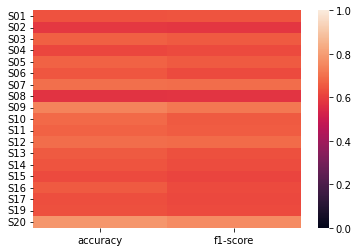

     class0 f1-score  class1 f1-score
S01         0.733945         0.442308
S02         0.698276         0.326923
S03         0.770428         0.378947
S04         0.714286         0.409836
S05         0.775510         0.367816
S06         0.766917         0.261905
S07         0.782609         0.495413
S08         0.682731         0.347107
S09         0.830450         0.436782
S10         0.792982         0.351648
S11         0.779116         0.352941
S12         0.782258         0.480769
S13         0.763359         0.354167
S14         0.750958         0.356436
S15         0.739623         0.316832
S16         0.774194         0.275862
S17         0.748971         0.314607
S19         0.747170         0.349515
S20         0.858182         0.541176


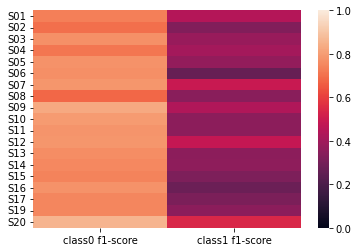

In [11]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [8]:
model.return_pairwise_weights().shape

(32,)

In [7]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [8]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

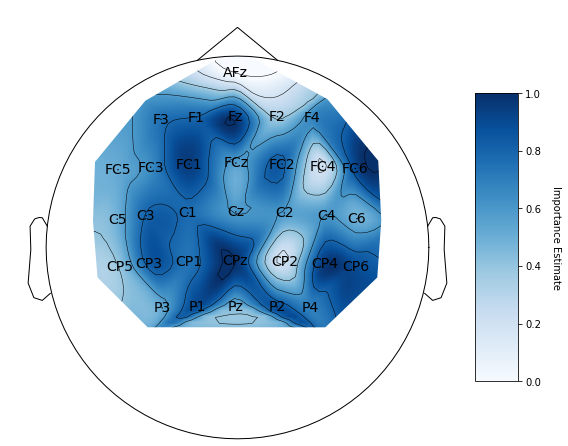

In [9]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)